# Neural network based integrator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from dynamical_system import *
from time_integrator import *
from models import *
%matplotlib inline

np.random.seed(2512517)

## Neural network integrators
Let $q(t)=(x(t),v(t))\in\mathbb{R}^{2d}$ be the state vector. Two methods are implemented to advance this state vector in time:

### Multistep neural network
The `MultistepNNInetgrator` class is used to implement a neural network based integrator with a $S$-step method. This is integrating a given $d$-dimensional system $\frac{dq(t)}{dt}=\mathcal{N}(q(t))$. The underlying neural model implements the mapping

$$
q^{(t-(S-1)\Delta t)},\dots,q^{(t-\Delta t)},q^{(t)} \mapsto q^{(t+\Delta t)}
$$

Internally this is realised by mapping the $B\times S \times d$ tensor $X$ to the $B\times d$ tensor $y$, where $B$ is the minibatch-size. This mapping is of the following form:

$$
y_{b,j} = X_{b,S-1,j} + \Delta t \cdot \Phi_{bj}(X)
$$

where $\Phi$ is a dense neural network. Note that for each batch index $b$, $X_{b,S-1,\cdot}$ is simply the vector $q^{(t)}_b$, i.e. we assume that $q^{(t+\Delta t)}$ is $q^{(t)}$ plus $\Delta t$ times some correction. The neural network $\Phi$ can take different form:
* it can simply be a set of dense layers or
* it can be a two-layer LSTM network, followed by a dense layer as in [https://arxiv.org/abs/2004.06493](https://arxiv.org/abs/2004.06493)

### Hamiltonian neural network integrator
Alternatively, the `HamiltonianNNIntegrator` implements a single-step Stoermer-Verlet method for a Hamiltonian system, following the ideas in [https://arxiv.org/abs/1906.01563](https://arxiv.org/abs/1906.01563). In this case the update $q^{(t)}\mapsto q^{(t+\Delta t)}$ takes the form:

$$
\begin{aligned}
v^{(t+\Delta t/2)} &= v^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t)}\right)\\[1ex]
x^{(t+\Delta t)} &= x^{(t)} + \Delta t \frac{\partial T}{\partial v}\left(v^{(t+\Delta t/2)}\right)\\[1ex]
v^{(t+\Delta t)} &= v^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t+\Delta t)}\right)
\end{aligned}
$$

Assuming that the Hamiltonian $H(x,v) = T(v) + V(x)$ is separable, the kinetic energy $T(v)$ and potential energy $V(x)$ are represented by neural networks.

In [2]:
class NNIntegrator(object):
    '''Base class for neural network based integrators
    
    :arg dynamical_system: dynamical system used for integration
    :arg dt: timestep size
    :arg nsteps: number of multisteps
    '''
    def __init__(self,dynamical_system,dt,nsteps):
        self.dynamical_system = dynamical_system
        self.dt = dt        
        self.dim = 2*self.dynamical_system.dim
        self.nsteps = nsteps
        self.xv = np.zeros((1,self.nsteps,self.dim))

    def set_state(self,x,v):
        '''Set the current state of the integrator
        
        :arg x: Array of size nsteps x dim with initial positions
        :arg v: Array of size nsteps x dim with initial velocities
        '''
        self.xv[0,:,:self.dim//2] = x[:,:]
        self.xv[0,:,self.dim//2:] = v[:,:]
        
    @property
    def x(self):
        '''Return the current position vector (as a d-dimensional array)'''
        return self.xv[0,-1,:self.dim//2]

    @property
    def v(self):
        '''Return the current velocity vector (as a d-dimensional array)'''
        return self.xv[0,-1,self.dim//2:]
    
    def integrate(self,n_steps):
        '''Carry out a given number of integration steps
        
        :arg n_steps: number of integration steps
        '''
        for k in range(n_steps):
            x_pred = np.asarray(self.model.predict(self.xv)).flatten()
            self.xv = np.roll(self.xv, -1, axis=1)
            self.xv[0,-1,:] = x_pred[:]
            
    def energy(self):
        return self.dynamical_system.energy(self.x,self.v)

class MultistepNNIntegrator(NNIntegrator):
    '''Multistep integrator. Use a neural network to predict the next state, given
    a number of previous states
    
    :arg dynamical_system: dynamical system used for integration
    :arg dt: timestep size
    :arg nsteps: Number of steps of the timestepping method
    :arg dense_layers: neural network layers used to predict the next state
    '''
    def __init__(self,dynamical_system,dt,nsteps,dense_layers):
        super().__init__(dynamical_system,dt,nsteps)
        self.dim = 2*self.dynamical_system.dim
        self.dense_layers = dense_layers
        self._build_model()
    
    def _build_model(self):
        inputs = keras.Input(shape=(self.nsteps,self.dim))
        q_n = tf.unstack(inputs,axis=1)[-1]        
        output_layer = keras.layers.Dense(self.dim)
        x = inputs
        for layer in dense_layers:
            x = layer(x)
        x = output_layer(x)
        x = keras.layers.Rescaling(self.dt)(x)
        outputs = keras.layers.Add()([q_n,x])
        self.model = keras.Model(inputs=inputs,outputs=outputs)
        lr_schedule = keras.optimizers.schedules.CosineDecay(
                        initial_learning_rate=1e-3,
                        decay_steps=1000*1000,
                        alpha=1.E-3)
        self.model.compile(loss='mse',metrics=[],optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))
        self.xv = np.zeros((1,self.nsteps,self.dim))

    def call(self, inputs, training=False):
        '''Evaluate model
        
        Split the inputs = (q_n,p_n) into position and momentum and 
        return the state (q_{n+1},p_{n+1}) at the next timestep.
        
        Note that the expected tensor shape is B x 1 x 2d to be compatible with
        the non-symplectic update 
        
        :arg inputs: state (q_n,p_n) as a B x 1 x 2d tensor
        '''
        
        input_shape = tf.shape(inputs)
        # Extract q_n and p_n from input
        qp_old = tf.unstack(tf.reshape(inputs, (input_shape[0],input_shape[2],)),axis=-1)
        q_old = tf.stack(qp_old[:self.dim//2],axis=-1)
        p_old = tf.stack(qp_old[self.dim//2:],axis=-1)
        q_new, p_new = self.verlet_step(q_old,p_old)        
        # Combine result of Verlet step into tensor of correct size
        outputs = tf.stack([q_new,p_new],axis=-1)        
        return outputs

class HamiltonianNNIntegrator(NNIntegrator):
    '''Neural network integrator based on the Hamiltonian Stoermer-Verlet update'''
    def __init__(self,dynamical_system,dt,V_pot_layers,T_kin_layers):
        super().__init__(dynamical_system,dt,1)
        self.V_pot_layers = V_pot_layers
        self.T_kin_layers = T_kin_layers
        self._build_model()
    
    def _build_model(self):
        self.model = VerletModel(self.dim,self.dt,
                                 self.V_pot_layers,
                                 self.T_kin_layers)
        self.model.build(input_shape=(None,1,self.dim))
        self.model.compile(loss='mse',metrics=[],optimizer=keras.optimizers.Adam(learning_rate=1.E-4))


### Set up system
Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator, defined by the equations of motion

$$
\frac{dx}{dt} = v,\qquad\qquad
\frac{dv}{dt} = -\frac{k}{m}x
$$

The timestep size of the Neural network integrator is set to $\Delta t=40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

In [3]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for training integrator
dt_train = 0.005
# timestep for neural network integrator
dt = 0.2
# number of steps for multistep neural network integrator
nsteps = 6

# use Hamiltonian model?
use_hamiltonian = False
# use LSTM network for multistep integrator?
use_LSTM = False
# use exact integrator for training?
use_exact_integrator=True

# dynamical system to integrate
harmonic_oscillator = HarmonicOscillator(mass,k_spring)
# Integrator used to generate data
if use_exact_integrator:
    train_integrator = ExactIntegrator(harmonic_oscillator,dt_train)
else:
    train_integrator = VerletIntegrator(harmonic_oscillator,dt_train)

if use_hamiltonian:
    V_pot_layers = [keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]
    T_kin_layers = [keras.layers.Dense(32,activation='tanh'),
                    keras.layers.Dense(32,activation='tanh')]
    nn_integrator = HamiltonianNNIntegrator(harmonic_oscillator,dt,V_pot_layers,T_kin_layers)    
else:
    if use_LSTM: 
        # Use two layers of LSTMs followed by a dense layer
        dense_layers = [keras.layers.LSTM(64,return_sequences=True),
                        keras.layers.LSTM(64),
                        keras.layers.Dense(32,activation='tanh')]
    else:
        # Just use several dense layers
        dense_layers = [keras.layers.Flatten(),
                        keras.layers.Dense(32,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]


    nn_integrator = MultistepNNIntegrator(harmonic_oscillator,dt,nsteps,
                                          dense_layers)

# visualise the neural network model
nn_integrator.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 2)]       0           []                               
                                                                                                  
 flatten (Flatten)              (None, 12)           0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 32)           416         ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           2112        ['dense[0][0]']                  
                                                                                              

nn_integrator.nn_integrator.## Data generator
The following data generator class can be used to construct training data samples of the form $(X_j,y_j)$ where

$$
X_j = q_j^{(0)},q_j^{(\Delta t)},\dots,q_j^{((S-1)\Delta t)},\qquad\qquad y_j = q_j^{(S\Delta t)}.
$$

Here $q_j^{(0)}$ is a randomly chosen initial condition and the states $q_j^{(\Delta t)},q_j^{(2\Delta t)},\dots,q_j^{((S-1)\Delta t)}, q_j^{(S\Delta t)}$ are generated with a training generator (=Verlet) that is run with a smaller timestep.

In [4]:
class DataGenerator(object):
    def __init__(self,nn_integrator,train_integrator):        
        self.nn_integrator = nn_integrator
        self.train_integrator = train_integrator
        self.dynamical_system = self.nn_integrator.dynamical_system
        self.dataset = tf.data.Dataset.from_generator(self._generator,                                                      
                                                      output_signature=(
                                                          tf.TensorSpec(shape=(self.nn_integrator.nsteps,
                                                                               2*self.dynamical_system.dim), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(2*self.dynamical_system.dim), dtype=tf.float32)
                                                      ))
    
    def _generator(self):
        state = np.zeros((self.nn_integrator.nsteps+1,2*self.dynamical_system.dim))
        while True:
            self.dynamical_system.set_random_state(state[0,:self.dynamical_system.dim],
                                                   state[0,self.dynamical_system.dim:])
            self.train_integrator.set_state(state[0,:self.dynamical_system.dim],
                                            state[0,self.dynamical_system.dim:])
            for k in range(self.nn_integrator.nsteps):
                self.train_integrator.integrate(int(self.nn_integrator.dt/self.train_integrator.dt))
                state[k+1,:self.dynamical_system.dim] = self.train_integrator.x[:]
                state[k+1,self.dynamical_system.dim:] = self.train_integrator.v[:]
            X = state[:-1,:]
            y = state[-1,:]
            yield (X,y)
    
data_generator = DataGenerator(nn_integrator,train_integrator)

## Train neural network based integrator

Note that training history can be visualised with tensorboard:

```
tensorboard --logdir=./tb_logs
```

In [13]:
BATCH_SIZE=64
EPOCHS=1000
STEPS_PER_EPOCH=1000
log_dir = './tb_logs/'
train_batches = data_generator.dataset.batch(BATCH_SIZE)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result = nn_integrator.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)

Epoch 1/1000
1000/1000 [==============================] - ETA: 3:43 - loss: 0.025 - ETA: 12s - loss: 0.013 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0029 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.002 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 8s - loss: 0.001 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.4401e- - ETA: 11s - loss: 4.0489e- - ETA: 11s - loss: 1.0644e- - ETA: 11s - loss: 9.0355e- - ETA: 11s - loss: 8.0789e- - ETA: 11s - loss: 7.5242e- - ETA: 11s - loss: 7.0321e- - ETA: 11s - loss: 6.4809e- - ETA: 10s - loss: 6.2155e- - ETA: 10s - loss: 5.8689e- - ETA: 10s - loss: 6.0438e- - ETA: 10s - loss: 6.2862e- - ETA: 10s - loss: 6.1266e- - ETA: 10s - loss: 6.4669e- - ETA: 10s - loss: 6.3805e- - ETA: 10s - loss: 6.1831e- - ETA: 10s - loss: 5.9584e- - ETA: 10s - loss: 6.0963e- - ETA: 10s - loss: 5.9118e- - ETA: 10s - loss: 5.7755e- - ETA: 10s - loss: 5.7444e- - ETA: 10s - loss: 6.0819e- - ETA: 10s - loss: 6.0154e- - ETA: 10s - loss: 5.9646e- - ETA: 10s - loss: 5.8889e- - ETA: 10s - loss: 6.0742e- - ETA: 10s - loss: 6.0468e- - ETA: 10s - loss: 6.0753e- - ETA: 10s - loss: 6.2394e- - ETA: 9s - loss: 6.3014e-06 - ETA: 9s - loss: 6.3359e-0 - ETA: 9s - loss: 6.3324e-0 - ETA: 9s - loss: 6.2671e-0 - ETA: 9s - loss: 6.1879e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 4.1256e- - ETA: 12s - loss: 4.2639e- - ETA: 12s - loss: 5.1706e- - ETA: 12s - loss: 5.0406e- - ETA: 12s - loss: 5.1195e- - ETA: 12s - loss: 4.6732e- - ETA: 12s - loss: 4.5862e- - ETA: 11s - loss: 4.2257e- - ETA: 11s - loss: 3.9452e- - ETA: 11s - loss: 3.6817e- - ETA: 11s - loss: 3.5308e- - ETA: 11s - loss: 3.3407e- - ETA: 11s - loss: 3.1990e- - ETA: 11s - loss: 3.0441e- - ETA: 11s - loss: 2.9245e- - ETA: 11s - loss: 2.9162e- - ETA: 11s - loss: 2.8505e- - ETA: 11s - loss: 2.7720e- - ETA: 11s - loss: 2.7129e- - ETA: 10s - loss: 2.6874e- - ETA: 10s - loss: 2.6159e- - ETA: 10s - loss: 2.5288e- - ETA: 10s - loss: 2.5803e- - ETA: 10s - loss: 2.5667e- - ETA: 10s - loss: 2.5684e- - ETA: 10s - loss: 2.5431e- - ETA: 10s - loss: 2.4882e- - ETA: 10s - loss: 2.4522e- - ETA: 10s - loss: 2.5887e- - ETA: 10s - loss: 2.7306e- - ETA: 10s - loss: 2.7788e- - ETA: 10s - loss: 2.8227e- - ETA: 10s - loss: 2.8851e- - ETA: 10s - loss: 2.9341e- - ETA

1000/1000 [==============================] - ETA: 11s - loss: 2.5105e- - ETA: 10s - loss: 2.2229e- - ETA: 11s - loss: 2.2694e- - ETA: 11s - loss: 2.1073e- - ETA: 10s - loss: 1.9312e- - ETA: 10s - loss: 1.7387e- - ETA: 11s - loss: 1.6231e- - ETA: 11s - loss: 1.4851e- - ETA: 11s - loss: 1.5058e- - ETA: 11s - loss: 1.8867e- - ETA: 11s - loss: 1.9961e- - ETA: 11s - loss: 1.9663e- - ETA: 10s - loss: 1.8527e- - ETA: 10s - loss: 1.7589e- - ETA: 10s - loss: 1.9206e- - ETA: 10s - loss: 2.0325e- - ETA: 10s - loss: 2.1248e- - ETA: 10s - loss: 2.1099e- - ETA: 10s - loss: 2.0724e- - ETA: 10s - loss: 2.0560e- - ETA: 10s - loss: 2.0080e- - ETA: 10s - loss: 1.9849e- - ETA: 10s - loss: 1.9562e- - ETA: 10s - loss: 1.9199e- - ETA: 10s - loss: 1.8853e- - ETA: 10s - loss: 1.8351e- - ETA: 10s - loss: 1.7861e- - ETA: 10s - loss: 1.8923e- - ETA: 9s - loss: 2.0329e-06 - ETA: 10s - loss: 2.2865e- - ETA: 10s - loss: 2.3837e- - ETA: 9s - loss: 2.4681e-06 - ETA: 9s - loss: 2.5334e-0 - ETA: 9s - loss: 2.5990e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 7.6490e- - ETA: 10s - loss: 1.3557e- - ETA: 11s - loss: 1.5400e- - ETA: 11s - loss: 1.4324e- - ETA: 10s - loss: 1.2793e- - ETA: 10s - loss: 1.1962e- - ETA: 10s - loss: 1.1610e- - ETA: 10s - loss: 1.3275e- - ETA: 10s - loss: 1.3780e- - ETA: 10s - loss: 1.5065e- - ETA: 10s - loss: 1.5807e- - ETA: 10s - loss: 1.7996e- - ETA: 10s - loss: 1.8763e- - ETA: 10s - loss: 1.9462e- - ETA: 10s - loss: 2.0595e- - ETA: 10s - loss: 2.1152e- - ETA: 10s - loss: 2.1118e- - ETA: 10s - loss: 2.0380e- - ETA: 10s - loss: 1.9727e- - ETA: 10s - loss: 1.9744e- - ETA: 10s - loss: 1.9289e- - ETA: 10s - loss: 1.8746e- - ETA: 10s - loss: 1.8397e- - ETA: 10s - loss: 1.8188e- - ETA: 9s - loss: 1.8015e-06 - ETA: 9s - loss: 1.7547e-0 - ETA: 9s - loss: 1.7732e-0 - ETA: 9s - loss: 1.7575e-0 - ETA: 9s - loss: 1.7457e-0 - ETA: 9s - loss: 1.7458e-0 - ETA: 9s - loss: 1.7208e-0 - ETA: 9s - loss: 1.6948e-0 - ETA: 9s - loss: 1.6717e-0 - ETA: 9s - loss: 1.6471e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.6048e- - ETA: 11s - loss: 5.1143e- - ETA: 11s - loss: 4.1857e- - ETA: 11s - loss: 3.2594e- - ETA: 11s - loss: 2.9651e- - ETA: 11s - loss: 3.1663e- - ETA: 11s - loss: 3.2390e- - ETA: 10s - loss: 3.4049e- - ETA: 10s - loss: 3.3299e- - ETA: 10s - loss: 3.2773e- - ETA: 10s - loss: 3.2868e- - ETA: 10s - loss: 3.3761e- - ETA: 10s - loss: 3.3453e- - ETA: 10s - loss: 3.3053e- - ETA: 10s - loss: 3.3926e- - ETA: 10s - loss: 3.4834e- - ETA: 10s - loss: 3.6029e- - ETA: 10s - loss: 4.2648e- - ETA: 10s - loss: 4.5545e- - ETA: 10s - loss: 4.8243e- - ETA: 10s - loss: 5.0811e- - ETA: 10s - loss: 5.1315e- - ETA: 9s - loss: 5.1409e-06 - ETA: 9s - loss: 5.0212e-0 - ETA: 9s - loss: 4.8934e-0 - ETA: 9s - loss: 4.7492e-0 - ETA: 9s - loss: 4.6466e-0 - ETA: 9s - loss: 4.5573e-0 - ETA: 9s - loss: 4.4734e-0 - ETA: 9s - loss: 4.4015e-0 - ETA: 9s - loss: 4.3481e-0 - ETA: 9s - loss: 4.2847e-0 - ETA: 9s - loss: 4.2283e-0 - ETA: 9s - loss: 4.1776e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 9.1824e- - ETA: 11s - loss: 8.6435e- - ETA: 10s - loss: 6.7160e- - ETA: 11s - loss: 5.8193e- - ETA: 11s - loss: 6.5127e- - ETA: 11s - loss: 6.7182e- - ETA: 11s - loss: 6.6364e- - ETA: 11s - loss: 6.4674e- - ETA: 11s - loss: 6.9463e- - ETA: 11s - loss: 7.0980e- - ETA: 11s - loss: 6.8702e- - ETA: 11s - loss: 6.6250e- - ETA: 11s - loss: 6.3123e- - ETA: 11s - loss: 5.9589e- - ETA: 11s - loss: 5.5978e- - ETA: 11s - loss: 5.2832e- - ETA: 11s - loss: 5.0018e- - ETA: 10s - loss: 4.7403e- - ETA: 10s - loss: 4.5155e- - ETA: 10s - loss: 4.2840e- - ETA: 10s - loss: 4.1390e- - ETA: 10s - loss: 3.9391e- - ETA: 10s - loss: 3.9385e- - ETA: 9s - loss: 3.9237e-06 - ETA: 9s - loss: 3.8093e-0 - ETA: 9s - loss: 3.7373e-0 - ETA: 9s - loss: 3.6793e-0 - ETA: 9s - loss: 3.6357e-0 - ETA: 9s - loss: 3.6320e-0 - ETA: 9s - loss: 3.7567e-0 - ETA: 9s - loss: 3.9148e-0 - ETA: 9s - loss: 3.9826e-0 - ETA: 9s - loss: 4.0718e-0 - ETA: 9s - loss: 4.0662e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.0818e- - ETA: 10s - loss: 1.4992e- - ETA: 10s - loss: 1.7812e- - ETA: 11s - loss: 2.4948e- - ETA: 11s - loss: 2.4809e- - ETA: 11s - loss: 2.3509e- - ETA: 11s - loss: 2.1275e- - ETA: 11s - loss: 1.9652e- - ETA: 10s - loss: 2.0128e- - ETA: 10s - loss: 1.9243e- - ETA: 10s - loss: 1.8370e- - ETA: 10s - loss: 1.7247e- - ETA: 9s - loss: 1.6160e-06 - ETA: 9s - loss: 1.5814e-0 - ETA: 9s - loss: 1.5320e-0 - ETA: 9s - loss: 1.4618e-0 - ETA: 9s - loss: 1.4219e-0 - ETA: 9s - loss: 1.3906e-0 - ETA: 9s - loss: 1.3740e-0 - ETA: 9s - loss: 1.3635e-0 - ETA: 9s - loss: 1.3298e-0 - ETA: 9s - loss: 1.2747e-0 - ETA: 9s - loss: 1.3346e-0 - ETA: 9s - loss: 1.3709e-0 - ETA: 8s - loss: 1.4462e-0 - ETA: 8s - loss: 1.6014e-0 - ETA: 8s - loss: 1.7496e-0 - ETA: 8s - loss: 1.9713e-0 - ETA: 8s - loss: 2.1143e-0 - ETA: 8s - loss: 2.2149e-0 - ETA: 8s - loss: 2.2391e-0 - ETA: 8s - loss: 2.2268e-0 - ETA: 8s - loss: 2.2441e-0 - ETA: 8s - loss: 2.2451e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.4680e- - ETA: 11s - loss: 8.2289e- - ETA: 11s - loss: 6.4590e- - ETA: 11s - loss: 6.1500e- - ETA: 11s - loss: 5.8247e- - ETA: 11s - loss: 6.3478e- - ETA: 11s - loss: 9.3837e- - ETA: 10s - loss: 9.2771e- - ETA: 10s - loss: 9.9787e- - ETA: 10s - loss: 1.0892e- - ETA: 10s - loss: 1.2945e- - ETA: 10s - loss: 1.4105e- - ETA: 10s - loss: 1.4230e- - ETA: 10s - loss: 1.4102e- - ETA: 10s - loss: 1.4185e- - ETA: 10s - loss: 1.4002e- - ETA: 10s - loss: 1.3707e- - ETA: 10s - loss: 1.3356e- - ETA: 10s - loss: 1.3350e- - ETA: 10s - loss: 1.3493e- - ETA: 10s - loss: 1.3330e- - ETA: 9s - loss: 1.3068e-06 - ETA: 9s - loss: 1.2953e-0 - ETA: 9s - loss: 1.2665e-0 - ETA: 9s - loss: 1.2411e-0 - ETA: 9s - loss: 1.2348e-0 - ETA: 9s - loss: 1.2186e-0 - ETA: 9s - loss: 1.2190e-0 - ETA: 9s - loss: 1.2371e-0 - ETA: 9s - loss: 1.2391e-0 - ETA: 9s - loss: 1.2553e-0 - ETA: 9s - loss: 1.2556e-0 - ETA: 9s - loss: 1.2804e-0 - ETA: 9s - loss: 1.3196e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 9.6910e- - ETA: 11s - loss: 1.6475e- - ETA: 11s - loss: 1.3281e- - ETA: 11s - loss: 1.5986e- - ETA: 11s - loss: 1.5918e- - ETA: 11s - loss: 1.5434e- - ETA: 11s - loss: 1.4196e- - ETA: 10s - loss: 1.2928e- - ETA: 10s - loss: 1.1929e- - ETA: 10s - loss: 1.1550e- - ETA: 10s - loss: 1.0821e- - ETA: 10s - loss: 2.3554e- - ETA: 10s - loss: 3.4493e- - ETA: 9s - loss: 4.1091e-06 - ETA: 9s - loss: 4.5406e-0 - ETA: 9s - loss: 4.7022e-0 - ETA: 9s - loss: 4.8527e-0 - ETA: 9s - loss: 5.2617e-0 - ETA: 9s - loss: 5.7525e-0 - ETA: 9s - loss: 6.2213e-0 - ETA: 9s - loss: 6.6137e-0 - ETA: 9s - loss: 6.9084e-0 - ETA: 9s - loss: 6.9464e-0 - ETA: 9s - loss: 6.9070e-0 - ETA: 9s - loss: 6.8736e-0 - ETA: 9s - loss: 6.9438e-0 - ETA: 9s - loss: 6.9611e-0 - ETA: 9s - loss: 6.8936e-0 - ETA: 9s - loss: 6.8417e-0 - ETA: 9s - loss: 6.7274e-0 - ETA: 9s - loss: 6.7128e-0 - ETA: 9s - loss: 6.6736e-0 - ETA: 8s - loss: 6.5949e-0 - ETA: 8s - loss: 6.4801e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 5.5703e- - ETA: 11s - loss: 3.3240e- - ETA: 11s - loss: 2.8163e- - ETA: 11s - loss: 2.4569e- - ETA: 11s - loss: 8.3533e- - ETA: 11s - loss: 1.2958e- - ETA: 11s - loss: 1.7507e- - ETA: 11s - loss: 1.9262e- - ETA: 11s - loss: 1.9362e- - ETA: 11s - loss: 1.8580e- - ETA: 10s - loss: 1.8098e- - ETA: 10s - loss: 1.7353e- - ETA: 10s - loss: 1.6485e- - ETA: 10s - loss: 1.5705e- - ETA: 10s - loss: 1.4933e- - ETA: 10s - loss: 1.4133e- - ETA: 10s - loss: 1.3432e- - ETA: 10s - loss: 1.2750e- - ETA: 10s - loss: 1.2153e- - ETA: 10s - loss: 1.1568e- - ETA: 10s - loss: 1.1023e- - ETA: 10s - loss: 1.0520e- - ETA: 10s - loss: 1.0059e- - ETA: 10s - loss: 9.6407e- - ETA: 10s - loss: 9.1847e- - ETA: 9s - loss: 8.8347e-06 - ETA: 9s - loss: 8.4516e-0 - ETA: 9s - loss: 8.1699e-0 - ETA: 9s - loss: 7.8799e-0 - ETA: 9s - loss: 7.6060e-0 - ETA: 9s - loss: 7.3736e-0 - ETA: 9s - loss: 7.1676e-0 - ETA: 9s - loss: 6.9826e-0 - ETA: 9s - loss: 6.7744e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 6.5885e- - ETA: 11s - loss: 6.1386e- - ETA: 11s - loss: 4.5853e- - ETA: 11s - loss: 3.5761e- - ETA: 11s - loss: 4.1369e- - ETA: 11s - loss: 4.0524e- - ETA: 11s - loss: 4.2085e- - ETA: 11s - loss: 4.8368e- - ETA: 11s - loss: 4.8486e- - ETA: 11s - loss: 4.6574e- - ETA: 11s - loss: 4.3722e- - ETA: 11s - loss: 4.1164e- - ETA: 11s - loss: 3.9235e- - ETA: 11s - loss: 3.7049e- - ETA: 11s - loss: 3.4924e- - ETA: 11s - loss: 3.2830e- - ETA: 11s - loss: 3.1294e- - ETA: 10s - loss: 2.9710e- - ETA: 10s - loss: 2.8378e- - ETA: 10s - loss: 2.8064e- - ETA: 10s - loss: 2.7143e- - ETA: 10s - loss: 2.8391e- - ETA: 10s - loss: 2.9004e- - ETA: 10s - loss: 2.9475e- - ETA: 10s - loss: 2.9266e- - ETA: 10s - loss: 2.8987e- - ETA: 10s - loss: 2.9066e- - ETA: 10s - loss: 2.9711e- - ETA: 10s - loss: 2.9704e- - ETA: 10s - loss: 2.9121e- - ETA: 10s - loss: 2.8443e- - ETA: 10s - loss: 2.7988e- - ETA: 10s - loss: 2.7768e- - ETA: 10s - loss: 2.7372e- - ETA

1000/1000 [==============================] - ETA: 13s - loss: 3.2747e- - ETA: 11s - loss: 4.1651e- - ETA: 11s - loss: 4.3190e- - ETA: 11s - loss: 6.0887e- - ETA: 11s - loss: 9.0869e- - ETA: 11s - loss: 1.1078e- - ETA: 11s - loss: 1.3715e- - ETA: 11s - loss: 1.5423e- - ETA: 10s - loss: 1.5549e- - ETA: 10s - loss: 1.5347e- - ETA: 10s - loss: 1.5158e- - ETA: 10s - loss: 1.5127e- - ETA: 10s - loss: 1.5628e- - ETA: 10s - loss: 1.6298e- - ETA: 10s - loss: 1.7405e- - ETA: 10s - loss: 1.9544e- - ETA: 10s - loss: 2.1667e- - ETA: 10s - loss: 2.2343e- - ETA: 10s - loss: 2.2383e- - ETA: 10s - loss: 2.2649e- - ETA: 10s - loss: 2.2800e- - ETA: 10s - loss: 2.2647e- - ETA: 10s - loss: 2.3157e- - ETA: 10s - loss: 2.5248e- - ETA: 10s - loss: 2.5730e- - ETA: 10s - loss: 2.7689e- - ETA: 9s - loss: 2.9473e-06 - ETA: 9s - loss: 3.0593e-0 - ETA: 9s - loss: 3.0993e-0 - ETA: 9s - loss: 3.1645e-0 - ETA: 9s - loss: 3.2434e-0 - ETA: 9s - loss: 3.3173e-0 - ETA: 9s - loss: 3.3314e-0 - ETA: 9s - loss: 3.3814e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 1.4081e- - ETA: 9s - loss: 1.8430e-06 - ETA: 9s - loss: 2.5490e-0 - ETA: 9s - loss: 2.4401e-0 - ETA: 9s - loss: 2.4689e-0 - ETA: 9s - loss: 2.4150e-0 - ETA: 9s - loss: 2.2915e-0 - ETA: 8s - loss: 2.1383e-0 - ETA: 9s - loss: 1.9624e-0 - ETA: 8s - loss: 1.8407e-0 - ETA: 8s - loss: 2.0137e-0 - ETA: 8s - loss: 2.1200e-0 - ETA: 8s - loss: 2.2774e-0 - ETA: 8s - loss: 2.3657e-0 - ETA: 8s - loss: 2.4326e-0 - ETA: 8s - loss: 2.4505e-0 - ETA: 8s - loss: 2.4740e-0 - ETA: 8s - loss: 2.3945e-0 - ETA: 8s - loss: 2.3082e-0 - ETA: 8s - loss: 2.3376e-0 - ETA: 8s - loss: 2.3462e-0 - ETA: 8s - loss: 2.3771e-0 - ETA: 8s - loss: 2.3695e-0 - ETA: 8s - loss: 2.4715e-0 - ETA: 8s - loss: 2.6910e-0 - ETA: 8s - loss: 2.8304e-0 - ETA: 8s - loss: 3.0552e-0 - ETA: 8s - loss: 3.5989e-0 - ETA: 8s - loss: 3.7148e-0 - ETA: 8s - loss: 3.7596e-0 - ETA: 8s - loss: 3.8431e-0 - ETA: 8s - loss: 3.8877e-0 - ETA: 8s - loss: 3.8724e-0 - ETA: 8s - loss: 3.8642e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 5.5151e- - ETA: 11s - loss: 3.3985e- - ETA: 12s - loss: 2.6279e- - ETA: 12s - loss: 2.1444e- - ETA: 11s - loss: 1.9299e- - ETA: 11s - loss: 1.7014e- - ETA: 11s - loss: 1.4758e- - ETA: 11s - loss: 1.3305e- - ETA: 11s - loss: 1.2070e- - ETA: 11s - loss: 1.1301e- - ETA: 11s - loss: 1.0530e- - ETA: 11s - loss: 9.9027e- - ETA: 11s - loss: 9.5346e- - ETA: 11s - loss: 9.2728e- - ETA: 10s - loss: 8.9578e- - ETA: 10s - loss: 8.8778e- - ETA: 10s - loss: 8.6592e- - ETA: 10s - loss: 8.3169e- - ETA: 10s - loss: 7.9755e- - ETA: 10s - loss: 8.1817e- - ETA: 10s - loss: 8.3790e- - ETA: 10s - loss: 8.2574e- - ETA: 10s - loss: 8.3384e- - ETA: 10s - loss: 8.8612e- - ETA: 10s - loss: 1.0273e- - ETA: 10s - loss: 1.0603e- - ETA: 9s - loss: 1.1010e-06 - ETA: 9s - loss: 1.1109e-0 - ETA: 9s - loss: 1.1570e-0 - ETA: 9s - loss: 1.1556e-0 - ETA: 9s - loss: 1.1439e-0 - ETA: 9s - loss: 1.1290e-0 - ETA: 9s - loss: 1.1139e-0 - ETA: 9s - loss: 1.0972e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 5.0433e- - ETA: 9s - loss: 6.8343e-07 - ETA: 10s - loss: 5.8742e- - ETA: 10s - loss: 7.7763e- - ETA: 10s - loss: 9.3357e- - ETA: 10s - loss: 1.0667e- - ETA: 9s - loss: 1.1476e-06 - ETA: 9s - loss: 1.2946e-0 - ETA: 9s - loss: 1.3796e-0 - ETA: 9s - loss: 1.3604e-0 - ETA: 9s - loss: 1.3375e-0 - ETA: 9s - loss: 1.2662e-0 - ETA: 9s - loss: 1.2124e-0 - ETA: 9s - loss: 1.1743e-0 - ETA: 9s - loss: 1.1674e-0 - ETA: 8s - loss: 1.1715e-0 - ETA: 8s - loss: 1.1445e-0 - ETA: 8s - loss: 1.1067e-0 - ETA: 8s - loss: 1.0710e-0 - ETA: 8s - loss: 1.0321e-0 - ETA: 8s - loss: 9.9411e-0 - ETA: 8s - loss: 9.5970e-0 - ETA: 8s - loss: 9.2887e-0 - ETA: 8s - loss: 9.0593e-0 - ETA: 8s - loss: 8.8269e-0 - ETA: 8s - loss: 9.5178e-0 - ETA: 8s - loss: 9.7698e-0 - ETA: 8s - loss: 1.0038e-0 - ETA: 8s - loss: 1.0149e-0 - ETA: 8s - loss: 1.0141e-0 - ETA: 8s - loss: 1.0151e-0 - ETA: 8s - loss: 1.0226e-0 - ETA: 8s - loss: 1.0281e-0 - ETA: 8s - loss: 1.0311e-0 - E

1000/1000 [==============================] - ETA: 9s - loss: 2.7422e-0 - ETA: 9s - loss: 1.9469e-0 - ETA: 9s - loss: 1.6127e-0 - ETA: 9s - loss: 1.5303e-0 - ETA: 9s - loss: 1.4487e-0 - ETA: 9s - loss: 1.3175e-0 - ETA: 9s - loss: 1.2619e-0 - ETA: 9s - loss: 1.1600e-0 - ETA: 9s - loss: 1.0810e-0 - ETA: 9s - loss: 1.1041e-0 - ETA: 9s - loss: 1.1597e-0 - ETA: 9s - loss: 1.1841e-0 - ETA: 8s - loss: 1.1544e-0 - ETA: 8s - loss: 1.1558e-0 - ETA: 8s - loss: 1.1379e-0 - ETA: 8s - loss: 1.1358e-0 - ETA: 8s - loss: 1.2569e-0 - ETA: 8s - loss: 1.7134e-0 - ETA: 8s - loss: 2.2770e-0 - ETA: 8s - loss: 2.7120e-0 - ETA: 8s - loss: 2.8906e-0 - ETA: 8s - loss: 3.0788e-0 - ETA: 8s - loss: 3.3887e-0 - ETA: 8s - loss: 3.4623e-0 - ETA: 8s - loss: 3.5087e-0 - ETA: 8s - loss: 3.5534e-0 - ETA: 8s - loss: 3.5749e-0 - ETA: 8s - loss: 3.5881e-0 - ETA: 8s - loss: 3.5744e-0 - ETA: 8s - loss: 3.5164e-0 - ETA: 8s - loss: 3.4554e-0 - ETA: 8s - loss: 3.4006e-0 - ETA: 8s - loss: 3.3470e-0 - ETA: 8s - loss: 3.2773e-0 - ETA

1000/1000 [==============================] - ETA: 10s - loss: 4.7896e- - ETA: 12s - loss: 2.2369e- - ETA: 11s - loss: 1.6070e- - ETA: 11s - loss: 1.3018e- - ETA: 11s - loss: 1.2014e- - ETA: 11s - loss: 1.2122e- - ETA: 11s - loss: 1.5441e- - ETA: 11s - loss: 1.7544e- - ETA: 11s - loss: 1.6829e- - ETA: 11s - loss: 1.5636e- - ETA: 11s - loss: 1.4749e- - ETA: 11s - loss: 1.4321e- - ETA: 10s - loss: 1.3759e- - ETA: 10s - loss: 1.3457e- - ETA: 10s - loss: 1.3008e- - ETA: 10s - loss: 1.2739e- - ETA: 10s - loss: 1.2368e- - ETA: 10s - loss: 1.1882e- - ETA: 10s - loss: 1.1435e- - ETA: 10s - loss: 1.0994e- - ETA: 10s - loss: 1.2572e- - ETA: 10s - loss: 1.3169e- - ETA: 10s - loss: 1.3375e- - ETA: 10s - loss: 1.3898e- - ETA: 10s - loss: 1.4150e- - ETA: 10s - loss: 1.4037e- - ETA: 10s - loss: 1.4013e- - ETA: 10s - loss: 1.3851e- - ETA: 10s - loss: 1.3602e- - ETA: 10s - loss: 1.3365e- - ETA: 9s - loss: 1.3210e-06 - ETA: 9s - loss: 1.3174e-0 - ETA: 9s - loss: 1.3050e-0 - ETA: 9s - loss: 1.3058e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.7695e- - ETA: 13s - loss: 1.2310e- - ETA: 13s - loss: 9.9198e- - ETA: 13s - loss: 1.5108e- - ETA: 12s - loss: 1.6372e- - ETA: 12s - loss: 1.7397e- - ETA: 12s - loss: 1.7534e- - ETA: 12s - loss: 1.9239e- - ETA: 11s - loss: 2.2707e- - ETA: 11s - loss: 2.3497e- - ETA: 11s - loss: 2.3295e- - ETA: 11s - loss: 2.1792e- - ETA: 11s - loss: 2.0394e- - ETA: 11s - loss: 1.8940e- - ETA: 11s - loss: 1.7777e- - ETA: 11s - loss: 1.6876e- - ETA: 10s - loss: 1.6423e- - ETA: 10s - loss: 1.6126e- - ETA: 10s - loss: 1.5904e- - ETA: 10s - loss: 1.5513e- - ETA: 10s - loss: 1.5122e- - ETA: 10s - loss: 1.4807e- - ETA: 10s - loss: 1.4728e- - ETA: 10s - loss: 1.4569e- - ETA: 10s - loss: 1.4308e- - ETA: 10s - loss: 1.4193e- - ETA: 10s - loss: 1.3974e- - ETA: 10s - loss: 1.3826e- - ETA: 10s - loss: 1.3775e- - ETA: 10s - loss: 1.3690e- - ETA: 9s - loss: 1.3592e-06 - ETA: 9s - loss: 1.3524e-0 - ETA: 9s - loss: 1.3384e-0 - ETA: 9s - loss: 1.3557e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.1297e- - ETA: 11s - loss: 1.7651e- - ETA: 11s - loss: 1.9133e- - ETA: 11s - loss: 2.3003e- - ETA: 11s - loss: 2.3852e- - ETA: 11s - loss: 2.4269e- - ETA: 11s - loss: 2.6130e- - ETA: 10s - loss: 2.7307e- - ETA: 11s - loss: 2.7144e- - ETA: 11s - loss: 2.7559e- - ETA: 11s - loss: 2.8170e- - ETA: 10s - loss: 2.7657e- - ETA: 10s - loss: 2.7387e- - ETA: 10s - loss: 2.8178e- - ETA: 10s - loss: 2.9125e- - ETA: 10s - loss: 2.9281e- - ETA: 10s - loss: 2.9154e- - ETA: 10s - loss: 2.9074e- - ETA: 10s - loss: 2.8230e- - ETA: 10s - loss: 2.7711e- - ETA: 10s - loss: 2.7206e- - ETA: 10s - loss: 2.6566e- - ETA: 10s - loss: 2.6005e- - ETA: 10s - loss: 2.5339e- - ETA: 10s - loss: 2.4442e- - ETA: 10s - loss: 2.6702e- - ETA: 10s - loss: 2.7237e- - ETA: 9s - loss: 2.6866e-06 - ETA: 9s - loss: 2.6541e-0 - ETA: 9s - loss: 2.6056e-0 - ETA: 9s - loss: 2.5356e-0 - ETA: 9s - loss: 2.4683e-0 - ETA: 9s - loss: 2.3998e-0 - ETA: 9s - loss: 2.3420e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 8.6416e- - ETA: 11s - loss: 9.1615e- - ETA: 11s - loss: 1.1932e- - ETA: 11s - loss: 1.2187e- - ETA: 11s - loss: 1.3206e- - ETA: 10s - loss: 1.3438e- - ETA: 10s - loss: 1.3583e- - ETA: 10s - loss: 1.3814e- - ETA: 10s - loss: 1.5531e- - ETA: 10s - loss: 1.7067e- - ETA: 10s - loss: 1.8748e- - ETA: 10s - loss: 1.8610e- - ETA: 10s - loss: 1.7984e- - ETA: 10s - loss: 1.7159e- - ETA: 10s - loss: 1.6678e- - ETA: 10s - loss: 1.5899e- - ETA: 10s - loss: 1.5400e- - ETA: 10s - loss: 1.5145e- - ETA: 10s - loss: 1.4838e- - ETA: 10s - loss: 1.4367e- - ETA: 10s - loss: 1.3968e- - ETA: 10s - loss: 1.3728e- - ETA: 10s - loss: 1.3247e- - ETA: 10s - loss: 1.2805e- - ETA: 9s - loss: 1.2345e-06 - ETA: 9s - loss: 1.1906e-0 - ETA: 9s - loss: 1.1496e-0 - ETA: 9s - loss: 1.3098e-0 - ETA: 9s - loss: 1.4091e-0 - ETA: 9s - loss: 1.4962e-0 - ETA: 9s - loss: 1.5479e-0 - ETA: 9s - loss: 1.5871e-0 - ETA: 9s - loss: 1.6028e-0 - ETA: 9s - loss: 1.5980e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.1661e- - ETA: 11s - loss: 3.7332e- - ETA: 10s - loss: 3.0704e- - ETA: 11s - loss: 2.7975e- - ETA: 11s - loss: 2.5857e- - ETA: 10s - loss: 2.3765e- - ETA: 10s - loss: 2.1848e- - ETA: 10s - loss: 2.0272e- - ETA: 10s - loss: 1.9089e- - ETA: 10s - loss: 1.8468e- - ETA: 10s - loss: 1.7533e- - ETA: 10s - loss: 1.6888e- - ETA: 10s - loss: 1.6659e- - ETA: 10s - loss: 1.5919e- - ETA: 10s - loss: 1.5227e- - ETA: 10s - loss: 1.5178e- - ETA: 10s - loss: 1.4722e- - ETA: 10s - loss: 1.4550e- - ETA: 10s - loss: 1.4302e- - ETA: 10s - loss: 1.3936e- - ETA: 9s - loss: 1.3740e-06 - ETA: 9s - loss: 1.3764e-0 - ETA: 9s - loss: 1.3877e-0 - ETA: 9s - loss: 1.3973e-0 - ETA: 9s - loss: 1.3885e-0 - ETA: 9s - loss: 1.3757e-0 - ETA: 9s - loss: 1.3528e-0 - ETA: 9s - loss: 1.3245e-0 - ETA: 9s - loss: 1.3105e-0 - ETA: 9s - loss: 1.2955e-0 - ETA: 9s - loss: 1.2787e-0 - ETA: 9s - loss: 1.2613e-0 - ETA: 9s - loss: 1.2461e-0 - ETA: 9s - loss: 1.2214e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 6.5287e-0 - ETA: 8s - loss: 1.0877e-0 - ETA: 8s - loss: 3.9018e-0 - ETA: 9s - loss: 6.7796e-0 - ETA: 9s - loss: 7.7083e-0 - ETA: 9s - loss: 8.6756e-0 - ETA: 9s - loss: 9.4122e-0 - ETA: 9s - loss: 9.9755e-0 - ETA: 9s - loss: 1.1169e-0 - ETA: 9s - loss: 1.1520e-0 - ETA: 9s - loss: 1.1609e-0 - ETA: 9s - loss: 1.1975e-0 - ETA: 9s - loss: 1.2014e-0 - ETA: 9s - loss: 1.2535e-0 - ETA: 8s - loss: 1.2998e-0 - ETA: 8s - loss: 1.3366e-0 - ETA: 8s - loss: 1.4157e-0 - ETA: 8s - loss: 1.4687e-0 - ETA: 8s - loss: 1.5203e-0 - ETA: 8s - loss: 1.6689e-0 - ETA: 8s - loss: 1.7411e-0 - ETA: 8s - loss: 1.7870e-0 - ETA: 8s - loss: 1.8198e-0 - ETA: 8s - loss: 1.8043e-0 - ETA: 8s - loss: 1.7781e-0 - ETA: 8s - loss: 1.7370e-0 - ETA: 8s - loss: 1.7042e-0 - ETA: 8s - loss: 1.6716e-0 - ETA: 8s - loss: 1.6429e-0 - ETA: 8s - loss: 1.6175e-0 - ETA: 8s - loss: 1.6068e-0 - ETA: 8s - loss: 1.5840e-0 - ETA: 8s - loss: 1.5695e-0 - ETA: 8s - loss: 1.5694e-0 - ETA

1000/1000 [==============================] - ETA: 12s - loss: 5.9818e- - ETA: 12s - loss: 2.1474e- - ETA: 11s - loss: 2.0558e- - ETA: 11s - loss: 1.8216e- - ETA: 11s - loss: 1.9385e- - ETA: 11s - loss: 2.2330e- - ETA: 11s - loss: 2.4955e- - ETA: 11s - loss: 2.8179e- - ETA: 11s - loss: 2.7412e- - ETA: 11s - loss: 2.6651e- - ETA: 11s - loss: 2.6622e- - ETA: 11s - loss: 2.6331e- - ETA: 11s - loss: 2.4947e- - ETA: 10s - loss: 2.3449e- - ETA: 10s - loss: 2.2783e- - ETA: 10s - loss: 2.2588e- - ETA: 10s - loss: 2.3072e- - ETA: 10s - loss: 2.3360e- - ETA: 10s - loss: 2.2717e- - ETA: 10s - loss: 2.2260e- - ETA: 10s - loss: 2.2028e- - ETA: 10s - loss: 2.2051e- - ETA: 10s - loss: 2.2615e- - ETA: 10s - loss: 2.3809e- - ETA: 10s - loss: 2.5123e- - ETA: 9s - loss: 2.5646e-06 - ETA: 9s - loss: 2.5745e-0 - ETA: 9s - loss: 2.5634e-0 - ETA: 9s - loss: 2.6531e-0 - ETA: 9s - loss: 2.7536e-0 - ETA: 9s - loss: 2.8080e-0 - ETA: 9s - loss: 2.7867e-0 - ETA: 9s - loss: 2.7766e-0 - ETA: 9s - loss: 2.7704e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.4618e- - ETA: 11s - loss: 2.5012e- - ETA: 11s - loss: 2.4706e- - ETA: 11s - loss: 2.0247e- - ETA: 11s - loss: 1.6922e- - ETA: 11s - loss: 1.4867e- - ETA: 11s - loss: 1.3243e- - ETA: 11s - loss: 1.1976e- - ETA: 10s - loss: 1.0746e- - ETA: 10s - loss: 9.8760e- - ETA: 10s - loss: 9.1835e- - ETA: 10s - loss: 8.6311e- - ETA: 10s - loss: 8.2068e- - ETA: 10s - loss: 7.9787e- - ETA: 10s - loss: 7.8126e- - ETA: 10s - loss: 7.6142e- - ETA: 10s - loss: 7.3901e- - ETA: 10s - loss: 7.1519e- - ETA: 10s - loss: 6.8543e- - ETA: 10s - loss: 6.5667e- - ETA: 10s - loss: 6.4515e- - ETA: 10s - loss: 6.4107e- - ETA: 10s - loss: 6.6156e- - ETA: 10s - loss: 6.7478e- - ETA: 10s - loss: 6.7321e- - ETA: 10s - loss: 6.7966e- - ETA: 9s - loss: 6.7327e-07 - ETA: 9s - loss: 6.6346e-0 - ETA: 9s - loss: 6.4911e-0 - ETA: 9s - loss: 6.3703e-0 - ETA: 9s - loss: 6.3049e-0 - ETA: 9s - loss: 6.2019e-0 - ETA: 9s - loss: 6.1008e-0 - ETA: 9s - loss: 6.0753e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.4340e- - ETA: 12s - loss: 2.7137e- - ETA: 11s - loss: 2.8636e- - ETA: 11s - loss: 2.9497e- - ETA: 11s - loss: 2.8748e- - ETA: 11s - loss: 2.6465e- - ETA: 11s - loss: 4.2999e- - ETA: 11s - loss: 5.3044e- - ETA: 11s - loss: 6.3647e- - ETA: 11s - loss: 6.6281e- - ETA: 11s - loss: 6.8767e- - ETA: 11s - loss: 7.3696e- - ETA: 10s - loss: 7.6275e- - ETA: 10s - loss: 7.4460e- - ETA: 10s - loss: 7.0984e- - ETA: 10s - loss: 6.7789e- - ETA: 10s - loss: 6.5151e- - ETA: 10s - loss: 6.2698e- - ETA: 10s - loss: 9.8459e- - ETA: 10s - loss: 1.0482e- - ETA: 10s - loss: 1.1506e- - ETA: 10s - loss: 1.2571e- - ETA: 9s - loss: 1.4021e-06 - ETA: 9s - loss: 1.5604e-0 - ETA: 9s - loss: 1.6738e-0 - ETA: 9s - loss: 1.6913e-0 - ETA: 9s - loss: 1.7251e-0 - ETA: 9s - loss: 1.7661e-0 - ETA: 9s - loss: 1.7563e-0 - ETA: 9s - loss: 1.7600e-0 - ETA: 9s - loss: 1.7616e-0 - ETA: 9s - loss: 1.7442e-0 - ETA: 9s - loss: 1.7377e-0 - ETA: 9s - loss: 1.7216e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.5765e- - ETA: 11s - loss: 3.8195e- - ETA: 11s - loss: 3.9216e- - ETA: 11s - loss: 3.8951e- - ETA: 11s - loss: 3.5265e- - ETA: 11s - loss: 3.1885e- - ETA: 11s - loss: 2.8892e- - ETA: 11s - loss: 2.8066e- - ETA: 11s - loss: 2.6522e- - ETA: 11s - loss: 2.6046e- - ETA: 11s - loss: 2.5377e- - ETA: 11s - loss: 2.4663e- - ETA: 11s - loss: 2.3894e- - ETA: 10s - loss: 2.2820e- - ETA: 10s - loss: 2.1864e- - ETA: 10s - loss: 2.0955e- - ETA: 10s - loss: 2.0096e- - ETA: 10s - loss: 1.9247e- - ETA: 10s - loss: 1.8217e- - ETA: 10s - loss: 1.7502e- - ETA: 10s - loss: 1.6879e- - ETA: 10s - loss: 1.6471e- - ETA: 10s - loss: 1.6452e- - ETA: 10s - loss: 1.6575e- - ETA: 9s - loss: 1.6741e-06 - ETA: 9s - loss: 1.6654e-0 - ETA: 9s - loss: 1.6675e-0 - ETA: 9s - loss: 1.7242e-0 - ETA: 9s - loss: 1.7571e-0 - ETA: 9s - loss: 1.7526e-0 - ETA: 9s - loss: 1.7271e-0 - ETA: 9s - loss: 1.6898e-0 - ETA: 9s - loss: 1.6575e-0 - ETA: 9s - loss: 1.6152e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 8.7772e- - ETA: 11s - loss: 7.8827e- - ETA: 10s - loss: 8.1470e- - ETA: 10s - loss: 1.1937e- - ETA: 10s - loss: 1.5701e- - ETA: 10s - loss: 2.5458e- - ETA: 10s - loss: 3.2302e- - ETA: 10s - loss: 3.7584e- - ETA: 10s - loss: 3.8760e- - ETA: 10s - loss: 3.6835e- - ETA: 10s - loss: 3.6323e- - ETA: 10s - loss: 3.5028e- - ETA: 10s - loss: 3.3089e- - ETA: 10s - loss: 3.1643e- - ETA: 10s - loss: 3.0294e- - ETA: 10s - loss: 2.9395e- - ETA: 10s - loss: 2.8183e- - ETA: 10s - loss: 2.7193e- - ETA: 10s - loss: 2.6335e- - ETA: 10s - loss: 2.5446e- - ETA: 10s - loss: 2.4349e- - ETA: 9s - loss: 2.3348e-06 - ETA: 9s - loss: 2.2317e-0 - ETA: 9s - loss: 2.1432e-0 - ETA: 9s - loss: 2.0785e-0 - ETA: 9s - loss: 2.0208e-0 - ETA: 9s - loss: 1.9706e-0 - ETA: 9s - loss: 1.9438e-0 - ETA: 9s - loss: 1.9032e-0 - ETA: 9s - loss: 1.8647e-0 - ETA: 9s - loss: 1.8227e-0 - ETA: 8s - loss: 1.7828e-0 - ETA: 8s - loss: 1.7323e-0 - ETA: 8s - loss: 1.6813e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 6.6749e- - ETA: 10s - loss: 6.2351e- - ETA: 11s - loss: 4.9754e- - ETA: 10s - loss: 4.3006e- - ETA: 9s - loss: 4.0579e-07 - ETA: 9s - loss: 3.9377e-0 - ETA: 9s - loss: 3.7596e-0 - ETA: 9s - loss: 3.6681e-0 - ETA: 9s - loss: 3.8276e-0 - ETA: 9s - loss: 3.8533e-0 - ETA: 9s - loss: 3.8413e-0 - ETA: 8s - loss: 4.9187e-0 - ETA: 8s - loss: 6.6636e-0 - ETA: 8s - loss: 7.7433e-0 - ETA: 8s - loss: 8.4234e-0 - ETA: 8s - loss: 8.8424e-0 - ETA: 8s - loss: 1.0230e-0 - ETA: 8s - loss: 1.1349e-0 - ETA: 8s - loss: 1.2114e-0 - ETA: 8s - loss: 1.2103e-0 - ETA: 8s - loss: 1.2092e-0 - ETA: 8s - loss: 1.2253e-0 - ETA: 8s - loss: 1.2210e-0 - ETA: 8s - loss: 1.2285e-0 - ETA: 8s - loss: 1.2145e-0 - ETA: 8s - loss: 1.2104e-0 - ETA: 8s - loss: 1.2151e-0 - ETA: 8s - loss: 1.2038e-0 - ETA: 8s - loss: 1.1855e-0 - ETA: 8s - loss: 1.1622e-0 - ETA: 8s - loss: 1.1359e-0 - ETA: 8s - loss: 1.1120e-0 - ETA: 8s - loss: 1.0943e-0 - ETA: 8s - loss: 1.0779e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.0456e- - ETA: 12s - loss: 4.6786e- - ETA: 12s - loss: 4.4805e- - ETA: 12s - loss: 3.7888e- - ETA: 11s - loss: 3.4089e- - ETA: 11s - loss: 3.1054e- - ETA: 11s - loss: 2.8764e- - ETA: 11s - loss: 2.7036e- - ETA: 10s - loss: 2.5941e- - ETA: 10s - loss: 2.5206e- - ETA: 10s - loss: 2.3985e- - ETA: 10s - loss: 2.2862e- - ETA: 10s - loss: 2.1334e- - ETA: 10s - loss: 2.0175e- - ETA: 10s - loss: 1.9137e- - ETA: 10s - loss: 1.8185e- - ETA: 9s - loss: 1.7141e-06 - ETA: 9s - loss: 1.6218e-0 - ETA: 9s - loss: 1.5655e-0 - ETA: 9s - loss: 1.4903e-0 - ETA: 9s - loss: 1.4267e-0 - ETA: 9s - loss: 1.3863e-0 - ETA: 9s - loss: 1.3789e-0 - ETA: 9s - loss: 1.3713e-0 - ETA: 9s - loss: 1.3485e-0 - ETA: 9s - loss: 1.3230e-0 - ETA: 9s - loss: 1.2891e-0 - ETA: 9s - loss: 1.2585e-0 - ETA: 9s - loss: 1.2328e-0 - ETA: 9s - loss: 1.2028e-0 - ETA: 8s - loss: 1.1772e-0 - ETA: 8s - loss: 1.1608e-0 - ETA: 8s - loss: 1.1397e-0 - ETA: 8s - loss: 1.2857e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.8169e-0 - ETA: 9s - loss: 3.2388e-0 - ETA: 9s - loss: 3.5579e-0 - ETA: 9s - loss: 1.0844e-0 - ETA: 9s - loss: 1.8812e-0 - ETA: 9s - loss: 2.1602e-0 - ETA: 9s - loss: 2.4132e-0 - ETA: 9s - loss: 2.5740e-0 - ETA: 9s - loss: 2.5653e-0 - ETA: 9s - loss: 2.5308e-0 - ETA: 9s - loss: 2.4193e-0 - ETA: 9s - loss: 2.2946e-0 - ETA: 9s - loss: 2.1819e-0 - ETA: 9s - loss: 2.0779e-0 - ETA: 9s - loss: 1.9849e-0 - ETA: 9s - loss: 1.9124e-0 - ETA: 9s - loss: 1.8349e-0 - ETA: 9s - loss: 1.7985e-0 - ETA: 9s - loss: 1.7347e-0 - ETA: 9s - loss: 1.6877e-0 - ETA: 9s - loss: 1.6402e-0 - ETA: 9s - loss: 1.6120e-0 - ETA: 9s - loss: 1.5745e-0 - ETA: 9s - loss: 1.5516e-0 - ETA: 9s - loss: 1.5144e-0 - ETA: 9s - loss: 1.4795e-0 - ETA: 9s - loss: 1.4457e-0 - ETA: 9s - loss: 1.4214e-0 - ETA: 9s - loss: 1.3879e-0 - ETA: 9s - loss: 1.3520e-0 - ETA: 9s - loss: 1.3197e-0 - ETA: 9s - loss: 1.2910e-0 - ETA: 9s - loss: 1.2710e-0 - ETA: 9s - loss: 1.3941e-0 - ETA

1000/1000 [==============================] - ETA: 9s - loss: 2.1738e-0 - ETA: 11s - loss: 2.1232e- - ETA: 11s - loss: 2.1263e- - ETA: 11s - loss: 2.1477e- - ETA: 10s - loss: 2.0949e- - ETA: 10s - loss: 2.0966e- - ETA: 10s - loss: 2.1691e- - ETA: 10s - loss: 2.1816e- - ETA: 10s - loss: 2.1015e- - ETA: 10s - loss: 2.0351e- - ETA: 10s - loss: 1.9477e- - ETA: 10s - loss: 1.8661e- - ETA: 10s - loss: 1.7711e- - ETA: 10s - loss: 1.6943e- - ETA: 10s - loss: 1.6166e- - ETA: 10s - loss: 1.5553e- - ETA: 10s - loss: 1.5007e- - ETA: 10s - loss: 1.4552e- - ETA: 10s - loss: 1.4146e- - ETA: 10s - loss: 1.3623e- - ETA: 10s - loss: 1.3182e- - ETA: 10s - loss: 1.2746e- - ETA: 10s - loss: 1.2407e- - ETA: 10s - loss: 1.2251e- - ETA: 9s - loss: 1.1984e-06 - ETA: 9s - loss: 1.1883e-0 - ETA: 9s - loss: 1.1991e-0 - ETA: 9s - loss: 1.2169e-0 - ETA: 9s - loss: 1.2187e-0 - ETA: 9s - loss: 1.2080e-0 - ETA: 9s - loss: 1.2032e-0 - ETA: 9s - loss: 1.2162e-0 - ETA: 9s - loss: 1.2134e-0 - ETA: 9s - loss: 1.2350e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.5750e- - ETA: 12s - loss: 9.6830e- - ETA: 12s - loss: 1.0189e- - ETA: 12s - loss: 1.4317e- - ETA: 12s - loss: 1.9757e- - ETA: 12s - loss: 2.6723e- - ETA: 11s - loss: 3.1494e- - ETA: 11s - loss: 3.1378e- - ETA: 11s - loss: 2.9946e- - ETA: 11s - loss: 3.0271e- - ETA: 11s - loss: 2.9464e- - ETA: 11s - loss: 2.9195e- - ETA: 11s - loss: 2.9391e- - ETA: 11s - loss: 3.1172e- - ETA: 11s - loss: 3.2358e- - ETA: 11s - loss: 3.5419e- - ETA: 11s - loss: 3.6056e- - ETA: 11s - loss: 3.7376e- - ETA: 10s - loss: 4.1136e- - ETA: 10s - loss: 4.3044e- - ETA: 10s - loss: 4.2642e- - ETA: 10s - loss: 4.1948e- - ETA: 10s - loss: 4.0714e- - ETA: 10s - loss: 3.9687e- - ETA: 10s - loss: 3.8608e- - ETA: 10s - loss: 3.7743e- - ETA: 10s - loss: 3.6591e- - ETA: 10s - loss: 3.5578e- - ETA: 10s - loss: 3.4616e- - ETA: 10s - loss: 3.3700e- - ETA: 9s - loss: 3.2891e-06 - ETA: 9s - loss: 3.2270e-0 - ETA: 9s - loss: 3.1453e-0 - ETA: 9s - loss: 3.0666e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.5170e- - ETA: 12s - loss: 5.4041e- - ETA: 11s - loss: 3.9670e- - ETA: 11s - loss: 3.3873e- - ETA: 10s - loss: 3.0982e- - ETA: 10s - loss: 3.1466e- - ETA: 10s - loss: 3.0646e- - ETA: 10s - loss: 3.0318e- - ETA: 10s - loss: 2.9151e- - ETA: 10s - loss: 2.7749e- - ETA: 10s - loss: 2.6077e- - ETA: 10s - loss: 2.4658e- - ETA: 10s - loss: 2.3147e- - ETA: 10s - loss: 2.1863e- - ETA: 10s - loss: 2.0678e- - ETA: 9s - loss: 1.9905e-06 - ETA: 9s - loss: 1.9068e-0 - ETA: 10s - loss: 1.8306e- - ETA: 9s - loss: 1.7471e-06 - ETA: 9s - loss: 1.7615e-0 - ETA: 9s - loss: 1.7847e-0 - ETA: 9s - loss: 1.8126e-0 - ETA: 9s - loss: 2.0089e-0 - ETA: 9s - loss: 2.1584e-0 - ETA: 9s - loss: 2.3039e-0 - ETA: 9s - loss: 2.3788e-0 - ETA: 9s - loss: 2.4045e-0 - ETA: 9s - loss: 2.3992e-0 - ETA: 9s - loss: 2.3675e-0 - ETA: 9s - loss: 2.3195e-0 - ETA: 9s - loss: 2.2695e-0 - ETA: 9s - loss: 2.2217e-0 - ETA: 9s - loss: 2.1756e-0 - ETA: 9s - loss: 2.1379e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 1.0589e- - ETA: 9s - loss: 9.7443e-08 - ETA: 10s - loss: 9.2205e- - ETA: 10s - loss: 9.4940e- - ETA: 10s - loss: 8.9816e- - ETA: 10s - loss: 8.6380e- - ETA: 10s - loss: 8.8162e- - ETA: 10s - loss: 9.0149e- - ETA: 10s - loss: 8.7783e- - ETA: 10s - loss: 9.6239e- - ETA: 10s - loss: 1.0752e- - ETA: 10s - loss: 1.1433e- - ETA: 10s - loss: 1.1667e- - ETA: 10s - loss: 1.1832e- - ETA: 10s - loss: 1.2671e- - ETA: 10s - loss: 1.3783e- - ETA: 10s - loss: 1.5675e- - ETA: 10s - loss: 1.6201e- - ETA: 10s - loss: 1.6087e- - ETA: 10s - loss: 1.6111e- - ETA: 10s - loss: 1.5957e- - ETA: 10s - loss: 1.5902e- - ETA: 10s - loss: 1.5652e- - ETA: 9s - loss: 1.5361e-07 - ETA: 9s - loss: 1.5153e-0 - ETA: 9s - loss: 1.5006e-0 - ETA: 9s - loss: 1.5163e-0 - ETA: 9s - loss: 1.5025e-0 - ETA: 9s - loss: 1.4858e-0 - ETA: 9s - loss: 1.4763e-0 - ETA: 9s - loss: 1.4904e-0 - ETA: 9s - loss: 1.5105e-0 - ETA: 9s - loss: 2.2384e-0 - ETA: 9s - loss: 2.8797e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 3.7203e- - ETA: 9s - loss: 2.9641e-07 - ETA: 9s - loss: 3.4464e-0 - ETA: 9s - loss: 3.7767e-0 - ETA: 9s - loss: 4.4436e-0 - ETA: 9s - loss: 4.8013e-0 - ETA: 9s - loss: 5.7576e-0 - ETA: 9s - loss: 6.6977e-0 - ETA: 9s - loss: 7.1965e-0 - ETA: 9s - loss: 7.4425e-0 - ETA: 9s - loss: 8.2074e-0 - ETA: 9s - loss: 8.5586e-0 - ETA: 9s - loss: 8.6571e-0 - ETA: 9s - loss: 8.3948e-0 - ETA: 9s - loss: 8.1842e-0 - ETA: 9s - loss: 7.7980e-0 - ETA: 9s - loss: 7.5311e-0 - ETA: 9s - loss: 7.1577e-0 - ETA: 9s - loss: 6.9161e-0 - ETA: 9s - loss: 6.7839e-0 - ETA: 9s - loss: 6.6274e-0 - ETA: 8s - loss: 6.3830e-0 - ETA: 8s - loss: 6.1944e-0 - ETA: 8s - loss: 8.3489e-0 - ETA: 8s - loss: 1.3446e-0 - ETA: 8s - loss: 2.0474e-0 - ETA: 8s - loss: 2.6685e-0 - ETA: 8s - loss: 2.9159e-0 - ETA: 8s - loss: 3.0834e-0 - ETA: 8s - loss: 3.1453e-0 - ETA: 8s - loss: 3.1289e-0 - ETA: 8s - loss: 3.0940e-0 - ETA: 8s - loss: 3.0528e-0 - ETA: 8s - loss: 3.0547e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 4.4341e- - ETA: 11s - loss: 4.5127e- - ETA: 10s - loss: 7.6603e- - ETA: 10s - loss: 8.9691e- - ETA: 10s - loss: 9.4938e- - ETA: 10s - loss: 8.7559e- - ETA: 10s - loss: 8.5615e- - ETA: 10s - loss: 8.3402e- - ETA: 10s - loss: 8.0869e- - ETA: 10s - loss: 7.6955e- - ETA: 10s - loss: 7.2824e- - ETA: 10s - loss: 6.9820e- - ETA: 10s - loss: 7.1565e- - ETA: 10s - loss: 7.4073e- - ETA: 10s - loss: 7.5433e- - ETA: 9s - loss: 7.5027e-07 - ETA: 9s - loss: 7.5783e-0 - ETA: 9s - loss: 9.5996e-0 - ETA: 9s - loss: 1.0391e-0 - ETA: 9s - loss: 1.0423e-0 - ETA: 9s - loss: 1.0438e-0 - ETA: 9s - loss: 1.0363e-0 - ETA: 9s - loss: 1.0791e-0 - ETA: 9s - loss: 1.1560e-0 - ETA: 9s - loss: 1.2485e-0 - ETA: 9s - loss: 1.3315e-0 - ETA: 8s - loss: 1.4827e-0 - ETA: 8s - loss: 1.6117e-0 - ETA: 8s - loss: 1.6811e-0 - ETA: 8s - loss: 1.6875e-0 - ETA: 8s - loss: 1.6711e-0 - ETA: 8s - loss: 1.6591e-0 - ETA: 8s - loss: 1.6357e-0 - ETA: 8s - loss: 1.6051e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.0220e- - ETA: 11s - loss: 5.4787e- - ETA: 11s - loss: 6.8311e- - ETA: 11s - loss: 7.0430e- - ETA: 11s - loss: 7.1721e- - ETA: 11s - loss: 6.8286e- - ETA: 11s - loss: 6.3614e- - ETA: 11s - loss: 6.0409e- - ETA: 10s - loss: 5.8548e- - ETA: 10s - loss: 5.4534e- - ETA: 10s - loss: 5.3508e- - ETA: 10s - loss: 5.1047e- - ETA: 10s - loss: 4.8315e- - ETA: 10s - loss: 4.5881e- - ETA: 10s - loss: 4.4513e- - ETA: 10s - loss: 4.7778e- - ETA: 10s - loss: 4.9439e- - ETA: 10s - loss: 5.0442e- - ETA: 10s - loss: 5.0892e- - ETA: 10s - loss: 5.2579e- - ETA: 10s - loss: 5.6635e- - ETA: 10s - loss: 5.9922e- - ETA: 10s - loss: 6.4146e- - ETA: 10s - loss: 6.9023e- - ETA: 9s - loss: 7.4760e-07 - ETA: 9s - loss: 7.6199e-0 - ETA: 9s - loss: 7.6585e-0 - ETA: 9s - loss: 7.7080e-0 - ETA: 9s - loss: 7.9409e-0 - ETA: 9s - loss: 8.2332e-0 - ETA: 9s - loss: 8.6015e-0 - ETA: 9s - loss: 8.9830e-0 - ETA: 9s - loss: 9.2579e-0 - ETA: 9s - loss: 9.6940e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.8423e- - ETA: 11s - loss: 2.2679e- - ETA: 11s - loss: 2.9735e- - ETA: 11s - loss: 3.4533e- - ETA: 11s - loss: 3.1286e- - ETA: 11s - loss: 2.7858e- - ETA: 11s - loss: 2.6716e- - ETA: 11s - loss: 2.4375e- - ETA: 11s - loss: 2.2188e- - ETA: 11s - loss: 2.0985e- - ETA: 10s - loss: 2.1846e- - ETA: 10s - loss: 2.3401e- - ETA: 10s - loss: 2.3197e- - ETA: 10s - loss: 2.2702e- - ETA: 10s - loss: 2.2025e- - ETA: 10s - loss: 2.1321e- - ETA: 10s - loss: 2.1296e- - ETA: 10s - loss: 2.2256e- - ETA: 10s - loss: 2.2717e- - ETA: 10s - loss: 2.3193e- - ETA: 10s - loss: 2.3551e- - ETA: 10s - loss: 2.3634e- - ETA: 10s - loss: 2.4459e- - ETA: 10s - loss: 2.4355e- - ETA: 10s - loss: 2.4310e- - ETA: 10s - loss: 2.4524e- - ETA: 10s - loss: 2.4439e- - ETA: 9s - loss: 2.3868e-06 - ETA: 9s - loss: 2.3288e-0 - ETA: 9s - loss: 2.2707e-0 - ETA: 9s - loss: 2.2128e-0 - ETA: 9s - loss: 2.1552e-0 - ETA: 9s - loss: 2.0963e-0 - ETA: 9s - loss: 2.0395e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.1083e- - ETA: 12s - loss: 8.6557e- - ETA: 11s - loss: 7.1145e- - ETA: 11s - loss: 5.8397e- - ETA: 11s - loss: 5.1523e- - ETA: 10s - loss: 4.9199e- - ETA: 10s - loss: 4.5688e- - ETA: 10s - loss: 4.2708e- - ETA: 10s - loss: 3.9458e- - ETA: 10s - loss: 3.6928e- - ETA: 10s - loss: 3.5640e- - ETA: 10s - loss: 3.4450e- - ETA: 10s - loss: 3.3160e- - ETA: 10s - loss: 3.3054e- - ETA: 10s - loss: 3.4990e- - ETA: 9s - loss: 3.7258e-07 - ETA: 9s - loss: 4.1510e-0 - ETA: 9s - loss: 4.4717e-0 - ETA: 9s - loss: 4.7940e-0 - ETA: 9s - loss: 5.1262e-0 - ETA: 9s - loss: 6.0023e-0 - ETA: 9s - loss: 6.2700e-0 - ETA: 9s - loss: 6.3921e-0 - ETA: 9s - loss: 6.4146e-0 - ETA: 9s - loss: 6.3361e-0 - ETA: 8s - loss: 6.1868e-0 - ETA: 8s - loss: 6.0411e-0 - ETA: 8s - loss: 5.9141e-0 - ETA: 8s - loss: 5.8053e-0 - ETA: 8s - loss: 5.7337e-0 - ETA: 8s - loss: 5.6315e-0 - ETA: 8s - loss: 5.5278e-0 - ETA: 8s - loss: 5.4268e-0 - ETA: 8s - loss: 5.2963e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.2809e- - ETA: 11s - loss: 2.5080e- - ETA: 11s - loss: 2.1858e- - ETA: 11s - loss: 1.9804e- - ETA: 11s - loss: 1.9222e- - ETA: 11s - loss: 1.8615e- - ETA: 10s - loss: 1.8171e- - ETA: 10s - loss: 1.7221e- - ETA: 10s - loss: 1.7257e- - ETA: 10s - loss: 1.7023e- - ETA: 10s - loss: 1.6380e- - ETA: 10s - loss: 1.5972e- - ETA: 10s - loss: 1.5500e- - ETA: 10s - loss: 1.5444e- - ETA: 10s - loss: 1.5647e- - ETA: 10s - loss: 1.6111e- - ETA: 10s - loss: 1.7958e- - ETA: 10s - loss: 2.3817e- - ETA: 10s - loss: 2.6233e- - ETA: 10s - loss: 2.7813e- - ETA: 10s - loss: 2.8388e- - ETA: 10s - loss: 2.9528e- - ETA: 10s - loss: 3.1356e- - ETA: 9s - loss: 3.6522e-07 - ETA: 9s - loss: 4.1386e-0 - ETA: 9s - loss: 4.2639e-0 - ETA: 9s - loss: 4.3204e-0 - ETA: 9s - loss: 4.3990e-0 - ETA: 9s - loss: 4.4024e-0 - ETA: 9s - loss: 4.5358e-0 - ETA: 9s - loss: 4.7442e-0 - ETA: 9s - loss: 4.8296e-0 - ETA: 9s - loss: 4.8306e-0 - ETA: 9s - loss: 4.8546e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.8312e- - ETA: 10s - loss: 3.3313e- - ETA: 10s - loss: 4.2806e- - ETA: 10s - loss: 4.2729e- - ETA: 10s - loss: 4.2519e- - ETA: 9s - loss: 4.5387e-07 - ETA: 9s - loss: 4.9594e-0 - ETA: 9s - loss: 5.0738e-0 - ETA: 9s - loss: 5.0528e-0 - ETA: 9s - loss: 5.0063e-0 - ETA: 9s - loss: 4.8680e-0 - ETA: 9s - loss: 4.9561e-0 - ETA: 9s - loss: 5.1510e-0 - ETA: 9s - loss: 5.9441e-0 - ETA: 9s - loss: 8.0258e-0 - ETA: 9s - loss: 9.5516e-0 - ETA: 9s - loss: 1.0903e-0 - ETA: 9s - loss: 1.2875e-0 - ETA: 9s - loss: 1.5858e-0 - ETA: 9s - loss: 1.7818e-0 - ETA: 9s - loss: 1.8973e-0 - ETA: 8s - loss: 1.9230e-0 - ETA: 8s - loss: 1.8869e-0 - ETA: 8s - loss: 1.8356e-0 - ETA: 8s - loss: 1.7875e-0 - ETA: 8s - loss: 1.7490e-0 - ETA: 8s - loss: 1.7033e-0 - ETA: 8s - loss: 1.6566e-0 - ETA: 8s - loss: 1.6117e-0 - ETA: 8s - loss: 1.5683e-0 - ETA: 8s - loss: 1.5262e-0 - ETA: 8s - loss: 1.4883e-0 - ETA: 8s - loss: 1.4530e-0 - ETA: 8s - loss: 1.4187e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 9.2148e- - ETA: 10s - loss: 8.5700e- - ETA: 10s - loss: 8.5697e- - ETA: 10s - loss: 8.5388e- - ETA: 10s - loss: 9.1971e- - ETA: 10s - loss: 1.0224e- - ETA: 10s - loss: 1.2212e- - ETA: 10s - loss: 1.4581e- - ETA: 10s - loss: 1.6485e- - ETA: 10s - loss: 1.6265e- - ETA: 10s - loss: 1.5887e- - ETA: 10s - loss: 1.5993e- - ETA: 10s - loss: 1.5589e- - ETA: 10s - loss: 1.5065e- - ETA: 10s - loss: 1.4432e- - ETA: 10s - loss: 1.4115e- - ETA: 10s - loss: 1.3847e- - ETA: 9s - loss: 1.3474e-06 - ETA: 9s - loss: 1.3206e-0 - ETA: 9s - loss: 1.2899e-0 - ETA: 9s - loss: 1.2734e-0 - ETA: 9s - loss: 1.2688e-0 - ETA: 9s - loss: 1.2809e-0 - ETA: 9s - loss: 1.2726e-0 - ETA: 9s - loss: 1.2573e-0 - ETA: 9s - loss: 1.2861e-0 - ETA: 9s - loss: 1.3292e-0 - ETA: 9s - loss: 1.4162e-0 - ETA: 9s - loss: 1.5317e-0 - ETA: 9s - loss: 1.6126e-0 - ETA: 9s - loss: 1.6347e-0 - ETA: 8s - loss: 1.6294e-0 - ETA: 8s - loss: 1.6133e-0 - ETA: 8s - loss: 1.5917e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.0135e- - ETA: 11s - loss: 1.0781e- - ETA: 11s - loss: 1.2216e- - ETA: 11s - loss: 1.2303e- - ETA: 11s - loss: 1.3042e- - ETA: 11s - loss: 1.2266e- - ETA: 11s - loss: 1.1205e- - ETA: 11s - loss: 1.0527e- - ETA: 11s - loss: 9.7409e- - ETA: 11s - loss: 9.2752e- - ETA: 11s - loss: 8.7221e- - ETA: 11s - loss: 8.3198e- - ETA: 10s - loss: 8.1602e- - ETA: 10s - loss: 8.1520e- - ETA: 10s - loss: 7.9105e- - ETA: 10s - loss: 7.7244e- - ETA: 10s - loss: 7.6741e- - ETA: 10s - loss: 7.5962e- - ETA: 10s - loss: 7.5523e- - ETA: 10s - loss: 7.4229e- - ETA: 10s - loss: 7.2907e- - ETA: 10s - loss: 7.3226e- - ETA: 10s - loss: 7.5821e- - ETA: 10s - loss: 7.7783e- - ETA: 10s - loss: 8.3202e- - ETA: 10s - loss: 8.8730e- - ETA: 10s - loss: 9.2672e- - ETA: 10s - loss: 9.9896e- - ETA: 10s - loss: 1.0401e- - ETA: 10s - loss: 1.0554e- - ETA: 9s - loss: 1.0722e-06 - ETA: 9s - loss: 1.0688e-0 - ETA: 9s - loss: 1.1062e-0 - ETA: 9s - loss: 1.1601e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 8.3253e- - ETA: 10s - loss: 1.6749e- - ETA: 10s - loss: 1.6036e- - ETA: 10s - loss: 1.5581e- - ETA: 10s - loss: 1.6932e- - ETA: 10s - loss: 1.6120e- - ETA: 10s - loss: 1.5787e- - ETA: 10s - loss: 1.5337e- - ETA: 10s - loss: 1.4728e- - ETA: 10s - loss: 1.4190e- - ETA: 10s - loss: 1.3523e- - ETA: 10s - loss: 1.2784e- - ETA: 10s - loss: 1.2062e- - ETA: 10s - loss: 1.1434e- - ETA: 10s - loss: 1.0832e- - ETA: 10s - loss: 1.0245e- - ETA: 10s - loss: 9.6569e- - ETA: 10s - loss: 9.1712e- - ETA: 10s - loss: 8.7227e- - ETA: 9s - loss: 8.3404e-07 - ETA: 9s - loss: 8.1222e-0 - ETA: 9s - loss: 7.9246e-0 - ETA: 9s - loss: 7.7287e-0 - ETA: 9s - loss: 7.5060e-0 - ETA: 9s - loss: 7.5280e-0 - ETA: 9s - loss: 7.3741e-0 - ETA: 9s - loss: 7.2478e-0 - ETA: 9s - loss: 7.1132e-0 - ETA: 9s - loss: 7.0243e-0 - ETA: 9s - loss: 6.8961e-0 - ETA: 9s - loss: 6.7952e-0 - ETA: 9s - loss: 6.8653e-0 - ETA: 9s - loss: 6.9204e-0 - ETA: 9s - loss: 7.1701e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.4875e- - ETA: 11s - loss: 2.5670e- - ETA: 10s - loss: 2.9648e- - ETA: 11s - loss: 2.9495e- - ETA: 11s - loss: 3.1740e- - ETA: 11s - loss: 3.5106e- - ETA: 11s - loss: 3.7873e- - ETA: 11s - loss: 4.0522e- - ETA: 11s - loss: 4.5237e- - ETA: 10s - loss: 4.6854e- - ETA: 10s - loss: 4.6717e- - ETA: 10s - loss: 4.6172e- - ETA: 10s - loss: 4.5473e- - ETA: 10s - loss: 4.3425e- - ETA: 10s - loss: 4.2413e- - ETA: 10s - loss: 4.2143e- - ETA: 9s - loss: 4.2953e-07 - ETA: 9s - loss: 4.3119e-0 - ETA: 9s - loss: 4.4757e-0 - ETA: 9s - loss: 4.5605e-0 - ETA: 9s - loss: 4.6320e-0 - ETA: 9s - loss: 4.8199e-0 - ETA: 9s - loss: 5.0367e-0 - ETA: 9s - loss: 5.1714e-0 - ETA: 8s - loss: 5.2533e-0 - ETA: 8s - loss: 5.5694e-0 - ETA: 8s - loss: 6.1496e-0 - ETA: 8s - loss: 6.2473e-0 - ETA: 8s - loss: 6.2108e-0 - ETA: 8s - loss: 6.1474e-0 - ETA: 8s - loss: 6.1850e-0 - ETA: 8s - loss: 6.4502e-0 - ETA: 8s - loss: 6.6585e-0 - ETA: 8s - loss: 7.6036e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 9.3414e- - ETA: 10s - loss: 1.3490e- - ETA: 10s - loss: 1.6096e- - ETA: 10s - loss: 1.9212e- - ETA: 10s - loss: 1.8730e- - ETA: 10s - loss: 2.0551e- - ETA: 10s - loss: 1.8756e- - ETA: 10s - loss: 1.6995e- - ETA: 10s - loss: 1.5488e- - ETA: 10s - loss: 1.4397e- - ETA: 10s - loss: 1.3394e- - ETA: 10s - loss: 1.3666e- - ETA: 10s - loss: 1.3698e- - ETA: 10s - loss: 1.3574e- - ETA: 10s - loss: 1.3102e- - ETA: 10s - loss: 1.2791e- - ETA: 9s - loss: 1.2406e-06 - ETA: 9s - loss: 1.2013e-0 - ETA: 9s - loss: 1.2277e-0 - ETA: 9s - loss: 1.2362e-0 - ETA: 9s - loss: 1.2391e-0 - ETA: 9s - loss: 1.2511e-0 - ETA: 9s - loss: 1.2282e-0 - ETA: 9s - loss: 1.2186e-0 - ETA: 9s - loss: 1.2105e-0 - ETA: 8s - loss: 1.1905e-0 - ETA: 8s - loss: 1.1682e-0 - ETA: 8s - loss: 1.1392e-0 - ETA: 8s - loss: 1.1124e-0 - ETA: 8s - loss: 1.0827e-0 - ETA: 8s - loss: 1.0707e-0 - ETA: 8s - loss: 1.0508e-0 - ETA: 8s - loss: 1.0401e-0 - ETA: 8s - loss: 1.0270e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 5.5892e- - ETA: 11s - loss: 3.2192e- - ETA: 11s - loss: 2.8094e- - ETA: 11s - loss: 2.8387e- - ETA: 10s - loss: 2.7892e- - ETA: 10s - loss: 2.5338e- - ETA: 10s - loss: 2.2475e- - ETA: 11s - loss: 2.1543e- - ETA: 11s - loss: 2.1151e- - ETA: 10s - loss: 2.0765e- - ETA: 10s - loss: 2.0400e- - ETA: 10s - loss: 1.9977e- - ETA: 10s - loss: 1.9261e- - ETA: 10s - loss: 1.8211e- - ETA: 10s - loss: 2.1612e- - ETA: 10s - loss: 2.5730e- - ETA: 10s - loss: 2.9214e- - ETA: 10s - loss: 3.1133e- - ETA: 10s - loss: 3.2576e- - ETA: 10s - loss: 3.3311e- - ETA: 10s - loss: 3.2968e- - ETA: 10s - loss: 3.2265e- - ETA: 10s - loss: 3.1424e- - ETA: 10s - loss: 3.0375e- - ETA: 9s - loss: 2.9575e-06 - ETA: 9s - loss: 2.8809e-0 - ETA: 9s - loss: 2.7981e-0 - ETA: 9s - loss: 2.7254e-0 - ETA: 9s - loss: 2.6555e-0 - ETA: 9s - loss: 2.5899e-0 - ETA: 9s - loss: 2.5227e-0 - ETA: 9s - loss: 2.4603e-0 - ETA: 9s - loss: 2.3966e-0 - ETA: 9s - loss: 2.3306e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.3107e- - ETA: 10s - loss: 1.5833e- - ETA: 10s - loss: 1.3629e- - ETA: 10s - loss: 1.6613e- - ETA: 10s - loss: 1.5353e- - ETA: 10s - loss: 2.1875e- - ETA: 9s - loss: 5.9802e-07 - ETA: 9s - loss: 7.9250e-0 - ETA: 9s - loss: 8.8953e-0 - ETA: 9s - loss: 9.3847e-0 - ETA: 9s - loss: 9.5897e-0 - ETA: 9s - loss: 9.7916e-0 - ETA: 9s - loss: 9.6983e-0 - ETA: 9s - loss: 9.5871e-0 - ETA: 9s - loss: 9.3469e-0 - ETA: 9s - loss: 9.1768e-0 - ETA: 9s - loss: 9.0667e-0 - ETA: 9s - loss: 8.8879e-0 - ETA: 9s - loss: 8.6912e-0 - ETA: 9s - loss: 8.3866e-0 - ETA: 9s - loss: 8.1086e-0 - ETA: 9s - loss: 7.8195e-0 - ETA: 9s - loss: 7.5681e-0 - ETA: 9s - loss: 7.3140e-0 - ETA: 9s - loss: 7.0750e-0 - ETA: 9s - loss: 7.0443e-0 - ETA: 9s - loss: 6.9580e-0 - ETA: 9s - loss: 6.8604e-0 - ETA: 9s - loss: 6.8799e-0 - ETA: 9s - loss: 6.9439e-0 - ETA: 9s - loss: 7.0033e-0 - ETA: 9s - loss: 7.0461e-0 - ETA: 8s - loss: 7.0833e-0 - ETA: 8s - loss: 7.4507e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.5145e- - ETA: 11s - loss: 1.4742e- - ETA: 10s - loss: 1.1814e- - ETA: 10s - loss: 1.0678e- - ETA: 11s - loss: 1.1106e- - ETA: 11s - loss: 1.2373e- - ETA: 10s - loss: 1.3079e- - ETA: 10s - loss: 1.3262e- - ETA: 10s - loss: 1.3161e- - ETA: 10s - loss: 1.3521e- - ETA: 10s - loss: 1.3602e- - ETA: 10s - loss: 1.4242e- - ETA: 10s - loss: 1.4088e- - ETA: 10s - loss: 1.3735e- - ETA: 10s - loss: 1.3205e- - ETA: 10s - loss: 1.2705e- - ETA: 10s - loss: 1.2188e- - ETA: 10s - loss: 1.1836e- - ETA: 10s - loss: 1.1528e- - ETA: 10s - loss: 1.1212e- - ETA: 10s - loss: 1.0847e- - ETA: 10s - loss: 1.0477e- - ETA: 10s - loss: 1.0141e- - ETA: 10s - loss: 9.7603e- - ETA: 10s - loss: 9.5342e- - ETA: 10s - loss: 9.2660e- - ETA: 9s - loss: 8.9062e-07 - ETA: 9s - loss: 8.6488e-0 - ETA: 9s - loss: 8.3782e-0 - ETA: 9s - loss: 8.1878e-0 - ETA: 9s - loss: 8.1031e-0 - ETA: 9s - loss: 8.0397e-0 - ETA: 9s - loss: 7.9120e-0 - ETA: 9s - loss: 7.7759e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 9.5200e- - ETA: 10s - loss: 1.6678e- - ETA: 10s - loss: 1.8086e- - ETA: 10s - loss: 1.7058e- - ETA: 11s - loss: 1.5630e- - ETA: 11s - loss: 1.4582e- - ETA: 11s - loss: 1.3512e- - ETA: 11s - loss: 1.7349e- - ETA: 11s - loss: 2.1842e- - ETA: 11s - loss: 2.4225e- - ETA: 11s - loss: 2.6915e- - ETA: 11s - loss: 2.7620e- - ETA: 11s - loss: 2.9683e- - ETA: 10s - loss: 3.0880e- - ETA: 10s - loss: 3.0184e- - ETA: 10s - loss: 2.9033e- - ETA: 10s - loss: 2.7865e- - ETA: 10s - loss: 2.6855e- - ETA: 10s - loss: 2.6206e- - ETA: 10s - loss: 2.6057e- - ETA: 10s - loss: 2.5759e- - ETA: 10s - loss: 2.4934e- - ETA: 9s - loss: 2.4636e-06 - ETA: 9s - loss: 2.4671e-0 - ETA: 9s - loss: 2.4690e-0 - ETA: 9s - loss: 2.4469e-0 - ETA: 9s - loss: 2.4085e-0 - ETA: 9s - loss: 2.3286e-0 - ETA: 9s - loss: 2.2681e-0 - ETA: 9s - loss: 2.2155e-0 - ETA: 9s - loss: 2.1448e-0 - ETA: 9s - loss: 2.0855e-0 - ETA: 9s - loss: 2.0173e-0 - ETA: 8s - loss: 1.9531e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.4768e-0 - ETA: 9s - loss: 7.6716e-0 - ETA: 9s - loss: 6.9580e-0 - ETA: 10s - loss: 7.1162e- - ETA: 10s - loss: 6.5823e- - ETA: 9s - loss: 6.1077e-07 - ETA: 9s - loss: 5.6442e-0 - ETA: 9s - loss: 5.5922e-0 - ETA: 9s - loss: 5.7878e-0 - ETA: 9s - loss: 6.0261e-0 - ETA: 9s - loss: 6.0201e-0 - ETA: 9s - loss: 5.7689e-0 - ETA: 9s - loss: 5.5636e-0 - ETA: 9s - loss: 5.2781e-0 - ETA: 9s - loss: 5.0010e-0 - ETA: 9s - loss: 4.9844e-0 - ETA: 9s - loss: 4.9993e-0 - ETA: 9s - loss: 5.1757e-0 - ETA: 9s - loss: 5.2217e-0 - ETA: 9s - loss: 5.1397e-0 - ETA: 8s - loss: 4.9960e-0 - ETA: 8s - loss: 4.8681e-0 - ETA: 8s - loss: 4.7535e-0 - ETA: 8s - loss: 4.7438e-0 - ETA: 8s - loss: 5.0565e-0 - ETA: 8s - loss: 5.2551e-0 - ETA: 8s - loss: 1.3500e-0 - ETA: 8s - loss: 1.9306e-0 - ETA: 8s - loss: 2.2899e-0 - ETA: 8s - loss: 2.5097e-0 - ETA: 8s - loss: 2.6173e-0 - ETA: 8s - loss: 2.6705e-0 - ETA: 8s - loss: 2.7879e-0 - ETA: 8s - loss: 2.8789e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.0598e- - ETA: 11s - loss: 1.0853e- - ETA: 10s - loss: 1.0736e- - ETA: 10s - loss: 9.4000e- - ETA: 10s - loss: 8.6865e- - ETA: 10s - loss: 8.5871e- - ETA: 10s - loss: 8.1840e- - ETA: 10s - loss: 7.9004e- - ETA: 10s - loss: 7.9344e- - ETA: 10s - loss: 7.9786e- - ETA: 10s - loss: 8.3090e- - ETA: 10s - loss: 1.0865e- - ETA: 10s - loss: 1.3939e- - ETA: 9s - loss: 1.6338e-06 - ETA: 9s - loss: 1.8289e-0 - ETA: 9s - loss: 1.9269e-0 - ETA: 9s - loss: 2.0077e-0 - ETA: 9s - loss: 2.0496e-0 - ETA: 9s - loss: 2.1614e-0 - ETA: 9s - loss: 2.3788e-0 - ETA: 9s - loss: 2.5267e-0 - ETA: 9s - loss: 2.5811e-0 - ETA: 9s - loss: 2.5863e-0 - ETA: 8s - loss: 2.5523e-0 - ETA: 8s - loss: 2.5005e-0 - ETA: 8s - loss: 2.4299e-0 - ETA: 8s - loss: 2.3651e-0 - ETA: 8s - loss: 2.2879e-0 - ETA: 8s - loss: 2.2286e-0 - ETA: 8s - loss: 2.1630e-0 - ETA: 8s - loss: 2.1067e-0 - ETA: 8s - loss: 2.0450e-0 - ETA: 8s - loss: 1.9848e-0 - ETA: 8s - loss: 1.9406e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 8.6553e- - ETA: 11s - loss: 1.6093e- - ETA: 11s - loss: 1.6105e- - ETA: 11s - loss: 1.4560e- - ETA: 11s - loss: 1.3028e- - ETA: 11s - loss: 1.1596e- - ETA: 11s - loss: 1.0274e- - ETA: 11s - loss: 1.3864e- - ETA: 11s - loss: 1.5621e- - ETA: 10s - loss: 1.6989e- - ETA: 10s - loss: 1.8874e- - ETA: 10s - loss: 2.1739e- - ETA: 10s - loss: 2.3482e- - ETA: 10s - loss: 2.4247e- - ETA: 10s - loss: 2.4836e- - ETA: 10s - loss: 2.4580e- - ETA: 10s - loss: 2.3770e- - ETA: 10s - loss: 2.2854e- - ETA: 10s - loss: 2.2102e- - ETA: 10s - loss: 2.1498e- - ETA: 10s - loss: 2.0832e- - ETA: 10s - loss: 2.0042e- - ETA: 10s - loss: 1.9801e- - ETA: 9s - loss: 1.9489e-06 - ETA: 9s - loss: 1.9219e-0 - ETA: 9s - loss: 1.8808e-0 - ETA: 9s - loss: 1.8359e-0 - ETA: 9s - loss: 1.7879e-0 - ETA: 9s - loss: 1.7348e-0 - ETA: 9s - loss: 1.6869e-0 - ETA: 9s - loss: 1.6402e-0 - ETA: 9s - loss: 1.5955e-0 - ETA: 9s - loss: 1.5547e-0 - ETA: 9s - loss: 1.5118e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 8.0330e- - ETA: 10s - loss: 7.4498e- - ETA: 10s - loss: 7.8953e- - ETA: 10s - loss: 7.1376e- - ETA: 10s - loss: 6.9217e- - ETA: 10s - loss: 6.1668e- - ETA: 10s - loss: 5.8605e- - ETA: 10s - loss: 5.5267e- - ETA: 10s - loss: 5.0981e- - ETA: 10s - loss: 4.8121e- - ETA: 10s - loss: 4.6680e- - ETA: 10s - loss: 4.5995e- - ETA: 10s - loss: 4.6241e- - ETA: 10s - loss: 4.5293e- - ETA: 10s - loss: 4.3871e- - ETA: 10s - loss: 4.3350e- - ETA: 10s - loss: 4.4554e- - ETA: 10s - loss: 4.5641e- - ETA: 10s - loss: 4.6592e- - ETA: 10s - loss: 4.9536e- - ETA: 9s - loss: 5.4241e-07 - ETA: 9s - loss: 5.9192e-0 - ETA: 9s - loss: 6.1664e-0 - ETA: 9s - loss: 6.3528e-0 - ETA: 9s - loss: 6.7116e-0 - ETA: 9s - loss: 6.8953e-0 - ETA: 9s - loss: 6.9661e-0 - ETA: 9s - loss: 6.9414e-0 - ETA: 9s - loss: 6.9290e-0 - ETA: 9s - loss: 6.8793e-0 - ETA: 9s - loss: 6.9252e-0 - ETA: 9s - loss: 6.9835e-0 - ETA: 9s - loss: 7.0478e-0 - ETA: 9s - loss: 7.0586e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.7723e-0 - ETA: 9s - loss: 1.7971e-0 - ETA: 9s - loss: 1.2736e-0 - ETA: 10s - loss: 1.0465e- - ETA: 9s - loss: 9.2625e-07 - ETA: 9s - loss: 9.2903e-0 - ETA: 9s - loss: 8.7847e-0 - ETA: 9s - loss: 8.2379e-0 - ETA: 9s - loss: 7.9049e-0 - ETA: 9s - loss: 7.9178e-0 - ETA: 9s - loss: 8.1046e-0 - ETA: 8s - loss: 7.8750e-0 - ETA: 8s - loss: 7.5970e-0 - ETA: 8s - loss: 7.3144e-0 - ETA: 8s - loss: 7.0695e-0 - ETA: 8s - loss: 7.0366e-0 - ETA: 8s - loss: 7.0145e-0 - ETA: 8s - loss: 6.8986e-0 - ETA: 8s - loss: 6.7941e-0 - ETA: 8s - loss: 6.7069e-0 - ETA: 8s - loss: 6.5908e-0 - ETA: 8s - loss: 6.4953e-0 - ETA: 8s - loss: 6.3172e-0 - ETA: 8s - loss: 6.2627e-0 - ETA: 8s - loss: 6.4206e-0 - ETA: 8s - loss: 6.5297e-0 - ETA: 8s - loss: 6.4370e-0 - ETA: 8s - loss: 6.3253e-0 - ETA: 8s - loss: 6.1732e-0 - ETA: 8s - loss: 6.0402e-0 - ETA: 8s - loss: 5.9199e-0 - ETA: 8s - loss: 5.8032e-0 - ETA: 8s - loss: 5.7337e-0 - ETA: 8s - loss: 5.6691e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 3.3073e- - ETA: 11s - loss: 2.6272e- - ETA: 11s - loss: 2.9808e- - ETA: 11s - loss: 3.4871e- - ETA: 11s - loss: 3.9420e- - ETA: 11s - loss: 4.0379e- - ETA: 11s - loss: 4.9231e- - ETA: 11s - loss: 6.1576e- - ETA: 11s - loss: 6.9964e- - ETA: 10s - loss: 7.2834e- - ETA: 10s - loss: 7.1612e- - ETA: 10s - loss: 6.8717e- - ETA: 10s - loss: 6.6216e- - ETA: 10s - loss: 6.4502e- - ETA: 10s - loss: 6.2850e- - ETA: 10s - loss: 5.9861e- - ETA: 10s - loss: 5.7254e- - ETA: 9s - loss: 5.4779e-07 - ETA: 9s - loss: 5.2633e-0 - ETA: 9s - loss: 5.1335e-0 - ETA: 9s - loss: 4.9681e-0 - ETA: 9s - loss: 4.8328e-0 - ETA: 9s - loss: 4.7161e-0 - ETA: 9s - loss: 4.6450e-0 - ETA: 9s - loss: 4.5544e-0 - ETA: 9s - loss: 4.4808e-0 - ETA: 9s - loss: 4.3781e-0 - ETA: 9s - loss: 4.2587e-0 - ETA: 9s - loss: 4.1203e-0 - ETA: 9s - loss: 4.0240e-0 - ETA: 9s - loss: 3.9635e-0 - ETA: 9s - loss: 3.9009e-0 - ETA: 9s - loss: 3.8605e-0 - ETA: 9s - loss: 4.1580e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.9671e- - ETA: 10s - loss: 2.4885e- - ETA: 10s - loss: 3.6074e- - ETA: 10s - loss: 3.5195e- - ETA: 10s - loss: 3.5618e- - ETA: 10s - loss: 3.4205e- - ETA: 10s - loss: 3.3861e- - ETA: 10s - loss: 3.5200e- - ETA: 10s - loss: 4.0289e- - ETA: 10s - loss: 4.4925e- - ETA: 10s - loss: 5.1853e- - ETA: 10s - loss: 5.4453e- - ETA: 10s - loss: 5.4151e- - ETA: 9s - loss: 5.2018e-07 - ETA: 10s - loss: 5.0679e- - ETA: 10s - loss: 4.8837e- - ETA: 9s - loss: 4.6857e-07 - ETA: 9s - loss: 4.6089e-0 - ETA: 9s - loss: 4.4528e-0 - ETA: 9s - loss: 4.3443e-0 - ETA: 9s - loss: 4.2798e-0 - ETA: 9s - loss: 4.1850e-0 - ETA: 9s - loss: 4.0687e-0 - ETA: 9s - loss: 4.0177e-0 - ETA: 9s - loss: 3.9652e-0 - ETA: 9s - loss: 3.9444e-0 - ETA: 9s - loss: 3.9142e-0 - ETA: 9s - loss: 3.8815e-0 - ETA: 9s - loss: 3.8641e-0 - ETA: 9s - loss: 5.7404e-0 - ETA: 9s - loss: 7.4706e-0 - ETA: 9s - loss: 9.2345e-0 - ETA: 9s - loss: 1.1206e-0 - ETA: 9s - loss: 1.3220e-0 - E

1000/1000 [==============================] - ETA: 11s - loss: 9.5638e- - ETA: 11s - loss: 1.3518e- - ETA: 10s - loss: 1.0978e- - ETA: 10s - loss: 9.5656e- - ETA: 9s - loss: 8.1739e-07 - ETA: 10s - loss: 7.3009e- - ETA: 10s - loss: 6.6466e- - ETA: 10s - loss: 6.6152e- - ETA: 10s - loss: 6.5515e- - ETA: 10s - loss: 6.2882e- - ETA: 10s - loss: 5.9922e- - ETA: 10s - loss: 5.7111e- - ETA: 10s - loss: 5.5010e- - ETA: 10s - loss: 5.3423e- - ETA: 10s - loss: 5.3519e- - ETA: 9s - loss: 5.3781e-07 - ETA: 9s - loss: 5.3625e-0 - ETA: 9s - loss: 5.2816e-0 - ETA: 9s - loss: 5.2121e-0 - ETA: 9s - loss: 5.1732e-0 - ETA: 9s - loss: 5.1897e-0 - ETA: 9s - loss: 5.0865e-0 - ETA: 9s - loss: 4.9593e-0 - ETA: 9s - loss: 4.8039e-0 - ETA: 9s - loss: 4.6641e-0 - ETA: 9s - loss: 4.5386e-0 - ETA: 9s - loss: 4.4136e-0 - ETA: 9s - loss: 4.3105e-0 - ETA: 9s - loss: 4.2473e-0 - ETA: 9s - loss: 4.1526e-0 - ETA: 9s - loss: 4.0600e-0 - ETA: 9s - loss: 3.9706e-0 - ETA: 9s - loss: 3.8838e-0 - ETA: 9s - loss: 3.8659e-0 - E

1000/1000 [==============================] - ETA: 9s - loss: 3.7737e-0 - ETA: 11s - loss: 3.6553e- - ETA: 11s - loss: 4.8424e- - ETA: 11s - loss: 4.8134e- - ETA: 11s - loss: 5.2918e- - ETA: 11s - loss: 5.3743e- - ETA: 11s - loss: 5.3251e- - ETA: 11s - loss: 6.0741e- - ETA: 11s - loss: 7.2411e- - ETA: 10s - loss: 9.5272e- - ETA: 10s - loss: 1.0516e- - ETA: 10s - loss: 1.1214e- - ETA: 10s - loss: 1.1830e- - ETA: 10s - loss: 1.1941e- - ETA: 10s - loss: 1.1767e- - ETA: 10s - loss: 1.1436e- - ETA: 10s - loss: 1.1197e- - ETA: 10s - loss: 1.0912e- - ETA: 10s - loss: 1.0552e- - ETA: 10s - loss: 1.0186e- - ETA: 10s - loss: 9.8553e- - ETA: 10s - loss: 9.6544e- - ETA: 10s - loss: 9.5140e- - ETA: 10s - loss: 1.1189e- - ETA: 10s - loss: 1.1849e- - ETA: 10s - loss: 1.2393e- - ETA: 9s - loss: 1.2670e-06 - ETA: 9s - loss: 1.3193e-0 - ETA: 9s - loss: 1.4057e-0 - ETA: 9s - loss: 1.6492e-0 - ETA: 9s - loss: 1.8149e-0 - ETA: 9s - loss: 1.9598e-0 - ETA: 9s - loss: 1.9698e-0 - ETA: 9s - loss: 1.9833e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 9.6457e- - ETA: 9s - loss: 1.8800e-06 - ETA: 9s - loss: 2.9224e-0 - ETA: 9s - loss: 3.2143e-0 - ETA: 9s - loss: 4.2557e-0 - ETA: 9s - loss: 4.2714e-0 - ETA: 9s - loss: 3.8335e-0 - ETA: 9s - loss: 3.9055e-0 - ETA: 9s - loss: 3.9687e-0 - ETA: 9s - loss: 3.8626e-0 - ETA: 9s - loss: 3.7947e-0 - ETA: 9s - loss: 3.6827e-0 - ETA: 9s - loss: 3.5469e-0 - ETA: 9s - loss: 3.4567e-0 - ETA: 9s - loss: 3.4458e-0 - ETA: 9s - loss: 3.3605e-0 - ETA: 9s - loss: 3.2473e-0 - ETA: 9s - loss: 3.1673e-0 - ETA: 9s - loss: 3.0809e-0 - ETA: 9s - loss: 3.0610e-0 - ETA: 9s - loss: 3.0191e-0 - ETA: 9s - loss: 2.9595e-0 - ETA: 9s - loss: 2.8745e-0 - ETA: 9s - loss: 2.7912e-0 - ETA: 9s - loss: 2.7089e-0 - ETA: 9s - loss: 2.6357e-0 - ETA: 9s - loss: 2.5698e-0 - ETA: 9s - loss: 2.4836e-0 - ETA: 9s - loss: 2.4095e-0 - ETA: 9s - loss: 2.3486e-0 - ETA: 9s - loss: 2.2921e-0 - ETA: 8s - loss: 2.2365e-0 - ETA: 8s - loss: 2.1892e-0 - ETA: 8s - loss: 2.1401e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.0191e- - ETA: 10s - loss: 4.2740e- - ETA: 10s - loss: 4.7369e- - ETA: 10s - loss: 4.7618e- - ETA: 10s - loss: 4.6866e- - ETA: 10s - loss: 5.3182e- - ETA: 10s - loss: 6.1959e- - ETA: 10s - loss: 6.4319e- - ETA: 11s - loss: 6.2579e- - ETA: 10s - loss: 5.9886e- - ETA: 10s - loss: 5.8214e- - ETA: 10s - loss: 5.5776e- - ETA: 10s - loss: 5.4535e- - ETA: 10s - loss: 5.2772e- - ETA: 10s - loss: 5.1685e- - ETA: 10s - loss: 5.1928e- - ETA: 10s - loss: 5.2246e- - ETA: 10s - loss: 5.2722e- - ETA: 10s - loss: 5.1741e- - ETA: 10s - loss: 5.2616e- - ETA: 10s - loss: 5.2400e- - ETA: 10s - loss: 5.2381e- - ETA: 10s - loss: 5.2791e- - ETA: 10s - loss: 5.2518e- - ETA: 10s - loss: 5.1766e- - ETA: 10s - loss: 5.0803e- - ETA: 10s - loss: 5.1341e- - ETA: 10s - loss: 5.2687e- - ETA: 10s - loss: 5.3705e- - ETA: 9s - loss: 5.4134e-07 - ETA: 9s - loss: 5.3901e-0 - ETA: 9s - loss: 5.3785e-0 - ETA: 9s - loss: 5.3702e-0 - ETA: 9s - loss: 5.3891e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 2.7392e-0 - ETA: 9s - loss: 4.8467e-0 - ETA: 9s - loss: 1.1684e-0 - ETA: 9s - loss: 1.5213e-0 - ETA: 9s - loss: 1.5921e-0 - ETA: 9s - loss: 1.5562e-0 - ETA: 9s - loss: 1.4493e-0 - ETA: 9s - loss: 1.3076e-0 - ETA: 9s - loss: 1.1722e-0 - ETA: 9s - loss: 1.0624e-0 - ETA: 8s - loss: 9.7489e-0 - ETA: 8s - loss: 8.9979e-0 - ETA: 8s - loss: 8.4280e-0 - ETA: 9s - loss: 8.0351e-0 - ETA: 9s - loss: 7.5951e-0 - ETA: 8s - loss: 7.1789e-0 - ETA: 8s - loss: 7.0048e-0 - ETA: 8s - loss: 6.8230e-0 - ETA: 8s - loss: 6.7719e-0 - ETA: 8s - loss: 6.7262e-0 - ETA: 8s - loss: 6.5598e-0 - ETA: 8s - loss: 6.3906e-0 - ETA: 8s - loss: 6.2313e-0 - ETA: 8s - loss: 6.0384e-0 - ETA: 8s - loss: 5.8988e-0 - ETA: 8s - loss: 5.7643e-0 - ETA: 8s - loss: 5.6650e-0 - ETA: 8s - loss: 5.5557e-0 - ETA: 8s - loss: 5.4713e-0 - ETA: 8s - loss: 5.4013e-0 - ETA: 8s - loss: 5.3301e-0 - ETA: 8s - loss: 5.3812e-0 - ETA: 8s - loss: 5.6064e-0 - ETA: 8s - loss: 5.9020e-0 - ETA

1000/1000 [==============================] - ETA: 11s - loss: 1.1940e- - ETA: 10s - loss: 9.2640e- - ETA: 11s - loss: 1.0312e- - ETA: 10s - loss: 1.0207e- - ETA: 10s - loss: 1.0201e- - ETA: 10s - loss: 9.9559e- - ETA: 10s - loss: 1.0599e- - ETA: 10s - loss: 1.0508e- - ETA: 10s - loss: 1.0498e- - ETA: 10s - loss: 1.0462e- - ETA: 10s - loss: 1.0741e- - ETA: 10s - loss: 1.0797e- - ETA: 10s - loss: 1.0615e- - ETA: 9s - loss: 1.0733e-07 - ETA: 9s - loss: 1.1131e-0 - ETA: 9s - loss: 1.2172e-0 - ETA: 10s - loss: 1.3623e- - ETA: 10s - loss: 2.1750e- - ETA: 9s - loss: 2.9379e-07 - ETA: 9s - loss: 3.5191e-0 - ETA: 9s - loss: 3.7109e-0 - ETA: 9s - loss: 3.8033e-0 - ETA: 9s - loss: 3.8388e-0 - ETA: 9s - loss: 3.8604e-0 - ETA: 9s - loss: 3.8114e-0 - ETA: 9s - loss: 3.7548e-0 - ETA: 9s - loss: 3.7203e-0 - ETA: 9s - loss: 3.7381e-0 - ETA: 9s - loss: 3.8008e-0 - ETA: 9s - loss: 3.8630e-0 - ETA: 9s - loss: 3.8683e-0 - ETA: 9s - loss: 3.8542e-0 - ETA: 9s - loss: 3.9884e-0 - ETA: 9s - loss: 4.1096e-0 - E

1000/1000 [==============================] - ETA: 9s - loss: 1.2081e-0 - ETA: 10s - loss: 1.2832e- - ETA: 10s - loss: 1.2489e- - ETA: 9s - loss: 1.3681e-06 - ETA: 9s - loss: 1.3815e-0 - ETA: 9s - loss: 1.3556e-0 - ETA: 9s - loss: 1.2996e-0 - ETA: 9s - loss: 1.2364e-0 - ETA: 9s - loss: 1.1223e-0 - ETA: 8s - loss: 1.0222e-0 - ETA: 8s - loss: 9.4548e-0 - ETA: 8s - loss: 8.9103e-0 - ETA: 8s - loss: 8.6220e-0 - ETA: 8s - loss: 8.2376e-0 - ETA: 8s - loss: 8.7923e-0 - ETA: 8s - loss: 8.5441e-0 - ETA: 8s - loss: 8.4262e-0 - ETA: 8s - loss: 8.2650e-0 - ETA: 8s - loss: 8.1867e-0 - ETA: 8s - loss: 8.1311e-0 - ETA: 8s - loss: 8.5259e-0 - ETA: 8s - loss: 8.4852e-0 - ETA: 8s - loss: 8.4517e-0 - ETA: 8s - loss: 8.4842e-0 - ETA: 8s - loss: 8.4373e-0 - ETA: 8s - loss: 8.4874e-0 - ETA: 8s - loss: 8.6676e-0 - ETA: 8s - loss: 8.8688e-0 - ETA: 8s - loss: 9.1951e-0 - ETA: 8s - loss: 9.4052e-0 - ETA: 8s - loss: 9.5323e-0 - ETA: 7s - loss: 9.4454e-0 - ETA: 7s - loss: 9.3872e-0 - ETA: 7s - loss: 9.3283e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.1487e- - ETA: 11s - loss: 4.8675e- - ETA: 10s - loss: 3.0712e- - ETA: 11s - loss: 3.0166e- - ETA: 11s - loss: 4.9809e- - ETA: 11s - loss: 5.5408e- - ETA: 11s - loss: 6.0789e- - ETA: 10s - loss: 5.8774e- - ETA: 10s - loss: 5.5973e- - ETA: 10s - loss: 5.3386e- - ETA: 10s - loss: 5.0826e- - ETA: 10s - loss: 4.8373e- - ETA: 10s - loss: 4.5867e- - ETA: 10s - loss: 4.3121e- - ETA: 10s - loss: 4.0558e- - ETA: 10s - loss: 3.8506e- - ETA: 10s - loss: 3.6560e- - ETA: 10s - loss: 3.5348e- - ETA: 10s - loss: 3.4239e- - ETA: 10s - loss: 3.3432e- - ETA: 10s - loss: 3.2689e- - ETA: 10s - loss: 3.2147e- - ETA: 10s - loss: 3.1728e- - ETA: 10s - loss: 3.0967e- - ETA: 10s - loss: 3.0739e- - ETA: 10s - loss: 3.0619e- - ETA: 9s - loss: 2.9853e-06 - ETA: 9s - loss: 2.9016e-0 - ETA: 9s - loss: 2.8188e-0 - ETA: 9s - loss: 2.7557e-0 - ETA: 9s - loss: 2.6897e-0 - ETA: 9s - loss: 2.6231e-0 - ETA: 9s - loss: 2.5704e-0 - ETA: 9s - loss: 2.5103e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 2.1674e-0 - ETA: 9s - loss: 3.7655e-0 - ETA: 9s - loss: 3.5227e-0 - ETA: 9s - loss: 3.4615e-0 - ETA: 9s - loss: 3.0444e-0 - ETA: 9s - loss: 2.7702e-0 - ETA: 9s - loss: 2.4506e-0 - ETA: 9s - loss: 2.2857e-0 - ETA: 9s - loss: 2.3880e-0 - ETA: 8s - loss: 2.3899e-0 - ETA: 8s - loss: 2.4332e-0 - ETA: 8s - loss: 2.4415e-0 - ETA: 8s - loss: 2.3962e-0 - ETA: 8s - loss: 2.3527e-0 - ETA: 8s - loss: 2.2849e-0 - ETA: 8s - loss: 2.1996e-0 - ETA: 8s - loss: 2.1214e-0 - ETA: 8s - loss: 2.0613e-0 - ETA: 8s - loss: 1.9909e-0 - ETA: 8s - loss: 1.9319e-0 - ETA: 8s - loss: 1.8609e-0 - ETA: 8s - loss: 1.8021e-0 - ETA: 8s - loss: 1.7409e-0 - ETA: 8s - loss: 1.6749e-0 - ETA: 8s - loss: 1.6331e-0 - ETA: 8s - loss: 1.5877e-0 - ETA: 8s - loss: 1.5531e-0 - ETA: 8s - loss: 1.5080e-0 - ETA: 8s - loss: 1.4653e-0 - ETA: 8s - loss: 1.4375e-0 - ETA: 7s - loss: 1.4107e-0 - ETA: 7s - loss: 1.3851e-0 - ETA: 7s - loss: 1.3564e-0 - ETA: 7s - loss: 1.3314e-0 - ETA

1000/1000 [==============================] - ETA: 12s - loss: 1.6207e- - ETA: 11s - loss: 1.0554e- - ETA: 12s - loss: 1.0321e- - ETA: 12s - loss: 9.0491e- - ETA: 12s - loss: 8.3003e- - ETA: 11s - loss: 7.3690e- - ETA: 11s - loss: 7.5382e- - ETA: 11s - loss: 7.4202e- - ETA: 11s - loss: 7.0765e- - ETA: 11s - loss: 6.8121e- - ETA: 11s - loss: 6.7230e- - ETA: 11s - loss: 6.6492e- - ETA: 11s - loss: 6.5318e- - ETA: 11s - loss: 6.3860e- - ETA: 11s - loss: 6.2542e- - ETA: 10s - loss: 6.1161e- - ETA: 10s - loss: 5.9823e- - ETA: 10s - loss: 5.7968e- - ETA: 10s - loss: 5.7684e- - ETA: 10s - loss: 5.6763e- - ETA: 10s - loss: 5.5853e- - ETA: 10s - loss: 5.4952e- - ETA: 10s - loss: 5.3307e- - ETA: 10s - loss: 5.1960e- - ETA: 10s - loss: 5.4624e- - ETA: 10s - loss: 5.7653e- - ETA: 10s - loss: 5.8791e- - ETA: 10s - loss: 5.9852e- - ETA: 10s - loss: 6.0490e- - ETA: 9s - loss: 6.1364e-07 - ETA: 9s - loss: 6.0233e-0 - ETA: 9s - loss: 5.9352e-0 - ETA: 9s - loss: 5.9717e-0 - ETA: 9s - loss: 6.1198e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 7.5879e- - ETA: 10s - loss: 5.8975e- - ETA: 10s - loss: 6.9855e- - ETA: 9s - loss: 7.0512e-06 - ETA: 10s - loss: 6.7340e- - ETA: 9s - loss: 6.6255e-06 - ETA: 9s - loss: 6.0651e-0 - ETA: 9s - loss: 5.3658e-0 - ETA: 9s - loss: 4.7897e-0 - ETA: 9s - loss: 4.3275e-0 - ETA: 9s - loss: 3.9568e-0 - ETA: 9s - loss: 3.6383e-0 - ETA: 8s - loss: 3.3758e-0 - ETA: 8s - loss: 3.1814e-0 - ETA: 8s - loss: 2.9646e-0 - ETA: 8s - loss: 2.8120e-0 - ETA: 8s - loss: 2.6700e-0 - ETA: 8s - loss: 2.5401e-0 - ETA: 8s - loss: 2.4002e-0 - ETA: 8s - loss: 2.2768e-0 - ETA: 8s - loss: 2.1666e-0 - ETA: 8s - loss: 2.0651e-0 - ETA: 8s - loss: 1.9769e-0 - ETA: 8s - loss: 1.8973e-0 - ETA: 8s - loss: 1.8360e-0 - ETA: 8s - loss: 1.7799e-0 - ETA: 8s - loss: 1.7270e-0 - ETA: 8s - loss: 1.6749e-0 - ETA: 8s - loss: 1.6261e-0 - ETA: 8s - loss: 1.5791e-0 - ETA: 8s - loss: 1.5344e-0 - ETA: 8s - loss: 1.4952e-0 - ETA: 8s - loss: 1.4616e-0 - ETA: 8s - loss: 1.4275e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 1.9385e- - ETA: 11s - loss: 3.3180e- - ETA: 11s - loss: 4.0350e- - ETA: 11s - loss: 4.4379e- - ETA: 10s - loss: 4.6657e- - ETA: 10s - loss: 4.4692e- - ETA: 10s - loss: 4.3949e- - ETA: 10s - loss: 4.2329e- - ETA: 10s - loss: 4.1325e- - ETA: 10s - loss: 4.5518e- - ETA: 10s - loss: 4.9135e- - ETA: 10s - loss: 5.3125e- - ETA: 10s - loss: 5.3555e- - ETA: 10s - loss: 5.2493e- - ETA: 10s - loss: 5.0775e- - ETA: 10s - loss: 4.8654e- - ETA: 10s - loss: 4.7836e- - ETA: 10s - loss: 4.7568e- - ETA: 9s - loss: 4.7312e-07 - ETA: 9s - loss: 4.6521e-0 - ETA: 9s - loss: 4.5503e-0 - ETA: 9s - loss: 4.5055e-0 - ETA: 9s - loss: 4.5126e-0 - ETA: 9s - loss: 4.5518e-0 - ETA: 9s - loss: 4.6334e-0 - ETA: 9s - loss: 4.6433e-0 - ETA: 9s - loss: 4.6994e-0 - ETA: 9s - loss: 4.7676e-0 - ETA: 9s - loss: 4.9278e-0 - ETA: 9s - loss: 5.0998e-0 - ETA: 9s - loss: 5.4101e-0 - ETA: 9s - loss: 5.6260e-0 - ETA: 9s - loss: 5.8201e-0 - ETA: 9s - loss: 5.9599e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.2709e- - ETA: 11s - loss: 1.0009e- - ETA: 11s - loss: 8.8868e- - ETA: 10s - loss: 8.7693e- - ETA: 10s - loss: 1.0688e- - ETA: 10s - loss: 1.1293e- - ETA: 10s - loss: 1.1385e- - ETA: 10s - loss: 1.1631e- - ETA: 10s - loss: 1.2020e- - ETA: 9s - loss: 1.8131e-07 - ETA: 9s - loss: 6.6053e-0 - ETA: 9s - loss: 7.9695e-0 - ETA: 9s - loss: 9.4557e-0 - ETA: 9s - loss: 1.2540e-0 - ETA: 9s - loss: 1.7713e-0 - ETA: 9s - loss: 2.2999e-0 - ETA: 9s - loss: 2.6489e-0 - ETA: 9s - loss: 3.1035e-0 - ETA: 9s - loss: 3.3956e-0 - ETA: 9s - loss: 3.5733e-0 - ETA: 9s - loss: 3.6578e-0 - ETA: 9s - loss: 3.6732e-0 - ETA: 9s - loss: 3.6059e-0 - ETA: 8s - loss: 3.5119e-0 - ETA: 8s - loss: 3.4349e-0 - ETA: 8s - loss: 3.3736e-0 - ETA: 8s - loss: 3.2879e-0 - ETA: 8s - loss: 3.2036e-0 - ETA: 8s - loss: 3.1094e-0 - ETA: 8s - loss: 3.0209e-0 - ETA: 8s - loss: 2.9862e-0 - ETA: 8s - loss: 2.9406e-0 - ETA: 8s - loss: 2.9191e-0 - ETA: 8s - loss: 2.8931e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 3.4346e- - ETA: 10s - loss: 1.3844e- - ETA: 10s - loss: 1.1860e- - ETA: 9s - loss: 9.8227e-07 - ETA: 9s - loss: 8.3861e-0 - ETA: 9s - loss: 8.6297e-0 - ETA: 9s - loss: 9.0593e-0 - ETA: 9s - loss: 8.9415e-0 - ETA: 9s - loss: 8.7527e-0 - ETA: 9s - loss: 9.0300e-0 - ETA: 9s - loss: 9.0971e-0 - ETA: 9s - loss: 9.0018e-0 - ETA: 9s - loss: 9.0104e-0 - ETA: 9s - loss: 8.7068e-0 - ETA: 9s - loss: 8.3119e-0 - ETA: 9s - loss: 8.0095e-0 - ETA: 9s - loss: 7.8431e-0 - ETA: 9s - loss: 7.6339e-0 - ETA: 9s - loss: 7.4985e-0 - ETA: 9s - loss: 7.2621e-0 - ETA: 9s - loss: 7.0821e-0 - ETA: 9s - loss: 6.8630e-0 - ETA: 9s - loss: 6.7016e-0 - ETA: 9s - loss: 6.5846e-0 - ETA: 9s - loss: 6.4370e-0 - ETA: 9s - loss: 6.3224e-0 - ETA: 9s - loss: 6.4533e-0 - ETA: 9s - loss: 6.7415e-0 - ETA: 9s - loss: 7.0501e-0 - ETA: 9s - loss: 7.2852e-0 - ETA: 9s - loss: 7.3832e-0 - ETA: 9s - loss: 7.7166e-0 - ETA: 9s - loss: 7.9494e-0 - ETA: 9s - loss: 7.9194e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 3.1071e- - ETA: 10s - loss: 2.8370e- - ETA: 10s - loss: 3.0466e- - ETA: 10s - loss: 3.2271e- - ETA: 10s - loss: 2.9624e- - ETA: 10s - loss: 2.9513e- - ETA: 10s - loss: 3.1147e- - ETA: 10s - loss: 3.0820e- - ETA: 10s - loss: 3.0400e- - ETA: 10s - loss: 3.0871e- - ETA: 10s - loss: 3.0642e- - ETA: 10s - loss: 2.9544e- - ETA: 10s - loss: 2.9286e- - ETA: 9s - loss: 2.9942e-07 - ETA: 9s - loss: 3.0375e-0 - ETA: 9s - loss: 3.0516e-0 - ETA: 9s - loss: 3.1308e-0 - ETA: 9s - loss: 3.2468e-0 - ETA: 9s - loss: 3.6306e-0 - ETA: 9s - loss: 3.8714e-0 - ETA: 9s - loss: 4.2123e-0 - ETA: 9s - loss: 4.7204e-0 - ETA: 9s - loss: 4.9640e-0 - ETA: 9s - loss: 5.2349e-0 - ETA: 9s - loss: 5.6974e-0 - ETA: 9s - loss: 6.3937e-0 - ETA: 9s - loss: 6.5117e-0 - ETA: 9s - loss: 6.7486e-0 - ETA: 9s - loss: 6.8353e-0 - ETA: 9s - loss: 6.8930e-0 - ETA: 9s - loss: 6.8198e-0 - ETA: 9s - loss: 6.9290e-0 - ETA: 9s - loss: 7.1204e-0 - ETA: 9s - loss: 7.1469e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.4627e- - ETA: 11s - loss: 1.0624e- - ETA: 11s - loss: 1.0238e- - ETA: 11s - loss: 9.1183e- - ETA: 11s - loss: 7.8480e- - ETA: 11s - loss: 7.1026e- - ETA: 11s - loss: 6.4658e- - ETA: 11s - loss: 6.0178e- - ETA: 11s - loss: 5.7411e- - ETA: 10s - loss: 5.8847e- - ETA: 10s - loss: 6.2110e- - ETA: 10s - loss: 6.9464e- - ETA: 10s - loss: 7.2579e- - ETA: 10s - loss: 7.3726e- - ETA: 10s - loss: 7.4145e- - ETA: 10s - loss: 7.3258e- - ETA: 10s - loss: 7.4982e- - ETA: 10s - loss: 8.0021e- - ETA: 10s - loss: 8.7197e- - ETA: 10s - loss: 1.0558e- - ETA: 10s - loss: 1.2381e- - ETA: 10s - loss: 1.4076e- - ETA: 10s - loss: 1.4782e- - ETA: 10s - loss: 1.5389e- - ETA: 10s - loss: 1.6297e- - ETA: 10s - loss: 1.8813e- - ETA: 10s - loss: 2.1920e- - ETA: 10s - loss: 2.4838e- - ETA: 9s - loss: 2.6923e-06 - ETA: 9s - loss: 2.8632e-0 - ETA: 9s - loss: 3.0293e-0 - ETA: 9s - loss: 3.0924e-0 - ETA: 9s - loss: 3.1021e-0 - ETA: 9s - loss: 3.0596e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 4.2790e-0 - ETA: 9s - loss: 4.0342e-0 - ETA: 9s - loss: 2.9505e-0 - ETA: 9s - loss: 3.0140e-0 - ETA: 9s - loss: 3.9939e-0 - ETA: 9s - loss: 5.1751e-0 - ETA: 9s - loss: 6.2154e-0 - ETA: 9s - loss: 6.6916e-0 - ETA: 9s - loss: 6.5862e-0 - ETA: 9s - loss: 6.5324e-0 - ETA: 9s - loss: 6.7348e-0 - ETA: 9s - loss: 6.8215e-0 - ETA: 9s - loss: 7.2087e-0 - ETA: 9s - loss: 9.2806e-0 - ETA: 9s - loss: 1.1391e-0 - ETA: 8s - loss: 1.2963e-0 - ETA: 8s - loss: 1.3624e-0 - ETA: 8s - loss: 1.4078e-0 - ETA: 8s - loss: 1.4109e-0 - ETA: 8s - loss: 1.4082e-0 - ETA: 8s - loss: 1.3700e-0 - ETA: 8s - loss: 1.3238e-0 - ETA: 8s - loss: 1.2820e-0 - ETA: 8s - loss: 1.2504e-0 - ETA: 8s - loss: 1.2202e-0 - ETA: 8s - loss: 1.2002e-0 - ETA: 8s - loss: 1.1956e-0 - ETA: 8s - loss: 1.1759e-0 - ETA: 8s - loss: 1.1688e-0 - ETA: 8s - loss: 1.1661e-0 - ETA: 8s - loss: 1.1588e-0 - ETA: 7s - loss: 1.1509e-0 - ETA: 7s - loss: 1.1404e-0 - ETA: 7s - loss: 1.1296e-0 - ETA

1000/1000 [==============================] - ETA: 12s - loss: 6.8921e- - ETA: 11s - loss: 9.0678e- - ETA: 11s - loss: 1.3040e- - ETA: 11s - loss: 1.4767e- - ETA: 11s - loss: 1.4558e- - ETA: 10s - loss: 1.8795e- - ETA: 10s - loss: 2.1470e- - ETA: 10s - loss: 2.1900e- - ETA: 10s - loss: 2.3805e- - ETA: 9s - loss: 2.4320e-07 - ETA: 10s - loss: 2.3759e- - ETA: 10s - loss: 2.4038e- - ETA: 10s - loss: 2.4182e- - ETA: 10s - loss: 2.4162e- - ETA: 10s - loss: 2.4094e- - ETA: 10s - loss: 2.4226e- - ETA: 10s - loss: 2.4570e- - ETA: 10s - loss: 2.5509e- - ETA: 10s - loss: 2.6019e- - ETA: 10s - loss: 2.6068e- - ETA: 9s - loss: 2.6751e-07 - ETA: 9s - loss: 2.7392e-0 - ETA: 9s - loss: 2.7795e-0 - ETA: 9s - loss: 2.8075e-0 - ETA: 9s - loss: 2.8341e-0 - ETA: 9s - loss: 3.0196e-0 - ETA: 9s - loss: 3.1179e-0 - ETA: 9s - loss: 3.1674e-0 - ETA: 9s - loss: 3.2156e-0 - ETA: 9s - loss: 3.4984e-0 - ETA: 9s - loss: 3.7100e-0 - ETA: 9s - loss: 3.7927e-0 - ETA: 9s - loss: 3.8194e-0 - ETA: 9s - loss: 3.7906e-0 - E

1000/1000 [==============================] - ETA: 14s - loss: 1.7715e- - ETA: 10s - loss: 1.0385e- - ETA: 10s - loss: 1.0350e- - ETA: 11s - loss: 1.2354e- - ETA: 11s - loss: 2.3408e- - ETA: 11s - loss: 2.8653e- - ETA: 11s - loss: 3.3126e- - ETA: 11s - loss: 3.5900e- - ETA: 11s - loss: 4.0975e- - ETA: 11s - loss: 4.5106e- - ETA: 11s - loss: 5.2205e- - ETA: 11s - loss: 5.5021e- - ETA: 11s - loss: 5.7202e- - ETA: 10s - loss: 6.0108e- - ETA: 10s - loss: 6.1062e- - ETA: 10s - loss: 6.0968e- - ETA: 10s - loss: 6.1231e- - ETA: 10s - loss: 6.1278e- - ETA: 10s - loss: 6.0506e- - ETA: 10s - loss: 5.8540e- - ETA: 10s - loss: 5.6500e- - ETA: 10s - loss: 5.4395e- - ETA: 10s - loss: 5.2376e- - ETA: 10s - loss: 5.0442e- - ETA: 10s - loss: 4.8736e- - ETA: 10s - loss: 4.6985e- - ETA: 10s - loss: 4.5342e- - ETA: 10s - loss: 4.3853e- - ETA: 10s - loss: 4.2490e- - ETA: 9s - loss: 4.1207e-06 - ETA: 9s - loss: 4.0028e-0 - ETA: 9s - loss: 3.8888e-0 - ETA: 9s - loss: 3.7815e-0 - ETA: 9s - loss: 3.6805e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 4.8248e- - ETA: 11s - loss: 5.7529e- - ETA: 11s - loss: 4.7667e- - ETA: 11s - loss: 4.4132e- - ETA: 11s - loss: 3.9279e- - ETA: 11s - loss: 3.7366e- - ETA: 11s - loss: 3.3624e- - ETA: 11s - loss: 3.2070e- - ETA: 11s - loss: 3.0239e- - ETA: 11s - loss: 2.8220e- - ETA: 11s - loss: 2.6603e- - ETA: 11s - loss: 2.5395e- - ETA: 11s - loss: 2.4263e- - ETA: 10s - loss: 2.3311e- - ETA: 10s - loss: 2.2204e- - ETA: 10s - loss: 2.1300e- - ETA: 10s - loss: 2.0308e- - ETA: 10s - loss: 1.9381e- - ETA: 10s - loss: 1.8612e- - ETA: 10s - loss: 1.8014e- - ETA: 10s - loss: 1.7273e- - ETA: 10s - loss: 1.6590e- - ETA: 10s - loss: 1.5985e- - ETA: 10s - loss: 1.5481e- - ETA: 10s - loss: 1.5056e- - ETA: 10s - loss: 1.4601e- - ETA: 10s - loss: 1.4170e- - ETA: 10s - loss: 1.3795e- - ETA: 10s - loss: 1.3462e- - ETA: 10s - loss: 1.3175e- - ETA: 9s - loss: 1.2899e-06 - ETA: 9s - loss: 1.2965e-0 - ETA: 9s - loss: 1.2821e-0 - ETA: 9s - loss: 1.2640e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 7.8768e- - ETA: 8s - loss: 8.1622e-07 - ETA: 9s - loss: 7.8622e-0 - ETA: 10s - loss: 7.6814e- - ETA: 10s - loss: 7.5464e- - ETA: 10s - loss: 7.0259e- - ETA: 10s - loss: 6.4687e- - ETA: 10s - loss: 6.0254e- - ETA: 10s - loss: 5.8329e- - ETA: 10s - loss: 5.6894e- - ETA: 10s - loss: 5.4376e- - ETA: 10s - loss: 5.2268e- - ETA: 10s - loss: 5.0430e- - ETA: 10s - loss: 4.8107e- - ETA: 10s - loss: 4.6160e- - ETA: 10s - loss: 4.5166e- - ETA: 10s - loss: 4.3685e- - ETA: 10s - loss: 4.1935e- - ETA: 10s - loss: 4.0895e- - ETA: 10s - loss: 3.9749e- - ETA: 10s - loss: 3.8849e- - ETA: 9s - loss: 3.8224e-07 - ETA: 9s - loss: 3.7598e-0 - ETA: 9s - loss: 3.6962e-0 - ETA: 9s - loss: 3.6597e-0 - ETA: 9s - loss: 3.6440e-0 - ETA: 9s - loss: 3.5880e-0 - ETA: 9s - loss: 3.5093e-0 - ETA: 9s - loss: 3.4356e-0 - ETA: 9s - loss: 3.3818e-0 - ETA: 9s - loss: 3.3131e-0 - ETA: 9s - loss: 3.2574e-0 - ETA: 9s - loss: 3.2147e-0 - ETA: 9s - loss: 3.1699e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 4.0422e- - ETA: 11s - loss: 5.8105e- - ETA: 11s - loss: 5.7126e- - ETA: 11s - loss: 5.5808e- - ETA: 11s - loss: 7.8082e- - ETA: 11s - loss: 1.1104e- - ETA: 11s - loss: 1.4991e- - ETA: 11s - loss: 1.8271e- - ETA: 11s - loss: 1.9637e- - ETA: 11s - loss: 2.1833e- - ETA: 11s - loss: 2.3218e- - ETA: 11s - loss: 2.4276e- - ETA: 11s - loss: 2.5830e- - ETA: 11s - loss: 2.5722e- - ETA: 11s - loss: 2.5224e- - ETA: 10s - loss: 2.4166e- - ETA: 10s - loss: 2.3222e- - ETA: 10s - loss: 2.2428e- - ETA: 10s - loss: 2.1543e- - ETA: 10s - loss: 2.0644e- - ETA: 10s - loss: 1.9960e- - ETA: 10s - loss: 1.9154e- - ETA: 10s - loss: 1.8377e- - ETA: 10s - loss: 1.7658e- - ETA: 10s - loss: 1.6989e- - ETA: 10s - loss: 1.6373e- - ETA: 9s - loss: 1.5848e-06 - ETA: 9s - loss: 1.5362e-0 - ETA: 9s - loss: 1.4940e-0 - ETA: 9s - loss: 1.4521e-0 - ETA: 9s - loss: 1.4158e-0 - ETA: 9s - loss: 1.3817e-0 - ETA: 9s - loss: 1.3571e-0 - ETA: 9s - loss: 1.3408e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 6.7089e- - ETA: 11s - loss: 1.0466e- - ETA: 11s - loss: 1.1924e- - ETA: 11s - loss: 1.3481e- - ETA: 11s - loss: 1.4557e- - ETA: 11s - loss: 1.4163e- - ETA: 10s - loss: 1.4788e- - ETA: 10s - loss: 1.7466e- - ETA: 10s - loss: 4.1157e- - ETA: 10s - loss: 7.3293e- - ETA: 10s - loss: 9.6585e- - ETA: 10s - loss: 1.0760e- - ETA: 10s - loss: 1.2174e- - ETA: 10s - loss: 1.3533e- - ETA: 10s - loss: 1.3819e- - ETA: 10s - loss: 1.3988e- - ETA: 10s - loss: 1.4273e- - ETA: 10s - loss: 1.4591e- - ETA: 10s - loss: 1.4792e- - ETA: 10s - loss: 1.5227e- - ETA: 10s - loss: 1.5489e- - ETA: 10s - loss: 1.5686e- - ETA: 10s - loss: 1.6220e- - ETA: 10s - loss: 1.7183e- - ETA: 10s - loss: 1.8140e- - ETA: 10s - loss: 1.9808e- - ETA: 9s - loss: 2.0617e-06 - ETA: 9s - loss: 2.1164e-0 - ETA: 9s - loss: 2.1397e-0 - ETA: 9s - loss: 2.1153e-0 - ETA: 9s - loss: 2.1063e-0 - ETA: 9s - loss: 2.0694e-0 - ETA: 9s - loss: 2.0151e-0 - ETA: 9s - loss: 2.0119e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.5122e- - ETA: 10s - loss: 1.8765e- - ETA: 10s - loss: 1.5724e- - ETA: 10s - loss: 1.4936e- - ETA: 10s - loss: 1.3905e- - ETA: 10s - loss: 1.3562e- - ETA: 10s - loss: 1.5679e- - ETA: 10s - loss: 1.7482e- - ETA: 10s - loss: 2.1451e- - ETA: 10s - loss: 2.2720e- - ETA: 10s - loss: 2.3936e- - ETA: 10s - loss: 2.3993e- - ETA: 10s - loss: 2.4154e- - ETA: 10s - loss: 2.3486e- - ETA: 9s - loss: 2.2662e-06 - ETA: 9s - loss: 2.1866e-0 - ETA: 9s - loss: 2.1057e-0 - ETA: 9s - loss: 2.0498e-0 - ETA: 9s - loss: 2.0147e-0 - ETA: 9s - loss: 1.9665e-0 - ETA: 9s - loss: 1.9334e-0 - ETA: 9s - loss: 1.9155e-0 - ETA: 9s - loss: 1.8733e-0 - ETA: 9s - loss: 1.8420e-0 - ETA: 9s - loss: 1.7961e-0 - ETA: 9s - loss: 1.7457e-0 - ETA: 8s - loss: 1.6836e-0 - ETA: 8s - loss: 1.6246e-0 - ETA: 8s - loss: 1.5716e-0 - ETA: 8s - loss: 1.5324e-0 - ETA: 8s - loss: 1.4956e-0 - ETA: 8s - loss: 1.4587e-0 - ETA: 8s - loss: 1.4241e-0 - ETA: 8s - loss: 1.3883e-0 - ET

1000/1000 [==============================] - ETA: 8s - loss: 1.4483e-0 - ETA: 9s - loss: 1.1233e-0 - ETA: 10s - loss: 1.2697e- - ETA: 10s - loss: 1.1378e- - ETA: 10s - loss: 1.0728e- - ETA: 10s - loss: 9.9550e- - ETA: 10s - loss: 9.1709e- - ETA: 10s - loss: 8.5596e- - ETA: 10s - loss: 7.9412e- - ETA: 10s - loss: 7.3763e- - ETA: 10s - loss: 6.8183e- - ETA: 10s - loss: 6.4293e- - ETA: 10s - loss: 6.0224e- - ETA: 10s - loss: 5.6777e- - ETA: 10s - loss: 5.3884e- - ETA: 9s - loss: 5.1012e-07 - ETA: 9s - loss: 4.9138e-0 - ETA: 9s - loss: 4.7618e-0 - ETA: 9s - loss: 4.6066e-0 - ETA: 9s - loss: 4.5011e-0 - ETA: 9s - loss: 4.4085e-0 - ETA: 9s - loss: 4.3438e-0 - ETA: 9s - loss: 4.3756e-0 - ETA: 9s - loss: 4.3308e-0 - ETA: 9s - loss: 4.2973e-0 - ETA: 9s - loss: 4.2187e-0 - ETA: 9s - loss: 4.1316e-0 - ETA: 9s - loss: 4.0655e-0 - ETA: 9s - loss: 4.0551e-0 - ETA: 9s - loss: 4.0682e-0 - ETA: 9s - loss: 4.1498e-0 - ETA: 9s - loss: 4.1462e-0 - ETA: 9s - loss: 4.0895e-0 - ETA: 9s - loss: 4.0236e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.6849e-0 - ETA: 9s - loss: 1.8022e-0 - ETA: 9s - loss: 1.6338e-0 - ETA: 9s - loss: 1.3849e-0 - ETA: 9s - loss: 1.2564e-0 - ETA: 10s - loss: 1.1317e- - ETA: 10s - loss: 1.9702e- - ETA: 10s - loss: 2.3272e- - ETA: 10s - loss: 2.5514e- - ETA: 9s - loss: 3.0955e-06 - ETA: 9s - loss: 3.4504e-0 - ETA: 9s - loss: 3.7809e-0 - ETA: 9s - loss: 4.0631e-0 - ETA: 9s - loss: 4.2550e-0 - ETA: 9s - loss: 4.3141e-0 - ETA: 9s - loss: 4.6013e-0 - ETA: 9s - loss: 4.6973e-0 - ETA: 9s - loss: 4.6638e-0 - ETA: 9s - loss: 4.5842e-0 - ETA: 9s - loss: 4.4997e-0 - ETA: 9s - loss: 4.3776e-0 - ETA: 9s - loss: 4.2713e-0 - ETA: 9s - loss: 4.2024e-0 - ETA: 9s - loss: 4.0995e-0 - ETA: 9s - loss: 4.0148e-0 - ETA: 9s - loss: 3.9138e-0 - ETA: 9s - loss: 3.8095e-0 - ETA: 9s - loss: 3.7172e-0 - ETA: 9s - loss: 3.6530e-0 - ETA: 9s - loss: 3.5974e-0 - ETA: 8s - loss: 3.5175e-0 - ETA: 8s - loss: 3.4372e-0 - ETA: 8s - loss: 3.3549e-0 - ETA: 8s - loss: 3.2756e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.0813e- - ETA: 9s - loss: 4.4646e-07 - ETA: 8s - loss: 4.4061e-0 - ETA: 9s - loss: 5.0383e-0 - ETA: 9s - loss: 5.3877e-0 - ETA: 9s - loss: 5.0214e-0 - ETA: 9s - loss: 5.1816e-0 - ETA: 9s - loss: 5.2333e-0 - ETA: 10s - loss: 4.9635e- - ETA: 10s - loss: 4.8169e- - ETA: 10s - loss: 4.6273e- - ETA: 10s - loss: 4.3563e- - ETA: 10s - loss: 4.1735e- - ETA: 10s - loss: 3.9625e- - ETA: 10s - loss: 3.7760e- - ETA: 10s - loss: 3.5915e- - ETA: 10s - loss: 3.4776e- - ETA: 10s - loss: 3.3890e- - ETA: 9s - loss: 3.2920e-07 - ETA: 9s - loss: 3.2267e-0 - ETA: 9s - loss: 3.2981e-0 - ETA: 9s - loss: 3.4199e-0 - ETA: 9s - loss: 3.4736e-0 - ETA: 9s - loss: 3.5121e-0 - ETA: 9s - loss: 3.5497e-0 - ETA: 9s - loss: 3.7658e-0 - ETA: 9s - loss: 3.9636e-0 - ETA: 9s - loss: 4.0279e-0 - ETA: 9s - loss: 4.1613e-0 - ETA: 9s - loss: 4.2704e-0 - ETA: 8s - loss: 4.2667e-0 - ETA: 8s - loss: 4.2225e-0 - ETA: 8s - loss: 4.2123e-0 - ETA: 8s - loss: 4.3915e-0 - E

1000/1000 [==============================] - ETA: 11s - loss: 1.4687e- - ETA: 11s - loss: 1.5015e- - ETA: 11s - loss: 1.4354e- - ETA: 11s - loss: 1.3153e- - ETA: 11s - loss: 1.1860e- - ETA: 11s - loss: 1.0866e- - ETA: 11s - loss: 9.6891e- - ETA: 11s - loss: 8.8016e- - ETA: 11s - loss: 8.1241e- - ETA: 11s - loss: 7.5094e- - ETA: 11s - loss: 7.2308e- - ETA: 10s - loss: 6.9778e- - ETA: 10s - loss: 6.5859e- - ETA: 10s - loss: 6.2287e- - ETA: 10s - loss: 5.9123e- - ETA: 10s - loss: 8.1129e- - ETA: 10s - loss: 1.0311e- - ETA: 10s - loss: 1.0977e- - ETA: 10s - loss: 1.1058e- - ETA: 10s - loss: 1.1403e- - ETA: 10s - loss: 1.1405e- - ETA: 10s - loss: 1.1422e- - ETA: 10s - loss: 1.1254e- - ETA: 10s - loss: 1.1038e- - ETA: 10s - loss: 1.0803e- - ETA: 10s - loss: 1.0544e- - ETA: 10s - loss: 1.0339e- - ETA: 10s - loss: 1.0157e- - ETA: 10s - loss: 1.0033e- - ETA: 10s - loss: 9.8691e- - ETA: 9s - loss: 9.6673e-07 - ETA: 9s - loss: 9.5986e-0 - ETA: 9s - loss: 9.4354e-0 - ETA: 9s - loss: 9.2492e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 4.8073e-0 - ETA: 10s - loss: 3.4590e- - ETA: 10s - loss: 3.0791e- - ETA: 9s - loss: 2.6403e-06 - ETA: 10s - loss: 2.3958e- - ETA: 10s - loss: 2.1391e- - ETA: 10s - loss: 1.9061e- - ETA: 10s - loss: 1.7206e- - ETA: 10s - loss: 1.5509e- - ETA: 10s - loss: 1.4157e- - ETA: 9s - loss: 1.2755e-06 - ETA: 9s - loss: 1.1602e-0 - ETA: 9s - loss: 1.0709e-0 - ETA: 9s - loss: 9.9052e-0 - ETA: 9s - loss: 9.1971e-0 - ETA: 9s - loss: 8.7160e-0 - ETA: 9s - loss: 8.2753e-0 - ETA: 9s - loss: 7.8842e-0 - ETA: 9s - loss: 7.5961e-0 - ETA: 9s - loss: 7.2775e-0 - ETA: 9s - loss: 6.9607e-0 - ETA: 9s - loss: 6.6715e-0 - ETA: 9s - loss: 6.4207e-0 - ETA: 9s - loss: 6.1847e-0 - ETA: 9s - loss: 5.9622e-0 - ETA: 9s - loss: 5.7603e-0 - ETA: 9s - loss: 5.5718e-0 - ETA: 9s - loss: 5.4193e-0 - ETA: 9s - loss: 5.3687e-0 - ETA: 9s - loss: 5.2765e-0 - ETA: 8s - loss: 5.1556e-0 - ETA: 8s - loss: 5.0540e-0 - ETA: 8s - loss: 4.9660e-0 - ETA: 8s - loss: 4.8876e-0 - E

1000/1000 [==============================] - ETA: 9s - loss: 6.9840e-0 - ETA: 10s - loss: 1.6824e- - ETA: 11s - loss: 1.9794e- - ETA: 10s - loss: 1.8450e- - ETA: 10s - loss: 1.8076e- - ETA: 10s - loss: 1.7453e- - ETA: 11s - loss: 1.7738e- - ETA: 10s - loss: 1.8535e- - ETA: 10s - loss: 1.8188e- - ETA: 10s - loss: 1.7384e- - ETA: 10s - loss: 1.7138e- - ETA: 10s - loss: 1.6630e- - ETA: 10s - loss: 1.6519e- - ETA: 10s - loss: 1.6410e- - ETA: 10s - loss: 1.6270e- - ETA: 10s - loss: 1.5940e- - ETA: 10s - loss: 1.5346e- - ETA: 10s - loss: 1.4831e- - ETA: 10s - loss: 1.4253e- - ETA: 10s - loss: 1.3792e- - ETA: 10s - loss: 1.3239e- - ETA: 10s - loss: 1.2698e- - ETA: 10s - loss: 1.2236e- - ETA: 10s - loss: 1.1799e- - ETA: 9s - loss: 1.1441e-06 - ETA: 9s - loss: 1.1051e-0 - ETA: 9s - loss: 1.0753e-0 - ETA: 9s - loss: 1.0427e-0 - ETA: 9s - loss: 1.0106e-0 - ETA: 9s - loss: 9.8561e-0 - ETA: 9s - loss: 9.5832e-0 - ETA: 9s - loss: 9.4428e-0 - ETA: 9s - loss: 9.3038e-0 - ETA: 9s - loss: 9.2220e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 6.6668e-0 - ETA: 9s - loss: 2.1749e-0 - ETA: 9s - loss: 1.7514e-0 - ETA: 9s - loss: 1.6530e-0 - ETA: 9s - loss: 1.7544e-0 - ETA: 9s - loss: 1.9300e-0 - ETA: 9s - loss: 1.9590e-0 - ETA: 9s - loss: 1.9457e-0 - ETA: 10s - loss: 1.8620e- - ETA: 10s - loss: 1.7442e- - ETA: 9s - loss: 1.6420e-06 - ETA: 9s - loss: 1.5438e-0 - ETA: 9s - loss: 1.4502e-0 - ETA: 9s - loss: 1.3636e-0 - ETA: 9s - loss: 1.2815e-0 - ETA: 9s - loss: 1.2110e-0 - ETA: 9s - loss: 1.1403e-0 - ETA: 9s - loss: 1.0927e-0 - ETA: 9s - loss: 1.0498e-0 - ETA: 9s - loss: 1.0152e-0 - ETA: 9s - loss: 9.8106e-0 - ETA: 9s - loss: 9.5215e-0 - ETA: 9s - loss: 1.0978e-0 - ETA: 9s - loss: 1.2333e-0 - ETA: 9s - loss: 1.3752e-0 - ETA: 8s - loss: 1.4228e-0 - ETA: 8s - loss: 1.4533e-0 - ETA: 8s - loss: 1.4522e-0 - ETA: 8s - loss: 1.4393e-0 - ETA: 8s - loss: 1.4178e-0 - ETA: 8s - loss: 1.3830e-0 - ETA: 8s - loss: 1.3497e-0 - ETA: 8s - loss: 1.3250e-0 - ETA: 8s - loss: 1.2940e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.4359e- - ETA: 11s - loss: 1.8116e- - ETA: 11s - loss: 1.7182e- - ETA: 11s - loss: 1.5506e- - ETA: 11s - loss: 1.5219e- - ETA: 11s - loss: 1.6351e- - ETA: 11s - loss: 1.7605e- - ETA: 11s - loss: 1.8981e- - ETA: 10s - loss: 2.1693e- - ETA: 10s - loss: 2.2399e- - ETA: 10s - loss: 2.2097e- - ETA: 10s - loss: 2.1700e- - ETA: 10s - loss: 2.0913e- - ETA: 10s - loss: 2.0146e- - ETA: 10s - loss: 1.9721e- - ETA: 10s - loss: 2.1164e- - ETA: 10s - loss: 2.1922e- - ETA: 10s - loss: 2.3731e- - ETA: 10s - loss: 2.4434e- - ETA: 10s - loss: 2.4639e- - ETA: 9s - loss: 2.4959e-07 - ETA: 9s - loss: 2.6004e-0 - ETA: 9s - loss: 2.7126e-0 - ETA: 9s - loss: 3.0752e-0 - ETA: 9s - loss: 3.3799e-0 - ETA: 9s - loss: 3.6956e-0 - ETA: 9s - loss: 3.7519e-0 - ETA: 9s - loss: 3.8190e-0 - ETA: 9s - loss: 3.8279e-0 - ETA: 9s - loss: 3.8783e-0 - ETA: 9s - loss: 3.9052e-0 - ETA: 9s - loss: 3.9189e-0 - ETA: 9s - loss: 3.9624e-0 - ETA: 9s - loss: 3.9382e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.9373e- - ETA: 10s - loss: 3.7506e- - ETA: 10s - loss: 3.6781e- - ETA: 11s - loss: 4.0324e- - ETA: 10s - loss: 4.0341e- - ETA: 10s - loss: 3.7205e- - ETA: 10s - loss: 3.4898e- - ETA: 11s - loss: 3.2193e- - ETA: 10s - loss: 2.9698e- - ETA: 10s - loss: 2.7411e- - ETA: 10s - loss: 2.5731e- - ETA: 10s - loss: 2.4363e- - ETA: 10s - loss: 2.3238e- - ETA: 10s - loss: 2.2266e- - ETA: 10s - loss: 2.1317e- - ETA: 10s - loss: 2.0665e- - ETA: 10s - loss: 2.0793e- - ETA: 10s - loss: 2.0764e- - ETA: 10s - loss: 2.0460e- - ETA: 10s - loss: 2.0412e- - ETA: 10s - loss: 2.0015e- - ETA: 10s - loss: 1.9469e- - ETA: 9s - loss: 2.0422e-06 - ETA: 9s - loss: 2.2465e-0 - ETA: 9s - loss: 2.3796e-0 - ETA: 9s - loss: 2.4223e-0 - ETA: 9s - loss: 2.4746e-0 - ETA: 9s - loss: 2.5136e-0 - ETA: 9s - loss: 2.5564e-0 - ETA: 9s - loss: 2.5340e-0 - ETA: 9s - loss: 2.4972e-0 - ETA: 9s - loss: 2.4433e-0 - ETA: 9s - loss: 2.3942e-0 - ETA: 9s - loss: 2.3500e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.6186e- - ETA: 12s - loss: 2.3929e- - ETA: 12s - loss: 3.1583e- - ETA: 12s - loss: 3.1935e- - ETA: 11s - loss: 2.9902e- - ETA: 11s - loss: 2.7483e- - ETA: 11s - loss: 2.5868e- - ETA: 11s - loss: 2.9207e- - ETA: 11s - loss: 2.9716e- - ETA: 11s - loss: 3.0018e- - ETA: 11s - loss: 3.1566e- - ETA: 11s - loss: 3.2596e- - ETA: 10s - loss: 3.3173e- - ETA: 10s - loss: 3.3703e- - ETA: 10s - loss: 3.3889e- - ETA: 10s - loss: 3.3582e- - ETA: 10s - loss: 3.3263e- - ETA: 10s - loss: 3.2622e- - ETA: 10s - loss: 3.2296e- - ETA: 10s - loss: 3.2506e- - ETA: 10s - loss: 3.4340e- - ETA: 10s - loss: 3.5821e- - ETA: 10s - loss: 3.6161e- - ETA: 10s - loss: 3.7085e- - ETA: 10s - loss: 3.8146e- - ETA: 10s - loss: 3.8627e- - ETA: 10s - loss: 4.2575e- - ETA: 10s - loss: 4.6475e- - ETA: 10s - loss: 5.0192e- - ETA: 10s - loss: 5.1887e- - ETA: 9s - loss: 5.6422e-07 - ETA: 9s - loss: 6.2236e-0 - ETA: 9s - loss: 6.4168e-0 - ETA: 9s - loss: 6.8166e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.8645e- - ETA: 9s - loss: 2.5866e-07 - ETA: 9s - loss: 2.5002e-0 - ETA: 10s - loss: 2.3298e- - ETA: 10s - loss: 2.1247e- - ETA: 10s - loss: 2.2934e- - ETA: 10s - loss: 2.7924e- - ETA: 10s - loss: 2.8736e- - ETA: 10s - loss: 2.8582e- - ETA: 10s - loss: 2.7375e- - ETA: 10s - loss: 2.6356e- - ETA: 10s - loss: 2.6714e- - ETA: 10s - loss: 2.6379e- - ETA: 10s - loss: 2.5187e- - ETA: 10s - loss: 2.4837e- - ETA: 10s - loss: 2.5389e- - ETA: 10s - loss: 2.6530e- - ETA: 10s - loss: 3.5516e- - ETA: 10s - loss: 4.2899e- - ETA: 10s - loss: 4.8229e- - ETA: 10s - loss: 5.0360e- - ETA: 10s - loss: 5.4604e- - ETA: 10s - loss: 5.7956e- - ETA: 10s - loss: 6.0408e- - ETA: 10s - loss: 6.4473e- - ETA: 10s - loss: 6.7483e- - ETA: 10s - loss: 7.0305e- - ETA: 10s - loss: 7.6122e- - ETA: 10s - loss: 8.3948e- - ETA: 10s - loss: 9.1307e- - ETA: 9s - loss: 9.6239e-07 - ETA: 9s - loss: 9.9241e-0 - ETA: 9s - loss: 1.0469e-0 - ETA: 9s - loss: 1.1333e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 1.0817e- - ETA: 10s - loss: 1.6355e- - ETA: 10s - loss: 1.5133e- - ETA: 10s - loss: 1.5747e- - ETA: 10s - loss: 1.8576e- - ETA: 10s - loss: 4.0374e- - ETA: 10s - loss: 4.7767e- - ETA: 10s - loss: 5.1757e- - ETA: 10s - loss: 5.5561e- - ETA: 10s - loss: 5.5607e- - ETA: 10s - loss: 5.3272e- - ETA: 10s - loss: 5.1159e- - ETA: 10s - loss: 4.8569e- - ETA: 10s - loss: 4.6189e- - ETA: 10s - loss: 4.4087e- - ETA: 10s - loss: 4.2084e- - ETA: 10s - loss: 4.0472e- - ETA: 10s - loss: 3.8717e- - ETA: 10s - loss: 3.7211e- - ETA: 9s - loss: 3.5800e-06 - ETA: 9s - loss: 3.4365e-0 - ETA: 9s - loss: 3.3109e-0 - ETA: 9s - loss: 3.1980e-0 - ETA: 9s - loss: 3.0800e-0 - ETA: 9s - loss: 2.9881e-0 - ETA: 9s - loss: 2.8809e-0 - ETA: 9s - loss: 2.7815e-0 - ETA: 9s - loss: 2.6891e-0 - ETA: 9s - loss: 2.6032e-0 - ETA: 9s - loss: 2.5276e-0 - ETA: 9s - loss: 2.4603e-0 - ETA: 9s - loss: 2.3854e-0 - ETA: 9s - loss: 2.3227e-0 - ETA: 9s - loss: 2.2782e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.4141e- - ETA: 10s - loss: 3.3112e- - ETA: 10s - loss: 3.0588e- - ETA: 10s - loss: 2.7726e- - ETA: 10s - loss: 2.4695e- - ETA: 10s - loss: 2.2679e- - ETA: 10s - loss: 2.1555e- - ETA: 10s - loss: 2.1099e- - ETA: 10s - loss: 2.0081e- - ETA: 10s - loss: 1.9064e- - ETA: 10s - loss: 1.8352e- - ETA: 10s - loss: 1.7480e- - ETA: 10s - loss: 1.6689e- - ETA: 10s - loss: 1.5911e- - ETA: 10s - loss: 1.5179e- - ETA: 10s - loss: 1.4638e- - ETA: 10s - loss: 1.4084e- - ETA: 10s - loss: 1.3649e- - ETA: 10s - loss: 1.3033e- - ETA: 10s - loss: 1.2482e- - ETA: 10s - loss: 1.2030e- - ETA: 10s - loss: 1.1554e- - ETA: 9s - loss: 1.1052e-06 - ETA: 9s - loss: 1.0697e-0 - ETA: 9s - loss: 1.0428e-0 - ETA: 9s - loss: 1.0307e-0 - ETA: 9s - loss: 1.0100e-0 - ETA: 9s - loss: 9.9483e-0 - ETA: 9s - loss: 9.8529e-0 - ETA: 9s - loss: 9.6693e-0 - ETA: 9s - loss: 9.5130e-0 - ETA: 9s - loss: 9.3848e-0 - ETA: 9s - loss: 9.1978e-0 - ETA: 9s - loss: 9.0000e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.8779e- - ETA: 10s - loss: 1.0749e- - ETA: 10s - loss: 8.8509e- - ETA: 10s - loss: 1.2046e- - ETA: 9s - loss: 1.6020e-06 - ETA: 9s - loss: 1.9400e-0 - ETA: 9s - loss: 2.2138e-0 - ETA: 9s - loss: 2.2644e-0 - ETA: 9s - loss: 2.2838e-0 - ETA: 9s - loss: 2.2731e-0 - ETA: 9s - loss: 2.3052e-0 - ETA: 9s - loss: 2.2719e-0 - ETA: 9s - loss: 2.2099e-0 - ETA: 9s - loss: 2.1963e-0 - ETA: 9s - loss: 2.1948e-0 - ETA: 8s - loss: 2.1664e-0 - ETA: 8s - loss: 2.0696e-0 - ETA: 8s - loss: 2.0084e-0 - ETA: 8s - loss: 1.9754e-0 - ETA: 8s - loss: 1.9282e-0 - ETA: 8s - loss: 1.8599e-0 - ETA: 8s - loss: 1.8186e-0 - ETA: 8s - loss: 1.8048e-0 - ETA: 8s - loss: 1.7906e-0 - ETA: 8s - loss: 1.7669e-0 - ETA: 8s - loss: 1.7327e-0 - ETA: 8s - loss: 1.6909e-0 - ETA: 8s - loss: 1.6565e-0 - ETA: 8s - loss: 1.6213e-0 - ETA: 8s - loss: 1.5877e-0 - ETA: 8s - loss: 1.5537e-0 - ETA: 8s - loss: 1.5246e-0 - ETA: 8s - loss: 1.5082e-0 - ETA: 8s - loss: 1.4865e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.6573e- - ETA: 10s - loss: 1.2454e- - ETA: 11s - loss: 1.6281e- - ETA: 11s - loss: 1.7314e- - ETA: 11s - loss: 2.0055e- - ETA: 11s - loss: 2.0606e- - ETA: 10s - loss: 2.0457e- - ETA: 10s - loss: 2.1414e- - ETA: 10s - loss: 2.1995e- - ETA: 10s - loss: 2.1795e- - ETA: 10s - loss: 2.1256e- - ETA: 9s - loss: 2.2457e-07 - ETA: 9s - loss: 2.2209e-0 - ETA: 9s - loss: 2.2013e-0 - ETA: 9s - loss: 2.1356e-0 - ETA: 9s - loss: 2.2997e-0 - ETA: 9s - loss: 2.4168e-0 - ETA: 9s - loss: 2.5438e-0 - ETA: 9s - loss: 2.6638e-0 - ETA: 9s - loss: 2.7755e-0 - ETA: 9s - loss: 2.8296e-0 - ETA: 9s - loss: 2.8366e-0 - ETA: 9s - loss: 2.8734e-0 - ETA: 9s - loss: 2.8739e-0 - ETA: 9s - loss: 2.8629e-0 - ETA: 9s - loss: 2.8934e-0 - ETA: 9s - loss: 2.9309e-0 - ETA: 9s - loss: 2.9593e-0 - ETA: 9s - loss: 2.9871e-0 - ETA: 9s - loss: 3.1435e-0 - ETA: 9s - loss: 3.3365e-0 - ETA: 9s - loss: 3.6209e-0 - ETA: 9s - loss: 3.7541e-0 - ETA: 8s - loss: 4.0104e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.4122e- - ETA: 10s - loss: 2.2828e- - ETA: 9s - loss: 2.9836e-07 - ETA: 10s - loss: 3.2891e- - ETA: 9s - loss: 4.1082e-07 - ETA: 9s - loss: 4.3094e-0 - ETA: 9s - loss: 4.4263e-0 - ETA: 9s - loss: 4.6427e-0 - ETA: 9s - loss: 4.9959e-0 - ETA: 9s - loss: 5.1889e-0 - ETA: 9s - loss: 5.3609e-0 - ETA: 9s - loss: 5.3547e-0 - ETA: 9s - loss: 5.3273e-0 - ETA: 9s - loss: 5.4638e-0 - ETA: 9s - loss: 5.3198e-0 - ETA: 9s - loss: 5.1524e-0 - ETA: 9s - loss: 4.9378e-0 - ETA: 9s - loss: 4.8435e-0 - ETA: 9s - loss: 4.7782e-0 - ETA: 9s - loss: 4.7371e-0 - ETA: 9s - loss: 4.5883e-0 - ETA: 9s - loss: 4.4181e-0 - ETA: 9s - loss: 4.2683e-0 - ETA: 9s - loss: 4.1336e-0 - ETA: 9s - loss: 4.0509e-0 - ETA: 9s - loss: 3.9460e-0 - ETA: 9s - loss: 3.8392e-0 - ETA: 9s - loss: 3.7263e-0 - ETA: 9s - loss: 3.6431e-0 - ETA: 9s - loss: 3.5513e-0 - ETA: 9s - loss: 3.4735e-0 - ETA: 9s - loss: 3.4055e-0 - ETA: 8s - loss: 3.3321e-0 - ETA: 8s - loss: 3.2812e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 5.9730e- - ETA: 10s - loss: 7.6237e- - ETA: 10s - loss: 7.2988e- - ETA: 10s - loss: 6.9070e- - ETA: 10s - loss: 6.3935e- - ETA: 10s - loss: 5.8899e- - ETA: 10s - loss: 5.6896e- - ETA: 9s - loss: 5.3681e-06 - ETA: 9s - loss: 5.1079e-0 - ETA: 9s - loss: 4.7804e-0 - ETA: 9s - loss: 4.4596e-0 - ETA: 9s - loss: 4.2066e-0 - ETA: 9s - loss: 3.9891e-0 - ETA: 9s - loss: 3.7451e-0 - ETA: 9s - loss: 3.5429e-0 - ETA: 9s - loss: 3.4632e-0 - ETA: 9s - loss: 3.4040e-0 - ETA: 8s - loss: 3.3315e-0 - ETA: 8s - loss: 3.2425e-0 - ETA: 8s - loss: 3.1719e-0 - ETA: 8s - loss: 3.1145e-0 - ETA: 8s - loss: 3.0490e-0 - ETA: 9s - loss: 2.9924e-0 - ETA: 9s - loss: 2.9273e-0 - ETA: 9s - loss: 2.8462e-0 - ETA: 9s - loss: 2.7730e-0 - ETA: 9s - loss: 2.7054e-0 - ETA: 9s - loss: 2.6522e-0 - ETA: 8s - loss: 2.5912e-0 - ETA: 8s - loss: 2.5413e-0 - ETA: 8s - loss: 2.5016e-0 - ETA: 8s - loss: 2.4878e-0 - ETA: 8s - loss: 2.4990e-0 - ETA: 8s - loss: 2.5145e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 8.7768e- - ETA: 12s - loss: 1.3996e- - ETA: 12s - loss: 1.4990e- - ETA: 12s - loss: 1.3957e- - ETA: 12s - loss: 1.2822e- - ETA: 11s - loss: 1.1816e- - ETA: 10s - loss: 1.1339e- - ETA: 11s - loss: 1.1982e- - ETA: 10s - loss: 1.2038e- - ETA: 10s - loss: 1.1956e- - ETA: 10s - loss: 1.1463e- - ETA: 10s - loss: 1.1034e- - ETA: 10s - loss: 1.0511e- - ETA: 10s - loss: 1.0187e- - ETA: 10s - loss: 9.9785e- - ETA: 10s - loss: 9.7557e- - ETA: 10s - loss: 9.5900e- - ETA: 10s - loss: 9.2017e- - ETA: 10s - loss: 8.8414e- - ETA: 10s - loss: 8.4959e- - ETA: 10s - loss: 8.1560e- - ETA: 10s - loss: 7.8587e- - ETA: 10s - loss: 7.6174e- - ETA: 10s - loss: 7.3626e- - ETA: 10s - loss: 7.3018e- - ETA: 10s - loss: 7.2136e- - ETA: 9s - loss: 7.0622e-07 - ETA: 9s - loss: 6.9102e-0 - ETA: 9s - loss: 6.7755e-0 - ETA: 9s - loss: 6.6229e-0 - ETA: 9s - loss: 6.5227e-0 - ETA: 9s - loss: 6.4369e-0 - ETA: 9s - loss: 6.5044e-0 - ETA: 9s - loss: 6.5060e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.8603e- - ETA: 9s - loss: 3.6682e-07 - ETA: 10s - loss: 3.2235e- - ETA: 10s - loss: 3.0310e- - ETA: 10s - loss: 2.6291e- - ETA: 10s - loss: 2.4365e- - ETA: 10s - loss: 2.2837e- - ETA: 10s - loss: 2.2946e- - ETA: 10s - loss: 2.3869e- - ETA: 10s - loss: 2.3370e- - ETA: 9s - loss: 2.3180e-07 - ETA: 9s - loss: 2.3354e-0 - ETA: 9s - loss: 2.4060e-0 - ETA: 9s - loss: 2.5297e-0 - ETA: 9s - loss: 2.5934e-0 - ETA: 9s - loss: 2.6252e-0 - ETA: 9s - loss: 2.6108e-0 - ETA: 9s - loss: 3.3678e-0 - ETA: 9s - loss: 4.6444e-0 - ETA: 9s - loss: 1.3007e-0 - ETA: 9s - loss: 1.8130e-0 - ETA: 9s - loss: 2.0164e-0 - ETA: 9s - loss: 2.2548e-0 - ETA: 9s - loss: 2.4979e-0 - ETA: 9s - loss: 2.7078e-0 - ETA: 9s - loss: 2.7644e-0 - ETA: 9s - loss: 2.7611e-0 - ETA: 9s - loss: 2.7379e-0 - ETA: 9s - loss: 2.7313e-0 - ETA: 9s - loss: 2.7008e-0 - ETA: 9s - loss: 2.6723e-0 - ETA: 9s - loss: 2.6524e-0 - ETA: 8s - loss: 2.6252e-0 - ETA: 8s - loss: 2.5990e-0 - E

1000/1000 [==============================] - ETA: 15s - loss: 3.5158e- - ETA: 10s - loss: 5.3148e- - ETA: 11s - loss: 5.5013e- - ETA: 10s - loss: 5.0696e- - ETA: 10s - loss: 4.3518e- - ETA: 10s - loss: 3.7087e- - ETA: 10s - loss: 3.1682e- - ETA: 10s - loss: 2.8046e- - ETA: 9s - loss: 2.7934e-07 - ETA: 9s - loss: 2.9467e-0 - ETA: 9s - loss: 3.0818e-0 - ETA: 9s - loss: 3.2057e-0 - ETA: 9s - loss: 3.2269e-0 - ETA: 9s - loss: 3.1755e-0 - ETA: 9s - loss: 3.1778e-0 - ETA: 9s - loss: 3.1248e-0 - ETA: 9s - loss: 3.2041e-0 - ETA: 9s - loss: 3.2534e-0 - ETA: 9s - loss: 3.3023e-0 - ETA: 9s - loss: 3.3098e-0 - ETA: 9s - loss: 3.3011e-0 - ETA: 9s - loss: 3.2367e-0 - ETA: 9s - loss: 3.1961e-0 - ETA: 9s - loss: 3.1277e-0 - ETA: 9s - loss: 3.0424e-0 - ETA: 9s - loss: 2.9869e-0 - ETA: 9s - loss: 2.9831e-0 - ETA: 9s - loss: 2.9328e-0 - ETA: 9s - loss: 2.8948e-0 - ETA: 9s - loss: 2.8849e-0 - ETA: 9s - loss: 3.0651e-0 - ETA: 9s - loss: 3.5095e-0 - ETA: 9s - loss: 3.8042e-0 - ETA: 9s - loss: 4.0430e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.8982e- - ETA: 10s - loss: 1.3408e- - ETA: 10s - loss: 1.1958e- - ETA: 11s - loss: 1.0806e- - ETA: 11s - loss: 1.1878e- - ETA: 10s - loss: 1.1605e- - ETA: 10s - loss: 1.1604e- - ETA: 10s - loss: 1.1599e- - ETA: 10s - loss: 1.1064e- - ETA: 10s - loss: 1.0621e- - ETA: 10s - loss: 2.0721e- - ETA: 10s - loss: 2.8443e- - ETA: 10s - loss: 3.4800e- - ETA: 10s - loss: 4.1026e- - ETA: 10s - loss: 4.7866e- - ETA: 10s - loss: 5.2123e- - ETA: 10s - loss: 5.6557e- - ETA: 10s - loss: 5.8140e- - ETA: 9s - loss: 5.9115e-07 - ETA: 9s - loss: 5.9260e-0 - ETA: 9s - loss: 5.9397e-0 - ETA: 9s - loss: 5.8987e-0 - ETA: 9s - loss: 5.8614e-0 - ETA: 9s - loss: 5.7932e-0 - ETA: 9s - loss: 5.6913e-0 - ETA: 9s - loss: 5.5802e-0 - ETA: 9s - loss: 5.4694e-0 - ETA: 9s - loss: 5.4179e-0 - ETA: 9s - loss: 5.3681e-0 - ETA: 9s - loss: 5.3731e-0 - ETA: 9s - loss: 5.3780e-0 - ETA: 9s - loss: 5.3979e-0 - ETA: 9s - loss: 5.4068e-0 - ETA: 9s - loss: 5.4054e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.9891e-0 - ETA: 9s - loss: 2.4445e-0 - ETA: 9s - loss: 2.2779e-0 - ETA: 9s - loss: 2.2180e-0 - ETA: 10s - loss: 2.1470e- - ETA: 10s - loss: 2.2198e- - ETA: 10s - loss: 2.3645e- - ETA: 10s - loss: 2.4530e- - ETA: 10s - loss: 2.5191e- - ETA: 10s - loss: 2.5424e- - ETA: 9s - loss: 2.5315e-07 - ETA: 9s - loss: 2.5119e-0 - ETA: 9s - loss: 2.4669e-0 - ETA: 9s - loss: 2.4565e-0 - ETA: 9s - loss: 2.5313e-0 - ETA: 9s - loss: 2.5394e-0 - ETA: 9s - loss: 2.6169e-0 - ETA: 9s - loss: 2.6182e-0 - ETA: 9s - loss: 2.6463e-0 - ETA: 9s - loss: 2.6227e-0 - ETA: 9s - loss: 2.5754e-0 - ETA: 9s - loss: 2.5662e-0 - ETA: 9s - loss: 2.5527e-0 - ETA: 9s - loss: 2.5489e-0 - ETA: 9s - loss: 2.5360e-0 - ETA: 9s - loss: 2.4869e-0 - ETA: 8s - loss: 2.4319e-0 - ETA: 8s - loss: 2.3765e-0 - ETA: 8s - loss: 2.3304e-0 - ETA: 8s - loss: 2.2862e-0 - ETA: 8s - loss: 2.2284e-0 - ETA: 8s - loss: 2.1891e-0 - ETA: 8s - loss: 2.1363e-0 - ETA: 8s - loss: 2.0881e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.2133e-0 - ETA: 9s - loss: 1.8806e-0 - ETA: 9s - loss: 1.8818e-0 - ETA: 9s - loss: 1.9109e-0 - ETA: 9s - loss: 2.0379e-0 - ETA: 9s - loss: 1.9863e-0 - ETA: 9s - loss: 1.9035e-0 - ETA: 9s - loss: 1.8661e-0 - ETA: 9s - loss: 1.8068e-0 - ETA: 9s - loss: 1.7946e-0 - ETA: 9s - loss: 1.7803e-0 - ETA: 8s - loss: 1.9511e-0 - ETA: 8s - loss: 2.2561e-0 - ETA: 9s - loss: 2.5687e-0 - ETA: 8s - loss: 2.5889e-0 - ETA: 8s - loss: 2.5820e-0 - ETA: 8s - loss: 2.5673e-0 - ETA: 8s - loss: 2.5302e-0 - ETA: 8s - loss: 2.4709e-0 - ETA: 8s - loss: 2.7459e-0 - ETA: 8s - loss: 3.1066e-0 - ETA: 8s - loss: 3.4163e-0 - ETA: 8s - loss: 3.7386e-0 - ETA: 8s - loss: 4.1725e-0 - ETA: 8s - loss: 4.2986e-0 - ETA: 8s - loss: 4.3310e-0 - ETA: 8s - loss: 4.3232e-0 - ETA: 8s - loss: 4.2653e-0 - ETA: 8s - loss: 4.1869e-0 - ETA: 8s - loss: 4.1361e-0 - ETA: 8s - loss: 4.0530e-0 - ETA: 8s - loss: 3.9514e-0 - ETA: 8s - loss: 3.8641e-0 - ETA: 8s - loss: 3.8138e-0 - ETA

1000/1000 [==============================] - ETA: 12s - loss: 1.9066e- - ETA: 11s - loss: 2.0885e- - ETA: 11s - loss: 1.7555e- - ETA: 10s - loss: 1.5399e- - ETA: 11s - loss: 1.4625e- - ETA: 10s - loss: 1.4982e- - ETA: 10s - loss: 1.4703e- - ETA: 10s - loss: 1.5169e- - ETA: 10s - loss: 1.4914e- - ETA: 10s - loss: 1.4586e- - ETA: 10s - loss: 1.3972e- - ETA: 10s - loss: 1.4404e- - ETA: 10s - loss: 1.4165e- - ETA: 10s - loss: 1.4139e- - ETA: 10s - loss: 1.4205e- - ETA: 10s - loss: 1.4459e- - ETA: 10s - loss: 1.5179e- - ETA: 10s - loss: 1.5960e- - ETA: 10s - loss: 1.6116e- - ETA: 10s - loss: 1.6091e- - ETA: 10s - loss: 1.6055e- - ETA: 9s - loss: 1.6504e-06 - ETA: 9s - loss: 1.7112e-0 - ETA: 9s - loss: 1.7643e-0 - ETA: 9s - loss: 1.9004e-0 - ETA: 9s - loss: 1.9438e-0 - ETA: 9s - loss: 1.9964e-0 - ETA: 9s - loss: 2.0286e-0 - ETA: 9s - loss: 2.0737e-0 - ETA: 9s - loss: 2.0794e-0 - ETA: 9s - loss: 2.1366e-0 - ETA: 9s - loss: 2.1886e-0 - ETA: 9s - loss: 2.1996e-0 - ETA: 9s - loss: 2.2182e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.9568e- - ETA: 11s - loss: 8.0739e- - ETA: 11s - loss: 6.9661e- - ETA: 10s - loss: 6.0910e- - ETA: 10s - loss: 5.7014e- - ETA: 10s - loss: 5.4260e- - ETA: 9s - loss: 5.4335e-07 - ETA: 9s - loss: 5.1634e-0 - ETA: 9s - loss: 4.9253e-0 - ETA: 9s - loss: 1.1337e-0 - ETA: 9s - loss: 1.4467e-0 - ETA: 9s - loss: 1.5862e-0 - ETA: 9s - loss: 1.5843e-0 - ETA: 9s - loss: 1.5868e-0 - ETA: 9s - loss: 1.6057e-0 - ETA: 9s - loss: 1.6051e-0 - ETA: 8s - loss: 1.6696e-0 - ETA: 9s - loss: 1.6610e-0 - ETA: 8s - loss: 1.6818e-0 - ETA: 8s - loss: 1.6521e-0 - ETA: 8s - loss: 1.6140e-0 - ETA: 8s - loss: 1.5652e-0 - ETA: 8s - loss: 1.5203e-0 - ETA: 8s - loss: 1.4859e-0 - ETA: 8s - loss: 1.4442e-0 - ETA: 8s - loss: 1.4092e-0 - ETA: 8s - loss: 1.3761e-0 - ETA: 8s - loss: 1.3410e-0 - ETA: 8s - loss: 1.2950e-0 - ETA: 8s - loss: 1.2585e-0 - ETA: 8s - loss: 1.2259e-0 - ETA: 8s - loss: 1.1949e-0 - ETA: 8s - loss: 1.1660e-0 - ETA: 8s - loss: 1.1380e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 2.6524e- - ETA: 11s - loss: 4.4542e- - ETA: 11s - loss: 5.7099e- - ETA: 11s - loss: 6.2497e- - ETA: 11s - loss: 5.9649e- - ETA: 11s - loss: 5.4120e- - ETA: 11s - loss: 5.2593e- - ETA: 11s - loss: 5.0507e- - ETA: 11s - loss: 4.7484e- - ETA: 11s - loss: 4.5458e- - ETA: 11s - loss: 4.3412e- - ETA: 11s - loss: 4.0771e- - ETA: 11s - loss: 3.9185e- - ETA: 11s - loss: 3.7478e- - ETA: 11s - loss: 3.6118e- - ETA: 11s - loss: 3.4873e- - ETA: 11s - loss: 3.4458e- - ETA: 11s - loss: 3.3462e- - ETA: 11s - loss: 3.2326e- - ETA: 11s - loss: 3.1511e- - ETA: 11s - loss: 3.0848e- - ETA: 11s - loss: 3.0439e- - ETA: 11s - loss: 3.0988e- - ETA: 11s - loss: 3.3110e- - ETA: 11s - loss: 3.4448e- - ETA: 11s - loss: 3.5450e- - ETA: 10s - loss: 3.5700e- - ETA: 10s - loss: 3.5959e- - ETA: 10s - loss: 3.6036e- - ETA: 10s - loss: 3.6440e- - ETA: 10s - loss: 3.6159e- - ETA: 10s - loss: 3.5724e- - ETA: 10s - loss: 3.4931e- - ETA: 10s - loss: 3.4466e- - ETA

1000/1000 [==============================] - ETA: 13s - loss: 5.5816e- - ETA: 12s - loss: 8.1188e- - ETA: 13s - loss: 7.3646e- - ETA: 13s - loss: 7.7603e- - ETA: 12s - loss: 7.5153e- - ETA: 12s - loss: 7.4155e- - ETA: 11s - loss: 7.0615e- - ETA: 10s - loss: 6.5283e- - ETA: 10s - loss: 6.4423e- - ETA: 10s - loss: 6.1994e- - ETA: 10s - loss: 6.0313e- - ETA: 10s - loss: 6.1277e- - ETA: 10s - loss: 6.2430e- - ETA: 9s - loss: 6.3059e-07 - ETA: 9s - loss: 6.4373e-0 - ETA: 9s - loss: 6.7703e-0 - ETA: 9s - loss: 7.0640e-0 - ETA: 9s - loss: 7.0671e-0 - ETA: 9s - loss: 1.1298e-0 - ETA: 9s - loss: 1.2836e-0 - ETA: 9s - loss: 1.4372e-0 - ETA: 9s - loss: 1.9951e-0 - ETA: 9s - loss: 2.3492e-0 - ETA: 9s - loss: 2.5431e-0 - ETA: 9s - loss: 2.7481e-0 - ETA: 9s - loss: 2.9244e-0 - ETA: 9s - loss: 3.0034e-0 - ETA: 9s - loss: 3.0387e-0 - ETA: 9s - loss: 3.0593e-0 - ETA: 9s - loss: 3.0698e-0 - ETA: 9s - loss: 3.0664e-0 - ETA: 9s - loss: 3.0608e-0 - ETA: 9s - loss: 3.0404e-0 - ETA: 9s - loss: 3.0028e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.9194e-0 - ETA: 11s - loss: 1.2092e- - ETA: 11s - loss: 1.0019e- - ETA: 10s - loss: 9.2813e- - ETA: 10s - loss: 8.2269e- - ETA: 10s - loss: 8.0266e- - ETA: 10s - loss: 7.6930e- - ETA: 10s - loss: 7.2007e- - ETA: 10s - loss: 6.9436e- - ETA: 10s - loss: 6.7601e- - ETA: 10s - loss: 6.4149e- - ETA: 10s - loss: 6.1043e- - ETA: 10s - loss: 6.0721e- - ETA: 10s - loss: 6.0924e- - ETA: 10s - loss: 6.1820e- - ETA: 10s - loss: 6.1021e- - ETA: 9s - loss: 6.0150e-07 - ETA: 9s - loss: 5.8356e-0 - ETA: 9s - loss: 5.6255e-0 - ETA: 9s - loss: 5.4175e-0 - ETA: 9s - loss: 5.2459e-0 - ETA: 9s - loss: 5.0655e-0 - ETA: 9s - loss: 4.9083e-0 - ETA: 9s - loss: 4.7500e-0 - ETA: 9s - loss: 4.6053e-0 - ETA: 9s - loss: 4.4579e-0 - ETA: 9s - loss: 4.8933e-0 - ETA: 9s - loss: 5.2636e-0 - ETA: 9s - loss: 5.8326e-0 - ETA: 9s - loss: 6.9449e-0 - ETA: 9s - loss: 7.8110e-0 - ETA: 9s - loss: 8.6264e-0 - ETA: 9s - loss: 9.9014e-0 - ETA: 9s - loss: 1.0905e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 9.2753e- - ETA: 11s - loss: 8.8052e- - ETA: 10s - loss: 1.0884e- - ETA: 10s - loss: 1.7987e- - ETA: 10s - loss: 3.2599e- - ETA: 10s - loss: 4.1745e- - ETA: 10s - loss: 4.9934e- - ETA: 10s - loss: 5.5483e- - ETA: 11s - loss: 5.9346e- - ETA: 11s - loss: 6.0520e- - ETA: 11s - loss: 6.1081e- - ETA: 11s - loss: 6.3898e- - ETA: 11s - loss: 6.2977e- - ETA: 11s - loss: 6.2344e- - ETA: 11s - loss: 6.1246e- - ETA: 10s - loss: 6.0255e- - ETA: 10s - loss: 5.9299e- - ETA: 10s - loss: 5.7532e- - ETA: 10s - loss: 5.5546e- - ETA: 10s - loss: 5.3987e- - ETA: 10s - loss: 5.2171e- - ETA: 10s - loss: 5.0890e- - ETA: 10s - loss: 5.1636e- - ETA: 10s - loss: 5.1786e- - ETA: 10s - loss: 5.1703e- - ETA: 10s - loss: 5.2049e- - ETA: 10s - loss: 7.0200e- - ETA: 10s - loss: 8.9495e- - ETA: 10s - loss: 1.0565e- - ETA: 10s - loss: 1.1438e- - ETA: 10s - loss: 1.2453e- - ETA: 9s - loss: 1.3388e-06 - ETA: 9s - loss: 1.4579e-0 - ETA: 9s - loss: 1.5172e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.6291e- - ETA: 10s - loss: 3.3668e- - ETA: 10s - loss: 3.1283e- - ETA: 10s - loss: 2.8188e- - ETA: 10s - loss: 2.5368e- - ETA: 10s - loss: 2.3377e- - ETA: 10s - loss: 2.2133e- - ETA: 10s - loss: 2.1261e- - ETA: 10s - loss: 2.0361e- - ETA: 10s - loss: 1.9548e- - ETA: 10s - loss: 1.8703e- - ETA: 10s - loss: 2.0911e- - ETA: 10s - loss: 2.2894e- - ETA: 10s - loss: 2.7181e- - ETA: 10s - loss: 3.0869e- - ETA: 10s - loss: 3.3434e- - ETA: 10s - loss: 4.3392e- - ETA: 10s - loss: 4.7906e- - ETA: 10s - loss: 5.1884e- - ETA: 10s - loss: 5.4840e- - ETA: 10s - loss: 5.6410e- - ETA: 9s - loss: 5.5911e-07 - ETA: 9s - loss: 5.6163e-0 - ETA: 9s - loss: 5.6605e-0 - ETA: 9s - loss: 5.7948e-0 - ETA: 9s - loss: 5.8571e-0 - ETA: 9s - loss: 6.9484e-0 - ETA: 9s - loss: 7.4953e-0 - ETA: 9s - loss: 7.5873e-0 - ETA: 9s - loss: 7.6893e-0 - ETA: 9s - loss: 8.8004e-0 - ETA: 9s - loss: 1.0254e-0 - ETA: 9s - loss: 1.0981e-0 - ETA: 9s - loss: 1.1915e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.1471e- - ETA: 11s - loss: 2.1126e- - ETA: 11s - loss: 2.1860e- - ETA: 11s - loss: 3.2875e- - ETA: 11s - loss: 3.8227e- - ETA: 10s - loss: 4.4861e- - ETA: 10s - loss: 5.3546e- - ETA: 10s - loss: 6.4513e- - ETA: 9s - loss: 8.7286e-07 - ETA: 9s - loss: 1.4805e-0 - ETA: 9s - loss: 2.0075e-0 - ETA: 9s - loss: 2.0836e-0 - ETA: 9s - loss: 2.2640e-0 - ETA: 9s - loss: 2.3258e-0 - ETA: 9s - loss: 2.3582e-0 - ETA: 9s - loss: 2.4146e-0 - ETA: 9s - loss: 2.6293e-0 - ETA: 9s - loss: 2.7243e-0 - ETA: 9s - loss: 2.7779e-0 - ETA: 9s - loss: 2.8316e-0 - ETA: 9s - loss: 2.9140e-0 - ETA: 9s - loss: 2.9867e-0 - ETA: 9s - loss: 2.9377e-0 - ETA: 9s - loss: 2.8867e-0 - ETA: 9s - loss: 2.8421e-0 - ETA: 9s - loss: 2.8134e-0 - ETA: 9s - loss: 2.7664e-0 - ETA: 9s - loss: 2.7127e-0 - ETA: 9s - loss: 2.6505e-0 - ETA: 9s - loss: 2.5868e-0 - ETA: 9s - loss: 2.5210e-0 - ETA: 8s - loss: 2.4494e-0 - ETA: 8s - loss: 2.3930e-0 - ETA: 8s - loss: 2.3411e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.2938e- - ETA: 10s - loss: 7.1975e- - ETA: 10s - loss: 8.5532e- - ETA: 10s - loss: 1.2220e- - ETA: 10s - loss: 2.0208e- - ETA: 10s - loss: 2.1989e- - ETA: 10s - loss: 2.4191e- - ETA: 10s - loss: 2.7292e- - ETA: 10s - loss: 2.9553e- - ETA: 10s - loss: 3.0639e- - ETA: 10s - loss: 3.1562e- - ETA: 10s - loss: 3.0383e- - ETA: 10s - loss: 2.9846e- - ETA: 10s - loss: 2.8928e- - ETA: 10s - loss: 2.8640e- - ETA: 10s - loss: 2.7914e- - ETA: 10s - loss: 2.7508e- - ETA: 10s - loss: 2.7049e- - ETA: 10s - loss: 2.6133e- - ETA: 10s - loss: 2.5155e- - ETA: 10s - loss: 2.4159e- - ETA: 10s - loss: 2.3264e- - ETA: 10s - loss: 2.2387e- - ETA: 10s - loss: 2.1649e- - ETA: 10s - loss: 2.1050e- - ETA: 10s - loss: 2.0452e- - ETA: 10s - loss: 1.9809e- - ETA: 10s - loss: 1.9197e- - ETA: 10s - loss: 1.8715e- - ETA: 9s - loss: 1.8151e-06 - ETA: 9s - loss: 1.7621e-0 - ETA: 9s - loss: 1.7107e-0 - ETA: 9s - loss: 1.6636e-0 - ETA: 9s - loss: 1.6194e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.5411e-0 - ETA: 9s - loss: 1.8652e-0 - ETA: 9s - loss: 2.0765e-0 - ETA: 9s - loss: 2.6966e-0 - ETA: 9s - loss: 2.7929e-0 - ETA: 9s - loss: 2.8215e-0 - ETA: 10s - loss: 2.6850e- - ETA: 10s - loss: 2.5204e- - ETA: 10s - loss: 2.3962e- - ETA: 10s - loss: 2.2606e- - ETA: 10s - loss: 2.1605e- - ETA: 10s - loss: 2.0743e- - ETA: 10s - loss: 2.0012e- - ETA: 10s - loss: 1.9385e- - ETA: 10s - loss: 1.9212e- - ETA: 10s - loss: 1.9835e- - ETA: 10s - loss: 4.1081e- - ETA: 9s - loss: 6.3802e-07 - ETA: 9s - loss: 7.7932e-0 - ETA: 9s - loss: 1.1213e-0 - ETA: 9s - loss: 1.5565e-0 - ETA: 9s - loss: 1.7480e-0 - ETA: 9s - loss: 1.8539e-0 - ETA: 9s - loss: 1.8906e-0 - ETA: 9s - loss: 1.8676e-0 - ETA: 9s - loss: 1.8359e-0 - ETA: 9s - loss: 1.8291e-0 - ETA: 9s - loss: 1.8130e-0 - ETA: 9s - loss: 1.7898e-0 - ETA: 9s - loss: 1.7603e-0 - ETA: 9s - loss: 1.7309e-0 - ETA: 9s - loss: 1.6964e-0 - ETA: 9s - loss: 1.6758e-0 - ETA: 8s - loss: 1.6485e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.3095e- - ETA: 11s - loss: 8.0688e- - ETA: 11s - loss: 7.1517e- - ETA: 11s - loss: 6.2437e- - ETA: 10s - loss: 5.8085e- - ETA: 10s - loss: 5.2841e- - ETA: 10s - loss: 4.9204e- - ETA: 10s - loss: 4.5388e- - ETA: 10s - loss: 4.3290e- - ETA: 10s - loss: 4.1962e- - ETA: 10s - loss: 4.0448e- - ETA: 10s - loss: 3.9618e- - ETA: 10s - loss: 3.9058e- - ETA: 9s - loss: 3.8082e-07 - ETA: 9s - loss: 3.6946e-0 - ETA: 9s - loss: 3.5124e-0 - ETA: 9s - loss: 3.4039e-0 - ETA: 9s - loss: 3.3112e-0 - ETA: 9s - loss: 3.2019e-0 - ETA: 9s - loss: 3.1098e-0 - ETA: 9s - loss: 3.0727e-0 - ETA: 9s - loss: 3.1959e-0 - ETA: 9s - loss: 3.8106e-0 - ETA: 9s - loss: 4.4623e-0 - ETA: 9s - loss: 5.0258e-0 - ETA: 9s - loss: 5.4151e-0 - ETA: 9s - loss: 5.8182e-0 - ETA: 9s - loss: 6.0927e-0 - ETA: 9s - loss: 6.4896e-0 - ETA: 9s - loss: 6.8567e-0 - ETA: 9s - loss: 7.1946e-0 - ETA: 9s - loss: 7.4389e-0 - ETA: 9s - loss: 7.4923e-0 - ETA: 9s - loss: 7.8310e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 6.5355e- - ETA: 11s - loss: 7.7972e- - ETA: 11s - loss: 7.7990e- - ETA: 11s - loss: 7.2525e- - ETA: 11s - loss: 7.0761e- - ETA: 11s - loss: 7.0011e- - ETA: 11s - loss: 6.7952e- - ETA: 11s - loss: 6.9112e- - ETA: 11s - loss: 6.8816e- - ETA: 11s - loss: 6.9701e- - ETA: 11s - loss: 7.3122e- - ETA: 11s - loss: 7.6501e- - ETA: 10s - loss: 7.8449e- - ETA: 10s - loss: 7.7420e- - ETA: 10s - loss: 7.5572e- - ETA: 10s - loss: 7.2913e- - ETA: 10s - loss: 7.0654e- - ETA: 10s - loss: 6.8302e- - ETA: 10s - loss: 6.6107e- - ETA: 10s - loss: 6.3648e- - ETA: 10s - loss: 6.1611e- - ETA: 10s - loss: 5.9785e- - ETA: 10s - loss: 5.7720e- - ETA: 10s - loss: 5.5965e- - ETA: 10s - loss: 5.4210e- - ETA: 10s - loss: 5.2835e- - ETA: 10s - loss: 5.1605e- - ETA: 10s - loss: 5.0849e- - ETA: 9s - loss: 5.0320e-07 - ETA: 9s - loss: 4.9776e-0 - ETA: 9s - loss: 4.8884e-0 - ETA: 9s - loss: 4.8051e-0 - ETA: 9s - loss: 4.6874e-0 - ETA: 9s - loss: 4.5910e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.6838e- - ETA: 10s - loss: 2.0737e- - ETA: 10s - loss: 2.1151e- - ETA: 10s - loss: 2.1727e- - ETA: 10s - loss: 2.2989e- - ETA: 10s - loss: 2.1798e- - ETA: 10s - loss: 2.1407e- - ETA: 10s - loss: 2.1969e- - ETA: 10s - loss: 2.3575e- - ETA: 10s - loss: 2.5131e- - ETA: 10s - loss: 2.5192e- - ETA: 10s - loss: 2.5940e- - ETA: 10s - loss: 2.5074e- - ETA: 10s - loss: 2.5070e- - ETA: 9s - loss: 2.4337e-06 - ETA: 9s - loss: 2.3710e-0 - ETA: 9s - loss: 2.2922e-0 - ETA: 9s - loss: 2.2107e-0 - ETA: 9s - loss: 2.1275e-0 - ETA: 9s - loss: 2.0434e-0 - ETA: 9s - loss: 1.9582e-0 - ETA: 9s - loss: 1.8842e-0 - ETA: 9s - loss: 1.8326e-0 - ETA: 9s - loss: 1.7812e-0 - ETA: 9s - loss: 1.7388e-0 - ETA: 9s - loss: 1.6889e-0 - ETA: 9s - loss: 1.6379e-0 - ETA: 9s - loss: 1.6037e-0 - ETA: 9s - loss: 1.6153e-0 - ETA: 9s - loss: 1.6260e-0 - ETA: 9s - loss: 1.6559e-0 - ETA: 8s - loss: 1.6592e-0 - ETA: 8s - loss: 1.6662e-0 - ETA: 8s - loss: 1.6731e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 2.1177e-0 - ETA: 9s - loss: 2.0950e-0 - ETA: 9s - loss: 2.6392e-0 - ETA: 9s - loss: 3.1492e-0 - ETA: 9s - loss: 3.5637e-0 - ETA: 9s - loss: 3.6961e-0 - ETA: 9s - loss: 3.7606e-0 - ETA: 9s - loss: 3.5225e-0 - ETA: 8s - loss: 3.3492e-0 - ETA: 8s - loss: 3.1894e-0 - ETA: 8s - loss: 3.0935e-0 - ETA: 8s - loss: 2.9671e-0 - ETA: 8s - loss: 2.8826e-0 - ETA: 8s - loss: 2.8613e-0 - ETA: 8s - loss: 2.8387e-0 - ETA: 8s - loss: 2.8054e-0 - ETA: 8s - loss: 2.8385e-0 - ETA: 8s - loss: 2.8848e-0 - ETA: 8s - loss: 2.9548e-0 - ETA: 8s - loss: 3.1171e-0 - ETA: 8s - loss: 3.2624e-0 - ETA: 8s - loss: 3.3593e-0 - ETA: 8s - loss: 3.4727e-0 - ETA: 8s - loss: 3.5025e-0 - ETA: 8s - loss: 3.4837e-0 - ETA: 8s - loss: 3.4423e-0 - ETA: 8s - loss: 3.4605e-0 - ETA: 8s - loss: 3.5467e-0 - ETA: 8s - loss: 3.5455e-0 - ETA: 8s - loss: 3.5150e-0 - ETA: 8s - loss: 3.4782e-0 - ETA: 8s - loss: 3.4612e-0 - ETA: 8s - loss: 3.4348e-0 - ETA: 8s - loss: 3.4334e-0 - ETA

1000/1000 [==============================] - ETA: 12s - loss: 1.8121e- - ETA: 12s - loss: 1.6913e- - ETA: 12s - loss: 1.4790e- - ETA: 12s - loss: 1.3537e- - ETA: 12s - loss: 1.2501e- - ETA: 12s - loss: 1.1828e- - ETA: 12s - loss: 1.0796e- - ETA: 12s - loss: 1.0008e- - ETA: 11s - loss: 9.5957e- - ETA: 11s - loss: 2.4933e- - ETA: 11s - loss: 4.6516e- - ETA: 11s - loss: 7.6723e- - ETA: 11s - loss: 9.1995e- - ETA: 11s - loss: 9.5410e- - ETA: 11s - loss: 9.7545e- - ETA: 11s - loss: 9.7603e- - ETA: 11s - loss: 1.0082e- - ETA: 11s - loss: 1.0068e- - ETA: 10s - loss: 9.9451e- - ETA: 10s - loss: 9.7808e- - ETA: 10s - loss: 9.7712e- - ETA: 10s - loss: 9.8232e- - ETA: 10s - loss: 9.9217e- - ETA: 10s - loss: 9.7872e- - ETA: 10s - loss: 9.6147e- - ETA: 10s - loss: 9.3506e- - ETA: 10s - loss: 9.1296e- - ETA: 10s - loss: 8.9613e- - ETA: 10s - loss: 1.0771e- - ETA: 10s - loss: 1.3573e- - ETA: 10s - loss: 1.9382e- - ETA: 9s - loss: 2.4946e-06 - ETA: 9s - loss: 2.7008e-0 - ETA: 9s - loss: 2.7902e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.7893e- - ETA: 11s - loss: 4.0978e- - ETA: 12s - loss: 4.3354e- - ETA: 11s - loss: 4.4534e- - ETA: 11s - loss: 4.1666e- - ETA: 11s - loss: 5.1655e- - ETA: 11s - loss: 6.1248e- - ETA: 11s - loss: 6.6499e- - ETA: 11s - loss: 6.5886e- - ETA: 11s - loss: 6.9160e- - ETA: 11s - loss: 7.2747e- - ETA: 11s - loss: 7.4663e- - ETA: 11s - loss: 7.4778e- - ETA: 11s - loss: 7.4715e- - ETA: 11s - loss: 7.5722e- - ETA: 10s - loss: 7.5968e- - ETA: 10s - loss: 7.4466e- - ETA: 10s - loss: 7.2282e- - ETA: 10s - loss: 7.0144e- - ETA: 10s - loss: 6.7957e- - ETA: 10s - loss: 6.5427e- - ETA: 10s - loss: 6.2918e- - ETA: 10s - loss: 6.0810e- - ETA: 10s - loss: 5.8903e- - ETA: 10s - loss: 5.6894e- - ETA: 10s - loss: 5.4999e- - ETA: 10s - loss: 5.3184e- - ETA: 10s - loss: 5.1472e- - ETA: 9s - loss: 4.9686e-07 - ETA: 9s - loss: 4.8452e-0 - ETA: 9s - loss: 4.7131e-0 - ETA: 9s - loss: 4.5791e-0 - ETA: 9s - loss: 4.5433e-0 - ETA: 9s - loss: 4.4782e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.8375e- - ETA: 11s - loss: 7.8278e- - ETA: 10s - loss: 7.2251e- - ETA: 10s - loss: 6.8867e- - ETA: 10s - loss: 6.6632e- - ETA: 10s - loss: 6.2445e- - ETA: 10s - loss: 5.8692e- - ETA: 10s - loss: 5.4603e- - ETA: 10s - loss: 5.0650e- - ETA: 10s - loss: 4.7399e- - ETA: 10s - loss: 4.6286e- - ETA: 10s - loss: 4.4179e- - ETA: 10s - loss: 4.2020e- - ETA: 10s - loss: 4.0108e- - ETA: 10s - loss: 3.8384e- - ETA: 10s - loss: 3.7403e- - ETA: 10s - loss: 3.6166e- - ETA: 10s - loss: 3.5028e- - ETA: 10s - loss: 3.4284e- - ETA: 10s - loss: 3.3472e- - ETA: 10s - loss: 3.2971e- - ETA: 10s - loss: 3.2111e- - ETA: 10s - loss: 3.1251e- - ETA: 10s - loss: 3.0260e- - ETA: 10s - loss: 2.9268e- - ETA: 10s - loss: 2.8504e- - ETA: 10s - loss: 2.7828e- - ETA: 10s - loss: 2.7402e- - ETA: 10s - loss: 2.6877e- - ETA: 10s - loss: 2.6376e- - ETA: 10s - loss: 2.5775e- - ETA: 10s - loss: 2.5169e- - ETA: 10s - loss: 2.4631e- - ETA: 9s - loss: 2.4135e-06 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.9249e- - ETA: 12s - loss: 2.4228e- - ETA: 11s - loss: 3.0936e- - ETA: 11s - loss: 3.1349e- - ETA: 11s - loss: 3.0817e- - ETA: 11s - loss: 3.0221e- - ETA: 11s - loss: 2.9383e- - ETA: 10s - loss: 2.8270e- - ETA: 10s - loss: 2.7408e- - ETA: 10s - loss: 2.7142e- - ETA: 10s - loss: 2.6846e- - ETA: 10s - loss: 2.7805e- - ETA: 10s - loss: 2.8121e- - ETA: 10s - loss: 2.8278e- - ETA: 10s - loss: 2.8406e- - ETA: 10s - loss: 2.7650e- - ETA: 10s - loss: 2.7552e- - ETA: 10s - loss: 2.7258e- - ETA: 10s - loss: 2.6981e- - ETA: 9s - loss: 2.7327e-07 - ETA: 9s - loss: 2.7934e-0 - ETA: 9s - loss: 2.8720e-0 - ETA: 9s - loss: 2.9789e-0 - ETA: 9s - loss: 3.1658e-0 - ETA: 9s - loss: 3.2410e-0 - ETA: 9s - loss: 3.8492e-0 - ETA: 9s - loss: 5.1008e-0 - ETA: 9s - loss: 6.4685e-0 - ETA: 9s - loss: 7.5774e-0 - ETA: 9s - loss: 8.5567e-0 - ETA: 9s - loss: 9.4080e-0 - ETA: 9s - loss: 1.0126e-0 - ETA: 9s - loss: 1.0696e-0 - ETA: 9s - loss: 1.1205e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.8831e- - ETA: 11s - loss: 9.5576e- - ETA: 11s - loss: 8.1174e- - ETA: 11s - loss: 6.8783e- - ETA: 11s - loss: 6.2172e- - ETA: 11s - loss: 5.6052e- - ETA: 11s - loss: 5.1909e- - ETA: 11s - loss: 5.0786e- - ETA: 10s - loss: 4.8246e- - ETA: 11s - loss: 4.5535e- - ETA: 11s - loss: 4.3173e- - ETA: 11s - loss: 4.1270e- - ETA: 11s - loss: 3.9312e- - ETA: 10s - loss: 3.7823e- - ETA: 10s - loss: 3.8296e- - ETA: 10s - loss: 4.0377e- - ETA: 10s - loss: 4.4552e- - ETA: 10s - loss: 4.7474e- - ETA: 10s - loss: 5.0612e- - ETA: 10s - loss: 5.4117e- - ETA: 10s - loss: 5.7086e- - ETA: 10s - loss: 5.8944e- - ETA: 10s - loss: 6.3741e- - ETA: 10s - loss: 6.8091e- - ETA: 10s - loss: 7.0505e- - ETA: 10s - loss: 7.0203e- - ETA: 9s - loss: 7.1404e-07 - ETA: 9s - loss: 7.2564e-0 - ETA: 9s - loss: 7.3776e-0 - ETA: 9s - loss: 7.5379e-0 - ETA: 9s - loss: 7.6369e-0 - ETA: 9s - loss: 7.8393e-0 - ETA: 9s - loss: 8.0901e-0 - ETA: 9s - loss: 8.4745e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 2.5378e- - ETA: 11s - loss: 2.0962e- - ETA: 11s - loss: 2.9848e- - ETA: 11s - loss: 2.8695e- - ETA: 11s - loss: 3.1578e- - ETA: 11s - loss: 3.2928e- - ETA: 11s - loss: 3.1324e- - ETA: 11s - loss: 2.9836e- - ETA: 11s - loss: 2.8982e- - ETA: 10s - loss: 2.8226e- - ETA: 10s - loss: 2.7651e- - ETA: 10s - loss: 2.7359e- - ETA: 10s - loss: 2.7503e- - ETA: 10s - loss: 2.8125e- - ETA: 10s - loss: 2.8290e- - ETA: 10s - loss: 2.8582e- - ETA: 10s - loss: 3.0205e- - ETA: 10s - loss: 3.0730e- - ETA: 10s - loss: 3.0734e- - ETA: 10s - loss: 3.0675e- - ETA: 10s - loss: 3.0320e- - ETA: 10s - loss: 2.9911e- - ETA: 10s - loss: 2.9747e- - ETA: 10s - loss: 2.9176e- - ETA: 9s - loss: 2.8769e-07 - ETA: 9s - loss: 2.8749e-0 - ETA: 9s - loss: 2.8702e-0 - ETA: 9s - loss: 2.8058e-0 - ETA: 9s - loss: 2.7782e-0 - ETA: 9s - loss: 2.7222e-0 - ETA: 9s - loss: 2.7660e-0 - ETA: 9s - loss: 2.8265e-0 - ETA: 9s - loss: 2.9856e-0 - ETA: 8s - loss: 3.1490e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.0520e- - ETA: 11s - loss: 2.7132e- - ETA: 11s - loss: 3.4303e- - ETA: 11s - loss: 3.1661e- - ETA: 11s - loss: 2.8272e- - ETA: 11s - loss: 2.6198e- - ETA: 11s - loss: 2.6185e- - ETA: 11s - loss: 2.4975e- - ETA: 11s - loss: 2.4456e- - ETA: 11s - loss: 2.3712e- - ETA: 11s - loss: 2.2879e- - ETA: 10s - loss: 2.1880e- - ETA: 10s - loss: 2.1007e- - ETA: 10s - loss: 2.0747e- - ETA: 10s - loss: 2.0133e- - ETA: 10s - loss: 1.9383e- - ETA: 10s - loss: 1.9122e- - ETA: 10s - loss: 1.9014e- - ETA: 10s - loss: 1.8532e- - ETA: 10s - loss: 1.8255e- - ETA: 10s - loss: 1.7956e- - ETA: 10s - loss: 1.7717e- - ETA: 10s - loss: 1.7359e- - ETA: 10s - loss: 1.6983e- - ETA: 10s - loss: 1.6681e- - ETA: 10s - loss: 1.6358e- - ETA: 10s - loss: 1.5951e- - ETA: 10s - loss: 1.5619e- - ETA: 10s - loss: 1.5381e- - ETA: 9s - loss: 1.5251e-07 - ETA: 9s - loss: 1.5137e-0 - ETA: 9s - loss: 1.5602e-0 - ETA: 9s - loss: 1.5833e-0 - ETA: 9s - loss: 1.5889e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 6.3879e- - ETA: 11s - loss: 3.2671e- - ETA: 10s - loss: 4.8902e- - ETA: 11s - loss: 5.1837e- - ETA: 11s - loss: 4.9776e- - ETA: 11s - loss: 4.9042e- - ETA: 10s - loss: 4.7405e- - ETA: 10s - loss: 4.3734e- - ETA: 10s - loss: 4.0111e- - ETA: 10s - loss: 3.8382e- - ETA: 10s - loss: 3.6804e- - ETA: 10s - loss: 3.6590e- - ETA: 10s - loss: 3.6574e- - ETA: 10s - loss: 3.7280e- - ETA: 10s - loss: 3.8004e- - ETA: 10s - loss: 3.8401e- - ETA: 10s - loss: 3.9088e- - ETA: 10s - loss: 3.8822e- - ETA: 10s - loss: 3.8281e- - ETA: 9s - loss: 3.7357e-06 - ETA: 9s - loss: 3.6251e-0 - ETA: 9s - loss: 3.5287e-0 - ETA: 9s - loss: 3.4641e-0 - ETA: 9s - loss: 3.3778e-0 - ETA: 9s - loss: 3.2889e-0 - ETA: 9s - loss: 3.1931e-0 - ETA: 9s - loss: 3.1125e-0 - ETA: 9s - loss: 3.0500e-0 - ETA: 9s - loss: 2.9797e-0 - ETA: 9s - loss: 2.8985e-0 - ETA: 9s - loss: 2.8416e-0 - ETA: 9s - loss: 2.8179e-0 - ETA: 9s - loss: 2.7841e-0 - ETA: 9s - loss: 2.7461e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 4.1332e- - ETA: 11s - loss: 5.8002e- - ETA: 11s - loss: 6.4672e- - ETA: 11s - loss: 5.7607e- - ETA: 11s - loss: 5.4132e- - ETA: 11s - loss: 5.2744e- - ETA: 10s - loss: 4.8540e- - ETA: 10s - loss: 4.6308e- - ETA: 10s - loss: 4.3620e- - ETA: 10s - loss: 4.3769e- - ETA: 10s - loss: 4.4040e- - ETA: 10s - loss: 4.2443e- - ETA: 10s - loss: 4.1318e- - ETA: 10s - loss: 3.9664e- - ETA: 10s - loss: 3.8146e- - ETA: 10s - loss: 3.8191e- - ETA: 10s - loss: 3.8786e- - ETA: 10s - loss: 3.8576e- - ETA: 10s - loss: 3.9252e- - ETA: 10s - loss: 3.9817e- - ETA: 10s - loss: 3.9602e- - ETA: 10s - loss: 3.9580e- - ETA: 10s - loss: 3.9642e- - ETA: 9s - loss: 3.9110e-07 - ETA: 9s - loss: 3.8515e-0 - ETA: 9s - loss: 3.7738e-0 - ETA: 9s - loss: 3.6919e-0 - ETA: 9s - loss: 3.6216e-0 - ETA: 9s - loss: 3.6246e-0 - ETA: 9s - loss: 3.6044e-0 - ETA: 9s - loss: 3.6643e-0 - ETA: 9s - loss: 3.6964e-0 - ETA: 9s - loss: 3.6769e-0 - ETA: 9s - loss: 3.6420e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.0482e-0 - ETA: 10s - loss: 9.7696e- - ETA: 9s - loss: 1.4977e-07 - ETA: 9s - loss: 1.6158e-0 - ETA: 9s - loss: 1.6506e-0 - ETA: 9s - loss: 1.7805e-0 - ETA: 9s - loss: 2.0126e-0 - ETA: 9s - loss: 1.9757e-0 - ETA: 9s - loss: 2.0911e-0 - ETA: 9s - loss: 2.3966e-0 - ETA: 9s - loss: 2.5677e-0 - ETA: 9s - loss: 2.6175e-0 - ETA: 9s - loss: 2.5916e-0 - ETA: 9s - loss: 2.5237e-0 - ETA: 9s - loss: 2.4835e-0 - ETA: 9s - loss: 2.4612e-0 - ETA: 8s - loss: 2.8489e-0 - ETA: 8s - loss: 3.0631e-0 - ETA: 8s - loss: 3.2919e-0 - ETA: 8s - loss: 3.7122e-0 - ETA: 8s - loss: 3.8912e-0 - ETA: 8s - loss: 4.0495e-0 - ETA: 8s - loss: 4.1982e-0 - ETA: 8s - loss: 4.1980e-0 - ETA: 8s - loss: 4.2402e-0 - ETA: 8s - loss: 4.3705e-0 - ETA: 8s - loss: 4.6559e-0 - ETA: 8s - loss: 4.8032e-0 - ETA: 8s - loss: 5.0933e-0 - ETA: 8s - loss: 5.7047e-0 - ETA: 8s - loss: 6.4224e-0 - ETA: 8s - loss: 6.9313e-0 - ETA: 8s - loss: 7.4799e-0 - ETA: 8s - loss: 7.5911e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.2358e- - ETA: 11s - loss: 1.6682e- - ETA: 11s - loss: 1.6644e- - ETA: 11s - loss: 1.6025e- - ETA: 11s - loss: 1.4560e- - ETA: 11s - loss: 1.4984e- - ETA: 11s - loss: 1.4901e- - ETA: 11s - loss: 1.5082e- - ETA: 11s - loss: 1.5272e- - ETA: 10s - loss: 1.5389e- - ETA: 10s - loss: 1.4829e- - ETA: 10s - loss: 1.4287e- - ETA: 10s - loss: 1.4102e- - ETA: 10s - loss: 1.3745e- - ETA: 10s - loss: 1.3357e- - ETA: 10s - loss: 1.3124e- - ETA: 10s - loss: 1.3400e- - ETA: 10s - loss: 1.3765e- - ETA: 10s - loss: 1.4098e- - ETA: 10s - loss: 1.5741e- - ETA: 10s - loss: 1.7215e- - ETA: 10s - loss: 2.0417e- - ETA: 10s - loss: 2.1850e- - ETA: 10s - loss: 2.4644e- - ETA: 10s - loss: 3.0538e- - ETA: 10s - loss: 3.7657e- - ETA: 10s - loss: 4.2074e- - ETA: 10s - loss: 4.4817e- - ETA: 10s - loss: 4.5535e- - ETA: 10s - loss: 4.5933e- - ETA: 9s - loss: 4.5348e-07 - ETA: 9s - loss: 4.4775e-0 - ETA: 9s - loss: 4.4055e-0 - ETA: 9s - loss: 4.3863e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 3.4712e- - ETA: 10s - loss: 2.9550e- - ETA: 11s - loss: 2.5511e- - ETA: 10s - loss: 2.5699e- - ETA: 10s - loss: 2.2992e- - ETA: 10s - loss: 2.0248e- - ETA: 10s - loss: 2.0661e- - ETA: 10s - loss: 2.0698e- - ETA: 10s - loss: 1.9849e- - ETA: 10s - loss: 1.8925e- - ETA: 10s - loss: 1.8596e- - ETA: 10s - loss: 1.8487e- - ETA: 10s - loss: 1.8359e- - ETA: 10s - loss: 1.8446e- - ETA: 10s - loss: 1.8344e- - ETA: 10s - loss: 1.9723e- - ETA: 10s - loss: 2.2239e- - ETA: 10s - loss: 2.2853e- - ETA: 10s - loss: 2.3421e- - ETA: 10s - loss: 2.3922e- - ETA: 10s - loss: 2.4066e- - ETA: 10s - loss: 2.3919e- - ETA: 10s - loss: 2.3560e- - ETA: 10s - loss: 2.3189e- - ETA: 9s - loss: 2.2846e-07 - ETA: 9s - loss: 2.2650e-0 - ETA: 9s - loss: 2.2327e-0 - ETA: 9s - loss: 2.2132e-0 - ETA: 9s - loss: 2.1911e-0 - ETA: 9s - loss: 2.1487e-0 - ETA: 9s - loss: 2.2319e-0 - ETA: 9s - loss: 2.5078e-0 - ETA: 9s - loss: 2.6373e-0 - ETA: 9s - loss: 2.7250e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.3415e- - ETA: 10s - loss: 1.3208e- - ETA: 10s - loss: 1.2279e- - ETA: 11s - loss: 1.1388e- - ETA: 11s - loss: 1.0798e- - ETA: 11s - loss: 1.0850e- - ETA: 11s - loss: 1.0445e- - ETA: 11s - loss: 1.0845e- - ETA: 10s - loss: 1.1974e- - ETA: 10s - loss: 1.3087e- - ETA: 10s - loss: 1.3398e- - ETA: 10s - loss: 1.3370e- - ETA: 10s - loss: 1.3272e- - ETA: 10s - loss: 1.3305e- - ETA: 10s - loss: 1.3593e- - ETA: 10s - loss: 1.3754e- - ETA: 10s - loss: 1.3661e- - ETA: 10s - loss: 1.3586e- - ETA: 10s - loss: 1.3312e- - ETA: 10s - loss: 1.3119e- - ETA: 10s - loss: 1.2787e- - ETA: 10s - loss: 1.2500e- - ETA: 10s - loss: 1.2491e- - ETA: 9s - loss: 1.2511e-07 - ETA: 9s - loss: 1.2336e-0 - ETA: 9s - loss: 1.2231e-0 - ETA: 9s - loss: 1.2046e-0 - ETA: 9s - loss: 1.1822e-0 - ETA: 9s - loss: 1.1566e-0 - ETA: 9s - loss: 1.1542e-0 - ETA: 9s - loss: 1.1774e-0 - ETA: 9s - loss: 1.1709e-0 - ETA: 9s - loss: 1.1870e-0 - ETA: 9s - loss: 1.2925e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 6.6119e- - ETA: 10s - loss: 8.9990e- - ETA: 9s - loss: 7.5668e-07 - ETA: 9s - loss: 7.9001e-0 - ETA: 9s - loss: 7.4860e-0 - ETA: 9s - loss: 1.4188e-0 - ETA: 9s - loss: 1.7568e-0 - ETA: 9s - loss: 1.8723e-0 - ETA: 9s - loss: 1.8890e-0 - ETA: 9s - loss: 1.9627e-0 - ETA: 9s - loss: 1.9871e-0 - ETA: 9s - loss: 2.0101e-0 - ETA: 9s - loss: 2.0353e-0 - ETA: 9s - loss: 2.0668e-0 - ETA: 9s - loss: 2.1177e-0 - ETA: 9s - loss: 2.1181e-0 - ETA: 9s - loss: 2.1347e-0 - ETA: 9s - loss: 2.1813e-0 - ETA: 9s - loss: 2.1956e-0 - ETA: 9s - loss: 2.1838e-0 - ETA: 9s - loss: 2.1501e-0 - ETA: 9s - loss: 2.0978e-0 - ETA: 9s - loss: 2.0477e-0 - ETA: 9s - loss: 2.0080e-0 - ETA: 9s - loss: 1.9764e-0 - ETA: 9s - loss: 1.9413e-0 - ETA: 9s - loss: 1.9065e-0 - ETA: 9s - loss: 1.8888e-0 - ETA: 9s - loss: 1.8752e-0 - ETA: 9s - loss: 1.8524e-0 - ETA: 9s - loss: 1.8396e-0 - ETA: 9s - loss: 1.8100e-0 - ETA: 8s - loss: 1.7752e-0 - ETA: 8s - loss: 1.7336e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.2221e- - ETA: 9s - loss: 1.7496e-07 - ETA: 9s - loss: 2.0863e-0 - ETA: 9s - loss: 1.9582e-0 - ETA: 9s - loss: 1.8882e-0 - ETA: 9s - loss: 2.0268e-0 - ETA: 9s - loss: 2.2131e-0 - ETA: 9s - loss: 2.5408e-0 - ETA: 9s - loss: 3.0971e-0 - ETA: 9s - loss: 3.3329e-0 - ETA: 9s - loss: 3.5071e-0 - ETA: 9s - loss: 3.5308e-0 - ETA: 9s - loss: 3.5610e-0 - ETA: 9s - loss: 3.5090e-0 - ETA: 9s - loss: 3.5392e-0 - ETA: 9s - loss: 3.6771e-0 - ETA: 9s - loss: 3.7213e-0 - ETA: 9s - loss: 3.8591e-0 - ETA: 9s - loss: 4.0166e-0 - ETA: 9s - loss: 4.0381e-0 - ETA: 9s - loss: 4.1280e-0 - ETA: 9s - loss: 4.1158e-0 - ETA: 9s - loss: 4.0910e-0 - ETA: 9s - loss: 4.0514e-0 - ETA: 9s - loss: 3.9943e-0 - ETA: 9s - loss: 3.9884e-0 - ETA: 9s - loss: 4.0064e-0 - ETA: 9s - loss: 3.9528e-0 - ETA: 9s - loss: 3.9001e-0 - ETA: 9s - loss: 3.8508e-0 - ETA: 9s - loss: 3.8062e-0 - ETA: 9s - loss: 3.7259e-0 - ETA: 9s - loss: 3.6526e-0 - ETA: 9s - loss: 3.6113e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.2978e- - ETA: 10s - loss: 2.0319e- - ETA: 10s - loss: 1.9551e- - ETA: 10s - loss: 2.0829e- - ETA: 10s - loss: 1.9842e- - ETA: 10s - loss: 2.0608e- - ETA: 10s - loss: 2.0913e- - ETA: 10s - loss: 2.0527e- - ETA: 10s - loss: 2.1706e- - ETA: 10s - loss: 2.1887e- - ETA: 10s - loss: 2.2318e- - ETA: 10s - loss: 2.1959e- - ETA: 10s - loss: 2.1942e- - ETA: 10s - loss: 2.1913e- - ETA: 10s - loss: 2.1949e- - ETA: 10s - loss: 2.1885e- - ETA: 10s - loss: 2.1978e- - ETA: 10s - loss: 2.1895e- - ETA: 10s - loss: 2.1871e- - ETA: 10s - loss: 2.1870e- - ETA: 10s - loss: 2.2296e- - ETA: 10s - loss: 2.1954e- - ETA: 9s - loss: 2.1589e-07 - ETA: 9s - loss: 2.1549e-0 - ETA: 9s - loss: 2.1456e-0 - ETA: 9s - loss: 2.1380e-0 - ETA: 9s - loss: 2.1454e-0 - ETA: 9s - loss: 2.1298e-0 - ETA: 9s - loss: 2.1012e-0 - ETA: 9s - loss: 2.1012e-0 - ETA: 9s - loss: 2.0896e-0 - ETA: 9s - loss: 2.0778e-0 - ETA: 9s - loss: 2.0573e-0 - ETA: 9s - loss: 2.0652e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.9169e- - ETA: 12s - loss: 1.7108e- - ETA: 12s - loss: 1.7036e- - ETA: 12s - loss: 1.7300e- - ETA: 11s - loss: 1.7514e- - ETA: 11s - loss: 1.7929e- - ETA: 11s - loss: 1.8071e- - ETA: 11s - loss: 1.7193e- - ETA: 11s - loss: 1.5978e- - ETA: 11s - loss: 1.4740e- - ETA: 11s - loss: 1.3833e- - ETA: 11s - loss: 1.3212e- - ETA: 11s - loss: 1.2972e- - ETA: 11s - loss: 1.2691e- - ETA: 11s - loss: 1.3291e- - ETA: 11s - loss: 1.3088e- - ETA: 11s - loss: 1.2790e- - ETA: 10s - loss: 1.2512e- - ETA: 10s - loss: 1.2516e- - ETA: 10s - loss: 1.2329e- - ETA: 10s - loss: 1.2116e- - ETA: 10s - loss: 1.2260e- - ETA: 10s - loss: 1.2348e- - ETA: 10s - loss: 1.2301e- - ETA: 10s - loss: 1.3549e- - ETA: 10s - loss: 1.6003e- - ETA: 10s - loss: 1.7006e- - ETA: 10s - loss: 1.8716e- - ETA: 10s - loss: 2.0417e- - ETA: 10s - loss: 2.2626e- - ETA: 10s - loss: 2.4893e- - ETA: 10s - loss: 2.6182e- - ETA: 9s - loss: 2.7205e-07 - ETA: 9s - loss: 2.8077e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.1468e- - ETA: 11s - loss: 2.2722e- - ETA: 10s - loss: 1.7321e- - ETA: 10s - loss: 1.4562e- - ETA: 10s - loss: 1.2632e- - ETA: 10s - loss: 1.1307e- - ETA: 10s - loss: 1.0711e- - ETA: 10s - loss: 9.9932e- - ETA: 10s - loss: 1.0171e- - ETA: 10s - loss: 1.0473e- - ETA: 10s - loss: 1.0550e- - ETA: 10s - loss: 1.0347e- - ETA: 10s - loss: 1.0018e- - ETA: 10s - loss: 9.6176e- - ETA: 10s - loss: 9.2795e- - ETA: 10s - loss: 9.0013e- - ETA: 10s - loss: 8.7480e- - ETA: 10s - loss: 8.4665e- - ETA: 10s - loss: 8.1886e- - ETA: 10s - loss: 7.8861e- - ETA: 10s - loss: 7.6463e- - ETA: 10s - loss: 7.3997e- - ETA: 10s - loss: 7.1766e- - ETA: 10s - loss: 6.9721e- - ETA: 10s - loss: 6.8610e- - ETA: 10s - loss: 6.7615e- - ETA: 9s - loss: 6.6699e-07 - ETA: 9s - loss: 6.5188e-0 - ETA: 9s - loss: 6.3632e-0 - ETA: 9s - loss: 6.2403e-0 - ETA: 9s - loss: 6.0944e-0 - ETA: 9s - loss: 5.9506e-0 - ETA: 9s - loss: 5.8361e-0 - ETA: 9s - loss: 5.7146e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 6.6362e- - ETA: 11s - loss: 7.1913e- - ETA: 11s - loss: 6.1657e- - ETA: 11s - loss: 5.1776e- - ETA: 11s - loss: 4.6406e- - ETA: 11s - loss: 4.1961e- - ETA: 11s - loss: 3.8954e- - ETA: 11s - loss: 3.6198e- - ETA: 11s - loss: 3.3121e- - ETA: 11s - loss: 3.0650e- - ETA: 11s - loss: 2.8974e- - ETA: 11s - loss: 2.7319e- - ETA: 11s - loss: 2.6045e- - ETA: 11s - loss: 2.4831e- - ETA: 11s - loss: 2.3417e- - ETA: 11s - loss: 2.2724e- - ETA: 11s - loss: 2.1823e- - ETA: 11s - loss: 2.0947e- - ETA: 10s - loss: 2.0126e- - ETA: 10s - loss: 1.9360e- - ETA: 10s - loss: 1.8756e- - ETA: 10s - loss: 1.8015e- - ETA: 10s - loss: 1.7422e- - ETA: 10s - loss: 1.6731e- - ETA: 10s - loss: 1.6062e- - ETA: 10s - loss: 1.5453e- - ETA: 10s - loss: 1.4885e- - ETA: 10s - loss: 1.4349e- - ETA: 10s - loss: 1.3776e- - ETA: 10s - loss: 1.3343e- - ETA: 10s - loss: 1.2972e- - ETA: 9s - loss: 1.2708e-06 - ETA: 9s - loss: 1.2433e-0 - ETA: 9s - loss: 1.2641e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 9.3490e- - ETA: 11s - loss: 5.4783e- - ETA: 11s - loss: 4.9467e- - ETA: 10s - loss: 4.2670e- - ETA: 10s - loss: 3.9153e- - ETA: 9s - loss: 3.3864e-07 - ETA: 9s - loss: 3.0683e-0 - ETA: 9s - loss: 2.8377e-0 - ETA: 9s - loss: 3.9109e-0 - ETA: 10s - loss: 4.7144e- - ETA: 10s - loss: 5.3173e- - ETA: 10s - loss: 6.0081e- - ETA: 9s - loss: 7.3050e-07 - ETA: 9s - loss: 7.9858e-0 - ETA: 9s - loss: 8.0987e-0 - ETA: 9s - loss: 8.7618e-0 - ETA: 9s - loss: 9.7857e-0 - ETA: 9s - loss: 1.0517e-0 - ETA: 9s - loss: 1.1889e-0 - ETA: 9s - loss: 1.4139e-0 - ETA: 9s - loss: 1.4894e-0 - ETA: 9s - loss: 1.5283e-0 - ETA: 9s - loss: 1.5646e-0 - ETA: 9s - loss: 1.5860e-0 - ETA: 9s - loss: 1.6003e-0 - ETA: 9s - loss: 1.6146e-0 - ETA: 9s - loss: 1.6249e-0 - ETA: 9s - loss: 1.6173e-0 - ETA: 9s - loss: 1.6021e-0 - ETA: 9s - loss: 1.5814e-0 - ETA: 9s - loss: 1.5507e-0 - ETA: 9s - loss: 1.5118e-0 - ETA: 9s - loss: 1.4891e-0 - ETA: 9s - loss: 1.4569e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 4.7386e- - ETA: 11s - loss: 3.1234e- - ETA: 11s - loss: 2.6148e- - ETA: 11s - loss: 2.2992e- - ETA: 11s - loss: 2.1199e- - ETA: 11s - loss: 1.9127e- - ETA: 11s - loss: 1.7138e- - ETA: 11s - loss: 1.5638e- - ETA: 11s - loss: 1.4654e- - ETA: 11s - loss: 1.3741e- - ETA: 11s - loss: 1.3066e- - ETA: 11s - loss: 1.2452e- - ETA: 11s - loss: 1.1836e- - ETA: 10s - loss: 1.1333e- - ETA: 10s - loss: 1.0804e- - ETA: 10s - loss: 1.0288e- - ETA: 10s - loss: 9.8437e- - ETA: 10s - loss: 9.5036e- - ETA: 10s - loss: 9.1103e- - ETA: 10s - loss: 8.7354e- - ETA: 10s - loss: 8.4156e- - ETA: 10s - loss: 8.5627e- - ETA: 10s - loss: 8.8070e- - ETA: 10s - loss: 8.9216e- - ETA: 10s - loss: 8.9475e- - ETA: 10s - loss: 8.9158e- - ETA: 9s - loss: 8.9159e-07 - ETA: 9s - loss: 8.7703e-0 - ETA: 9s - loss: 8.6218e-0 - ETA: 9s - loss: 8.5289e-0 - ETA: 9s - loss: 8.4802e-0 - ETA: 9s - loss: 8.6075e-0 - ETA: 9s - loss: 8.5341e-0 - ETA: 9s - loss: 8.4221e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 7.9605e- - ETA: 10s - loss: 3.2022e- - ETA: 10s - loss: 3.9214e- - ETA: 10s - loss: 3.7876e- - ETA: 10s - loss: 3.7170e- - ETA: 10s - loss: 3.4619e- - ETA: 10s - loss: 3.1699e- - ETA: 10s - loss: 2.9814e- - ETA: 10s - loss: 2.6868e- - ETA: 9s - loss: 2.4422e-06 - ETA: 9s - loss: 2.2788e-0 - ETA: 9s - loss: 2.1125e-0 - ETA: 9s - loss: 1.9647e-0 - ETA: 9s - loss: 1.8521e-0 - ETA: 9s - loss: 1.7434e-0 - ETA: 9s - loss: 1.6234e-0 - ETA: 9s - loss: 1.5202e-0 - ETA: 9s - loss: 1.4299e-0 - ETA: 9s - loss: 1.3734e-0 - ETA: 9s - loss: 1.3211e-0 - ETA: 8s - loss: 1.2790e-0 - ETA: 8s - loss: 1.2404e-0 - ETA: 8s - loss: 1.2145e-0 - ETA: 8s - loss: 1.1885e-0 - ETA: 8s - loss: 1.1539e-0 - ETA: 8s - loss: 1.1209e-0 - ETA: 8s - loss: 1.0921e-0 - ETA: 8s - loss: 1.0670e-0 - ETA: 8s - loss: 1.0385e-0 - ETA: 8s - loss: 1.0121e-0 - ETA: 8s - loss: 9.8513e-0 - ETA: 8s - loss: 1.4502e-0 - ETA: 8s - loss: 1.8901e-0 - ETA: 8s - loss: 2.3672e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.7499e- - ETA: 11s - loss: 2.6992e- - ETA: 11s - loss: 3.7553e- - ETA: 11s - loss: 4.3105e- - ETA: 11s - loss: 4.2676e- - ETA: 11s - loss: 4.5960e- - ETA: 11s - loss: 4.6673e- - ETA: 11s - loss: 4.6523e- - ETA: 11s - loss: 4.6513e- - ETA: 11s - loss: 4.4823e- - ETA: 11s - loss: 4.2411e- - ETA: 11s - loss: 4.0650e- - ETA: 11s - loss: 3.8672e- - ETA: 11s - loss: 3.6923e- - ETA: 11s - loss: 3.5500e- - ETA: 10s - loss: 3.4204e- - ETA: 10s - loss: 3.3259e- - ETA: 10s - loss: 3.2801e- - ETA: 10s - loss: 3.2165e- - ETA: 10s - loss: 3.1145e- - ETA: 10s - loss: 3.0929e- - ETA: 10s - loss: 3.1482e- - ETA: 10s - loss: 3.2499e- - ETA: 10s - loss: 3.3356e- - ETA: 10s - loss: 3.3807e- - ETA: 10s - loss: 3.4061e- - ETA: 9s - loss: 5.2599e-07 - ETA: 9s - loss: 7.0487e-0 - ETA: 9s - loss: 8.3532e-0 - ETA: 9s - loss: 1.1823e-0 - ETA: 9s - loss: 1.5669e-0 - ETA: 9s - loss: 1.8653e-0 - ETA: 9s - loss: 1.9601e-0 - ETA: 9s - loss: 2.0540e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.0056e-0 - ETA: 10s - loss: 1.0594e- - ETA: 10s - loss: 1.0270e- - ETA: 11s - loss: 9.5246e- - ETA: 11s - loss: 9.9971e- - ETA: 11s - loss: 1.0101e- - ETA: 10s - loss: 9.8547e- - ETA: 10s - loss: 9.5263e- - ETA: 10s - loss: 9.4872e- - ETA: 10s - loss: 9.4401e- - ETA: 10s - loss: 9.3371e- - ETA: 10s - loss: 9.4384e- - ETA: 10s - loss: 1.0344e- - ETA: 10s - loss: 1.0903e- - ETA: 10s - loss: 1.1453e- - ETA: 10s - loss: 1.1849e- - ETA: 10s - loss: 1.1899e- - ETA: 10s - loss: 1.1955e- - ETA: 10s - loss: 1.2226e- - ETA: 10s - loss: 1.2260e- - ETA: 9s - loss: 1.2325e-07 - ETA: 9s - loss: 1.2292e-0 - ETA: 9s - loss: 1.2208e-0 - ETA: 9s - loss: 1.2402e-0 - ETA: 9s - loss: 1.2381e-0 - ETA: 9s - loss: 1.3478e-0 - ETA: 9s - loss: 1.4527e-0 - ETA: 9s - loss: 1.5617e-0 - ETA: 9s - loss: 1.7009e-0 - ETA: 9s - loss: 1.7951e-0 - ETA: 9s - loss: 2.0691e-0 - ETA: 9s - loss: 2.3497e-0 - ETA: 9s - loss: 2.6897e-0 - ETA: 9s - loss: 3.2364e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.3717e- - ETA: 11s - loss: 1.0554e- - ETA: 11s - loss: 8.3541e- - ETA: 11s - loss: 7.3538e- - ETA: 11s - loss: 6.1969e- - ETA: 11s - loss: 5.5708e- - ETA: 11s - loss: 4.9990e- - ETA: 10s - loss: 4.6035e- - ETA: 10s - loss: 4.3028e- - ETA: 10s - loss: 4.1638e- - ETA: 10s - loss: 4.0730e- - ETA: 10s - loss: 4.0849e- - ETA: 10s - loss: 4.0355e- - ETA: 10s - loss: 3.9401e- - ETA: 10s - loss: 3.8889e- - ETA: 10s - loss: 3.8389e- - ETA: 10s - loss: 3.7495e- - ETA: 10s - loss: 3.6107e- - ETA: 10s - loss: 3.5286e- - ETA: 10s - loss: 3.4325e- - ETA: 10s - loss: 3.6278e- - ETA: 10s - loss: 3.7752e- - ETA: 10s - loss: 3.8463e- - ETA: 10s - loss: 4.0415e- - ETA: 10s - loss: 4.4119e- - ETA: 10s - loss: 4.6138e- - ETA: 10s - loss: 4.6929e- - ETA: 9s - loss: 4.7051e-07 - ETA: 9s - loss: 4.7109e-0 - ETA: 9s - loss: 4.6847e-0 - ETA: 9s - loss: 4.6595e-0 - ETA: 9s - loss: 4.6867e-0 - ETA: 9s - loss: 4.7090e-0 - ETA: 9s - loss: 4.7990e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 7.7176e-0 - ETA: 10s - loss: 9.5324e- - ETA: 11s - loss: 8.3721e- - ETA: 11s - loss: 1.1208e- - ETA: 11s - loss: 1.0841e- - ETA: 11s - loss: 1.1131e- - ETA: 10s - loss: 1.1703e- - ETA: 10s - loss: 1.1726e- - ETA: 10s - loss: 1.1744e- - ETA: 10s - loss: 1.1713e- - ETA: 10s - loss: 1.1410e- - ETA: 10s - loss: 1.1096e- - ETA: 10s - loss: 1.1417e- - ETA: 10s - loss: 1.1094e- - ETA: 10s - loss: 1.0937e- - ETA: 10s - loss: 1.0844e- - ETA: 10s - loss: 1.0998e- - ETA: 10s - loss: 1.0795e- - ETA: 10s - loss: 1.0603e- - ETA: 10s - loss: 1.0466e- - ETA: 10s - loss: 1.0422e- - ETA: 9s - loss: 1.0946e-06 - ETA: 9s - loss: 1.1208e-0 - ETA: 9s - loss: 1.1373e-0 - ETA: 9s - loss: 1.1827e-0 - ETA: 9s - loss: 1.2022e-0 - ETA: 9s - loss: 1.2334e-0 - ETA: 9s - loss: 1.2313e-0 - ETA: 9s - loss: 1.2335e-0 - ETA: 9s - loss: 1.2591e-0 - ETA: 9s - loss: 1.2582e-0 - ETA: 9s - loss: 1.2605e-0 - ETA: 9s - loss: 1.2685e-0 - ETA: 9s - loss: 1.2644e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.6542e- - ETA: 10s - loss: 1.9600e- - ETA: 10s - loss: 2.2124e- - ETA: 11s - loss: 2.4778e- - ETA: 11s - loss: 3.2348e- - ETA: 10s - loss: 3.6449e- - ETA: 10s - loss: 3.7013e- - ETA: 10s - loss: 4.1173e- - ETA: 10s - loss: 5.0830e- - ETA: 10s - loss: 9.0152e- - ETA: 10s - loss: 9.4416e- - ETA: 10s - loss: 9.6865e- - ETA: 10s - loss: 9.5873e- - ETA: 10s - loss: 9.2839e- - ETA: 10s - loss: 8.8736e- - ETA: 10s - loss: 8.5181e- - ETA: 10s - loss: 8.1481e- - ETA: 10s - loss: 7.7962e- - ETA: 10s - loss: 7.4354e- - ETA: 10s - loss: 7.1191e- - ETA: 10s - loss: 6.8295e- - ETA: 10s - loss: 6.5745e- - ETA: 10s - loss: 6.3288e- - ETA: 10s - loss: 6.1214e- - ETA: 10s - loss: 5.9553e- - ETA: 10s - loss: 5.8093e- - ETA: 9s - loss: 5.6431e-07 - ETA: 9s - loss: 5.4834e-0 - ETA: 9s - loss: 5.3301e-0 - ETA: 9s - loss: 5.1908e-0 - ETA: 9s - loss: 5.0554e-0 - ETA: 9s - loss: 4.9305e-0 - ETA: 9s - loss: 4.8074e-0 - ETA: 9s - loss: 4.6871e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.8455e- - ETA: 8s - loss: 3.1118e-07 - ETA: 9s - loss: 3.1672e-0 - ETA: 9s - loss: 2.7700e-0 - ETA: 9s - loss: 2.6718e-0 - ETA: 10s - loss: 2.6113e- - ETA: 10s - loss: 2.5960e- - ETA: 10s - loss: 2.4452e- - ETA: 10s - loss: 2.3511e- - ETA: 10s - loss: 2.2197e- - ETA: 9s - loss: 2.1870e-07 - ETA: 9s - loss: 2.1461e-0 - ETA: 9s - loss: 2.0606e-0 - ETA: 9s - loss: 1.9871e-0 - ETA: 9s - loss: 1.9394e-0 - ETA: 9s - loss: 1.8480e-0 - ETA: 9s - loss: 1.7902e-0 - ETA: 9s - loss: 1.7545e-0 - ETA: 9s - loss: 1.7481e-0 - ETA: 9s - loss: 1.7054e-0 - ETA: 9s - loss: 1.6662e-0 - ETA: 8s - loss: 1.6127e-0 - ETA: 8s - loss: 1.6162e-0 - ETA: 8s - loss: 1.6156e-0 - ETA: 8s - loss: 1.6378e-0 - ETA: 8s - loss: 1.6316e-0 - ETA: 8s - loss: 1.6315e-0 - ETA: 8s - loss: 1.6319e-0 - ETA: 8s - loss: 1.6261e-0 - ETA: 8s - loss: 1.6080e-0 - ETA: 8s - loss: 1.5936e-0 - ETA: 8s - loss: 1.7443e-0 - ETA: 8s - loss: 1.9747e-0 - ETA: 8s - loss: 2.0915e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 8.1038e- - ETA: 11s - loss: 6.3446e- - ETA: 10s - loss: 7.9841e- - ETA: 10s - loss: 7.9791e- - ETA: 10s - loss: 7.8776e- - ETA: 10s - loss: 7.6794e- - ETA: 10s - loss: 7.4315e- - ETA: 10s - loss: 7.2883e- - ETA: 10s - loss: 7.1309e- - ETA: 10s - loss: 7.0956e- - ETA: 10s - loss: 6.8653e- - ETA: 10s - loss: 6.5601e- - ETA: 10s - loss: 6.2642e- - ETA: 10s - loss: 5.9623e- - ETA: 10s - loss: 5.7388e- - ETA: 10s - loss: 5.5416e- - ETA: 10s - loss: 5.3975e- - ETA: 10s - loss: 5.3100e- - ETA: 10s - loss: 5.2880e- - ETA: 10s - loss: 5.3772e- - ETA: 10s - loss: 5.4162e- - ETA: 10s - loss: 5.5162e- - ETA: 10s - loss: 5.4258e- - ETA: 9s - loss: 5.3300e-07 - ETA: 9s - loss: 5.2342e-0 - ETA: 9s - loss: 5.1116e-0 - ETA: 9s - loss: 4.9884e-0 - ETA: 9s - loss: 4.9088e-0 - ETA: 9s - loss: 4.8642e-0 - ETA: 9s - loss: 4.8103e-0 - ETA: 9s - loss: 4.7271e-0 - ETA: 9s - loss: 4.6206e-0 - ETA: 9s - loss: 4.5455e-0 - ETA: 9s - loss: 4.4566e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 6.5781e- - ETA: 12s - loss: 4.0213e- - ETA: 12s - loss: 3.2176e- - ETA: 11s - loss: 2.6939e- - ETA: 11s - loss: 2.4410e- - ETA: 11s - loss: 2.4236e- - ETA: 11s - loss: 2.4734e- - ETA: 11s - loss: 2.5428e- - ETA: 10s - loss: 2.6654e- - ETA: 10s - loss: 2.9288e- - ETA: 10s - loss: 3.1170e- - ETA: 10s - loss: 3.2438e- - ETA: 10s - loss: 3.1654e- - ETA: 10s - loss: 3.0268e- - ETA: 10s - loss: 2.9044e- - ETA: 10s - loss: 2.7648e- - ETA: 10s - loss: 2.6399e- - ETA: 10s - loss: 2.8507e- - ETA: 10s - loss: 3.0275e- - ETA: 9s - loss: 3.2409e-07 - ETA: 9s - loss: 3.6003e-0 - ETA: 9s - loss: 3.8236e-0 - ETA: 9s - loss: 4.0516e-0 - ETA: 9s - loss: 4.1618e-0 - ETA: 9s - loss: 4.2376e-0 - ETA: 9s - loss: 4.3488e-0 - ETA: 9s - loss: 4.5597e-0 - ETA: 9s - loss: 4.6491e-0 - ETA: 9s - loss: 4.7923e-0 - ETA: 9s - loss: 4.8632e-0 - ETA: 9s - loss: 4.8597e-0 - ETA: 9s - loss: 4.9048e-0 - ETA: 9s - loss: 5.0531e-0 - ETA: 9s - loss: 5.2209e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 5.5787e- - ETA: 9s - loss: 1.3889e-06 - ETA: 10s - loss: 1.3628e- - ETA: 9s - loss: 1.2160e-06 - ETA: 10s - loss: 1.1365e- - ETA: 10s - loss: 1.0502e- - ETA: 10s - loss: 9.6703e- - ETA: 10s - loss: 9.0542e- - ETA: 10s - loss: 8.6357e- - ETA: 10s - loss: 8.3169e- - ETA: 10s - loss: 7.8173e- - ETA: 10s - loss: 7.3340e- - ETA: 10s - loss: 7.0006e- - ETA: 10s - loss: 6.6767e- - ETA: 10s - loss: 6.3608e- - ETA: 10s - loss: 6.0438e- - ETA: 10s - loss: 5.8384e- - ETA: 10s - loss: 5.5947e- - ETA: 10s - loss: 5.4264e- - ETA: 10s - loss: 5.2379e- - ETA: 9s - loss: 5.0533e-07 - ETA: 9s - loss: 4.8941e-0 - ETA: 9s - loss: 4.7222e-0 - ETA: 9s - loss: 4.5647e-0 - ETA: 9s - loss: 4.4305e-0 - ETA: 9s - loss: 4.3217e-0 - ETA: 9s - loss: 4.2415e-0 - ETA: 9s - loss: 4.1386e-0 - ETA: 9s - loss: 4.0429e-0 - ETA: 9s - loss: 3.9498e-0 - ETA: 9s - loss: 3.8610e-0 - ETA: 9s - loss: 3.7732e-0 - ETA: 9s - loss: 3.6917e-0 - ETA: 9s - loss: 3.6121e-0 - 

1000/1000 [==============================] - ETA: 13s - loss: 1.9717e- - ETA: 11s - loss: 3.1247e- - ETA: 10s - loss: 3.2871e- - ETA: 10s - loss: 3.3404e- - ETA: 10s - loss: 3.3196e- - ETA: 10s - loss: 3.4128e- - ETA: 10s - loss: 6.4390e- - ETA: 10s - loss: 8.6287e- - ETA: 10s - loss: 9.6068e- - ETA: 10s - loss: 1.1021e- - ETA: 10s - loss: 1.3221e- - ETA: 9s - loss: 1.4654e-06 - ETA: 9s - loss: 1.5633e-0 - ETA: 9s - loss: 1.5981e-0 - ETA: 9s - loss: 1.5683e-0 - ETA: 9s - loss: 1.5067e-0 - ETA: 9s - loss: 1.4399e-0 - ETA: 9s - loss: 1.3731e-0 - ETA: 9s - loss: 1.3291e-0 - ETA: 9s - loss: 1.2842e-0 - ETA: 9s - loss: 1.2506e-0 - ETA: 9s - loss: 1.2116e-0 - ETA: 9s - loss: 1.1684e-0 - ETA: 9s - loss: 1.1284e-0 - ETA: 9s - loss: 1.0918e-0 - ETA: 9s - loss: 1.0625e-0 - ETA: 9s - loss: 1.0389e-0 - ETA: 9s - loss: 1.0132e-0 - ETA: 9s - loss: 9.8815e-0 - ETA: 9s - loss: 9.6484e-0 - ETA: 9s - loss: 9.4264e-0 - ETA: 9s - loss: 9.2175e-0 - ETA: 8s - loss: 8.9939e-0 - ETA: 8s - loss: 8.7872e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.5768e- - ETA: 11s - loss: 1.4789e- - ETA: 11s - loss: 1.4504e- - ETA: 11s - loss: 1.4804e- - ETA: 11s - loss: 1.5184e- - ETA: 11s - loss: 1.4993e- - ETA: 11s - loss: 1.4382e- - ETA: 11s - loss: 1.3317e- - ETA: 11s - loss: 1.2506e- - ETA: 11s - loss: 1.1808e- - ETA: 10s - loss: 1.1308e- - ETA: 10s - loss: 1.0625e- - ETA: 10s - loss: 9.8927e- - ETA: 10s - loss: 9.2449e- - ETA: 10s - loss: 8.6533e- - ETA: 10s - loss: 8.1467e- - ETA: 10s - loss: 7.7084e- - ETA: 10s - loss: 7.3780e- - ETA: 10s - loss: 7.0153e- - ETA: 10s - loss: 6.6870e- - ETA: 10s - loss: 6.3768e- - ETA: 10s - loss: 6.0900e- - ETA: 10s - loss: 5.8284e- - ETA: 10s - loss: 5.6189e- - ETA: 10s - loss: 5.4274e- - ETA: 10s - loss: 5.2487e- - ETA: 10s - loss: 5.0678e- - ETA: 9s - loss: 4.9072e-06 - ETA: 9s - loss: 4.7479e-0 - ETA: 9s - loss: 4.6021e-0 - ETA: 9s - loss: 4.4650e-0 - ETA: 9s - loss: 4.3358e-0 - ETA: 9s - loss: 4.2095e-0 - ETA: 9s - loss: 4.0877e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 2.5691e-0 - ETA: 9s - loss: 2.3262e-0 - ETA: 9s - loss: 2.5654e-0 - ETA: 9s - loss: 2.6378e-0 - ETA: 9s - loss: 2.7338e-0 - ETA: 9s - loss: 2.7634e-0 - ETA: 9s - loss: 2.7773e-0 - ETA: 9s - loss: 2.7439e-0 - ETA: 9s - loss: 2.6409e-0 - ETA: 9s - loss: 2.5034e-0 - ETA: 9s - loss: 2.5359e-0 - ETA: 9s - loss: 2.6275e-0 - ETA: 9s - loss: 2.7392e-0 - ETA: 9s - loss: 2.7626e-0 - ETA: 9s - loss: 2.7826e-0 - ETA: 9s - loss: 2.7562e-0 - ETA: 9s - loss: 2.6877e-0 - ETA: 9s - loss: 2.6869e-0 - ETA: 9s - loss: 2.7177e-0 - ETA: 9s - loss: 2.6751e-0 - ETA: 9s - loss: 2.6478e-0 - ETA: 9s - loss: 2.5946e-0 - ETA: 9s - loss: 2.6931e-0 - ETA: 9s - loss: 2.8402e-0 - ETA: 9s - loss: 3.0310e-0 - ETA: 9s - loss: 3.1589e-0 - ETA: 9s - loss: 3.2063e-0 - ETA: 9s - loss: 3.2488e-0 - ETA: 8s - loss: 3.3012e-0 - ETA: 8s - loss: 3.3070e-0 - ETA: 8s - loss: 3.3381e-0 - ETA: 8s - loss: 3.3286e-0 - ETA: 8s - loss: 3.2937e-0 - ETA: 8s - loss: 3.2612e-0 - ETA

1000/1000 [==============================] - ETA: 11s - loss: 4.4807e- - ETA: 13s - loss: 2.9107e- - ETA: 12s - loss: 2.8653e- - ETA: 11s - loss: 2.7318e- - ETA: 11s - loss: 2.3997e- - ETA: 11s - loss: 2.2245e- - ETA: 11s - loss: 2.1773e- - ETA: 10s - loss: 2.1870e- - ETA: 10s - loss: 2.1645e- - ETA: 10s - loss: 2.1599e- - ETA: 10s - loss: 2.2500e- - ETA: 10s - loss: 2.2918e- - ETA: 10s - loss: 2.3351e- - ETA: 10s - loss: 2.4248e- - ETA: 10s - loss: 2.6458e- - ETA: 10s - loss: 2.8174e- - ETA: 10s - loss: 2.9071e- - ETA: 10s - loss: 1.0420e- - ETA: 10s - loss: 1.8527e- - ETA: 10s - loss: 2.3888e- - ETA: 10s - loss: 2.9136e- - ETA: 10s - loss: 3.4121e- - ETA: 10s - loss: 3.7074e- - ETA: 10s - loss: 3.8260e- - ETA: 10s - loss: 3.8421e- - ETA: 9s - loss: 3.8107e-06 - ETA: 9s - loss: 3.7242e-0 - ETA: 9s - loss: 3.6113e-0 - ETA: 9s - loss: 3.5013e-0 - ETA: 9s - loss: 3.4087e-0 - ETA: 9s - loss: 3.3353e-0 - ETA: 9s - loss: 3.2597e-0 - ETA: 9s - loss: 3.2097e-0 - ETA: 9s - loss: 3.1615e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.3433e-0 - ETA: 11s - loss: 9.4651e- - ETA: 11s - loss: 7.7726e- - ETA: 11s - loss: 6.7106e- - ETA: 11s - loss: 6.5726e- - ETA: 11s - loss: 6.0742e- - ETA: 11s - loss: 5.7218e- - ETA: 11s - loss: 5.4084e- - ETA: 11s - loss: 5.1597e- - ETA: 11s - loss: 4.9382e- - ETA: 11s - loss: 4.6980e- - ETA: 11s - loss: 4.6020e- - ETA: 10s - loss: 4.4617e- - ETA: 10s - loss: 4.3209e- - ETA: 10s - loss: 4.2916e- - ETA: 10s - loss: 4.2313e- - ETA: 10s - loss: 4.1494e- - ETA: 10s - loss: 4.1229e- - ETA: 10s - loss: 4.0886e- - ETA: 10s - loss: 4.0123e- - ETA: 10s - loss: 3.9338e- - ETA: 10s - loss: 3.9251e- - ETA: 10s - loss: 3.8511e- - ETA: 10s - loss: 3.8528e- - ETA: 10s - loss: 3.8265e- - ETA: 10s - loss: 3.8210e- - ETA: 10s - loss: 3.8517e- - ETA: 10s - loss: 3.8497e- - ETA: 9s - loss: 3.8489e-07 - ETA: 9s - loss: 3.8304e-0 - ETA: 9s - loss: 3.7649e-0 - ETA: 9s - loss: 3.7255e-0 - ETA: 9s - loss: 3.6735e-0 - ETA: 9s - loss: 3.6079e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.8973e- - ETA: 10s - loss: 6.5030e- - ETA: 9s - loss: 7.5047e-07 - ETA: 10s - loss: 8.5592e- - ETA: 10s - loss: 8.9788e- - ETA: 10s - loss: 9.2664e- - ETA: 10s - loss: 8.8995e- - ETA: 10s - loss: 8.1863e- - ETA: 10s - loss: 7.9396e- - ETA: 10s - loss: 7.9011e- - ETA: 10s - loss: 7.8925e- - ETA: 10s - loss: 7.8585e- - ETA: 10s - loss: 7.7427e- - ETA: 10s - loss: 7.5398e- - ETA: 10s - loss: 7.5224e- - ETA: 10s - loss: 7.4482e- - ETA: 10s - loss: 7.3993e- - ETA: 10s - loss: 7.1953e- - ETA: 10s - loss: 7.0571e- - ETA: 9s - loss: 6.9360e-07 - ETA: 9s - loss: 6.7287e-0 - ETA: 9s - loss: 6.4792e-0 - ETA: 9s - loss: 6.2684e-0 - ETA: 9s - loss: 6.1181e-0 - ETA: 9s - loss: 5.9732e-0 - ETA: 9s - loss: 5.8072e-0 - ETA: 9s - loss: 5.6864e-0 - ETA: 9s - loss: 5.5395e-0 - ETA: 9s - loss: 5.4024e-0 - ETA: 9s - loss: 5.2637e-0 - ETA: 9s - loss: 5.1859e-0 - ETA: 9s - loss: 5.0848e-0 - ETA: 9s - loss: 5.0042e-0 - ETA: 9s - loss: 4.9337e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 4.4749e- - ETA: 11s - loss: 8.4820e- - ETA: 10s - loss: 8.5064e- - ETA: 10s - loss: 7.3554e- - ETA: 10s - loss: 6.8511e- - ETA: 10s - loss: 6.5406e- - ETA: 10s - loss: 5.9240e- - ETA: 10s - loss: 5.5244e- - ETA: 10s - loss: 5.3103e- - ETA: 10s - loss: 5.2653e- - ETA: 10s - loss: 5.1231e- - ETA: 9s - loss: 5.0638e-07 - ETA: 9s - loss: 6.6068e-0 - ETA: 9s - loss: 9.9359e-0 - ETA: 9s - loss: 1.3970e-0 - ETA: 9s - loss: 1.6085e-0 - ETA: 9s - loss: 1.7496e-0 - ETA: 9s - loss: 1.8624e-0 - ETA: 9s - loss: 2.1408e-0 - ETA: 9s - loss: 2.4031e-0 - ETA: 9s - loss: 2.5576e-0 - ETA: 9s - loss: 2.6132e-0 - ETA: 8s - loss: 2.7129e-0 - ETA: 8s - loss: 2.7262e-0 - ETA: 8s - loss: 2.7128e-0 - ETA: 8s - loss: 2.7490e-0 - ETA: 8s - loss: 2.7947e-0 - ETA: 8s - loss: 2.7584e-0 - ETA: 8s - loss: 2.7048e-0 - ETA: 8s - loss: 2.6642e-0 - ETA: 8s - loss: 2.6132e-0 - ETA: 8s - loss: 2.5694e-0 - ETA: 8s - loss: 2.5310e-0 - ETA: 8s - loss: 2.5108e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 8.1362e- - ETA: 11s - loss: 1.2625e- - ETA: 11s - loss: 2.2834e- - ETA: 11s - loss: 2.5183e- - ETA: 11s - loss: 2.9997e- - ETA: 11s - loss: 3.0530e- - ETA: 11s - loss: 2.9337e- - ETA: 11s - loss: 2.9331e- - ETA: 10s - loss: 2.8800e- - ETA: 10s - loss: 2.7501e- - ETA: 10s - loss: 2.5957e- - ETA: 10s - loss: 2.4835e- - ETA: 10s - loss: 2.3771e- - ETA: 10s - loss: 2.3024e- - ETA: 10s - loss: 2.2428e- - ETA: 10s - loss: 2.2021e- - ETA: 10s - loss: 2.1648e- - ETA: 10s - loss: 2.1779e- - ETA: 10s - loss: 2.1294e- - ETA: 10s - loss: 2.1295e- - ETA: 10s - loss: 2.1323e- - ETA: 10s - loss: 2.1955e- - ETA: 10s - loss: 2.3520e- - ETA: 10s - loss: 2.4468e- - ETA: 9s - loss: 2.5061e-07 - ETA: 9s - loss: 2.9152e-0 - ETA: 9s - loss: 3.2002e-0 - ETA: 9s - loss: 3.3802e-0 - ETA: 9s - loss: 3.4521e-0 - ETA: 9s - loss: 3.4607e-0 - ETA: 9s - loss: 3.4854e-0 - ETA: 9s - loss: 3.5127e-0 - ETA: 9s - loss: 3.5716e-0 - ETA: 8s - loss: 3.6888e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.5534e- - ETA: 11s - loss: 2.0899e- - ETA: 11s - loss: 1.7705e- - ETA: 11s - loss: 1.7874e- - ETA: 10s - loss: 1.7515e- - ETA: 10s - loss: 1.6401e- - ETA: 10s - loss: 1.5180e- - ETA: 10s - loss: 1.4078e- - ETA: 10s - loss: 1.3015e- - ETA: 10s - loss: 1.2283e- - ETA: 10s - loss: 1.1846e- - ETA: 10s - loss: 1.1241e- - ETA: 9s - loss: 1.0452e-06 - ETA: 9s - loss: 9.7744e-0 - ETA: 9s - loss: 9.2660e-0 - ETA: 9s - loss: 8.7368e-0 - ETA: 9s - loss: 8.3594e-0 - ETA: 9s - loss: 8.0579e-0 - ETA: 9s - loss: 7.7674e-0 - ETA: 9s - loss: 7.4664e-0 - ETA: 9s - loss: 7.1461e-0 - ETA: 9s - loss: 6.8926e-0 - ETA: 9s - loss: 6.6659e-0 - ETA: 9s - loss: 6.4882e-0 - ETA: 9s - loss: 6.3750e-0 - ETA: 8s - loss: 6.3140e-0 - ETA: 8s - loss: 6.1788e-0 - ETA: 8s - loss: 6.0364e-0 - ETA: 8s - loss: 5.9630e-0 - ETA: 8s - loss: 5.8866e-0 - ETA: 8s - loss: 5.8156e-0 - ETA: 8s - loss: 5.7581e-0 - ETA: 8s - loss: 5.6612e-0 - ETA: 8s - loss: 5.5675e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 7.0848e- - ETA: 11s - loss: 6.5821e- - ETA: 11s - loss: 6.0759e- - ETA: 10s - loss: 6.7054e- - ETA: 10s - loss: 6.4355e- - ETA: 10s - loss: 6.8768e- - ETA: 10s - loss: 7.0708e- - ETA: 10s - loss: 7.5344e- - ETA: 10s - loss: 8.2006e- - ETA: 10s - loss: 8.6464e- - ETA: 10s - loss: 8.7366e- - ETA: 10s - loss: 8.7389e- - ETA: 9s - loss: 9.3522e-08 - ETA: 9s - loss: 9.8455e-0 - ETA: 9s - loss: 1.1003e-0 - ETA: 9s - loss: 1.2205e-0 - ETA: 9s - loss: 1.2554e-0 - ETA: 9s - loss: 1.2693e-0 - ETA: 9s - loss: 1.2627e-0 - ETA: 9s - loss: 1.2645e-0 - ETA: 9s - loss: 1.2566e-0 - ETA: 9s - loss: 1.3081e-0 - ETA: 9s - loss: 1.3613e-0 - ETA: 9s - loss: 1.3561e-0 - ETA: 9s - loss: 1.3600e-0 - ETA: 9s - loss: 1.3558e-0 - ETA: 9s - loss: 1.3563e-0 - ETA: 9s - loss: 1.4035e-0 - ETA: 9s - loss: 1.4624e-0 - ETA: 9s - loss: 1.4822e-0 - ETA: 9s - loss: 1.5074e-0 - ETA: 9s - loss: 5.5212e-0 - ETA: 8s - loss: 7.9573e-0 - ETA: 8s - loss: 1.0005e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 6.3934e- - ETA: 9s - loss: 6.2586e-07 - ETA: 11s - loss: 6.3988e- - ETA: 11s - loss: 6.3969e- - ETA: 10s - loss: 6.9523e- - ETA: 10s - loss: 7.1768e- - ETA: 10s - loss: 7.2787e- - ETA: 10s - loss: 6.8469e- - ETA: 10s - loss: 6.5202e- - ETA: 10s - loss: 6.1460e- - ETA: 10s - loss: 5.6914e- - ETA: 10s - loss: 5.3295e- - ETA: 10s - loss: 5.0496e- - ETA: 10s - loss: 4.7400e- - ETA: 10s - loss: 4.4664e- - ETA: 9s - loss: 4.2188e-07 - ETA: 9s - loss: 3.9920e-0 - ETA: 9s - loss: 3.7764e-0 - ETA: 9s - loss: 3.6436e-0 - ETA: 9s - loss: 3.5322e-0 - ETA: 9s - loss: 3.4419e-0 - ETA: 9s - loss: 3.3351e-0 - ETA: 9s - loss: 3.2363e-0 - ETA: 8s - loss: 3.1213e-0 - ETA: 8s - loss: 3.0130e-0 - ETA: 8s - loss: 2.9513e-0 - ETA: 8s - loss: 2.9065e-0 - ETA: 8s - loss: 2.8589e-0 - ETA: 8s - loss: 2.8222e-0 - ETA: 8s - loss: 2.7720e-0 - ETA: 8s - loss: 2.7230e-0 - ETA: 8s - loss: 2.6896e-0 - ETA: 8s - loss: 2.6435e-0 - ETA: 8s - loss: 2.5949e-0 - E

1000/1000 [==============================] - ETA: 9s - loss: 1.6660e-0 - ETA: 9s - loss: 1.2943e-0 - ETA: 9s - loss: 1.1047e-0 - ETA: 9s - loss: 1.0346e-0 - ETA: 9s - loss: 9.9458e-0 - ETA: 9s - loss: 9.7419e-0 - ETA: 9s - loss: 9.3759e-0 - ETA: 9s - loss: 9.4905e-0 - ETA: 9s - loss: 1.8371e-0 - ETA: 9s - loss: 2.1990e-0 - ETA: 9s - loss: 2.5337e-0 - ETA: 9s - loss: 2.7714e-0 - ETA: 9s - loss: 2.8740e-0 - ETA: 9s - loss: 3.5695e-0 - ETA: 8s - loss: 3.9853e-0 - ETA: 8s - loss: 4.1351e-0 - ETA: 8s - loss: 4.1215e-0 - ETA: 8s - loss: 4.0030e-0 - ETA: 8s - loss: 3.8780e-0 - ETA: 8s - loss: 3.7450e-0 - ETA: 8s - loss: 3.5923e-0 - ETA: 8s - loss: 3.4748e-0 - ETA: 8s - loss: 3.3630e-0 - ETA: 8s - loss: 3.2536e-0 - ETA: 8s - loss: 3.1545e-0 - ETA: 8s - loss: 3.0632e-0 - ETA: 8s - loss: 2.9775e-0 - ETA: 8s - loss: 2.8933e-0 - ETA: 8s - loss: 2.7915e-0 - ETA: 8s - loss: 2.7145e-0 - ETA: 8s - loss: 2.6391e-0 - ETA: 8s - loss: 2.5674e-0 - ETA: 8s - loss: 2.4860e-0 - ETA: 8s - loss: 2.4217e-0 - ETA

1000/1000 [==============================] - ETA: 12s - loss: 2.4979e- - ETA: 11s - loss: 4.0236e- - ETA: 11s - loss: 4.1638e- - ETA: 11s - loss: 4.1353e- - ETA: 11s - loss: 3.9583e- - ETA: 11s - loss: 3.7317e- - ETA: 10s - loss: 3.5268e- - ETA: 10s - loss: 3.2421e- - ETA: 10s - loss: 3.1019e- - ETA: 10s - loss: 2.9759e- - ETA: 10s - loss: 3.1456e- - ETA: 9s - loss: 3.2823e-07 - ETA: 9s - loss: 3.5310e-0 - ETA: 9s - loss: 3.6749e-0 - ETA: 9s - loss: 3.7715e-0 - ETA: 9s - loss: 3.8015e-0 - ETA: 9s - loss: 3.7917e-0 - ETA: 9s - loss: 3.8057e-0 - ETA: 9s - loss: 3.7116e-0 - ETA: 9s - loss: 3.6288e-0 - ETA: 9s - loss: 3.5241e-0 - ETA: 9s - loss: 3.4200e-0 - ETA: 9s - loss: 3.3124e-0 - ETA: 9s - loss: 3.2073e-0 - ETA: 9s - loss: 3.1455e-0 - ETA: 9s - loss: 3.0910e-0 - ETA: 9s - loss: 3.0152e-0 - ETA: 9s - loss: 2.9360e-0 - ETA: 9s - loss: 2.8538e-0 - ETA: 9s - loss: 2.7764e-0 - ETA: 8s - loss: 2.7145e-0 - ETA: 8s - loss: 2.6486e-0 - ETA: 8s - loss: 2.6459e-0 - ETA: 8s - loss: 2.6166e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.6298e-0 - ETA: 9s - loss: 1.3146e-0 - ETA: 10s - loss: 1.1234e- - ETA: 10s - loss: 1.1058e- - ETA: 9s - loss: 1.4624e-07 - ETA: 9s - loss: 1.8780e-0 - ETA: 9s - loss: 2.0452e-0 - ETA: 9s - loss: 2.0377e-0 - ETA: 9s - loss: 2.0931e-0 - ETA: 9s - loss: 2.1032e-0 - ETA: 9s - loss: 2.1645e-0 - ETA: 9s - loss: 2.1213e-0 - ETA: 9s - loss: 2.1572e-0 - ETA: 9s - loss: 2.2465e-0 - ETA: 9s - loss: 2.2393e-0 - ETA: 9s - loss: 2.1747e-0 - ETA: 9s - loss: 2.1367e-0 - ETA: 8s - loss: 2.0896e-0 - ETA: 8s - loss: 2.0625e-0 - ETA: 8s - loss: 2.0638e-0 - ETA: 8s - loss: 2.0848e-0 - ETA: 8s - loss: 2.0607e-0 - ETA: 8s - loss: 2.0272e-0 - ETA: 8s - loss: 1.9840e-0 - ETA: 8s - loss: 1.9379e-0 - ETA: 8s - loss: 1.9115e-0 - ETA: 8s - loss: 1.8820e-0 - ETA: 8s - loss: 1.8501e-0 - ETA: 8s - loss: 1.8530e-0 - ETA: 8s - loss: 1.8346e-0 - ETA: 8s - loss: 1.8200e-0 - ETA: 8s - loss: 1.7994e-0 - ETA: 8s - loss: 1.7910e-0 - ETA: 8s - loss: 1.7810e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.2533e- - ETA: 10s - loss: 1.6852e- - ETA: 10s - loss: 1.6347e- - ETA: 10s - loss: 1.5875e- - ETA: 10s - loss: 1.5166e- - ETA: 10s - loss: 1.4950e- - ETA: 9s - loss: 1.6439e-07 - ETA: 9s - loss: 1.9480e-0 - ETA: 9s - loss: 2.1940e-0 - ETA: 9s - loss: 2.3700e-0 - ETA: 9s - loss: 2.4784e-0 - ETA: 9s - loss: 2.5500e-0 - ETA: 9s - loss: 2.6181e-0 - ETA: 9s - loss: 2.7325e-0 - ETA: 9s - loss: 2.7628e-0 - ETA: 9s - loss: 3.3048e-0 - ETA: 9s - loss: 3.8611e-0 - ETA: 9s - loss: 4.2615e-0 - ETA: 9s - loss: 5.1028e-0 - ETA: 9s - loss: 5.6908e-0 - ETA: 9s - loss: 6.0548e-0 - ETA: 9s - loss: 6.4777e-0 - ETA: 9s - loss: 6.8295e-0 - ETA: 9s - loss: 6.9441e-0 - ETA: 9s - loss: 6.9477e-0 - ETA: 9s - loss: 6.9643e-0 - ETA: 9s - loss: 6.9073e-0 - ETA: 9s - loss: 6.7666e-0 - ETA: 9s - loss: 6.6172e-0 - ETA: 9s - loss: 6.4573e-0 - ETA: 9s - loss: 6.3028e-0 - ETA: 9s - loss: 6.1593e-0 - ETA: 9s - loss: 5.9815e-0 - ETA: 8s - loss: 5.8073e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 6.3068e-0 - ETA: 10s - loss: 3.6597e- - ETA: 10s - loss: 4.3711e- - ETA: 10s - loss: 4.4834e- - ETA: 10s - loss: 4.3134e- - ETA: 10s - loss: 4.0184e- - ETA: 11s - loss: 3.8152e- - ETA: 11s - loss: 3.7620e- - ETA: 11s - loss: 3.5830e- - ETA: 10s - loss: 3.4318e- - ETA: 10s - loss: 3.3722e- - ETA: 10s - loss: 3.4206e- - ETA: 10s - loss: 3.4084e- - ETA: 10s - loss: 3.4517e- - ETA: 10s - loss: 3.5230e- - ETA: 10s - loss: 3.5907e- - ETA: 10s - loss: 3.5601e- - ETA: 10s - loss: 3.5817e- - ETA: 10s - loss: 3.5292e- - ETA: 9s - loss: 3.4159e-07 - ETA: 9s - loss: 3.3348e-0 - ETA: 9s - loss: 3.2549e-0 - ETA: 9s - loss: 3.1481e-0 - ETA: 9s - loss: 3.0649e-0 - ETA: 9s - loss: 2.9832e-0 - ETA: 9s - loss: 2.9298e-0 - ETA: 9s - loss: 2.9794e-0 - ETA: 9s - loss: 2.9828e-0 - ETA: 9s - loss: 2.9775e-0 - ETA: 8s - loss: 2.9973e-0 - ETA: 8s - loss: 2.9939e-0 - ETA: 8s - loss: 3.0522e-0 - ETA: 8s - loss: 3.1845e-0 - ETA: 8s - loss: 3.2700e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.1855e- - ETA: 11s - loss: 1.3119e- - ETA: 11s - loss: 1.0767e- - ETA: 11s - loss: 1.0625e- - ETA: 11s - loss: 1.0308e- - ETA: 11s - loss: 9.9147e- - ETA: 11s - loss: 9.5628e- - ETA: 11s - loss: 9.3722e- - ETA: 11s - loss: 1.0205e- - ETA: 11s - loss: 1.0547e- - ETA: 11s - loss: 1.0427e- - ETA: 11s - loss: 1.0260e- - ETA: 10s - loss: 1.0269e- - ETA: 10s - loss: 1.1491e- - ETA: 10s - loss: 1.2563e- - ETA: 10s - loss: 1.3563e- - ETA: 10s - loss: 1.4348e- - ETA: 10s - loss: 1.5171e- - ETA: 10s - loss: 1.5457e- - ETA: 10s - loss: 1.5567e- - ETA: 10s - loss: 1.5988e- - ETA: 10s - loss: 1.6360e- - ETA: 10s - loss: 1.6350e- - ETA: 10s - loss: 1.6443e- - ETA: 10s - loss: 1.6342e- - ETA: 10s - loss: 1.6313e- - ETA: 10s - loss: 1.9845e- - ETA: 9s - loss: 2.6201e-07 - ETA: 9s - loss: 3.8522e-0 - ETA: 9s - loss: 4.9142e-0 - ETA: 9s - loss: 5.7194e-0 - ETA: 9s - loss: 6.0448e-0 - ETA: 9s - loss: 6.4299e-0 - ETA: 9s - loss: 6.7491e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.1314e-0 - ETA: 8s - loss: 1.0546e-0 - ETA: 8s - loss: 9.8713e-0 - ETA: 9s - loss: 1.0160e-0 - ETA: 9s - loss: 1.0376e-0 - ETA: 9s - loss: 1.0199e-0 - ETA: 9s - loss: 9.7042e-0 - ETA: 9s - loss: 9.9639e-0 - ETA: 9s - loss: 1.1164e-0 - ETA: 8s - loss: 1.2138e-0 - ETA: 8s - loss: 1.2430e-0 - ETA: 8s - loss: 1.2669e-0 - ETA: 8s - loss: 1.3544e-0 - ETA: 8s - loss: 1.3632e-0 - ETA: 8s - loss: 1.3507e-0 - ETA: 8s - loss: 1.3324e-0 - ETA: 8s - loss: 1.4620e-0 - ETA: 8s - loss: 1.5598e-0 - ETA: 8s - loss: 1.5936e-0 - ETA: 8s - loss: 1.5758e-0 - ETA: 8s - loss: 1.5440e-0 - ETA: 8s - loss: 1.5062e-0 - ETA: 8s - loss: 1.4759e-0 - ETA: 8s - loss: 1.4571e-0 - ETA: 8s - loss: 1.4380e-0 - ETA: 8s - loss: 1.4146e-0 - ETA: 8s - loss: 1.4037e-0 - ETA: 8s - loss: 1.3792e-0 - ETA: 7s - loss: 1.3642e-0 - ETA: 7s - loss: 1.3543e-0 - ETA: 7s - loss: 1.3501e-0 - ETA: 7s - loss: 1.3315e-0 - ETA: 7s - loss: 1.3157e-0 - ETA: 7s - loss: 1.2955e-0 - ETA

1000/1000 [==============================] - ETA: 10s - loss: 4.2396e- - ETA: 9s - loss: 4.8173e-07 - ETA: 9s - loss: 4.4372e-0 - ETA: 9s - loss: 4.2033e-0 - ETA: 9s - loss: 4.3122e-0 - ETA: 9s - loss: 5.2413e-0 - ETA: 9s - loss: 5.7094e-0 - ETA: 9s - loss: 5.9339e-0 - ETA: 9s - loss: 5.8906e-0 - ETA: 9s - loss: 5.8380e-0 - ETA: 10s - loss: 5.9141e- - ETA: 10s - loss: 6.0258e- - ETA: 10s - loss: 6.2824e- - ETA: 10s - loss: 6.7563e- - ETA: 9s - loss: 7.1846e-07 - ETA: 9s - loss: 7.7751e-0 - ETA: 9s - loss: 8.4301e-0 - ETA: 9s - loss: 8.9982e-0 - ETA: 9s - loss: 9.7707e-0 - ETA: 9s - loss: 1.0841e-0 - ETA: 9s - loss: 1.1202e-0 - ETA: 9s - loss: 1.1338e-0 - ETA: 9s - loss: 1.1324e-0 - ETA: 9s - loss: 1.1263e-0 - ETA: 9s - loss: 1.1087e-0 - ETA: 9s - loss: 1.0909e-0 - ETA: 9s - loss: 1.0719e-0 - ETA: 9s - loss: 1.0491e-0 - ETA: 9s - loss: 1.0190e-0 - ETA: 9s - loss: 9.9819e-0 - ETA: 9s - loss: 9.8570e-0 - ETA: 9s - loss: 9.8517e-0 - ETA: 9s - loss: 9.7340e-0 - ETA: 9s - loss: 9.5892e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 3.9095e- - ETA: 11s - loss: 3.8348e- - ETA: 11s - loss: 4.0942e- - ETA: 11s - loss: 3.7932e- - ETA: 11s - loss: 4.4484e- - ETA: 11s - loss: 6.4353e- - ETA: 11s - loss: 1.0546e- - ETA: 11s - loss: 1.4465e- - ETA: 11s - loss: 1.6666e- - ETA: 10s - loss: 1.6848e- - ETA: 10s - loss: 1.6576e- - ETA: 10s - loss: 1.6341e- - ETA: 10s - loss: 1.6033e- - ETA: 10s - loss: 1.5387e- - ETA: 10s - loss: 1.4749e- - ETA: 10s - loss: 1.4135e- - ETA: 10s - loss: 1.4918e- - ETA: 10s - loss: 1.5170e- - ETA: 10s - loss: 1.5825e- - ETA: 10s - loss: 1.7833e- - ETA: 10s - loss: 1.8493e- - ETA: 10s - loss: 2.0335e- - ETA: 10s - loss: 2.1788e- - ETA: 10s - loss: 2.2281e- - ETA: 10s - loss: 2.2726e- - ETA: 10s - loss: 2.2991e- - ETA: 10s - loss: 2.3054e- - ETA: 10s - loss: 2.2709e- - ETA: 9s - loss: 2.2472e-06 - ETA: 9s - loss: 2.2584e-0 - ETA: 9s - loss: 2.2515e-0 - ETA: 9s - loss: 2.2705e-0 - ETA: 9s - loss: 2.3626e-0 - ETA: 9s - loss: 2.4931e-0 - ET

 991/1000 [============================>.] - ETA: 12s - loss: 5.3262e- - ETA: 11s - loss: 7.2181e- - ETA: 11s - loss: 6.2242e- - ETA: 11s - loss: 5.2599e- - ETA: 11s - loss: 8.3619e- - ETA: 11s - loss: 9.4594e- - ETA: 11s - loss: 1.1685e- - ETA: 11s - loss: 1.3514e- - ETA: 11s - loss: 1.4009e- - ETA: 11s - loss: 1.3790e- - ETA: 11s - loss: 1.3645e- - ETA: 10s - loss: 1.3186e- - ETA: 10s - loss: 1.2658e- - ETA: 10s - loss: 1.2230e- - ETA: 10s - loss: 1.1765e- - ETA: 10s - loss: 1.1406e- - ETA: 10s - loss: 1.1121e- - ETA: 10s - loss: 1.0702e- - ETA: 10s - loss: 1.0272e- - ETA: 10s - loss: 9.9024e- - ETA: 10s - loss: 9.6002e- - ETA: 10s - loss: 9.3419e- - ETA: 10s - loss: 9.5929e- - ETA: 10s - loss: 1.0058e- - ETA: 10s - loss: 1.0730e- - ETA: 10s - loss: 1.0794e- - ETA: 10s - loss: 1.0763e- - ETA: 9s - loss: 1.0764e-06 - ETA: 9s - loss: 1.0622e-0 - ETA: 9s - loss: 1.0455e-0 - ETA: 9s - loss: 1.0244e-0 - ETA: 9s - loss: 1.0052e-0 - ETA: 9s - loss: 9.8652e-0 - ETA: 9s - loss: 9.6880e-0 - ET

1000/1000 [==============================] - ETA: 0s - loss: 4.8632e-0 - ETA: 0s - loss: 5.0152e-0 - 17s 17ms/step - loss: 5.1749e-07
Epoch 342/1000
1000/1000 [==============================] - ETA: 9s - loss: 8.5013e-0 - ETA: 10s - loss: 7.5384e- - ETA: 10s - loss: 6.1721e- - ETA: 11s - loss: 5.2138e- - ETA: 12s - loss: 4.7800e- - ETA: 13s - loss: 4.6087e- - ETA: 13s - loss: 4.3655e- - ETA: 13s - loss: 4.1103e- - ETA: 14s - loss: 3.8367e- - ETA: 14s - loss: 3.5200e- - ETA: 14s - loss: 3.2449e- - ETA: 14s - loss: 3.0165e- - ETA: 14s - loss: 2.8242e- - ETA: 14s - loss: 2.6858e- - ETA: 14s - loss: 2.5818e- - ETA: 14s - loss: 2.4518e- - ETA: 14s - loss: 2.3306e- - ETA: 14s - loss: 2.2725e- - ETA: 14s - loss: 2.2016e- - ETA: 14s - loss: 2.1322e- - ETA: 14s - loss: 2.0605e- - ETA: 14s - loss: 1.9953e- - ETA: 14s - loss: 1.9316e- - ETA: 14s - loss: 1.8586e- - ETA: 14s - loss: 1.8130e- - ETA: 14s - loss: 1.7518e- - ETA: 13s - loss: 1.6941e- - ETA: 13s - loss: 1.6373e- - ETA: 13s - loss: 1.587

Epoch 343/1000
1000/1000 [==============================] - ETA: 17s - loss: 2.5392e- - ETA: 18s - loss: 5.1893e- - ETA: 18s - loss: 4.8332e- - ETA: 18s - loss: 4.7554e- - ETA: 18s - loss: 4.7846e- - ETA: 18s - loss: 4.8266e- - ETA: 18s - loss: 4.5211e- - ETA: 17s - loss: 4.4991e- - ETA: 17s - loss: 4.4689e- - ETA: 17s - loss: 4.4042e- - ETA: 17s - loss: 4.1697e- - ETA: 17s - loss: 4.0638e- - ETA: 17s - loss: 3.8773e- - ETA: 17s - loss: 3.7585e- - ETA: 17s - loss: 3.6192e- - ETA: 17s - loss: 3.4779e- - ETA: 17s - loss: 3.4066e- - ETA: 16s - loss: 3.3360e- - ETA: 16s - loss: 3.3963e- - ETA: 16s - loss: 3.3874e- - ETA: 16s - loss: 3.5150e- - ETA: 16s - loss: 3.6139e- - ETA: 16s - loss: 3.7569e- - ETA: 16s - loss: 3.9387e- - ETA: 16s - loss: 4.0350e- - ETA: 16s - loss: 4.0929e- - ETA: 16s - loss: 4.0939e- - ETA: 16s - loss: 4.2564e- - ETA: 16s - loss: 4.4485e- - ETA: 16s - loss: 4.5300e- - ETA: 16s - loss: 4.7419e- - ETA: 16s - loss: 4.9111e- - ETA: 16s - loss: 4.9397e- - ETA: 16s - loss:

1000/1000 [==============================] - ETA: 15s - loss: 8.9139e- - ETA: 15s - loss: 1.0889e- - ETA: 14s - loss: 1.1972e- - ETA: 17s - loss: 1.3218e- - ETA: 18s - loss: 1.2754e- - ETA: 19s - loss: 1.2997e- - ETA: 20s - loss: 1.2312e- - ETA: 21s - loss: 1.2426e- - ETA: 21s - loss: 1.2261e- - ETA: 22s - loss: 1.1947e- - ETA: 22s - loss: 1.2376e- - ETA: 22s - loss: 1.2297e- - ETA: 23s - loss: 1.2463e- - ETA: 23s - loss: 1.2626e- - ETA: 23s - loss: 1.2862e- - ETA: 23s - loss: 1.2836e- - ETA: 23s - loss: 1.2670e- - ETA: 23s - loss: 1.2368e- - ETA: 24s - loss: 1.2224e- - ETA: 24s - loss: 1.2142e- - ETA: 24s - loss: 1.2379e- - ETA: 24s - loss: 1.2281e- - ETA: 24s - loss: 1.2226e- - ETA: 23s - loss: 1.2191e- - ETA: 23s - loss: 1.2337e- - ETA: 23s - loss: 1.2743e- - ETA: 23s - loss: 1.2866e- - ETA: 23s - loss: 1.2809e- - ETA: 23s - loss: 1.2801e- - ETA: 23s - loss: 1.2743e- - ETA: 24s - loss: 1.2781e- - ETA: 24s - loss: 1.2758e- - ETA: 24s - loss: 1.2902e- - ETA: 24s - loss: 1.2962e- - ETA

1000/1000 [==============================] - ETA: 12s - loss: 1.1519e- - ETA: 11s - loss: 9.0271e- - ETA: 11s - loss: 1.1676e- - ETA: 11s - loss: 1.2962e- - ETA: 11s - loss: 1.4215e- - ETA: 11s - loss: 1.4928e- - ETA: 11s - loss: 1.6982e- - ETA: 11s - loss: 1.8046e- - ETA: 11s - loss: 1.8026e- - ETA: 11s - loss: 1.9345e- - ETA: 11s - loss: 2.0737e- - ETA: 10s - loss: 2.2876e- - ETA: 10s - loss: 2.4231e- - ETA: 10s - loss: 2.6091e- - ETA: 10s - loss: 2.7894e- - ETA: 10s - loss: 2.9460e- - ETA: 10s - loss: 3.0779e- - ETA: 10s - loss: 3.3522e- - ETA: 10s - loss: 3.5691e- - ETA: 10s - loss: 3.6988e- - ETA: 10s - loss: 3.7886e- - ETA: 10s - loss: 3.8400e- - ETA: 10s - loss: 3.8087e- - ETA: 9s - loss: 3.7753e-07 - ETA: 9s - loss: 3.7824e-0 - ETA: 9s - loss: 3.7929e-0 - ETA: 9s - loss: 3.7294e-0 - ETA: 9s - loss: 3.6828e-0 - ETA: 9s - loss: 3.6385e-0 - ETA: 9s - loss: 3.5625e-0 - ETA: 9s - loss: 3.4973e-0 - ETA: 9s - loss: 3.4897e-0 - ETA: 9s - loss: 3.4719e-0 - ETA: 9s - loss: 3.6045e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 2.3504e- - ETA: 11s - loss: 9.7524e- - ETA: 11s - loss: 9.0065e- - ETA: 11s - loss: 8.2694e- - ETA: 11s - loss: 8.0068e- - ETA: 11s - loss: 7.2217e- - ETA: 11s - loss: 6.6649e- - ETA: 11s - loss: 6.1240e- - ETA: 10s - loss: 5.7048e- - ETA: 10s - loss: 5.3301e- - ETA: 10s - loss: 4.9772e- - ETA: 10s - loss: 4.7070e- - ETA: 10s - loss: 4.4668e- - ETA: 10s - loss: 4.5480e- - ETA: 10s - loss: 4.7914e- - ETA: 10s - loss: 4.8217e- - ETA: 10s - loss: 4.7901e- - ETA: 10s - loss: 4.7752e- - ETA: 10s - loss: 4.8343e- - ETA: 9s - loss: 5.0194e-07 - ETA: 9s - loss: 5.1564e-0 - ETA: 9s - loss: 5.3595e-0 - ETA: 9s - loss: 5.3805e-0 - ETA: 9s - loss: 5.3228e-0 - ETA: 9s - loss: 5.1983e-0 - ETA: 9s - loss: 5.0659e-0 - ETA: 9s - loss: 4.9254e-0 - ETA: 9s - loss: 4.7885e-0 - ETA: 9s - loss: 4.6772e-0 - ETA: 9s - loss: 4.5544e-0 - ETA: 9s - loss: 4.4651e-0 - ETA: 9s - loss: 4.3507e-0 - ETA: 9s - loss: 4.2391e-0 - ETA: 9s - loss: 4.1541e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.7731e- - ETA: 11s - loss: 4.1934e- - ETA: 11s - loss: 4.0844e- - ETA: 10s - loss: 4.8007e- - ETA: 10s - loss: 5.0127e- - ETA: 10s - loss: 4.8289e- - ETA: 10s - loss: 4.4978e- - ETA: 10s - loss: 4.2931e- - ETA: 10s - loss: 4.0649e- - ETA: 10s - loss: 4.0379e- - ETA: 10s - loss: 3.9458e- - ETA: 10s - loss: 3.7630e- - ETA: 10s - loss: 3.6200e- - ETA: 10s - loss: 3.5273e- - ETA: 10s - loss: 3.3949e- - ETA: 10s - loss: 3.3456e- - ETA: 10s - loss: 3.2924e- - ETA: 10s - loss: 3.2046e- - ETA: 9s - loss: 3.0963e-07 - ETA: 9s - loss: 3.0062e-0 - ETA: 9s - loss: 2.9301e-0 - ETA: 9s - loss: 2.8675e-0 - ETA: 9s - loss: 2.7910e-0 - ETA: 9s - loss: 2.7013e-0 - ETA: 9s - loss: 2.6401e-0 - ETA: 9s - loss: 2.5950e-0 - ETA: 9s - loss: 2.5340e-0 - ETA: 9s - loss: 2.4875e-0 - ETA: 9s - loss: 2.4404e-0 - ETA: 9s - loss: 2.3920e-0 - ETA: 9s - loss: 2.3623e-0 - ETA: 9s - loss: 2.3119e-0 - ETA: 8s - loss: 2.2738e-0 - ETA: 8s - loss: 2.2499e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 7.2356e- - ETA: 11s - loss: 1.2657e- - ETA: 11s - loss: 1.7173e- - ETA: 11s - loss: 1.5801e- - ETA: 11s - loss: 1.6688e- - ETA: 11s - loss: 1.5853e- - ETA: 11s - loss: 1.4763e- - ETA: 11s - loss: 1.4818e- - ETA: 11s - loss: 1.4625e- - ETA: 11s - loss: 1.4355e- - ETA: 11s - loss: 1.3919e- - ETA: 11s - loss: 1.3804e- - ETA: 10s - loss: 1.3558e- - ETA: 10s - loss: 1.4093e- - ETA: 10s - loss: 1.4563e- - ETA: 10s - loss: 1.5252e- - ETA: 10s - loss: 1.6527e- - ETA: 10s - loss: 1.8426e- - ETA: 10s - loss: 1.9248e- - ETA: 10s - loss: 1.9500e- - ETA: 10s - loss: 1.9615e- - ETA: 10s - loss: 1.9583e- - ETA: 10s - loss: 2.0198e- - ETA: 10s - loss: 2.0557e- - ETA: 10s - loss: 2.1484e- - ETA: 10s - loss: 2.2719e- - ETA: 10s - loss: 2.4986e- - ETA: 9s - loss: 2.6037e-07 - ETA: 9s - loss: 2.6188e-0 - ETA: 9s - loss: 2.6812e-0 - ETA: 9s - loss: 2.7703e-0 - ETA: 9s - loss: 2.8322e-0 - ETA: 9s - loss: 2.8209e-0 - ETA: 9s - loss: 2.8189e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.5506e- - ETA: 12s - loss: 3.3289e- - ETA: 11s - loss: 3.3281e- - ETA: 11s - loss: 3.1590e- - ETA: 10s - loss: 2.7612e- - ETA: 11s - loss: 2.4849e- - ETA: 10s - loss: 2.3477e- - ETA: 10s - loss: 2.3317e- - ETA: 10s - loss: 2.3082e- - ETA: 10s - loss: 2.2853e- - ETA: 10s - loss: 2.2169e- - ETA: 10s - loss: 2.1205e- - ETA: 10s - loss: 2.0900e- - ETA: 10s - loss: 2.0956e- - ETA: 10s - loss: 2.0724e- - ETA: 10s - loss: 2.0201e- - ETA: 10s - loss: 2.0136e- - ETA: 10s - loss: 2.1216e- - ETA: 10s - loss: 2.1295e- - ETA: 10s - loss: 2.1360e- - ETA: 10s - loss: 2.1225e- - ETA: 10s - loss: 2.1270e- - ETA: 10s - loss: 2.1013e- - ETA: 10s - loss: 2.1312e- - ETA: 9s - loss: 2.2108e-07 - ETA: 9s - loss: 2.2512e-0 - ETA: 9s - loss: 2.2447e-0 - ETA: 9s - loss: 2.2197e-0 - ETA: 9s - loss: 2.2088e-0 - ETA: 9s - loss: 2.1863e-0 - ETA: 9s - loss: 2.2016e-0 - ETA: 9s - loss: 2.2098e-0 - ETA: 9s - loss: 2.1994e-0 - ETA: 9s - loss: 2.1786e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 8.5792e-0 - ETA: 9s - loss: 1.4285e-0 - ETA: 9s - loss: 1.7238e-0 - ETA: 9s - loss: 1.6662e-0 - ETA: 9s - loss: 1.8496e-0 - ETA: 9s - loss: 2.0472e-0 - ETA: 10s - loss: 2.3444e- - ETA: 9s - loss: 2.3580e-07 - ETA: 10s - loss: 2.3532e- - ETA: 10s - loss: 2.5545e- - ETA: 9s - loss: 2.7606e-07 - ETA: 9s - loss: 3.1432e-0 - ETA: 9s - loss: 3.5583e-0 - ETA: 9s - loss: 3.7940e-0 - ETA: 9s - loss: 3.8329e-0 - ETA: 9s - loss: 3.8811e-0 - ETA: 9s - loss: 3.9287e-0 - ETA: 9s - loss: 3.8896e-0 - ETA: 9s - loss: 3.8381e-0 - ETA: 9s - loss: 5.1396e-0 - ETA: 9s - loss: 5.7720e-0 - ETA: 9s - loss: 6.1243e-0 - ETA: 9s - loss: 6.4051e-0 - ETA: 8s - loss: 6.5162e-0 - ETA: 8s - loss: 6.7763e-0 - ETA: 8s - loss: 7.0900e-0 - ETA: 8s - loss: 7.2708e-0 - ETA: 8s - loss: 7.5115e-0 - ETA: 8s - loss: 7.8163e-0 - ETA: 8s - loss: 7.7911e-0 - ETA: 8s - loss: 7.7796e-0 - ETA: 8s - loss: 7.7571e-0 - ETA: 8s - loss: 7.6958e-0 - ETA: 8s - loss: 7.5808e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 1.4362e- - ETA: 11s - loss: 1.4979e- - ETA: 11s - loss: 1.6939e- - ETA: 11s - loss: 1.8125e- - ETA: 10s - loss: 1.7419e- - ETA: 10s - loss: 2.1193e- - ETA: 10s - loss: 2.9185e- - ETA: 10s - loss: 3.4190e- - ETA: 10s - loss: 3.7344e- - ETA: 10s - loss: 4.0088e- - ETA: 10s - loss: 4.0303e- - ETA: 10s - loss: 3.9824e- - ETA: 10s - loss: 3.9444e- - ETA: 10s - loss: 4.1124e- - ETA: 9s - loss: 4.8282e-07 - ETA: 9s - loss: 5.6590e-0 - ETA: 9s - loss: 5.9527e-0 - ETA: 9s - loss: 6.2428e-0 - ETA: 9s - loss: 6.2983e-0 - ETA: 9s - loss: 6.2449e-0 - ETA: 9s - loss: 6.3209e-0 - ETA: 9s - loss: 6.3091e-0 - ETA: 9s - loss: 6.2126e-0 - ETA: 9s - loss: 6.1019e-0 - ETA: 9s - loss: 5.9442e-0 - ETA: 9s - loss: 5.7785e-0 - ETA: 9s - loss: 5.6575e-0 - ETA: 9s - loss: 5.5157e-0 - ETA: 9s - loss: 5.3797e-0 - ETA: 9s - loss: 5.2384e-0 - ETA: 9s - loss: 5.1279e-0 - ETA: 9s - loss: 5.0506e-0 - ETA: 9s - loss: 4.9657e-0 - ETA: 9s - loss: 4.8864e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 8.9753e- - ETA: 12s - loss: 8.2517e- - ETA: 12s - loss: 1.2976e- - ETA: 11s - loss: 1.6774e- - ETA: 11s - loss: 1.9771e- - ETA: 10s - loss: 2.2963e- - ETA: 10s - loss: 2.4220e- - ETA: 10s - loss: 2.4947e- - ETA: 10s - loss: 2.5043e- - ETA: 9s - loss: 2.5795e-07 - ETA: 9s - loss: 2.7203e-0 - ETA: 10s - loss: 2.7461e- - ETA: 9s - loss: 2.8800e-07 - ETA: 9s - loss: 3.0193e-0 - ETA: 9s - loss: 3.1281e-0 - ETA: 9s - loss: 3.3589e-0 - ETA: 9s - loss: 3.5304e-0 - ETA: 9s - loss: 3.7984e-0 - ETA: 9s - loss: 4.0261e-0 - ETA: 9s - loss: 4.0981e-0 - ETA: 9s - loss: 4.0832e-0 - ETA: 9s - loss: 4.0286e-0 - ETA: 9s - loss: 3.9530e-0 - ETA: 9s - loss: 3.8782e-0 - ETA: 9s - loss: 3.7916e-0 - ETA: 9s - loss: 3.6905e-0 - ETA: 9s - loss: 3.6195e-0 - ETA: 9s - loss: 3.5500e-0 - ETA: 9s - loss: 3.4960e-0 - ETA: 9s - loss: 3.4598e-0 - ETA: 9s - loss: 3.4002e-0 - ETA: 8s - loss: 3.3393e-0 - ETA: 8s - loss: 3.2719e-0 - ETA: 8s - loss: 3.1999e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 5.7670e- - ETA: 12s - loss: 3.3737e- - ETA: 11s - loss: 2.9861e- - ETA: 11s - loss: 3.7652e- - ETA: 10s - loss: 3.5749e- - ETA: 10s - loss: 3.5843e- - ETA: 10s - loss: 3.7497e- - ETA: 10s - loss: 3.8420e- - ETA: 10s - loss: 3.7772e- - ETA: 10s - loss: 3.6887e- - ETA: 10s - loss: 3.5794e- - ETA: 10s - loss: 3.5788e- - ETA: 10s - loss: 3.6170e- - ETA: 10s - loss: 3.6362e- - ETA: 10s - loss: 3.5732e- - ETA: 10s - loss: 3.5911e- - ETA: 10s - loss: 3.4830e- - ETA: 10s - loss: 3.3853e- - ETA: 10s - loss: 3.2575e- - ETA: 10s - loss: 3.1663e- - ETA: 10s - loss: 3.1106e- - ETA: 10s - loss: 3.0751e- - ETA: 9s - loss: 3.0007e-07 - ETA: 9s - loss: 2.9403e-0 - ETA: 9s - loss: 2.9087e-0 - ETA: 9s - loss: 2.8368e-0 - ETA: 9s - loss: 2.7738e-0 - ETA: 9s - loss: 2.7127e-0 - ETA: 9s - loss: 2.6515e-0 - ETA: 9s - loss: 2.5785e-0 - ETA: 9s - loss: 2.5434e-0 - ETA: 9s - loss: 2.4937e-0 - ETA: 9s - loss: 2.4899e-0 - ETA: 9s - loss: 2.4892e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.3163e- - ETA: 9s - loss: 1.0187e-06 - ETA: 10s - loss: 8.9404e- - ETA: 10s - loss: 7.8916e- - ETA: 10s - loss: 7.4219e- - ETA: 10s - loss: 6.4779e- - ETA: 10s - loss: 5.8316e- - ETA: 10s - loss: 5.3690e- - ETA: 10s - loss: 4.9749e- - ETA: 9s - loss: 4.8810e-07 - ETA: 9s - loss: 4.8392e-0 - ETA: 9s - loss: 4.7745e-0 - ETA: 9s - loss: 4.7876e-0 - ETA: 9s - loss: 4.7462e-0 - ETA: 9s - loss: 4.6646e-0 - ETA: 9s - loss: 4.6278e-0 - ETA: 9s - loss: 4.5645e-0 - ETA: 9s - loss: 4.4741e-0 - ETA: 9s - loss: 4.4224e-0 - ETA: 9s - loss: 4.3465e-0 - ETA: 9s - loss: 4.5916e-0 - ETA: 9s - loss: 5.1219e-0 - ETA: 9s - loss: 5.5780e-0 - ETA: 9s - loss: 5.8695e-0 - ETA: 9s - loss: 6.0020e-0 - ETA: 9s - loss: 6.0804e-0 - ETA: 9s - loss: 6.0982e-0 - ETA: 9s - loss: 6.1237e-0 - ETA: 9s - loss: 6.0916e-0 - ETA: 9s - loss: 5.9994e-0 - ETA: 9s - loss: 5.9120e-0 - ETA: 9s - loss: 5.8481e-0 - ETA: 9s - loss: 5.7980e-0 - ETA: 8s - loss: 5.7177e-0 - E

1000/1000 [==============================] - ETA: 9s - loss: 8.8584e-0 - ETA: 10s - loss: 8.3885e- - ETA: 11s - loss: 1.0374e- - ETA: 11s - loss: 1.1131e- - ETA: 11s - loss: 1.2919e- - ETA: 11s - loss: 1.2414e- - ETA: 10s - loss: 1.1878e- - ETA: 10s - loss: 1.0920e- - ETA: 10s - loss: 9.9115e- - ETA: 10s - loss: 9.7049e- - ETA: 10s - loss: 9.4951e- - ETA: 10s - loss: 9.2522e- - ETA: 10s - loss: 9.0602e- - ETA: 9s - loss: 9.0386e-08 - ETA: 9s - loss: 9.3152e-0 - ETA: 9s - loss: 9.3565e-0 - ETA: 9s - loss: 1.0160e-0 - ETA: 9s - loss: 1.0777e-0 - ETA: 9s - loss: 1.1179e-0 - ETA: 9s - loss: 1.1597e-0 - ETA: 9s - loss: 1.1835e-0 - ETA: 9s - loss: 1.1856e-0 - ETA: 9s - loss: 1.1874e-0 - ETA: 9s - loss: 1.2017e-0 - ETA: 9s - loss: 1.2245e-0 - ETA: 9s - loss: 1.2717e-0 - ETA: 9s - loss: 1.3180e-0 - ETA: 9s - loss: 1.3366e-0 - ETA: 9s - loss: 1.3611e-0 - ETA: 9s - loss: 1.4052e-0 - ETA: 9s - loss: 1.4434e-0 - ETA: 9s - loss: 1.4689e-0 - ETA: 9s - loss: 1.4758e-0 - ETA: 9s - loss: 1.4770e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.4141e- - ETA: 11s - loss: 1.8118e- - ETA: 11s - loss: 1.6462e- - ETA: 11s - loss: 1.6455e- - ETA: 11s - loss: 1.5374e- - ETA: 11s - loss: 1.4069e- - ETA: 11s - loss: 1.3147e- - ETA: 11s - loss: 1.2161e- - ETA: 10s - loss: 1.1109e- - ETA: 10s - loss: 1.0630e- - ETA: 10s - loss: 1.0769e- - ETA: 10s - loss: 1.0496e- - ETA: 10s - loss: 1.0157e- - ETA: 10s - loss: 9.8748e- - ETA: 10s - loss: 9.5261e- - ETA: 10s - loss: 9.1498e- - ETA: 10s - loss: 8.7607e- - ETA: 10s - loss: 8.3979e- - ETA: 10s - loss: 8.0413e- - ETA: 10s - loss: 7.7065e- - ETA: 10s - loss: 7.4033e- - ETA: 10s - loss: 7.1576e- - ETA: 10s - loss: 6.9279e- - ETA: 10s - loss: 6.7130e- - ETA: 10s - loss: 6.4828e- - ETA: 9s - loss: 6.3158e-07 - ETA: 9s - loss: 6.2149e-0 - ETA: 9s - loss: 6.0688e-0 - ETA: 9s - loss: 5.9457e-0 - ETA: 9s - loss: 5.8085e-0 - ETA: 9s - loss: 5.7172e-0 - ETA: 9s - loss: 5.7566e-0 - ETA: 9s - loss: 5.8320e-0 - ETA: 8s - loss: 5.9975e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 8.1602e- - ETA: 9s - loss: 9.9714e-07 - ETA: 10s - loss: 8.9492e- - ETA: 10s - loss: 8.2296e- - ETA: 10s - loss: 8.8979e- - ETA: 10s - loss: 8.3359e- - ETA: 10s - loss: 9.3104e- - ETA: 10s - loss: 1.0790e- - ETA: 10s - loss: 1.1415e- - ETA: 10s - loss: 1.1569e- - ETA: 10s - loss: 1.1426e- - ETA: 10s - loss: 1.0856e- - ETA: 10s - loss: 1.0273e- - ETA: 10s - loss: 9.7693e- - ETA: 10s - loss: 9.3662e- - ETA: 10s - loss: 9.0091e- - ETA: 10s - loss: 8.6623e- - ETA: 10s - loss: 8.3683e- - ETA: 10s - loss: 8.0516e- - ETA: 9s - loss: 7.7838e-07 - ETA: 9s - loss: 7.6090e-0 - ETA: 9s - loss: 7.4776e-0 - ETA: 9s - loss: 7.4860e-0 - ETA: 9s - loss: 7.6820e-0 - ETA: 9s - loss: 7.7058e-0 - ETA: 9s - loss: 7.6137e-0 - ETA: 9s - loss: 7.4799e-0 - ETA: 9s - loss: 7.3468e-0 - ETA: 9s - loss: 7.2761e-0 - ETA: 9s - loss: 7.1932e-0 - ETA: 9s - loss: 7.0920e-0 - ETA: 9s - loss: 7.0685e-0 - ETA: 9s - loss: 7.0330e-0 - ETA: 9s - loss: 6.9753e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 7.8602e- - ETA: 13s - loss: 1.6967e- - ETA: 11s - loss: 4.1479e- - ETA: 10s - loss: 6.0276e- - ETA: 10s - loss: 1.0111e- - ETA: 9s - loss: 1.2018e-06 - ETA: 9s - loss: 1.1507e-0 - ETA: 9s - loss: 1.1283e-0 - ETA: 9s - loss: 1.0903e-0 - ETA: 9s - loss: 1.0520e-0 - ETA: 9s - loss: 1.0135e-0 - ETA: 9s - loss: 9.7259e-0 - ETA: 9s - loss: 9.5758e-0 - ETA: 9s - loss: 9.4587e-0 - ETA: 9s - loss: 9.2846e-0 - ETA: 9s - loss: 8.9813e-0 - ETA: 9s - loss: 8.7007e-0 - ETA: 9s - loss: 8.4253e-0 - ETA: 9s - loss: 8.1091e-0 - ETA: 9s - loss: 7.8928e-0 - ETA: 9s - loss: 7.6784e-0 - ETA: 9s - loss: 7.5682e-0 - ETA: 8s - loss: 7.3661e-0 - ETA: 8s - loss: 7.1306e-0 - ETA: 8s - loss: 6.9744e-0 - ETA: 8s - loss: 6.7962e-0 - ETA: 8s - loss: 6.6013e-0 - ETA: 8s - loss: 6.4925e-0 - ETA: 8s - loss: 6.3646e-0 - ETA: 8s - loss: 6.2526e-0 - ETA: 8s - loss: 6.1302e-0 - ETA: 8s - loss: 6.0211e-0 - ETA: 8s - loss: 5.9102e-0 - ETA: 8s - loss: 5.7910e-0 - ET

1000/1000 [==============================] - ETA: 15s - loss: 1.7309e- - ETA: 9s - loss: 3.0147e-07 - ETA: 9s - loss: 2.5839e-0 - ETA: 9s - loss: 2.4939e-0 - ETA: 9s - loss: 2.2962e-0 - ETA: 9s - loss: 2.1116e-0 - ETA: 9s - loss: 2.0425e-0 - ETA: 9s - loss: 2.1656e-0 - ETA: 9s - loss: 2.2726e-0 - ETA: 9s - loss: 2.2000e-0 - ETA: 9s - loss: 2.1838e-0 - ETA: 9s - loss: 2.1542e-0 - ETA: 9s - loss: 2.1653e-0 - ETA: 9s - loss: 2.2224e-0 - ETA: 9s - loss: 2.2840e-0 - ETA: 9s - loss: 2.3641e-0 - ETA: 8s - loss: 2.4089e-0 - ETA: 8s - loss: 2.4285e-0 - ETA: 8s - loss: 2.4342e-0 - ETA: 8s - loss: 2.4238e-0 - ETA: 8s - loss: 2.4251e-0 - ETA: 8s - loss: 2.4295e-0 - ETA: 8s - loss: 2.4068e-0 - ETA: 8s - loss: 2.3727e-0 - ETA: 8s - loss: 2.3779e-0 - ETA: 8s - loss: 2.4307e-0 - ETA: 8s - loss: 2.4253e-0 - ETA: 8s - loss: 2.3734e-0 - ETA: 8s - loss: 2.3476e-0 - ETA: 8s - loss: 2.3489e-0 - ETA: 8s - loss: 2.3287e-0 - ETA: 8s - loss: 2.3272e-0 - ETA: 8s - loss: 2.3311e-0 - ETA: 8s - loss: 2.3816e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.9698e-0 - ETA: 12s - loss: 2.4227e- - ETA: 12s - loss: 2.2048e- - ETA: 12s - loss: 2.1329e- - ETA: 11s - loss: 2.0219e- - ETA: 10s - loss: 2.4150e- - ETA: 10s - loss: 2.4617e- - ETA: 11s - loss: 2.4053e- - ETA: 10s - loss: 2.4378e- - ETA: 10s - loss: 2.3256e- - ETA: 10s - loss: 2.4971e- - ETA: 10s - loss: 2.9372e- - ETA: 9s - loss: 3.5051e-07 - ETA: 9s - loss: 3.8233e-0 - ETA: 9s - loss: 3.8969e-0 - ETA: 9s - loss: 4.1170e-0 - ETA: 9s - loss: 4.3895e-0 - ETA: 9s - loss: 4.4805e-0 - ETA: 9s - loss: 4.4600e-0 - ETA: 9s - loss: 4.4675e-0 - ETA: 9s - loss: 4.5348e-0 - ETA: 9s - loss: 4.6283e-0 - ETA: 9s - loss: 4.6131e-0 - ETA: 9s - loss: 4.5745e-0 - ETA: 8s - loss: 4.6221e-0 - ETA: 8s - loss: 4.5360e-0 - ETA: 8s - loss: 4.4400e-0 - ETA: 8s - loss: 4.3598e-0 - ETA: 8s - loss: 4.3080e-0 - ETA: 8s - loss: 4.2944e-0 - ETA: 8s - loss: 4.3467e-0 - ETA: 8s - loss: 4.3165e-0 - ETA: 8s - loss: 4.2876e-0 - ETA: 8s - loss: 4.2559e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 4.5415e-0 - ETA: 10s - loss: 4.9653e- - ETA: 11s - loss: 4.3763e- - ETA: 11s - loss: 3.7522e- - ETA: 11s - loss: 3.2818e- - ETA: 11s - loss: 2.9887e- - ETA: 10s - loss: 2.8416e- - ETA: 10s - loss: 2.8011e- - ETA: 10s - loss: 2.6641e- - ETA: 10s - loss: 2.5598e- - ETA: 10s - loss: 2.4742e- - ETA: 10s - loss: 2.4388e- - ETA: 10s - loss: 2.4514e- - ETA: 10s - loss: 2.5490e- - ETA: 10s - loss: 2.5719e- - ETA: 10s - loss: 2.5773e- - ETA: 10s - loss: 2.6051e- - ETA: 10s - loss: 2.6930e- - ETA: 10s - loss: 2.7955e- - ETA: 9s - loss: 2.8480e-07 - ETA: 9s - loss: 2.8583e-0 - ETA: 9s - loss: 2.8826e-0 - ETA: 9s - loss: 2.8455e-0 - ETA: 9s - loss: 2.7958e-0 - ETA: 9s - loss: 2.7290e-0 - ETA: 9s - loss: 2.8003e-0 - ETA: 9s - loss: 2.7633e-0 - ETA: 9s - loss: 2.7402e-0 - ETA: 9s - loss: 2.7090e-0 - ETA: 9s - loss: 2.6901e-0 - ETA: 9s - loss: 2.7196e-0 - ETA: 9s - loss: 2.7641e-0 - ETA: 9s - loss: 2.8110e-0 - ETA: 9s - loss: 2.8375e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.0480e- - ETA: 11s - loss: 2.1135e- - ETA: 11s - loss: 1.8086e- - ETA: 11s - loss: 1.8502e- - ETA: 11s - loss: 1.7366e- - ETA: 10s - loss: 1.6223e- - ETA: 10s - loss: 1.4591e- - ETA: 10s - loss: 1.3520e- - ETA: 10s - loss: 1.2324e- - ETA: 10s - loss: 1.1487e- - ETA: 10s - loss: 1.0732e- - ETA: 10s - loss: 1.0189e- - ETA: 10s - loss: 9.6502e- - ETA: 10s - loss: 9.0360e- - ETA: 10s - loss: 8.5467e- - ETA: 10s - loss: 8.0848e- - ETA: 9s - loss: 7.6545e-07 - ETA: 9s - loss: 7.2619e-0 - ETA: 9s - loss: 6.9086e-0 - ETA: 9s - loss: 6.6009e-0 - ETA: 9s - loss: 6.3920e-0 - ETA: 9s - loss: 6.1483e-0 - ETA: 9s - loss: 5.9639e-0 - ETA: 9s - loss: 5.7959e-0 - ETA: 9s - loss: 5.6623e-0 - ETA: 9s - loss: 5.5733e-0 - ETA: 9s - loss: 5.4641e-0 - ETA: 9s - loss: 5.3236e-0 - ETA: 9s - loss: 5.1788e-0 - ETA: 9s - loss: 5.0452e-0 - ETA: 9s - loss: 4.9151e-0 - ETA: 9s - loss: 4.7989e-0 - ETA: 9s - loss: 4.6832e-0 - ETA: 9s - loss: 4.5989e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 4.0570e- - ETA: 11s - loss: 9.4140e- - ETA: 10s - loss: 1.1998e- - ETA: 10s - loss: 1.2940e- - ETA: 10s - loss: 1.2309e- - ETA: 10s - loss: 1.1816e- - ETA: 10s - loss: 1.1437e- - ETA: 10s - loss: 1.0986e- - ETA: 10s - loss: 1.0232e- - ETA: 10s - loss: 9.5050e- - ETA: 10s - loss: 9.0337e- - ETA: 10s - loss: 9.3840e- - ETA: 10s - loss: 9.2311e- - ETA: 10s - loss: 9.1075e- - ETA: 10s - loss: 8.9113e- - ETA: 9s - loss: 8.7019e-07 - ETA: 9s - loss: 8.5508e-0 - ETA: 9s - loss: 8.5532e-0 - ETA: 9s - loss: 8.8360e-0 - ETA: 9s - loss: 1.0347e-0 - ETA: 9s - loss: 1.1427e-0 - ETA: 9s - loss: 1.1629e-0 - ETA: 9s - loss: 1.2136e-0 - ETA: 9s - loss: 1.2262e-0 - ETA: 9s - loss: 1.2178e-0 - ETA: 9s - loss: 1.2044e-0 - ETA: 9s - loss: 1.1822e-0 - ETA: 9s - loss: 1.1600e-0 - ETA: 9s - loss: 1.1406e-0 - ETA: 9s - loss: 1.1170e-0 - ETA: 9s - loss: 1.0894e-0 - ETA: 9s - loss: 1.0839e-0 - ETA: 9s - loss: 1.0839e-0 - ETA: 9s - loss: 1.0898e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.5326e- - ETA: 11s - loss: 1.3515e- - ETA: 11s - loss: 1.1719e- - ETA: 11s - loss: 1.1695e- - ETA: 10s - loss: 1.3711e- - ETA: 10s - loss: 1.5050e- - ETA: 10s - loss: 1.5252e- - ETA: 9s - loss: 1.5034e-07 - ETA: 9s - loss: 1.4292e-0 - ETA: 9s - loss: 1.3913e-0 - ETA: 9s - loss: 1.3739e-0 - ETA: 9s - loss: 1.3611e-0 - ETA: 9s - loss: 1.3419e-0 - ETA: 9s - loss: 1.3219e-0 - ETA: 9s - loss: 1.3285e-0 - ETA: 9s - loss: 1.3339e-0 - ETA: 9s - loss: 1.3129e-0 - ETA: 9s - loss: 1.2810e-0 - ETA: 9s - loss: 1.2489e-0 - ETA: 9s - loss: 1.2211e-0 - ETA: 9s - loss: 1.1966e-0 - ETA: 9s - loss: 1.1901e-0 - ETA: 9s - loss: 1.2357e-0 - ETA: 9s - loss: 1.4517e-0 - ETA: 9s - loss: 1.5449e-0 - ETA: 9s - loss: 1.5823e-0 - ETA: 9s - loss: 1.6497e-0 - ETA: 9s - loss: 1.7148e-0 - ETA: 9s - loss: 1.8269e-0 - ETA: 9s - loss: 2.0683e-0 - ETA: 9s - loss: 2.2523e-0 - ETA: 9s - loss: 2.4384e-0 - ETA: 8s - loss: 2.9010e-0 - ETA: 8s - loss: 3.2620e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.7267e- - ETA: 11s - loss: 2.1588e- - ETA: 11s - loss: 2.1316e- - ETA: 11s - loss: 2.1268e- - ETA: 11s - loss: 2.3049e- - ETA: 11s - loss: 3.2548e- - ETA: 11s - loss: 3.8759e- - ETA: 11s - loss: 4.2034e- - ETA: 11s - loss: 4.0368e- - ETA: 10s - loss: 4.0167e- - ETA: 10s - loss: 3.8517e- - ETA: 10s - loss: 3.6730e- - ETA: 10s - loss: 3.4702e- - ETA: 10s - loss: 3.2723e- - ETA: 10s - loss: 3.0442e- - ETA: 10s - loss: 2.8655e- - ETA: 10s - loss: 2.7990e- - ETA: 10s - loss: 2.7404e- - ETA: 10s - loss: 2.6988e- - ETA: 10s - loss: 2.6953e- - ETA: 10s - loss: 2.6575e- - ETA: 9s - loss: 2.6059e-07 - ETA: 9s - loss: 2.5477e-0 - ETA: 9s - loss: 2.4789e-0 - ETA: 9s - loss: 2.4075e-0 - ETA: 9s - loss: 2.3579e-0 - ETA: 9s - loss: 2.3091e-0 - ETA: 9s - loss: 2.2722e-0 - ETA: 9s - loss: 2.2207e-0 - ETA: 9s - loss: 2.1679e-0 - ETA: 9s - loss: 2.1251e-0 - ETA: 9s - loss: 2.0701e-0 - ETA: 9s - loss: 2.0311e-0 - ETA: 9s - loss: 2.0021e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 8.4474e- - ETA: 11s - loss: 8.2115e- - ETA: 11s - loss: 6.8750e- - ETA: 11s - loss: 6.4353e- - ETA: 11s - loss: 5.8506e- - ETA: 11s - loss: 5.2314e- - ETA: 11s - loss: 4.5868e- - ETA: 11s - loss: 4.1075e- - ETA: 11s - loss: 3.7558e- - ETA: 11s - loss: 3.4373e- - ETA: 11s - loss: 3.2268e- - ETA: 11s - loss: 3.0748e- - ETA: 11s - loss: 2.9115e- - ETA: 10s - loss: 2.7624e- - ETA: 10s - loss: 2.6204e- - ETA: 10s - loss: 2.4864e- - ETA: 10s - loss: 2.3693e- - ETA: 10s - loss: 2.2423e- - ETA: 10s - loss: 2.1285e- - ETA: 10s - loss: 2.0642e- - ETA: 10s - loss: 2.0070e- - ETA: 10s - loss: 1.9535e- - ETA: 10s - loss: 1.8998e- - ETA: 10s - loss: 1.8293e- - ETA: 9s - loss: 1.7584e-07 - ETA: 9s - loss: 1.7126e-0 - ETA: 9s - loss: 1.6683e-0 - ETA: 9s - loss: 1.6229e-0 - ETA: 9s - loss: 1.5873e-0 - ETA: 9s - loss: 1.5537e-0 - ETA: 9s - loss: 1.5198e-0 - ETA: 9s - loss: 1.4861e-0 - ETA: 9s - loss: 1.5055e-0 - ETA: 9s - loss: 1.5416e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.1103e- - ETA: 11s - loss: 9.8012e- - ETA: 11s - loss: 7.4666e- - ETA: 12s - loss: 6.2950e- - ETA: 11s - loss: 5.5438e- - ETA: 11s - loss: 4.9437e- - ETA: 11s - loss: 4.5990e- - ETA: 11s - loss: 4.2113e- - ETA: 11s - loss: 3.9596e- - ETA: 10s - loss: 3.7097e- - ETA: 10s - loss: 3.5825e- - ETA: 10s - loss: 3.7205e- - ETA: 10s - loss: 3.7128e- - ETA: 10s - loss: 3.7082e- - ETA: 10s - loss: 3.6497e- - ETA: 10s - loss: 3.6438e- - ETA: 10s - loss: 3.5025e- - ETA: 9s - loss: 3.3886e-07 - ETA: 9s - loss: 3.2628e-0 - ETA: 9s - loss: 3.1647e-0 - ETA: 9s - loss: 3.0704e-0 - ETA: 9s - loss: 2.9491e-0 - ETA: 9s - loss: 2.9556e-0 - ETA: 9s - loss: 2.9612e-0 - ETA: 9s - loss: 3.1708e-0 - ETA: 9s - loss: 3.2954e-0 - ETA: 9s - loss: 3.6658e-0 - ETA: 9s - loss: 3.9621e-0 - ETA: 9s - loss: 4.0368e-0 - ETA: 9s - loss: 4.0482e-0 - ETA: 9s - loss: 4.0365e-0 - ETA: 9s - loss: 3.9962e-0 - ETA: 9s - loss: 3.9337e-0 - ETA: 8s - loss: 3.8752e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.2994e- - ETA: 10s - loss: 1.2783e- - ETA: 10s - loss: 1.4246e- - ETA: 10s - loss: 1.7392e- - ETA: 10s - loss: 1.7677e- - ETA: 10s - loss: 1.6631e- - ETA: 10s - loss: 1.5888e- - ETA: 10s - loss: 1.4830e- - ETA: 10s - loss: 1.3925e- - ETA: 10s - loss: 1.3982e- - ETA: 10s - loss: 1.3921e- - ETA: 9s - loss: 1.3993e-07 - ETA: 9s - loss: 1.4546e-0 - ETA: 9s - loss: 1.5333e-0 - ETA: 9s - loss: 1.6007e-0 - ETA: 9s - loss: 1.6965e-0 - ETA: 9s - loss: 1.7708e-0 - ETA: 9s - loss: 2.0194e-0 - ETA: 9s - loss: 2.4068e-0 - ETA: 9s - loss: 2.7941e-0 - ETA: 9s - loss: 3.0516e-0 - ETA: 9s - loss: 3.3657e-0 - ETA: 9s - loss: 3.7423e-0 - ETA: 9s - loss: 3.9596e-0 - ETA: 9s - loss: 4.0439e-0 - ETA: 9s - loss: 4.0515e-0 - ETA: 8s - loss: 4.0705e-0 - ETA: 8s - loss: 4.1646e-0 - ETA: 8s - loss: 4.2542e-0 - ETA: 8s - loss: 4.2759e-0 - ETA: 8s - loss: 4.2350e-0 - ETA: 8s - loss: 4.2042e-0 - ETA: 8s - loss: 4.1427e-0 - ETA: 8s - loss: 4.0629e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 5.2969e- - ETA: 11s - loss: 5.4011e- - ETA: 11s - loss: 4.4614e- - ETA: 11s - loss: 3.7105e- - ETA: 11s - loss: 3.2764e- - ETA: 11s - loss: 3.0200e- - ETA: 11s - loss: 2.9756e- - ETA: 11s - loss: 2.9987e- - ETA: 10s - loss: 3.1292e- - ETA: 10s - loss: 3.2116e- - ETA: 10s - loss: 3.5418e- - ETA: 10s - loss: 3.5672e- - ETA: 10s - loss: 3.5000e- - ETA: 10s - loss: 3.4275e- - ETA: 10s - loss: 3.3819e- - ETA: 10s - loss: 3.3225e- - ETA: 10s - loss: 3.2430e- - ETA: 10s - loss: 3.1533e- - ETA: 10s - loss: 3.0851e- - ETA: 10s - loss: 4.6686e- - ETA: 10s - loss: 5.6483e- - ETA: 10s - loss: 7.6425e- - ETA: 10s - loss: 9.4646e- - ETA: 9s - loss: 1.0669e-06 - ETA: 9s - loss: 1.0942e-0 - ETA: 9s - loss: 1.1184e-0 - ETA: 9s - loss: 1.1327e-0 - ETA: 9s - loss: 1.1344e-0 - ETA: 9s - loss: 1.1229e-0 - ETA: 9s - loss: 1.1129e-0 - ETA: 9s - loss: 1.0904e-0 - ETA: 9s - loss: 1.0918e-0 - ETA: 9s - loss: 1.0899e-0 - ETA: 9s - loss: 1.1056e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.9595e- - ETA: 9s - loss: 2.3948e-07 - ETA: 10s - loss: 2.0475e- - ETA: 9s - loss: 2.0445e-07 - ETA: 10s - loss: 2.0522e- - ETA: 9s - loss: 1.9357e-07 - ETA: 9s - loss: 1.8769e-0 - ETA: 9s - loss: 1.8566e-0 - ETA: 9s - loss: 1.8641e-0 - ETA: 9s - loss: 1.8733e-0 - ETA: 9s - loss: 1.9208e-0 - ETA: 8s - loss: 1.9023e-0 - ETA: 9s - loss: 1.8427e-0 - ETA: 9s - loss: 1.8170e-0 - ETA: 9s - loss: 1.8529e-0 - ETA: 9s - loss: 1.9393e-0 - ETA: 9s - loss: 1.9877e-0 - ETA: 9s - loss: 2.3803e-0 - ETA: 9s - loss: 3.0818e-0 - ETA: 9s - loss: 3.4631e-0 - ETA: 9s - loss: 3.9203e-0 - ETA: 9s - loss: 4.3940e-0 - ETA: 9s - loss: 4.8896e-0 - ETA: 9s - loss: 5.0626e-0 - ETA: 9s - loss: 5.2252e-0 - ETA: 8s - loss: 5.2875e-0 - ETA: 8s - loss: 5.3507e-0 - ETA: 8s - loss: 5.3389e-0 - ETA: 8s - loss: 5.3434e-0 - ETA: 8s - loss: 5.3003e-0 - ETA: 8s - loss: 5.2194e-0 - ETA: 8s - loss: 5.1265e-0 - ETA: 8s - loss: 5.0274e-0 - ETA: 8s - loss: 4.9245e-0 - 

1000/1000 [==============================] - ETA: 12s - loss: 2.2558e- - ETA: 9s - loss: 1.5730e-07 - ETA: 9s - loss: 1.6029e-0 - ETA: 10s - loss: 1.7312e- - ETA: 10s - loss: 1.8267e- - ETA: 10s - loss: 1.6824e- - ETA: 10s - loss: 1.6150e- - ETA: 10s - loss: 1.5135e- - ETA: 10s - loss: 1.5836e- - ETA: 10s - loss: 1.8889e- - ETA: 10s - loss: 2.2457e- - ETA: 9s - loss: 2.8958e-07 - ETA: 9s - loss: 3.3340e-0 - ETA: 9s - loss: 3.4365e-0 - ETA: 9s - loss: 3.5018e-0 - ETA: 9s - loss: 3.5369e-0 - ETA: 9s - loss: 3.5961e-0 - ETA: 9s - loss: 3.6433e-0 - ETA: 9s - loss: 3.6760e-0 - ETA: 9s - loss: 3.7615e-0 - ETA: 9s - loss: 3.7433e-0 - ETA: 9s - loss: 3.7541e-0 - ETA: 9s - loss: 3.7385e-0 - ETA: 9s - loss: 3.9389e-0 - ETA: 9s - loss: 4.1585e-0 - ETA: 9s - loss: 4.3264e-0 - ETA: 9s - loss: 4.5406e-0 - ETA: 8s - loss: 4.6205e-0 - ETA: 8s - loss: 4.6701e-0 - ETA: 8s - loss: 4.7348e-0 - ETA: 8s - loss: 4.7150e-0 - ETA: 8s - loss: 4.6847e-0 - ETA: 8s - loss: 4.6249e-0 - ETA: 8s - loss: 4.6132e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 2.7710e- - ETA: 11s - loss: 3.2506e- - ETA: 10s - loss: 3.5815e- - ETA: 11s - loss: 4.1213e- - ETA: 10s - loss: 4.1628e- - ETA: 10s - loss: 4.4667e- - ETA: 10s - loss: 5.9522e- - ETA: 10s - loss: 6.5336e- - ETA: 10s - loss: 7.0791e- - ETA: 10s - loss: 7.5716e- - ETA: 10s - loss: 7.8254e- - ETA: 10s - loss: 8.8909e- - ETA: 10s - loss: 9.3389e- - ETA: 10s - loss: 9.3951e- - ETA: 10s - loss: 9.5910e- - ETA: 10s - loss: 1.0154e- - ETA: 10s - loss: 1.1196e- - ETA: 10s - loss: 1.1851e- - ETA: 10s - loss: 1.2053e- - ETA: 10s - loss: 1.1866e- - ETA: 10s - loss: 1.1750e- - ETA: 10s - loss: 1.1706e- - ETA: 10s - loss: 1.2194e- - ETA: 9s - loss: 1.2865e-07 - ETA: 9s - loss: 3.5709e-0 - ETA: 9s - loss: 4.3490e-0 - ETA: 9s - loss: 4.6945e-0 - ETA: 9s - loss: 4.8702e-0 - ETA: 9s - loss: 5.6639e-0 - ETA: 9s - loss: 6.0670e-0 - ETA: 9s - loss: 6.3718e-0 - ETA: 9s - loss: 6.5114e-0 - ETA: 9s - loss: 6.5906e-0 - ETA: 9s - loss: 6.6060e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.5707e- - ETA: 11s - loss: 1.0075e- - ETA: 10s - loss: 8.8691e- - ETA: 10s - loss: 8.6811e- - ETA: 10s - loss: 9.7516e- - ETA: 10s - loss: 9.7425e- - ETA: 10s - loss: 9.7124e- - ETA: 10s - loss: 1.0128e- - ETA: 10s - loss: 1.2861e- - ETA: 10s - loss: 1.6660e- - ETA: 10s - loss: 1.8505e- - ETA: 10s - loss: 1.9676e- - ETA: 10s - loss: 2.1501e- - ETA: 10s - loss: 2.3453e- - ETA: 9s - loss: 2.3821e-07 - ETA: 9s - loss: 2.3978e-0 - ETA: 9s - loss: 2.5182e-0 - ETA: 9s - loss: 2.6106e-0 - ETA: 9s - loss: 2.6161e-0 - ETA: 9s - loss: 2.6171e-0 - ETA: 9s - loss: 2.6196e-0 - ETA: 9s - loss: 2.6464e-0 - ETA: 9s - loss: 2.7484e-0 - ETA: 9s - loss: 2.8054e-0 - ETA: 9s - loss: 2.7793e-0 - ETA: 9s - loss: 5.6114e-0 - ETA: 9s - loss: 6.5932e-0 - ETA: 9s - loss: 6.8349e-0 - ETA: 9s - loss: 7.0890e-0 - ETA: 9s - loss: 7.3021e-0 - ETA: 9s - loss: 7.4042e-0 - ETA: 9s - loss: 7.4423e-0 - ETA: 9s - loss: 7.4108e-0 - ETA: 9s - loss: 7.3520e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 4.4445e- - ETA: 11s - loss: 3.5538e- - ETA: 11s - loss: 3.1512e- - ETA: 11s - loss: 2.9461e- - ETA: 11s - loss: 2.9036e- - ETA: 11s - loss: 2.6148e- - ETA: 11s - loss: 2.4490e- - ETA: 11s - loss: 2.2902e- - ETA: 11s - loss: 2.1493e- - ETA: 10s - loss: 2.0087e- - ETA: 10s - loss: 1.8836e- - ETA: 10s - loss: 1.7612e- - ETA: 10s - loss: 1.7061e- - ETA: 10s - loss: 1.6739e- - ETA: 10s - loss: 1.6047e- - ETA: 10s - loss: 1.5521e- - ETA: 10s - loss: 1.5076e- - ETA: 10s - loss: 1.4632e- - ETA: 10s - loss: 1.4962e- - ETA: 10s - loss: 1.5082e- - ETA: 10s - loss: 1.4952e- - ETA: 10s - loss: 1.5046e- - ETA: 10s - loss: 1.5129e- - ETA: 10s - loss: 1.5117e- - ETA: 10s - loss: 1.4880e- - ETA: 9s - loss: 1.4786e-07 - ETA: 9s - loss: 1.4612e-0 - ETA: 9s - loss: 1.4451e-0 - ETA: 9s - loss: 1.4303e-0 - ETA: 9s - loss: 1.4112e-0 - ETA: 9s - loss: 1.3861e-0 - ETA: 9s - loss: 1.3617e-0 - ETA: 9s - loss: 1.3377e-0 - ETA: 9s - loss: 1.3076e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 9.2234e- - ETA: 10s - loss: 2.2893e- - ETA: 10s - loss: 3.0267e- - ETA: 11s - loss: 3.3514e- - ETA: 11s - loss: 3.1072e- - ETA: 11s - loss: 3.5245e- - ETA: 11s - loss: 3.3961e- - ETA: 11s - loss: 3.2290e- - ETA: 10s - loss: 3.0430e- - ETA: 10s - loss: 3.1096e- - ETA: 10s - loss: 3.2628e- - ETA: 10s - loss: 3.4247e- - ETA: 10s - loss: 3.3707e- - ETA: 10s - loss: 3.4245e- - ETA: 10s - loss: 3.4008e- - ETA: 10s - loss: 3.3399e- - ETA: 10s - loss: 3.2961e- - ETA: 10s - loss: 3.2629e- - ETA: 10s - loss: 3.2068e- - ETA: 10s - loss: 3.1487e- - ETA: 10s - loss: 3.1465e- - ETA: 10s - loss: 3.1330e- - ETA: 10s - loss: 3.0913e- - ETA: 10s - loss: 3.0106e- - ETA: 10s - loss: 2.9347e- - ETA: 10s - loss: 2.8550e- - ETA: 10s - loss: 2.7763e- - ETA: 9s - loss: 2.6965e-07 - ETA: 9s - loss: 2.6219e-0 - ETA: 9s - loss: 2.5473e-0 - ETA: 9s - loss: 2.6757e-0 - ETA: 9s - loss: 2.8024e-0 - ETA: 9s - loss: 3.0651e-0 - ETA: 9s - loss: 3.2638e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.7019e- - ETA: 12s - loss: 4.4531e- - ETA: 12s - loss: 4.6548e- - ETA: 11s - loss: 4.1712e- - ETA: 11s - loss: 3.7574e- - ETA: 11s - loss: 3.4204e- - ETA: 11s - loss: 3.0605e- - ETA: 11s - loss: 2.7762e- - ETA: 11s - loss: 2.6412e- - ETA: 10s - loss: 2.4989e- - ETA: 10s - loss: 2.3613e- - ETA: 10s - loss: 2.2427e- - ETA: 10s - loss: 2.1267e- - ETA: 10s - loss: 2.0184e- - ETA: 10s - loss: 1.9222e- - ETA: 10s - loss: 1.8403e- - ETA: 10s - loss: 1.7767e- - ETA: 10s - loss: 1.7023e- - ETA: 10s - loss: 1.6315e- - ETA: 9s - loss: 1.6010e-07 - ETA: 9s - loss: 1.6158e-0 - ETA: 9s - loss: 1.6313e-0 - ETA: 9s - loss: 1.6126e-0 - ETA: 9s - loss: 1.6138e-0 - ETA: 9s - loss: 1.6437e-0 - ETA: 9s - loss: 1.6960e-0 - ETA: 9s - loss: 1.7133e-0 - ETA: 9s - loss: 1.7445e-0 - ETA: 9s - loss: 1.7770e-0 - ETA: 8s - loss: 1.7978e-0 - ETA: 8s - loss: 1.9785e-0 - ETA: 8s - loss: 2.3325e-0 - ETA: 8s - loss: 3.3669e-0 - ETA: 8s - loss: 5.7384e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.7209e- - ETA: 11s - loss: 3.7843e- - ETA: 11s - loss: 4.3684e- - ETA: 11s - loss: 4.3334e- - ETA: 11s - loss: 4.2159e- - ETA: 11s - loss: 3.9675e- - ETA: 11s - loss: 3.7687e- - ETA: 11s - loss: 3.5688e- - ETA: 11s - loss: 3.6428e- - ETA: 10s - loss: 3.7039e- - ETA: 10s - loss: 3.6346e- - ETA: 10s - loss: 3.6726e- - ETA: 10s - loss: 3.6345e- - ETA: 10s - loss: 3.6402e- - ETA: 9s - loss: 3.5513e-07 - ETA: 9s - loss: 3.5725e-0 - ETA: 9s - loss: 3.5647e-0 - ETA: 9s - loss: 3.5305e-0 - ETA: 9s - loss: 3.4771e-0 - ETA: 9s - loss: 3.3896e-0 - ETA: 9s - loss: 3.2764e-0 - ETA: 9s - loss: 3.1680e-0 - ETA: 9s - loss: 3.1246e-0 - ETA: 9s - loss: 3.1651e-0 - ETA: 9s - loss: 3.1881e-0 - ETA: 9s - loss: 3.1826e-0 - ETA: 9s - loss: 3.1760e-0 - ETA: 9s - loss: 3.1932e-0 - ETA: 9s - loss: 3.2180e-0 - ETA: 9s - loss: 3.3023e-0 - ETA: 9s - loss: 3.3453e-0 - ETA: 9s - loss: 3.4634e-0 - ETA: 9s - loss: 3.5780e-0 - ETA: 9s - loss: 3.5683e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 6.2493e- - ETA: 10s - loss: 7.4730e- - ETA: 10s - loss: 8.3282e- - ETA: 10s - loss: 8.0366e- - ETA: 11s - loss: 7.6998e- - ETA: 11s - loss: 6.9137e- - ETA: 11s - loss: 6.2619e- - ETA: 10s - loss: 5.8196e- - ETA: 10s - loss: 5.5816e- - ETA: 10s - loss: 5.6489e- - ETA: 10s - loss: 5.7609e- - ETA: 10s - loss: 6.2643e- - ETA: 10s - loss: 6.9557e- - ETA: 10s - loss: 7.5065e- - ETA: 10s - loss: 7.5650e- - ETA: 10s - loss: 7.7078e- - ETA: 10s - loss: 8.1269e- - ETA: 10s - loss: 8.2391e- - ETA: 9s - loss: 8.3863e-08 - ETA: 9s - loss: 8.5418e-0 - ETA: 9s - loss: 8.8980e-0 - ETA: 9s - loss: 9.3077e-0 - ETA: 9s - loss: 9.5142e-0 - ETA: 9s - loss: 9.5653e-0 - ETA: 9s - loss: 9.4276e-0 - ETA: 9s - loss: 9.3807e-0 - ETA: 9s - loss: 9.2571e-0 - ETA: 9s - loss: 9.1666e-0 - ETA: 9s - loss: 9.1154e-0 - ETA: 9s - loss: 9.0693e-0 - ETA: 9s - loss: 9.1192e-0 - ETA: 9s - loss: 9.1347e-0 - ETA: 9s - loss: 9.1214e-0 - ETA: 9s - loss: 9.1861e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 1.7339e- - ETA: 11s - loss: 1.8432e- - ETA: 10s - loss: 1.8551e- - ETA: 10s - loss: 1.8806e- - ETA: 10s - loss: 2.0340e- - ETA: 10s - loss: 2.2078e- - ETA: 10s - loss: 2.1972e- - ETA: 10s - loss: 2.0818e- - ETA: 10s - loss: 1.9451e- - ETA: 10s - loss: 1.8220e- - ETA: 10s - loss: 1.7952e- - ETA: 10s - loss: 1.7552e- - ETA: 10s - loss: 2.0987e- - ETA: 10s - loss: 2.3437e- - ETA: 10s - loss: 2.5637e- - ETA: 10s - loss: 2.6696e- - ETA: 10s - loss: 2.6770e- - ETA: 10s - loss: 2.6724e- - ETA: 10s - loss: 2.6362e- - ETA: 10s - loss: 2.5688e- - ETA: 10s - loss: 2.5171e- - ETA: 10s - loss: 2.5110e- - ETA: 10s - loss: 2.5449e- - ETA: 10s - loss: 2.5586e- - ETA: 10s - loss: 2.6000e- - ETA: 10s - loss: 2.6068e- - ETA: 10s - loss: 2.5808e- - ETA: 9s - loss: 2.7570e-07 - ETA: 9s - loss: 2.9228e-0 - ETA: 9s - loss: 3.0193e-0 - ETA: 9s - loss: 3.0641e-0 - ETA: 9s - loss: 3.0598e-0 - ETA: 9s - loss: 3.0421e-0 - ETA: 9s - loss: 3.2871e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 7.4606e- - ETA: 10s - loss: 9.2638e- - ETA: 10s - loss: 1.1252e- - ETA: 10s - loss: 1.2748e- - ETA: 10s - loss: 1.4230e- - ETA: 10s - loss: 1.3994e- - ETA: 10s - loss: 1.3514e- - ETA: 11s - loss: 1.2765e- - ETA: 10s - loss: 1.1800e- - ETA: 10s - loss: 1.0942e- - ETA: 10s - loss: 1.0433e- - ETA: 10s - loss: 1.0025e- - ETA: 10s - loss: 1.0022e- - ETA: 10s - loss: 9.8618e- - ETA: 10s - loss: 9.7684e- - ETA: 10s - loss: 9.7436e- - ETA: 10s - loss: 9.4541e- - ETA: 10s - loss: 9.1525e- - ETA: 10s - loss: 8.9055e- - ETA: 10s - loss: 8.6518e- - ETA: 10s - loss: 8.3131e- - ETA: 10s - loss: 8.0573e- - ETA: 10s - loss: 7.8664e- - ETA: 10s - loss: 7.6950e- - ETA: 10s - loss: 7.5532e- - ETA: 10s - loss: 7.3626e- - ETA: 9s - loss: 7.1633e-07 - ETA: 9s - loss: 6.9791e-0 - ETA: 9s - loss: 6.7978e-0 - ETA: 9s - loss: 6.6204e-0 - ETA: 9s - loss: 6.4796e-0 - ETA: 9s - loss: 6.3390e-0 - ETA: 9s - loss: 6.2134e-0 - ETA: 9s - loss: 6.1192e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 1.0687e- - ETA: 12s - loss: 1.6054e- - ETA: 11s - loss: 1.5772e- - ETA: 11s - loss: 1.5116e- - ETA: 11s - loss: 1.5758e- - ETA: 11s - loss: 1.5600e- - ETA: 10s - loss: 1.7098e- - ETA: 10s - loss: 1.7406e- - ETA: 10s - loss: 1.7706e- - ETA: 10s - loss: 1.7081e- - ETA: 10s - loss: 1.7341e- - ETA: 10s - loss: 1.9872e- - ETA: 10s - loss: 3.0735e- - ETA: 10s - loss: 4.7019e- - ETA: 10s - loss: 6.2140e- - ETA: 10s - loss: 8.5099e- - ETA: 10s - loss: 1.0690e- - ETA: 10s - loss: 1.1698e- - ETA: 10s - loss: 1.2620e- - ETA: 10s - loss: 1.2899e- - ETA: 10s - loss: 1.3461e- - ETA: 10s - loss: 1.3967e- - ETA: 10s - loss: 1.4219e- - ETA: 10s - loss: 1.4301e- - ETA: 10s - loss: 1.4840e- - ETA: 10s - loss: 1.5805e- - ETA: 10s - loss: 1.6656e- - ETA: 10s - loss: 1.8151e- - ETA: 9s - loss: 1.8848e-06 - ETA: 9s - loss: 1.9184e-0 - ETA: 9s - loss: 1.9058e-0 - ETA: 9s - loss: 1.9103e-0 - ETA: 9s - loss: 1.9506e-0 - ETA: 9s - loss: 1.9830e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.0683e- - ETA: 11s - loss: 1.1366e- - ETA: 11s - loss: 1.1640e- - ETA: 11s - loss: 1.7704e- - ETA: 11s - loss: 3.1095e- - ETA: 11s - loss: 4.1052e- - ETA: 11s - loss: 4.2799e- - ETA: 11s - loss: 4.5157e- - ETA: 11s - loss: 4.7154e- - ETA: 11s - loss: 4.8528e- - ETA: 11s - loss: 4.8137e- - ETA: 11s - loss: 4.6999e- - ETA: 11s - loss: 6.7336e- - ETA: 11s - loss: 7.6322e- - ETA: 11s - loss: 8.7125e- - ETA: 10s - loss: 9.3245e- - ETA: 10s - loss: 9.9247e- - ETA: 10s - loss: 1.0571e- - ETA: 10s - loss: 1.0865e- - ETA: 10s - loss: 1.1210e- - ETA: 10s - loss: 1.1384e- - ETA: 10s - loss: 1.1416e- - ETA: 10s - loss: 1.1235e- - ETA: 10s - loss: 1.1056e- - ETA: 10s - loss: 1.0722e- - ETA: 10s - loss: 1.0400e- - ETA: 10s - loss: 1.0015e- - ETA: 10s - loss: 9.7171e- - ETA: 10s - loss: 9.5340e- - ETA: 9s - loss: 9.3182e-07 - ETA: 9s - loss: 9.1198e-0 - ETA: 9s - loss: 8.9211e-0 - ETA: 9s - loss: 8.7189e-0 - ETA: 9s - loss: 8.5381e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 9.8047e- - ETA: 12s - loss: 9.8327e- - ETA: 11s - loss: 8.2836e- - ETA: 11s - loss: 7.6929e- - ETA: 11s - loss: 7.1751e- - ETA: 11s - loss: 6.7467e- - ETA: 11s - loss: 6.5508e- - ETA: 11s - loss: 6.5157e- - ETA: 11s - loss: 6.3497e- - ETA: 11s - loss: 6.3407e- - ETA: 11s - loss: 6.3465e- - ETA: 10s - loss: 6.2719e- - ETA: 10s - loss: 6.0696e- - ETA: 10s - loss: 5.9377e- - ETA: 10s - loss: 5.9819e- - ETA: 10s - loss: 6.2439e- - ETA: 10s - loss: 6.4525e- - ETA: 9s - loss: 6.4212e-08 - ETA: 9s - loss: 6.3754e-0 - ETA: 9s - loss: 6.1862e-0 - ETA: 9s - loss: 6.1085e-0 - ETA: 9s - loss: 5.9794e-0 - ETA: 9s - loss: 6.0412e-0 - ETA: 9s - loss: 1.9401e-0 - ETA: 9s - loss: 2.3446e-0 - ETA: 9s - loss: 2.7180e-0 - ETA: 9s - loss: 3.0124e-0 - ETA: 9s - loss: 3.2211e-0 - ETA: 9s - loss: 3.5566e-0 - ETA: 8s - loss: 3.7616e-0 - ETA: 8s - loss: 3.8826e-0 - ETA: 8s - loss: 3.9198e-0 - ETA: 8s - loss: 3.9341e-0 - ETA: 8s - loss: 3.9466e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 5.7527e-0 - ETA: 9s - loss: 4.2986e-0 - ETA: 9s - loss: 3.8176e-0 - ETA: 9s - loss: 3.0984e-0 - ETA: 9s - loss: 2.6908e-0 - ETA: 9s - loss: 2.3540e-0 - ETA: 9s - loss: 2.1095e-0 - ETA: 9s - loss: 1.8893e-0 - ETA: 9s - loss: 2.1191e-0 - ETA: 9s - loss: 2.2984e-0 - ETA: 9s - loss: 2.3994e-0 - ETA: 8s - loss: 2.8536e-0 - ETA: 8s - loss: 3.0549e-0 - ETA: 8s - loss: 3.1272e-0 - ETA: 8s - loss: 3.1976e-0 - ETA: 8s - loss: 3.2181e-0 - ETA: 8s - loss: 3.4218e-0 - ETA: 8s - loss: 4.3827e-0 - ETA: 8s - loss: 4.9340e-0 - ETA: 8s - loss: 5.7553e-0 - ETA: 8s - loss: 6.5829e-0 - ETA: 8s - loss: 7.1470e-0 - ETA: 8s - loss: 7.2781e-0 - ETA: 8s - loss: 7.2837e-0 - ETA: 8s - loss: 7.1329e-0 - ETA: 8s - loss: 6.9800e-0 - ETA: 8s - loss: 6.7689e-0 - ETA: 8s - loss: 6.6235e-0 - ETA: 8s - loss: 6.4415e-0 - ETA: 8s - loss: 6.2533e-0 - ETA: 8s - loss: 6.1009e-0 - ETA: 7s - loss: 5.9295e-0 - ETA: 7s - loss: 5.7973e-0 - ETA: 7s - loss: 5.6984e-0 - ETA

1000/1000 [==============================] - ETA: 9s - loss: 3.4736e-0 - ETA: 10s - loss: 3.1373e- - ETA: 9s - loss: 2.6183e-07 - ETA: 9s - loss: 2.3378e-0 - ETA: 9s - loss: 2.1358e-0 - ETA: 9s - loss: 3.0052e-0 - ETA: 9s - loss: 3.5669e-0 - ETA: 9s - loss: 4.7075e-0 - ETA: 9s - loss: 5.5851e-0 - ETA: 9s - loss: 5.9609e-0 - ETA: 9s - loss: 5.9935e-0 - ETA: 9s - loss: 6.1388e-0 - ETA: 9s - loss: 6.3463e-0 - ETA: 8s - loss: 7.1509e-0 - ETA: 8s - loss: 8.5700e-0 - ETA: 9s - loss: 8.9248e-0 - ETA: 9s - loss: 9.2757e-0 - ETA: 9s - loss: 9.4468e-0 - ETA: 9s - loss: 9.5804e-0 - ETA: 8s - loss: 9.4885e-0 - ETA: 8s - loss: 9.4665e-0 - ETA: 9s - loss: 9.3318e-0 - ETA: 8s - loss: 9.1493e-0 - ETA: 8s - loss: 8.9554e-0 - ETA: 8s - loss: 8.7493e-0 - ETA: 8s - loss: 8.5368e-0 - ETA: 8s - loss: 8.3298e-0 - ETA: 8s - loss: 8.1571e-0 - ETA: 8s - loss: 7.9670e-0 - ETA: 8s - loss: 7.7296e-0 - ETA: 8s - loss: 7.4939e-0 - ETA: 8s - loss: 7.2821e-0 - ETA: 8s - loss: 7.0723e-0 - ETA: 8s - loss: 6.9065e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 5.9637e- - ETA: 9s - loss: 8.3198e-08 - ETA: 9s - loss: 8.8789e-0 - ETA: 9s - loss: 1.5154e-0 - ETA: 9s - loss: 2.4865e-0 - ETA: 9s - loss: 3.1862e-0 - ETA: 9s - loss: 3.5456e-0 - ETA: 9s - loss: 3.9036e-0 - ETA: 9s - loss: 4.2437e-0 - ETA: 9s - loss: 4.3401e-0 - ETA: 9s - loss: 4.1663e-0 - ETA: 9s - loss: 4.0431e-0 - ETA: 9s - loss: 3.8825e-0 - ETA: 9s - loss: 3.7618e-0 - ETA: 9s - loss: 3.6615e-0 - ETA: 9s - loss: 3.5390e-0 - ETA: 9s - loss: 3.4180e-0 - ETA: 9s - loss: 3.3345e-0 - ETA: 9s - loss: 3.2639e-0 - ETA: 9s - loss: 3.1651e-0 - ETA: 9s - loss: 3.0633e-0 - ETA: 9s - loss: 2.9626e-0 - ETA: 9s - loss: 2.8651e-0 - ETA: 9s - loss: 2.7889e-0 - ETA: 9s - loss: 2.7281e-0 - ETA: 9s - loss: 2.6510e-0 - ETA: 9s - loss: 2.5742e-0 - ETA: 9s - loss: 2.5074e-0 - ETA: 9s - loss: 2.4388e-0 - ETA: 9s - loss: 2.3891e-0 - ETA: 9s - loss: 2.3484e-0 - ETA: 9s - loss: 2.3095e-0 - ETA: 8s - loss: 2.2770e-0 - ETA: 8s - loss: 2.2436e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.8166e- - ETA: 11s - loss: 1.2477e- - ETA: 10s - loss: 1.1843e- - ETA: 10s - loss: 1.1395e- - ETA: 10s - loss: 1.1134e- - ETA: 10s - loss: 1.1335e- - ETA: 10s - loss: 1.1213e- - ETA: 10s - loss: 1.0724e- - ETA: 10s - loss: 1.0557e- - ETA: 10s - loss: 1.0468e- - ETA: 10s - loss: 1.0081e- - ETA: 10s - loss: 9.7906e- - ETA: 10s - loss: 9.3781e- - ETA: 10s - loss: 9.0821e- - ETA: 9s - loss: 8.7896e-08 - ETA: 9s - loss: 8.5081e-0 - ETA: 9s - loss: 8.4272e-0 - ETA: 9s - loss: 8.3926e-0 - ETA: 9s - loss: 8.7717e-0 - ETA: 9s - loss: 8.9108e-0 - ETA: 9s - loss: 9.0671e-0 - ETA: 9s - loss: 9.2182e-0 - ETA: 9s - loss: 9.3904e-0 - ETA: 9s - loss: 9.6790e-0 - ETA: 9s - loss: 1.0130e-0 - ETA: 9s - loss: 1.0468e-0 - ETA: 9s - loss: 1.0825e-0 - ETA: 9s - loss: 1.0976e-0 - ETA: 9s - loss: 1.1075e-0 - ETA: 9s - loss: 1.1112e-0 - ETA: 9s - loss: 1.1531e-0 - ETA: 9s - loss: 1.1630e-0 - ETA: 8s - loss: 1.1928e-0 - ETA: 8s - loss: 1.2135e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.0895e- - ETA: 9s - loss: 6.6484e-07 - ETA: 10s - loss: 7.2104e- - ETA: 10s - loss: 6.8170e- - ETA: 11s - loss: 6.7588e- - ETA: 10s - loss: 6.8980e- - ETA: 10s - loss: 7.2671e- - ETA: 10s - loss: 8.3155e- - ETA: 10s - loss: 8.8981e- - ETA: 9s - loss: 9.5674e-07 - ETA: 9s - loss: 1.0369e-0 - ETA: 9s - loss: 1.0388e-0 - ETA: 9s - loss: 1.0637e-0 - ETA: 9s - loss: 1.0386e-0 - ETA: 9s - loss: 1.0044e-0 - ETA: 9s - loss: 9.6775e-0 - ETA: 9s - loss: 9.5926e-0 - ETA: 9s - loss: 9.7557e-0 - ETA: 9s - loss: 9.7023e-0 - ETA: 9s - loss: 1.0027e-0 - ETA: 9s - loss: 1.0047e-0 - ETA: 9s - loss: 9.8730e-0 - ETA: 8s - loss: 9.5844e-0 - ETA: 8s - loss: 9.3105e-0 - ETA: 8s - loss: 9.0167e-0 - ETA: 8s - loss: 8.6640e-0 - ETA: 8s - loss: 8.3362e-0 - ETA: 8s - loss: 8.0325e-0 - ETA: 8s - loss: 7.7485e-0 - ETA: 8s - loss: 7.5376e-0 - ETA: 8s - loss: 7.3103e-0 - ETA: 8s - loss: 7.0998e-0 - ETA: 8s - loss: 6.8797e-0 - ETA: 8s - loss: 6.6730e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 4.2321e- - ETA: 13s - loss: 3.9892e- - ETA: 11s - loss: 3.6953e- - ETA: 11s - loss: 3.2606e- - ETA: 11s - loss: 3.0631e- - ETA: 11s - loss: 2.9008e- - ETA: 11s - loss: 2.6320e- - ETA: 10s - loss: 2.4884e- - ETA: 10s - loss: 2.3267e- - ETA: 10s - loss: 2.1696e- - ETA: 10s - loss: 2.0949e- - ETA: 10s - loss: 2.0059e- - ETA: 10s - loss: 1.9294e- - ETA: 10s - loss: 1.8471e- - ETA: 10s - loss: 1.7547e- - ETA: 10s - loss: 1.6911e- - ETA: 10s - loss: 1.6593e- - ETA: 10s - loss: 1.6097e- - ETA: 10s - loss: 1.5669e- - ETA: 10s - loss: 1.5111e- - ETA: 10s - loss: 1.4617e- - ETA: 10s - loss: 1.4170e- - ETA: 10s - loss: 1.3847e- - ETA: 10s - loss: 1.3509e- - ETA: 10s - loss: 1.3171e- - ETA: 10s - loss: 1.2893e- - ETA: 10s - loss: 1.2607e- - ETA: 9s - loss: 1.2285e-07 - ETA: 9s - loss: 1.1915e-0 - ETA: 9s - loss: 1.1622e-0 - ETA: 9s - loss: 1.1368e-0 - ETA: 9s - loss: 1.1143e-0 - ETA: 9s - loss: 1.1011e-0 - ETA: 9s - loss: 1.0879e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 2.7785e- - ETA: 11s - loss: 2.2406e- - ETA: 11s - loss: 2.6229e- - ETA: 10s - loss: 2.4381e- - ETA: 10s - loss: 2.1696e- - ETA: 10s - loss: 2.0121e- - ETA: 10s - loss: 1.8435e- - ETA: 10s - loss: 1.7325e- - ETA: 10s - loss: 1.6329e- - ETA: 10s - loss: 1.6231e- - ETA: 10s - loss: 1.7190e- - ETA: 10s - loss: 1.8907e- - ETA: 10s - loss: 2.1403e- - ETA: 10s - loss: 2.4235e- - ETA: 10s - loss: 2.8497e- - ETA: 10s - loss: 2.9732e- - ETA: 10s - loss: 3.5794e- - ETA: 10s - loss: 4.0899e- - ETA: 10s - loss: 4.8926e- - ETA: 9s - loss: 5.3021e-07 - ETA: 9s - loss: 5.8315e-0 - ETA: 9s - loss: 6.9129e-0 - ETA: 9s - loss: 7.3312e-0 - ETA: 9s - loss: 7.4399e-0 - ETA: 9s - loss: 7.4688e-0 - ETA: 9s - loss: 7.4304e-0 - ETA: 9s - loss: 7.3531e-0 - ETA: 9s - loss: 7.2342e-0 - ETA: 9s - loss: 7.1426e-0 - ETA: 9s - loss: 7.1164e-0 - ETA: 9s - loss: 7.0849e-0 - ETA: 9s - loss: 7.0205e-0 - ETA: 9s - loss: 6.9712e-0 - ETA: 9s - loss: 6.8937e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 3.9405e- - ETA: 10s - loss: 2.9420e- - ETA: 10s - loss: 3.0619e- - ETA: 11s - loss: 3.1172e- - ETA: 11s - loss: 3.0075e- - ETA: 11s - loss: 2.9073e- - ETA: 11s - loss: 2.6671e- - ETA: 11s - loss: 2.6040e- - ETA: 11s - loss: 2.5540e- - ETA: 11s - loss: 2.5154e- - ETA: 11s - loss: 2.4060e- - ETA: 11s - loss: 2.2735e- - ETA: 11s - loss: 2.1755e- - ETA: 11s - loss: 2.0745e- - ETA: 11s - loss: 1.9774e- - ETA: 11s - loss: 1.8679e- - ETA: 11s - loss: 1.7758e- - ETA: 11s - loss: 1.7004e- - ETA: 11s - loss: 1.6468e- - ETA: 11s - loss: 1.5961e- - ETA: 11s - loss: 1.5429e- - ETA: 11s - loss: 1.4939e- - ETA: 11s - loss: 1.4475e- - ETA: 11s - loss: 1.4049e- - ETA: 11s - loss: 1.3572e- - ETA: 10s - loss: 1.3192e- - ETA: 10s - loss: 1.2849e- - ETA: 10s - loss: 1.2498e- - ETA: 10s - loss: 1.2147e- - ETA: 10s - loss: 1.1893e- - ETA: 10s - loss: 1.1859e- - ETA: 10s - loss: 1.1756e- - ETA: 10s - loss: 1.1710e- - ETA: 10s - loss: 1.1633e- - ETA

1000/1000 [==============================] - ETA: 10s - loss: 4.8248e- - ETA: 11s - loss: 2.8197e- - ETA: 12s - loss: 3.1162e- - ETA: 12s - loss: 4.2342e- - ETA: 12s - loss: 4.6909e- - ETA: 12s - loss: 4.5198e- - ETA: 12s - loss: 4.5231e- - ETA: 12s - loss: 4.4820e- - ETA: 12s - loss: 4.4965e- - ETA: 12s - loss: 4.6055e- - ETA: 11s - loss: 4.6363e- - ETA: 11s - loss: 4.6633e- - ETA: 11s - loss: 4.6696e- - ETA: 11s - loss: 4.6508e- - ETA: 11s - loss: 4.4998e- - ETA: 11s - loss: 4.3489e- - ETA: 11s - loss: 4.1957e- - ETA: 11s - loss: 4.0894e- - ETA: 11s - loss: 3.9510e- - ETA: 11s - loss: 3.8188e- - ETA: 11s - loss: 3.7072e- - ETA: 11s - loss: 3.5858e- - ETA: 10s - loss: 3.4749e- - ETA: 10s - loss: 3.3864e- - ETA: 10s - loss: 3.2944e- - ETA: 10s - loss: 3.2016e- - ETA: 10s - loss: 3.0857e- - ETA: 10s - loss: 3.0065e- - ETA: 10s - loss: 2.9407e- - ETA: 10s - loss: 2.8711e- - ETA: 10s - loss: 2.8178e- - ETA: 10s - loss: 2.7829e- - ETA: 10s - loss: 2.7257e- - ETA: 10s - loss: 2.7042e- - ETA

1000/1000 [==============================] - ETA: 11s - loss: 2.9638e- - ETA: 11s - loss: 3.7641e- - ETA: 11s - loss: 3.9785e- - ETA: 11s - loss: 4.6577e- - ETA: 10s - loss: 4.5170e- - ETA: 10s - loss: 4.3237e- - ETA: 10s - loss: 4.2803e- - ETA: 10s - loss: 4.3171e- - ETA: 10s - loss: 4.6998e- - ETA: 10s - loss: 5.4730e- - ETA: 10s - loss: 5.8534e- - ETA: 10s - loss: 6.2264e- - ETA: 10s - loss: 6.4045e- - ETA: 10s - loss: 6.5010e- - ETA: 10s - loss: 6.4699e- - ETA: 10s - loss: 6.5503e- - ETA: 10s - loss: 6.5041e- - ETA: 10s - loss: 6.5843e- - ETA: 10s - loss: 6.6009e- - ETA: 10s - loss: 6.5299e- - ETA: 10s - loss: 6.4863e- - ETA: 10s - loss: 6.3812e- - ETA: 10s - loss: 6.2452e- - ETA: 9s - loss: 6.1246e-07 - ETA: 9s - loss: 5.9945e-0 - ETA: 9s - loss: 5.8249e-0 - ETA: 9s - loss: 5.6426e-0 - ETA: 9s - loss: 5.4667e-0 - ETA: 9s - loss: 5.3260e-0 - ETA: 9s - loss: 5.2568e-0 - ETA: 9s - loss: 5.5312e-0 - ETA: 9s - loss: 6.4460e-0 - ETA: 9s - loss: 7.4246e-0 - ETA: 9s - loss: 8.0511e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.6800e- - ETA: 13s - loss: 1.6903e- - ETA: 12s - loss: 1.8086e- - ETA: 12s - loss: 1.7994e- - ETA: 11s - loss: 1.7658e- - ETA: 11s - loss: 1.8252e- - ETA: 11s - loss: 1.8238e- - ETA: 11s - loss: 1.9670e- - ETA: 11s - loss: 1.9961e- - ETA: 11s - loss: 1.9390e- - ETA: 10s - loss: 1.8555e- - ETA: 10s - loss: 1.7601e- - ETA: 10s - loss: 1.7059e- - ETA: 10s - loss: 1.6708e- - ETA: 10s - loss: 1.6228e- - ETA: 10s - loss: 1.5759e- - ETA: 10s - loss: 1.5030e- - ETA: 10s - loss: 1.4577e- - ETA: 10s - loss: 1.4106e- - ETA: 10s - loss: 1.3557e- - ETA: 10s - loss: 1.3082e- - ETA: 10s - loss: 1.2806e- - ETA: 10s - loss: 1.2442e- - ETA: 10s - loss: 1.2101e- - ETA: 10s - loss: 1.4070e- - ETA: 10s - loss: 1.6331e- - ETA: 10s - loss: 1.8802e- - ETA: 9s - loss: 2.0418e-07 - ETA: 9s - loss: 2.2237e-0 - ETA: 9s - loss: 2.4153e-0 - ETA: 9s - loss: 2.5711e-0 - ETA: 9s - loss: 2.6122e-0 - ETA: 9s - loss: 2.7155e-0 - ETA: 9s - loss: 2.8711e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.3126e- - ETA: 11s - loss: 9.7448e- - ETA: 11s - loss: 1.1234e- - ETA: 11s - loss: 1.0485e- - ETA: 11s - loss: 9.6516e- - ETA: 11s - loss: 9.3336e- - ETA: 11s - loss: 8.5206e- - ETA: 11s - loss: 8.1571e- - ETA: 11s - loss: 7.9965e- - ETA: 11s - loss: 7.5581e- - ETA: 10s - loss: 7.2350e- - ETA: 10s - loss: 6.8626e- - ETA: 10s - loss: 7.3724e- - ETA: 10s - loss: 9.0630e- - ETA: 10s - loss: 9.8975e- - ETA: 10s - loss: 1.1577e- - ETA: 10s - loss: 1.3030e- - ETA: 10s - loss: 1.4701e- - ETA: 10s - loss: 1.6503e- - ETA: 10s - loss: 1.8188e- - ETA: 10s - loss: 1.9684e- - ETA: 10s - loss: 2.0401e- - ETA: 10s - loss: 2.1886e- - ETA: 10s - loss: 2.4120e- - ETA: 10s - loss: 2.7800e- - ETA: 9s - loss: 3.0964e-07 - ETA: 9s - loss: 3.5112e-0 - ETA: 9s - loss: 3.8321e-0 - ETA: 9s - loss: 3.9883e-0 - ETA: 9s - loss: 4.0471e-0 - ETA: 9s - loss: 4.0392e-0 - ETA: 9s - loss: 4.0232e-0 - ETA: 9s - loss: 4.0153e-0 - ETA: 9s - loss: 4.1380e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.4762e- - ETA: 10s - loss: 2.4418e- - ETA: 10s - loss: 2.1003e- - ETA: 10s - loss: 1.8649e- - ETA: 11s - loss: 1.6395e- - ETA: 11s - loss: 1.4773e- - ETA: 11s - loss: 1.3647e- - ETA: 11s - loss: 1.2771e- - ETA: 11s - loss: 1.3881e- - ETA: 11s - loss: 1.5516e- - ETA: 11s - loss: 1.6811e- - ETA: 11s - loss: 1.8244e- - ETA: 10s - loss: 1.8849e- - ETA: 10s - loss: 1.9182e- - ETA: 10s - loss: 1.8778e- - ETA: 10s - loss: 1.8477e- - ETA: 10s - loss: 1.8056e- - ETA: 10s - loss: 1.7817e- - ETA: 10s - loss: 1.7811e- - ETA: 10s - loss: 1.7648e- - ETA: 10s - loss: 1.7494e- - ETA: 10s - loss: 1.7247e- - ETA: 10s - loss: 1.6919e- - ETA: 10s - loss: 1.6878e- - ETA: 10s - loss: 1.6640e- - ETA: 10s - loss: 1.6535e- - ETA: 10s - loss: 1.6259e- - ETA: 10s - loss: 1.6020e- - ETA: 10s - loss: 1.5802e- - ETA: 10s - loss: 1.5547e- - ETA: 10s - loss: 1.5234e- - ETA: 10s - loss: 1.4989e- - ETA: 9s - loss: 1.4753e-07 - ETA: 9s - loss: 1.4480e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.5952e- - ETA: 13s - loss: 2.5151e- - ETA: 13s - loss: 2.4647e- - ETA: 12s - loss: 2.2692e- - ETA: 12s - loss: 1.9521e- - ETA: 11s - loss: 1.8529e- - ETA: 11s - loss: 1.8243e- - ETA: 10s - loss: 1.8912e- - ETA: 10s - loss: 1.9915e- - ETA: 10s - loss: 1.9991e- - ETA: 11s - loss: 1.9705e- - ETA: 11s - loss: 1.9180e- - ETA: 11s - loss: 1.8568e- - ETA: 11s - loss: 1.8642e- - ETA: 11s - loss: 1.8548e- - ETA: 11s - loss: 1.8087e- - ETA: 11s - loss: 1.7865e- - ETA: 11s - loss: 1.7851e- - ETA: 11s - loss: 1.7897e- - ETA: 10s - loss: 1.7731e- - ETA: 10s - loss: 1.7362e- - ETA: 10s - loss: 1.6957e- - ETA: 10s - loss: 1.6479e- - ETA: 10s - loss: 1.6168e- - ETA: 10s - loss: 1.5770e- - ETA: 10s - loss: 1.5580e- - ETA: 10s - loss: 1.5516e- - ETA: 10s - loss: 1.5363e- - ETA: 10s - loss: 1.5190e- - ETA: 10s - loss: 1.5093e- - ETA: 10s - loss: 1.5051e- - ETA: 10s - loss: 1.4929e- - ETA: 10s - loss: 1.4757e- - ETA: 10s - loss: 1.4638e- - ETA

1000/1000 [==============================] - ETA: 14s - loss: 1.7877e- - ETA: 9s - loss: 1.6686e-07 - ETA: 9s - loss: 1.1328e-0 - ETA: 9s - loss: 1.8012e-0 - ETA: 9s - loss: 2.5644e-0 - ETA: 10s - loss: 2.8067e- - ETA: 10s - loss: 2.9447e- - ETA: 10s - loss: 2.9827e- - ETA: 10s - loss: 2.9289e- - ETA: 9s - loss: 2.9120e-06 - ETA: 9s - loss: 2.8362e-0 - ETA: 9s - loss: 2.6823e-0 - ETA: 9s - loss: 2.5502e-0 - ETA: 9s - loss: 2.4367e-0 - ETA: 9s - loss: 2.3252e-0 - ETA: 9s - loss: 2.2226e-0 - ETA: 9s - loss: 2.1067e-0 - ETA: 9s - loss: 1.9966e-0 - ETA: 9s - loss: 1.9007e-0 - ETA: 9s - loss: 1.8032e-0 - ETA: 9s - loss: 1.7277e-0 - ETA: 9s - loss: 1.6502e-0 - ETA: 9s - loss: 1.5883e-0 - ETA: 9s - loss: 1.5331e-0 - ETA: 8s - loss: 1.4844e-0 - ETA: 8s - loss: 1.4366e-0 - ETA: 8s - loss: 1.3924e-0 - ETA: 8s - loss: 1.3495e-0 - ETA: 8s - loss: 1.3087e-0 - ETA: 8s - loss: 1.2722e-0 - ETA: 8s - loss: 1.2362e-0 - ETA: 8s - loss: 1.2038e-0 - ETA: 8s - loss: 1.1690e-0 - ETA: 8s - loss: 1.1392e-0 - E

1000/1000 [==============================] - ETA: 11s - loss: 1.3920e- - ETA: 11s - loss: 1.4322e- - ETA: 10s - loss: 2.4430e- - ETA: 10s - loss: 2.4874e- - ETA: 10s - loss: 4.0933e- - ETA: 10s - loss: 8.2505e- - ETA: 9s - loss: 9.7240e-07 - ETA: 9s - loss: 1.0264e-0 - ETA: 9s - loss: 1.0372e-0 - ETA: 9s - loss: 1.0681e-0 - ETA: 9s - loss: 1.0848e-0 - ETA: 9s - loss: 1.0678e-0 - ETA: 9s - loss: 1.0859e-0 - ETA: 9s - loss: 1.1174e-0 - ETA: 9s - loss: 1.1329e-0 - ETA: 9s - loss: 1.1382e-0 - ETA: 9s - loss: 1.1391e-0 - ETA: 9s - loss: 1.1315e-0 - ETA: 9s - loss: 1.1159e-0 - ETA: 9s - loss: 1.0885e-0 - ETA: 9s - loss: 1.0619e-0 - ETA: 9s - loss: 1.0294e-0 - ETA: 9s - loss: 9.9665e-0 - ETA: 9s - loss: 9.7565e-0 - ETA: 9s - loss: 9.4394e-0 - ETA: 9s - loss: 9.1469e-0 - ETA: 8s - loss: 8.8972e-0 - ETA: 8s - loss: 8.6379e-0 - ETA: 8s - loss: 8.5584e-0 - ETA: 8s - loss: 8.3851e-0 - ETA: 8s - loss: 8.2184e-0 - ETA: 8s - loss: 8.0482e-0 - ETA: 8s - loss: 7.8752e-0 - ETA: 8s - loss: 7.6753e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 7.9582e- - ETA: 11s - loss: 1.4426e- - ETA: 10s - loss: 1.2809e- - ETA: 11s - loss: 1.3019e- - ETA: 11s - loss: 1.3758e- - ETA: 10s - loss: 1.3679e- - ETA: 10s - loss: 1.3756e- - ETA: 10s - loss: 1.3126e- - ETA: 10s - loss: 1.2698e- - ETA: 10s - loss: 1.2332e- - ETA: 10s - loss: 1.1757e- - ETA: 10s - loss: 1.1266e- - ETA: 10s - loss: 1.1024e- - ETA: 10s - loss: 1.1047e- - ETA: 10s - loss: 1.1923e- - ETA: 10s - loss: 1.1740e- - ETA: 10s - loss: 1.1568e- - ETA: 10s - loss: 1.1707e- - ETA: 10s - loss: 1.2278e- - ETA: 10s - loss: 1.2926e- - ETA: 10s - loss: 1.3389e- - ETA: 10s - loss: 1.4084e- - ETA: 10s - loss: 1.4737e- - ETA: 9s - loss: 1.4993e-07 - ETA: 9s - loss: 1.5394e-0 - ETA: 9s - loss: 1.5287e-0 - ETA: 9s - loss: 1.5013e-0 - ETA: 9s - loss: 1.4678e-0 - ETA: 9s - loss: 1.4363e-0 - ETA: 9s - loss: 1.4070e-0 - ETA: 9s - loss: 1.3773e-0 - ETA: 9s - loss: 1.3742e-0 - ETA: 9s - loss: 1.3640e-0 - ETA: 9s - loss: 1.3484e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.9767e- - ETA: 10s - loss: 1.6690e- - ETA: 10s - loss: 1.6877e- - ETA: 10s - loss: 1.6904e- - ETA: 10s - loss: 1.6308e- - ETA: 10s - loss: 1.5648e- - ETA: 10s - loss: 1.5159e- - ETA: 10s - loss: 1.5347e- - ETA: 10s - loss: 1.5188e- - ETA: 11s - loss: 1.4837e- - ETA: 11s - loss: 1.4902e- - ETA: 11s - loss: 1.5192e- - ETA: 11s - loss: 1.5402e- - ETA: 11s - loss: 1.5122e- - ETA: 10s - loss: 1.4718e- - ETA: 10s - loss: 1.4289e- - ETA: 10s - loss: 1.3893e- - ETA: 10s - loss: 1.3486e- - ETA: 10s - loss: 1.2979e- - ETA: 10s - loss: 1.2537e- - ETA: 10s - loss: 1.2195e- - ETA: 9s - loss: 1.1943e-07 - ETA: 9s - loss: 1.1629e-0 - ETA: 9s - loss: 1.1290e-0 - ETA: 9s - loss: 1.1092e-0 - ETA: 9s - loss: 1.0973e-0 - ETA: 9s - loss: 1.0980e-0 - ETA: 9s - loss: 1.0928e-0 - ETA: 9s - loss: 1.1193e-0 - ETA: 9s - loss: 1.1135e-0 - ETA: 9s - loss: 1.0898e-0 - ETA: 9s - loss: 1.0673e-0 - ETA: 8s - loss: 1.0445e-0 - ETA: 8s - loss: 1.0306e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.5989e- - ETA: 10s - loss: 1.0355e- - ETA: 10s - loss: 8.3740e- - ETA: 10s - loss: 7.5601e- - ETA: 11s - loss: 6.6462e- - ETA: 11s - loss: 6.2505e- - ETA: 10s - loss: 6.1908e- - ETA: 10s - loss: 6.2145e- - ETA: 10s - loss: 6.0737e- - ETA: 10s - loss: 6.3092e- - ETA: 10s - loss: 6.3731e- - ETA: 10s - loss: 6.4358e- - ETA: 10s - loss: 6.5342e- - ETA: 10s - loss: 6.5426e- - ETA: 10s - loss: 6.6504e- - ETA: 10s - loss: 6.7699e- - ETA: 10s - loss: 6.8449e- - ETA: 10s - loss: 6.9986e- - ETA: 10s - loss: 7.3123e- - ETA: 10s - loss: 7.4813e- - ETA: 10s - loss: 7.5459e- - ETA: 10s - loss: 7.6008e- - ETA: 10s - loss: 7.5441e- - ETA: 10s - loss: 7.5522e- - ETA: 10s - loss: 7.5031e- - ETA: 10s - loss: 7.5169e- - ETA: 10s - loss: 7.7950e- - ETA: 9s - loss: 8.2431e-08 - ETA: 9s - loss: 8.8630e-0 - ETA: 9s - loss: 9.1630e-0 - ETA: 9s - loss: 9.2501e-0 - ETA: 9s - loss: 9.5349e-0 - ETA: 9s - loss: 1.0535e-0 - ETA: 9s - loss: 1.0989e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 3.7797e-0 - ETA: 9s - loss: 9.8535e-0 - ETA: 9s - loss: 9.3763e-0 - ETA: 9s - loss: 1.0216e-0 - ETA: 10s - loss: 1.0742e- - ETA: 10s - loss: 9.8114e- - ETA: 10s - loss: 8.6933e- - ETA: 10s - loss: 8.3849e- - ETA: 9s - loss: 8.4155e-07 - ETA: 9s - loss: 8.7785e-0 - ETA: 9s - loss: 8.7405e-0 - ETA: 9s - loss: 8.8543e-0 - ETA: 9s - loss: 9.7907e-0 - ETA: 9s - loss: 1.0661e-0 - ETA: 9s - loss: 1.0905e-0 - ETA: 9s - loss: 1.0879e-0 - ETA: 9s - loss: 1.0738e-0 - ETA: 9s - loss: 1.0449e-0 - ETA: 9s - loss: 1.0125e-0 - ETA: 9s - loss: 9.7350e-0 - ETA: 9s - loss: 9.3993e-0 - ETA: 9s - loss: 9.1277e-0 - ETA: 8s - loss: 8.8126e-0 - ETA: 8s - loss: 8.5514e-0 - ETA: 8s - loss: 8.2288e-0 - ETA: 8s - loss: 7.9718e-0 - ETA: 8s - loss: 7.6654e-0 - ETA: 8s - loss: 7.3854e-0 - ETA: 8s - loss: 7.1346e-0 - ETA: 8s - loss: 6.9815e-0 - ETA: 8s - loss: 6.7923e-0 - ETA: 8s - loss: 6.6226e-0 - ETA: 8s - loss: 6.4623e-0 - ETA: 8s - loss: 6.3464e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.0680e- - ETA: 11s - loss: 1.7071e- - ETA: 11s - loss: 1.8489e- - ETA: 11s - loss: 2.7070e- - ETA: 11s - loss: 2.6837e- - ETA: 11s - loss: 2.4431e- - ETA: 11s - loss: 2.3764e- - ETA: 11s - loss: 2.3430e- - ETA: 11s - loss: 2.2697e- - ETA: 11s - loss: 2.1461e- - ETA: 11s - loss: 2.0787e- - ETA: 11s - loss: 2.0291e- - ETA: 10s - loss: 1.9965e- - ETA: 10s - loss: 1.9536e- - ETA: 10s - loss: 1.9062e- - ETA: 10s - loss: 1.8643e- - ETA: 10s - loss: 1.9188e- - ETA: 10s - loss: 1.8818e- - ETA: 10s - loss: 1.8316e- - ETA: 10s - loss: 1.7931e- - ETA: 10s - loss: 1.7817e- - ETA: 10s - loss: 1.7424e- - ETA: 10s - loss: 1.7184e- - ETA: 10s - loss: 1.6748e- - ETA: 10s - loss: 1.6334e- - ETA: 9s - loss: 1.6048e-07 - ETA: 9s - loss: 1.5733e-0 - ETA: 9s - loss: 1.5657e-0 - ETA: 9s - loss: 1.5697e-0 - ETA: 9s - loss: 1.5763e-0 - ETA: 9s - loss: 1.5760e-0 - ETA: 9s - loss: 1.5918e-0 - ETA: 9s - loss: 1.5751e-0 - ETA: 9s - loss: 1.5588e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.8428e- - ETA: 10s - loss: 3.6063e- - ETA: 10s - loss: 4.4212e- - ETA: 10s - loss: 7.1220e- - ETA: 10s - loss: 7.6615e- - ETA: 10s - loss: 8.1765e- - ETA: 10s - loss: 8.2127e- - ETA: 10s - loss: 8.0577e- - ETA: 10s - loss: 8.5146e- - ETA: 9s - loss: 8.4664e-07 - ETA: 9s - loss: 8.1908e-0 - ETA: 9s - loss: 7.8167e-0 - ETA: 9s - loss: 7.5130e-0 - ETA: 9s - loss: 7.4758e-0 - ETA: 9s - loss: 7.6168e-0 - ETA: 9s - loss: 7.5852e-0 - ETA: 9s - loss: 7.6408e-0 - ETA: 9s - loss: 7.5438e-0 - ETA: 9s - loss: 7.3591e-0 - ETA: 9s - loss: 7.0862e-0 - ETA: 9s - loss: 6.8585e-0 - ETA: 9s - loss: 6.6573e-0 - ETA: 8s - loss: 6.4944e-0 - ETA: 8s - loss: 6.3994e-0 - ETA: 8s - loss: 6.2796e-0 - ETA: 8s - loss: 6.1189e-0 - ETA: 8s - loss: 6.0061e-0 - ETA: 8s - loss: 5.8716e-0 - ETA: 8s - loss: 5.7555e-0 - ETA: 8s - loss: 5.6059e-0 - ETA: 8s - loss: 5.4411e-0 - ETA: 8s - loss: 5.3139e-0 - ETA: 8s - loss: 5.1835e-0 - ETA: 8s - loss: 5.0696e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.7217e- - ETA: 11s - loss: 2.2856e- - ETA: 10s - loss: 1.8598e- - ETA: 10s - loss: 1.8658e- - ETA: 10s - loss: 1.7992e- - ETA: 10s - loss: 1.7762e- - ETA: 10s - loss: 1.7566e- - ETA: 10s - loss: 1.7245e- - ETA: 10s - loss: 1.6730e- - ETA: 10s - loss: 1.6190e- - ETA: 10s - loss: 1.5962e- - ETA: 10s - loss: 1.5605e- - ETA: 10s - loss: 1.4900e- - ETA: 10s - loss: 1.4282e- - ETA: 10s - loss: 1.3779e- - ETA: 10s - loss: 1.3609e- - ETA: 10s - loss: 1.4742e- - ETA: 10s - loss: 1.5749e- - ETA: 9s - loss: 1.5950e-07 - ETA: 9s - loss: 1.5959e-0 - ETA: 9s - loss: 1.6063e-0 - ETA: 9s - loss: 1.6073e-0 - ETA: 9s - loss: 1.5864e-0 - ETA: 9s - loss: 1.5519e-0 - ETA: 9s - loss: 1.5169e-0 - ETA: 9s - loss: 1.4802e-0 - ETA: 9s - loss: 1.4569e-0 - ETA: 9s - loss: 1.4289e-0 - ETA: 9s - loss: 1.4036e-0 - ETA: 9s - loss: 1.3711e-0 - ETA: 9s - loss: 1.3483e-0 - ETA: 9s - loss: 1.3349e-0 - ETA: 9s - loss: 1.3285e-0 - ETA: 8s - loss: 1.3221e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.1889e- - ETA: 11s - loss: 1.8925e- - ETA: 11s - loss: 1.5399e- - ETA: 11s - loss: 1.3876e- - ETA: 11s - loss: 1.2965e- - ETA: 10s - loss: 1.3158e- - ETA: 11s - loss: 1.3514e- - ETA: 10s - loss: 1.3250e- - ETA: 11s - loss: 1.3399e- - ETA: 11s - loss: 1.3255e- - ETA: 10s - loss: 1.4081e- - ETA: 10s - loss: 2.4963e- - ETA: 10s - loss: 5.2273e- - ETA: 10s - loss: 8.1855e- - ETA: 10s - loss: 9.9405e- - ETA: 10s - loss: 1.0530e- - ETA: 10s - loss: 1.0761e- - ETA: 10s - loss: 1.0986e- - ETA: 10s - loss: 1.1355e- - ETA: 10s - loss: 1.1414e- - ETA: 10s - loss: 1.1503e- - ETA: 10s - loss: 1.1355e- - ETA: 10s - loss: 1.0991e- - ETA: 10s - loss: 1.0682e- - ETA: 10s - loss: 1.0351e- - ETA: 10s - loss: 1.0019e- - ETA: 10s - loss: 9.7574e- - ETA: 10s - loss: 9.5385e- - ETA: 10s - loss: 9.2842e- - ETA: 9s - loss: 9.0672e-07 - ETA: 9s - loss: 8.8418e-0 - ETA: 9s - loss: 8.6358e-0 - ETA: 9s - loss: 8.4091e-0 - ETA: 9s - loss: 8.2043e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 7.2825e- - ETA: 10s - loss: 6.4383e- - ETA: 10s - loss: 6.7565e- - ETA: 10s - loss: 6.8681e- - ETA: 10s - loss: 6.3678e- - ETA: 10s - loss: 5.9634e- - ETA: 10s - loss: 5.5081e- - ETA: 10s - loss: 5.0742e- - ETA: 10s - loss: 4.8219e- - ETA: 10s - loss: 4.4515e- - ETA: 10s - loss: 4.1236e- - ETA: 10s - loss: 3.8217e- - ETA: 10s - loss: 3.6292e- - ETA: 10s - loss: 3.4087e- - ETA: 10s - loss: 3.2212e- - ETA: 10s - loss: 3.0217e- - ETA: 10s - loss: 2.8389e- - ETA: 10s - loss: 2.6946e- - ETA: 10s - loss: 2.5642e- - ETA: 9s - loss: 2.4281e-07 - ETA: 9s - loss: 2.3233e-0 - ETA: 9s - loss: 2.2180e-0 - ETA: 9s - loss: 2.1337e-0 - ETA: 9s - loss: 2.0599e-0 - ETA: 9s - loss: 1.9910e-0 - ETA: 9s - loss: 1.9328e-0 - ETA: 9s - loss: 1.8919e-0 - ETA: 9s - loss: 1.8416e-0 - ETA: 9s - loss: 1.7955e-0 - ETA: 8s - loss: 1.7435e-0 - ETA: 8s - loss: 1.6883e-0 - ETA: 8s - loss: 1.6466e-0 - ETA: 8s - loss: 1.6078e-0 - ETA: 8s - loss: 1.5707e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.2518e- - ETA: 8s - loss: 6.2575e-07 - ETA: 9s - loss: 5.4723e-0 - ETA: 9s - loss: 4.9786e-0 - ETA: 10s - loss: 4.5058e- - ETA: 10s - loss: 4.1638e- - ETA: 10s - loss: 3.8155e- - ETA: 10s - loss: 3.4701e- - ETA: 9s - loss: 3.2567e-07 - ETA: 9s - loss: 3.0413e-0 - ETA: 9s - loss: 3.0766e-0 - ETA: 9s - loss: 2.9743e-0 - ETA: 9s - loss: 3.0100e-0 - ETA: 9s - loss: 3.1202e-0 - ETA: 9s - loss: 3.0726e-0 - ETA: 9s - loss: 2.9728e-0 - ETA: 9s - loss: 2.8284e-0 - ETA: 9s - loss: 2.7317e-0 - ETA: 9s - loss: 2.6679e-0 - ETA: 9s - loss: 2.6064e-0 - ETA: 9s - loss: 2.5422e-0 - ETA: 9s - loss: 2.4904e-0 - ETA: 9s - loss: 2.4793e-0 - ETA: 9s - loss: 2.4759e-0 - ETA: 9s - loss: 2.4491e-0 - ETA: 9s - loss: 2.4282e-0 - ETA: 9s - loss: 2.3864e-0 - ETA: 9s - loss: 2.3385e-0 - ETA: 8s - loss: 2.2896e-0 - ETA: 8s - loss: 2.2386e-0 - ETA: 8s - loss: 2.1885e-0 - ETA: 8s - loss: 2.1571e-0 - ETA: 8s - loss: 2.1165e-0 - ETA: 8s - loss: 2.0700e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 1.0952e- - ETA: 9s - loss: 2.7315e-07 - ETA: 9s - loss: 2.5635e-0 - ETA: 9s - loss: 2.4693e-0 - ETA: 9s - loss: 2.2980e-0 - ETA: 9s - loss: 2.1626e-0 - ETA: 9s - loss: 2.0321e-0 - ETA: 9s - loss: 1.8796e-0 - ETA: 9s - loss: 1.7425e-0 - ETA: 9s - loss: 1.6394e-0 - ETA: 9s - loss: 1.5895e-0 - ETA: 9s - loss: 1.6425e-0 - ETA: 9s - loss: 1.7620e-0 - ETA: 9s - loss: 1.8538e-0 - ETA: 9s - loss: 1.9504e-0 - ETA: 9s - loss: 1.9349e-0 - ETA: 9s - loss: 1.9136e-0 - ETA: 9s - loss: 1.8649e-0 - ETA: 9s - loss: 1.8137e-0 - ETA: 9s - loss: 1.7682e-0 - ETA: 9s - loss: 1.7199e-0 - ETA: 9s - loss: 1.6793e-0 - ETA: 8s - loss: 1.6383e-0 - ETA: 8s - loss: 1.6011e-0 - ETA: 8s - loss: 1.5570e-0 - ETA: 8s - loss: 1.5400e-0 - ETA: 8s - loss: 1.5175e-0 - ETA: 8s - loss: 1.4906e-0 - ETA: 8s - loss: 1.4683e-0 - ETA: 8s - loss: 1.4433e-0 - ETA: 8s - loss: 1.4270e-0 - ETA: 8s - loss: 1.4056e-0 - ETA: 8s - loss: 1.3886e-0 - ETA: 8s - loss: 1.3860e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 9.8921e- - ETA: 9s - loss: 1.0539e-07 - ETA: 9s - loss: 1.0912e-0 - ETA: 9s - loss: 1.0381e-0 - ETA: 9s - loss: 1.1030e-0 - ETA: 9s - loss: 1.3398e-0 - ETA: 9s - loss: 1.5183e-0 - ETA: 9s - loss: 1.6569e-0 - ETA: 8s - loss: 1.8397e-0 - ETA: 9s - loss: 1.9346e-0 - ETA: 9s - loss: 1.9387e-0 - ETA: 9s - loss: 1.9224e-0 - ETA: 9s - loss: 1.8676e-0 - ETA: 9s - loss: 1.7791e-0 - ETA: 9s - loss: 1.6855e-0 - ETA: 8s - loss: 1.6143e-0 - ETA: 8s - loss: 1.5536e-0 - ETA: 8s - loss: 1.4955e-0 - ETA: 8s - loss: 1.4405e-0 - ETA: 8s - loss: 1.3932e-0 - ETA: 8s - loss: 1.3595e-0 - ETA: 8s - loss: 1.4967e-0 - ETA: 8s - loss: 1.8070e-0 - ETA: 8s - loss: 2.1971e-0 - ETA: 8s - loss: 2.6538e-0 - ETA: 8s - loss: 3.2006e-0 - ETA: 8s - loss: 3.5809e-0 - ETA: 8s - loss: 3.8134e-0 - ETA: 8s - loss: 4.1334e-0 - ETA: 8s - loss: 4.3283e-0 - ETA: 8s - loss: 4.4027e-0 - ETA: 8s - loss: 4.4913e-0 - ETA: 8s - loss: 4.5181e-0 - ETA: 8s - loss: 4.4973e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 2.5352e-0 - ETA: 9s - loss: 1.4409e-0 - ETA: 9s - loss: 1.5616e-0 - ETA: 9s - loss: 1.4041e-0 - ETA: 9s - loss: 1.4656e-0 - ETA: 9s - loss: 1.3828e-0 - ETA: 9s - loss: 1.7936e-0 - ETA: 9s - loss: 1.9326e-0 - ETA: 9s - loss: 1.9902e-0 - ETA: 9s - loss: 1.9165e-0 - ETA: 9s - loss: 1.9285e-0 - ETA: 9s - loss: 1.8796e-0 - ETA: 9s - loss: 1.8416e-0 - ETA: 9s - loss: 1.7698e-0 - ETA: 9s - loss: 1.7043e-0 - ETA: 9s - loss: 1.6855e-0 - ETA: 9s - loss: 1.6484e-0 - ETA: 9s - loss: 1.6106e-0 - ETA: 9s - loss: 1.5706e-0 - ETA: 9s - loss: 1.5372e-0 - ETA: 9s - loss: 1.5366e-0 - ETA: 9s - loss: 1.5298e-0 - ETA: 9s - loss: 1.5195e-0 - ETA: 9s - loss: 1.5022e-0 - ETA: 9s - loss: 1.4879e-0 - ETA: 9s - loss: 1.4544e-0 - ETA: 9s - loss: 1.4280e-0 - ETA: 9s - loss: 1.4018e-0 - ETA: 9s - loss: 1.3792e-0 - ETA: 9s - loss: 1.3484e-0 - ETA: 9s - loss: 1.3172e-0 - ETA: 9s - loss: 1.2844e-0 - ETA: 9s - loss: 1.2614e-0 - ETA: 8s - loss: 1.2574e-0 - ETA

1000/1000 [==============================] - ETA: 11s - loss: 5.6566e- - ETA: 12s - loss: 6.8180e- - ETA: 11s - loss: 8.2997e- - ETA: 12s - loss: 9.3843e- - ETA: 11s - loss: 9.8490e- - ETA: 11s - loss: 9.5841e- - ETA: 11s - loss: 9.1371e- - ETA: 11s - loss: 9.7838e- - ETA: 11s - loss: 9.7596e- - ETA: 11s - loss: 1.1113e- - ETA: 11s - loss: 1.1100e- - ETA: 11s - loss: 1.0881e- - ETA: 11s - loss: 1.0598e- - ETA: 10s - loss: 1.0182e- - ETA: 10s - loss: 1.0013e- - ETA: 10s - loss: 9.8132e- - ETA: 10s - loss: 9.5284e- - ETA: 10s - loss: 9.2100e- - ETA: 10s - loss: 8.9971e- - ETA: 10s - loss: 8.9573e- - ETA: 10s - loss: 9.0726e- - ETA: 10s - loss: 9.1342e- - ETA: 9s - loss: 9.1029e-08 - ETA: 9s - loss: 8.9211e-0 - ETA: 9s - loss: 8.8103e-0 - ETA: 9s - loss: 8.6348e-0 - ETA: 9s - loss: 8.4926e-0 - ETA: 9s - loss: 8.3472e-0 - ETA: 9s - loss: 8.3134e-0 - ETA: 9s - loss: 8.2406e-0 - ETA: 9s - loss: 8.3787e-0 - ETA: 9s - loss: 8.5808e-0 - ETA: 9s - loss: 8.5974e-0 - ETA: 9s - loss: 8.6351e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.7660e- - ETA: 11s - loss: 1.2569e- - ETA: 11s - loss: 1.2856e- - ETA: 11s - loss: 1.2062e- - ETA: 11s - loss: 1.2192e- - ETA: 11s - loss: 1.3177e- - ETA: 11s - loss: 1.3417e- - ETA: 11s - loss: 1.3240e- - ETA: 11s - loss: 1.2668e- - ETA: 11s - loss: 1.3223e- - ETA: 11s - loss: 1.4367e- - ETA: 11s - loss: 1.5113e- - ETA: 11s - loss: 1.5837e- - ETA: 11s - loss: 1.7458e- - ETA: 11s - loss: 1.7918e- - ETA: 11s - loss: 1.9823e- - ETA: 11s - loss: 2.0532e- - ETA: 11s - loss: 2.1896e- - ETA: 11s - loss: 2.3226e- - ETA: 11s - loss: 2.3456e- - ETA: 11s - loss: 2.3183e- - ETA: 10s - loss: 2.3444e- - ETA: 10s - loss: 2.4011e- - ETA: 10s - loss: 2.4305e- - ETA: 10s - loss: 2.3948e- - ETA: 10s - loss: 2.3448e- - ETA: 10s - loss: 2.3160e- - ETA: 10s - loss: 2.2589e- - ETA: 10s - loss: 2.2235e- - ETA: 10s - loss: 2.1924e- - ETA: 10s - loss: 2.1497e- - ETA: 10s - loss: 2.1048e- - ETA: 10s - loss: 2.0729e- - ETA: 10s - loss: 2.0353e- - ETA

1000/1000 [==============================] - ETA: 13s - loss: 4.1364e- - ETA: 11s - loss: 3.9971e- - ETA: 11s - loss: 5.0591e- - ETA: 12s - loss: 5.0066e- - ETA: 11s - loss: 4.9440e- - ETA: 11s - loss: 4.6411e- - ETA: 11s - loss: 4.4190e- - ETA: 11s - loss: 4.7983e- - ETA: 11s - loss: 4.9145e- - ETA: 10s - loss: 5.0996e- - ETA: 10s - loss: 5.0053e- - ETA: 10s - loss: 4.9726e- - ETA: 10s - loss: 4.9445e- - ETA: 10s - loss: 5.0863e- - ETA: 10s - loss: 5.2593e- - ETA: 10s - loss: 5.3462e- - ETA: 10s - loss: 5.2041e- - ETA: 10s - loss: 5.2344e- - ETA: 10s - loss: 5.3034e- - ETA: 10s - loss: 5.3220e- - ETA: 10s - loss: 5.3367e- - ETA: 10s - loss: 5.1980e- - ETA: 10s - loss: 5.1029e- - ETA: 10s - loss: 5.0273e- - ETA: 10s - loss: 4.9175e- - ETA: 10s - loss: 4.8048e- - ETA: 10s - loss: 4.7110e- - ETA: 10s - loss: 4.6064e- - ETA: 10s - loss: 4.5115e- - ETA: 10s - loss: 4.4331e- - ETA: 10s - loss: 4.3217e- - ETA: 10s - loss: 4.2396e- - ETA: 10s - loss: 4.1474e- - ETA: 10s - loss: 4.0732e- - ETA

1000/1000 [==============================] - ETA: 11s - loss: 2.2915e- - ETA: 9s - loss: 2.5971e-07 - ETA: 9s - loss: 2.5281e-0 - ETA: 9s - loss: 2.2909e-0 - ETA: 9s - loss: 2.1627e-0 - ETA: 9s - loss: 2.0836e-0 - ETA: 9s - loss: 2.1161e-0 - ETA: 9s - loss: 2.3536e-0 - ETA: 9s - loss: 2.4023e-0 - ETA: 9s - loss: 2.3702e-0 - ETA: 9s - loss: 2.2992e-0 - ETA: 9s - loss: 2.2364e-0 - ETA: 9s - loss: 2.1707e-0 - ETA: 9s - loss: 2.0877e-0 - ETA: 9s - loss: 2.0237e-0 - ETA: 9s - loss: 1.9564e-0 - ETA: 9s - loss: 1.8765e-0 - ETA: 9s - loss: 1.7944e-0 - ETA: 9s - loss: 1.7388e-0 - ETA: 9s - loss: 1.6868e-0 - ETA: 9s - loss: 1.6367e-0 - ETA: 9s - loss: 1.5995e-0 - ETA: 9s - loss: 1.6069e-0 - ETA: 9s - loss: 1.5895e-0 - ETA: 9s - loss: 1.5746e-0 - ETA: 9s - loss: 1.5669e-0 - ETA: 9s - loss: 1.5634e-0 - ETA: 9s - loss: 1.5464e-0 - ETA: 9s - loss: 1.5303e-0 - ETA: 9s - loss: 1.6379e-0 - ETA: 9s - loss: 2.0084e-0 - ETA: 9s - loss: 2.2331e-0 - ETA: 8s - loss: 2.3239e-0 - ETA: 8s - loss: 2.3806e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 5.1873e- - ETA: 10s - loss: 1.0595e- - ETA: 11s - loss: 1.0236e- - ETA: 11s - loss: 1.0364e- - ETA: 11s - loss: 9.5572e- - ETA: 11s - loss: 8.5905e- - ETA: 11s - loss: 7.8850e- - ETA: 10s - loss: 7.4448e- - ETA: 10s - loss: 7.0239e- - ETA: 10s - loss: 6.5727e- - ETA: 10s - loss: 6.1178e- - ETA: 10s - loss: 5.9146e- - ETA: 10s - loss: 5.7928e- - ETA: 10s - loss: 5.8738e- - ETA: 10s - loss: 5.8987e- - ETA: 10s - loss: 5.9640e- - ETA: 10s - loss: 6.0967e- - ETA: 9s - loss: 6.5445e-08 - ETA: 9s - loss: 7.4486e-0 - ETA: 9s - loss: 7.7526e-0 - ETA: 9s - loss: 8.6431e-0 - ETA: 9s - loss: 9.0123e-0 - ETA: 9s - loss: 9.4755e-0 - ETA: 9s - loss: 9.6731e-0 - ETA: 9s - loss: 9.7813e-0 - ETA: 9s - loss: 9.8583e-0 - ETA: 9s - loss: 9.8174e-0 - ETA: 9s - loss: 1.0118e-0 - ETA: 9s - loss: 1.3644e-0 - ETA: 9s - loss: 1.5426e-0 - ETA: 8s - loss: 1.7488e-0 - ETA: 8s - loss: 1.9431e-0 - ETA: 8s - loss: 2.2801e-0 - ETA: 8s - loss: 2.7892e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 8.1717e- - ETA: 10s - loss: 9.8834e- - ETA: 10s - loss: 8.5854e- - ETA: 10s - loss: 8.0126e- - ETA: 10s - loss: 7.0700e- - ETA: 10s - loss: 6.8704e- - ETA: 11s - loss: 6.4961e- - ETA: 11s - loss: 6.5091e- - ETA: 11s - loss: 6.3281e- - ETA: 11s - loss: 6.1889e- - ETA: 11s - loss: 5.9906e- - ETA: 10s - loss: 5.7357e- - ETA: 10s - loss: 6.0755e- - ETA: 10s - loss: 6.5332e- - ETA: 10s - loss: 7.1363e- - ETA: 10s - loss: 7.6715e- - ETA: 10s - loss: 7.7013e- - ETA: 10s - loss: 7.7463e- - ETA: 10s - loss: 7.8855e- - ETA: 10s - loss: 7.8158e- - ETA: 10s - loss: 7.6881e- - ETA: 10s - loss: 7.5419e- - ETA: 10s - loss: 7.3693e- - ETA: 10s - loss: 7.1401e- - ETA: 9s - loss: 7.0098e-08 - ETA: 9s - loss: 6.8811e-0 - ETA: 9s - loss: 6.7483e-0 - ETA: 9s - loss: 6.5273e-0 - ETA: 9s - loss: 6.3432e-0 - ETA: 9s - loss: 6.2366e-0 - ETA: 9s - loss: 6.2162e-0 - ETA: 9s - loss: 6.3061e-0 - ETA: 9s - loss: 6.4072e-0 - ETA: 9s - loss: 6.5124e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.6685e- - ETA: 9s - loss: 4.1181e-08 - ETA: 10s - loss: 4.6552e- - ETA: 9s - loss: 4.6108e-08 - ETA: 10s - loss: 4.9420e- - ETA: 10s - loss: 4.8452e- - ETA: 10s - loss: 5.5307e- - ETA: 10s - loss: 6.7046e- - ETA: 10s - loss: 7.6917e- - ETA: 10s - loss: 8.8810e- - ETA: 10s - loss: 1.0244e- - ETA: 10s - loss: 1.3208e- - ETA: 10s - loss: 1.5769e- - ETA: 10s - loss: 1.7351e- - ETA: 10s - loss: 1.8456e- - ETA: 10s - loss: 1.9923e- - ETA: 10s - loss: 2.1480e- - ETA: 10s - loss: 2.3055e- - ETA: 10s - loss: 2.6187e- - ETA: 10s - loss: 3.0946e- - ETA: 10s - loss: 3.1779e- - ETA: 10s - loss: 3.3481e- - ETA: 10s - loss: 3.5671e- - ETA: 9s - loss: 4.0231e-07 - ETA: 9s - loss: 4.1606e-0 - ETA: 9s - loss: 4.1897e-0 - ETA: 9s - loss: 4.1799e-0 - ETA: 9s - loss: 4.1798e-0 - ETA: 9s - loss: 4.1711e-0 - ETA: 9s - loss: 4.7580e-0 - ETA: 9s - loss: 5.7083e-0 - ETA: 9s - loss: 6.4998e-0 - ETA: 9s - loss: 6.9215e-0 - ETA: 9s - loss: 7.4412e-0 - 

1000/1000 [==============================] - ETA: 11s - loss: 3.7155e- - ETA: 9s - loss: 2.6872e-07 - ETA: 9s - loss: 2.5775e-0 - ETA: 9s - loss: 2.5381e-0 - ETA: 9s - loss: 2.5612e-0 - ETA: 9s - loss: 2.4801e-0 - ETA: 9s - loss: 2.3360e-0 - ETA: 10s - loss: 2.1886e- - ETA: 10s - loss: 2.0552e- - ETA: 10s - loss: 1.9476e- - ETA: 10s - loss: 1.8428e- - ETA: 10s - loss: 1.7777e- - ETA: 10s - loss: 1.6965e- - ETA: 10s - loss: 1.6266e- - ETA: 10s - loss: 1.5685e- - ETA: 10s - loss: 1.5025e- - ETA: 10s - loss: 1.4678e- - ETA: 10s - loss: 1.4313e- - ETA: 10s - loss: 1.4050e- - ETA: 10s - loss: 1.6153e- - ETA: 10s - loss: 2.0387e- - ETA: 10s - loss: 2.3679e- - ETA: 10s - loss: 2.6782e- - ETA: 10s - loss: 3.0620e- - ETA: 9s - loss: 3.4138e-07 - ETA: 9s - loss: 3.7392e-0 - ETA: 9s - loss: 4.2397e-0 - ETA: 9s - loss: 4.6035e-0 - ETA: 9s - loss: 4.8568e-0 - ETA: 9s - loss: 6.3860e-0 - ETA: 9s - loss: 8.1084e-0 - ETA: 9s - loss: 9.3521e-0 - ETA: 9s - loss: 1.0108e-0 - ETA: 9s - loss: 1.0489e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 8.7018e- - ETA: 11s - loss: 1.4518e- - ETA: 11s - loss: 1.1404e- - ETA: 11s - loss: 1.1377e- - ETA: 11s - loss: 1.2616e- - ETA: 11s - loss: 1.1785e- - ETA: 12s - loss: 1.1158e- - ETA: 11s - loss: 1.2407e- - ETA: 11s - loss: 1.4415e- - ETA: 11s - loss: 1.5721e- - ETA: 11s - loss: 1.7419e- - ETA: 11s - loss: 2.0210e- - ETA: 11s - loss: 2.1487e- - ETA: 11s - loss: 2.1366e- - ETA: 11s - loss: 2.0773e- - ETA: 11s - loss: 1.9867e- - ETA: 11s - loss: 1.9416e- - ETA: 11s - loss: 1.8981e- - ETA: 10s - loss: 1.8297e- - ETA: 10s - loss: 1.7685e- - ETA: 10s - loss: 1.7204e- - ETA: 10s - loss: 1.6796e- - ETA: 10s - loss: 1.6400e- - ETA: 10s - loss: 1.5966e- - ETA: 10s - loss: 1.5545e- - ETA: 10s - loss: 1.5172e- - ETA: 10s - loss: 1.4763e- - ETA: 10s - loss: 1.4469e- - ETA: 10s - loss: 1.4203e- - ETA: 10s - loss: 1.3922e- - ETA: 10s - loss: 1.3678e- - ETA: 10s - loss: 1.3424e- - ETA: 10s - loss: 1.3226e- - ETA: 10s - loss: 1.3097e- - ETA

1000/1000 [==============================] - ETA: 12s - loss: 4.6879e- - ETA: 10s - loss: 1.0165e- - ETA: 10s - loss: 1.0146e- - ETA: 10s - loss: 9.0617e- - ETA: 11s - loss: 7.8685e- - ETA: 10s - loss: 7.5834e- - ETA: 11s - loss: 7.5454e- - ETA: 11s - loss: 7.4397e- - ETA: 11s - loss: 7.1951e- - ETA: 11s - loss: 7.0059e- - ETA: 11s - loss: 6.8064e- - ETA: 10s - loss: 6.6507e- - ETA: 10s - loss: 6.4295e- - ETA: 10s - loss: 6.3010e- - ETA: 10s - loss: 7.2898e- - ETA: 10s - loss: 8.0043e- - ETA: 10s - loss: 8.2841e- - ETA: 10s - loss: 8.5519e- - ETA: 10s - loss: 8.5226e- - ETA: 10s - loss: 8.6124e- - ETA: 9s - loss: 8.5786e-08 - ETA: 9s - loss: 8.3887e-0 - ETA: 9s - loss: 8.1492e-0 - ETA: 9s - loss: 7.9118e-0 - ETA: 9s - loss: 7.7116e-0 - ETA: 9s - loss: 7.5291e-0 - ETA: 9s - loss: 7.3429e-0 - ETA: 9s - loss: 7.1627e-0 - ETA: 9s - loss: 6.9888e-0 - ETA: 8s - loss: 6.8863e-0 - ETA: 8s - loss: 6.7748e-0 - ETA: 8s - loss: 6.6640e-0 - ETA: 8s - loss: 6.5609e-0 - ETA: 8s - loss: 6.4556e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.5033e- - ETA: 12s - loss: 1.2165e- - ETA: 11s - loss: 9.1817e- - ETA: 11s - loss: 7.9305e- - ETA: 10s - loss: 6.8633e- - ETA: 10s - loss: 6.0419e- - ETA: 10s - loss: 5.3846e- - ETA: 9s - loss: 4.8279e-07 - ETA: 9s - loss: 4.5372e-0 - ETA: 9s - loss: 4.3909e-0 - ETA: 9s - loss: 4.2581e-0 - ETA: 9s - loss: 4.1990e-0 - ETA: 9s - loss: 4.1711e-0 - ETA: 9s - loss: 4.0737e-0 - ETA: 9s - loss: 3.9525e-0 - ETA: 10s - loss: 3.8152e- - ETA: 10s - loss: 3.6895e- - ETA: 10s - loss: 3.5303e- - ETA: 10s - loss: 3.4067e- - ETA: 9s - loss: 3.3133e-07 - ETA: 9s - loss: 3.2196e-0 - ETA: 9s - loss: 3.1048e-0 - ETA: 9s - loss: 3.0053e-0 - ETA: 9s - loss: 2.8944e-0 - ETA: 9s - loss: 2.8110e-0 - ETA: 9s - loss: 2.7071e-0 - ETA: 9s - loss: 2.6103e-0 - ETA: 9s - loss: 2.5385e-0 - ETA: 9s - loss: 2.4730e-0 - ETA: 9s - loss: 2.4061e-0 - ETA: 9s - loss: 2.5755e-0 - ETA: 9s - loss: 2.8170e-0 - ETA: 9s - loss: 2.9895e-0 - ETA: 9s - loss: 3.1245e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 6.7012e- - ETA: 11s - loss: 8.9405e- - ETA: 11s - loss: 8.8513e- - ETA: 10s - loss: 8.2245e- - ETA: 10s - loss: 7.7321e- - ETA: 10s - loss: 7.7982e- - ETA: 10s - loss: 7.6491e- - ETA: 11s - loss: 7.3754e- - ETA: 10s - loss: 7.1286e- - ETA: 10s - loss: 6.9987e- - ETA: 10s - loss: 6.7835e- - ETA: 10s - loss: 6.6012e- - ETA: 10s - loss: 6.4440e- - ETA: 10s - loss: 6.1917e- - ETA: 10s - loss: 6.0279e- - ETA: 10s - loss: 5.8637e- - ETA: 10s - loss: 5.8006e- - ETA: 10s - loss: 5.7581e- - ETA: 10s - loss: 6.0944e- - ETA: 10s - loss: 6.4082e- - ETA: 10s - loss: 7.2392e- - ETA: 10s - loss: 8.3376e- - ETA: 10s - loss: 9.2986e- - ETA: 10s - loss: 9.9879e- - ETA: 10s - loss: 1.0230e- - ETA: 10s - loss: 1.0555e- - ETA: 10s - loss: 1.0537e- - ETA: 10s - loss: 1.0726e- - ETA: 10s - loss: 1.0703e- - ETA: 10s - loss: 1.0717e- - ETA: 9s - loss: 1.0608e-07 - ETA: 9s - loss: 1.0405e-0 - ETA: 9s - loss: 1.5814e-0 - ETA: 9s - loss: 1.9278e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 6.1399e- - ETA: 9s - loss: 8.5843e-07 - ETA: 9s - loss: 8.0405e-0 - ETA: 9s - loss: 7.9330e-0 - ETA: 9s - loss: 7.9257e-0 - ETA: 9s - loss: 7.0637e-0 - ETA: 10s - loss: 6.4412e- - ETA: 10s - loss: 6.0103e- - ETA: 10s - loss: 5.6826e- - ETA: 10s - loss: 5.3717e- - ETA: 10s - loss: 5.0580e- - ETA: 9s - loss: 4.6935e-07 - ETA: 9s - loss: 4.3933e-0 - ETA: 9s - loss: 4.1419e-0 - ETA: 9s - loss: 3.9176e-0 - ETA: 9s - loss: 3.7374e-0 - ETA: 10s - loss: 3.6107e- - ETA: 10s - loss: 3.5255e- - ETA: 10s - loss: 3.4694e- - ETA: 9s - loss: 3.4245e-07 - ETA: 9s - loss: 3.3997e-0 - ETA: 9s - loss: 3.3464e-0 - ETA: 9s - loss: 3.2591e-0 - ETA: 9s - loss: 3.1818e-0 - ETA: 9s - loss: 3.1100e-0 - ETA: 9s - loss: 3.0669e-0 - ETA: 9s - loss: 3.0346e-0 - ETA: 9s - loss: 3.0065e-0 - ETA: 9s - loss: 2.9818e-0 - ETA: 9s - loss: 2.9629e-0 - ETA: 9s - loss: 2.9144e-0 - ETA: 9s - loss: 2.8475e-0 - ETA: 9s - loss: 2.8110e-0 - ETA: 9s - loss: 2.8003e-0 - 

1000/1000 [==============================] - ETA: 11s - loss: 3.4267e- - ETA: 12s - loss: 2.8781e- - ETA: 11s - loss: 1.4355e- - ETA: 11s - loss: 1.4819e- - ETA: 11s - loss: 1.6731e- - ETA: 11s - loss: 1.6358e- - ETA: 11s - loss: 1.5835e- - ETA: 11s - loss: 1.5044e- - ETA: 11s - loss: 1.4195e- - ETA: 11s - loss: 1.3019e- - ETA: 11s - loss: 1.2423e- - ETA: 11s - loss: 1.1620e- - ETA: 11s - loss: 1.0861e- - ETA: 11s - loss: 1.0199e- - ETA: 10s - loss: 9.6990e- - ETA: 10s - loss: 9.2609e- - ETA: 10s - loss: 8.8005e- - ETA: 10s - loss: 8.3871e- - ETA: 10s - loss: 8.0410e- - ETA: 10s - loss: 7.6663e- - ETA: 10s - loss: 7.3341e- - ETA: 10s - loss: 7.1001e- - ETA: 10s - loss: 6.8431e- - ETA: 10s - loss: 6.5848e- - ETA: 10s - loss: 6.3681e- - ETA: 10s - loss: 6.1520e- - ETA: 10s - loss: 5.9770e- - ETA: 10s - loss: 5.8091e- - ETA: 10s - loss: 5.6448e- - ETA: 10s - loss: 5.4989e- - ETA: 9s - loss: 5.3476e-07 - ETA: 9s - loss: 5.2076e-0 - ETA: 9s - loss: 5.0727e-0 - ETA: 9s - loss: 4.9480e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 5.7875e- - ETA: 11s - loss: 2.8328e- - ETA: 11s - loss: 2.3211e- - ETA: 11s - loss: 2.3445e- - ETA: 11s - loss: 2.4467e- - ETA: 11s - loss: 2.8571e- - ETA: 11s - loss: 2.8880e- - ETA: 11s - loss: 2.7309e- - ETA: 11s - loss: 2.5340e- - ETA: 11s - loss: 2.4367e- - ETA: 11s - loss: 2.5093e- - ETA: 11s - loss: 2.6452e- - ETA: 11s - loss: 2.8150e- - ETA: 11s - loss: 2.9372e- - ETA: 11s - loss: 3.0369e- - ETA: 11s - loss: 3.1134e- - ETA: 11s - loss: 3.1284e- - ETA: 10s - loss: 3.1315e- - ETA: 10s - loss: 3.0549e- - ETA: 10s - loss: 2.9866e- - ETA: 10s - loss: 2.8994e- - ETA: 10s - loss: 2.8181e- - ETA: 10s - loss: 2.7545e- - ETA: 10s - loss: 2.6763e- - ETA: 10s - loss: 2.6010e- - ETA: 10s - loss: 2.5337e- - ETA: 10s - loss: 2.4740e- - ETA: 10s - loss: 2.4071e- - ETA: 10s - loss: 2.3552e- - ETA: 10s - loss: 2.2927e- - ETA: 10s - loss: 2.2338e- - ETA: 10s - loss: 2.1887e- - ETA: 10s - loss: 2.1532e- - ETA: 10s - loss: 2.1191e- - ETA

1000/1000 [==============================] - ETA: 11s - loss: 9.8080e- - ETA: 10s - loss: 1.8938e- - ETA: 10s - loss: 1.5803e- - ETA: 10s - loss: 1.4493e- - ETA: 11s - loss: 1.4306e- - ETA: 11s - loss: 1.3972e- - ETA: 11s - loss: 1.3646e- - ETA: 11s - loss: 1.3119e- - ETA: 11s - loss: 1.4530e- - ETA: 11s - loss: 1.5115e- - ETA: 11s - loss: 1.5113e- - ETA: 10s - loss: 1.4736e- - ETA: 10s - loss: 1.4537e- - ETA: 10s - loss: 1.4450e- - ETA: 10s - loss: 1.4549e- - ETA: 10s - loss: 1.4592e- - ETA: 10s - loss: 1.4772e- - ETA: 10s - loss: 1.4925e- - ETA: 10s - loss: 1.4754e- - ETA: 10s - loss: 1.4836e- - ETA: 9s - loss: 1.4967e-07 - ETA: 9s - loss: 1.4873e-0 - ETA: 9s - loss: 1.4988e-0 - ETA: 9s - loss: 1.5041e-0 - ETA: 9s - loss: 1.5124e-0 - ETA: 9s - loss: 1.5209e-0 - ETA: 9s - loss: 1.5169e-0 - ETA: 9s - loss: 1.5149e-0 - ETA: 9s - loss: 1.5194e-0 - ETA: 9s - loss: 1.5258e-0 - ETA: 9s - loss: 1.5089e-0 - ETA: 9s - loss: 1.4815e-0 - ETA: 9s - loss: 1.4481e-0 - ETA: 9s - loss: 1.4179e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.7066e-0 - ETA: 9s - loss: 1.0777e-0 - ETA: 10s - loss: 1.0131e- - ETA: 10s - loss: 1.7570e- - ETA: 10s - loss: 2.1522e- - ETA: 10s - loss: 2.4093e- - ETA: 11s - loss: 2.4673e- - ETA: 11s - loss: 2.5243e- - ETA: 11s - loss: 2.6277e- - ETA: 11s - loss: 2.7368e- - ETA: 10s - loss: 2.7703e- - ETA: 10s - loss: 2.7312e- - ETA: 10s - loss: 2.7589e- - ETA: 10s - loss: 2.8178e- - ETA: 10s - loss: 2.9889e- - ETA: 10s - loss: 2.9620e- - ETA: 10s - loss: 2.9443e- - ETA: 10s - loss: 3.0046e- - ETA: 10s - loss: 3.1034e- - ETA: 10s - loss: 3.1370e- - ETA: 10s - loss: 3.2652e- - ETA: 9s - loss: 3.3049e-07 - ETA: 9s - loss: 3.4710e-0 - ETA: 9s - loss: 3.7434e-0 - ETA: 9s - loss: 3.8055e-0 - ETA: 9s - loss: 3.8198e-0 - ETA: 9s - loss: 3.8328e-0 - ETA: 9s - loss: 3.8571e-0 - ETA: 9s - loss: 3.8458e-0 - ETA: 9s - loss: 3.9321e-0 - ETA: 9s - loss: 4.0115e-0 - ETA: 9s - loss: 4.0640e-0 - ETA: 8s - loss: 4.0990e-0 - ETA: 8s - loss: 4.1882e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.9244e- - ETA: 10s - loss: 9.5729e- - ETA: 10s - loss: 1.1894e- - ETA: 10s - loss: 1.0951e- - ETA: 10s - loss: 1.0325e- - ETA: 10s - loss: 1.1020e- - ETA: 10s - loss: 1.1843e- - ETA: 10s - loss: 1.2942e- - ETA: 10s - loss: 1.3378e- - ETA: 10s - loss: 1.4105e- - ETA: 10s - loss: 1.4047e- - ETA: 10s - loss: 1.4316e- - ETA: 10s - loss: 1.4334e- - ETA: 10s - loss: 1.4174e- - ETA: 10s - loss: 1.3731e- - ETA: 10s - loss: 1.3134e- - ETA: 10s - loss: 1.2732e- - ETA: 10s - loss: 1.2394e- - ETA: 10s - loss: 1.2051e- - ETA: 10s - loss: 1.1678e- - ETA: 10s - loss: 1.1360e- - ETA: 10s - loss: 1.1118e- - ETA: 10s - loss: 1.0872e- - ETA: 10s - loss: 1.1068e- - ETA: 10s - loss: 1.1379e- - ETA: 10s - loss: 1.1543e- - ETA: 10s - loss: 1.1676e- - ETA: 10s - loss: 1.1749e- - ETA: 10s - loss: 1.1703e- - ETA: 10s - loss: 1.1796e- - ETA: 10s - loss: 1.1810e- - ETA: 10s - loss: 1.1761e- - ETA: 9s - loss: 1.1605e-07 - ETA: 9s - loss: 1.1487e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.9070e- - ETA: 10s - loss: 2.7833e- - ETA: 10s - loss: 2.6188e- - ETA: 10s - loss: 2.6804e- - ETA: 9s - loss: 2.6950e-07 - ETA: 9s - loss: 2.5155e-0 - ETA: 9s - loss: 2.3259e-0 - ETA: 9s - loss: 2.1774e-0 - ETA: 9s - loss: 2.0497e-0 - ETA: 9s - loss: 1.9734e-0 - ETA: 9s - loss: 1.8862e-0 - ETA: 9s - loss: 1.8276e-0 - ETA: 8s - loss: 1.7820e-0 - ETA: 8s - loss: 1.7488e-0 - ETA: 8s - loss: 1.7493e-0 - ETA: 8s - loss: 1.7321e-0 - ETA: 8s - loss: 1.6884e-0 - ETA: 8s - loss: 1.6399e-0 - ETA: 8s - loss: 1.6096e-0 - ETA: 8s - loss: 1.5922e-0 - ETA: 8s - loss: 1.5835e-0 - ETA: 8s - loss: 1.5738e-0 - ETA: 8s - loss: 1.5475e-0 - ETA: 8s - loss: 1.5195e-0 - ETA: 8s - loss: 1.4839e-0 - ETA: 8s - loss: 1.4460e-0 - ETA: 8s - loss: 1.4124e-0 - ETA: 8s - loss: 1.3881e-0 - ETA: 8s - loss: 1.3825e-0 - ETA: 8s - loss: 1.3718e-0 - ETA: 8s - loss: 1.3563e-0 - ETA: 8s - loss: 1.3560e-0 - ETA: 8s - loss: 1.3458e-0 - ETA: 8s - loss: 1.3354e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.8402e- - ETA: 11s - loss: 2.0502e- - ETA: 11s - loss: 1.7292e- - ETA: 11s - loss: 1.5845e- - ETA: 11s - loss: 1.6705e- - ETA: 11s - loss: 1.6586e- - ETA: 11s - loss: 1.5674e- - ETA: 11s - loss: 1.4497e- - ETA: 10s - loss: 1.3423e- - ETA: 10s - loss: 1.3345e- - ETA: 10s - loss: 1.4492e- - ETA: 10s - loss: 1.5635e- - ETA: 10s - loss: 1.6154e- - ETA: 10s - loss: 1.6902e- - ETA: 10s - loss: 1.8357e- - ETA: 10s - loss: 1.9790e- - ETA: 10s - loss: 2.0652e- - ETA: 10s - loss: 2.1550e- - ETA: 10s - loss: 2.2257e- - ETA: 10s - loss: 2.2191e- - ETA: 10s - loss: 2.2365e- - ETA: 10s - loss: 2.2018e- - ETA: 10s - loss: 2.1872e- - ETA: 10s - loss: 2.1660e- - ETA: 10s - loss: 2.1311e- - ETA: 10s - loss: 2.0820e- - ETA: 10s - loss: 2.0251e- - ETA: 10s - loss: 1.9759e- - ETA: 10s - loss: 1.9315e- - ETA: 9s - loss: 1.8804e-07 - ETA: 9s - loss: 1.8287e-0 - ETA: 9s - loss: 1.7813e-0 - ETA: 9s - loss: 1.7356e-0 - ETA: 9s - loss: 1.6907e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.0267e- - ETA: 10s - loss: 3.9443e- - ETA: 10s - loss: 3.7844e- - ETA: 10s - loss: 3.7391e- - ETA: 10s - loss: 4.1460e- - ETA: 9s - loss: 4.1294e-08 - ETA: 9s - loss: 4.1399e-0 - ETA: 9s - loss: 4.2274e-0 - ETA: 9s - loss: 4.1990e-0 - ETA: 9s - loss: 4.0381e-0 - ETA: 9s - loss: 3.8902e-0 - ETA: 9s - loss: 3.8127e-0 - ETA: 9s - loss: 4.0066e-0 - ETA: 9s - loss: 4.2804e-0 - ETA: 9s - loss: 4.6206e-0 - ETA: 9s - loss: 4.7294e-0 - ETA: 9s - loss: 4.8998e-0 - ETA: 9s - loss: 4.9865e-0 - ETA: 9s - loss: 4.9193e-0 - ETA: 9s - loss: 4.9331e-0 - ETA: 9s - loss: 4.9852e-0 - ETA: 9s - loss: 5.0148e-0 - ETA: 9s - loss: 5.2586e-0 - ETA: 9s - loss: 5.5755e-0 - ETA: 9s - loss: 5.8649e-0 - ETA: 9s - loss: 5.9900e-0 - ETA: 9s - loss: 6.2679e-0 - ETA: 9s - loss: 6.3193e-0 - ETA: 9s - loss: 6.3155e-0 - ETA: 9s - loss: 6.3617e-0 - ETA: 9s - loss: 6.3861e-0 - ETA: 9s - loss: 6.3903e-0 - ETA: 9s - loss: 6.3732e-0 - ETA: 9s - loss: 6.5575e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.7892e- - ETA: 9s - loss: 5.7990e-07 - ETA: 9s - loss: 5.0890e-0 - ETA: 9s - loss: 4.6763e-0 - ETA: 9s - loss: 4.3904e-0 - ETA: 9s - loss: 4.2120e-0 - ETA: 9s - loss: 4.2736e-0 - ETA: 9s - loss: 4.3437e-0 - ETA: 8s - loss: 4.2804e-0 - ETA: 9s - loss: 4.1004e-0 - ETA: 9s - loss: 3.8878e-0 - ETA: 9s - loss: 3.6561e-0 - ETA: 8s - loss: 3.5373e-0 - ETA: 8s - loss: 3.4569e-0 - ETA: 8s - loss: 3.4323e-0 - ETA: 8s - loss: 3.3977e-0 - ETA: 8s - loss: 3.3403e-0 - ETA: 8s - loss: 3.2326e-0 - ETA: 8s - loss: 3.1522e-0 - ETA: 9s - loss: 3.1111e-0 - ETA: 9s - loss: 3.0419e-0 - ETA: 9s - loss: 3.0200e-0 - ETA: 9s - loss: 3.0347e-0 - ETA: 9s - loss: 3.0626e-0 - ETA: 9s - loss: 3.0292e-0 - ETA: 9s - loss: 3.0440e-0 - ETA: 9s - loss: 3.0481e-0 - ETA: 9s - loss: 3.0082e-0 - ETA: 8s - loss: 2.9808e-0 - ETA: 8s - loss: 2.9286e-0 - ETA: 8s - loss: 2.8828e-0 - ETA: 8s - loss: 2.8571e-0 - ETA: 8s - loss: 2.8173e-0 - ETA: 8s - loss: 2.7722e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.2981e- - ETA: 11s - loss: 6.0361e- - ETA: 11s - loss: 5.1983e- - ETA: 11s - loss: 5.2662e- - ETA: 11s - loss: 9.3815e- - ETA: 11s - loss: 1.3615e- - ETA: 11s - loss: 2.1568e- - ETA: 11s - loss: 2.4963e- - ETA: 11s - loss: 2.6297e- - ETA: 11s - loss: 2.8745e- - ETA: 11s - loss: 3.7760e- - ETA: 11s - loss: 4.8458e- - ETA: 11s - loss: 5.6844e- - ETA: 11s - loss: 5.9850e- - ETA: 11s - loss: 6.3287e- - ETA: 10s - loss: 6.3607e- - ETA: 10s - loss: 6.2734e- - ETA: 10s - loss: 6.1318e- - ETA: 10s - loss: 5.9837e- - ETA: 10s - loss: 5.9509e- - ETA: 10s - loss: 5.8713e- - ETA: 10s - loss: 5.7580e- - ETA: 10s - loss: 5.6612e- - ETA: 10s - loss: 5.5144e- - ETA: 10s - loss: 5.3870e- - ETA: 10s - loss: 5.2698e- - ETA: 10s - loss: 5.0986e- - ETA: 10s - loss: 4.9359e- - ETA: 10s - loss: 4.8188e- - ETA: 10s - loss: 4.6801e- - ETA: 10s - loss: 4.5713e- - ETA: 10s - loss: 4.4441e- - ETA: 9s - loss: 4.3305e-07 - ETA: 9s - loss: 4.2196e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.7235e- - ETA: 9s - loss: 2.3336e-07 - ETA: 10s - loss: 1.9483e- - ETA: 10s - loss: 1.8208e- - ETA: 10s - loss: 1.9134e- - ETA: 10s - loss: 1.9626e- - ETA: 10s - loss: 1.8282e- - ETA: 10s - loss: 1.7244e- - ETA: 10s - loss: 1.6794e- - ETA: 10s - loss: 1.6486e- - ETA: 10s - loss: 1.6307e- - ETA: 10s - loss: 1.5504e- - ETA: 9s - loss: 1.4808e-07 - ETA: 9s - loss: 1.4094e-0 - ETA: 9s - loss: 1.3493e-0 - ETA: 9s - loss: 1.2915e-0 - ETA: 9s - loss: 1.2307e-0 - ETA: 9s - loss: 1.1761e-0 - ETA: 9s - loss: 1.1372e-0 - ETA: 9s - loss: 1.1130e-0 - ETA: 9s - loss: 1.0787e-0 - ETA: 9s - loss: 1.0476e-0 - ETA: 9s - loss: 1.0189e-0 - ETA: 9s - loss: 9.9763e-0 - ETA: 9s - loss: 9.8167e-0 - ETA: 9s - loss: 9.6883e-0 - ETA: 9s - loss: 9.5738e-0 - ETA: 9s - loss: 9.3638e-0 - ETA: 9s - loss: 9.2564e-0 - ETA: 9s - loss: 9.0947e-0 - ETA: 9s - loss: 8.9587e-0 - ETA: 9s - loss: 9.7031e-0 - ETA: 9s - loss: 1.0718e-0 - ETA: 9s - loss: 1.2528e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 5.9205e- - ETA: 10s - loss: 3.7736e- - ETA: 11s - loss: 4.3150e- - ETA: 11s - loss: 4.0115e- - ETA: 11s - loss: 3.7834e- - ETA: 10s - loss: 3.6719e- - ETA: 10s - loss: 3.8857e- - ETA: 10s - loss: 4.2945e- - ETA: 10s - loss: 4.2534e- - ETA: 10s - loss: 4.2158e- - ETA: 10s - loss: 4.1652e- - ETA: 10s - loss: 4.1279e- - ETA: 10s - loss: 3.9248e- - ETA: 10s - loss: 3.7649e- - ETA: 10s - loss: 3.7086e- - ETA: 10s - loss: 3.6163e- - ETA: 10s - loss: 3.5273e- - ETA: 9s - loss: 3.4271e-08 - ETA: 9s - loss: 3.3521e-0 - ETA: 9s - loss: 3.2970e-0 - ETA: 9s - loss: 3.2641e-0 - ETA: 9s - loss: 3.2894e-0 - ETA: 9s - loss: 3.5030e-0 - ETA: 9s - loss: 3.6123e-0 - ETA: 9s - loss: 3.6528e-0 - ETA: 9s - loss: 3.6758e-0 - ETA: 9s - loss: 3.6954e-0 - ETA: 9s - loss: 3.7758e-0 - ETA: 9s - loss: 3.8560e-0 - ETA: 8s - loss: 3.8497e-0 - ETA: 8s - loss: 3.8363e-0 - ETA: 8s - loss: 3.8016e-0 - ETA: 8s - loss: 3.8351e-0 - ETA: 8s - loss: 3.9270e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.5356e- - ETA: 11s - loss: 4.1373e- - ETA: 11s - loss: 3.5999e- - ETA: 11s - loss: 2.9576e- - ETA: 11s - loss: 3.0409e- - ETA: 10s - loss: 3.2090e- - ETA: 10s - loss: 3.3020e- - ETA: 10s - loss: 3.4179e- - ETA: 10s - loss: 3.4305e- - ETA: 10s - loss: 3.5209e- - ETA: 10s - loss: 3.6569e- - ETA: 10s - loss: 3.8815e- - ETA: 10s - loss: 3.9559e- - ETA: 10s - loss: 3.8427e- - ETA: 10s - loss: 3.6685e- - ETA: 10s - loss: 3.5498e- - ETA: 10s - loss: 3.3962e- - ETA: 10s - loss: 4.4868e- - ETA: 10s - loss: 5.6054e- - ETA: 10s - loss: 6.3840e- - ETA: 10s - loss: 6.8962e- - ETA: 10s - loss: 7.0431e- - ETA: 9s - loss: 7.2566e-07 - ETA: 9s - loss: 7.4870e-0 - ETA: 9s - loss: 7.5748e-0 - ETA: 9s - loss: 7.4944e-0 - ETA: 9s - loss: 7.4605e-0 - ETA: 9s - loss: 7.3327e-0 - ETA: 9s - loss: 7.2523e-0 - ETA: 9s - loss: 7.1259e-0 - ETA: 9s - loss: 6.9584e-0 - ETA: 9s - loss: 6.8314e-0 - ETA: 9s - loss: 6.7301e-0 - ETA: 9s - loss: 6.5774e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.9502e- - ETA: 10s - loss: 3.8249e- - ETA: 11s - loss: 5.1732e- - ETA: 11s - loss: 6.1990e- - ETA: 11s - loss: 9.3364e- - ETA: 11s - loss: 1.0364e- - ETA: 11s - loss: 1.0589e- - ETA: 11s - loss: 1.0253e- - ETA: 11s - loss: 1.1480e- - ETA: 11s - loss: 1.3618e- - ETA: 11s - loss: 1.4997e- - ETA: 11s - loss: 1.5303e- - ETA: 11s - loss: 1.5022e- - ETA: 11s - loss: 1.4725e- - ETA: 10s - loss: 1.4196e- - ETA: 10s - loss: 1.3690e- - ETA: 10s - loss: 1.3212e- - ETA: 10s - loss: 1.2724e- - ETA: 10s - loss: 1.2439e- - ETA: 10s - loss: 1.2043e- - ETA: 10s - loss: 1.1744e- - ETA: 10s - loss: 1.1663e- - ETA: 10s - loss: 1.2012e- - ETA: 10s - loss: 1.2235e- - ETA: 9s - loss: 1.2614e-07 - ETA: 9s - loss: 1.3527e-0 - ETA: 9s - loss: 1.4152e-0 - ETA: 9s - loss: 1.4828e-0 - ETA: 9s - loss: 1.5137e-0 - ETA: 9s - loss: 1.5537e-0 - ETA: 9s - loss: 1.5692e-0 - ETA: 9s - loss: 1.5692e-0 - ETA: 9s - loss: 1.5581e-0 - ETA: 9s - loss: 1.5583e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 7.0720e- - ETA: 10s - loss: 3.7223e- - ETA: 10s - loss: 3.7605e- - ETA: 10s - loss: 3.7525e- - ETA: 10s - loss: 4.5676e- - ETA: 10s - loss: 1.7249e- - ETA: 10s - loss: 2.9525e- - ETA: 10s - loss: 4.1539e- - ETA: 10s - loss: 4.9557e- - ETA: 10s - loss: 5.6941e- - ETA: 10s - loss: 6.1742e- - ETA: 10s - loss: 6.7483e- - ETA: 10s - loss: 6.7098e- - ETA: 10s - loss: 6.7626e- - ETA: 10s - loss: 6.7617e- - ETA: 10s - loss: 6.6815e- - ETA: 10s - loss: 6.4474e- - ETA: 10s - loss: 6.1796e- - ETA: 10s - loss: 5.9143e- - ETA: 10s - loss: 5.6533e- - ETA: 10s - loss: 5.4315e- - ETA: 10s - loss: 5.2555e- - ETA: 10s - loss: 5.0480e- - ETA: 10s - loss: 4.8511e- - ETA: 10s - loss: 4.7079e- - ETA: 9s - loss: 4.5836e-07 - ETA: 9s - loss: 4.4810e-0 - ETA: 9s - loss: 4.3814e-0 - ETA: 9s - loss: 4.2796e-0 - ETA: 9s - loss: 4.1662e-0 - ETA: 9s - loss: 4.0749e-0 - ETA: 9s - loss: 3.9873e-0 - ETA: 9s - loss: 3.8871e-0 - ETA: 9s - loss: 3.7860e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.0389e- - ETA: 11s - loss: 8.1018e- - ETA: 11s - loss: 6.2070e- - ETA: 11s - loss: 5.0761e- - ETA: 11s - loss: 4.5375e- - ETA: 11s - loss: 4.4637e- - ETA: 10s - loss: 5.2277e- - ETA: 10s - loss: 5.3383e- - ETA: 10s - loss: 5.5703e- - ETA: 11s - loss: 5.4969e- - ETA: 11s - loss: 5.2619e- - ETA: 10s - loss: 5.2367e- - ETA: 10s - loss: 5.7493e- - ETA: 10s - loss: 6.3136e- - ETA: 10s - loss: 6.6802e- - ETA: 10s - loss: 7.2126e- - ETA: 10s - loss: 7.4439e- - ETA: 10s - loss: 7.5917e- - ETA: 10s - loss: 7.8004e- - ETA: 10s - loss: 7.8425e- - ETA: 10s - loss: 7.7355e- - ETA: 10s - loss: 7.7231e- - ETA: 10s - loss: 7.6874e- - ETA: 9s - loss: 7.5700e-08 - ETA: 9s - loss: 7.4805e-0 - ETA: 9s - loss: 7.3873e-0 - ETA: 9s - loss: 7.4308e-0 - ETA: 9s - loss: 7.5849e-0 - ETA: 9s - loss: 7.6648e-0 - ETA: 9s - loss: 7.6235e-0 - ETA: 9s - loss: 7.6325e-0 - ETA: 9s - loss: 7.7332e-0 - ETA: 9s - loss: 7.7730e-0 - ETA: 9s - loss: 7.7920e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 6.9602e- - ETA: 9s - loss: 3.5471e-07 - ETA: 9s - loss: 4.2061e-0 - ETA: 9s - loss: 4.8473e-0 - ETA: 9s - loss: 5.2415e-0 - ETA: 9s - loss: 5.3769e-0 - ETA: 9s - loss: 5.7813e-0 - ETA: 9s - loss: 6.1496e-0 - ETA: 9s - loss: 6.3841e-0 - ETA: 9s - loss: 6.1771e-0 - ETA: 9s - loss: 5.8414e-0 - ETA: 9s - loss: 5.5664e-0 - ETA: 9s - loss: 5.4740e-0 - ETA: 9s - loss: 5.5853e-0 - ETA: 9s - loss: 5.6817e-0 - ETA: 9s - loss: 5.7618e-0 - ETA: 9s - loss: 5.6934e-0 - ETA: 9s - loss: 5.6610e-0 - ETA: 9s - loss: 5.6891e-0 - ETA: 9s - loss: 5.6666e-0 - ETA: 9s - loss: 5.6264e-0 - ETA: 9s - loss: 5.5148e-0 - ETA: 9s - loss: 5.4196e-0 - ETA: 9s - loss: 5.3270e-0 - ETA: 9s - loss: 5.2804e-0 - ETA: 9s - loss: 5.2028e-0 - ETA: 9s - loss: 5.1060e-0 - ETA: 9s - loss: 5.0501e-0 - ETA: 9s - loss: 4.9596e-0 - ETA: 8s - loss: 4.8729e-0 - ETA: 8s - loss: 4.7710e-0 - ETA: 8s - loss: 4.6934e-0 - ETA: 8s - loss: 4.5909e-0 - ETA: 8s - loss: 4.5095e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.8597e- - ETA: 11s - loss: 1.2041e- - ETA: 11s - loss: 1.3188e- - ETA: 11s - loss: 1.2991e- - ETA: 11s - loss: 1.2589e- - ETA: 11s - loss: 1.2555e- - ETA: 11s - loss: 1.2324e- - ETA: 11s - loss: 1.1975e- - ETA: 11s - loss: 1.1545e- - ETA: 11s - loss: 1.1026e- - ETA: 10s - loss: 1.0534e- - ETA: 10s - loss: 1.0145e- - ETA: 10s - loss: 9.9068e- - ETA: 10s - loss: 9.7980e- - ETA: 10s - loss: 9.8080e- - ETA: 10s - loss: 9.6220e- - ETA: 10s - loss: 9.3501e- - ETA: 10s - loss: 8.9854e- - ETA: 10s - loss: 8.5741e- - ETA: 9s - loss: 8.2738e-08 - ETA: 9s - loss: 8.0245e-0 - ETA: 9s - loss: 7.8305e-0 - ETA: 9s - loss: 7.6108e-0 - ETA: 9s - loss: 7.3872e-0 - ETA: 9s - loss: 7.1832e-0 - ETA: 9s - loss: 6.9803e-0 - ETA: 9s - loss: 6.9051e-0 - ETA: 9s - loss: 6.8127e-0 - ETA: 9s - loss: 6.7546e-0 - ETA: 9s - loss: 7.7152e-0 - ETA: 9s - loss: 8.2402e-0 - ETA: 9s - loss: 8.7602e-0 - ETA: 9s - loss: 1.0648e-0 - ETA: 9s - loss: 1.1782e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.2085e- - ETA: 11s - loss: 2.6087e- - ETA: 11s - loss: 3.5961e- - ETA: 11s - loss: 3.7181e- - ETA: 11s - loss: 3.5401e- - ETA: 11s - loss: 3.5870e- - ETA: 11s - loss: 3.4870e- - ETA: 11s - loss: 3.6879e- - ETA: 11s - loss: 3.7799e- - ETA: 11s - loss: 3.6960e- - ETA: 11s - loss: 3.5869e- - ETA: 11s - loss: 3.5144e- - ETA: 11s - loss: 3.4025e- - ETA: 11s - loss: 3.2617e- - ETA: 11s - loss: 3.1493e- - ETA: 11s - loss: 3.0375e- - ETA: 11s - loss: 2.9194e- - ETA: 11s - loss: 2.7892e- - ETA: 11s - loss: 2.6880e- - ETA: 11s - loss: 2.5748e- - ETA: 10s - loss: 2.4764e- - ETA: 10s - loss: 2.3812e- - ETA: 10s - loss: 2.3048e- - ETA: 10s - loss: 2.2288e- - ETA: 10s - loss: 2.1627e- - ETA: 10s - loss: 2.0952e- - ETA: 10s - loss: 2.0435e- - ETA: 10s - loss: 1.9818e- - ETA: 10s - loss: 1.9231e- - ETA: 10s - loss: 1.8654e- - ETA: 10s - loss: 1.8178e- - ETA: 10s - loss: 1.7805e- - ETA: 10s - loss: 1.7488e- - ETA: 10s - loss: 1.7212e- - ETA

1000/1000 [==============================] - ETA: 12s - loss: 8.9219e- - ETA: 10s - loss: 9.0421e- - ETA: 10s - loss: 1.1856e- - ETA: 10s - loss: 1.2524e- - ETA: 10s - loss: 1.2931e- - ETA: 10s - loss: 1.3866e- - ETA: 10s - loss: 1.3014e- - ETA: 10s - loss: 1.2542e- - ETA: 10s - loss: 1.1975e- - ETA: 10s - loss: 1.1707e- - ETA: 10s - loss: 1.2592e- - ETA: 10s - loss: 1.3418e- - ETA: 10s - loss: 1.3476e- - ETA: 10s - loss: 1.3915e- - ETA: 10s - loss: 1.4449e- - ETA: 9s - loss: 1.4631e-07 - ETA: 9s - loss: 1.4481e-0 - ETA: 9s - loss: 1.5079e-0 - ETA: 9s - loss: 1.6446e-0 - ETA: 9s - loss: 1.6682e-0 - ETA: 9s - loss: 1.7132e-0 - ETA: 9s - loss: 1.7467e-0 - ETA: 9s - loss: 1.7551e-0 - ETA: 9s - loss: 1.7399e-0 - ETA: 9s - loss: 1.7031e-0 - ETA: 9s - loss: 1.6779e-0 - ETA: 9s - loss: 1.6880e-0 - ETA: 9s - loss: 1.7035e-0 - ETA: 9s - loss: 1.7738e-0 - ETA: 9s - loss: 1.8843e-0 - ETA: 9s - loss: 2.0275e-0 - ETA: 9s - loss: 2.1577e-0 - ETA: 8s - loss: 2.3262e-0 - ETA: 8s - loss: 2.4205e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 3.9684e- - ETA: 11s - loss: 4.1745e- - ETA: 11s - loss: 4.4173e- - ETA: 11s - loss: 4.1741e- - ETA: 11s - loss: 4.6542e- - ETA: 11s - loss: 5.1934e- - ETA: 11s - loss: 5.3458e- - ETA: 11s - loss: 5.1919e- - ETA: 11s - loss: 5.0066e- - ETA: 10s - loss: 5.1923e- - ETA: 10s - loss: 5.4350e- - ETA: 10s - loss: 5.5082e- - ETA: 10s - loss: 5.5896e- - ETA: 10s - loss: 5.4503e- - ETA: 10s - loss: 5.3129e- - ETA: 10s - loss: 1.6389e- - ETA: 10s - loss: 2.3291e- - ETA: 10s - loss: 2.9495e- - ETA: 10s - loss: 3.2747e- - ETA: 10s - loss: 3.5473e- - ETA: 10s - loss: 3.7199e- - ETA: 10s - loss: 3.7738e- - ETA: 10s - loss: 3.8249e- - ETA: 10s - loss: 3.8559e- - ETA: 10s - loss: 3.8414e- - ETA: 10s - loss: 3.8084e- - ETA: 10s - loss: 3.7642e- - ETA: 10s - loss: 3.7119e- - ETA: 10s - loss: 3.6804e- - ETA: 10s - loss: 3.6916e- - ETA: 9s - loss: 3.6719e-07 - ETA: 9s - loss: 3.6107e-0 - ETA: 9s - loss: 3.5466e-0 - ETA: 9s - loss: 3.4794e-0 - ET

1000/1000 [==============================] - ETA: 19s - loss: 7.8909e- - ETA: 11s - loss: 3.6724e- - ETA: 9s - loss: 3.1552e-07 - ETA: 9s - loss: 3.0506e-0 - ETA: 9s - loss: 2.8316e-0 - ETA: 9s - loss: 2.5757e-0 - ETA: 9s - loss: 2.3262e-0 - ETA: 9s - loss: 2.2224e-0 - ETA: 9s - loss: 2.1944e-0 - ETA: 9s - loss: 2.1249e-0 - ETA: 9s - loss: 2.1430e-0 - ETA: 9s - loss: 2.1266e-0 - ETA: 9s - loss: 2.0776e-0 - ETA: 9s - loss: 2.0250e-0 - ETA: 9s - loss: 1.9541e-0 - ETA: 9s - loss: 1.8914e-0 - ETA: 9s - loss: 1.8191e-0 - ETA: 9s - loss: 1.7477e-0 - ETA: 9s - loss: 1.6757e-0 - ETA: 9s - loss: 1.6153e-0 - ETA: 9s - loss: 1.5560e-0 - ETA: 9s - loss: 1.5078e-0 - ETA: 9s - loss: 1.4601e-0 - ETA: 9s - loss: 1.4254e-0 - ETA: 8s - loss: 1.4094e-0 - ETA: 8s - loss: 1.3900e-0 - ETA: 8s - loss: 1.3799e-0 - ETA: 8s - loss: 1.3558e-0 - ETA: 8s - loss: 1.3416e-0 - ETA: 8s - loss: 1.3389e-0 - ETA: 8s - loss: 1.8191e-0 - ETA: 8s - loss: 2.1635e-0 - ETA: 8s - loss: 2.3115e-0 - ETA: 8s - loss: 2.4516e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.7178e- - ETA: 10s - loss: 1.0267e- - ETA: 10s - loss: 8.7555e- - ETA: 10s - loss: 7.6347e- - ETA: 10s - loss: 7.9588e- - ETA: 10s - loss: 1.0025e- - ETA: 10s - loss: 1.1781e- - ETA: 10s - loss: 1.2506e- - ETA: 10s - loss: 1.3004e- - ETA: 10s - loss: 1.3197e- - ETA: 10s - loss: 1.5683e- - ETA: 10s - loss: 2.0106e- - ETA: 10s - loss: 2.4673e- - ETA: 10s - loss: 2.7108e- - ETA: 10s - loss: 2.8686e- - ETA: 10s - loss: 3.5040e- - ETA: 10s - loss: 3.9101e- - ETA: 10s - loss: 4.0959e- - ETA: 10s - loss: 4.1757e- - ETA: 10s - loss: 4.1586e- - ETA: 10s - loss: 4.1083e- - ETA: 10s - loss: 3.9927e- - ETA: 10s - loss: 3.8675e- - ETA: 10s - loss: 3.7427e- - ETA: 10s - loss: 3.6383e- - ETA: 10s - loss: 3.5613e- - ETA: 9s - loss: 3.4987e-07 - ETA: 9s - loss: 3.4813e-0 - ETA: 9s - loss: 3.4182e-0 - ETA: 9s - loss: 3.5776e-0 - ETA: 9s - loss: 3.6459e-0 - ETA: 9s - loss: 3.7889e-0 - ETA: 9s - loss: 3.9014e-0 - ETA: 9s - loss: 4.0385e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.4646e- - ETA: 12s - loss: 2.4968e- - ETA: 11s - loss: 2.3734e- - ETA: 11s - loss: 2.2952e- - ETA: 11s - loss: 2.2396e- - ETA: 11s - loss: 2.1000e- - ETA: 11s - loss: 1.9706e- - ETA: 11s - loss: 1.8700e- - ETA: 11s - loss: 1.7618e- - ETA: 11s - loss: 1.6468e- - ETA: 11s - loss: 1.5369e- - ETA: 11s - loss: 1.4360e- - ETA: 10s - loss: 1.3475e- - ETA: 10s - loss: 1.2685e- - ETA: 10s - loss: 1.2156e- - ETA: 10s - loss: 1.1867e- - ETA: 10s - loss: 1.1442e- - ETA: 10s - loss: 1.1276e- - ETA: 10s - loss: 1.1072e- - ETA: 10s - loss: 1.0728e- - ETA: 10s - loss: 1.0490e- - ETA: 10s - loss: 1.0193e- - ETA: 10s - loss: 1.0360e- - ETA: 10s - loss: 1.0419e- - ETA: 10s - loss: 1.0334e- - ETA: 10s - loss: 1.0148e- - ETA: 10s - loss: 1.7643e- - ETA: 10s - loss: 2.0446e- - ETA: 10s - loss: 2.3111e- - ETA: 9s - loss: 2.5427e-07 - ETA: 9s - loss: 2.6877e-0 - ETA: 9s - loss: 2.7381e-0 - ETA: 9s - loss: 2.7398e-0 - ETA: 9s - loss: 2.7213e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.4447e- - ETA: 11s - loss: 2.7029e- - ETA: 11s - loss: 1.4509e- - ETA: 10s - loss: 1.9519e- - ETA: 11s - loss: 2.8671e- - ETA: 11s - loss: 3.3658e- - ETA: 11s - loss: 3.9102e- - ETA: 11s - loss: 4.3772e- - ETA: 11s - loss: 4.6464e- - ETA: 11s - loss: 5.0055e- - ETA: 11s - loss: 5.2443e- - ETA: 11s - loss: 5.8576e- - ETA: 11s - loss: 6.4410e- - ETA: 10s - loss: 6.8774e- - ETA: 10s - loss: 7.0751e- - ETA: 10s - loss: 7.1416e- - ETA: 10s - loss: 7.2348e- - ETA: 10s - loss: 7.2528e- - ETA: 10s - loss: 7.2285e- - ETA: 10s - loss: 7.1289e- - ETA: 10s - loss: 7.0080e- - ETA: 10s - loss: 6.9679e- - ETA: 10s - loss: 6.9606e- - ETA: 10s - loss: 6.9722e- - ETA: 10s - loss: 6.9524e- - ETA: 10s - loss: 6.8733e- - ETA: 10s - loss: 6.9120e- - ETA: 9s - loss: 6.7759e-07 - ETA: 9s - loss: 6.6909e-0 - ETA: 9s - loss: 6.5946e-0 - ETA: 9s - loss: 6.4507e-0 - ETA: 9s - loss: 6.3059e-0 - ETA: 9s - loss: 6.1671e-0 - ETA: 9s - loss: 6.0589e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 6.7373e- - ETA: 9s - loss: 6.7790e-08 - ETA: 9s - loss: 6.8797e-0 - ETA: 9s - loss: 6.6116e-0 - ETA: 9s - loss: 6.5047e-0 - ETA: 9s - loss: 6.1246e-0 - ETA: 9s - loss: 6.3963e-0 - ETA: 9s - loss: 6.3745e-0 - ETA: 9s - loss: 6.3637e-0 - ETA: 9s - loss: 6.5018e-0 - ETA: 9s - loss: 6.4384e-0 - ETA: 9s - loss: 6.3700e-0 - ETA: 9s - loss: 6.3614e-0 - ETA: 9s - loss: 6.3839e-0 - ETA: 9s - loss: 6.4417e-0 - ETA: 9s - loss: 6.2997e-0 - ETA: 9s - loss: 6.3499e-0 - ETA: 9s - loss: 6.2601e-0 - ETA: 9s - loss: 6.2034e-0 - ETA: 9s - loss: 6.1488e-0 - ETA: 9s - loss: 6.0272e-0 - ETA: 9s - loss: 5.9324e-0 - ETA: 9s - loss: 5.9040e-0 - ETA: 9s - loss: 5.9432e-0 - ETA: 9s - loss: 5.8882e-0 - ETA: 9s - loss: 5.8269e-0 - ETA: 9s - loss: 5.8959e-0 - ETA: 9s - loss: 5.9835e-0 - ETA: 8s - loss: 6.2223e-0 - ETA: 8s - loss: 6.4928e-0 - ETA: 8s - loss: 6.9720e-0 - ETA: 8s - loss: 7.4956e-0 - ETA: 8s - loss: 7.9057e-0 - ETA: 8s - loss: 7.9976e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 6.7505e- - ETA: 11s - loss: 4.0619e- - ETA: 11s - loss: 6.6194e- - ETA: 10s - loss: 7.5632e- - ETA: 10s - loss: 7.3042e- - ETA: 10s - loss: 6.7647e- - ETA: 10s - loss: 6.3562e- - ETA: 10s - loss: 6.1477e- - ETA: 10s - loss: 5.8561e- - ETA: 10s - loss: 5.4900e- - ETA: 10s - loss: 5.3145e- - ETA: 10s - loss: 5.3601e- - ETA: 10s - loss: 5.2405e- - ETA: 10s - loss: 5.1338e- - ETA: 10s - loss: 5.0983e- - ETA: 10s - loss: 5.0073e- - ETA: 10s - loss: 4.9231e- - ETA: 10s - loss: 4.8570e- - ETA: 10s - loss: 4.9316e- - ETA: 10s - loss: 4.9734e- - ETA: 10s - loss: 5.1230e- - ETA: 10s - loss: 5.6283e- - ETA: 10s - loss: 6.0594e- - ETA: 10s - loss: 6.3670e- - ETA: 9s - loss: 6.4579e-08 - ETA: 9s - loss: 6.4095e-0 - ETA: 9s - loss: 6.3343e-0 - ETA: 9s - loss: 6.2182e-0 - ETA: 9s - loss: 6.1760e-0 - ETA: 9s - loss: 6.0918e-0 - ETA: 9s - loss: 5.9799e-0 - ETA: 9s - loss: 5.8759e-0 - ETA: 9s - loss: 5.7851e-0 - ETA: 9s - loss: 5.6870e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.3036e- - ETA: 11s - loss: 2.5221e- - ETA: 11s - loss: 2.3026e- - ETA: 11s - loss: 1.9817e- - ETA: 11s - loss: 1.7139e- - ETA: 11s - loss: 1.5342e- - ETA: 11s - loss: 1.3967e- - ETA: 11s - loss: 1.2882e- - ETA: 11s - loss: 1.2014e- - ETA: 11s - loss: 1.1304e- - ETA: 11s - loss: 1.0622e- - ETA: 11s - loss: 1.0170e- - ETA: 11s - loss: 9.9588e- - ETA: 11s - loss: 9.5099e- - ETA: 11s - loss: 9.1651e- - ETA: 10s - loss: 9.2135e- - ETA: 10s - loss: 9.5973e- - ETA: 10s - loss: 1.0109e- - ETA: 10s - loss: 1.1122e- - ETA: 10s - loss: 1.3007e- - ETA: 10s - loss: 1.4792e- - ETA: 10s - loss: 1.6833e- - ETA: 10s - loss: 1.7660e- - ETA: 10s - loss: 1.9278e- - ETA: 10s - loss: 1.9897e- - ETA: 10s - loss: 2.0205e- - ETA: 10s - loss: 2.0504e- - ETA: 10s - loss: 2.1650e- - ETA: 10s - loss: 2.6335e- - ETA: 10s - loss: 2.9741e- - ETA: 10s - loss: 3.2706e- - ETA: 10s - loss: 3.6255e- - ETA: 10s - loss: 3.7816e- - ETA: 10s - loss: 3.8638e- - ETA

1000/1000 [==============================] - ETA: 10s - loss: 1.2004e- - ETA: 10s - loss: 1.0874e- - ETA: 10s - loss: 1.1095e- - ETA: 10s - loss: 1.2744e- - ETA: 10s - loss: 1.3668e- - ETA: 10s - loss: 1.4018e- - ETA: 10s - loss: 1.4263e- - ETA: 9s - loss: 1.6237e-07 - ETA: 9s - loss: 1.9735e-0 - ETA: 9s - loss: 2.0721e-0 - ETA: 9s - loss: 2.1060e-0 - ETA: 9s - loss: 2.1717e-0 - ETA: 9s - loss: 2.1784e-0 - ETA: 9s - loss: 2.1040e-0 - ETA: 9s - loss: 2.0462e-0 - ETA: 9s - loss: 1.9790e-0 - ETA: 9s - loss: 1.9470e-0 - ETA: 9s - loss: 1.9193e-0 - ETA: 9s - loss: 1.8793e-0 - ETA: 9s - loss: 1.8354e-0 - ETA: 9s - loss: 1.7790e-0 - ETA: 8s - loss: 1.7138e-0 - ETA: 8s - loss: 1.6733e-0 - ETA: 8s - loss: 1.6382e-0 - ETA: 8s - loss: 1.6050e-0 - ETA: 8s - loss: 1.5733e-0 - ETA: 8s - loss: 1.5346e-0 - ETA: 8s - loss: 1.5052e-0 - ETA: 8s - loss: 1.4840e-0 - ETA: 8s - loss: 1.4737e-0 - ETA: 8s - loss: 1.4782e-0 - ETA: 8s - loss: 1.4639e-0 - ETA: 8s - loss: 1.4539e-0 - ETA: 8s - loss: 1.4558e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 5.4415e- - ETA: 10s - loss: 9.7742e- - ETA: 11s - loss: 8.6357e- - ETA: 11s - loss: 1.1132e- - ETA: 11s - loss: 1.1225e- - ETA: 11s - loss: 1.1068e- - ETA: 10s - loss: 1.1863e- - ETA: 10s - loss: 1.2457e- - ETA: 10s - loss: 1.2070e- - ETA: 10s - loss: 1.1512e- - ETA: 10s - loss: 1.0752e- - ETA: 10s - loss: 1.0230e- - ETA: 10s - loss: 9.6785e- - ETA: 10s - loss: 9.6671e- - ETA: 10s - loss: 9.5818e- - ETA: 10s - loss: 9.5640e- - ETA: 10s - loss: 9.5173e- - ETA: 10s - loss: 9.4330e- - ETA: 9s - loss: 9.2238e-08 - ETA: 9s - loss: 9.0624e-0 - ETA: 9s - loss: 8.8021e-0 - ETA: 9s - loss: 8.7818e-0 - ETA: 9s - loss: 8.6277e-0 - ETA: 9s - loss: 8.5124e-0 - ETA: 9s - loss: 8.3027e-0 - ETA: 9s - loss: 8.2134e-0 - ETA: 9s - loss: 8.0323e-0 - ETA: 9s - loss: 7.8925e-0 - ETA: 9s - loss: 7.7088e-0 - ETA: 9s - loss: 7.5592e-0 - ETA: 9s - loss: 7.3954e-0 - ETA: 9s - loss: 7.2881e-0 - ETA: 9s - loss: 7.1713e-0 - ETA: 9s - loss: 7.0807e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.9994e- - ETA: 10s - loss: 8.8165e- - ETA: 10s - loss: 9.3540e- - ETA: 9s - loss: 1.0061e-07 - ETA: 9s - loss: 9.8701e-0 - ETA: 10s - loss: 9.4624e- - ETA: 10s - loss: 1.0513e- - ETA: 10s - loss: 1.1298e- - ETA: 10s - loss: 1.1207e- - ETA: 10s - loss: 1.1161e- - ETA: 9s - loss: 1.1094e-07 - ETA: 9s - loss: 1.0924e-0 - ETA: 9s - loss: 1.0950e-0 - ETA: 9s - loss: 1.1255e-0 - ETA: 9s - loss: 1.1337e-0 - ETA: 9s - loss: 1.1945e-0 - ETA: 9s - loss: 1.2435e-0 - ETA: 9s - loss: 1.3119e-0 - ETA: 9s - loss: 1.3525e-0 - ETA: 9s - loss: 1.3440e-0 - ETA: 9s - loss: 1.3194e-0 - ETA: 9s - loss: 1.2908e-0 - ETA: 9s - loss: 1.2633e-0 - ETA: 9s - loss: 1.2370e-0 - ETA: 9s - loss: 1.2034e-0 - ETA: 9s - loss: 1.1635e-0 - ETA: 9s - loss: 1.1270e-0 - ETA: 9s - loss: 1.1162e-0 - ETA: 9s - loss: 1.1108e-0 - ETA: 9s - loss: 1.1125e-0 - ETA: 8s - loss: 1.1091e-0 - ETA: 8s - loss: 1.0917e-0 - ETA: 8s - loss: 1.0759e-0 - ETA: 8s - loss: 1.1210e-0 - E

1000/1000 [==============================] - ETA: 9s - loss: 6.2404e-0 - ETA: 9s - loss: 6.3281e-0 - ETA: 9s - loss: 2.2376e-0 - ETA: 9s - loss: 2.5806e-0 - ETA: 9s - loss: 2.8496e-0 - ETA: 9s - loss: 2.7818e-0 - ETA: 9s - loss: 2.6975e-0 - ETA: 9s - loss: 2.6105e-0 - ETA: 9s - loss: 2.5131e-0 - ETA: 9s - loss: 2.3277e-0 - ETA: 9s - loss: 2.1959e-0 - ETA: 9s - loss: 2.0477e-0 - ETA: 9s - loss: 1.9169e-0 - ETA: 9s - loss: 1.8370e-0 - ETA: 9s - loss: 1.7439e-0 - ETA: 9s - loss: 1.6775e-0 - ETA: 9s - loss: 1.6092e-0 - ETA: 9s - loss: 1.5512e-0 - ETA: 9s - loss: 1.4664e-0 - ETA: 9s - loss: 1.4745e-0 - ETA: 9s - loss: 1.4503e-0 - ETA: 9s - loss: 1.3964e-0 - ETA: 9s - loss: 1.3552e-0 - ETA: 9s - loss: 1.3087e-0 - ETA: 9s - loss: 1.2587e-0 - ETA: 9s - loss: 1.2212e-0 - ETA: 9s - loss: 1.1823e-0 - ETA: 9s - loss: 1.1533e-0 - ETA: 9s - loss: 1.1311e-0 - ETA: 8s - loss: 1.1139e-0 - ETA: 8s - loss: 1.1406e-0 - ETA: 8s - loss: 1.1457e-0 - ETA: 8s - loss: 1.1501e-0 - ETA: 8s - loss: 1.1568e-0 - ETA

1000/1000 [==============================] - ETA: 12s - loss: 3.4822e- - ETA: 10s - loss: 3.0440e- - ETA: 10s - loss: 2.9381e- - ETA: 10s - loss: 2.8730e- - ETA: 10s - loss: 2.6407e- - ETA: 10s - loss: 9.1139e- - ETA: 10s - loss: 9.8115e- - ETA: 10s - loss: 1.1996e- - ETA: 10s - loss: 1.4253e- - ETA: 10s - loss: 1.7127e- - ETA: 10s - loss: 1.9064e- - ETA: 10s - loss: 1.9434e- - ETA: 10s - loss: 2.0988e- - ETA: 10s - loss: 2.1160e- - ETA: 10s - loss: 2.0633e- - ETA: 10s - loss: 1.9980e- - ETA: 10s - loss: 1.9365e- - ETA: 10s - loss: 1.8532e- - ETA: 10s - loss: 1.7809e- - ETA: 10s - loss: 1.7043e- - ETA: 10s - loss: 1.6360e- - ETA: 10s - loss: 1.5787e- - ETA: 9s - loss: 1.5485e-07 - ETA: 9s - loss: 1.5431e-0 - ETA: 9s - loss: 1.5198e-0 - ETA: 9s - loss: 1.5040e-0 - ETA: 9s - loss: 1.4977e-0 - ETA: 9s - loss: 1.4710e-0 - ETA: 9s - loss: 1.4583e-0 - ETA: 9s - loss: 1.4432e-0 - ETA: 9s - loss: 1.4663e-0 - ETA: 9s - loss: 1.4555e-0 - ETA: 9s - loss: 1.4423e-0 - ETA: 9s - loss: 1.4335e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.7243e- - ETA: 12s - loss: 6.0192e- - ETA: 11s - loss: 6.1288e- - ETA: 11s - loss: 5.8552e- - ETA: 11s - loss: 5.3221e- - ETA: 11s - loss: 5.3804e- - ETA: 11s - loss: 5.0576e- - ETA: 10s - loss: 5.2765e- - ETA: 10s - loss: 6.0773e- - ETA: 10s - loss: 6.3079e- - ETA: 10s - loss: 6.3261e- - ETA: 9s - loss: 6.2863e-08 - ETA: 9s - loss: 6.1578e-0 - ETA: 9s - loss: 6.1264e-0 - ETA: 9s - loss: 5.9329e-0 - ETA: 9s - loss: 5.7990e-0 - ETA: 9s - loss: 5.8597e-0 - ETA: 9s - loss: 5.8871e-0 - ETA: 9s - loss: 6.0148e-0 - ETA: 9s - loss: 6.1299e-0 - ETA: 9s - loss: 7.1987e-0 - ETA: 9s - loss: 8.1328e-0 - ETA: 9s - loss: 8.7349e-0 - ETA: 9s - loss: 9.2028e-0 - ETA: 9s - loss: 9.8807e-0 - ETA: 8s - loss: 1.0300e-0 - ETA: 8s - loss: 1.0441e-0 - ETA: 8s - loss: 1.0477e-0 - ETA: 8s - loss: 1.0407e-0 - ETA: 8s - loss: 1.0248e-0 - ETA: 8s - loss: 1.0051e-0 - ETA: 8s - loss: 9.8845e-0 - ETA: 8s - loss: 9.8065e-0 - ETA: 8s - loss: 9.7381e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.1058e- - ETA: 11s - loss: 3.5269e- - ETA: 11s - loss: 3.6757e- - ETA: 11s - loss: 4.2480e- - ETA: 11s - loss: 5.0342e- - ETA: 10s - loss: 5.1718e- - ETA: 10s - loss: 4.9585e- - ETA: 10s - loss: 4.6690e- - ETA: 10s - loss: 4.8279e- - ETA: 10s - loss: 4.9414e- - ETA: 10s - loss: 5.3307e- - ETA: 9s - loss: 5.2480e-08 - ETA: 9s - loss: 5.0976e-0 - ETA: 9s - loss: 4.9743e-0 - ETA: 9s - loss: 4.8668e-0 - ETA: 9s - loss: 4.7493e-0 - ETA: 9s - loss: 4.6697e-0 - ETA: 9s - loss: 4.8038e-0 - ETA: 9s - loss: 4.8156e-0 - ETA: 9s - loss: 4.8263e-0 - ETA: 9s - loss: 4.7844e-0 - ETA: 9s - loss: 4.7112e-0 - ETA: 9s - loss: 4.6493e-0 - ETA: 9s - loss: 4.5712e-0 - ETA: 8s - loss: 5.0019e-0 - ETA: 8s - loss: 5.3410e-0 - ETA: 8s - loss: 5.7800e-0 - ETA: 8s - loss: 6.0527e-0 - ETA: 8s - loss: 6.3374e-0 - ETA: 8s - loss: 6.4434e-0 - ETA: 8s - loss: 6.4910e-0 - ETA: 8s - loss: 6.5199e-0 - ETA: 8s - loss: 6.7553e-0 - ETA: 8s - loss: 6.8385e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 5.8097e- - ETA: 9s - loss: 5.6066e-08 - ETA: 9s - loss: 4.8225e-0 - ETA: 9s - loss: 4.2431e-0 - ETA: 9s - loss: 3.6977e-0 - ETA: 9s - loss: 3.3335e-0 - ETA: 9s - loss: 3.2311e-0 - ETA: 9s - loss: 3.1232e-0 - ETA: 9s - loss: 3.1621e-0 - ETA: 9s - loss: 3.1801e-0 - ETA: 9s - loss: 3.2015e-0 - ETA: 9s - loss: 3.1594e-0 - ETA: 9s - loss: 3.1073e-0 - ETA: 9s - loss: 3.0312e-0 - ETA: 9s - loss: 2.9951e-0 - ETA: 9s - loss: 3.0360e-0 - ETA: 9s - loss: 3.3298e-0 - ETA: 9s - loss: 3.5198e-0 - ETA: 9s - loss: 3.5357e-0 - ETA: 9s - loss: 3.6529e-0 - ETA: 9s - loss: 3.8278e-0 - ETA: 9s - loss: 3.8938e-0 - ETA: 9s - loss: 3.9928e-0 - ETA: 9s - loss: 4.0578e-0 - ETA: 8s - loss: 4.0665e-0 - ETA: 8s - loss: 4.0659e-0 - ETA: 8s - loss: 4.0366e-0 - ETA: 8s - loss: 4.0170e-0 - ETA: 8s - loss: 3.9582e-0 - ETA: 8s - loss: 3.8914e-0 - ETA: 8s - loss: 3.8418e-0 - ETA: 8s - loss: 3.7993e-0 - ETA: 8s - loss: 3.7814e-0 - ETA: 8s - loss: 3.7678e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 4.7844e- - ETA: 10s - loss: 7.6695e- - ETA: 10s - loss: 1.1475e- - ETA: 10s - loss: 1.2680e- - ETA: 10s - loss: 1.3008e- - ETA: 10s - loss: 1.3399e- - ETA: 10s - loss: 1.3152e- - ETA: 10s - loss: 1.2773e- - ETA: 10s - loss: 1.2016e- - ETA: 10s - loss: 1.1474e- - ETA: 9s - loss: 1.1096e-07 - ETA: 9s - loss: 1.0666e-0 - ETA: 9s - loss: 1.0341e-0 - ETA: 9s - loss: 9.9810e-0 - ETA: 9s - loss: 9.7473e-0 - ETA: 9s - loss: 9.4634e-0 - ETA: 9s - loss: 9.3352e-0 - ETA: 9s - loss: 9.0519e-0 - ETA: 9s - loss: 8.8595e-0 - ETA: 9s - loss: 8.6470e-0 - ETA: 9s - loss: 8.4550e-0 - ETA: 9s - loss: 8.3291e-0 - ETA: 9s - loss: 8.1740e-0 - ETA: 9s - loss: 9.6220e-0 - ETA: 9s - loss: 1.1005e-0 - ETA: 9s - loss: 1.1845e-0 - ETA: 9s - loss: 1.2921e-0 - ETA: 9s - loss: 1.3613e-0 - ETA: 9s - loss: 1.3824e-0 - ETA: 9s - loss: 1.4209e-0 - ETA: 9s - loss: 1.4583e-0 - ETA: 9s - loss: 1.4851e-0 - ETA: 9s - loss: 1.5135e-0 - ETA: 9s - loss: 1.5393e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.0200e- - ETA: 10s - loss: 3.6361e- - ETA: 10s - loss: 4.4350e- - ETA: 10s - loss: 4.3176e- - ETA: 10s - loss: 4.2101e- - ETA: 10s - loss: 3.9088e- - ETA: 10s - loss: 3.6887e- - ETA: 10s - loss: 3.7435e- - ETA: 10s - loss: 3.7721e- - ETA: 10s - loss: 3.6827e- - ETA: 10s - loss: 3.7853e- - ETA: 10s - loss: 4.0726e- - ETA: 10s - loss: 4.1806e- - ETA: 10s - loss: 4.1382e- - ETA: 9s - loss: 4.0983e-08 - ETA: 9s - loss: 4.1225e-0 - ETA: 9s - loss: 4.1599e-0 - ETA: 9s - loss: 4.3145e-0 - ETA: 9s - loss: 4.3609e-0 - ETA: 9s - loss: 4.4905e-0 - ETA: 9s - loss: 4.6616e-0 - ETA: 9s - loss: 4.7491e-0 - ETA: 9s - loss: 4.7565e-0 - ETA: 9s - loss: 4.7763e-0 - ETA: 8s - loss: 4.8406e-0 - ETA: 8s - loss: 4.9421e-0 - ETA: 8s - loss: 5.0255e-0 - ETA: 8s - loss: 5.0448e-0 - ETA: 8s - loss: 5.0273e-0 - ETA: 8s - loss: 4.9450e-0 - ETA: 8s - loss: 4.9957e-0 - ETA: 8s - loss: 5.0386e-0 - ETA: 8s - loss: 5.0443e-0 - ETA: 8s - loss: 5.0494e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.8770e- - ETA: 10s - loss: 3.8869e- - ETA: 10s - loss: 3.5840e- - ETA: 11s - loss: 3.3012e- - ETA: 11s - loss: 3.1176e- - ETA: 11s - loss: 3.1397e- - ETA: 11s - loss: 3.0728e- - ETA: 11s - loss: 3.0154e- - ETA: 11s - loss: 2.8833e- - ETA: 11s - loss: 2.8940e- - ETA: 11s - loss: 2.9123e- - ETA: 11s - loss: 2.9776e- - ETA: 11s - loss: 3.1293e- - ETA: 11s - loss: 3.8457e- - ETA: 10s - loss: 4.2472e- - ETA: 10s - loss: 4.4132e- - ETA: 10s - loss: 4.4382e- - ETA: 10s - loss: 4.4502e- - ETA: 10s - loss: 4.4433e- - ETA: 10s - loss: 4.3627e- - ETA: 10s - loss: 4.3847e- - ETA: 10s - loss: 4.4726e- - ETA: 10s - loss: 4.4434e- - ETA: 10s - loss: 4.4737e- - ETA: 10s - loss: 4.4129e- - ETA: 10s - loss: 4.3611e- - ETA: 10s - loss: 4.2667e- - ETA: 10s - loss: 4.1595e- - ETA: 10s - loss: 4.0820e- - ETA: 9s - loss: 4.0701e-08 - ETA: 9s - loss: 4.0482e-0 - ETA: 9s - loss: 4.5852e-0 - ETA: 9s - loss: 5.6232e-0 - ETA: 9s - loss: 6.5177e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.1646e- - ETA: 11s - loss: 1.3608e- - ETA: 11s - loss: 1.1357e- - ETA: 11s - loss: 1.0016e- - ETA: 11s - loss: 9.2382e- - ETA: 11s - loss: 8.1652e- - ETA: 11s - loss: 7.4853e- - ETA: 11s - loss: 7.0357e- - ETA: 11s - loss: 6.1169e- - ETA: 10s - loss: 7.4544e- - ETA: 10s - loss: 8.4521e- - ETA: 10s - loss: 1.6651e- - ETA: 10s - loss: 1.9314e- - ETA: 10s - loss: 2.0197e- - ETA: 10s - loss: 2.0559e- - ETA: 10s - loss: 2.0148e- - ETA: 10s - loss: 1.9603e- - ETA: 10s - loss: 1.8821e- - ETA: 10s - loss: 1.8121e- - ETA: 10s - loss: 1.7441e- - ETA: 10s - loss: 1.6751e- - ETA: 10s - loss: 1.6075e- - ETA: 10s - loss: 1.5417e- - ETA: 10s - loss: 1.4823e- - ETA: 9s - loss: 1.4257e-06 - ETA: 9s - loss: 1.3655e-0 - ETA: 9s - loss: 1.3175e-0 - ETA: 9s - loss: 1.2715e-0 - ETA: 9s - loss: 1.2278e-0 - ETA: 9s - loss: 1.1889e-0 - ETA: 9s - loss: 1.1520e-0 - ETA: 9s - loss: 1.1173e-0 - ETA: 9s - loss: 1.0841e-0 - ETA: 9s - loss: 1.0539e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 6.0948e- - ETA: 12s - loss: 5.2791e- - ETA: 11s - loss: 4.9385e- - ETA: 11s - loss: 4.8148e- - ETA: 11s - loss: 4.9823e- - ETA: 11s - loss: 5.0928e- - ETA: 11s - loss: 6.5619e- - ETA: 11s - loss: 7.0646e- - ETA: 11s - loss: 8.2449e- - ETA: 11s - loss: 8.2167e- - ETA: 11s - loss: 8.5777e- - ETA: 11s - loss: 9.1790e- - ETA: 11s - loss: 9.2434e- - ETA: 11s - loss: 1.0982e- - ETA: 11s - loss: 1.1332e- - ETA: 10s - loss: 1.1744e- - ETA: 10s - loss: 1.1906e- - ETA: 10s - loss: 1.1726e- - ETA: 10s - loss: 1.1482e- - ETA: 10s - loss: 1.1284e- - ETA: 10s - loss: 1.1073e- - ETA: 10s - loss: 1.0842e- - ETA: 10s - loss: 1.0523e- - ETA: 10s - loss: 1.0264e- - ETA: 10s - loss: 9.9845e- - ETA: 10s - loss: 9.7127e- - ETA: 10s - loss: 9.4767e- - ETA: 10s - loss: 9.2639e- - ETA: 9s - loss: 9.0731e-08 - ETA: 9s - loss: 8.8951e-0 - ETA: 9s - loss: 8.7791e-0 - ETA: 9s - loss: 1.1156e-0 - ETA: 9s - loss: 1.4152e-0 - ETA: 9s - loss: 1.5135e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 7.3914e- - ETA: 9s - loss: 7.5929e-08 - ETA: 10s - loss: 6.8438e- - ETA: 10s - loss: 7.5834e- - ETA: 10s - loss: 8.1892e- - ETA: 10s - loss: 8.7853e- - ETA: 10s - loss: 9.4826e- - ETA: 10s - loss: 9.4622e- - ETA: 10s - loss: 9.1746e- - ETA: 10s - loss: 9.5039e- - ETA: 10s - loss: 1.0399e- - ETA: 10s - loss: 1.0961e- - ETA: 10s - loss: 1.0975e- - ETA: 10s - loss: 1.0726e- - ETA: 10s - loss: 1.0676e- - ETA: 10s - loss: 1.1016e- - ETA: 10s - loss: 1.0910e- - ETA: 10s - loss: 1.0905e- - ETA: 9s - loss: 1.0816e-07 - ETA: 9s - loss: 1.0649e-0 - ETA: 9s - loss: 1.0467e-0 - ETA: 9s - loss: 1.0207e-0 - ETA: 9s - loss: 9.9484e-0 - ETA: 9s - loss: 9.6828e-0 - ETA: 9s - loss: 9.4170e-0 - ETA: 9s - loss: 9.2108e-0 - ETA: 9s - loss: 8.9886e-0 - ETA: 9s - loss: 8.7942e-0 - ETA: 9s - loss: 8.5988e-0 - ETA: 9s - loss: 8.4191e-0 - ETA: 9s - loss: 8.3228e-0 - ETA: 9s - loss: 8.3548e-0 - ETA: 9s - loss: 8.4346e-0 - ETA: 9s - loss: 8.5169e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 7.4067e- - ETA: 12s - loss: 5.6495e- - ETA: 12s - loss: 4.7025e- - ETA: 12s - loss: 4.1615e- - ETA: 12s - loss: 3.6734e- - ETA: 12s - loss: 3.2726e- - ETA: 12s - loss: 3.1039e- - ETA: 11s - loss: 3.0063e- - ETA: 11s - loss: 2.8569e- - ETA: 11s - loss: 2.8400e- - ETA: 11s - loss: 2.7595e- - ETA: 11s - loss: 2.6515e- - ETA: 11s - loss: 2.5445e- - ETA: 11s - loss: 2.4613e- - ETA: 11s - loss: 2.3580e- - ETA: 11s - loss: 2.2663e- - ETA: 11s - loss: 2.1856e- - ETA: 11s - loss: 2.0883e- - ETA: 10s - loss: 2.0027e- - ETA: 10s - loss: 1.9172e- - ETA: 10s - loss: 1.8415e- - ETA: 10s - loss: 1.7797e- - ETA: 10s - loss: 1.7192e- - ETA: 10s - loss: 1.6457e- - ETA: 10s - loss: 1.5906e- - ETA: 10s - loss: 1.5462e- - ETA: 10s - loss: 1.5006e- - ETA: 10s - loss: 1.4537e- - ETA: 10s - loss: 1.4094e- - ETA: 10s - loss: 1.3851e- - ETA: 10s - loss: 1.3610e- - ETA: 10s - loss: 1.3407e- - ETA: 9s - loss: 1.3213e-07 - ETA: 9s - loss: 1.3006e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.1430e- - ETA: 10s - loss: 1.6626e- - ETA: 10s - loss: 2.0121e- - ETA: 9s - loss: 1.9716e-07 - ETA: 9s - loss: 1.9164e-0 - ETA: 9s - loss: 1.8305e-0 - ETA: 9s - loss: 1.7279e-0 - ETA: 9s - loss: 1.6481e-0 - ETA: 10s - loss: 1.6028e- - ETA: 10s - loss: 1.5658e- - ETA: 10s - loss: 1.5401e- - ETA: 10s - loss: 1.5330e- - ETA: 10s - loss: 1.5931e- - ETA: 10s - loss: 1.6989e- - ETA: 10s - loss: 5.9546e- - ETA: 10s - loss: 7.5138e- - ETA: 10s - loss: 1.1682e- - ETA: 10s - loss: 1.3494e- - ETA: 10s - loss: 1.5698e- - ETA: 9s - loss: 1.7414e-06 - ETA: 9s - loss: 1.7757e-0 - ETA: 9s - loss: 1.7936e-0 - ETA: 9s - loss: 1.7852e-0 - ETA: 9s - loss: 1.7553e-0 - ETA: 9s - loss: 1.7104e-0 - ETA: 9s - loss: 1.6586e-0 - ETA: 9s - loss: 1.6087e-0 - ETA: 9s - loss: 1.5701e-0 - ETA: 9s - loss: 1.5246e-0 - ETA: 9s - loss: 1.4820e-0 - ETA: 9s - loss: 1.4465e-0 - ETA: 9s - loss: 1.4066e-0 - ETA: 9s - loss: 1.3680e-0 - ETA: 9s - loss: 1.3382e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 2.5338e- - ETA: 11s - loss: 2.8093e- - ETA: 12s - loss: 2.8317e- - ETA: 12s - loss: 3.3278e- - ETA: 12s - loss: 4.4505e- - ETA: 12s - loss: 4.8521e- - ETA: 11s - loss: 5.0164e- - ETA: 11s - loss: 5.9693e- - ETA: 11s - loss: 6.8445e- - ETA: 11s - loss: 7.9197e- - ETA: 11s - loss: 8.8562e- - ETA: 11s - loss: 8.8418e- - ETA: 11s - loss: 8.7634e- - ETA: 11s - loss: 8.5200e- - ETA: 11s - loss: 8.1768e- - ETA: 11s - loss: 7.8128e- - ETA: 10s - loss: 7.4847e- - ETA: 10s - loss: 7.1473e- - ETA: 10s - loss: 6.8052e- - ETA: 10s - loss: 6.4764e- - ETA: 10s - loss: 6.1376e- - ETA: 10s - loss: 5.8835e- - ETA: 10s - loss: 5.6916e- - ETA: 10s - loss: 5.4660e- - ETA: 10s - loss: 5.2487e- - ETA: 10s - loss: 5.0490e- - ETA: 10s - loss: 4.8971e- - ETA: 10s - loss: 4.7203e- - ETA: 10s - loss: 4.5583e- - ETA: 10s - loss: 4.4100e- - ETA: 9s - loss: 4.2704e-07 - ETA: 9s - loss: 4.1391e-0 - ETA: 9s - loss: 4.0154e-0 - ETA: 9s - loss: 3.8984e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 5.5178e-0 - ETA: 9s - loss: 8.2063e-0 - ETA: 9s - loss: 7.8173e-0 - ETA: 9s - loss: 7.6203e-0 - ETA: 10s - loss: 7.3355e- - ETA: 10s - loss: 6.7559e- - ETA: 10s - loss: 6.4112e- - ETA: 10s - loss: 6.3792e- - ETA: 10s - loss: 6.5465e- - ETA: 10s - loss: 6.7832e- - ETA: 10s - loss: 7.0222e- - ETA: 10s - loss: 7.2759e- - ETA: 10s - loss: 7.4386e- - ETA: 10s - loss: 7.5509e- - ETA: 10s - loss: 7.4070e- - ETA: 9s - loss: 7.3077e-08 - ETA: 9s - loss: 7.9093e-0 - ETA: 9s - loss: 8.6949e-0 - ETA: 9s - loss: 9.1625e-0 - ETA: 9s - loss: 9.5223e-0 - ETA: 9s - loss: 9.9092e-0 - ETA: 9s - loss: 9.9554e-0 - ETA: 9s - loss: 9.9946e-0 - ETA: 9s - loss: 9.9587e-0 - ETA: 9s - loss: 9.9223e-0 - ETA: 9s - loss: 9.8186e-0 - ETA: 9s - loss: 9.6083e-0 - ETA: 9s - loss: 9.5015e-0 - ETA: 9s - loss: 9.3546e-0 - ETA: 9s - loss: 9.1912e-0 - ETA: 9s - loss: 9.0981e-0 - ETA: 9s - loss: 8.9758e-0 - ETA: 9s - loss: 8.8765e-0 - ETA: 8s - loss: 8.8168e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 9.7395e- - ETA: 12s - loss: 1.8105e- - ETA: 12s - loss: 2.1602e- - ETA: 11s - loss: 2.1511e- - ETA: 11s - loss: 2.4468e- - ETA: 11s - loss: 2.8294e- - ETA: 11s - loss: 3.1102e- - ETA: 11s - loss: 3.2246e- - ETA: 11s - loss: 3.1627e- - ETA: 11s - loss: 3.3103e- - ETA: 10s - loss: 4.2442e- - ETA: 10s - loss: 5.7678e- - ETA: 10s - loss: 7.0867e- - ETA: 10s - loss: 7.9790e- - ETA: 10s - loss: 8.5073e- - ETA: 10s - loss: 8.8118e- - ETA: 10s - loss: 9.1382e- - ETA: 10s - loss: 9.2926e- - ETA: 10s - loss: 9.3074e- - ETA: 10s - loss: 9.3103e- - ETA: 10s - loss: 9.8545e- - ETA: 10s - loss: 1.0360e- - ETA: 10s - loss: 1.0608e- - ETA: 10s - loss: 1.1143e- - ETA: 9s - loss: 1.1368e-07 - ETA: 9s - loss: 1.1346e-0 - ETA: 9s - loss: 1.2015e-0 - ETA: 9s - loss: 1.2975e-0 - ETA: 9s - loss: 1.3560e-0 - ETA: 9s - loss: 1.5262e-0 - ETA: 9s - loss: 1.6644e-0 - ETA: 9s - loss: 1.6889e-0 - ETA: 9s - loss: 1.6915e-0 - ETA: 9s - loss: 1.7374e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 3.2930e-0 - ETA: 8s - loss: 6.3223e-0 - ETA: 9s - loss: 7.0161e-0 - ETA: 9s - loss: 5.9388e-0 - ETA: 9s - loss: 5.3931e-0 - ETA: 9s - loss: 4.9708e-0 - ETA: 9s - loss: 4.3988e-0 - ETA: 9s - loss: 4.1063e-0 - ETA: 9s - loss: 3.8862e-0 - ETA: 9s - loss: 3.7865e-0 - ETA: 9s - loss: 3.8197e-0 - ETA: 9s - loss: 3.8355e-0 - ETA: 9s - loss: 3.7997e-0 - ETA: 9s - loss: 3.7421e-0 - ETA: 9s - loss: 3.7016e-0 - ETA: 9s - loss: 3.7474e-0 - ETA: 9s - loss: 3.9098e-0 - ETA: 9s - loss: 4.2277e-0 - ETA: 9s - loss: 4.3148e-0 - ETA: 9s - loss: 4.3838e-0 - ETA: 9s - loss: 4.6925e-0 - ETA: 9s - loss: 5.0188e-0 - ETA: 9s - loss: 5.2529e-0 - ETA: 9s - loss: 5.3601e-0 - ETA: 9s - loss: 5.3825e-0 - ETA: 9s - loss: 5.3613e-0 - ETA: 9s - loss: 5.2844e-0 - ETA: 9s - loss: 5.1826e-0 - ETA: 9s - loss: 5.1025e-0 - ETA: 9s - loss: 5.0470e-0 - ETA: 9s - loss: 5.1531e-0 - ETA: 9s - loss: 5.4542e-0 - ETA: 8s - loss: 5.5166e-0 - ETA: 8s - loss: 5.5744e-0 - ETA

1000/1000 [==============================] - ETA: 15s - loss: 6.2724e- - ETA: 12s - loss: 7.5418e- - ETA: 11s - loss: 5.7731e- - ETA: 11s - loss: 5.1290e- - ETA: 10s - loss: 4.9164e- - ETA: 11s - loss: 4.7486e- - ETA: 11s - loss: 4.6589e- - ETA: 11s - loss: 4.6153e- - ETA: 10s - loss: 4.6756e- - ETA: 10s - loss: 4.5618e- - ETA: 10s - loss: 4.4737e- - ETA: 10s - loss: 4.5342e- - ETA: 10s - loss: 4.6709e- - ETA: 10s - loss: 4.6407e- - ETA: 10s - loss: 4.5306e- - ETA: 10s - loss: 4.5149e- - ETA: 10s - loss: 4.4965e- - ETA: 10s - loss: 4.4132e- - ETA: 10s - loss: 4.3549e- - ETA: 10s - loss: 4.7745e- - ETA: 9s - loss: 5.0593e-08 - ETA: 9s - loss: 5.4292e-0 - ETA: 9s - loss: 5.6836e-0 - ETA: 9s - loss: 5.8244e-0 - ETA: 9s - loss: 5.9049e-0 - ETA: 9s - loss: 6.0621e-0 - ETA: 9s - loss: 6.2319e-0 - ETA: 9s - loss: 6.3124e-0 - ETA: 9s - loss: 6.3567e-0 - ETA: 9s - loss: 6.3890e-0 - ETA: 9s - loss: 6.4109e-0 - ETA: 9s - loss: 6.3611e-0 - ETA: 9s - loss: 6.3135e-0 - ETA: 9s - loss: 6.1843e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.4299e- - ETA: 11s - loss: 4.5106e- - ETA: 11s - loss: 4.1333e- - ETA: 12s - loss: 4.1281e- - ETA: 11s - loss: 4.3092e- - ETA: 11s - loss: 1.0086e- - ETA: 11s - loss: 1.2721e- - ETA: 10s - loss: 1.3608e- - ETA: 10s - loss: 1.3257e- - ETA: 10s - loss: 1.2751e- - ETA: 10s - loss: 1.4164e- - ETA: 10s - loss: 1.4635e- - ETA: 10s - loss: 1.4891e- - ETA: 10s - loss: 1.4707e- - ETA: 10s - loss: 1.4247e- - ETA: 10s - loss: 1.3802e- - ETA: 10s - loss: 1.3278e- - ETA: 10s - loss: 1.2863e- - ETA: 9s - loss: 1.2580e-07 - ETA: 9s - loss: 1.2268e-0 - ETA: 9s - loss: 1.1902e-0 - ETA: 9s - loss: 1.1498e-0 - ETA: 9s - loss: 1.1231e-0 - ETA: 9s - loss: 1.0948e-0 - ETA: 9s - loss: 1.0699e-0 - ETA: 9s - loss: 1.0433e-0 - ETA: 9s - loss: 1.0218e-0 - ETA: 9s - loss: 1.0054e-0 - ETA: 9s - loss: 9.8389e-0 - ETA: 9s - loss: 9.6457e-0 - ETA: 9s - loss: 9.4330e-0 - ETA: 9s - loss: 9.2805e-0 - ETA: 9s - loss: 9.0947e-0 - ETA: 9s - loss: 8.9702e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 6.3642e- - ETA: 11s - loss: 7.9629e- - ETA: 11s - loss: 9.2919e- - ETA: 11s - loss: 1.0158e- - ETA: 11s - loss: 9.1419e- - ETA: 11s - loss: 8.8299e- - ETA: 11s - loss: 8.3303e- - ETA: 11s - loss: 7.9383e- - ETA: 11s - loss: 7.7427e- - ETA: 11s - loss: 7.2938e- - ETA: 11s - loss: 7.0263e- - ETA: 10s - loss: 7.3157e- - ETA: 10s - loss: 7.4812e- - ETA: 10s - loss: 7.4655e- - ETA: 10s - loss: 7.3637e- - ETA: 10s - loss: 7.2619e- - ETA: 10s - loss: 7.0866e- - ETA: 10s - loss: 7.0105e- - ETA: 10s - loss: 6.8798e- - ETA: 10s - loss: 7.4346e- - ETA: 10s - loss: 7.6366e- - ETA: 10s - loss: 7.7397e- - ETA: 10s - loss: 7.6919e- - ETA: 10s - loss: 7.6902e- - ETA: 10s - loss: 7.6000e- - ETA: 10s - loss: 7.5098e- - ETA: 10s - loss: 7.3429e- - ETA: 10s - loss: 7.2184e- - ETA: 10s - loss: 7.0512e- - ETA: 10s - loss: 6.9871e- - ETA: 10s - loss: 6.8471e- - ETA: 10s - loss: 6.7435e- - ETA: 10s - loss: 6.6009e- - ETA: 10s - loss: 6.5793e- - ETA

1000/1000 [==============================] - ETA: 11s - loss: 3.9141e- - ETA: 10s - loss: 2.7015e- - ETA: 10s - loss: 2.4918e- - ETA: 10s - loss: 2.2885e- - ETA: 11s - loss: 2.0186e- - ETA: 11s - loss: 1.8607e- - ETA: 11s - loss: 1.7449e- - ETA: 10s - loss: 1.8717e- - ETA: 10s - loss: 2.1427e- - ETA: 10s - loss: 2.5522e- - ETA: 10s - loss: 2.8538e- - ETA: 10s - loss: 3.1654e- - ETA: 10s - loss: 4.3423e- - ETA: 10s - loss: 5.9717e- - ETA: 10s - loss: 7.3514e- - ETA: 10s - loss: 7.5890e- - ETA: 10s - loss: 8.1154e- - ETA: 10s - loss: 8.4446e- - ETA: 10s - loss: 8.6808e- - ETA: 10s - loss: 8.8904e- - ETA: 10s - loss: 9.0341e- - ETA: 10s - loss: 8.9857e- - ETA: 10s - loss: 8.8319e- - ETA: 9s - loss: 8.7762e-08 - ETA: 9s - loss: 8.7334e-0 - ETA: 9s - loss: 8.8504e-0 - ETA: 9s - loss: 8.9093e-0 - ETA: 9s - loss: 8.9131e-0 - ETA: 9s - loss: 8.9432e-0 - ETA: 9s - loss: 8.7643e-0 - ETA: 9s - loss: 8.6579e-0 - ETA: 9s - loss: 8.5865e-0 - ETA: 9s - loss: 8.5126e-0 - ETA: 9s - loss: 8.4089e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.5895e- - ETA: 11s - loss: 7.1829e- - ETA: 11s - loss: 8.3757e- - ETA: 11s - loss: 7.5509e- - ETA: 10s - loss: 1.1648e- - ETA: 10s - loss: 1.3316e- - ETA: 10s - loss: 1.6335e- - ETA: 10s - loss: 1.9863e- - ETA: 10s - loss: 2.0919e- - ETA: 10s - loss: 2.1577e- - ETA: 9s - loss: 2.2361e-07 - ETA: 9s - loss: 2.2234e-0 - ETA: 9s - loss: 2.3593e-0 - ETA: 9s - loss: 2.4547e-0 - ETA: 9s - loss: 2.4841e-0 - ETA: 9s - loss: 2.4477e-0 - ETA: 9s - loss: 2.4205e-0 - ETA: 9s - loss: 2.4449e-0 - ETA: 9s - loss: 2.4720e-0 - ETA: 9s - loss: 2.4940e-0 - ETA: 8s - loss: 2.5046e-0 - ETA: 8s - loss: 2.5385e-0 - ETA: 8s - loss: 2.5568e-0 - ETA: 8s - loss: 2.5123e-0 - ETA: 8s - loss: 2.4536e-0 - ETA: 8s - loss: 2.4008e-0 - ETA: 8s - loss: 2.3426e-0 - ETA: 8s - loss: 2.2856e-0 - ETA: 8s - loss: 2.2343e-0 - ETA: 8s - loss: 2.1750e-0 - ETA: 8s - loss: 2.1288e-0 - ETA: 8s - loss: 2.0807e-0 - ETA: 8s - loss: 2.0321e-0 - ETA: 8s - loss: 1.9970e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 4.7661e- - ETA: 10s - loss: 4.1918e- - ETA: 10s - loss: 3.6843e- - ETA: 10s - loss: 3.9725e- - ETA: 10s - loss: 4.2637e- - ETA: 10s - loss: 4.2146e- - ETA: 11s - loss: 4.2687e- - ETA: 11s - loss: 4.8635e- - ETA: 11s - loss: 6.2396e- - ETA: 11s - loss: 6.6957e- - ETA: 11s - loss: 7.6229e- - ETA: 11s - loss: 7.9390e- - ETA: 11s - loss: 8.3456e- - ETA: 10s - loss: 8.3255e- - ETA: 10s - loss: 8.0976e- - ETA: 10s - loss: 7.8302e- - ETA: 10s - loss: 7.7194e- - ETA: 10s - loss: 7.4843e- - ETA: 10s - loss: 7.3782e- - ETA: 10s - loss: 7.2919e- - ETA: 10s - loss: 7.3057e- - ETA: 10s - loss: 7.1909e- - ETA: 10s - loss: 7.1783e- - ETA: 10s - loss: 7.0277e- - ETA: 10s - loss: 6.8727e- - ETA: 10s - loss: 6.7151e- - ETA: 10s - loss: 6.6318e- - ETA: 10s - loss: 6.5769e- - ETA: 10s - loss: 6.5762e- - ETA: 10s - loss: 6.6166e- - ETA: 10s - loss: 6.6732e- - ETA: 10s - loss: 6.7291e- - ETA: 9s - loss: 6.7084e-08 - ETA: 9s - loss: 6.7268e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 6.7875e- - ETA: 10s - loss: 1.7561e- - ETA: 10s - loss: 1.8247e- - ETA: 10s - loss: 2.0111e- - ETA: 10s - loss: 2.1565e- - ETA: 10s - loss: 2.0838e- - ETA: 9s - loss: 1.8731e-07 - ETA: 9s - loss: 1.7173e-0 - ETA: 9s - loss: 1.5719e-0 - ETA: 9s - loss: 1.4819e-0 - ETA: 9s - loss: 1.4025e-0 - ETA: 9s - loss: 1.3451e-0 - ETA: 9s - loss: 1.2587e-0 - ETA: 9s - loss: 1.2057e-0 - ETA: 9s - loss: 1.1490e-0 - ETA: 9s - loss: 1.1000e-0 - ETA: 9s - loss: 1.0466e-0 - ETA: 9s - loss: 9.9779e-0 - ETA: 9s - loss: 9.5358e-0 - ETA: 9s - loss: 9.1487e-0 - ETA: 9s - loss: 8.8259e-0 - ETA: 9s - loss: 8.5506e-0 - ETA: 9s - loss: 8.2919e-0 - ETA: 9s - loss: 8.0512e-0 - ETA: 9s - loss: 7.8423e-0 - ETA: 9s - loss: 8.3183e-0 - ETA: 9s - loss: 8.6609e-0 - ETA: 9s - loss: 9.1414e-0 - ETA: 9s - loss: 9.2900e-0 - ETA: 9s - loss: 9.2620e-0 - ETA: 9s - loss: 9.1863e-0 - ETA: 9s - loss: 9.2011e-0 - ETA: 9s - loss: 9.0674e-0 - ETA: 9s - loss: 8.9326e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 4.4569e- - ETA: 11s - loss: 4.2366e- - ETA: 10s - loss: 3.9925e- - ETA: 10s - loss: 3.9054e- - ETA: 10s - loss: 3.7653e- - ETA: 10s - loss: 3.5526e- - ETA: 10s - loss: 3.3897e- - ETA: 10s - loss: 3.4230e- - ETA: 10s - loss: 3.5265e- - ETA: 10s - loss: 3.7388e- - ETA: 10s - loss: 3.8895e- - ETA: 10s - loss: 4.1835e- - ETA: 10s - loss: 4.3114e- - ETA: 10s - loss: 4.5031e- - ETA: 10s - loss: 4.5764e- - ETA: 10s - loss: 4.7373e- - ETA: 10s - loss: 4.8936e- - ETA: 10s - loss: 5.0339e- - ETA: 10s - loss: 5.0631e- - ETA: 10s - loss: 5.0954e- - ETA: 10s - loss: 5.0783e- - ETA: 10s - loss: 5.0412e- - ETA: 10s - loss: 5.1638e- - ETA: 10s - loss: 5.5308e- - ETA: 10s - loss: 6.0161e- - ETA: 10s - loss: 6.9850e- - ETA: 9s - loss: 7.6965e-08 - ETA: 9s - loss: 8.5195e-0 - ETA: 9s - loss: 9.2464e-0 - ETA: 9s - loss: 9.7075e-0 - ETA: 9s - loss: 9.7686e-0 - ETA: 9s - loss: 9.7747e-0 - ETA: 9s - loss: 9.7088e-0 - ETA: 9s - loss: 9.7315e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.9443e- - ETA: 10s - loss: 2.1073e- - ETA: 11s - loss: 2.0484e- - ETA: 11s - loss: 2.3244e- - ETA: 11s - loss: 2.8710e- - ETA: 11s - loss: 3.1113e- - ETA: 11s - loss: 3.3725e- - ETA: 10s - loss: 3.8093e- - ETA: 11s - loss: 4.0777e- - ETA: 10s - loss: 5.2652e- - ETA: 10s - loss: 6.2184e- - ETA: 10s - loss: 7.0230e- - ETA: 11s - loss: 7.9444e- - ETA: 11s - loss: 8.5321e- - ETA: 11s - loss: 8.5053e- - ETA: 10s - loss: 8.5076e- - ETA: 10s - loss: 8.5368e- - ETA: 10s - loss: 8.4437e- - ETA: 10s - loss: 8.2202e- - ETA: 10s - loss: 8.1376e- - ETA: 10s - loss: 8.0878e- - ETA: 10s - loss: 8.1093e- - ETA: 10s - loss: 8.1626e- - ETA: 10s - loss: 8.3234e- - ETA: 10s - loss: 8.3510e- - ETA: 10s - loss: 8.2600e- - ETA: 10s - loss: 8.8654e- - ETA: 10s - loss: 9.8839e- - ETA: 10s - loss: 1.0555e- - ETA: 10s - loss: 1.1566e- - ETA: 10s - loss: 1.2488e- - ETA: 10s - loss: 1.3072e- - ETA: 10s - loss: 1.3484e- - ETA: 10s - loss: 1.4023e- - ETA

1000/1000 [==============================] - ETA: 10s - loss: 2.5964e- - ETA: 10s - loss: 6.5866e- - ETA: 10s - loss: 5.9378e- - ETA: 9s - loss: 5.4125e-08 - ETA: 10s - loss: 6.4427e- - ETA: 10s - loss: 6.1403e- - ETA: 10s - loss: 7.5805e- - ETA: 10s - loss: 8.1208e- - ETA: 10s - loss: 8.5657e- - ETA: 10s - loss: 8.7300e- - ETA: 10s - loss: 8.3761e- - ETA: 10s - loss: 8.2047e- - ETA: 10s - loss: 7.9640e- - ETA: 10s - loss: 8.1974e- - ETA: 10s - loss: 8.2562e- - ETA: 10s - loss: 8.1079e- - ETA: 10s - loss: 7.8302e- - ETA: 10s - loss: 7.6110e- - ETA: 10s - loss: 7.4355e- - ETA: 10s - loss: 7.3258e- - ETA: 10s - loss: 7.3467e- - ETA: 10s - loss: 7.3458e- - ETA: 10s - loss: 7.2193e- - ETA: 9s - loss: 7.0241e-08 - ETA: 9s - loss: 6.8606e-0 - ETA: 9s - loss: 6.7179e-0 - ETA: 9s - loss: 6.5244e-0 - ETA: 9s - loss: 6.5349e-0 - ETA: 9s - loss: 6.6266e-0 - ETA: 9s - loss: 6.6933e-0 - ETA: 9s - loss: 7.0528e-0 - ETA: 9s - loss: 7.3646e-0 - ETA: 9s - loss: 1.3460e-0 - ETA: 9s - loss: 1.8038e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 6.1641e- - ETA: 12s - loss: 7.1594e- - ETA: 12s - loss: 6.8569e- - ETA: 12s - loss: 7.1629e- - ETA: 12s - loss: 6.6258e- - ETA: 12s - loss: 6.1406e- - ETA: 11s - loss: 5.8252e- - ETA: 11s - loss: 5.3873e- - ETA: 11s - loss: 5.0719e- - ETA: 11s - loss: 4.8848e- - ETA: 11s - loss: 4.6884e- - ETA: 11s - loss: 4.5462e- - ETA: 11s - loss: 4.4202e- - ETA: 11s - loss: 4.3179e- - ETA: 10s - loss: 4.2626e- - ETA: 10s - loss: 4.1772e- - ETA: 10s - loss: 4.0214e- - ETA: 10s - loss: 3.9157e- - ETA: 10s - loss: 3.8650e- - ETA: 10s - loss: 3.7792e- - ETA: 10s - loss: 3.6940e- - ETA: 10s - loss: 3.6156e- - ETA: 9s - loss: 3.5289e-08 - ETA: 9s - loss: 3.4956e-0 - ETA: 9s - loss: 3.4815e-0 - ETA: 9s - loss: 3.5252e-0 - ETA: 9s - loss: 3.6185e-0 - ETA: 9s - loss: 3.6559e-0 - ETA: 9s - loss: 3.6231e-0 - ETA: 9s - loss: 3.6308e-0 - ETA: 9s - loss: 3.6159e-0 - ETA: 9s - loss: 3.5581e-0 - ETA: 8s - loss: 3.5280e-0 - ETA: 8s - loss: 3.5099e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 1.3102e-0 - ETA: 9s - loss: 1.3501e-0 - ETA: 9s - loss: 1.0242e-0 - ETA: 9s - loss: 8.3847e-0 - ETA: 9s - loss: 7.1673e-0 - ETA: 9s - loss: 6.4559e-0 - ETA: 9s - loss: 5.9077e-0 - ETA: 9s - loss: 5.2222e-0 - ETA: 9s - loss: 4.6727e-0 - ETA: 9s - loss: 4.2857e-0 - ETA: 9s - loss: 4.0059e-0 - ETA: 9s - loss: 3.7154e-0 - ETA: 9s - loss: 3.4586e-0 - ETA: 9s - loss: 3.2341e-0 - ETA: 10s - loss: 3.0792e- - ETA: 9s - loss: 2.9672e-07 - ETA: 9s - loss: 2.8213e-0 - ETA: 9s - loss: 2.6889e-0 - ETA: 9s - loss: 2.5844e-0 - ETA: 9s - loss: 2.4692e-0 - ETA: 9s - loss: 2.3615e-0 - ETA: 9s - loss: 2.2610e-0 - ETA: 9s - loss: 2.1775e-0 - ETA: 9s - loss: 2.0978e-0 - ETA: 9s - loss: 2.0232e-0 - ETA: 9s - loss: 1.9561e-0 - ETA: 9s - loss: 1.8978e-0 - ETA: 9s - loss: 1.8410e-0 - ETA: 9s - loss: 1.7874e-0 - ETA: 9s - loss: 1.7369e-0 - ETA: 9s - loss: 1.6872e-0 - ETA: 9s - loss: 1.6383e-0 - ETA: 9s - loss: 1.5914e-0 - ETA: 9s - loss: 1.5469e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 1.4412e- - ETA: 12s - loss: 6.0079e- - ETA: 11s - loss: 5.5981e- - ETA: 11s - loss: 5.4462e- - ETA: 11s - loss: 5.6912e- - ETA: 11s - loss: 5.6441e- - ETA: 11s - loss: 5.6344e- - ETA: 11s - loss: 5.8384e- - ETA: 11s - loss: 5.9147e- - ETA: 11s - loss: 6.3094e- - ETA: 11s - loss: 6.5987e- - ETA: 11s - loss: 6.8603e- - ETA: 11s - loss: 7.0903e- - ETA: 11s - loss: 6.9447e- - ETA: 10s - loss: 6.7506e- - ETA: 10s - loss: 7.0368e- - ETA: 10s - loss: 7.1997e- - ETA: 10s - loss: 7.2052e- - ETA: 10s - loss: 7.0481e- - ETA: 10s - loss: 6.8753e- - ETA: 10s - loss: 6.6472e- - ETA: 10s - loss: 6.4556e- - ETA: 9s - loss: 6.2581e-08 - ETA: 9s - loss: 6.0793e-0 - ETA: 9s - loss: 5.8744e-0 - ETA: 9s - loss: 5.6942e-0 - ETA: 9s - loss: 5.5673e-0 - ETA: 9s - loss: 5.7610e-0 - ETA: 9s - loss: 6.0766e-0 - ETA: 9s - loss: 6.2855e-0 - ETA: 9s - loss: 6.4359e-0 - ETA: 9s - loss: 6.4659e-0 - ETA: 9s - loss: 6.5118e-0 - ETA: 9s - loss: 6.6026e-0 - ET

1000/1000 [==============================] - ETA: 8s - loss: 6.4670e-0 - ETA: 9s - loss: 5.0216e-0 - ETA: 9s - loss: 5.9453e-0 - ETA: 9s - loss: 5.6673e-0 - ETA: 9s - loss: 5.5088e-0 - ETA: 10s - loss: 5.2361e- - ETA: 9s - loss: 5.2474e-08 - ETA: 9s - loss: 5.2446e-0 - ETA: 9s - loss: 5.1377e-0 - ETA: 9s - loss: 5.0455e-0 - ETA: 9s - loss: 4.8491e-0 - ETA: 9s - loss: 4.7503e-0 - ETA: 9s - loss: 4.6780e-0 - ETA: 9s - loss: 4.9034e-0 - ETA: 9s - loss: 5.2240e-0 - ETA: 9s - loss: 5.5796e-0 - ETA: 9s - loss: 5.9015e-0 - ETA: 9s - loss: 6.2542e-0 - ETA: 9s - loss: 6.6186e-0 - ETA: 9s - loss: 6.8685e-0 - ETA: 9s - loss: 7.0523e-0 - ETA: 9s - loss: 7.6194e-0 - ETA: 9s - loss: 8.0168e-0 - ETA: 9s - loss: 8.9697e-0 - ETA: 9s - loss: 9.9241e-0 - ETA: 9s - loss: 1.0757e-0 - ETA: 9s - loss: 1.2564e-0 - ETA: 9s - loss: 1.4369e-0 - ETA: 9s - loss: 1.5534e-0 - ETA: 9s - loss: 1.7591e-0 - ETA: 8s - loss: 1.9386e-0 - ETA: 8s - loss: 2.0473e-0 - ETA: 8s - loss: 2.1954e-0 - ETA: 8s - loss: 2.2483e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 6.2843e- - ETA: 12s - loss: 4.3747e- - ETA: 12s - loss: 4.9846e- - ETA: 11s - loss: 6.2018e- - ETA: 11s - loss: 6.0050e- - ETA: 10s - loss: 5.6190e- - ETA: 10s - loss: 5.5605e- - ETA: 10s - loss: 5.5207e- - ETA: 10s - loss: 5.7080e- - ETA: 10s - loss: 5.7096e- - ETA: 10s - loss: 5.6331e- - ETA: 10s - loss: 5.5155e- - ETA: 10s - loss: 5.2974e- - ETA: 10s - loss: 5.0990e- - ETA: 10s - loss: 4.8708e- - ETA: 10s - loss: 4.6949e- - ETA: 10s - loss: 4.5277e- - ETA: 10s - loss: 4.3784e- - ETA: 10s - loss: 4.2131e- - ETA: 10s - loss: 4.0612e- - ETA: 10s - loss: 3.9399e- - ETA: 10s - loss: 3.8421e- - ETA: 10s - loss: 3.7401e- - ETA: 9s - loss: 3.6554e-08 - ETA: 9s - loss: 3.5825e-0 - ETA: 9s - loss: 3.5198e-0 - ETA: 9s - loss: 3.4463e-0 - ETA: 9s - loss: 3.3772e-0 - ETA: 9s - loss: 3.3016e-0 - ETA: 9s - loss: 3.2182e-0 - ETA: 9s - loss: 3.2992e-0 - ETA: 9s - loss: 3.3785e-0 - ETA: 9s - loss: 3.4240e-0 - ETA: 9s - loss: 3.4137e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.3330e- - ETA: 12s - loss: 2.5428e- - ETA: 11s - loss: 2.4778e- - ETA: 11s - loss: 2.6930e- - ETA: 11s - loss: 2.6985e- - ETA: 11s - loss: 2.5957e- - ETA: 11s - loss: 2.5255e- - ETA: 11s - loss: 2.4420e- - ETA: 11s - loss: 2.2757e- - ETA: 11s - loss: 2.1698e- - ETA: 11s - loss: 2.0850e- - ETA: 11s - loss: 1.9754e- - ETA: 11s - loss: 2.3517e- - ETA: 11s - loss: 2.8255e- - ETA: 11s - loss: 3.2096e- - ETA: 10s - loss: 3.3168e- - ETA: 10s - loss: 3.5328e- - ETA: 10s - loss: 3.6580e- - ETA: 10s - loss: 3.6326e- - ETA: 10s - loss: 3.6255e- - ETA: 10s - loss: 3.5417e- - ETA: 10s - loss: 3.4711e- - ETA: 10s - loss: 3.4929e- - ETA: 10s - loss: 3.4452e- - ETA: 10s - loss: 3.3895e- - ETA: 10s - loss: 3.3790e- - ETA: 9s - loss: 3.3607e-08 - ETA: 9s - loss: 3.3449e-0 - ETA: 9s - loss: 3.3111e-0 - ETA: 9s - loss: 3.2504e-0 - ETA: 9s - loss: 3.1874e-0 - ETA: 9s - loss: 3.1408e-0 - ETA: 9s - loss: 3.0875e-0 - ETA: 9s - loss: 3.0588e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.6776e- - ETA: 10s - loss: 1.2413e- - ETA: 10s - loss: 1.2385e- - ETA: 9s - loss: 1.3498e-07 - ETA: 9s - loss: 1.1861e-0 - ETA: 9s - loss: 1.0755e-0 - ETA: 9s - loss: 9.7659e-0 - ETA: 9s - loss: 8.7436e-0 - ETA: 9s - loss: 8.1788e-0 - ETA: 9s - loss: 7.7208e-0 - ETA: 9s - loss: 7.6311e-0 - ETA: 9s - loss: 7.4672e-0 - ETA: 9s - loss: 7.4111e-0 - ETA: 9s - loss: 7.2468e-0 - ETA: 9s - loss: 6.9970e-0 - ETA: 9s - loss: 6.7341e-0 - ETA: 9s - loss: 6.5243e-0 - ETA: 9s - loss: 6.3908e-0 - ETA: 9s - loss: 6.2104e-0 - ETA: 9s - loss: 6.2164e-0 - ETA: 9s - loss: 6.2167e-0 - ETA: 8s - loss: 6.1901e-0 - ETA: 8s - loss: 6.1651e-0 - ETA: 8s - loss: 6.1134e-0 - ETA: 8s - loss: 6.1123e-0 - ETA: 8s - loss: 6.1571e-0 - ETA: 8s - loss: 6.4664e-0 - ETA: 8s - loss: 6.6935e-0 - ETA: 8s - loss: 6.7976e-0 - ETA: 8s - loss: 6.7947e-0 - ETA: 8s - loss: 6.8437e-0 - ETA: 8s - loss: 6.7961e-0 - ETA: 8s - loss: 6.7167e-0 - ETA: 8s - loss: 6.5891e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.4111e- - ETA: 11s - loss: 1.5831e- - ETA: 11s - loss: 1.5600e- - ETA: 11s - loss: 1.8111e- - ETA: 11s - loss: 2.1122e- - ETA: 11s - loss: 2.7937e- - ETA: 11s - loss: 3.1315e- - ETA: 11s - loss: 3.3112e- - ETA: 11s - loss: 3.5233e- - ETA: 11s - loss: 3.5089e- - ETA: 10s - loss: 3.3974e- - ETA: 10s - loss: 3.2798e- - ETA: 10s - loss: 3.2760e- - ETA: 10s - loss: 3.3083e- - ETA: 10s - loss: 3.4707e- - ETA: 10s - loss: 3.7480e- - ETA: 10s - loss: 3.9307e- - ETA: 10s - loss: 4.0447e- - ETA: 10s - loss: 4.1967e- - ETA: 10s - loss: 4.1883e- - ETA: 10s - loss: 4.1393e- - ETA: 10s - loss: 4.1085e- - ETA: 10s - loss: 4.0875e- - ETA: 10s - loss: 4.0473e- - ETA: 10s - loss: 4.0210e- - ETA: 10s - loss: 4.0474e- - ETA: 10s - loss: 4.0699e- - ETA: 9s - loss: 4.0587e-08 - ETA: 9s - loss: 4.0013e-0 - ETA: 9s - loss: 4.1955e-0 - ETA: 9s - loss: 4.2403e-0 - ETA: 9s - loss: 4.2325e-0 - ETA: 9s - loss: 4.2535e-0 - ETA: 9s - loss: 4.2725e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 6.9053e- - ETA: 9s - loss: 6.0830e-08 - ETA: 9s - loss: 4.8763e-0 - ETA: 9s - loss: 4.0866e-0 - ETA: 9s - loss: 3.5764e-0 - ETA: 9s - loss: 3.1782e-0 - ETA: 9s - loss: 3.1128e-0 - ETA: 9s - loss: 2.9637e-0 - ETA: 10s - loss: 2.8026e- - ETA: 10s - loss: 2.7328e- - ETA: 10s - loss: 2.7952e- - ETA: 10s - loss: 2.8611e- - ETA: 10s - loss: 2.9399e- - ETA: 10s - loss: 3.0067e- - ETA: 10s - loss: 3.0763e- - ETA: 10s - loss: 3.1562e- - ETA: 10s - loss: 3.2351e- - ETA: 10s - loss: 3.2330e- - ETA: 10s - loss: 3.2236e- - ETA: 10s - loss: 3.3084e- - ETA: 10s - loss: 3.4909e- - ETA: 10s - loss: 3.5417e- - ETA: 10s - loss: 3.5656e- - ETA: 10s - loss: 3.5718e- - ETA: 10s - loss: 3.5239e- - ETA: 10s - loss: 3.5579e- - ETA: 10s - loss: 3.5558e- - ETA: 10s - loss: 3.5193e- - ETA: 10s - loss: 3.4764e- - ETA: 10s - loss: 3.4368e- - ETA: 9s - loss: 3.4368e-08 - ETA: 9s - loss: 3.4355e-0 - ETA: 9s - loss: 3.3968e-0 - ETA: 9s - loss: 3.3774e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 3.7802e- - ETA: 12s - loss: 5.4854e- - ETA: 12s - loss: 7.2175e- - ETA: 12s - loss: 7.0220e- - ETA: 11s - loss: 6.2780e- - ETA: 11s - loss: 5.8056e- - ETA: 11s - loss: 5.4088e- - ETA: 11s - loss: 4.9967e- - ETA: 11s - loss: 4.6113e- - ETA: 11s - loss: 4.7998e- - ETA: 11s - loss: 5.1185e- - ETA: 11s - loss: 5.8077e- - ETA: 11s - loss: 6.2132e- - ETA: 11s - loss: 6.3638e- - ETA: 11s - loss: 6.3685e- - ETA: 10s - loss: 6.3660e- - ETA: 10s - loss: 6.2007e- - ETA: 10s - loss: 6.0408e- - ETA: 10s - loss: 5.9169e- - ETA: 10s - loss: 5.8809e- - ETA: 10s - loss: 5.7999e- - ETA: 10s - loss: 5.7026e- - ETA: 10s - loss: 5.5716e- - ETA: 10s - loss: 5.4095e- - ETA: 10s - loss: 5.2528e- - ETA: 10s - loss: 5.1161e- - ETA: 10s - loss: 4.9628e- - ETA: 10s - loss: 4.8371e- - ETA: 10s - loss: 4.7336e- - ETA: 10s - loss: 4.6347e- - ETA: 10s - loss: 4.5558e- - ETA: 9s - loss: 4.4659e-08 - ETA: 9s - loss: 4.4436e-0 - ETA: 9s - loss: 4.4452e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 3.1808e- - ETA: 11s - loss: 3.7403e- - ETA: 11s - loss: 3.4423e- - ETA: 11s - loss: 3.1772e- - ETA: 11s - loss: 3.0698e- - ETA: 10s - loss: 3.0457e- - ETA: 10s - loss: 3.1008e- - ETA: 10s - loss: 3.0047e- - ETA: 10s - loss: 3.2925e- - ETA: 10s - loss: 3.4667e- - ETA: 9s - loss: 3.5635e-08 - ETA: 9s - loss: 3.6349e-0 - ETA: 9s - loss: 3.7518e-0 - ETA: 9s - loss: 4.0461e-0 - ETA: 9s - loss: 4.2861e-0 - ETA: 9s - loss: 4.6173e-0 - ETA: 9s - loss: 4.8184e-0 - ETA: 9s - loss: 5.0806e-0 - ETA: 9s - loss: 5.3883e-0 - ETA: 9s - loss: 5.8908e-0 - ETA: 9s - loss: 6.3590e-0 - ETA: 9s - loss: 6.5239e-0 - ETA: 9s - loss: 6.7093e-0 - ETA: 9s - loss: 6.8672e-0 - ETA: 9s - loss: 6.9082e-0 - ETA: 9s - loss: 7.2690e-0 - ETA: 9s - loss: 7.4249e-0 - ETA: 8s - loss: 7.6439e-0 - ETA: 8s - loss: 7.9033e-0 - ETA: 8s - loss: 8.2622e-0 - ETA: 8s - loss: 8.5602e-0 - ETA: 8s - loss: 8.6101e-0 - ETA: 8s - loss: 8.9065e-0 - ETA: 8s - loss: 9.1693e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 6.8505e- - ETA: 10s - loss: 1.7640e- - ETA: 9s - loss: 3.4148e-08 - ETA: 9s - loss: 3.1283e-0 - ETA: 9s - loss: 3.0792e-0 - ETA: 9s - loss: 3.0793e-0 - ETA: 9s - loss: 3.0954e-0 - ETA: 9s - loss: 3.1050e-0 - ETA: 9s - loss: 3.0190e-0 - ETA: 9s - loss: 2.9397e-0 - ETA: 9s - loss: 2.8675e-0 - ETA: 9s - loss: 2.8971e-0 - ETA: 9s - loss: 2.9129e-0 - ETA: 9s - loss: 2.9386e-0 - ETA: 9s - loss: 2.9453e-0 - ETA: 9s - loss: 2.9397e-0 - ETA: 9s - loss: 2.9785e-0 - ETA: 9s - loss: 2.9524e-0 - ETA: 9s - loss: 2.8793e-0 - ETA: 8s - loss: 2.7906e-0 - ETA: 8s - loss: 2.6898e-0 - ETA: 8s - loss: 2.6148e-0 - ETA: 8s - loss: 2.5695e-0 - ETA: 8s - loss: 2.5766e-0 - ETA: 8s - loss: 2.5897e-0 - ETA: 8s - loss: 2.6184e-0 - ETA: 8s - loss: 2.6206e-0 - ETA: 8s - loss: 2.6441e-0 - ETA: 8s - loss: 2.6540e-0 - ETA: 8s - loss: 2.6346e-0 - ETA: 8s - loss: 2.6166e-0 - ETA: 8s - loss: 2.6259e-0 - ETA: 8s - loss: 2.6708e-0 - ETA: 8s - loss: 2.7034e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.9462e- - ETA: 12s - loss: 2.6237e- - ETA: 12s - loss: 2.2198e- - ETA: 12s - loss: 2.0339e- - ETA: 11s - loss: 1.9480e- - ETA: 11s - loss: 1.9750e- - ETA: 11s - loss: 2.0307e- - ETA: 11s - loss: 2.0729e- - ETA: 11s - loss: 2.0768e- - ETA: 11s - loss: 2.2884e- - ETA: 11s - loss: 2.5437e- - ETA: 11s - loss: 2.7093e- - ETA: 11s - loss: 2.8713e- - ETA: 11s - loss: 3.0654e- - ETA: 11s - loss: 3.2111e- - ETA: 11s - loss: 3.2108e- - ETA: 10s - loss: 3.2099e- - ETA: 10s - loss: 3.2438e- - ETA: 10s - loss: 3.2724e- - ETA: 10s - loss: 3.3209e- - ETA: 10s - loss: 3.3392e- - ETA: 10s - loss: 3.3645e- - ETA: 10s - loss: 3.3823e- - ETA: 10s - loss: 3.3980e- - ETA: 10s - loss: 3.3568e- - ETA: 10s - loss: 3.2968e- - ETA: 10s - loss: 3.2417e- - ETA: 10s - loss: 3.2025e- - ETA: 10s - loss: 3.1685e- - ETA: 10s - loss: 3.1786e- - ETA: 10s - loss: 3.2898e- - ETA: 10s - loss: 3.4096e- - ETA: 9s - loss: 3.5323e-08 - ETA: 9s - loss: 3.6671e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 9.5094e- - ETA: 12s - loss: 9.8090e- - ETA: 11s - loss: 8.0325e- - ETA: 11s - loss: 6.7897e- - ETA: 10s - loss: 6.3866e- - ETA: 10s - loss: 6.0433e- - ETA: 10s - loss: 5.6567e- - ETA: 10s - loss: 5.5860e- - ETA: 10s - loss: 5.8150e- - ETA: 10s - loss: 6.3127e- - ETA: 10s - loss: 6.6258e- - ETA: 10s - loss: 6.5628e- - ETA: 10s - loss: 6.3112e- - ETA: 10s - loss: 6.4901e- - ETA: 10s - loss: 6.4649e- - ETA: 10s - loss: 6.4312e- - ETA: 10s - loss: 6.4036e- - ETA: 10s - loss: 6.2515e- - ETA: 10s - loss: 6.1229e- - ETA: 10s - loss: 5.9961e- - ETA: 10s - loss: 5.8640e- - ETA: 10s - loss: 1.2761e- - ETA: 10s - loss: 1.6236e- - ETA: 9s - loss: 2.0629e-07 - ETA: 9s - loss: 2.2679e-0 - ETA: 9s - loss: 2.4002e-0 - ETA: 9s - loss: 2.4929e-0 - ETA: 9s - loss: 2.5319e-0 - ETA: 9s - loss: 2.5491e-0 - ETA: 9s - loss: 2.6991e-0 - ETA: 9s - loss: 2.8224e-0 - ETA: 9s - loss: 2.9375e-0 - ETA: 9s - loss: 3.2175e-0 - ETA: 9s - loss: 3.4405e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 4.9703e- - ETA: 10s - loss: 1.1231e- - ETA: 9s - loss: 9.5987e-08 - ETA: 10s - loss: 8.5211e- - ETA: 9s - loss: 1.0305e-07 - ETA: 9s - loss: 1.2916e-0 - ETA: 9s - loss: 1.2621e-0 - ETA: 9s - loss: 1.1792e-0 - ETA: 9s - loss: 1.0944e-0 - ETA: 9s - loss: 1.0403e-0 - ETA: 9s - loss: 9.9536e-0 - ETA: 9s - loss: 9.2566e-0 - ETA: 9s - loss: 9.1964e-0 - ETA: 9s - loss: 9.2981e-0 - ETA: 9s - loss: 1.0134e-0 - ETA: 9s - loss: 1.0657e-0 - ETA: 8s - loss: 1.1159e-0 - ETA: 8s - loss: 1.1522e-0 - ETA: 8s - loss: 1.1659e-0 - ETA: 8s - loss: 1.1526e-0 - ETA: 8s - loss: 1.1328e-0 - ETA: 8s - loss: 1.1068e-0 - ETA: 8s - loss: 1.0958e-0 - ETA: 8s - loss: 1.1069e-0 - ETA: 8s - loss: 1.1104e-0 - ETA: 8s - loss: 1.1188e-0 - ETA: 8s - loss: 1.1214e-0 - ETA: 8s - loss: 1.1047e-0 - ETA: 8s - loss: 1.1484e-0 - ETA: 8s - loss: 1.2188e-0 - ETA: 8s - loss: 1.2593e-0 - ETA: 8s - loss: 1.2562e-0 - ETA: 8s - loss: 1.3494e-0 - ETA: 8s - loss: 1.3798e-0 - E

1000/1000 [==============================] - ETA: 14s - loss: 2.7876e- - ETA: 12s - loss: 5.0592e- - ETA: 12s - loss: 5.9154e- - ETA: 11s - loss: 5.6945e- - ETA: 11s - loss: 5.9901e- - ETA: 11s - loss: 5.6665e- - ETA: 11s - loss: 5.2991e- - ETA: 11s - loss: 4.9682e- - ETA: 11s - loss: 4.7584e- - ETA: 11s - loss: 4.7495e- - ETA: 11s - loss: 4.7441e- - ETA: 11s - loss: 4.5880e- - ETA: 11s - loss: 4.3934e- - ETA: 11s - loss: 4.2515e- - ETA: 11s - loss: 4.1527e- - ETA: 11s - loss: 4.0415e- - ETA: 11s - loss: 3.9594e- - ETA: 11s - loss: 3.8877e- - ETA: 11s - loss: 3.8130e- - ETA: 10s - loss: 3.7451e- - ETA: 10s - loss: 3.6677e- - ETA: 10s - loss: 3.5886e- - ETA: 10s - loss: 3.5039e- - ETA: 10s - loss: 3.4009e- - ETA: 10s - loss: 3.3329e- - ETA: 10s - loss: 3.2497e- - ETA: 10s - loss: 5.3204e- - ETA: 10s - loss: 6.0825e- - ETA: 10s - loss: 6.8945e- - ETA: 10s - loss: 7.4844e- - ETA: 9s - loss: 8.1093e-08 - ETA: 9s - loss: 8.7229e-0 - ETA: 9s - loss: 9.2093e-0 - ETA: 9s - loss: 9.5180e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.5080e- - ETA: 11s - loss: 1.0101e- - ETA: 11s - loss: 8.2375e- - ETA: 11s - loss: 6.7023e- - ETA: 11s - loss: 5.8815e- - ETA: 10s - loss: 5.3072e- - ETA: 11s - loss: 5.0455e- - ETA: 11s - loss: 4.8697e- - ETA: 10s - loss: 4.5896e- - ETA: 10s - loss: 4.4113e- - ETA: 10s - loss: 4.2558e- - ETA: 10s - loss: 4.0195e- - ETA: 10s - loss: 3.8700e- - ETA: 10s - loss: 3.7740e- - ETA: 10s - loss: 3.6960e- - ETA: 10s - loss: 3.5847e- - ETA: 10s - loss: 3.4545e- - ETA: 10s - loss: 3.3591e- - ETA: 10s - loss: 3.2883e- - ETA: 10s - loss: 3.2249e- - ETA: 10s - loss: 3.1391e- - ETA: 10s - loss: 3.1382e- - ETA: 9s - loss: 3.4381e-08 - ETA: 9s - loss: 3.6399e-0 - ETA: 9s - loss: 3.7114e-0 - ETA: 9s - loss: 3.7918e-0 - ETA: 9s - loss: 3.9389e-0 - ETA: 9s - loss: 4.1275e-0 - ETA: 9s - loss: 4.2141e-0 - ETA: 9s - loss: 4.2766e-0 - ETA: 9s - loss: 4.3797e-0 - ETA: 9s - loss: 4.3710e-0 - ETA: 9s - loss: 4.5198e-0 - ETA: 9s - loss: 4.5944e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.2642e- - ETA: 10s - loss: 5.7206e- - ETA: 9s - loss: 6.8524e-08 - ETA: 9s - loss: 6.9519e-0 - ETA: 9s - loss: 7.6502e-0 - ETA: 9s - loss: 7.3307e-0 - ETA: 9s - loss: 7.1731e-0 - ETA: 9s - loss: 6.8655e-0 - ETA: 9s - loss: 6.5230e-0 - ETA: 9s - loss: 6.3639e-0 - ETA: 9s - loss: 6.4098e-0 - ETA: 9s - loss: 6.3844e-0 - ETA: 9s - loss: 6.3783e-0 - ETA: 9s - loss: 6.4662e-0 - ETA: 9s - loss: 6.4093e-0 - ETA: 10s - loss: 6.3748e- - ETA: 10s - loss: 6.4493e- - ETA: 10s - loss: 6.4827e- - ETA: 10s - loss: 6.8617e- - ETA: 10s - loss: 6.8725e- - ETA: 10s - loss: 6.8972e- - ETA: 10s - loss: 6.8068e- - ETA: 9s - loss: 6.7528e-08 - ETA: 9s - loss: 6.7105e-0 - ETA: 9s - loss: 6.6676e-0 - ETA: 9s - loss: 6.6091e-0 - ETA: 9s - loss: 6.4509e-0 - ETA: 9s - loss: 6.3291e-0 - ETA: 9s - loss: 6.2021e-0 - ETA: 9s - loss: 6.1352e-0 - ETA: 9s - loss: 6.0259e-0 - ETA: 9s - loss: 5.9280e-0 - ETA: 9s - loss: 5.9841e-0 - ETA: 9s - loss: 6.0469e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 1.7995e- - ETA: 11s - loss: 1.5530e- - ETA: 12s - loss: 1.8164e- - ETA: 12s - loss: 2.0191e- - ETA: 12s - loss: 2.0688e- - ETA: 11s - loss: 2.1190e- - ETA: 11s - loss: 2.3191e- - ETA: 11s - loss: 2.2814e- - ETA: 10s - loss: 2.4720e- - ETA: 10s - loss: 2.5777e- - ETA: 10s - loss: 2.9010e- - ETA: 10s - loss: 3.1711e- - ETA: 10s - loss: 3.1719e- - ETA: 10s - loss: 3.1290e- - ETA: 10s - loss: 3.1003e- - ETA: 10s - loss: 3.2293e- - ETA: 10s - loss: 3.3699e- - ETA: 10s - loss: 3.5921e- - ETA: 10s - loss: 4.0308e- - ETA: 10s - loss: 4.3825e- - ETA: 10s - loss: 4.5845e- - ETA: 10s - loss: 4.7421e- - ETA: 10s - loss: 5.0341e- - ETA: 10s - loss: 5.1120e- - ETA: 10s - loss: 5.0558e- - ETA: 10s - loss: 5.2038e- - ETA: 10s - loss: 5.3081e- - ETA: 9s - loss: 5.5200e-08 - ETA: 9s - loss: 5.5702e-0 - ETA: 9s - loss: 5.5964e-0 - ETA: 9s - loss: 5.5756e-0 - ETA: 9s - loss: 5.5063e-0 - ETA: 9s - loss: 5.4114e-0 - ETA: 9s - loss: 5.3565e-0 - ET

1000/1000 [==============================] - ETA: 19s - loss: 8.8440e- - ETA: 10s - loss: 7.9726e- - ETA: 10s - loss: 6.3994e- - ETA: 11s - loss: 6.0818e- - ETA: 11s - loss: 5.8523e- - ETA: 11s - loss: 5.6031e- - ETA: 11s - loss: 5.2952e- - ETA: 11s - loss: 5.0414e- - ETA: 11s - loss: 4.7362e- - ETA: 11s - loss: 4.4758e- - ETA: 10s - loss: 4.2585e- - ETA: 10s - loss: 4.1435e- - ETA: 10s - loss: 4.0341e- - ETA: 10s - loss: 4.0701e- - ETA: 10s - loss: 4.2636e- - ETA: 10s - loss: 4.2807e- - ETA: 10s - loss: 4.2866e- - ETA: 10s - loss: 4.4066e- - ETA: 10s - loss: 4.3451e- - ETA: 10s - loss: 4.2765e- - ETA: 10s - loss: 4.3231e- - ETA: 10s - loss: 4.2354e- - ETA: 10s - loss: 4.2304e- - ETA: 10s - loss: 4.3162e- - ETA: 10s - loss: 4.3001e- - ETA: 10s - loss: 4.2730e- - ETA: 9s - loss: 4.3852e-08 - ETA: 9s - loss: 4.5360e-0 - ETA: 9s - loss: 4.6402e-0 - ETA: 9s - loss: 4.7432e-0 - ETA: 9s - loss: 4.7805e-0 - ETA: 9s - loss: 4.8419e-0 - ETA: 9s - loss: 4.8900e-0 - ETA: 9s - loss: 4.9589e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.9075e- - ETA: 9s - loss: 1.9198e-08 - ETA: 9s - loss: 1.7501e-0 - ETA: 9s - loss: 1.8783e-0 - ETA: 9s - loss: 2.0997e-0 - ETA: 9s - loss: 2.1561e-0 - ETA: 9s - loss: 2.0927e-0 - ETA: 9s - loss: 2.0266e-0 - ETA: 9s - loss: 1.9748e-0 - ETA: 9s - loss: 1.9913e-0 - ETA: 9s - loss: 2.0399e-0 - ETA: 9s - loss: 2.0935e-0 - ETA: 9s - loss: 2.4503e-0 - ETA: 9s - loss: 2.6132e-0 - ETA: 9s - loss: 2.7072e-0 - ETA: 9s - loss: 3.0266e-0 - ETA: 9s - loss: 3.4168e-0 - ETA: 9s - loss: 3.5038e-0 - ETA: 9s - loss: 3.5871e-0 - ETA: 9s - loss: 3.5867e-0 - ETA: 9s - loss: 3.5243e-0 - ETA: 9s - loss: 3.4345e-0 - ETA: 9s - loss: 3.3415e-0 - ETA: 9s - loss: 3.2556e-0 - ETA: 9s - loss: 3.1892e-0 - ETA: 9s - loss: 3.2077e-0 - ETA: 9s - loss: 3.2100e-0 - ETA: 9s - loss: 3.1833e-0 - ETA: 9s - loss: 3.1536e-0 - ETA: 8s - loss: 3.0897e-0 - ETA: 8s - loss: 3.0259e-0 - ETA: 8s - loss: 2.9658e-0 - ETA: 8s - loss: 2.9017e-0 - ETA: 8s - loss: 2.8475e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.8539e- - ETA: 10s - loss: 2.7006e- - ETA: 10s - loss: 2.3048e- - ETA: 11s - loss: 1.9830e- - ETA: 11s - loss: 1.7788e- - ETA: 11s - loss: 1.5976e- - ETA: 11s - loss: 2.4376e- - ETA: 10s - loss: 2.9351e- - ETA: 10s - loss: 3.4197e- - ETA: 10s - loss: 4.0384e- - ETA: 10s - loss: 4.3116e- - ETA: 10s - loss: 5.1303e- - ETA: 10s - loss: 5.2720e- - ETA: 10s - loss: 5.4308e- - ETA: 10s - loss: 5.3607e- - ETA: 10s - loss: 5.4690e- - ETA: 10s - loss: 5.5659e- - ETA: 10s - loss: 5.4911e- - ETA: 10s - loss: 5.6081e- - ETA: 10s - loss: 5.6267e- - ETA: 10s - loss: 5.6684e- - ETA: 10s - loss: 5.7372e- - ETA: 10s - loss: 5.6986e- - ETA: 10s - loss: 5.6833e- - ETA: 10s - loss: 5.6726e- - ETA: 10s - loss: 5.6076e- - ETA: 9s - loss: 5.4910e-08 - ETA: 9s - loss: 5.4055e-0 - ETA: 9s - loss: 5.3103e-0 - ETA: 9s - loss: 5.2070e-0 - ETA: 9s - loss: 5.0929e-0 - ETA: 9s - loss: 4.9805e-0 - ETA: 9s - loss: 4.8880e-0 - ETA: 9s - loss: 4.7814e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.6927e- - ETA: 11s - loss: 1.5382e- - ETA: 10s - loss: 1.5187e- - ETA: 10s - loss: 1.4356e- - ETA: 10s - loss: 1.6054e- - ETA: 10s - loss: 1.6940e- - ETA: 10s - loss: 1.6148e- - ETA: 10s - loss: 1.5890e- - ETA: 10s - loss: 1.6053e- - ETA: 10s - loss: 1.6583e- - ETA: 10s - loss: 1.6569e- - ETA: 10s - loss: 1.6631e- - ETA: 10s - loss: 1.7444e- - ETA: 10s - loss: 1.7642e- - ETA: 10s - loss: 1.7974e- - ETA: 10s - loss: 1.8908e- - ETA: 10s - loss: 1.9928e- - ETA: 10s - loss: 2.0615e- - ETA: 10s - loss: 2.1600e- - ETA: 10s - loss: 2.1808e- - ETA: 10s - loss: 2.1706e- - ETA: 10s - loss: 2.1434e- - ETA: 10s - loss: 2.1307e- - ETA: 10s - loss: 2.1337e- - ETA: 10s - loss: 2.1067e- - ETA: 10s - loss: 2.0734e- - ETA: 10s - loss: 2.0743e- - ETA: 10s - loss: 2.1072e- - ETA: 10s - loss: 2.1565e- - ETA: 10s - loss: 2.2016e- - ETA: 9s - loss: 2.2394e-08 - ETA: 9s - loss: 2.3138e-0 - ETA: 9s - loss: 2.3929e-0 - ETA: 9s - loss: 2.4651e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.4592e- - ETA: 9s - loss: 7.8381e-08 - ETA: 9s - loss: 7.8877e-0 - ETA: 9s - loss: 6.8766e-0 - ETA: 9s - loss: 6.3348e-0 - ETA: 9s - loss: 5.6926e-0 - ETA: 9s - loss: 5.2049e-0 - ETA: 9s - loss: 5.0371e-0 - ETA: 9s - loss: 5.2950e-0 - ETA: 9s - loss: 5.0732e-0 - ETA: 9s - loss: 5.0831e-0 - ETA: 9s - loss: 5.1810e-0 - ETA: 9s - loss: 5.2547e-0 - ETA: 9s - loss: 5.4878e-0 - ETA: 9s - loss: 6.7456e-0 - ETA: 9s - loss: 8.2836e-0 - ETA: 9s - loss: 1.0776e-0 - ETA: 9s - loss: 1.1991e-0 - ETA: 9s - loss: 1.2859e-0 - ETA: 9s - loss: 1.3456e-0 - ETA: 9s - loss: 1.4390e-0 - ETA: 9s - loss: 1.5855e-0 - ETA: 8s - loss: 1.7086e-0 - ETA: 8s - loss: 1.7724e-0 - ETA: 8s - loss: 1.8713e-0 - ETA: 8s - loss: 1.9347e-0 - ETA: 8s - loss: 1.9271e-0 - ETA: 8s - loss: 1.9011e-0 - ETA: 8s - loss: 1.8719e-0 - ETA: 8s - loss: 1.8434e-0 - ETA: 8s - loss: 1.8130e-0 - ETA: 8s - loss: 1.7733e-0 - ETA: 8s - loss: 1.7349e-0 - ETA: 8s - loss: 1.6934e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.6793e- - ETA: 11s - loss: 4.7934e- - ETA: 10s - loss: 5.3761e- - ETA: 10s - loss: 4.9757e- - ETA: 11s - loss: 4.5092e- - ETA: 11s - loss: 4.1967e- - ETA: 11s - loss: 4.0895e- - ETA: 11s - loss: 3.9268e- - ETA: 10s - loss: 3.7485e- - ETA: 10s - loss: 3.8102e- - ETA: 10s - loss: 3.8512e- - ETA: 10s - loss: 4.0739e- - ETA: 10s - loss: 4.1974e- - ETA: 10s - loss: 4.1820e- - ETA: 10s - loss: 4.1694e- - ETA: 10s - loss: 4.0913e- - ETA: 10s - loss: 3.9370e- - ETA: 10s - loss: 3.8151e- - ETA: 10s - loss: 3.7639e- - ETA: 10s - loss: 3.6951e- - ETA: 9s - loss: 3.6604e-08 - ETA: 9s - loss: 4.0404e-0 - ETA: 9s - loss: 4.3943e-0 - ETA: 9s - loss: 4.5503e-0 - ETA: 9s - loss: 4.6891e-0 - ETA: 9s - loss: 4.8563e-0 - ETA: 9s - loss: 4.9115e-0 - ETA: 9s - loss: 4.8750e-0 - ETA: 9s - loss: 4.8631e-0 - ETA: 9s - loss: 4.8892e-0 - ETA: 9s - loss: 4.9646e-0 - ETA: 9s - loss: 4.9609e-0 - ETA: 9s - loss: 4.9218e-0 - ETA: 9s - loss: 4.8897e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.1389e- - ETA: 9s - loss: 2.2058e-08 - ETA: 9s - loss: 2.6509e-0 - ETA: 9s - loss: 3.0268e-0 - ETA: 9s - loss: 3.1218e-0 - ETA: 9s - loss: 3.1605e-0 - ETA: 9s - loss: 3.2324e-0 - ETA: 9s - loss: 3.2335e-0 - ETA: 9s - loss: 3.1097e-0 - ETA: 9s - loss: 3.0305e-0 - ETA: 9s - loss: 2.9898e-0 - ETA: 9s - loss: 3.0205e-0 - ETA: 9s - loss: 2.9490e-0 - ETA: 9s - loss: 2.9484e-0 - ETA: 9s - loss: 2.9392e-0 - ETA: 9s - loss: 3.0074e-0 - ETA: 9s - loss: 2.9701e-0 - ETA: 9s - loss: 5.1364e-0 - ETA: 9s - loss: 8.0754e-0 - ETA: 9s - loss: 1.0394e-0 - ETA: 9s - loss: 1.1987e-0 - ETA: 9s - loss: 1.2755e-0 - ETA: 9s - loss: 1.4614e-0 - ETA: 9s - loss: 1.6111e-0 - ETA: 9s - loss: 1.7395e-0 - ETA: 9s - loss: 1.9035e-0 - ETA: 9s - loss: 1.9950e-0 - ETA: 9s - loss: 2.0707e-0 - ETA: 9s - loss: 2.1273e-0 - ETA: 9s - loss: 2.2072e-0 - ETA: 9s - loss: 2.2260e-0 - ETA: 9s - loss: 2.2176e-0 - ETA: 9s - loss: 2.2048e-0 - ETA: 9s - loss: 2.2502e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 9.5625e- - ETA: 12s - loss: 9.7775e- - ETA: 12s - loss: 9.6263e- - ETA: 12s - loss: 7.9533e- - ETA: 11s - loss: 6.7636e- - ETA: 12s - loss: 6.0220e- - ETA: 11s - loss: 5.3087e- - ETA: 11s - loss: 4.7656e- - ETA: 11s - loss: 4.3620e- - ETA: 11s - loss: 4.0567e- - ETA: 11s - loss: 3.7698e- - ETA: 11s - loss: 3.5332e- - ETA: 11s - loss: 3.4078e- - ETA: 11s - loss: 3.2838e- - ETA: 11s - loss: 3.1411e- - ETA: 11s - loss: 3.0553e- - ETA: 11s - loss: 2.9537e- - ETA: 11s - loss: 2.8528e- - ETA: 10s - loss: 2.7573e- - ETA: 10s - loss: 2.6847e- - ETA: 10s - loss: 2.6201e- - ETA: 10s - loss: 2.5722e- - ETA: 10s - loss: 2.5318e- - ETA: 10s - loss: 2.5204e- - ETA: 10s - loss: 2.4956e- - ETA: 10s - loss: 2.5077e- - ETA: 10s - loss: 2.5378e- - ETA: 10s - loss: 2.5689e- - ETA: 10s - loss: 2.5856e- - ETA: 10s - loss: 2.6322e- - ETA: 9s - loss: 2.6693e-08 - ETA: 9s - loss: 2.7230e-0 - ETA: 9s - loss: 2.7257e-0 - ETA: 9s - loss: 2.6901e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.9267e- - ETA: 11s - loss: 1.5213e- - ETA: 12s - loss: 1.3443e- - ETA: 12s - loss: 1.2832e- - ETA: 11s - loss: 1.2584e- - ETA: 11s - loss: 1.3459e- - ETA: 11s - loss: 1.5374e- - ETA: 11s - loss: 1.6384e- - ETA: 11s - loss: 1.6181e- - ETA: 11s - loss: 1.6212e- - ETA: 11s - loss: 1.7260e- - ETA: 11s - loss: 1.8282e- - ETA: 11s - loss: 1.8823e- - ETA: 11s - loss: 1.9212e- - ETA: 11s - loss: 2.0025e- - ETA: 10s - loss: 2.1157e- - ETA: 10s - loss: 2.3560e- - ETA: 10s - loss: 2.4991e- - ETA: 10s - loss: 2.6530e- - ETA: 10s - loss: 2.7968e- - ETA: 10s - loss: 2.8520e- - ETA: 10s - loss: 2.9615e- - ETA: 10s - loss: 3.0723e- - ETA: 10s - loss: 3.0714e- - ETA: 10s - loss: 3.1057e- - ETA: 10s - loss: 3.1593e- - ETA: 10s - loss: 3.2336e- - ETA: 10s - loss: 3.2256e- - ETA: 10s - loss: 3.2080e- - ETA: 10s - loss: 3.2028e- - ETA: 10s - loss: 3.1502e- - ETA: 10s - loss: 3.0821e- - ETA: 10s - loss: 3.0248e- - ETA: 9s - loss: 2.9478e-08 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.9819e- - ETA: 10s - loss: 1.6317e- - ETA: 9s - loss: 1.4787e-08 - ETA: 9s - loss: 1.4850e-0 - ETA: 9s - loss: 1.4206e-0 - ETA: 9s - loss: 1.3704e-0 - ETA: 9s - loss: 1.2652e-0 - ETA: 9s - loss: 1.2844e-0 - ETA: 9s - loss: 1.3209e-0 - ETA: 9s - loss: 1.3171e-0 - ETA: 9s - loss: 1.3546e-0 - ETA: 9s - loss: 1.3790e-0 - ETA: 9s - loss: 1.5501e-0 - ETA: 9s - loss: 1.6593e-0 - ETA: 9s - loss: 1.8428e-0 - ETA: 9s - loss: 2.0357e-0 - ETA: 9s - loss: 2.2070e-0 - ETA: 9s - loss: 2.3144e-0 - ETA: 9s - loss: 2.2974e-0 - ETA: 9s - loss: 2.2910e-0 - ETA: 9s - loss: 2.3024e-0 - ETA: 9s - loss: 2.4120e-0 - ETA: 9s - loss: 2.4955e-0 - ETA: 9s - loss: 2.5438e-0 - ETA: 9s - loss: 2.6318e-0 - ETA: 9s - loss: 2.7326e-0 - ETA: 9s - loss: 2.7196e-0 - ETA: 9s - loss: 2.6807e-0 - ETA: 9s - loss: 2.6474e-0 - ETA: 8s - loss: 2.5688e-0 - ETA: 8s - loss: 2.5187e-0 - ETA: 8s - loss: 2.4848e-0 - ETA: 8s - loss: 2.4699e-0 - ETA: 8s - loss: 2.4336e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 3.0124e-0 - ETA: 9s - loss: 2.4993e-0 - ETA: 9s - loss: 2.6154e-0 - ETA: 10s - loss: 2.9085e- - ETA: 10s - loss: 2.8505e- - ETA: 10s - loss: 3.2630e- - ETA: 10s - loss: 3.3544e- - ETA: 10s - loss: 3.2866e- - ETA: 10s - loss: 3.5084e- - ETA: 10s - loss: 3.7599e- - ETA: 10s - loss: 4.1953e- - ETA: 10s - loss: 4.2958e- - ETA: 10s - loss: 4.2750e- - ETA: 10s - loss: 4.2292e- - ETA: 10s - loss: 4.1591e- - ETA: 10s - loss: 4.1412e- - ETA: 10s - loss: 4.0910e- - ETA: 10s - loss: 4.0835e- - ETA: 10s - loss: 4.1983e- - ETA: 10s - loss: 4.3362e- - ETA: 10s - loss: 4.4210e- - ETA: 10s - loss: 4.4884e- - ETA: 9s - loss: 4.4259e-08 - ETA: 9s - loss: 4.4334e-0 - ETA: 9s - loss: 4.4131e-0 - ETA: 9s - loss: 4.3310e-0 - ETA: 9s - loss: 4.3051e-0 - ETA: 9s - loss: 4.2780e-0 - ETA: 9s - loss: 4.2636e-0 - ETA: 9s - loss: 4.3765e-0 - ETA: 9s - loss: 4.4908e-0 - ETA: 9s - loss: 4.4901e-0 - ETA: 9s - loss: 4.4892e-0 - ETA: 8s - loss: 4.4747e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 5.5837e- - ETA: 12s - loss: 4.4010e- - ETA: 11s - loss: 4.7261e- - ETA: 11s - loss: 4.3419e- - ETA: 10s - loss: 3.9981e- - ETA: 10s - loss: 3.7326e- - ETA: 10s - loss: 3.5034e- - ETA: 10s - loss: 3.2889e- - ETA: 10s - loss: 3.2083e- - ETA: 9s - loss: 3.2081e-08 - ETA: 9s - loss: 3.2223e-0 - ETA: 9s - loss: 3.2314e-0 - ETA: 9s - loss: 3.2090e-0 - ETA: 9s - loss: 3.1997e-0 - ETA: 9s - loss: 3.2862e-0 - ETA: 9s - loss: 3.2883e-0 - ETA: 9s - loss: 3.2638e-0 - ETA: 9s - loss: 3.2580e-0 - ETA: 9s - loss: 3.3113e-0 - ETA: 9s - loss: 3.2759e-0 - ETA: 9s - loss: 3.2555e-0 - ETA: 9s - loss: 3.3075e-0 - ETA: 9s - loss: 3.7711e-0 - ETA: 9s - loss: 4.3980e-0 - ETA: 9s - loss: 4.7779e-0 - ETA: 9s - loss: 4.9766e-0 - ETA: 9s - loss: 5.0664e-0 - ETA: 9s - loss: 5.1986e-0 - ETA: 9s - loss: 5.3706e-0 - ETA: 9s - loss: 5.4677e-0 - ETA: 9s - loss: 5.5585e-0 - ETA: 9s - loss: 5.5947e-0 - ETA: 9s - loss: 5.6410e-0 - ETA: 9s - loss: 5.6425e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.2328e- - ETA: 9s - loss: 2.2857e-07 - ETA: 9s - loss: 2.2847e-0 - ETA: 9s - loss: 2.1117e-0 - ETA: 9s - loss: 1.9315e-0 - ETA: 9s - loss: 1.7544e-0 - ETA: 9s - loss: 1.5981e-0 - ETA: 9s - loss: 1.5049e-0 - ETA: 9s - loss: 1.3545e-0 - ETA: 9s - loss: 1.2622e-0 - ETA: 9s - loss: 1.1770e-0 - ETA: 9s - loss: 1.0963e-0 - ETA: 9s - loss: 1.0451e-0 - ETA: 9s - loss: 9.8502e-0 - ETA: 9s - loss: 9.4351e-0 - ETA: 9s - loss: 8.9845e-0 - ETA: 9s - loss: 8.7108e-0 - ETA: 9s - loss: 8.6488e-0 - ETA: 9s - loss: 8.3936e-0 - ETA: 9s - loss: 8.1387e-0 - ETA: 9s - loss: 7.8786e-0 - ETA: 9s - loss: 7.6272e-0 - ETA: 9s - loss: 7.3816e-0 - ETA: 9s - loss: 7.1465e-0 - ETA: 9s - loss: 6.9362e-0 - ETA: 8s - loss: 6.7239e-0 - ETA: 8s - loss: 6.5196e-0 - ETA: 8s - loss: 6.2958e-0 - ETA: 8s - loss: 6.1650e-0 - ETA: 8s - loss: 6.0301e-0 - ETA: 8s - loss: 5.8995e-0 - ETA: 8s - loss: 5.7661e-0 - ETA: 8s - loss: 5.6722e-0 - ETA: 8s - loss: 5.5790e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.8273e- - ETA: 11s - loss: 5.9175e- - ETA: 11s - loss: 4.5486e- - ETA: 11s - loss: 4.2671e- - ETA: 11s - loss: 3.9726e- - ETA: 11s - loss: 4.0430e- - ETA: 11s - loss: 3.9343e- - ETA: 11s - loss: 4.0591e- - ETA: 11s - loss: 3.8709e- - ETA: 10s - loss: 3.7410e- - ETA: 10s - loss: 3.6270e- - ETA: 10s - loss: 3.5023e- - ETA: 10s - loss: 3.3687e- - ETA: 10s - loss: 3.3462e- - ETA: 10s - loss: 3.3639e- - ETA: 10s - loss: 3.3543e- - ETA: 9s - loss: 3.4006e-08 - ETA: 9s - loss: 3.4215e-0 - ETA: 9s - loss: 3.4044e-0 - ETA: 9s - loss: 3.5435e-0 - ETA: 9s - loss: 3.8240e-0 - ETA: 9s - loss: 4.0133e-0 - ETA: 9s - loss: 4.0502e-0 - ETA: 9s - loss: 4.1928e-0 - ETA: 9s - loss: 4.2266e-0 - ETA: 9s - loss: 4.2607e-0 - ETA: 9s - loss: 4.2557e-0 - ETA: 9s - loss: 4.2183e-0 - ETA: 9s - loss: 4.1948e-0 - ETA: 9s - loss: 4.1376e-0 - ETA: 9s - loss: 4.0683e-0 - ETA: 9s - loss: 3.9822e-0 - ETA: 9s - loss: 3.9205e-0 - ETA: 9s - loss: 3.8703e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 4.8392e- - ETA: 11s - loss: 6.5110e- - ETA: 11s - loss: 5.5136e- - ETA: 11s - loss: 4.9741e- - ETA: 11s - loss: 4.4251e- - ETA: 11s - loss: 4.0019e- - ETA: 11s - loss: 3.6990e- - ETA: 11s - loss: 3.5826e- - ETA: 10s - loss: 3.5493e- - ETA: 10s - loss: 3.4063e- - ETA: 10s - loss: 3.4319e- - ETA: 10s - loss: 3.3952e- - ETA: 10s - loss: 3.4783e- - ETA: 10s - loss: 3.6385e- - ETA: 10s - loss: 3.6853e- - ETA: 10s - loss: 3.6378e- - ETA: 10s - loss: 3.6881e- - ETA: 10s - loss: 3.6696e- - ETA: 9s - loss: 3.6374e-08 - ETA: 9s - loss: 3.6081e-0 - ETA: 9s - loss: 3.5929e-0 - ETA: 9s - loss: 3.5262e-0 - ETA: 9s - loss: 3.9419e-0 - ETA: 9s - loss: 4.5319e-0 - ETA: 9s - loss: 5.0109e-0 - ETA: 9s - loss: 5.2634e-0 - ETA: 9s - loss: 5.7129e-0 - ETA: 9s - loss: 6.3138e-0 - ETA: 9s - loss: 6.5423e-0 - ETA: 9s - loss: 6.7458e-0 - ETA: 9s - loss: 6.7681e-0 - ETA: 9s - loss: 6.7299e-0 - ETA: 8s - loss: 6.6928e-0 - ETA: 8s - loss: 6.6073e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 5.5268e-0 - ETA: 11s - loss: 5.5458e- - ETA: 11s - loss: 4.6364e- - ETA: 11s - loss: 4.7282e- - ETA: 11s - loss: 4.7643e- - ETA: 11s - loss: 5.1539e- - ETA: 11s - loss: 5.4091e- - ETA: 11s - loss: 7.0242e- - ETA: 10s - loss: 8.8664e- - ETA: 10s - loss: 9.8568e- - ETA: 10s - loss: 1.1033e- - ETA: 10s - loss: 1.1058e- - ETA: 10s - loss: 1.0975e- - ETA: 10s - loss: 1.0898e- - ETA: 10s - loss: 1.0556e- - ETA: 10s - loss: 1.0346e- - ETA: 10s - loss: 1.0040e- - ETA: 10s - loss: 9.7956e- - ETA: 10s - loss: 9.4579e- - ETA: 9s - loss: 9.0237e-08 - ETA: 9s - loss: 8.7715e-0 - ETA: 9s - loss: 8.4465e-0 - ETA: 9s - loss: 8.1375e-0 - ETA: 9s - loss: 7.8375e-0 - ETA: 9s - loss: 7.5360e-0 - ETA: 9s - loss: 7.2555e-0 - ETA: 9s - loss: 7.0781e-0 - ETA: 9s - loss: 6.8604e-0 - ETA: 9s - loss: 6.6521e-0 - ETA: 8s - loss: 6.4665e-0 - ETA: 8s - loss: 6.2951e-0 - ETA: 8s - loss: 6.1301e-0 - ETA: 8s - loss: 5.9905e-0 - ETA: 8s - loss: 5.8843e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.5785e- - ETA: 10s - loss: 2.5360e- - ETA: 10s - loss: 1.7606e- - ETA: 10s - loss: 1.3901e- - ETA: 10s - loss: 1.1560e- - ETA: 11s - loss: 9.8448e- - ETA: 10s - loss: 8.6312e- - ETA: 10s - loss: 7.7229e- - ETA: 10s - loss: 7.7111e- - ETA: 10s - loss: 7.4814e- - ETA: 10s - loss: 7.4186e- - ETA: 10s - loss: 7.4006e- - ETA: 10s - loss: 7.2341e- - ETA: 10s - loss: 6.9036e- - ETA: 10s - loss: 6.6965e- - ETA: 10s - loss: 6.5539e- - ETA: 10s - loss: 6.5227e- - ETA: 10s - loss: 6.5533e- - ETA: 10s - loss: 6.6209e- - ETA: 10s - loss: 6.6612e- - ETA: 9s - loss: 6.5486e-08 - ETA: 9s - loss: 6.4085e-0 - ETA: 9s - loss: 6.4483e-0 - ETA: 9s - loss: 6.4115e-0 - ETA: 9s - loss: 6.4288e-0 - ETA: 9s - loss: 6.4055e-0 - ETA: 9s - loss: 6.3730e-0 - ETA: 9s - loss: 6.2482e-0 - ETA: 9s - loss: 6.0917e-0 - ETA: 8s - loss: 5.9214e-0 - ETA: 8s - loss: 5.8787e-0 - ETA: 8s - loss: 5.7851e-0 - ETA: 8s - loss: 5.7145e-0 - ETA: 8s - loss: 5.5893e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.2189e- - ETA: 12s - loss: 2.0768e- - ETA: 12s - loss: 1.8445e- - ETA: 11s - loss: 1.6383e- - ETA: 10s - loss: 1.7925e- - ETA: 10s - loss: 1.8923e- - ETA: 10s - loss: 2.0344e- - ETA: 10s - loss: 2.1793e- - ETA: 10s - loss: 2.2683e- - ETA: 10s - loss: 2.2632e- - ETA: 10s - loss: 2.2836e- - ETA: 10s - loss: 2.2491e- - ETA: 9s - loss: 2.2741e-08 - ETA: 9s - loss: 2.2746e-0 - ETA: 9s - loss: 2.2467e-0 - ETA: 9s - loss: 2.1963e-0 - ETA: 9s - loss: 2.1417e-0 - ETA: 9s - loss: 2.0655e-0 - ETA: 9s - loss: 2.0035e-0 - ETA: 9s - loss: 1.9528e-0 - ETA: 9s - loss: 1.9302e-0 - ETA: 9s - loss: 1.9234e-0 - ETA: 9s - loss: 2.0483e-0 - ETA: 9s - loss: 2.1292e-0 - ETA: 9s - loss: 2.1309e-0 - ETA: 9s - loss: 2.1272e-0 - ETA: 8s - loss: 2.1062e-0 - ETA: 8s - loss: 2.1134e-0 - ETA: 8s - loss: 2.0906e-0 - ETA: 8s - loss: 2.0962e-0 - ETA: 8s - loss: 2.0791e-0 - ETA: 8s - loss: 2.0610e-0 - ETA: 8s - loss: 2.0516e-0 - ETA: 8s - loss: 2.0498e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.3151e- - ETA: 11s - loss: 3.2054e- - ETA: 11s - loss: 2.8216e- - ETA: 11s - loss: 2.2913e- - ETA: 11s - loss: 1.9810e- - ETA: 10s - loss: 1.8084e- - ETA: 10s - loss: 1.6217e- - ETA: 10s - loss: 1.4266e- - ETA: 10s - loss: 1.3100e- - ETA: 10s - loss: 1.1973e- - ETA: 10s - loss: 1.1112e- - ETA: 10s - loss: 1.0449e- - ETA: 10s - loss: 1.0624e- - ETA: 10s - loss: 1.0523e- - ETA: 10s - loss: 1.0223e- - ETA: 10s - loss: 9.9718e- - ETA: 10s - loss: 9.7597e- - ETA: 9s - loss: 9.5315e-08 - ETA: 9s - loss: 9.2528e-0 - ETA: 9s - loss: 9.0537e-0 - ETA: 9s - loss: 8.8266e-0 - ETA: 9s - loss: 8.6057e-0 - ETA: 9s - loss: 8.4556e-0 - ETA: 9s - loss: 8.2589e-0 - ETA: 9s - loss: 8.1119e-0 - ETA: 9s - loss: 7.8853e-0 - ETA: 9s - loss: 7.6482e-0 - ETA: 9s - loss: 7.4444e-0 - ETA: 9s - loss: 7.2784e-0 - ETA: 9s - loss: 7.1272e-0 - ETA: 9s - loss: 6.9791e-0 - ETA: 9s - loss: 6.8156e-0 - ETA: 9s - loss: 6.6810e-0 - ETA: 9s - loss: 6.5697e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 6.3914e- - ETA: 11s - loss: 3.7014e- - ETA: 11s - loss: 2.9666e- - ETA: 11s - loss: 2.7809e- - ETA: 11s - loss: 2.7323e- - ETA: 11s - loss: 2.5876e- - ETA: 11s - loss: 2.4814e- - ETA: 11s - loss: 2.4091e- - ETA: 11s - loss: 2.2814e- - ETA: 11s - loss: 2.1742e- - ETA: 11s - loss: 2.0964e- - ETA: 11s - loss: 2.0259e- - ETA: 11s - loss: 1.9203e- - ETA: 11s - loss: 1.8283e- - ETA: 11s - loss: 1.7398e- - ETA: 10s - loss: 1.6605e- - ETA: 10s - loss: 1.5770e- - ETA: 10s - loss: 1.5071e- - ETA: 10s - loss: 1.4401e- - ETA: 10s - loss: 1.3871e- - ETA: 10s - loss: 1.3379e- - ETA: 10s - loss: 1.2918e- - ETA: 10s - loss: 1.2527e- - ETA: 10s - loss: 1.2064e- - ETA: 10s - loss: 1.1553e- - ETA: 10s - loss: 1.1155e- - ETA: 10s - loss: 1.0784e- - ETA: 10s - loss: 1.0473e- - ETA: 9s - loss: 1.0115e-07 - ETA: 9s - loss: 9.7552e-0 - ETA: 9s - loss: 9.4388e-0 - ETA: 9s - loss: 9.1734e-0 - ETA: 9s - loss: 9.0028e-0 - ETA: 9s - loss: 8.8199e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.6145e- - ETA: 12s - loss: 2.5148e- - ETA: 12s - loss: 2.7423e- - ETA: 11s - loss: 2.6348e- - ETA: 11s - loss: 2.5886e- - ETA: 11s - loss: 2.6670e- - ETA: 11s - loss: 2.6213e- - ETA: 11s - loss: 2.5243e- - ETA: 10s - loss: 2.3740e- - ETA: 10s - loss: 2.2856e- - ETA: 10s - loss: 2.2214e- - ETA: 10s - loss: 2.2514e- - ETA: 10s - loss: 2.3012e- - ETA: 10s - loss: 2.2938e- - ETA: 10s - loss: 2.3727e- - ETA: 10s - loss: 2.4106e- - ETA: 10s - loss: 2.4318e- - ETA: 10s - loss: 2.4822e- - ETA: 10s - loss: 2.4797e- - ETA: 10s - loss: 2.4456e- - ETA: 10s - loss: 2.4322e- - ETA: 10s - loss: 2.4452e- - ETA: 10s - loss: 2.5775e- - ETA: 9s - loss: 2.7203e-08 - ETA: 9s - loss: 2.8367e-0 - ETA: 9s - loss: 2.9199e-0 - ETA: 9s - loss: 2.9622e-0 - ETA: 9s - loss: 2.9399e-0 - ETA: 9s - loss: 2.9138e-0 - ETA: 9s - loss: 2.8641e-0 - ETA: 9s - loss: 2.8312e-0 - ETA: 9s - loss: 2.7947e-0 - ETA: 9s - loss: 2.7616e-0 - ETA: 9s - loss: 2.7063e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.2897e- - ETA: 11s - loss: 2.3347e- - ETA: 11s - loss: 2.0443e- - ETA: 11s - loss: 2.0021e- - ETA: 11s - loss: 1.9536e- - ETA: 11s - loss: 1.9407e- - ETA: 10s - loss: 1.8917e- - ETA: 10s - loss: 1.9073e- - ETA: 10s - loss: 1.8691e- - ETA: 10s - loss: 1.8482e- - ETA: 10s - loss: 1.8003e- - ETA: 10s - loss: 1.8241e- - ETA: 10s - loss: 1.7785e- - ETA: 10s - loss: 1.8535e- - ETA: 10s - loss: 1.9276e- - ETA: 10s - loss: 2.0283e- - ETA: 10s - loss: 2.1274e- - ETA: 10s - loss: 2.2239e- - ETA: 10s - loss: 2.2870e- - ETA: 10s - loss: 2.2909e- - ETA: 9s - loss: 2.3771e-08 - ETA: 9s - loss: 2.5330e-0 - ETA: 9s - loss: 2.7007e-0 - ETA: 9s - loss: 2.8849e-0 - ETA: 9s - loss: 2.9542e-0 - ETA: 9s - loss: 3.0625e-0 - ETA: 9s - loss: 3.2054e-0 - ETA: 9s - loss: 3.2899e-0 - ETA: 9s - loss: 3.2769e-0 - ETA: 9s - loss: 3.3100e-0 - ETA: 9s - loss: 3.3131e-0 - ETA: 9s - loss: 3.3259e-0 - ETA: 9s - loss: 3.3400e-0 - ETA: 9s - loss: 3.3087e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.5034e- - ETA: 11s - loss: 2.0898e- - ETA: 11s - loss: 2.0424e- - ETA: 11s - loss: 1.9497e- - ETA: 11s - loss: 1.9537e- - ETA: 10s - loss: 2.3857e- - ETA: 10s - loss: 2.5555e- - ETA: 10s - loss: 2.4157e- - ETA: 10s - loss: 2.2873e- - ETA: 10s - loss: 2.2954e- - ETA: 10s - loss: 2.3342e- - ETA: 10s - loss: 2.4083e- - ETA: 10s - loss: 2.7345e- - ETA: 10s - loss: 2.9392e- - ETA: 10s - loss: 3.1686e- - ETA: 10s - loss: 3.6315e- - ETA: 9s - loss: 4.0685e-08 - ETA: 9s - loss: 4.4593e-0 - ETA: 9s - loss: 5.2127e-0 - ETA: 9s - loss: 5.5883e-0 - ETA: 9s - loss: 5.7986e-0 - ETA: 9s - loss: 5.9675e-0 - ETA: 9s - loss: 5.9983e-0 - ETA: 9s - loss: 5.9799e-0 - ETA: 9s - loss: 5.8967e-0 - ETA: 9s - loss: 5.7712e-0 - ETA: 9s - loss: 5.6337e-0 - ETA: 8s - loss: 5.4566e-0 - ETA: 8s - loss: 5.2823e-0 - ETA: 8s - loss: 5.2074e-0 - ETA: 8s - loss: 5.1112e-0 - ETA: 8s - loss: 5.0073e-0 - ETA: 8s - loss: 4.8810e-0 - ETA: 8s - loss: 4.7568e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.2328e- - ETA: 10s - loss: 3.3540e- - ETA: 10s - loss: 3.6374e- - ETA: 10s - loss: 3.4849e- - ETA: 10s - loss: 3.2026e- - ETA: 10s - loss: 3.0026e- - ETA: 10s - loss: 2.8452e- - ETA: 9s - loss: 2.6839e-08 - ETA: 10s - loss: 2.6177e- - ETA: 9s - loss: 2.5923e-08 - ETA: 9s - loss: 1.5012e-0 - ETA: 9s - loss: 3.1184e-0 - ETA: 9s - loss: 3.8835e-0 - ETA: 9s - loss: 4.2682e-0 - ETA: 9s - loss: 4.4760e-0 - ETA: 9s - loss: 4.5724e-0 - ETA: 9s - loss: 4.6160e-0 - ETA: 9s - loss: 4.5517e-0 - ETA: 9s - loss: 4.4543e-0 - ETA: 9s - loss: 4.3806e-0 - ETA: 9s - loss: 4.3835e-0 - ETA: 9s - loss: 4.3169e-0 - ETA: 9s - loss: 4.2035e-0 - ETA: 9s - loss: 4.0753e-0 - ETA: 9s - loss: 3.9509e-0 - ETA: 9s - loss: 3.8274e-0 - ETA: 9s - loss: 3.7067e-0 - ETA: 9s - loss: 3.6181e-0 - ETA: 9s - loss: 3.5147e-0 - ETA: 9s - loss: 3.4174e-0 - ETA: 9s - loss: 3.3212e-0 - ETA: 9s - loss: 3.2284e-0 - ETA: 9s - loss: 3.1580e-0 - ETA: 9s - loss: 3.0735e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 2.8105e- - ETA: 11s - loss: 2.4404e- - ETA: 11s - loss: 2.2484e- - ETA: 11s - loss: 2.0717e- - ETA: 11s - loss: 2.4910e- - ETA: 11s - loss: 3.1285e- - ETA: 11s - loss: 3.3777e- - ETA: 11s - loss: 3.5575e- - ETA: 11s - loss: 3.4329e- - ETA: 11s - loss: 3.3989e- - ETA: 11s - loss: 3.6634e- - ETA: 11s - loss: 3.8915e- - ETA: 11s - loss: 3.9491e- - ETA: 10s - loss: 5.4083e- - ETA: 10s - loss: 5.8377e- - ETA: 10s - loss: 5.7533e- - ETA: 10s - loss: 5.7022e- - ETA: 10s - loss: 5.5607e- - ETA: 10s - loss: 5.3867e- - ETA: 10s - loss: 5.2166e- - ETA: 10s - loss: 5.0727e- - ETA: 10s - loss: 5.1438e- - ETA: 10s - loss: 5.3568e- - ETA: 10s - loss: 5.5205e- - ETA: 10s - loss: 5.6432e- - ETA: 10s - loss: 5.8699e- - ETA: 10s - loss: 5.8141e- - ETA: 10s - loss: 5.7589e- - ETA: 10s - loss: 5.7434e- - ETA: 10s - loss: 5.6576e- - ETA: 10s - loss: 5.5525e- - ETA: 10s - loss: 5.4782e- - ETA: 10s - loss: 5.4011e- - ETA: 9s - loss: 5.3071e-08 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.5913e- - ETA: 10s - loss: 2.9555e- - ETA: 10s - loss: 3.2260e- - ETA: 10s - loss: 2.9022e- - ETA: 9s - loss: 2.7313e-08 - ETA: 9s - loss: 2.6370e-0 - ETA: 9s - loss: 2.4987e-0 - ETA: 9s - loss: 2.3771e-0 - ETA: 9s - loss: 2.5600e-0 - ETA: 9s - loss: 2.6235e-0 - ETA: 9s - loss: 2.5639e-0 - ETA: 9s - loss: 2.7688e-0 - ETA: 9s - loss: 3.1463e-0 - ETA: 9s - loss: 3.5475e-0 - ETA: 9s - loss: 4.1725e-0 - ETA: 9s - loss: 4.6064e-0 - ETA: 9s - loss: 4.7683e-0 - ETA: 9s - loss: 4.9762e-0 - ETA: 9s - loss: 4.9968e-0 - ETA: 9s - loss: 4.9345e-0 - ETA: 9s - loss: 4.8107e-0 - ETA: 9s - loss: 4.7190e-0 - ETA: 9s - loss: 4.6373e-0 - ETA: 9s - loss: 4.5349e-0 - ETA: 9s - loss: 4.4673e-0 - ETA: 9s - loss: 4.4403e-0 - ETA: 9s - loss: 4.4630e-0 - ETA: 9s - loss: 4.5278e-0 - ETA: 9s - loss: 4.5682e-0 - ETA: 9s - loss: 4.6034e-0 - ETA: 9s - loss: 4.6130e-0 - ETA: 9s - loss: 4.5779e-0 - ETA: 9s - loss: 4.5119e-0 - ETA: 9s - loss: 4.4546e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.1068e- - ETA: 11s - loss: 2.8710e- - ETA: 10s - loss: 3.8542e- - ETA: 9s - loss: 3.9563e-08 - ETA: 9s - loss: 4.1059e-0 - ETA: 9s - loss: 4.6308e-0 - ETA: 9s - loss: 4.4672e-0 - ETA: 9s - loss: 4.4704e-0 - ETA: 9s - loss: 4.6882e-0 - ETA: 9s - loss: 4.7767e-0 - ETA: 9s - loss: 4.7299e-0 - ETA: 9s - loss: 4.7659e-0 - ETA: 9s - loss: 4.7234e-0 - ETA: 9s - loss: 4.6393e-0 - ETA: 9s - loss: 4.4475e-0 - ETA: 9s - loss: 4.3762e-0 - ETA: 9s - loss: 4.2302e-0 - ETA: 9s - loss: 4.1479e-0 - ETA: 9s - loss: 4.0912e-0 - ETA: 9s - loss: 4.0272e-0 - ETA: 8s - loss: 3.9329e-0 - ETA: 8s - loss: 3.8526e-0 - ETA: 8s - loss: 3.7492e-0 - ETA: 8s - loss: 3.6611e-0 - ETA: 8s - loss: 3.5463e-0 - ETA: 8s - loss: 3.4442e-0 - ETA: 8s - loss: 3.4049e-0 - ETA: 8s - loss: 3.3418e-0 - ETA: 8s - loss: 3.2732e-0 - ETA: 8s - loss: 3.2612e-0 - ETA: 8s - loss: 3.2295e-0 - ETA: 8s - loss: 3.2287e-0 - ETA: 8s - loss: 3.2447e-0 - ETA: 8s - loss: 3.1891e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.0367e- - ETA: 9s - loss: 1.6592e-08 - ETA: 10s - loss: 1.7188e- - ETA: 11s - loss: 2.5254e- - ETA: 11s - loss: 3.5406e- - ETA: 11s - loss: 3.8319e- - ETA: 11s - loss: 3.9630e- - ETA: 11s - loss: 3.7533e- - ETA: 11s - loss: 3.6097e- - ETA: 11s - loss: 3.3684e- - ETA: 11s - loss: 3.2779e- - ETA: 11s - loss: 3.2177e- - ETA: 11s - loss: 3.2373e- - ETA: 10s - loss: 3.3878e- - ETA: 10s - loss: 3.4106e- - ETA: 10s - loss: 3.4792e- - ETA: 10s - loss: 3.4738e- - ETA: 10s - loss: 3.4044e- - ETA: 10s - loss: 3.3699e- - ETA: 10s - loss: 3.2807e- - ETA: 10s - loss: 3.1924e- - ETA: 10s - loss: 3.1160e- - ETA: 10s - loss: 3.0486e- - ETA: 10s - loss: 2.9944e- - ETA: 10s - loss: 2.9223e- - ETA: 10s - loss: 2.8548e- - ETA: 10s - loss: 2.7868e- - ETA: 9s - loss: 2.7163e-08 - ETA: 9s - loss: 2.6374e-0 - ETA: 9s - loss: 2.5770e-0 - ETA: 9s - loss: 2.5569e-0 - ETA: 9s - loss: 2.6136e-0 - ETA: 9s - loss: 2.6209e-0 - ETA: 9s - loss: 2.6456e-0 - E

1000/1000 [==============================] - ETA: 9s - loss: 1.0833e-0 - ETA: 9s - loss: 1.1047e-0 - ETA: 9s - loss: 1.0875e-0 - ETA: 9s - loss: 1.1582e-0 - ETA: 9s - loss: 1.2143e-0 - ETA: 9s - loss: 1.2682e-0 - ETA: 9s - loss: 1.2569e-0 - ETA: 9s - loss: 1.3746e-0 - ETA: 9s - loss: 1.4489e-0 - ETA: 9s - loss: 1.4171e-0 - ETA: 9s - loss: 1.4171e-0 - ETA: 9s - loss: 1.5786e-0 - ETA: 9s - loss: 1.8154e-0 - ETA: 9s - loss: 1.9318e-0 - ETA: 9s - loss: 2.0730e-0 - ETA: 9s - loss: 2.1055e-0 - ETA: 8s - loss: 2.0812e-0 - ETA: 8s - loss: 2.0807e-0 - ETA: 8s - loss: 2.0411e-0 - ETA: 8s - loss: 2.0544e-0 - ETA: 8s - loss: 2.0704e-0 - ETA: 8s - loss: 2.0778e-0 - ETA: 8s - loss: 2.0577e-0 - ETA: 8s - loss: 2.0138e-0 - ETA: 8s - loss: 2.0080e-0 - ETA: 8s - loss: 1.9769e-0 - ETA: 8s - loss: 1.9538e-0 - ETA: 8s - loss: 1.9293e-0 - ETA: 8s - loss: 1.9131e-0 - ETA: 8s - loss: 1.9006e-0 - ETA: 8s - loss: 1.8905e-0 - ETA: 8s - loss: 1.9207e-0 - ETA: 8s - loss: 1.9171e-0 - ETA: 8s - loss: 1.9022e-0 - ETA

1000/1000 [==============================] - ETA: 10s - loss: 7.5194e- - ETA: 10s - loss: 1.7275e- - ETA: 10s - loss: 1.3898e- - ETA: 10s - loss: 1.2421e- - ETA: 11s - loss: 1.3733e- - ETA: 11s - loss: 1.3173e- - ETA: 10s - loss: 1.3796e- - ETA: 10s - loss: 1.4256e- - ETA: 10s - loss: 1.3977e- - ETA: 10s - loss: 1.3639e- - ETA: 10s - loss: 1.3930e- - ETA: 10s - loss: 1.3897e- - ETA: 10s - loss: 1.4190e- - ETA: 10s - loss: 1.3913e- - ETA: 10s - loss: 1.4094e- - ETA: 10s - loss: 1.4206e- - ETA: 10s - loss: 1.6173e- - ETA: 10s - loss: 1.7190e- - ETA: 10s - loss: 1.8255e- - ETA: 10s - loss: 1.8816e- - ETA: 10s - loss: 1.9119e- - ETA: 10s - loss: 1.9769e- - ETA: 10s - loss: 1.9876e- - ETA: 10s - loss: 1.9813e- - ETA: 10s - loss: 1.9865e- - ETA: 9s - loss: 1.9677e-08 - ETA: 9s - loss: 1.9360e-0 - ETA: 9s - loss: 1.8936e-0 - ETA: 9s - loss: 1.9820e-0 - ETA: 9s - loss: 2.0387e-0 - ETA: 9s - loss: 2.1186e-0 - ETA: 9s - loss: 2.1564e-0 - ETA: 9s - loss: 2.1973e-0 - ETA: 9s - loss: 2.2341e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.4408e- - ETA: 13s - loss: 5.5039e- - ETA: 11s - loss: 5.0445e- - ETA: 10s - loss: 7.7168e- - ETA: 10s - loss: 9.6655e- - ETA: 10s - loss: 1.1629e- - ETA: 10s - loss: 1.2647e- - ETA: 11s - loss: 1.2118e- - ETA: 11s - loss: 1.1652e- - ETA: 10s - loss: 1.1256e- - ETA: 10s - loss: 1.0662e- - ETA: 10s - loss: 1.0196e- - ETA: 10s - loss: 9.7860e- - ETA: 10s - loss: 9.1991e- - ETA: 10s - loss: 8.6897e- - ETA: 10s - loss: 8.2381e- - ETA: 10s - loss: 7.8032e- - ETA: 10s - loss: 7.4084e- - ETA: 10s - loss: 7.1194e- - ETA: 10s - loss: 6.7841e- - ETA: 10s - loss: 6.5019e- - ETA: 10s - loss: 6.2518e- - ETA: 10s - loss: 6.0091e- - ETA: 10s - loss: 5.8181e- - ETA: 10s - loss: 5.6192e- - ETA: 10s - loss: 5.4397e- - ETA: 10s - loss: 5.2751e- - ETA: 9s - loss: 5.1149e-08 - ETA: 9s - loss: 4.9631e-0 - ETA: 9s - loss: 4.8161e-0 - ETA: 9s - loss: 4.6789e-0 - ETA: 9s - loss: 4.5551e-0 - ETA: 9s - loss: 4.4315e-0 - ETA: 9s - loss: 4.3121e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 6.8100e- - ETA: 10s - loss: 6.8550e- - ETA: 10s - loss: 5.3849e- - ETA: 10s - loss: 4.5174e- - ETA: 10s - loss: 4.0807e- - ETA: 10s - loss: 3.7275e- - ETA: 10s - loss: 3.3640e- - ETA: 10s - loss: 3.1938e- - ETA: 10s - loss: 3.2066e- - ETA: 10s - loss: 3.1628e- - ETA: 9s - loss: 3.1069e-08 - ETA: 10s - loss: 3.0126e- - ETA: 9s - loss: 2.9251e-08 - ETA: 9s - loss: 2.8931e-0 - ETA: 9s - loss: 2.8844e-0 - ETA: 9s - loss: 2.8803e-0 - ETA: 9s - loss: 2.8771e-0 - ETA: 9s - loss: 2.8967e-0 - ETA: 9s - loss: 2.9307e-0 - ETA: 9s - loss: 2.9016e-0 - ETA: 9s - loss: 2.8582e-0 - ETA: 9s - loss: 2.9602e-0 - ETA: 9s - loss: 2.9948e-0 - ETA: 8s - loss: 3.0002e-0 - ETA: 8s - loss: 3.0141e-0 - ETA: 8s - loss: 3.0135e-0 - ETA: 8s - loss: 2.9772e-0 - ETA: 8s - loss: 2.9170e-0 - ETA: 8s - loss: 2.8530e-0 - ETA: 8s - loss: 2.8018e-0 - ETA: 8s - loss: 2.7321e-0 - ETA: 8s - loss: 2.6867e-0 - ETA: 8s - loss: 2.6547e-0 - ETA: 8s - loss: 2.6073e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 7.9812e- - ETA: 9s - loss: 1.0616e-08 - ETA: 9s - loss: 1.4716e-0 - ETA: 9s - loss: 1.4584e-0 - ETA: 9s - loss: 1.4710e-0 - ETA: 9s - loss: 1.5632e-0 - ETA: 9s - loss: 1.5232e-0 - ETA: 9s - loss: 1.5602e-0 - ETA: 9s - loss: 1.5661e-0 - ETA: 9s - loss: 1.5662e-0 - ETA: 9s - loss: 1.6034e-0 - ETA: 9s - loss: 1.6225e-0 - ETA: 9s - loss: 1.7039e-0 - ETA: 9s - loss: 1.7210e-0 - ETA: 9s - loss: 1.7637e-0 - ETA: 9s - loss: 1.8523e-0 - ETA: 9s - loss: 1.8605e-0 - ETA: 9s - loss: 1.8641e-0 - ETA: 9s - loss: 1.9053e-0 - ETA: 9s - loss: 1.9072e-0 - ETA: 9s - loss: 1.9593e-0 - ETA: 9s - loss: 1.9837e-0 - ETA: 9s - loss: 2.0273e-0 - ETA: 9s - loss: 2.0517e-0 - ETA: 9s - loss: 2.1528e-0 - ETA: 8s - loss: 2.1908e-0 - ETA: 8s - loss: 2.1821e-0 - ETA: 8s - loss: 2.1807e-0 - ETA: 8s - loss: 2.2375e-0 - ETA: 8s - loss: 2.2332e-0 - ETA: 8s - loss: 2.2080e-0 - ETA: 8s - loss: 2.1746e-0 - ETA: 8s - loss: 2.1474e-0 - ETA: 8s - loss: 2.1320e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.0308e- - ETA: 11s - loss: 1.0114e- - ETA: 11s - loss: 9.2072e- - ETA: 11s - loss: 8.7993e- - ETA: 11s - loss: 9.5969e- - ETA: 11s - loss: 1.0831e- - ETA: 11s - loss: 1.3099e- - ETA: 11s - loss: 1.3717e- - ETA: 11s - loss: 1.4208e- - ETA: 10s - loss: 1.4609e- - ETA: 10s - loss: 1.4203e- - ETA: 10s - loss: 1.3971e- - ETA: 10s - loss: 1.4162e- - ETA: 10s - loss: 1.3913e- - ETA: 10s - loss: 1.3341e- - ETA: 9s - loss: 1.2817e-08 - ETA: 9s - loss: 1.2319e-0 - ETA: 9s - loss: 1.1908e-0 - ETA: 9s - loss: 1.1592e-0 - ETA: 9s - loss: 2.0586e-0 - ETA: 9s - loss: 2.7924e-0 - ETA: 9s - loss: 3.0186e-0 - ETA: 9s - loss: 3.1824e-0 - ETA: 9s - loss: 3.2935e-0 - ETA: 8s - loss: 3.3386e-0 - ETA: 8s - loss: 3.4100e-0 - ETA: 8s - loss: 3.5045e-0 - ETA: 8s - loss: 3.5978e-0 - ETA: 8s - loss: 3.6441e-0 - ETA: 8s - loss: 3.6481e-0 - ETA: 8s - loss: 3.6523e-0 - ETA: 8s - loss: 3.6275e-0 - ETA: 8s - loss: 3.5849e-0 - ETA: 8s - loss: 3.5597e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 9.6143e- - ETA: 12s - loss: 1.1727e- - ETA: 12s - loss: 9.8931e- - ETA: 11s - loss: 1.0144e- - ETA: 11s - loss: 1.0187e- - ETA: 11s - loss: 9.9407e- - ETA: 11s - loss: 1.0431e- - ETA: 11s - loss: 1.1553e- - ETA: 11s - loss: 1.1801e- - ETA: 11s - loss: 1.1950e- - ETA: 11s - loss: 1.1753e- - ETA: 11s - loss: 1.1984e- - ETA: 11s - loss: 1.2283e- - ETA: 10s - loss: 1.2364e- - ETA: 10s - loss: 1.2181e- - ETA: 10s - loss: 1.2561e- - ETA: 10s - loss: 1.3389e- - ETA: 10s - loss: 1.4414e- - ETA: 10s - loss: 1.4947e- - ETA: 10s - loss: 1.5730e- - ETA: 10s - loss: 1.6684e- - ETA: 9s - loss: 1.7733e-08 - ETA: 9s - loss: 1.8473e-0 - ETA: 9s - loss: 1.9475e-0 - ETA: 9s - loss: 1.9919e-0 - ETA: 9s - loss: 2.0422e-0 - ETA: 9s - loss: 2.0679e-0 - ETA: 9s - loss: 2.1069e-0 - ETA: 9s - loss: 2.1402e-0 - ETA: 9s - loss: 2.1341e-0 - ETA: 9s - loss: 2.0959e-0 - ETA: 9s - loss: 2.0946e-0 - ETA: 9s - loss: 2.0865e-0 - ETA: 9s - loss: 2.0762e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.0798e- - ETA: 11s - loss: 4.0169e- - ETA: 11s - loss: 4.0340e- - ETA: 11s - loss: 3.7251e- - ETA: 11s - loss: 3.4629e- - ETA: 11s - loss: 3.2843e- - ETA: 11s - loss: 2.9846e- - ETA: 11s - loss: 2.7040e- - ETA: 11s - loss: 2.4985e- - ETA: 11s - loss: 2.3110e- - ETA: 11s - loss: 2.1345e- - ETA: 11s - loss: 1.9887e- - ETA: 11s - loss: 1.8847e- - ETA: 11s - loss: 1.7878e- - ETA: 11s - loss: 1.7021e- - ETA: 11s - loss: 1.6160e- - ETA: 11s - loss: 1.5519e- - ETA: 11s - loss: 1.4902e- - ETA: 11s - loss: 1.4363e- - ETA: 11s - loss: 1.3692e- - ETA: 11s - loss: 1.3101e- - ETA: 11s - loss: 1.2625e- - ETA: 11s - loss: 1.2072e- - ETA: 10s - loss: 1.1590e- - ETA: 10s - loss: 1.1163e- - ETA: 10s - loss: 1.0872e- - ETA: 10s - loss: 1.0594e- - ETA: 10s - loss: 1.0301e- - ETA: 10s - loss: 1.0097e- - ETA: 10s - loss: 9.8270e- - ETA: 10s - loss: 9.5280e- - ETA: 10s - loss: 9.2279e- - ETA: 9s - loss: 8.9766e-08 - ETA: 9s - loss: 8.7668e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.6579e- - ETA: 9s - loss: 1.0494e-08 - ETA: 10s - loss: 1.0811e- - ETA: 10s - loss: 1.3214e- - ETA: 10s - loss: 1.6684e- - ETA: 10s - loss: 1.6054e- - ETA: 10s - loss: 1.5631e- - ETA: 10s - loss: 1.6001e- - ETA: 10s - loss: 1.5436e- - ETA: 10s - loss: 1.4899e- - ETA: 10s - loss: 1.6020e- - ETA: 10s - loss: 1.6818e- - ETA: 10s - loss: 1.7449e- - ETA: 10s - loss: 1.7773e- - ETA: 10s - loss: 1.8482e- - ETA: 10s - loss: 2.1650e- - ETA: 10s - loss: 2.4729e- - ETA: 10s - loss: 2.7746e- - ETA: 10s - loss: 2.9082e- - ETA: 10s - loss: 3.0132e- - ETA: 9s - loss: 3.0823e-08 - ETA: 9s - loss: 3.1107e-0 - ETA: 9s - loss: 3.1168e-0 - ETA: 9s - loss: 3.0856e-0 - ETA: 9s - loss: 3.0324e-0 - ETA: 9s - loss: 2.9636e-0 - ETA: 9s - loss: 2.9317e-0 - ETA: 9s - loss: 2.8840e-0 - ETA: 9s - loss: 2.8406e-0 - ETA: 9s - loss: 2.8197e-0 - ETA: 9s - loss: 2.8187e-0 - ETA: 9s - loss: 2.8398e-0 - ETA: 9s - loss: 2.9291e-0 - ETA: 9s - loss: 2.9589e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 8.9645e- - ETA: 11s - loss: 1.5644e- - ETA: 11s - loss: 2.6032e- - ETA: 11s - loss: 4.7421e- - ETA: 11s - loss: 5.4423e- - ETA: 11s - loss: 5.6551e- - ETA: 11s - loss: 5.9885e- - ETA: 11s - loss: 6.2289e- - ETA: 11s - loss: 6.2742e- - ETA: 11s - loss: 6.2147e- - ETA: 10s - loss: 6.0936e- - ETA: 10s - loss: 5.9050e- - ETA: 10s - loss: 5.7113e- - ETA: 10s - loss: 5.3820e- - ETA: 10s - loss: 5.1180e- - ETA: 10s - loss: 4.8645e- - ETA: 10s - loss: 4.6392e- - ETA: 10s - loss: 4.4466e- - ETA: 10s - loss: 4.2460e- - ETA: 10s - loss: 4.0620e- - ETA: 10s - loss: 3.8921e- - ETA: 10s - loss: 3.7470e- - ETA: 10s - loss: 3.6384e- - ETA: 10s - loss: 3.5400e- - ETA: 10s - loss: 3.4418e- - ETA: 9s - loss: 3.3653e-08 - ETA: 9s - loss: 3.3061e-0 - ETA: 9s - loss: 3.2564e-0 - ETA: 9s - loss: 3.2150e-0 - ETA: 9s - loss: 3.1592e-0 - ETA: 9s - loss: 3.1067e-0 - ETA: 9s - loss: 3.0637e-0 - ETA: 9s - loss: 3.0142e-0 - ETA: 9s - loss: 2.9636e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.5099e- - ETA: 11s - loss: 2.1232e- - ETA: 10s - loss: 2.8030e- - ETA: 10s - loss: 2.9333e- - ETA: 10s - loss: 2.8146e- - ETA: 10s - loss: 2.7014e- - ETA: 10s - loss: 2.5955e- - ETA: 10s - loss: 2.4487e- - ETA: 10s - loss: 2.4672e- - ETA: 10s - loss: 2.7211e- - ETA: 10s - loss: 2.7779e- - ETA: 10s - loss: 3.1378e- - ETA: 10s - loss: 3.3881e- - ETA: 10s - loss: 3.8975e- - ETA: 10s - loss: 4.3112e- - ETA: 10s - loss: 5.0931e- - ETA: 10s - loss: 5.8101e- - ETA: 10s - loss: 6.2457e- - ETA: 10s - loss: 6.5258e- - ETA: 10s - loss: 6.6149e- - ETA: 9s - loss: 6.5513e-08 - ETA: 9s - loss: 6.4484e-0 - ETA: 9s - loss: 6.3083e-0 - ETA: 9s - loss: 6.1501e-0 - ETA: 9s - loss: 6.0071e-0 - ETA: 9s - loss: 5.9434e-0 - ETA: 9s - loss: 5.8577e-0 - ETA: 9s - loss: 5.7326e-0 - ETA: 9s - loss: 5.6176e-0 - ETA: 9s - loss: 5.5072e-0 - ETA: 9s - loss: 5.3937e-0 - ETA: 9s - loss: 5.2981e-0 - ETA: 9s - loss: 5.1943e-0 - ETA: 9s - loss: 5.0954e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 8.7838e- - ETA: 10s - loss: 6.2301e- - ETA: 10s - loss: 5.4899e- - ETA: 9s - loss: 4.7185e-08 - ETA: 9s - loss: 4.5958e-0 - ETA: 10s - loss: 4.4075e- - ETA: 10s - loss: 4.4037e- - ETA: 10s - loss: 4.5317e- - ETA: 10s - loss: 4.4855e- - ETA: 10s - loss: 4.3867e- - ETA: 10s - loss: 4.2232e- - ETA: 10s - loss: 3.9813e- - ETA: 10s - loss: 3.8012e- - ETA: 9s - loss: 3.6702e-08 - ETA: 9s - loss: 3.5877e-0 - ETA: 9s - loss: 3.5681e-0 - ETA: 9s - loss: 3.6453e-0 - ETA: 9s - loss: 3.7381e-0 - ETA: 9s - loss: 3.7816e-0 - ETA: 9s - loss: 3.9468e-0 - ETA: 9s - loss: 4.2624e-0 - ETA: 9s - loss: 4.5244e-0 - ETA: 9s - loss: 4.7023e-0 - ETA: 9s - loss: 4.8670e-0 - ETA: 9s - loss: 4.9036e-0 - ETA: 9s - loss: 4.8924e-0 - ETA: 9s - loss: 4.8631e-0 - ETA: 9s - loss: 4.7922e-0 - ETA: 9s - loss: 4.6939e-0 - ETA: 8s - loss: 4.6497e-0 - ETA: 8s - loss: 4.5990e-0 - ETA: 8s - loss: 4.5170e-0 - ETA: 8s - loss: 4.4685e-0 - ETA: 8s - loss: 4.4106e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 2.8767e- - ETA: 11s - loss: 5.5487e- - ETA: 11s - loss: 5.1506e- - ETA: 11s - loss: 4.3116e- - ETA: 11s - loss: 3.9925e- - ETA: 10s - loss: 3.5213e- - ETA: 10s - loss: 3.1984e- - ETA: 10s - loss: 2.8975e- - ETA: 10s - loss: 2.6903e- - ETA: 10s - loss: 2.5084e- - ETA: 10s - loss: 2.3853e- - ETA: 10s - loss: 2.2483e- - ETA: 10s - loss: 2.1155e- - ETA: 10s - loss: 2.0229e- - ETA: 10s - loss: 1.9592e- - ETA: 10s - loss: 1.8981e- - ETA: 10s - loss: 1.8324e- - ETA: 10s - loss: 1.8166e- - ETA: 10s - loss: 1.8484e- - ETA: 10s - loss: 1.9306e- - ETA: 10s - loss: 1.9624e- - ETA: 10s - loss: 1.9513e- - ETA: 10s - loss: 1.9355e- - ETA: 10s - loss: 1.9155e- - ETA: 10s - loss: 1.9034e- - ETA: 10s - loss: 1.8762e- - ETA: 10s - loss: 1.8528e- - ETA: 10s - loss: 1.8295e- - ETA: 9s - loss: 1.8085e-08 - ETA: 9s - loss: 1.7744e-0 - ETA: 9s - loss: 1.7954e-0 - ETA: 9s - loss: 1.8009e-0 - ETA: 9s - loss: 1.8446e-0 - ETA: 9s - loss: 1.8978e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.5907e- - ETA: 11s - loss: 2.7380e- - ETA: 10s - loss: 2.3225e- - ETA: 10s - loss: 1.9602e- - ETA: 9s - loss: 1.7779e-08 - ETA: 9s - loss: 1.6510e-0 - ETA: 9s - loss: 1.5499e-0 - ETA: 9s - loss: 1.5795e-0 - ETA: 9s - loss: 1.5592e-0 - ETA: 9s - loss: 1.5840e-0 - ETA: 9s - loss: 1.5639e-0 - ETA: 9s - loss: 1.5492e-0 - ETA: 9s - loss: 1.5440e-0 - ETA: 8s - loss: 1.7510e-0 - ETA: 8s - loss: 1.8685e-0 - ETA: 8s - loss: 1.9598e-0 - ETA: 8s - loss: 1.9764e-0 - ETA: 8s - loss: 2.0180e-0 - ETA: 8s - loss: 2.0660e-0 - ETA: 8s - loss: 2.0704e-0 - ETA: 8s - loss: 2.0759e-0 - ETA: 8s - loss: 2.0928e-0 - ETA: 8s - loss: 2.0760e-0 - ETA: 8s - loss: 2.0793e-0 - ETA: 8s - loss: 2.0860e-0 - ETA: 8s - loss: 2.2882e-0 - ETA: 8s - loss: 2.3948e-0 - ETA: 8s - loss: 2.5186e-0 - ETA: 8s - loss: 2.7022e-0 - ETA: 8s - loss: 2.7928e-0 - ETA: 8s - loss: 2.8899e-0 - ETA: 8s - loss: 2.9915e-0 - ETA: 8s - loss: 3.0210e-0 - ETA: 8s - loss: 3.0715e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.2548e- - ETA: 12s - loss: 4.0011e- - ETA: 12s - loss: 3.9332e- - ETA: 12s - loss: 3.4247e- - ETA: 12s - loss: 2.9406e- - ETA: 12s - loss: 2.5699e- - ETA: 12s - loss: 2.2885e- - ETA: 12s - loss: 2.0020e- - ETA: 12s - loss: 1.8730e- - ETA: 11s - loss: 1.7936e- - ETA: 11s - loss: 1.7607e- - ETA: 11s - loss: 1.7619e- - ETA: 11s - loss: 1.7854e- - ETA: 11s - loss: 1.8027e- - ETA: 11s - loss: 1.8081e- - ETA: 11s - loss: 1.7806e- - ETA: 11s - loss: 1.7622e- - ETA: 10s - loss: 1.7320e- - ETA: 10s - loss: 1.7221e- - ETA: 10s - loss: 1.6763e- - ETA: 10s - loss: 1.6171e- - ETA: 10s - loss: 1.5572e- - ETA: 10s - loss: 1.5013e- - ETA: 10s - loss: 1.4526e- - ETA: 10s - loss: 1.4044e- - ETA: 10s - loss: 1.3575e- - ETA: 10s - loss: 1.3139e- - ETA: 10s - loss: 1.2816e- - ETA: 10s - loss: 1.2488e- - ETA: 9s - loss: 1.2145e-07 - ETA: 9s - loss: 1.1868e-0 - ETA: 9s - loss: 1.1516e-0 - ETA: 9s - loss: 1.1189e-0 - ETA: 9s - loss: 1.0863e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.4892e- - ETA: 10s - loss: 5.6457e- - ETA: 11s - loss: 4.6095e- - ETA: 11s - loss: 5.3080e- - ETA: 11s - loss: 5.2897e- - ETA: 11s - loss: 5.8899e- - ETA: 11s - loss: 5.8492e- - ETA: 10s - loss: 5.5269e- - ETA: 10s - loss: 5.1841e- - ETA: 10s - loss: 4.8740e- - ETA: 10s - loss: 4.5803e- - ETA: 10s - loss: 4.3585e- - ETA: 10s - loss: 4.3502e- - ETA: 9s - loss: 4.3211e-08 - ETA: 9s - loss: 4.2684e-0 - ETA: 9s - loss: 4.1926e-0 - ETA: 9s - loss: 4.1760e-0 - ETA: 9s - loss: 4.1390e-0 - ETA: 9s - loss: 4.1030e-0 - ETA: 9s - loss: 4.0572e-0 - ETA: 9s - loss: 4.0163e-0 - ETA: 9s - loss: 3.9119e-0 - ETA: 9s - loss: 3.8213e-0 - ETA: 9s - loss: 3.7372e-0 - ETA: 9s - loss: 3.6840e-0 - ETA: 9s - loss: 3.6607e-0 - ETA: 9s - loss: 3.6474e-0 - ETA: 9s - loss: 3.6132e-0 - ETA: 9s - loss: 3.5703e-0 - ETA: 9s - loss: 3.5397e-0 - ETA: 9s - loss: 3.5033e-0 - ETA: 9s - loss: 3.4626e-0 - ETA: 9s - loss: 3.4120e-0 - ETA: 9s - loss: 3.3688e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.3739e- - ETA: 11s - loss: 2.1649e- - ETA: 10s - loss: 1.8590e- - ETA: 9s - loss: 1.5709e-08 - ETA: 9s - loss: 1.5577e-0 - ETA: 9s - loss: 1.5328e-0 - ETA: 9s - loss: 1.4790e-0 - ETA: 10s - loss: 1.4012e- - ETA: 10s - loss: 1.3227e- - ETA: 9s - loss: 1.3107e-08 - ETA: 9s - loss: 1.2991e-0 - ETA: 9s - loss: 1.2555e-0 - ETA: 9s - loss: 1.2235e-0 - ETA: 9s - loss: 1.2044e-0 - ETA: 9s - loss: 1.1857e-0 - ETA: 9s - loss: 1.1525e-0 - ETA: 9s - loss: 1.1312e-0 - ETA: 9s - loss: 1.1239e-0 - ETA: 9s - loss: 1.1258e-0 - ETA: 8s - loss: 1.1340e-0 - ETA: 8s - loss: 1.1294e-0 - ETA: 8s - loss: 1.1337e-0 - ETA: 8s - loss: 1.1207e-0 - ETA: 8s - loss: 1.1047e-0 - ETA: 8s - loss: 1.1034e-0 - ETA: 8s - loss: 1.1041e-0 - ETA: 8s - loss: 1.1189e-0 - ETA: 8s - loss: 1.1360e-0 - ETA: 8s - loss: 1.1567e-0 - ETA: 8s - loss: 1.1585e-0 - ETA: 8s - loss: 1.1512e-0 - ETA: 8s - loss: 1.1445e-0 - ETA: 8s - loss: 1.1308e-0 - ETA: 8s - loss: 1.1281e-0 - E

1000/1000 [==============================] - ETA: 11s - loss: 7.5691e- - ETA: 12s - loss: 4.2246e- - ETA: 11s - loss: 4.2813e- - ETA: 11s - loss: 4.5916e- - ETA: 11s - loss: 4.2968e- - ETA: 11s - loss: 4.1434e- - ETA: 12s - loss: 3.9605e- - ETA: 11s - loss: 3.6090e- - ETA: 11s - loss: 3.3433e- - ETA: 11s - loss: 3.0978e- - ETA: 11s - loss: 2.9248e- - ETA: 11s - loss: 2.7500e- - ETA: 11s - loss: 2.5968e- - ETA: 11s - loss: 2.4876e- - ETA: 11s - loss: 2.3776e- - ETA: 11s - loss: 2.2727e- - ETA: 10s - loss: 2.0970e- - ETA: 10s - loss: 3.0700e- - ETA: 10s - loss: 3.9656e- - ETA: 10s - loss: 4.5273e- - ETA: 10s - loss: 4.8754e- - ETA: 10s - loss: 5.3899e- - ETA: 10s - loss: 5.5238e- - ETA: 10s - loss: 5.5866e- - ETA: 10s - loss: 5.5846e- - ETA: 10s - loss: 5.4884e- - ETA: 10s - loss: 5.3875e- - ETA: 10s - loss: 5.2783e- - ETA: 10s - loss: 5.1540e- - ETA: 10s - loss: 5.0147e- - ETA: 9s - loss: 4.9117e-07 - ETA: 9s - loss: 4.7886e-0 - ETA: 9s - loss: 4.6563e-0 - ETA: 9s - loss: 4.5254e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.7189e- - ETA: 11s - loss: 2.5248e- - ETA: 11s - loss: 2.6191e- - ETA: 11s - loss: 2.4399e- - ETA: 11s - loss: 2.4951e- - ETA: 11s - loss: 3.3871e- - ETA: 11s - loss: 3.8681e- - ETA: 11s - loss: 4.0853e- - ETA: 11s - loss: 4.4913e- - ETA: 11s - loss: 4.7769e- - ETA: 10s - loss: 4.9105e- - ETA: 10s - loss: 4.9197e- - ETA: 10s - loss: 4.8556e- - ETA: 10s - loss: 4.7553e- - ETA: 10s - loss: 4.7799e- - ETA: 10s - loss: 4.7948e- - ETA: 10s - loss: 4.8226e- - ETA: 10s - loss: 4.7321e- - ETA: 10s - loss: 4.6149e- - ETA: 10s - loss: 4.5123e- - ETA: 10s - loss: 4.4359e- - ETA: 10s - loss: 4.3295e- - ETA: 10s - loss: 4.2177e- - ETA: 10s - loss: 4.0884e- - ETA: 10s - loss: 3.9688e- - ETA: 9s - loss: 3.9062e-08 - ETA: 9s - loss: 3.8294e-0 - ETA: 9s - loss: 3.7469e-0 - ETA: 9s - loss: 3.7166e-0 - ETA: 9s - loss: 3.6978e-0 - ETA: 9s - loss: 3.6824e-0 - ETA: 9s - loss: 3.7542e-0 - ETA: 9s - loss: 3.7520e-0 - ETA: 9s - loss: 3.7158e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.3967e- - ETA: 10s - loss: 4.6496e- - ETA: 11s - loss: 5.9741e- - ETA: 11s - loss: 1.1593e- - ETA: 10s - loss: 1.3430e- - ETA: 10s - loss: 1.3714e- - ETA: 10s - loss: 1.3882e- - ETA: 10s - loss: 1.3017e- - ETA: 10s - loss: 1.2369e- - ETA: 10s - loss: 1.1662e- - ETA: 10s - loss: 1.1323e- - ETA: 10s - loss: 1.0721e- - ETA: 10s - loss: 1.0232e- - ETA: 10s - loss: 9.8357e- - ETA: 10s - loss: 9.3433e- - ETA: 10s - loss: 8.8827e- - ETA: 10s - loss: 8.4368e- - ETA: 10s - loss: 8.0116e- - ETA: 10s - loss: 7.7644e- - ETA: 10s - loss: 7.5640e- - ETA: 10s - loss: 7.4147e- - ETA: 10s - loss: 7.2167e- - ETA: 10s - loss: 7.0065e- - ETA: 9s - loss: 6.8624e-08 - ETA: 9s - loss: 6.7451e-0 - ETA: 9s - loss: 6.5955e-0 - ETA: 9s - loss: 6.4598e-0 - ETA: 9s - loss: 6.2850e-0 - ETA: 9s - loss: 6.1318e-0 - ETA: 9s - loss: 5.9774e-0 - ETA: 9s - loss: 5.8783e-0 - ETA: 9s - loss: 5.7607e-0 - ETA: 9s - loss: 5.6323e-0 - ETA: 9s - loss: 5.5295e-0 - ET

1000/1000 [==============================] - ETA: 15s - loss: 6.6766e- - ETA: 11s - loss: 1.3381e- - ETA: 11s - loss: 1.3542e- - ETA: 12s - loss: 1.3195e- - ETA: 12s - loss: 1.3521e- - ETA: 12s - loss: 1.3249e- - ETA: 12s - loss: 1.2921e- - ETA: 11s - loss: 1.1955e- - ETA: 11s - loss: 1.2310e- - ETA: 11s - loss: 1.2309e- - ETA: 11s - loss: 1.2526e- - ETA: 11s - loss: 1.2243e- - ETA: 11s - loss: 1.1751e- - ETA: 11s - loss: 1.1508e- - ETA: 11s - loss: 1.1296e- - ETA: 11s - loss: 1.1119e- - ETA: 11s - loss: 1.1094e- - ETA: 11s - loss: 1.1434e- - ETA: 11s - loss: 1.1564e- - ETA: 11s - loss: 1.1708e- - ETA: 11s - loss: 1.1789e- - ETA: 11s - loss: 1.1970e- - ETA: 11s - loss: 1.2070e- - ETA: 11s - loss: 1.1936e- - ETA: 11s - loss: 1.1999e- - ETA: 10s - loss: 1.1893e- - ETA: 10s - loss: 1.1605e- - ETA: 10s - loss: 1.1358e- - ETA: 10s - loss: 1.1104e- - ETA: 10s - loss: 1.0919e- - ETA: 10s - loss: 1.0826e- - ETA: 10s - loss: 1.0802e- - ETA: 10s - loss: 1.0848e- - ETA: 10s - loss: 1.0957e- - ETA

1000/1000 [==============================] - ETA: 11s - loss: 1.9322e- - ETA: 9s - loss: 1.2779e-08 - ETA: 9s - loss: 1.4762e-0 - ETA: 9s - loss: 1.5821e-0 - ETA: 9s - loss: 1.6755e-0 - ETA: 9s - loss: 1.6957e-0 - ETA: 9s - loss: 1.6497e-0 - ETA: 9s - loss: 1.6109e-0 - ETA: 9s - loss: 1.5790e-0 - ETA: 9s - loss: 1.5084e-0 - ETA: 9s - loss: 1.4626e-0 - ETA: 9s - loss: 1.4321e-0 - ETA: 9s - loss: 1.4585e-0 - ETA: 9s - loss: 1.4911e-0 - ETA: 9s - loss: 1.5069e-0 - ETA: 9s - loss: 1.5364e-0 - ETA: 9s - loss: 1.5411e-0 - ETA: 9s - loss: 1.5506e-0 - ETA: 9s - loss: 1.5462e-0 - ETA: 9s - loss: 1.5450e-0 - ETA: 8s - loss: 1.5297e-0 - ETA: 8s - loss: 1.5746e-0 - ETA: 8s - loss: 1.6290e-0 - ETA: 8s - loss: 1.6701e-0 - ETA: 8s - loss: 1.7042e-0 - ETA: 8s - loss: 1.7461e-0 - ETA: 8s - loss: 1.7793e-0 - ETA: 8s - loss: 1.8137e-0 - ETA: 8s - loss: 1.8061e-0 - ETA: 8s - loss: 1.8171e-0 - ETA: 8s - loss: 1.8064e-0 - ETA: 8s - loss: 1.8096e-0 - ETA: 8s - loss: 1.7966e-0 - ETA: 8s - loss: 1.7889e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 8.1548e-0 - ETA: 10s - loss: 6.1531e- - ETA: 10s - loss: 5.2112e- - ETA: 11s - loss: 5.0836e- - ETA: 11s - loss: 4.6209e- - ETA: 11s - loss: 4.3146e- - ETA: 11s - loss: 3.9580e- - ETA: 11s - loss: 3.6975e- - ETA: 11s - loss: 3.4483e- - ETA: 11s - loss: 3.2549e- - ETA: 11s - loss: 3.0885e- - ETA: 11s - loss: 2.9011e- - ETA: 11s - loss: 2.7329e- - ETA: 10s - loss: 2.5649e- - ETA: 10s - loss: 2.4010e- - ETA: 10s - loss: 2.2606e- - ETA: 10s - loss: 2.1347e- - ETA: 10s - loss: 2.0535e- - ETA: 10s - loss: 2.0025e- - ETA: 10s - loss: 1.9801e- - ETA: 10s - loss: 1.9570e- - ETA: 10s - loss: 1.9065e- - ETA: 10s - loss: 1.8691e- - ETA: 10s - loss: 1.8184e- - ETA: 9s - loss: 1.7804e-08 - ETA: 9s - loss: 1.7446e-0 - ETA: 9s - loss: 1.7029e-0 - ETA: 9s - loss: 1.6639e-0 - ETA: 9s - loss: 1.6314e-0 - ETA: 9s - loss: 1.6073e-0 - ETA: 9s - loss: 1.5783e-0 - ETA: 9s - loss: 1.5510e-0 - ETA: 9s - loss: 1.5243e-0 - ETA: 9s - loss: 1.4997e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.8906e- - ETA: 9s - loss: 2.1128e-07 - ETA: 9s - loss: 1.7566e-0 - ETA: 9s - loss: 1.3946e-0 - ETA: 9s - loss: 1.3614e-0 - ETA: 9s - loss: 1.2070e-0 - ETA: 9s - loss: 1.0812e-0 - ETA: 9s - loss: 1.0508e-0 - ETA: 9s - loss: 1.0085e-0 - ETA: 9s - loss: 9.5020e-0 - ETA: 9s - loss: 9.1338e-0 - ETA: 9s - loss: 8.8164e-0 - ETA: 9s - loss: 8.5495e-0 - ETA: 9s - loss: 8.2611e-0 - ETA: 9s - loss: 7.9280e-0 - ETA: 9s - loss: 7.6459e-0 - ETA: 9s - loss: 7.3972e-0 - ETA: 9s - loss: 7.1674e-0 - ETA: 9s - loss: 6.8753e-0 - ETA: 9s - loss: 6.6431e-0 - ETA: 9s - loss: 6.3990e-0 - ETA: 9s - loss: 6.1654e-0 - ETA: 9s - loss: 5.9045e-0 - ETA: 9s - loss: 5.7314e-0 - ETA: 9s - loss: 5.5426e-0 - ETA: 9s - loss: 5.3697e-0 - ETA: 9s - loss: 5.2364e-0 - ETA: 9s - loss: 5.0812e-0 - ETA: 9s - loss: 4.9458e-0 - ETA: 9s - loss: 4.8500e-0 - ETA: 9s - loss: 4.7560e-0 - ETA: 9s - loss: 4.6467e-0 - ETA: 9s - loss: 4.5357e-0 - ETA: 9s - loss: 4.4429e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.0552e- - ETA: 10s - loss: 1.0675e- - ETA: 10s - loss: 1.1255e- - ETA: 10s - loss: 6.2089e- - ETA: 10s - loss: 1.0138e- - ETA: 10s - loss: 1.2911e- - ETA: 10s - loss: 1.5889e- - ETA: 10s - loss: 1.8402e- - ETA: 10s - loss: 1.9457e- - ETA: 10s - loss: 2.0308e- - ETA: 10s - loss: 2.1389e- - ETA: 10s - loss: 2.1708e- - ETA: 10s - loss: 2.1997e- - ETA: 10s - loss: 2.1780e- - ETA: 10s - loss: 2.1252e- - ETA: 10s - loss: 2.0979e- - ETA: 10s - loss: 2.0430e- - ETA: 10s - loss: 1.9712e- - ETA: 10s - loss: 1.8956e- - ETA: 10s - loss: 1.8203e- - ETA: 10s - loss: 1.7518e- - ETA: 10s - loss: 1.6976e- - ETA: 10s - loss: 1.6593e- - ETA: 10s - loss: 1.6163e- - ETA: 9s - loss: 1.5763e-07 - ETA: 9s - loss: 1.5297e-0 - ETA: 9s - loss: 1.4828e-0 - ETA: 9s - loss: 1.4449e-0 - ETA: 9s - loss: 1.3987e-0 - ETA: 9s - loss: 1.3573e-0 - ETA: 9s - loss: 1.3242e-0 - ETA: 9s - loss: 1.2839e-0 - ETA: 9s - loss: 1.2462e-0 - ETA: 9s - loss: 1.2098e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 6.1134e- - ETA: 11s - loss: 8.2647e- - ETA: 12s - loss: 8.4353e- - ETA: 12s - loss: 7.5867e- - ETA: 12s - loss: 7.4746e- - ETA: 11s - loss: 7.4559e- - ETA: 11s - loss: 7.5936e- - ETA: 11s - loss: 7.8255e- - ETA: 11s - loss: 8.0479e- - ETA: 10s - loss: 8.1703e- - ETA: 10s - loss: 8.6905e- - ETA: 11s - loss: 8.9055e- - ETA: 11s - loss: 9.0838e- - ETA: 11s - loss: 9.9182e- - ETA: 11s - loss: 1.0347e- - ETA: 10s - loss: 1.0599e- - ETA: 10s - loss: 1.0749e- - ETA: 10s - loss: 1.0899e- - ETA: 10s - loss: 1.1163e- - ETA: 10s - loss: 1.1484e- - ETA: 10s - loss: 1.1674e- - ETA: 10s - loss: 1.1737e- - ETA: 10s - loss: 1.1504e- - ETA: 10s - loss: 1.1329e- - ETA: 10s - loss: 1.1203e- - ETA: 10s - loss: 1.1109e- - ETA: 10s - loss: 1.0947e- - ETA: 9s - loss: 1.0823e-08 - ETA: 9s - loss: 1.0753e-0 - ETA: 9s - loss: 1.0706e-0 - ETA: 9s - loss: 1.0666e-0 - ETA: 9s - loss: 1.0590e-0 - ETA: 9s - loss: 1.0463e-0 - ETA: 9s - loss: 1.0664e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 6.6873e- - ETA: 11s - loss: 6.8485e- - ETA: 11s - loss: 5.8478e- - ETA: 11s - loss: 6.1480e- - ETA: 10s - loss: 6.0415e- - ETA: 11s - loss: 5.6438e- - ETA: 11s - loss: 5.6971e- - ETA: 11s - loss: 5.5718e- - ETA: 11s - loss: 5.4589e- - ETA: 11s - loss: 5.4729e- - ETA: 11s - loss: 5.2900e- - ETA: 10s - loss: 5.1304e- - ETA: 10s - loss: 5.1664e- - ETA: 10s - loss: 5.2638e- - ETA: 10s - loss: 5.5194e- - ETA: 10s - loss: 5.8934e- - ETA: 10s - loss: 6.2281e- - ETA: 10s - loss: 6.7601e- - ETA: 10s - loss: 7.0662e- - ETA: 10s - loss: 7.2848e- - ETA: 10s - loss: 8.0011e- - ETA: 10s - loss: 8.9113e- - ETA: 10s - loss: 9.8258e- - ETA: 10s - loss: 1.0073e- - ETA: 10s - loss: 1.0826e- - ETA: 10s - loss: 1.1122e- - ETA: 10s - loss: 1.1268e- - ETA: 9s - loss: 1.1447e-08 - ETA: 9s - loss: 1.1878e-0 - ETA: 9s - loss: 1.1906e-0 - ETA: 9s - loss: 1.1791e-0 - ETA: 9s - loss: 1.1698e-0 - ETA: 9s - loss: 1.1546e-0 - ETA: 9s - loss: 1.1504e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.6153e- - ETA: 12s - loss: 4.0836e- - ETA: 12s - loss: 4.5206e- - ETA: 12s - loss: 4.0402e- - ETA: 11s - loss: 4.0971e- - ETA: 11s - loss: 4.2524e- - ETA: 10s - loss: 4.1662e- - ETA: 10s - loss: 3.9758e- - ETA: 10s - loss: 3.7392e- - ETA: 10s - loss: 3.5850e- - ETA: 10s - loss: 3.4210e- - ETA: 10s - loss: 3.2354e- - ETA: 9s - loss: 3.0894e-08 - ETA: 9s - loss: 2.9575e-0 - ETA: 9s - loss: 2.7974e-0 - ETA: 9s - loss: 2.6775e-0 - ETA: 9s - loss: 2.5614e-0 - ETA: 9s - loss: 2.4739e-0 - ETA: 9s - loss: 2.3999e-0 - ETA: 9s - loss: 2.3302e-0 - ETA: 9s - loss: 2.2681e-0 - ETA: 9s - loss: 2.2148e-0 - ETA: 9s - loss: 2.1679e-0 - ETA: 9s - loss: 2.1119e-0 - ETA: 9s - loss: 2.0567e-0 - ETA: 9s - loss: 2.0040e-0 - ETA: 9s - loss: 1.9490e-0 - ETA: 9s - loss: 1.9095e-0 - ETA: 9s - loss: 1.9068e-0 - ETA: 9s - loss: 1.9078e-0 - ETA: 9s - loss: 1.9052e-0 - ETA: 9s - loss: 1.9054e-0 - ETA: 9s - loss: 1.8992e-0 - ETA: 9s - loss: 1.8867e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 8.5923e- - ETA: 12s - loss: 1.2212e- - ETA: 12s - loss: 1.0918e- - ETA: 12s - loss: 1.2054e- - ETA: 12s - loss: 1.1944e- - ETA: 11s - loss: 1.2487e- - ETA: 11s - loss: 1.2553e- - ETA: 11s - loss: 1.2094e- - ETA: 11s - loss: 1.1741e- - ETA: 11s - loss: 1.1485e- - ETA: 11s - loss: 1.1029e- - ETA: 11s - loss: 1.1707e- - ETA: 11s - loss: 1.1884e- - ETA: 11s - loss: 1.2636e- - ETA: 11s - loss: 1.3410e- - ETA: 11s - loss: 1.4151e- - ETA: 11s - loss: 1.4122e- - ETA: 11s - loss: 1.4227e- - ETA: 11s - loss: 1.4027e- - ETA: 11s - loss: 1.4401e- - ETA: 11s - loss: 1.4450e- - ETA: 11s - loss: 1.4498e- - ETA: 11s - loss: 1.4811e- - ETA: 11s - loss: 1.4753e- - ETA: 11s - loss: 1.4725e- - ETA: 11s - loss: 1.4615e- - ETA: 11s - loss: 1.4579e- - ETA: 11s - loss: 1.4359e- - ETA: 11s - loss: 1.4121e- - ETA: 11s - loss: 1.3805e- - ETA: 11s - loss: 1.3582e- - ETA: 11s - loss: 1.3423e- - ETA: 11s - loss: 1.3359e- - ETA: 10s - loss: 1.3236e- - ETA

1000/1000 [==============================] - ETA: 11s - loss: 2.2967e- - ETA: 11s - loss: 2.6393e- - ETA: 11s - loss: 2.4066e- - ETA: 11s - loss: 2.1164e- - ETA: 11s - loss: 1.8643e- - ETA: 10s - loss: 1.6999e- - ETA: 10s - loss: 1.5814e- - ETA: 10s - loss: 1.5250e- - ETA: 10s - loss: 1.4434e- - ETA: 10s - loss: 1.5374e- - ETA: 10s - loss: 1.6163e- - ETA: 9s - loss: 1.5947e-08 - ETA: 10s - loss: 1.5942e- - ETA: 9s - loss: 1.5819e-08 - ETA: 9s - loss: 1.5920e-0 - ETA: 9s - loss: 1.5973e-0 - ETA: 9s - loss: 1.5967e-0 - ETA: 9s - loss: 1.6379e-0 - ETA: 10s - loss: 1.6464e- - ETA: 10s - loss: 1.7028e- - ETA: 9s - loss: 1.7255e-08 - ETA: 9s - loss: 1.7302e-0 - ETA: 9s - loss: 1.7418e-0 - ETA: 9s - loss: 1.7413e-0 - ETA: 9s - loss: 1.7218e-0 - ETA: 9s - loss: 1.7077e-0 - ETA: 9s - loss: 1.6756e-0 - ETA: 9s - loss: 1.6596e-0 - ETA: 9s - loss: 1.6458e-0 - ETA: 9s - loss: 1.6342e-0 - ETA: 9s - loss: 1.6219e-0 - ETA: 9s - loss: 1.6284e-0 - ETA: 8s - loss: 1.6784e-0 - ETA: 8s - loss: 1.6842e-0 - 

1000/1000 [==============================] - ETA: 13s - loss: 1.9260e- - ETA: 12s - loss: 1.5737e- - ETA: 12s - loss: 1.7954e- - ETA: 12s - loss: 1.9125e- - ETA: 12s - loss: 3.4884e- - ETA: 11s - loss: 4.1954e- - ETA: 11s - loss: 4.9981e- - ETA: 11s - loss: 5.8539e- - ETA: 11s - loss: 5.8878e- - ETA: 11s - loss: 5.8201e- - ETA: 11s - loss: 5.7877e- - ETA: 11s - loss: 5.6111e- - ETA: 11s - loss: 5.3647e- - ETA: 10s - loss: 5.0932e- - ETA: 10s - loss: 4.8028e- - ETA: 10s - loss: 4.5445e- - ETA: 10s - loss: 4.3671e- - ETA: 10s - loss: 4.1876e- - ETA: 10s - loss: 4.0454e- - ETA: 10s - loss: 3.9063e- - ETA: 10s - loss: 3.7876e- - ETA: 10s - loss: 3.7033e- - ETA: 10s - loss: 3.6233e- - ETA: 10s - loss: 3.5282e- - ETA: 10s - loss: 3.4286e- - ETA: 10s - loss: 3.3537e- - ETA: 9s - loss: 3.2795e-08 - ETA: 9s - loss: 3.2108e-0 - ETA: 9s - loss: 3.1425e-0 - ETA: 9s - loss: 3.0789e-0 - ETA: 9s - loss: 3.1285e-0 - ETA: 9s - loss: 3.1303e-0 - ETA: 9s - loss: 3.1180e-0 - ETA: 9s - loss: 3.0895e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 7.8824e- - ETA: 11s - loss: 1.5544e- - ETA: 10s - loss: 1.2815e- - ETA: 10s - loss: 1.0993e- - ETA: 10s - loss: 1.0171e- - ETA: 10s - loss: 9.1202e- - ETA: 10s - loss: 8.9812e- - ETA: 10s - loss: 9.0029e- - ETA: 10s - loss: 1.0084e- - ETA: 10s - loss: 1.0896e- - ETA: 10s - loss: 1.1527e- - ETA: 10s - loss: 1.2017e- - ETA: 10s - loss: 1.2035e- - ETA: 10s - loss: 1.1925e- - ETA: 10s - loss: 1.1682e- - ETA: 10s - loss: 1.1499e- - ETA: 10s - loss: 1.1322e- - ETA: 10s - loss: 1.1421e- - ETA: 10s - loss: 1.1553e- - ETA: 10s - loss: 1.1688e- - ETA: 10s - loss: 1.1759e- - ETA: 10s - loss: 1.2519e- - ETA: 10s - loss: 1.2881e- - ETA: 10s - loss: 1.3096e- - ETA: 10s - loss: 1.3533e- - ETA: 9s - loss: 1.3687e-08 - ETA: 9s - loss: 1.3673e-0 - ETA: 9s - loss: 1.3452e-0 - ETA: 9s - loss: 1.3196e-0 - ETA: 9s - loss: 1.2939e-0 - ETA: 9s - loss: 1.2771e-0 - ETA: 9s - loss: 1.2685e-0 - ETA: 9s - loss: 1.2463e-0 - ETA: 9s - loss: 1.2331e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 7.5896e- - ETA: 12s - loss: 8.8804e- - ETA: 12s - loss: 7.5733e- - ETA: 12s - loss: 7.7534e- - ETA: 12s - loss: 7.7928e- - ETA: 12s - loss: 5.4802e- - ETA: 12s - loss: 7.5253e- - ETA: 12s - loss: 1.0456e- - ETA: 12s - loss: 1.1659e- - ETA: 11s - loss: 1.2466e- - ETA: 11s - loss: 1.3309e- - ETA: 11s - loss: 1.3704e- - ETA: 11s - loss: 1.3845e- - ETA: 10s - loss: 1.3436e- - ETA: 10s - loss: 1.2811e- - ETA: 10s - loss: 1.2234e- - ETA: 10s - loss: 1.1559e- - ETA: 10s - loss: 1.1029e- - ETA: 10s - loss: 1.0508e- - ETA: 10s - loss: 1.0084e- - ETA: 10s - loss: 9.6743e- - ETA: 10s - loss: 9.2925e- - ETA: 9s - loss: 9.0909e-08 - ETA: 9s - loss: 8.8052e-0 - ETA: 9s - loss: 8.5690e-0 - ETA: 9s - loss: 8.3254e-0 - ETA: 9s - loss: 8.0920e-0 - ETA: 9s - loss: 7.8688e-0 - ETA: 9s - loss: 7.6528e-0 - ETA: 9s - loss: 7.4462e-0 - ETA: 9s - loss: 7.2539e-0 - ETA: 9s - loss: 7.0567e-0 - ETA: 9s - loss: 6.8749e-0 - ETA: 9s - loss: 6.7004e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.6347e- - ETA: 9s - loss: 7.5328e-09 - ETA: 10s - loss: 7.9934e- - ETA: 10s - loss: 7.4373e- - ETA: 11s - loss: 9.7416e- - ETA: 11s - loss: 1.0976e- - ETA: 11s - loss: 1.1337e- - ETA: 11s - loss: 1.1112e- - ETA: 11s - loss: 1.1025e- - ETA: 11s - loss: 1.0884e- - ETA: 11s - loss: 1.1244e- - ETA: 11s - loss: 1.1195e- - ETA: 11s - loss: 1.1080e- - ETA: 11s - loss: 1.1172e- - ETA: 11s - loss: 1.1052e- - ETA: 11s - loss: 1.0625e- - ETA: 11s - loss: 1.0473e- - ETA: 11s - loss: 1.0576e- - ETA: 11s - loss: 1.4527e- - ETA: 11s - loss: 1.6768e- - ETA: 11s - loss: 1.8029e- - ETA: 11s - loss: 1.9862e- - ETA: 11s - loss: 2.1076e- - ETA: 10s - loss: 2.1239e- - ETA: 10s - loss: 2.1604e- - ETA: 10s - loss: 2.1497e- - ETA: 10s - loss: 2.1271e- - ETA: 10s - loss: 2.0930e- - ETA: 10s - loss: 2.0641e- - ETA: 10s - loss: 2.0323e- - ETA: 10s - loss: 2.0279e- - ETA: 10s - loss: 2.0369e- - ETA: 10s - loss: 2.0239e- - ETA: 10s - loss: 1.9959e- - ET

1000/1000 [==============================] - ETA: 10s - loss: 7.4416e- - ETA: 10s - loss: 1.4857e- - ETA: 10s - loss: 1.8432e- - ETA: 10s - loss: 1.8567e- - ETA: 10s - loss: 1.8814e- - ETA: 10s - loss: 2.1580e- - ETA: 10s - loss: 2.1786e- - ETA: 10s - loss: 2.1773e- - ETA: 10s - loss: 2.0950e- - ETA: 10s - loss: 2.1486e- - ETA: 10s - loss: 2.0907e- - ETA: 10s - loss: 2.1456e- - ETA: 10s - loss: 2.1650e- - ETA: 10s - loss: 2.1579e- - ETA: 10s - loss: 2.1326e- - ETA: 10s - loss: 2.1003e- - ETA: 10s - loss: 2.0420e- - ETA: 10s - loss: 2.0131e- - ETA: 10s - loss: 1.9866e- - ETA: 10s - loss: 1.9351e- - ETA: 10s - loss: 1.8925e- - ETA: 10s - loss: 1.8404e- - ETA: 10s - loss: 1.8348e- - ETA: 9s - loss: 1.8008e-08 - ETA: 9s - loss: 1.7507e-0 - ETA: 9s - loss: 1.7174e-0 - ETA: 9s - loss: 1.6858e-0 - ETA: 9s - loss: 1.6607e-0 - ETA: 9s - loss: 1.6304e-0 - ETA: 9s - loss: 1.6017e-0 - ETA: 9s - loss: 1.5785e-0 - ETA: 9s - loss: 1.5599e-0 - ETA: 9s - loss: 1.5637e-0 - ETA: 9s - loss: 1.5543e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.6793e- - ETA: 10s - loss: 5.1639e- - ETA: 10s - loss: 5.0534e- - ETA: 10s - loss: 5.2784e- - ETA: 10s - loss: 5.4241e- - ETA: 10s - loss: 5.4809e- - ETA: 10s - loss: 5.9747e- - ETA: 10s - loss: 6.1601e- - ETA: 10s - loss: 6.0747e- - ETA: 10s - loss: 5.7831e- - ETA: 10s - loss: 5.4586e- - ETA: 10s - loss: 5.2207e- - ETA: 10s - loss: 4.9785e- - ETA: 10s - loss: 4.7042e- - ETA: 10s - loss: 4.4608e- - ETA: 10s - loss: 4.3073e- - ETA: 10s - loss: 4.5298e- - ETA: 10s - loss: 4.5674e- - ETA: 10s - loss: 4.5364e- - ETA: 10s - loss: 4.5165e- - ETA: 10s - loss: 4.4561e- - ETA: 10s - loss: 4.3720e- - ETA: 10s - loss: 4.3324e- - ETA: 10s - loss: 4.2817e- - ETA: 10s - loss: 4.2154e- - ETA: 10s - loss: 4.1303e- - ETA: 10s - loss: 4.0467e- - ETA: 10s - loss: 3.9329e- - ETA: 10s - loss: 3.8876e- - ETA: 10s - loss: 3.7777e- - ETA: 10s - loss: 3.6930e- - ETA: 10s - loss: 3.6109e- - ETA: 10s - loss: 3.5820e- - ETA: 10s - loss: 3.5344e- - ETA

1000/1000 [==============================] - ETA: 11s - loss: 2.6832e- - ETA: 10s - loss: 1.9974e- - ETA: 10s - loss: 1.8596e- - ETA: 9s - loss: 1.8948e-08 - ETA: 9s - loss: 1.7561e-0 - ETA: 9s - loss: 1.6007e-0 - ETA: 9s - loss: 1.4746e-0 - ETA: 9s - loss: 1.4342e-0 - ETA: 9s - loss: 1.3711e-0 - ETA: 9s - loss: 1.3057e-0 - ETA: 9s - loss: 1.2548e-0 - ETA: 9s - loss: 1.2117e-0 - ETA: 9s - loss: 1.1592e-0 - ETA: 9s - loss: 1.1625e-0 - ETA: 9s - loss: 1.1420e-0 - ETA: 9s - loss: 1.1532e-0 - ETA: 9s - loss: 1.1590e-0 - ETA: 9s - loss: 1.1567e-0 - ETA: 9s - loss: 1.1667e-0 - ETA: 9s - loss: 1.1804e-0 - ETA: 9s - loss: 1.2264e-0 - ETA: 9s - loss: 1.2669e-0 - ETA: 9s - loss: 1.3002e-0 - ETA: 9s - loss: 1.2962e-0 - ETA: 9s - loss: 1.3130e-0 - ETA: 9s - loss: 1.3384e-0 - ETA: 9s - loss: 1.3422e-0 - ETA: 8s - loss: 1.3481e-0 - ETA: 8s - loss: 1.3507e-0 - ETA: 8s - loss: 1.3610e-0 - ETA: 8s - loss: 1.4279e-0 - ETA: 8s - loss: 1.5039e-0 - ETA: 8s - loss: 1.6288e-0 - ETA: 8s - loss: 1.7370e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 3.9839e- - ETA: 11s - loss: 1.0455e- - ETA: 11s - loss: 1.2164e- - ETA: 12s - loss: 1.1364e- - ETA: 12s - loss: 1.0886e- - ETA: 12s - loss: 1.1168e- - ETA: 12s - loss: 1.1141e- - ETA: 11s - loss: 1.0980e- - ETA: 11s - loss: 1.0929e- - ETA: 11s - loss: 1.1233e- - ETA: 11s - loss: 1.2186e- - ETA: 11s - loss: 1.2321e- - ETA: 10s - loss: 1.2161e- - ETA: 10s - loss: 1.2114e- - ETA: 10s - loss: 1.2264e- - ETA: 10s - loss: 1.2365e- - ETA: 10s - loss: 1.2499e- - ETA: 10s - loss: 1.2377e- - ETA: 10s - loss: 1.2706e- - ETA: 10s - loss: 1.2751e- - ETA: 10s - loss: 1.2804e- - ETA: 9s - loss: 1.2883e-08 - ETA: 9s - loss: 1.3140e-0 - ETA: 9s - loss: 1.3145e-0 - ETA: 9s - loss: 1.3014e-0 - ETA: 9s - loss: 1.2911e-0 - ETA: 9s - loss: 1.2842e-0 - ETA: 9s - loss: 1.2754e-0 - ETA: 9s - loss: 1.2620e-0 - ETA: 9s - loss: 1.2460e-0 - ETA: 9s - loss: 1.2513e-0 - ETA: 9s - loss: 1.2608e-0 - ETA: 9s - loss: 1.2549e-0 - ETA: 9s - loss: 1.2458e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.7044e- - ETA: 12s - loss: 1.8825e- - ETA: 11s - loss: 1.5263e- - ETA: 11s - loss: 1.8010e- - ETA: 10s - loss: 1.7906e- - ETA: 10s - loss: 1.7594e- - ETA: 10s - loss: 3.9183e- - ETA: 10s - loss: 4.6111e- - ETA: 10s - loss: 4.9443e- - ETA: 10s - loss: 4.9062e- - ETA: 10s - loss: 5.0621e- - ETA: 10s - loss: 5.0433e- - ETA: 10s - loss: 5.0471e- - ETA: 10s - loss: 4.9395e- - ETA: 10s - loss: 4.7383e- - ETA: 10s - loss: 4.8037e- - ETA: 10s - loss: 4.8271e- - ETA: 10s - loss: 4.8322e- - ETA: 9s - loss: 4.8800e-08 - ETA: 9s - loss: 4.9428e-0 - ETA: 9s - loss: 4.8809e-0 - ETA: 9s - loss: 4.7996e-0 - ETA: 9s - loss: 4.6705e-0 - ETA: 9s - loss: 4.5414e-0 - ETA: 9s - loss: 4.4534e-0 - ETA: 9s - loss: 4.3533e-0 - ETA: 9s - loss: 4.2288e-0 - ETA: 9s - loss: 4.1150e-0 - ETA: 9s - loss: 4.0134e-0 - ETA: 9s - loss: 3.9166e-0 - ETA: 9s - loss: 3.8267e-0 - ETA: 8s - loss: 3.7381e-0 - ETA: 8s - loss: 3.6704e-0 - ETA: 8s - loss: 3.5986e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.1790e- - ETA: 10s - loss: 1.1263e- - ETA: 11s - loss: 1.0603e- - ETA: 11s - loss: 9.8545e- - ETA: 10s - loss: 9.0611e- - ETA: 10s - loss: 8.3599e- - ETA: 11s - loss: 8.5040e- - ETA: 11s - loss: 9.5873e- - ETA: 11s - loss: 9.6741e- - ETA: 10s - loss: 9.7800e- - ETA: 10s - loss: 9.4329e- - ETA: 10s - loss: 9.1014e- - ETA: 10s - loss: 8.9086e- - ETA: 10s - loss: 8.7186e- - ETA: 10s - loss: 8.6163e- - ETA: 10s - loss: 1.0764e- - ETA: 10s - loss: 1.3482e- - ETA: 10s - loss: 1.4765e- - ETA: 10s - loss: 1.5753e- - ETA: 10s - loss: 1.6867e- - ETA: 10s - loss: 1.7827e- - ETA: 10s - loss: 1.9274e- - ETA: 10s - loss: 2.0558e- - ETA: 10s - loss: 2.1003e- - ETA: 10s - loss: 2.0843e- - ETA: 10s - loss: 2.0482e- - ETA: 9s - loss: 2.0037e-08 - ETA: 9s - loss: 1.9735e-0 - ETA: 9s - loss: 1.9770e-0 - ETA: 9s - loss: 2.0158e-0 - ETA: 9s - loss: 2.0115e-0 - ETA: 9s - loss: 1.9954e-0 - ETA: 9s - loss: 1.9663e-0 - ETA: 9s - loss: 1.9272e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.8502e- - ETA: 11s - loss: 1.3554e- - ETA: 11s - loss: 1.2595e- - ETA: 11s - loss: 1.1619e- - ETA: 11s - loss: 1.1585e- - ETA: 11s - loss: 1.1199e- - ETA: 11s - loss: 1.0817e- - ETA: 11s - loss: 1.0473e- - ETA: 11s - loss: 1.0495e- - ETA: 11s - loss: 1.0580e- - ETA: 11s - loss: 1.0772e- - ETA: 11s - loss: 1.0753e- - ETA: 11s - loss: 1.0980e- - ETA: 11s - loss: 1.0907e- - ETA: 11s - loss: 1.0879e- - ETA: 10s - loss: 1.0756e- - ETA: 10s - loss: 1.1000e- - ETA: 10s - loss: 1.0852e- - ETA: 10s - loss: 1.0646e- - ETA: 10s - loss: 1.0765e- - ETA: 10s - loss: 1.0785e- - ETA: 10s - loss: 1.0779e- - ETA: 10s - loss: 1.0939e- - ETA: 10s - loss: 1.1075e- - ETA: 10s - loss: 1.1153e- - ETA: 10s - loss: 1.1058e- - ETA: 10s - loss: 1.1030e- - ETA: 10s - loss: 1.0916e- - ETA: 10s - loss: 1.0725e- - ETA: 10s - loss: 1.0682e- - ETA: 9s - loss: 1.0710e-08 - ETA: 9s - loss: 1.0816e-0 - ETA: 9s - loss: 1.0763e-0 - ETA: 9s - loss: 1.0776e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.1163e- - ETA: 10s - loss: 1.0542e- - ETA: 9s - loss: 1.1639e-08 - ETA: 9s - loss: 1.1477e-0 - ETA: 9s - loss: 1.3137e-0 - ETA: 9s - loss: 1.8941e-0 - ETA: 9s - loss: 2.2490e-0 - ETA: 9s - loss: 2.5895e-0 - ETA: 9s - loss: 2.6943e-0 - ETA: 9s - loss: 2.6096e-0 - ETA: 9s - loss: 2.5559e-0 - ETA: 9s - loss: 2.4808e-0 - ETA: 9s - loss: 2.3825e-0 - ETA: 9s - loss: 2.3004e-0 - ETA: 9s - loss: 2.2201e-0 - ETA: 9s - loss: 2.1291e-0 - ETA: 9s - loss: 2.0515e-0 - ETA: 9s - loss: 1.9733e-0 - ETA: 9s - loss: 1.9269e-0 - ETA: 9s - loss: 1.8731e-0 - ETA: 9s - loss: 1.8263e-0 - ETA: 9s - loss: 1.8053e-0 - ETA: 9s - loss: 1.7998e-0 - ETA: 9s - loss: 2.3045e-0 - ETA: 9s - loss: 2.5027e-0 - ETA: 9s - loss: 2.6161e-0 - ETA: 9s - loss: 2.6483e-0 - ETA: 9s - loss: 2.6487e-0 - ETA: 9s - loss: 2.7258e-0 - ETA: 9s - loss: 2.7891e-0 - ETA: 9s - loss: 2.9464e-0 - ETA: 9s - loss: 2.9995e-0 - ETA: 9s - loss: 3.0659e-0 - ETA: 9s - loss: 3.0992e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 6.3432e- - ETA: 10s - loss: 6.2072e- - ETA: 11s - loss: 7.7308e- - ETA: 11s - loss: 9.6858e- - ETA: 11s - loss: 1.0888e- - ETA: 11s - loss: 1.1043e- - ETA: 11s - loss: 1.1547e- - ETA: 10s - loss: 1.1167e- - ETA: 10s - loss: 1.0751e- - ETA: 10s - loss: 1.0278e- - ETA: 10s - loss: 1.0842e- - ETA: 10s - loss: 1.0555e- - ETA: 10s - loss: 1.0555e- - ETA: 10s - loss: 1.1751e- - ETA: 10s - loss: 1.1894e- - ETA: 10s - loss: 1.1712e- - ETA: 10s - loss: 1.1740e- - ETA: 10s - loss: 1.1656e- - ETA: 10s - loss: 1.1570e- - ETA: 10s - loss: 1.1361e- - ETA: 10s - loss: 1.1092e- - ETA: 10s - loss: 1.0783e- - ETA: 10s - loss: 1.0895e- - ETA: 9s - loss: 1.0967e-08 - ETA: 9s - loss: 1.1291e-0 - ETA: 9s - loss: 1.1830e-0 - ETA: 9s - loss: 1.2029e-0 - ETA: 9s - loss: 1.2598e-0 - ETA: 9s - loss: 1.2658e-0 - ETA: 9s - loss: 1.2727e-0 - ETA: 9s - loss: 1.2595e-0 - ETA: 9s - loss: 1.2409e-0 - ETA: 9s - loss: 1.2213e-0 - ETA: 9s - loss: 1.2011e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 6.1553e- - ETA: 11s - loss: 7.4065e- - ETA: 11s - loss: 1.0357e- - ETA: 11s - loss: 1.2395e- - ETA: 11s - loss: 1.2756e- - ETA: 11s - loss: 1.3148e- - ETA: 11s - loss: 1.2366e- - ETA: 11s - loss: 1.1980e- - ETA: 11s - loss: 1.3523e- - ETA: 11s - loss: 1.8035e- - ETA: 11s - loss: 2.0472e- - ETA: 11s - loss: 2.1064e- - ETA: 11s - loss: 2.2293e- - ETA: 10s - loss: 2.3117e- - ETA: 10s - loss: 2.4015e- - ETA: 10s - loss: 2.4072e- - ETA: 10s - loss: 2.4021e- - ETA: 10s - loss: 2.3953e- - ETA: 10s - loss: 2.3852e- - ETA: 10s - loss: 2.3291e- - ETA: 10s - loss: 2.2570e- - ETA: 10s - loss: 2.1920e- - ETA: 10s - loss: 2.1582e- - ETA: 10s - loss: 2.1237e- - ETA: 10s - loss: 2.0865e- - ETA: 9s - loss: 2.0407e-08 - ETA: 9s - loss: 2.0094e-0 - ETA: 9s - loss: 1.9608e-0 - ETA: 9s - loss: 1.9196e-0 - ETA: 9s - loss: 1.8746e-0 - ETA: 9s - loss: 1.8320e-0 - ETA: 9s - loss: 1.7789e-0 - ETA: 9s - loss: 1.7353e-0 - ETA: 9s - loss: 1.6967e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.7245e- - ETA: 11s - loss: 1.6371e- - ETA: 10s - loss: 1.4107e- - ETA: 10s - loss: 1.4789e- - ETA: 10s - loss: 1.3963e- - ETA: 10s - loss: 1.3380e- - ETA: 10s - loss: 1.2924e- - ETA: 10s - loss: 1.2441e- - ETA: 11s - loss: 1.2658e- - ETA: 11s - loss: 1.2796e- - ETA: 11s - loss: 1.2577e- - ETA: 10s - loss: 1.2286e- - ETA: 10s - loss: 1.2880e- - ETA: 10s - loss: 1.2844e- - ETA: 10s - loss: 1.2877e- - ETA: 10s - loss: 1.2797e- - ETA: 10s - loss: 1.2673e- - ETA: 10s - loss: 1.2333e- - ETA: 10s - loss: 1.2227e- - ETA: 10s - loss: 1.2044e- - ETA: 10s - loss: 1.1719e- - ETA: 10s - loss: 1.1476e- - ETA: 10s - loss: 1.1418e- - ETA: 10s - loss: 1.1391e- - ETA: 10s - loss: 1.1227e- - ETA: 10s - loss: 1.2364e- - ETA: 10s - loss: 1.2493e- - ETA: 10s - loss: 1.2547e- - ETA: 10s - loss: 1.2673e- - ETA: 10s - loss: 1.2759e- - ETA: 10s - loss: 1.2853e- - ETA: 9s - loss: 1.2776e-08 - ETA: 9s - loss: 1.2714e-0 - ETA: 9s - loss: 1.2523e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 4.5305e- - ETA: 10s - loss: 7.9436e- - ETA: 10s - loss: 7.3547e- - ETA: 10s - loss: 7.4170e- - ETA: 10s - loss: 8.3111e- - ETA: 10s - loss: 9.2800e- - ETA: 10s - loss: 9.3701e- - ETA: 10s - loss: 9.4876e- - ETA: 10s - loss: 1.0514e- - ETA: 10s - loss: 1.1272e- - ETA: 10s - loss: 1.2243e- - ETA: 10s - loss: 1.2390e- - ETA: 10s - loss: 1.2453e- - ETA: 9s - loss: 1.2599e-08 - ETA: 9s - loss: 1.2613e-0 - ETA: 9s - loss: 1.2981e-0 - ETA: 9s - loss: 1.2910e-0 - ETA: 9s - loss: 1.2709e-0 - ETA: 9s - loss: 1.2370e-0 - ETA: 9s - loss: 1.2222e-0 - ETA: 9s - loss: 1.1913e-0 - ETA: 9s - loss: 1.1953e-0 - ETA: 9s - loss: 1.2236e-0 - ETA: 9s - loss: 1.2437e-0 - ETA: 9s - loss: 1.3072e-0 - ETA: 9s - loss: 1.3231e-0 - ETA: 9s - loss: 1.5045e-0 - ETA: 9s - loss: 1.6127e-0 - ETA: 9s - loss: 1.6745e-0 - ETA: 8s - loss: 1.7156e-0 - ETA: 8s - loss: 1.7626e-0 - ETA: 8s - loss: 1.8172e-0 - ETA: 8s - loss: 1.8224e-0 - ETA: 8s - loss: 1.8237e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.1114e- - ETA: 10s - loss: 1.1589e- - ETA: 11s - loss: 1.0480e- - ETA: 11s - loss: 9.1374e- - ETA: 11s - loss: 8.9724e- - ETA: 11s - loss: 8.3287e- - ETA: 11s - loss: 7.7078e- - ETA: 11s - loss: 7.3063e- - ETA: 11s - loss: 7.2691e- - ETA: 11s - loss: 7.3601e- - ETA: 11s - loss: 7.4967e- - ETA: 11s - loss: 7.5204e- - ETA: 10s - loss: 7.4589e- - ETA: 10s - loss: 7.3888e- - ETA: 10s - loss: 7.2048e- - ETA: 10s - loss: 7.1940e- - ETA: 10s - loss: 8.0186e- - ETA: 10s - loss: 9.2101e- - ETA: 10s - loss: 1.0779e- - ETA: 10s - loss: 1.2486e- - ETA: 10s - loss: 1.3419e- - ETA: 10s - loss: 1.3855e- - ETA: 10s - loss: 1.4091e- - ETA: 10s - loss: 1.4776e- - ETA: 10s - loss: 1.5838e- - ETA: 10s - loss: 1.7741e- - ETA: 10s - loss: 2.0000e- - ETA: 10s - loss: 2.2580e- - ETA: 10s - loss: 2.5757e- - ETA: 9s - loss: 2.8562e-08 - ETA: 9s - loss: 3.0130e-0 - ETA: 9s - loss: 3.1627e-0 - ETA: 9s - loss: 3.2454e-0 - ETA: 9s - loss: 3.3143e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.2462e- - ETA: 10s - loss: 9.9386e- - ETA: 11s - loss: 8.1251e- - ETA: 11s - loss: 7.8205e- - ETA: 11s - loss: 7.7767e- - ETA: 11s - loss: 7.2588e- - ETA: 10s - loss: 7.0322e- - ETA: 10s - loss: 7.0949e- - ETA: 10s - loss: 7.0824e- - ETA: 10s - loss: 7.1013e- - ETA: 10s - loss: 7.2585e- - ETA: 10s - loss: 7.1393e- - ETA: 10s - loss: 7.0116e- - ETA: 10s - loss: 6.8159e- - ETA: 10s - loss: 6.7346e- - ETA: 10s - loss: 6.6667e- - ETA: 9s - loss: 6.9996e-09 - ETA: 9s - loss: 7.0068e-0 - ETA: 9s - loss: 7.1827e-0 - ETA: 9s - loss: 7.4126e-0 - ETA: 9s - loss: 7.6298e-0 - ETA: 9s - loss: 7.6628e-0 - ETA: 9s - loss: 7.7275e-0 - ETA: 9s - loss: 7.8341e-0 - ETA: 9s - loss: 8.1509e-0 - ETA: 9s - loss: 8.2460e-0 - ETA: 9s - loss: 8.4983e-0 - ETA: 9s - loss: 8.7155e-0 - ETA: 9s - loss: 8.7780e-0 - ETA: 9s - loss: 8.9528e-0 - ETA: 9s - loss: 9.1553e-0 - ETA: 9s - loss: 9.3406e-0 - ETA: 9s - loss: 9.8491e-0 - ETA: 9s - loss: 1.0552e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 8.2872e- - ETA: 11s - loss: 6.3491e- - ETA: 11s - loss: 6.6065e- - ETA: 11s - loss: 6.5093e- - ETA: 11s - loss: 7.0634e- - ETA: 11s - loss: 8.5460e- - ETA: 11s - loss: 9.2254e- - ETA: 11s - loss: 9.8243e- - ETA: 11s - loss: 9.5491e- - ETA: 11s - loss: 9.3267e- - ETA: 11s - loss: 8.8570e- - ETA: 10s - loss: 8.6086e- - ETA: 10s - loss: 8.6419e- - ETA: 10s - loss: 8.9106e- - ETA: 10s - loss: 8.8843e- - ETA: 10s - loss: 9.1333e- - ETA: 10s - loss: 9.0969e- - ETA: 10s - loss: 9.0614e- - ETA: 10s - loss: 9.0011e- - ETA: 10s - loss: 9.1201e- - ETA: 10s - loss: 9.1471e- - ETA: 10s - loss: 1.6420e- - ETA: 10s - loss: 2.1840e- - ETA: 10s - loss: 2.5140e- - ETA: 10s - loss: 2.7212e- - ETA: 10s - loss: 2.8897e- - ETA: 10s - loss: 3.0097e- - ETA: 10s - loss: 3.0956e- - ETA: 10s - loss: 3.1273e- - ETA: 9s - loss: 3.1174e-08 - ETA: 9s - loss: 3.1068e-0 - ETA: 9s - loss: 3.0679e-0 - ETA: 9s - loss: 3.0078e-0 - ETA: 9s - loss: 2.9678e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 6.4605e-0 - ETA: 10s - loss: 1.1082e- - ETA: 10s - loss: 1.7503e- - ETA: 10s - loss: 1.7236e- - ETA: 10s - loss: 1.6260e- - ETA: 10s - loss: 1.5215e- - ETA: 10s - loss: 1.4568e- - ETA: 10s - loss: 1.3460e- - ETA: 10s - loss: 1.2623e- - ETA: 10s - loss: 1.1988e- - ETA: 10s - loss: 1.1726e- - ETA: 10s - loss: 1.1351e- - ETA: 10s - loss: 1.0836e- - ETA: 9s - loss: 1.0359e-08 - ETA: 9s - loss: 9.9592e-0 - ETA: 9s - loss: 9.7606e-0 - ETA: 9s - loss: 9.4654e-0 - ETA: 9s - loss: 9.3676e-0 - ETA: 9s - loss: 9.2411e-0 - ETA: 9s - loss: 9.0850e-0 - ETA: 9s - loss: 8.9026e-0 - ETA: 9s - loss: 8.8362e-0 - ETA: 9s - loss: 8.7555e-0 - ETA: 9s - loss: 8.5372e-0 - ETA: 9s - loss: 8.3397e-0 - ETA: 9s - loss: 8.2125e-0 - ETA: 9s - loss: 8.1081e-0 - ETA: 9s - loss: 8.0568e-0 - ETA: 9s - loss: 7.9493e-0 - ETA: 9s - loss: 7.9454e-0 - ETA: 9s - loss: 7.8408e-0 - ETA: 9s - loss: 7.7795e-0 - ETA: 9s - loss: 7.7811e-0 - ETA: 9s - loss: 7.7741e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 9.6630e- - ETA: 11s - loss: 1.0617e- - ETA: 11s - loss: 1.1334e- - ETA: 11s - loss: 1.0310e- - ETA: 11s - loss: 9.7883e- - ETA: 11s - loss: 9.6016e- - ETA: 11s - loss: 8.9566e- - ETA: 10s - loss: 9.2508e- - ETA: 10s - loss: 9.1195e- - ETA: 10s - loss: 9.0751e- - ETA: 10s - loss: 8.8306e- - ETA: 10s - loss: 8.5764e- - ETA: 10s - loss: 8.4020e- - ETA: 10s - loss: 8.3950e- - ETA: 9s - loss: 8.5298e-09 - ETA: 9s - loss: 8.7299e-0 - ETA: 9s - loss: 9.0931e-0 - ETA: 9s - loss: 9.1097e-0 - ETA: 9s - loss: 1.5789e-0 - ETA: 9s - loss: 2.0201e-0 - ETA: 9s - loss: 2.5091e-0 - ETA: 9s - loss: 2.7357e-0 - ETA: 9s - loss: 2.9121e-0 - ETA: 9s - loss: 3.0023e-0 - ETA: 9s - loss: 2.9757e-0 - ETA: 9s - loss: 2.9632e-0 - ETA: 8s - loss: 2.9581e-0 - ETA: 8s - loss: 2.9574e-0 - ETA: 8s - loss: 2.9227e-0 - ETA: 8s - loss: 2.8659e-0 - ETA: 8s - loss: 2.7995e-0 - ETA: 8s - loss: 2.7686e-0 - ETA: 8s - loss: 2.7230e-0 - ETA: 8s - loss: 2.6623e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 4.6764e- - ETA: 11s - loss: 2.7047e- - ETA: 11s - loss: 2.5844e- - ETA: 10s - loss: 2.2630e- - ETA: 10s - loss: 1.9858e- - ETA: 10s - loss: 1.7951e- - ETA: 10s - loss: 1.6200e- - ETA: 10s - loss: 1.5425e- - ETA: 10s - loss: 1.4808e- - ETA: 10s - loss: 1.3940e- - ETA: 10s - loss: 1.4330e- - ETA: 10s - loss: 1.4225e- - ETA: 10s - loss: 1.3796e- - ETA: 10s - loss: 1.3395e- - ETA: 10s - loss: 1.3382e- - ETA: 10s - loss: 1.3172e- - ETA: 10s - loss: 1.2922e- - ETA: 10s - loss: 1.4978e- - ETA: 10s - loss: 1.5702e- - ETA: 9s - loss: 1.5786e-08 - ETA: 9s - loss: 1.5937e-0 - ETA: 9s - loss: 1.5884e-0 - ETA: 9s - loss: 1.5578e-0 - ETA: 9s - loss: 1.5294e-0 - ETA: 9s - loss: 1.4965e-0 - ETA: 9s - loss: 1.4622e-0 - ETA: 9s - loss: 1.4231e-0 - ETA: 9s - loss: 1.3815e-0 - ETA: 8s - loss: 1.3468e-0 - ETA: 8s - loss: 1.3272e-0 - ETA: 8s - loss: 1.3030e-0 - ETA: 8s - loss: 1.2892e-0 - ETA: 8s - loss: 1.2699e-0 - ETA: 8s - loss: 1.2498e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 5.5088e- - ETA: 10s - loss: 5.6120e- - ETA: 9s - loss: 6.1604e-09 - ETA: 9s - loss: 6.1803e-0 - ETA: 9s - loss: 7.0062e-0 - ETA: 9s - loss: 6.8501e-0 - ETA: 9s - loss: 6.8667e-0 - ETA: 9s - loss: 6.8470e-0 - ETA: 10s - loss: 6.7437e- - ETA: 10s - loss: 6.6945e- - ETA: 10s - loss: 6.6174e- - ETA: 9s - loss: 6.4830e-09 - ETA: 9s - loss: 6.5183e-0 - ETA: 9s - loss: 6.4475e-0 - ETA: 9s - loss: 6.5528e-0 - ETA: 9s - loss: 6.7735e-0 - ETA: 9s - loss: 7.0841e-0 - ETA: 9s - loss: 7.0944e-0 - ETA: 9s - loss: 7.2259e-0 - ETA: 9s - loss: 7.1398e-0 - ETA: 9s - loss: 7.1566e-0 - ETA: 9s - loss: 7.3527e-0 - ETA: 9s - loss: 7.6235e-0 - ETA: 9s - loss: 7.8260e-0 - ETA: 9s - loss: 8.0913e-0 - ETA: 9s - loss: 8.4034e-0 - ETA: 9s - loss: 8.5986e-0 - ETA: 9s - loss: 8.8165e-0 - ETA: 9s - loss: 8.9484e-0 - ETA: 9s - loss: 9.0862e-0 - ETA: 9s - loss: 9.2062e-0 - ETA: 9s - loss: 9.2414e-0 - ETA: 9s - loss: 9.2206e-0 - ETA: 9s - loss: 9.1775e-0 - E

1000/1000 [==============================] - ETA: 13s - loss: 7.8243e- - ETA: 11s - loss: 4.2621e- - ETA: 10s - loss: 3.4917e- - ETA: 9s - loss: 3.0191e-08 - ETA: 9s - loss: 2.5558e-0 - ETA: 9s - loss: 2.3630e-0 - ETA: 9s - loss: 2.2308e-0 - ETA: 9s - loss: 2.0900e-0 - ETA: 9s - loss: 2.0703e-0 - ETA: 9s - loss: 2.0588e-0 - ETA: 9s - loss: 2.0329e-0 - ETA: 9s - loss: 1.9606e-0 - ETA: 9s - loss: 2.0278e-0 - ETA: 9s - loss: 2.0730e-0 - ETA: 9s - loss: 2.0812e-0 - ETA: 9s - loss: 2.0493e-0 - ETA: 9s - loss: 2.0375e-0 - ETA: 9s - loss: 2.0699e-0 - ETA: 9s - loss: 2.0868e-0 - ETA: 9s - loss: 2.0757e-0 - ETA: 8s - loss: 2.0276e-0 - ETA: 8s - loss: 2.0270e-0 - ETA: 8s - loss: 2.0040e-0 - ETA: 8s - loss: 1.9756e-0 - ETA: 8s - loss: 1.9576e-0 - ETA: 8s - loss: 1.9295e-0 - ETA: 8s - loss: 1.8895e-0 - ETA: 8s - loss: 1.8527e-0 - ETA: 8s - loss: 1.8134e-0 - ETA: 8s - loss: 1.7748e-0 - ETA: 8s - loss: 1.7346e-0 - ETA: 8s - loss: 1.6997e-0 - ETA: 8s - loss: 2.0297e-0 - ETA: 8s - loss: 2.1982e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.7140e- - ETA: 9s - loss: 3.7093e-09 - ETA: 10s - loss: 8.3017e- - ETA: 10s - loss: 1.0049e- - ETA: 10s - loss: 1.0922e- - ETA: 10s - loss: 1.1004e- - ETA: 9s - loss: 1.0634e-08 - ETA: 9s - loss: 1.0759e-0 - ETA: 9s - loss: 1.0632e-0 - ETA: 9s - loss: 1.0648e-0 - ETA: 9s - loss: 1.0286e-0 - ETA: 9s - loss: 9.9444e-0 - ETA: 9s - loss: 9.6610e-0 - ETA: 9s - loss: 9.3361e-0 - ETA: 9s - loss: 9.0640e-0 - ETA: 9s - loss: 8.8257e-0 - ETA: 9s - loss: 8.6070e-0 - ETA: 9s - loss: 8.5058e-0 - ETA: 9s - loss: 8.9934e-0 - ETA: 8s - loss: 9.1218e-0 - ETA: 8s - loss: 9.1282e-0 - ETA: 8s - loss: 9.0805e-0 - ETA: 8s - loss: 9.1627e-0 - ETA: 8s - loss: 9.2295e-0 - ETA: 8s - loss: 9.2445e-0 - ETA: 8s - loss: 9.1069e-0 - ETA: 8s - loss: 9.0039e-0 - ETA: 8s - loss: 8.9097e-0 - ETA: 8s - loss: 8.8376e-0 - ETA: 8s - loss: 8.8294e-0 - ETA: 8s - loss: 8.8434e-0 - ETA: 8s - loss: 8.8595e-0 - ETA: 8s - loss: 8.9066e-0 - ETA: 8s - loss: 8.8001e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 1.1961e- - ETA: 10s - loss: 7.0997e- - ETA: 9s - loss: 7.2127e-07 - ETA: 9s - loss: 6.9352e-0 - ETA: 9s - loss: 6.1341e-0 - ETA: 10s - loss: 5.5320e- - ETA: 10s - loss: 5.0040e- - ETA: 10s - loss: 4.5208e- - ETA: 10s - loss: 4.0684e- - ETA: 10s - loss: 3.6910e- - ETA: 10s - loss: 3.3309e- - ETA: 10s - loss: 3.1125e- - ETA: 10s - loss: 2.9556e- - ETA: 10s - loss: 2.7818e- - ETA: 10s - loss: 2.5894e- - ETA: 10s - loss: 2.4283e- - ETA: 9s - loss: 2.2767e-07 - ETA: 9s - loss: 2.1631e-0 - ETA: 9s - loss: 2.0827e-0 - ETA: 9s - loss: 1.9976e-0 - ETA: 9s - loss: 1.9021e-0 - ETA: 9s - loss: 1.8298e-0 - ETA: 9s - loss: 1.7461e-0 - ETA: 9s - loss: 1.6804e-0 - ETA: 9s - loss: 1.6188e-0 - ETA: 9s - loss: 1.5532e-0 - ETA: 9s - loss: 1.5012e-0 - ETA: 9s - loss: 1.4533e-0 - ETA: 9s - loss: 1.4086e-0 - ETA: 8s - loss: 1.3609e-0 - ETA: 8s - loss: 1.3289e-0 - ETA: 8s - loss: 1.3195e-0 - ETA: 8s - loss: 1.2899e-0 - ETA: 8s - loss: 1.2672e-0 - E

1000/1000 [==============================] - ETA: 11s - loss: 9.8972e- - ETA: 10s - loss: 1.0028e- - ETA: 10s - loss: 8.8582e- - ETA: 10s - loss: 8.3894e- - ETA: 10s - loss: 7.6081e- - ETA: 10s - loss: 6.9989e- - ETA: 10s - loss: 6.7445e- - ETA: 10s - loss: 6.4913e- - ETA: 10s - loss: 6.4213e- - ETA: 10s - loss: 6.3625e- - ETA: 10s - loss: 6.3560e- - ETA: 10s - loss: 6.3194e- - ETA: 10s - loss: 6.1836e- - ETA: 10s - loss: 6.1824e- - ETA: 10s - loss: 6.1436e- - ETA: 10s - loss: 6.1389e- - ETA: 10s - loss: 6.3944e- - ETA: 10s - loss: 6.7770e- - ETA: 10s - loss: 6.8977e- - ETA: 10s - loss: 6.8537e- - ETA: 10s - loss: 6.7818e- - ETA: 10s - loss: 6.7927e- - ETA: 10s - loss: 6.8718e- - ETA: 10s - loss: 6.8202e- - ETA: 10s - loss: 6.7198e- - ETA: 10s - loss: 6.6353e- - ETA: 10s - loss: 6.5892e- - ETA: 10s - loss: 6.6054e- - ETA: 10s - loss: 6.6094e- - ETA: 10s - loss: 6.7644e- - ETA: 9s - loss: 6.9694e-09 - ETA: 9s - loss: 7.0701e-0 - ETA: 9s - loss: 7.0381e-0 - ETA: 9s - loss: 7.1605e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 6.7585e- - ETA: 10s - loss: 9.0136e- - ETA: 11s - loss: 7.6219e- - ETA: 11s - loss: 8.7406e- - ETA: 10s - loss: 8.5895e- - ETA: 10s - loss: 8.4351e- - ETA: 10s - loss: 8.3292e- - ETA: 10s - loss: 8.9019e- - ETA: 10s - loss: 9.0814e- - ETA: 10s - loss: 9.2866e- - ETA: 10s - loss: 9.5082e- - ETA: 10s - loss: 9.4249e- - ETA: 10s - loss: 9.2863e- - ETA: 10s - loss: 9.0074e- - ETA: 10s - loss: 8.7256e- - ETA: 10s - loss: 8.6409e- - ETA: 10s - loss: 8.4353e- - ETA: 10s - loss: 8.3453e- - ETA: 10s - loss: 9.5119e- - ETA: 10s - loss: 9.6083e- - ETA: 10s - loss: 9.6653e- - ETA: 10s - loss: 9.8958e- - ETA: 10s - loss: 9.7980e- - ETA: 10s - loss: 9.6977e- - ETA: 10s - loss: 9.8392e- - ETA: 10s - loss: 1.0065e- - ETA: 10s - loss: 1.0823e- - ETA: 10s - loss: 1.1863e- - ETA: 10s - loss: 1.2800e- - ETA: 10s - loss: 1.3384e- - ETA: 9s - loss: 1.4044e-08 - ETA: 9s - loss: 1.4069e-0 - ETA: 9s - loss: 1.3969e-0 - ETA: 9s - loss: 1.3745e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.7990e- - ETA: 11s - loss: 6.9673e- - ETA: 10s - loss: 7.5462e- - ETA: 11s - loss: 7.1847e- - ETA: 11s - loss: 9.6313e- - ETA: 11s - loss: 9.8736e- - ETA: 11s - loss: 9.8263e- - ETA: 11s - loss: 9.4817e- - ETA: 11s - loss: 8.8625e- - ETA: 10s - loss: 8.5159e- - ETA: 11s - loss: 8.6715e- - ETA: 10s - loss: 8.4639e- - ETA: 10s - loss: 8.5907e- - ETA: 10s - loss: 8.3882e- - ETA: 10s - loss: 8.0871e- - ETA: 10s - loss: 7.8503e- - ETA: 10s - loss: 7.7911e- - ETA: 10s - loss: 7.8138e- - ETA: 10s - loss: 7.8798e- - ETA: 10s - loss: 7.8613e- - ETA: 10s - loss: 8.2460e- - ETA: 10s - loss: 8.2753e- - ETA: 10s - loss: 8.3400e- - ETA: 10s - loss: 8.2574e- - ETA: 10s - loss: 8.1014e- - ETA: 10s - loss: 8.1635e- - ETA: 9s - loss: 8.1205e-09 - ETA: 9s - loss: 8.0739e-0 - ETA: 9s - loss: 7.9714e-0 - ETA: 9s - loss: 7.8528e-0 - ETA: 9s - loss: 7.7820e-0 - ETA: 9s - loss: 7.6916e-0 - ETA: 9s - loss: 7.6642e-0 - ETA: 9s - loss: 7.6124e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 5.2825e- - ETA: 12s - loss: 7.1708e- - ETA: 12s - loss: 7.1410e- - ETA: 11s - loss: 6.7398e- - ETA: 11s - loss: 6.7688e- - ETA: 11s - loss: 6.3578e- - ETA: 11s - loss: 6.3911e- - ETA: 11s - loss: 6.1724e- - ETA: 11s - loss: 6.6045e- - ETA: 11s - loss: 7.1900e- - ETA: 11s - loss: 7.1800e- - ETA: 11s - loss: 7.2336e- - ETA: 10s - loss: 7.1762e- - ETA: 10s - loss: 7.0012e- - ETA: 10s - loss: 6.8266e- - ETA: 10s - loss: 6.6607e- - ETA: 10s - loss: 7.0586e- - ETA: 10s - loss: 7.5106e- - ETA: 10s - loss: 7.7759e- - ETA: 10s - loss: 8.0391e- - ETA: 10s - loss: 8.0190e- - ETA: 10s - loss: 8.0919e- - ETA: 10s - loss: 8.1390e- - ETA: 10s - loss: 8.0215e- - ETA: 10s - loss: 7.9861e- - ETA: 10s - loss: 8.1884e- - ETA: 9s - loss: 8.4817e-09 - ETA: 9s - loss: 8.8573e-0 - ETA: 9s - loss: 9.1347e-0 - ETA: 9s - loss: 9.3232e-0 - ETA: 9s - loss: 9.6171e-0 - ETA: 9s - loss: 1.0262e-0 - ETA: 9s - loss: 1.0433e-0 - ETA: 9s - loss: 1.0489e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 1.1400e- - ETA: 11s - loss: 1.1721e- - ETA: 10s - loss: 1.1504e- - ETA: 10s - loss: 1.0771e- - ETA: 10s - loss: 1.0280e- - ETA: 10s - loss: 1.0051e- - ETA: 10s - loss: 9.5049e- - ETA: 10s - loss: 9.3239e- - ETA: 10s - loss: 9.1638e- - ETA: 10s - loss: 9.1958e- - ETA: 10s - loss: 8.9851e- - ETA: 10s - loss: 8.7304e- - ETA: 10s - loss: 8.8164e- - ETA: 10s - loss: 8.7264e- - ETA: 10s - loss: 8.4733e- - ETA: 10s - loss: 8.3181e- - ETA: 10s - loss: 8.4421e- - ETA: 10s - loss: 8.2570e- - ETA: 10s - loss: 8.2117e- - ETA: 10s - loss: 8.2438e- - ETA: 10s - loss: 8.3329e- - ETA: 9s - loss: 8.2253e-09 - ETA: 9s - loss: 8.1781e-0 - ETA: 9s - loss: 8.0889e-0 - ETA: 9s - loss: 7.9463e-0 - ETA: 9s - loss: 7.9084e-0 - ETA: 9s - loss: 7.8290e-0 - ETA: 9s - loss: 7.6514e-0 - ETA: 9s - loss: 7.5435e-0 - ETA: 9s - loss: 7.4031e-0 - ETA: 9s - loss: 7.2611e-0 - ETA: 9s - loss: 7.1997e-0 - ETA: 9s - loss: 7.0850e-0 - ETA: 8s - loss: 7.0315e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.0473e- - ETA: 11s - loss: 1.2015e- - ETA: 10s - loss: 1.1414e- - ETA: 11s - loss: 1.0062e- - ETA: 11s - loss: 9.8947e- - ETA: 11s - loss: 9.1533e- - ETA: 11s - loss: 8.7613e- - ETA: 11s - loss: 1.4040e- - ETA: 11s - loss: 1.4772e- - ETA: 11s - loss: 1.5269e- - ETA: 11s - loss: 1.4824e- - ETA: 11s - loss: 1.4955e- - ETA: 11s - loss: 1.4509e- - ETA: 10s - loss: 1.3977e- - ETA: 10s - loss: 1.3506e- - ETA: 10s - loss: 1.3190e- - ETA: 10s - loss: 1.2981e- - ETA: 10s - loss: 1.3178e- - ETA: 10s - loss: 1.3048e- - ETA: 10s - loss: 1.3129e- - ETA: 10s - loss: 1.3094e- - ETA: 10s - loss: 1.2804e- - ETA: 10s - loss: 1.2713e- - ETA: 10s - loss: 1.2482e- - ETA: 10s - loss: 1.2327e- - ETA: 10s - loss: 1.2204e- - ETA: 10s - loss: 1.2023e- - ETA: 9s - loss: 1.1787e-08 - ETA: 9s - loss: 1.1705e-0 - ETA: 9s - loss: 1.1590e-0 - ETA: 9s - loss: 1.1496e-0 - ETA: 9s - loss: 1.1363e-0 - ETA: 9s - loss: 1.1241e-0 - ETA: 9s - loss: 1.1053e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 6.5606e- - ETA: 12s - loss: 5.1740e- - ETA: 11s - loss: 4.4080e- - ETA: 10s - loss: 4.2790e- - ETA: 10s - loss: 4.8418e- - ETA: 10s - loss: 4.7827e- - ETA: 10s - loss: 4.5856e- - ETA: 10s - loss: 5.3527e- - ETA: 10s - loss: 5.1469e- - ETA: 10s - loss: 5.2287e- - ETA: 10s - loss: 5.2936e- - ETA: 10s - loss: 5.4158e- - ETA: 10s - loss: 5.4462e- - ETA: 10s - loss: 5.5672e- - ETA: 10s - loss: 5.5457e- - ETA: 10s - loss: 5.5119e- - ETA: 10s - loss: 5.5914e- - ETA: 10s - loss: 5.6068e- - ETA: 9s - loss: 5.5300e-09 - ETA: 9s - loss: 5.5561e-0 - ETA: 10s - loss: 5.5070e- - ETA: 10s - loss: 5.4530e- - ETA: 9s - loss: 5.3433e-09 - ETA: 9s - loss: 5.2474e-0 - ETA: 9s - loss: 5.2196e-0 - ETA: 9s - loss: 5.2263e-0 - ETA: 9s - loss: 5.2466e-0 - ETA: 9s - loss: 5.2620e-0 - ETA: 9s - loss: 5.3713e-0 - ETA: 9s - loss: 6.2082e-0 - ETA: 9s - loss: 6.8526e-0 - ETA: 9s - loss: 7.3117e-0 - ETA: 9s - loss: 7.5162e-0 - ETA: 9s - loss: 7.5927e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 3.6746e- - ETA: 11s - loss: 1.2658e- - ETA: 11s - loss: 1.0028e- - ETA: 11s - loss: 8.5332e- - ETA: 11s - loss: 7.6821e- - ETA: 11s - loss: 7.6891e- - ETA: 11s - loss: 7.7508e- - ETA: 11s - loss: 7.6300e- - ETA: 11s - loss: 8.0100e- - ETA: 11s - loss: 8.3329e- - ETA: 11s - loss: 8.5131e- - ETA: 11s - loss: 8.6025e- - ETA: 10s - loss: 8.5832e- - ETA: 10s - loss: 8.4597e- - ETA: 10s - loss: 8.5046e- - ETA: 10s - loss: 1.0523e- - ETA: 10s - loss: 1.1229e- - ETA: 10s - loss: 1.1443e- - ETA: 10s - loss: 1.1513e- - ETA: 10s - loss: 1.1623e- - ETA: 10s - loss: 1.1624e- - ETA: 10s - loss: 1.1391e- - ETA: 10s - loss: 1.1184e- - ETA: 10s - loss: 1.0990e- - ETA: 10s - loss: 1.0712e- - ETA: 10s - loss: 1.0808e- - ETA: 10s - loss: 1.0832e- - ETA: 10s - loss: 1.0855e- - ETA: 9s - loss: 1.0758e-08 - ETA: 9s - loss: 1.0689e-0 - ETA: 9s - loss: 1.0629e-0 - ETA: 9s - loss: 1.0478e-0 - ETA: 9s - loss: 1.0308e-0 - ETA: 9s - loss: 1.0169e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.8845e- - ETA: 11s - loss: 3.7579e- - ETA: 11s - loss: 4.1591e- - ETA: 11s - loss: 7.2715e- - ETA: 11s - loss: 7.1007e- - ETA: 10s - loss: 8.0415e- - ETA: 10s - loss: 8.0005e- - ETA: 10s - loss: 8.0200e- - ETA: 10s - loss: 7.8347e- - ETA: 10s - loss: 7.5954e- - ETA: 10s - loss: 7.2528e- - ETA: 10s - loss: 7.1626e- - ETA: 9s - loss: 6.8043e-09 - ETA: 9s - loss: 6.5869e-0 - ETA: 9s - loss: 6.4091e-0 - ETA: 9s - loss: 6.2131e-0 - ETA: 9s - loss: 6.1064e-0 - ETA: 9s - loss: 6.1916e-0 - ETA: 9s - loss: 6.1584e-0 - ETA: 9s - loss: 6.1006e-0 - ETA: 9s - loss: 6.0296e-0 - ETA: 9s - loss: 6.2102e-0 - ETA: 9s - loss: 6.5313e-0 - ETA: 9s - loss: 6.7855e-0 - ETA: 9s - loss: 6.8287e-0 - ETA: 8s - loss: 6.9787e-0 - ETA: 8s - loss: 7.1346e-0 - ETA: 8s - loss: 7.1478e-0 - ETA: 8s - loss: 7.2188e-0 - ETA: 8s - loss: 7.2505e-0 - ETA: 8s - loss: 7.1964e-0 - ETA: 8s - loss: 7.1270e-0 - ETA: 8s - loss: 7.1453e-0 - ETA: 8s - loss: 7.1752e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 4.5500e-0 - ETA: 9s - loss: 1.1170e-0 - ETA: 9s - loss: 8.6265e-0 - ETA: 9s - loss: 7.4626e-0 - ETA: 9s - loss: 7.4968e-0 - ETA: 9s - loss: 7.2059e-0 - ETA: 9s - loss: 6.8056e-0 - ETA: 9s - loss: 6.5364e-0 - ETA: 9s - loss: 6.4814e-0 - ETA: 9s - loss: 6.4616e-0 - ETA: 9s - loss: 6.4445e-0 - ETA: 9s - loss: 6.6805e-0 - ETA: 9s - loss: 6.6669e-0 - ETA: 9s - loss: 6.5164e-0 - ETA: 9s - loss: 6.6134e-0 - ETA: 9s - loss: 6.5298e-0 - ETA: 9s - loss: 6.5456e-0 - ETA: 9s - loss: 6.5509e-0 - ETA: 9s - loss: 6.5899e-0 - ETA: 9s - loss: 6.4896e-0 - ETA: 9s - loss: 6.4587e-0 - ETA: 9s - loss: 7.7121e-0 - ETA: 9s - loss: 8.2979e-0 - ETA: 9s - loss: 8.7528e-0 - ETA: 9s - loss: 8.8902e-0 - ETA: 9s - loss: 9.0334e-0 - ETA: 9s - loss: 9.0400e-0 - ETA: 9s - loss: 9.1063e-0 - ETA: 9s - loss: 9.2047e-0 - ETA: 8s - loss: 9.1981e-0 - ETA: 8s - loss: 9.2924e-0 - ETA: 8s - loss: 9.2849e-0 - ETA: 8s - loss: 9.2308e-0 - ETA: 8s - loss: 9.1221e-0 - ETA

1000/1000 [==============================] - ETA: 9s - loss: 6.9153e-0 - ETA: 9s - loss: 5.0399e-0 - ETA: 10s - loss: 5.2339e- - ETA: 10s - loss: 5.8800e- - ETA: 10s - loss: 6.3208e- - ETA: 10s - loss: 5.9327e- - ETA: 10s - loss: 6.0683e- - ETA: 10s - loss: 5.7475e- - ETA: 10s - loss: 5.4987e- - ETA: 10s - loss: 1.7987e- - ETA: 10s - loss: 2.4951e- - ETA: 10s - loss: 2.8498e- - ETA: 10s - loss: 3.1094e- - ETA: 10s - loss: 3.1460e- - ETA: 10s - loss: 3.1511e- - ETA: 10s - loss: 3.0844e- - ETA: 10s - loss: 3.0313e- - ETA: 9s - loss: 3.0785e-08 - ETA: 9s - loss: 3.0848e-0 - ETA: 9s - loss: 3.0540e-0 - ETA: 9s - loss: 3.0406e-0 - ETA: 9s - loss: 2.9650e-0 - ETA: 9s - loss: 2.8769e-0 - ETA: 9s - loss: 2.7809e-0 - ETA: 9s - loss: 2.6997e-0 - ETA: 9s - loss: 2.6288e-0 - ETA: 9s - loss: 2.5490e-0 - ETA: 9s - loss: 2.4778e-0 - ETA: 9s - loss: 2.4240e-0 - ETA: 9s - loss: 2.3605e-0 - ETA: 9s - loss: 2.4760e-0 - ETA: 9s - loss: 2.5044e-0 - ETA: 9s - loss: 2.5295e-0 - ETA: 9s - loss: 2.5652e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.9325e- - ETA: 11s - loss: 3.5505e- - ETA: 11s - loss: 3.6988e- - ETA: 11s - loss: 4.0116e- - ETA: 10s - loss: 3.8340e- - ETA: 10s - loss: 3.6229e- - ETA: 10s - loss: 3.6953e- - ETA: 10s - loss: 3.7200e- - ETA: 10s - loss: 4.0590e- - ETA: 10s - loss: 4.0368e- - ETA: 10s - loss: 4.0083e- - ETA: 10s - loss: 3.9427e- - ETA: 10s - loss: 3.8725e- - ETA: 10s - loss: 3.8819e- - ETA: 10s - loss: 3.9645e- - ETA: 10s - loss: 4.0614e- - ETA: 10s - loss: 5.9781e- - ETA: 10s - loss: 6.3367e- - ETA: 10s - loss: 6.4275e- - ETA: 10s - loss: 6.6066e- - ETA: 10s - loss: 6.8629e- - ETA: 10s - loss: 7.5353e- - ETA: 10s - loss: 7.6994e- - ETA: 10s - loss: 7.7728e- - ETA: 10s - loss: 7.8291e- - ETA: 10s - loss: 7.7754e- - ETA: 10s - loss: 8.2801e- - ETA: 10s - loss: 8.6604e- - ETA: 10s - loss: 8.9688e- - ETA: 9s - loss: 9.5849e-09 - ETA: 9s - loss: 1.0144e-0 - ETA: 9s - loss: 1.0475e-0 - ETA: 9s - loss: 1.0760e-0 - ETA: 9s - loss: 1.0777e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.9890e- - ETA: 11s - loss: 3.7503e- - ETA: 10s - loss: 3.8286e- - ETA: 10s - loss: 4.7023e- - ETA: 10s - loss: 5.3665e- - ETA: 9s - loss: 5.9471e-09 - ETA: 9s - loss: 6.1411e-0 - ETA: 9s - loss: 6.1619e-0 - ETA: 9s - loss: 6.5880e-0 - ETA: 10s - loss: 7.3047e- - ETA: 9s - loss: 7.8378e-09 - ETA: 9s - loss: 7.8970e-0 - ETA: 9s - loss: 8.1168e-0 - ETA: 9s - loss: 7.9257e-0 - ETA: 9s - loss: 7.8960e-0 - ETA: 9s - loss: 7.6634e-0 - ETA: 9s - loss: 7.5557e-0 - ETA: 9s - loss: 7.4622e-0 - ETA: 9s - loss: 7.3131e-0 - ETA: 9s - loss: 7.2246e-0 - ETA: 9s - loss: 7.1040e-0 - ETA: 9s - loss: 6.9856e-0 - ETA: 9s - loss: 7.0019e-0 - ETA: 9s - loss: 7.0417e-0 - ETA: 9s - loss: 7.0398e-0 - ETA: 9s - loss: 7.1227e-0 - ETA: 9s - loss: 7.3440e-0 - ETA: 9s - loss: 7.6502e-0 - ETA: 9s - loss: 7.8559e-0 - ETA: 9s - loss: 7.9089e-0 - ETA: 9s - loss: 7.9176e-0 - ETA: 9s - loss: 7.8970e-0 - ETA: 9s - loss: 7.9104e-0 - ETA: 9s - loss: 7.9896e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 9.6478e- - ETA: 10s - loss: 6.5458e- - ETA: 10s - loss: 5.5443e- - ETA: 11s - loss: 5.3316e- - ETA: 11s - loss: 5.2486e- - ETA: 11s - loss: 5.3065e- - ETA: 11s - loss: 5.2458e- - ETA: 10s - loss: 5.2236e- - ETA: 10s - loss: 5.1638e- - ETA: 10s - loss: 5.0221e- - ETA: 10s - loss: 4.9066e- - ETA: 10s - loss: 4.7978e- - ETA: 10s - loss: 4.6596e- - ETA: 10s - loss: 4.6101e- - ETA: 10s - loss: 4.5032e- - ETA: 10s - loss: 4.4901e- - ETA: 10s - loss: 4.5026e- - ETA: 9s - loss: 4.4379e-09 - ETA: 9s - loss: 4.5051e-0 - ETA: 9s - loss: 4.4808e-0 - ETA: 9s - loss: 4.5464e-0 - ETA: 9s - loss: 4.6644e-0 - ETA: 9s - loss: 4.6772e-0 - ETA: 9s - loss: 4.7133e-0 - ETA: 9s - loss: 4.7377e-0 - ETA: 9s - loss: 4.9846e-0 - ETA: 9s - loss: 5.0414e-0 - ETA: 9s - loss: 5.2021e-0 - ETA: 9s - loss: 5.2307e-0 - ETA: 9s - loss: 5.2171e-0 - ETA: 8s - loss: 5.2306e-0 - ETA: 8s - loss: 5.1565e-0 - ETA: 8s - loss: 5.1525e-0 - ETA: 8s - loss: 5.1357e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 5.7191e- - ETA: 12s - loss: 5.8617e- - ETA: 11s - loss: 5.4884e- - ETA: 11s - loss: 5.9012e- - ETA: 11s - loss: 5.8353e- - ETA: 10s - loss: 6.0977e- - ETA: 11s - loss: 7.6588e- - ETA: 11s - loss: 7.8803e- - ETA: 11s - loss: 7.9225e- - ETA: 11s - loss: 8.0149e- - ETA: 11s - loss: 7.8369e- - ETA: 10s - loss: 7.7441e- - ETA: 10s - loss: 7.9975e- - ETA: 10s - loss: 8.0578e- - ETA: 10s - loss: 8.1085e- - ETA: 10s - loss: 7.9119e- - ETA: 10s - loss: 7.7410e- - ETA: 10s - loss: 7.5726e- - ETA: 10s - loss: 7.4826e- - ETA: 10s - loss: 7.3805e- - ETA: 10s - loss: 7.2136e- - ETA: 10s - loss: 7.0209e- - ETA: 10s - loss: 6.7896e- - ETA: 10s - loss: 6.6583e- - ETA: 10s - loss: 6.5442e- - ETA: 10s - loss: 6.5288e- - ETA: 10s - loss: 6.4830e- - ETA: 10s - loss: 6.3864e- - ETA: 9s - loss: 6.4335e-09 - ETA: 9s - loss: 6.3481e-0 - ETA: 9s - loss: 6.2237e-0 - ETA: 9s - loss: 6.1732e-0 - ETA: 9s - loss: 6.1023e-0 - ETA: 9s - loss: 6.0466e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 5.1963e-0 - ETA: 10s - loss: 5.7499e- - ETA: 10s - loss: 5.4037e- - ETA: 10s - loss: 5.6336e- - ETA: 9s - loss: 5.4884e-09 - ETA: 9s - loss: 5.2962e-0 - ETA: 9s - loss: 5.1088e-0 - ETA: 9s - loss: 5.7004e-0 - ETA: 9s - loss: 5.9392e-0 - ETA: 9s - loss: 5.9811e-0 - ETA: 9s - loss: 6.0382e-0 - ETA: 9s - loss: 5.9994e-0 - ETA: 9s - loss: 5.8178e-0 - ETA: 9s - loss: 5.6023e-0 - ETA: 9s - loss: 5.4110e-0 - ETA: 9s - loss: 5.5461e-0 - ETA: 9s - loss: 5.8207e-0 - ETA: 9s - loss: 5.8225e-0 - ETA: 9s - loss: 5.8862e-0 - ETA: 9s - loss: 5.9113e-0 - ETA: 9s - loss: 5.8941e-0 - ETA: 9s - loss: 5.9011e-0 - ETA: 8s - loss: 5.8985e-0 - ETA: 8s - loss: 5.9755e-0 - ETA: 8s - loss: 6.0785e-0 - ETA: 8s - loss: 6.1049e-0 - ETA: 8s - loss: 6.2837e-0 - ETA: 8s - loss: 7.7134e-0 - ETA: 8s - loss: 8.0705e-0 - ETA: 8s - loss: 9.2223e-0 - ETA: 8s - loss: 9.9005e-0 - ETA: 8s - loss: 1.0439e-0 - ETA: 8s - loss: 1.0854e-0 - ETA: 8s - loss: 1.1093e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 6.7752e- - ETA: 12s - loss: 7.3093e- - ETA: 12s - loss: 7.0425e- - ETA: 11s - loss: 6.6186e- - ETA: 11s - loss: 6.3126e- - ETA: 11s - loss: 5.8794e- - ETA: 11s - loss: 6.0268e- - ETA: 11s - loss: 6.0553e- - ETA: 11s - loss: 5.9012e- - ETA: 11s - loss: 5.9029e- - ETA: 10s - loss: 6.0922e- - ETA: 11s - loss: 6.2350e- - ETA: 10s - loss: 6.2198e- - ETA: 10s - loss: 6.0277e- - ETA: 10s - loss: 5.8987e- - ETA: 10s - loss: 5.7857e- - ETA: 10s - loss: 5.7148e- - ETA: 10s - loss: 5.6303e- - ETA: 10s - loss: 5.5796e- - ETA: 9s - loss: 5.5614e-09 - ETA: 9s - loss: 5.4978e-0 - ETA: 9s - loss: 5.6169e-0 - ETA: 9s - loss: 5.6241e-0 - ETA: 9s - loss: 5.6637e-0 - ETA: 9s - loss: 5.7283e-0 - ETA: 9s - loss: 5.7798e-0 - ETA: 9s - loss: 5.7488e-0 - ETA: 9s - loss: 5.7161e-0 - ETA: 9s - loss: 5.7143e-0 - ETA: 8s - loss: 5.6454e-0 - ETA: 8s - loss: 1.6138e-0 - ETA: 8s - loss: 2.1816e-0 - ETA: 8s - loss: 2.5723e-0 - ETA: 8s - loss: 2.7444e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.4117e- - ETA: 9s - loss: 4.0900e-09 - ETA: 9s - loss: 4.0527e-0 - ETA: 9s - loss: 4.8266e-0 - ETA: 10s - loss: 4.6444e- - ETA: 10s - loss: 4.4749e- - ETA: 10s - loss: 5.1018e- - ETA: 9s - loss: 5.0991e-09 - ETA: 9s - loss: 5.0338e-0 - ETA: 9s - loss: 5.2065e-0 - ETA: 9s - loss: 5.3651e-0 - ETA: 9s - loss: 5.2843e-0 - ETA: 9s - loss: 5.1959e-0 - ETA: 9s - loss: 5.1375e-0 - ETA: 9s - loss: 5.0621e-0 - ETA: 9s - loss: 5.0139e-0 - ETA: 9s - loss: 4.9179e-0 - ETA: 9s - loss: 4.8049e-0 - ETA: 9s - loss: 4.6893e-0 - ETA: 9s - loss: 4.6567e-0 - ETA: 9s - loss: 4.8032e-0 - ETA: 9s - loss: 4.9138e-0 - ETA: 9s - loss: 4.9578e-0 - ETA: 9s - loss: 5.0278e-0 - ETA: 9s - loss: 5.0980e-0 - ETA: 9s - loss: 5.1681e-0 - ETA: 9s - loss: 5.2541e-0 - ETA: 9s - loss: 5.3193e-0 - ETA: 9s - loss: 5.4405e-0 - ETA: 9s - loss: 5.5228e-0 - ETA: 9s - loss: 5.5144e-0 - ETA: 8s - loss: 5.5588e-0 - ETA: 8s - loss: 5.5786e-0 - ETA: 8s - loss: 5.5841e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 5.5464e- - ETA: 9s - loss: 4.3396e-09 - ETA: 9s - loss: 4.3480e-0 - ETA: 10s - loss: 4.1743e- - ETA: 10s - loss: 4.3236e- - ETA: 9s - loss: 4.4665e-09 - ETA: 9s - loss: 5.1470e-0 - ETA: 9s - loss: 5.1153e-0 - ETA: 9s - loss: 5.5470e-0 - ETA: 9s - loss: 5.6248e-0 - ETA: 9s - loss: 5.7099e-0 - ETA: 9s - loss: 5.5534e-0 - ETA: 9s - loss: 5.6048e-0 - ETA: 9s - loss: 5.5630e-0 - ETA: 9s - loss: 5.5553e-0 - ETA: 9s - loss: 5.7026e-0 - ETA: 9s - loss: 5.8116e-0 - ETA: 9s - loss: 6.3020e-0 - ETA: 9s - loss: 6.3913e-0 - ETA: 9s - loss: 6.5069e-0 - ETA: 9s - loss: 6.8532e-0 - ETA: 9s - loss: 6.8952e-0 - ETA: 9s - loss: 6.8754e-0 - ETA: 9s - loss: 6.9577e-0 - ETA: 9s - loss: 6.8936e-0 - ETA: 9s - loss: 6.9370e-0 - ETA: 9s - loss: 6.9574e-0 - ETA: 9s - loss: 6.9453e-0 - ETA: 9s - loss: 6.9373e-0 - ETA: 8s - loss: 6.9349e-0 - ETA: 8s - loss: 6.8915e-0 - ETA: 8s - loss: 6.9027e-0 - ETA: 8s - loss: 6.8847e-0 - ETA: 8s - loss: 6.8043e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 7.6155e- - ETA: 11s - loss: 5.6961e- - ETA: 11s - loss: 5.3787e- - ETA: 11s - loss: 5.7079e- - ETA: 11s - loss: 6.4402e- - ETA: 11s - loss: 6.1998e- - ETA: 11s - loss: 6.4655e- - ETA: 11s - loss: 6.8105e- - ETA: 10s - loss: 6.5832e- - ETA: 10s - loss: 6.4168e- - ETA: 10s - loss: 6.3705e- - ETA: 10s - loss: 6.1639e- - ETA: 10s - loss: 5.9901e- - ETA: 10s - loss: 5.7611e- - ETA: 10s - loss: 5.6016e- - ETA: 10s - loss: 5.4246e- - ETA: 10s - loss: 5.5085e- - ETA: 10s - loss: 5.4932e- - ETA: 10s - loss: 5.4263e- - ETA: 10s - loss: 5.4346e- - ETA: 10s - loss: 5.3381e- - ETA: 10s - loss: 5.2473e- - ETA: 10s - loss: 5.2417e- - ETA: 10s - loss: 5.2453e- - ETA: 10s - loss: 5.1806e- - ETA: 9s - loss: 5.1969e-09 - ETA: 9s - loss: 5.1686e-0 - ETA: 9s - loss: 5.0820e-0 - ETA: 9s - loss: 5.0156e-0 - ETA: 9s - loss: 4.9214e-0 - ETA: 9s - loss: 4.9987e-0 - ETA: 9s - loss: 4.9596e-0 - ETA: 9s - loss: 4.8969e-0 - ETA: 9s - loss: 4.8677e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.5080e- - ETA: 10s - loss: 3.3326e- - ETA: 10s - loss: 3.6127e- - ETA: 10s - loss: 4.2730e- - ETA: 10s - loss: 4.4929e- - ETA: 10s - loss: 4.7754e- - ETA: 10s - loss: 4.8029e- - ETA: 10s - loss: 4.7242e- - ETA: 10s - loss: 4.5401e- - ETA: 9s - loss: 4.3725e-09 - ETA: 9s - loss: 4.5831e-0 - ETA: 9s - loss: 4.6518e-0 - ETA: 9s - loss: 4.8531e-0 - ETA: 9s - loss: 5.1145e-0 - ETA: 9s - loss: 5.1025e-0 - ETA: 9s - loss: 5.0226e-0 - ETA: 9s - loss: 4.9783e-0 - ETA: 9s - loss: 4.8619e-0 - ETA: 9s - loss: 4.7617e-0 - ETA: 9s - loss: 4.7022e-0 - ETA: 9s - loss: 4.6061e-0 - ETA: 9s - loss: 4.5485e-0 - ETA: 9s - loss: 4.5228e-0 - ETA: 9s - loss: 4.4643e-0 - ETA: 9s - loss: 4.4569e-0 - ETA: 9s - loss: 4.4644e-0 - ETA: 9s - loss: 4.4438e-0 - ETA: 9s - loss: 4.4455e-0 - ETA: 8s - loss: 4.3934e-0 - ETA: 8s - loss: 4.3616e-0 - ETA: 8s - loss: 4.3346e-0 - ETA: 8s - loss: 4.3125e-0 - ETA: 8s - loss: 4.3294e-0 - ETA: 8s - loss: 4.3360e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.4230e- - ETA: 11s - loss: 7.9585e- - ETA: 11s - loss: 6.0973e- - ETA: 11s - loss: 6.3926e- - ETA: 11s - loss: 6.5762e- - ETA: 11s - loss: 6.2629e- - ETA: 11s - loss: 5.9917e- - ETA: 11s - loss: 6.0366e- - ETA: 11s - loss: 5.7709e- - ETA: 11s - loss: 5.5534e- - ETA: 11s - loss: 5.3182e- - ETA: 11s - loss: 5.1304e- - ETA: 11s - loss: 4.9733e- - ETA: 11s - loss: 4.8386e- - ETA: 10s - loss: 4.7623e- - ETA: 10s - loss: 4.6737e- - ETA: 10s - loss: 4.5569e- - ETA: 10s - loss: 4.7581e- - ETA: 10s - loss: 5.5495e- - ETA: 10s - loss: 9.0095e- - ETA: 10s - loss: 1.0625e- - ETA: 10s - loss: 1.1711e- - ETA: 10s - loss: 1.3391e- - ETA: 10s - loss: 1.3930e- - ETA: 10s - loss: 1.4168e- - ETA: 10s - loss: 1.4342e- - ETA: 10s - loss: 1.4172e- - ETA: 10s - loss: 1.3988e- - ETA: 9s - loss: 1.3703e-08 - ETA: 9s - loss: 1.3415e-0 - ETA: 9s - loss: 1.3129e-0 - ETA: 9s - loss: 1.2810e-0 - ETA: 9s - loss: 1.2555e-0 - ETA: 9s - loss: 1.2287e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 6.5481e- - ETA: 10s - loss: 4.0695e- - ETA: 9s - loss: 5.4464e-09 - ETA: 9s - loss: 5.8380e-0 - ETA: 9s - loss: 6.9618e-0 - ETA: 9s - loss: 9.5243e-0 - ETA: 9s - loss: 9.2162e-0 - ETA: 9s - loss: 8.8111e-0 - ETA: 9s - loss: 8.2760e-0 - ETA: 9s - loss: 8.1915e-0 - ETA: 9s - loss: 8.0823e-0 - ETA: 9s - loss: 7.7569e-0 - ETA: 9s - loss: 8.5059e-0 - ETA: 9s - loss: 8.2916e-0 - ETA: 9s - loss: 8.0226e-0 - ETA: 9s - loss: 8.3230e-0 - ETA: 9s - loss: 8.9751e-0 - ETA: 9s - loss: 8.8480e-0 - ETA: 9s - loss: 8.8700e-0 - ETA: 9s - loss: 8.6773e-0 - ETA: 9s - loss: 8.5315e-0 - ETA: 9s - loss: 8.3846e-0 - ETA: 9s - loss: 8.2551e-0 - ETA: 9s - loss: 8.0832e-0 - ETA: 9s - loss: 7.9116e-0 - ETA: 9s - loss: 8.4416e-0 - ETA: 9s - loss: 8.3759e-0 - ETA: 9s - loss: 8.4557e-0 - ETA: 9s - loss: 8.4986e-0 - ETA: 9s - loss: 8.4537e-0 - ETA: 9s - loss: 8.4147e-0 - ETA: 9s - loss: 8.3412e-0 - ETA: 9s - loss: 8.2037e-0 - ETA: 9s - loss: 8.0353e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.8846e- - ETA: 10s - loss: 3.5722e- - ETA: 10s - loss: 3.5679e- - ETA: 10s - loss: 4.0249e- - ETA: 10s - loss: 3.8636e- - ETA: 10s - loss: 3.9115e- - ETA: 10s - loss: 3.8258e- - ETA: 10s - loss: 3.7249e- - ETA: 10s - loss: 3.9389e- - ETA: 10s - loss: 3.9078e- - ETA: 10s - loss: 4.0769e- - ETA: 10s - loss: 4.0341e- - ETA: 10s - loss: 3.9762e- - ETA: 10s - loss: 4.0574e- - ETA: 10s - loss: 4.0162e- - ETA: 10s - loss: 4.1108e- - ETA: 10s - loss: 4.0523e- - ETA: 10s - loss: 4.0069e- - ETA: 10s - loss: 4.0445e- - ETA: 10s - loss: 4.0349e- - ETA: 10s - loss: 4.0764e- - ETA: 10s - loss: 4.0944e- - ETA: 9s - loss: 4.0126e-09 - ETA: 9s - loss: 4.0432e-0 - ETA: 9s - loss: 4.0308e-0 - ETA: 9s - loss: 4.0306e-0 - ETA: 9s - loss: 4.0908e-0 - ETA: 9s - loss: 4.1320e-0 - ETA: 9s - loss: 4.1998e-0 - ETA: 9s - loss: 4.4337e-0 - ETA: 9s - loss: 4.5269e-0 - ETA: 9s - loss: 4.5841e-0 - ETA: 9s - loss: 4.6084e-0 - ETA: 9s - loss: 4.6201e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 5.9910e- - ETA: 9s - loss: 5.9780e-09 - ETA: 9s - loss: 5.8325e-0 - ETA: 10s - loss: 5.3404e- - ETA: 10s - loss: 5.2070e- - ETA: 10s - loss: 5.1407e- - ETA: 10s - loss: 4.8942e- - ETA: 10s - loss: 4.7699e- - ETA: 10s - loss: 4.8319e- - ETA: 10s - loss: 4.7374e- - ETA: 10s - loss: 4.6455e- - ETA: 10s - loss: 4.4928e- - ETA: 10s - loss: 4.4785e- - ETA: 10s - loss: 4.5806e- - ETA: 10s - loss: 4.7174e- - ETA: 9s - loss: 4.7435e-09 - ETA: 9s - loss: 4.8847e-0 - ETA: 9s - loss: 4.9303e-0 - ETA: 9s - loss: 5.1037e-0 - ETA: 9s - loss: 5.2093e-0 - ETA: 9s - loss: 5.1796e-0 - ETA: 9s - loss: 5.1556e-0 - ETA: 9s - loss: 5.2003e-0 - ETA: 9s - loss: 5.2131e-0 - ETA: 9s - loss: 5.2313e-0 - ETA: 9s - loss: 5.1839e-0 - ETA: 9s - loss: 5.1643e-0 - ETA: 9s - loss: 5.1447e-0 - ETA: 9s - loss: 5.1694e-0 - ETA: 9s - loss: 5.1784e-0 - ETA: 9s - loss: 5.1767e-0 - ETA: 9s - loss: 5.1664e-0 - ETA: 9s - loss: 5.2014e-0 - ETA: 9s - loss: 5.5260e-0 - E

1000/1000 [==============================] - ETA: 11s - loss: 1.8526e- - ETA: 10s - loss: 2.6170e- - ETA: 10s - loss: 3.0719e- - ETA: 10s - loss: 3.3872e- - ETA: 10s - loss: 3.1900e- - ETA: 10s - loss: 3.3132e- - ETA: 10s - loss: 3.5133e- - ETA: 10s - loss: 3.5808e- - ETA: 10s - loss: 4.2736e- - ETA: 10s - loss: 4.5468e- - ETA: 10s - loss: 4.5181e- - ETA: 10s - loss: 4.5256e- - ETA: 10s - loss: 4.6543e- - ETA: 10s - loss: 5.0481e- - ETA: 10s - loss: 4.9823e- - ETA: 10s - loss: 4.9028e- - ETA: 10s - loss: 4.8480e- - ETA: 10s - loss: 4.8010e- - ETA: 10s - loss: 4.7408e- - ETA: 10s - loss: 4.6338e- - ETA: 10s - loss: 4.6048e- - ETA: 10s - loss: 4.5903e- - ETA: 10s - loss: 4.5246e- - ETA: 10s - loss: 4.4842e- - ETA: 10s - loss: 4.5051e- - ETA: 10s - loss: 4.6035e- - ETA: 10s - loss: 4.6125e- - ETA: 9s - loss: 4.6350e-09 - ETA: 9s - loss: 4.7067e-0 - ETA: 9s - loss: 4.6987e-0 - ETA: 9s - loss: 4.7320e-0 - ETA: 9s - loss: 4.7440e-0 - ETA: 9s - loss: 4.7057e-0 - ETA: 9s - loss: 4.7471e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 5.4921e- - ETA: 11s - loss: 4.9891e- - ETA: 10s - loss: 4.1952e- - ETA: 10s - loss: 5.0215e- - ETA: 10s - loss: 4.7089e- - ETA: 10s - loss: 4.5052e- - ETA: 10s - loss: 4.2763e- - ETA: 10s - loss: 4.1179e- - ETA: 10s - loss: 3.9830e- - ETA: 10s - loss: 3.8547e- - ETA: 10s - loss: 3.8368e- - ETA: 10s - loss: 3.7625e- - ETA: 10s - loss: 3.7187e- - ETA: 10s - loss: 3.9213e- - ETA: 9s - loss: 4.0779e-09 - ETA: 9s - loss: 4.1697e-0 - ETA: 9s - loss: 4.1622e-0 - ETA: 9s - loss: 4.1151e-0 - ETA: 9s - loss: 4.1185e-0 - ETA: 9s - loss: 4.1329e-0 - ETA: 9s - loss: 4.1318e-0 - ETA: 9s - loss: 4.2027e-0 - ETA: 9s - loss: 4.2029e-0 - ETA: 9s - loss: 4.2329e-0 - ETA: 9s - loss: 4.2735e-0 - ETA: 9s - loss: 4.2723e-0 - ETA: 9s - loss: 4.2395e-0 - ETA: 9s - loss: 4.1871e-0 - ETA: 9s - loss: 4.1734e-0 - ETA: 9s - loss: 4.1777e-0 - ETA: 9s - loss: 4.2004e-0 - ETA: 9s - loss: 4.1901e-0 - ETA: 9s - loss: 4.2040e-0 - ETA: 9s - loss: 4.2012e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 7.5682e- - ETA: 10s - loss: 7.3870e- - ETA: 10s - loss: 7.4672e- - ETA: 10s - loss: 6.6477e- - ETA: 10s - loss: 6.2164e- - ETA: 10s - loss: 5.9635e- - ETA: 10s - loss: 7.4734e- - ETA: 10s - loss: 8.4716e- - ETA: 10s - loss: 8.4628e- - ETA: 10s - loss: 8.3763e- - ETA: 10s - loss: 8.1425e- - ETA: 10s - loss: 7.8302e- - ETA: 10s - loss: 7.4645e- - ETA: 10s - loss: 7.1401e- - ETA: 10s - loss: 7.0199e- - ETA: 10s - loss: 6.8312e- - ETA: 10s - loss: 6.7254e- - ETA: 9s - loss: 6.5161e-09 - ETA: 9s - loss: 6.3769e-0 - ETA: 9s - loss: 6.2938e-0 - ETA: 9s - loss: 6.1649e-0 - ETA: 9s - loss: 7.0184e-0 - ETA: 9s - loss: 7.0659e-0 - ETA: 9s - loss: 6.9945e-0 - ETA: 9s - loss: 6.9325e-0 - ETA: 9s - loss: 6.8707e-0 - ETA: 9s - loss: 6.9660e-0 - ETA: 8s - loss: 6.9087e-0 - ETA: 8s - loss: 6.8159e-0 - ETA: 8s - loss: 6.8825e-0 - ETA: 8s - loss: 6.9479e-0 - ETA: 8s - loss: 6.9047e-0 - ETA: 8s - loss: 6.9159e-0 - ETA: 8s - loss: 6.9252e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 7.3643e-0 - ETA: 10s - loss: 4.6755e- - ETA: 9s - loss: 4.4856e-09 - ETA: 9s - loss: 4.1088e-0 - ETA: 9s - loss: 3.9268e-0 - ETA: 9s - loss: 3.8948e-0 - ETA: 9s - loss: 3.9597e-0 - ETA: 9s - loss: 4.1881e-0 - ETA: 9s - loss: 4.8454e-0 - ETA: 9s - loss: 5.0925e-0 - ETA: 9s - loss: 5.3287e-0 - ETA: 9s - loss: 5.2380e-0 - ETA: 9s - loss: 5.1854e-0 - ETA: 9s - loss: 5.2647e-0 - ETA: 9s - loss: 5.2363e-0 - ETA: 9s - loss: 5.2521e-0 - ETA: 9s - loss: 5.2611e-0 - ETA: 9s - loss: 5.2163e-0 - ETA: 9s - loss: 5.2710e-0 - ETA: 9s - loss: 5.2549e-0 - ETA: 9s - loss: 5.3585e-0 - ETA: 9s - loss: 5.2911e-0 - ETA: 9s - loss: 5.3858e-0 - ETA: 9s - loss: 5.3611e-0 - ETA: 9s - loss: 5.2936e-0 - ETA: 9s - loss: 5.2647e-0 - ETA: 9s - loss: 5.2476e-0 - ETA: 9s - loss: 5.1865e-0 - ETA: 8s - loss: 5.2043e-0 - ETA: 8s - loss: 5.1752e-0 - ETA: 8s - loss: 5.1496e-0 - ETA: 8s - loss: 5.0901e-0 - ETA: 8s - loss: 5.0300e-0 - ETA: 8s - loss: 5.0304e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 3.7160e- - ETA: 9s - loss: 4.3113e-09 - ETA: 9s - loss: 4.4369e-0 - ETA: 9s - loss: 4.3632e-0 - ETA: 9s - loss: 4.2365e-0 - ETA: 9s - loss: 4.1727e-0 - ETA: 8s - loss: 4.0698e-0 - ETA: 8s - loss: 4.2516e-0 - ETA: 8s - loss: 4.2390e-0 - ETA: 8s - loss: 4.1671e-0 - ETA: 8s - loss: 4.1293e-0 - ETA: 8s - loss: 4.0695e-0 - ETA: 8s - loss: 4.1470e-0 - ETA: 8s - loss: 4.1499e-0 - ETA: 8s - loss: 4.5798e-0 - ETA: 8s - loss: 5.4517e-0 - ETA: 8s - loss: 5.6368e-0 - ETA: 8s - loss: 5.6537e-0 - ETA: 8s - loss: 5.6476e-0 - ETA: 8s - loss: 5.6723e-0 - ETA: 8s - loss: 5.7043e-0 - ETA: 8s - loss: 5.8130e-0 - ETA: 8s - loss: 5.8159e-0 - ETA: 8s - loss: 5.8580e-0 - ETA: 8s - loss: 5.8497e-0 - ETA: 8s - loss: 5.8821e-0 - ETA: 8s - loss: 5.8648e-0 - ETA: 8s - loss: 5.8361e-0 - ETA: 8s - loss: 5.7822e-0 - ETA: 8s - loss: 5.7130e-0 - ETA: 8s - loss: 5.6729e-0 - ETA: 8s - loss: 5.6499e-0 - ETA: 8s - loss: 5.5963e-0 - ETA: 8s - loss: 5.5964e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.3328e- - ETA: 9s - loss: 4.3427e-09 - ETA: 10s - loss: 4.1429e- - ETA: 10s - loss: 4.2009e- - ETA: 10s - loss: 3.8150e- - ETA: 10s - loss: 3.7899e- - ETA: 10s - loss: 3.6506e- - ETA: 10s - loss: 3.5137e- - ETA: 10s - loss: 3.6263e- - ETA: 10s - loss: 3.7208e- - ETA: 10s - loss: 3.7406e- - ETA: 10s - loss: 3.7205e- - ETA: 10s - loss: 6.5507e- - ETA: 10s - loss: 7.1216e- - ETA: 10s - loss: 7.9667e- - ETA: 10s - loss: 8.3067e- - ETA: 10s - loss: 8.5121e- - ETA: 10s - loss: 8.5649e- - ETA: 10s - loss: 8.5125e- - ETA: 10s - loss: 8.3333e- - ETA: 9s - loss: 8.2548e-09 - ETA: 9s - loss: 8.0604e-0 - ETA: 9s - loss: 7.8580e-0 - ETA: 9s - loss: 7.7104e-0 - ETA: 9s - loss: 7.4997e-0 - ETA: 9s - loss: 7.4040e-0 - ETA: 9s - loss: 7.2721e-0 - ETA: 9s - loss: 7.1126e-0 - ETA: 9s - loss: 7.0288e-0 - ETA: 9s - loss: 6.9339e-0 - ETA: 9s - loss: 6.8391e-0 - ETA: 9s - loss: 6.7168e-0 - ETA: 9s - loss: 6.6719e-0 - ETA: 9s - loss: 6.5500e-0 - E

1000/1000 [==============================] - ETA: 14s - loss: 2.8249e- - ETA: 11s - loss: 3.6937e- - ETA: 11s - loss: 3.7150e- - ETA: 11s - loss: 3.4559e- - ETA: 11s - loss: 3.6552e- - ETA: 10s - loss: 3.7031e- - ETA: 10s - loss: 3.5879e- - ETA: 10s - loss: 3.7186e- - ETA: 10s - loss: 3.6878e- - ETA: 10s - loss: 4.0967e- - ETA: 10s - loss: 4.2987e- - ETA: 10s - loss: 4.4303e- - ETA: 10s - loss: 4.4270e- - ETA: 10s - loss: 4.4593e- - ETA: 9s - loss: 4.4287e-09 - ETA: 9s - loss: 4.5216e-0 - ETA: 9s - loss: 4.4966e-0 - ETA: 9s - loss: 4.6662e-0 - ETA: 9s - loss: 4.8526e-0 - ETA: 9s - loss: 4.8768e-0 - ETA: 9s - loss: 5.0313e-0 - ETA: 9s - loss: 5.0802e-0 - ETA: 9s - loss: 5.0905e-0 - ETA: 8s - loss: 5.0661e-0 - ETA: 8s - loss: 4.9900e-0 - ETA: 8s - loss: 4.9104e-0 - ETA: 8s - loss: 4.8133e-0 - ETA: 8s - loss: 4.7542e-0 - ETA: 8s - loss: 4.7271e-0 - ETA: 8s - loss: 4.6951e-0 - ETA: 8s - loss: 4.6606e-0 - ETA: 8s - loss: 4.6264e-0 - ETA: 8s - loss: 4.6457e-0 - ETA: 8s - loss: 4.6183e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.1590e- - ETA: 11s - loss: 5.4770e- - ETA: 11s - loss: 4.5235e- - ETA: 11s - loss: 4.3396e- - ETA: 11s - loss: 4.1565e- - ETA: 11s - loss: 4.2621e- - ETA: 10s - loss: 4.2185e- - ETA: 10s - loss: 4.1008e- - ETA: 10s - loss: 4.0533e- - ETA: 10s - loss: 4.2048e- - ETA: 10s - loss: 4.3288e- - ETA: 10s - loss: 4.3604e- - ETA: 10s - loss: 4.2612e- - ETA: 10s - loss: 4.3089e- - ETA: 10s - loss: 4.2197e- - ETA: 10s - loss: 4.1557e- - ETA: 10s - loss: 4.1185e- - ETA: 10s - loss: 4.1798e- - ETA: 10s - loss: 4.1416e- - ETA: 10s - loss: 4.0710e- - ETA: 10s - loss: 4.0535e- - ETA: 10s - loss: 4.0450e- - ETA: 10s - loss: 3.9849e- - ETA: 10s - loss: 3.9279e- - ETA: 10s - loss: 3.8644e- - ETA: 10s - loss: 3.8412e- - ETA: 10s - loss: 3.8091e- - ETA: 10s - loss: 3.7779e- - ETA: 10s - loss: 3.7445e- - ETA: 9s - loss: 3.7165e-09 - ETA: 9s - loss: 3.7750e-0 - ETA: 9s - loss: 3.7926e-0 - ETA: 9s - loss: 3.8074e-0 - ETA: 9s - loss: 3.8268e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.6489e- - ETA: 9s - loss: 3.3014e-09 - ETA: 9s - loss: 2.8745e-0 - ETA: 9s - loss: 2.8112e-0 - ETA: 9s - loss: 2.9803e-0 - ETA: 9s - loss: 3.0650e-0 - ETA: 9s - loss: 3.1929e-0 - ETA: 9s - loss: 3.1646e-0 - ETA: 9s - loss: 3.1123e-0 - ETA: 9s - loss: 3.2211e-0 - ETA: 9s - loss: 3.2969e-0 - ETA: 9s - loss: 3.2381e-0 - ETA: 9s - loss: 3.4092e-0 - ETA: 9s - loss: 3.5070e-0 - ETA: 9s - loss: 3.5293e-0 - ETA: 9s - loss: 3.6200e-0 - ETA: 9s - loss: 3.6305e-0 - ETA: 9s - loss: 3.8070e-0 - ETA: 9s - loss: 3.8417e-0 - ETA: 9s - loss: 3.8680e-0 - ETA: 9s - loss: 3.8890e-0 - ETA: 9s - loss: 3.9612e-0 - ETA: 9s - loss: 3.9451e-0 - ETA: 9s - loss: 3.9697e-0 - ETA: 9s - loss: 4.0189e-0 - ETA: 9s - loss: 3.9916e-0 - ETA: 8s - loss: 3.9512e-0 - ETA: 8s - loss: 3.9215e-0 - ETA: 8s - loss: 3.8810e-0 - ETA: 8s - loss: 3.8310e-0 - ETA: 8s - loss: 3.8025e-0 - ETA: 8s - loss: 3.7814e-0 - ETA: 8s - loss: 3.7944e-0 - ETA: 8s - loss: 3.8232e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 4.8580e- - ETA: 11s - loss: 3.8015e- - ETA: 11s - loss: 3.6096e- - ETA: 11s - loss: 3.8076e- - ETA: 11s - loss: 4.3902e- - ETA: 11s - loss: 4.4179e- - ETA: 11s - loss: 4.4781e- - ETA: 11s - loss: 5.6385e- - ETA: 11s - loss: 5.9944e- - ETA: 11s - loss: 6.1708e- - ETA: 11s - loss: 6.1193e- - ETA: 11s - loss: 6.3971e- - ETA: 11s - loss: 6.3449e- - ETA: 11s - loss: 6.3056e- - ETA: 11s - loss: 6.2356e- - ETA: 10s - loss: 6.0566e- - ETA: 10s - loss: 5.9182e- - ETA: 10s - loss: 5.8632e- - ETA: 10s - loss: 5.9276e- - ETA: 10s - loss: 5.9812e- - ETA: 10s - loss: 6.4375e- - ETA: 10s - loss: 6.7523e- - ETA: 10s - loss: 7.0496e- - ETA: 10s - loss: 7.0667e- - ETA: 10s - loss: 7.0683e- - ETA: 10s - loss: 7.1789e- - ETA: 10s - loss: 7.1091e- - ETA: 10s - loss: 6.9948e- - ETA: 10s - loss: 6.9180e- - ETA: 10s - loss: 6.8357e- - ETA: 9s - loss: 6.7344e-09 - ETA: 9s - loss: 6.6429e-0 - ETA: 9s - loss: 6.5616e-0 - ETA: 9s - loss: 6.4334e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.8856e- - ETA: 11s - loss: 3.5292e- - ETA: 11s - loss: 3.4833e- - ETA: 11s - loss: 3.9218e- - ETA: 11s - loss: 3.9870e- - ETA: 11s - loss: 3.8486e- - ETA: 11s - loss: 3.8683e- - ETA: 11s - loss: 4.0107e- - ETA: 11s - loss: 4.1005e- - ETA: 11s - loss: 3.9019e- - ETA: 11s - loss: 4.6725e- - ETA: 11s - loss: 4.7616e- - ETA: 10s - loss: 4.6604e- - ETA: 10s - loss: 4.5771e- - ETA: 10s - loss: 4.4771e- - ETA: 10s - loss: 4.3167e- - ETA: 10s - loss: 4.5207e- - ETA: 10s - loss: 4.4879e- - ETA: 10s - loss: 4.5698e- - ETA: 10s - loss: 4.5756e- - ETA: 10s - loss: 4.5376e- - ETA: 10s - loss: 4.5967e- - ETA: 10s - loss: 4.6139e- - ETA: 10s - loss: 4.5458e- - ETA: 9s - loss: 4.5099e-09 - ETA: 9s - loss: 4.4499e-0 - ETA: 9s - loss: 4.4197e-0 - ETA: 9s - loss: 4.3463e-0 - ETA: 9s - loss: 4.2874e-0 - ETA: 9s - loss: 4.2577e-0 - ETA: 9s - loss: 4.2137e-0 - ETA: 9s - loss: 4.1679e-0 - ETA: 9s - loss: 4.1390e-0 - ETA: 9s - loss: 4.2149e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.9090e- - ETA: 10s - loss: 2.2772e- - ETA: 10s - loss: 2.5775e- - ETA: 10s - loss: 3.0158e- - ETA: 10s - loss: 3.9239e- - ETA: 10s - loss: 4.0767e- - ETA: 10s - loss: 4.0513e- - ETA: 10s - loss: 4.0734e- - ETA: 10s - loss: 4.3795e- - ETA: 10s - loss: 4.6069e- - ETA: 10s - loss: 4.6589e- - ETA: 10s - loss: 4.6819e- - ETA: 10s - loss: 4.6614e- - ETA: 10s - loss: 4.5902e- - ETA: 9s - loss: 4.5447e-09 - ETA: 9s - loss: 4.4174e-0 - ETA: 9s - loss: 4.4780e-0 - ETA: 9s - loss: 4.6326e-0 - ETA: 9s - loss: 4.8552e-0 - ETA: 9s - loss: 4.8686e-0 - ETA: 9s - loss: 5.0525e-0 - ETA: 9s - loss: 5.0053e-0 - ETA: 9s - loss: 4.9572e-0 - ETA: 9s - loss: 4.8934e-0 - ETA: 9s - loss: 4.8188e-0 - ETA: 9s - loss: 4.7622e-0 - ETA: 9s - loss: 4.7324e-0 - ETA: 8s - loss: 4.7516e-0 - ETA: 8s - loss: 4.7224e-0 - ETA: 8s - loss: 4.6975e-0 - ETA: 8s - loss: 4.6266e-0 - ETA: 8s - loss: 4.5622e-0 - ETA: 8s - loss: 4.5166e-0 - ETA: 8s - loss: 4.4451e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 5.9247e- - ETA: 11s - loss: 2.0450e- - ETA: 10s - loss: 1.5252e- - ETA: 10s - loss: 1.2600e- - ETA: 11s - loss: 1.1402e- - ETA: 10s - loss: 1.0123e- - ETA: 10s - loss: 9.3299e- - ETA: 10s - loss: 8.6905e- - ETA: 10s - loss: 8.2130e- - ETA: 10s - loss: 7.8640e- - ETA: 10s - loss: 7.5556e- - ETA: 10s - loss: 7.1138e- - ETA: 10s - loss: 6.7752e- - ETA: 10s - loss: 6.4314e- - ETA: 10s - loss: 6.1868e- - ETA: 10s - loss: 6.0094e- - ETA: 10s - loss: 6.0010e- - ETA: 10s - loss: 5.9035e- - ETA: 10s - loss: 5.8160e- - ETA: 9s - loss: 5.8303e-09 - ETA: 9s - loss: 5.8691e-0 - ETA: 9s - loss: 5.8086e-0 - ETA: 9s - loss: 5.7535e-0 - ETA: 9s - loss: 5.7464e-0 - ETA: 9s - loss: 5.6511e-0 - ETA: 9s - loss: 5.5676e-0 - ETA: 9s - loss: 5.5058e-0 - ETA: 9s - loss: 5.4505e-0 - ETA: 9s - loss: 5.3477e-0 - ETA: 9s - loss: 5.2384e-0 - ETA: 9s - loss: 5.1557e-0 - ETA: 9s - loss: 5.3607e-0 - ETA: 9s - loss: 5.4110e-0 - ETA: 9s - loss: 5.4621e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 4.0625e- - ETA: 9s - loss: 3.5048e-09 - ETA: 9s - loss: 3.4489e-0 - ETA: 10s - loss: 3.2170e- - ETA: 10s - loss: 3.4752e- - ETA: 10s - loss: 3.5063e- - ETA: 10s - loss: 3.3960e- - ETA: 10s - loss: 3.4038e- - ETA: 10s - loss: 3.4341e- - ETA: 10s - loss: 3.7828e- - ETA: 10s - loss: 3.8585e- - ETA: 10s - loss: 3.8568e- - ETA: 10s - loss: 3.8988e- - ETA: 10s - loss: 3.8622e- - ETA: 10s - loss: 3.8896e- - ETA: 10s - loss: 4.0751e- - ETA: 10s - loss: 4.2424e- - ETA: 10s - loss: 4.2331e- - ETA: 9s - loss: 4.2283e-09 - ETA: 9s - loss: 4.1796e-0 - ETA: 9s - loss: 4.2265e-0 - ETA: 9s - loss: 4.2086e-0 - ETA: 9s - loss: 4.1796e-0 - ETA: 9s - loss: 4.2129e-0 - ETA: 9s - loss: 4.2651e-0 - ETA: 9s - loss: 4.2240e-0 - ETA: 9s - loss: 4.3034e-0 - ETA: 9s - loss: 4.4683e-0 - ETA: 9s - loss: 4.5035e-0 - ETA: 9s - loss: 4.6110e-0 - ETA: 9s - loss: 4.6928e-0 - ETA: 9s - loss: 4.6776e-0 - ETA: 9s - loss: 4.6604e-0 - ETA: 9s - loss: 4.6515e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 5.3729e- - ETA: 11s - loss: 4.8800e- - ETA: 11s - loss: 1.6003e- - ETA: 11s - loss: 1.5709e- - ETA: 10s - loss: 1.5435e- - ETA: 10s - loss: 1.4202e- - ETA: 10s - loss: 1.3572e- - ETA: 10s - loss: 1.2491e- - ETA: 10s - loss: 1.1604e- - ETA: 10s - loss: 1.1216e- - ETA: 10s - loss: 1.0959e- - ETA: 10s - loss: 1.0982e- - ETA: 10s - loss: 1.0589e- - ETA: 10s - loss: 1.0248e- - ETA: 10s - loss: 9.8288e- - ETA: 10s - loss: 9.5424e- - ETA: 10s - loss: 9.1341e- - ETA: 10s - loss: 8.7763e- - ETA: 9s - loss: 8.4824e-09 - ETA: 9s - loss: 8.2323e-0 - ETA: 9s - loss: 8.0847e-0 - ETA: 9s - loss: 7.9861e-0 - ETA: 9s - loss: 8.0507e-0 - ETA: 9s - loss: 8.5533e-0 - ETA: 9s - loss: 8.4607e-0 - ETA: 9s - loss: 8.3978e-0 - ETA: 9s - loss: 8.2796e-0 - ETA: 9s - loss: 8.2097e-0 - ETA: 9s - loss: 8.3759e-0 - ETA: 9s - loss: 8.2386e-0 - ETA: 9s - loss: 8.0634e-0 - ETA: 9s - loss: 7.9623e-0 - ETA: 9s - loss: 7.8426e-0 - ETA: 9s - loss: 7.7339e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 2.5745e-0 - ETA: 10s - loss: 2.7893e- - ETA: 10s - loss: 4.5610e- - ETA: 10s - loss: 4.2325e- - ETA: 10s - loss: 4.3777e- - ETA: 10s - loss: 4.3327e- - ETA: 10s - loss: 4.4036e- - ETA: 10s - loss: 4.3385e- - ETA: 10s - loss: 4.4287e- - ETA: 10s - loss: 4.5054e- - ETA: 10s - loss: 4.6059e- - ETA: 10s - loss: 4.6976e- - ETA: 10s - loss: 4.6484e- - ETA: 10s - loss: 4.5625e- - ETA: 10s - loss: 4.4788e- - ETA: 9s - loss: 4.3027e-09 - ETA: 9s - loss: 4.2384e-0 - ETA: 9s - loss: 4.9231e-0 - ETA: 9s - loss: 5.7126e-0 - ETA: 9s - loss: 6.0326e-0 - ETA: 9s - loss: 6.2377e-0 - ETA: 9s - loss: 6.4569e-0 - ETA: 9s - loss: 6.5383e-0 - ETA: 9s - loss: 6.5932e-0 - ETA: 9s - loss: 6.5319e-0 - ETA: 9s - loss: 6.5474e-0 - ETA: 9s - loss: 6.5163e-0 - ETA: 9s - loss: 6.4673e-0 - ETA: 9s - loss: 6.3825e-0 - ETA: 9s - loss: 6.3227e-0 - ETA: 9s - loss: 6.2084e-0 - ETA: 9s - loss: 6.1027e-0 - ETA: 9s - loss: 6.0320e-0 - ETA: 9s - loss: 5.9328e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.3591e- - ETA: 10s - loss: 1.9485e- - ETA: 10s - loss: 1.4909e- - ETA: 10s - loss: 1.2765e- - ETA: 10s - loss: 1.1329e- - ETA: 10s - loss: 9.9738e- - ETA: 9s - loss: 9.2137e-09 - ETA: 9s - loss: 8.5017e-0 - ETA: 9s - loss: 7.9958e-0 - ETA: 9s - loss: 7.4656e-0 - ETA: 9s - loss: 7.0040e-0 - ETA: 9s - loss: 6.6993e-0 - ETA: 9s - loss: 6.5517e-0 - ETA: 9s - loss: 6.2507e-0 - ETA: 9s - loss: 6.1186e-0 - ETA: 9s - loss: 5.9607e-0 - ETA: 9s - loss: 5.8275e-0 - ETA: 8s - loss: 5.7312e-0 - ETA: 8s - loss: 5.6323e-0 - ETA: 8s - loss: 5.4894e-0 - ETA: 8s - loss: 5.3809e-0 - ETA: 8s - loss: 5.2487e-0 - ETA: 8s - loss: 5.1428e-0 - ETA: 8s - loss: 5.0430e-0 - ETA: 8s - loss: 4.9412e-0 - ETA: 8s - loss: 4.9545e-0 - ETA: 8s - loss: 4.8912e-0 - ETA: 8s - loss: 4.8516e-0 - ETA: 8s - loss: 4.7956e-0 - ETA: 8s - loss: 4.7171e-0 - ETA: 8s - loss: 4.6772e-0 - ETA: 7s - loss: 4.6365e-0 - ETA: 7s - loss: 4.5890e-0 - ETA: 7s - loss: 4.5502e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 4.0809e- - ETA: 10s - loss: 3.3549e- - ETA: 10s - loss: 3.1774e- - ETA: 11s - loss: 3.3762e- - ETA: 11s - loss: 3.1368e- - ETA: 11s - loss: 2.9379e- - ETA: 11s - loss: 2.9290e- - ETA: 11s - loss: 2.9567e- - ETA: 11s - loss: 3.5632e- - ETA: 11s - loss: 3.4420e- - ETA: 11s - loss: 3.6361e- - ETA: 11s - loss: 3.8521e- - ETA: 11s - loss: 3.8832e- - ETA: 10s - loss: 3.7520e- - ETA: 10s - loss: 3.7162e- - ETA: 10s - loss: 5.6237e- - ETA: 10s - loss: 6.0276e- - ETA: 10s - loss: 6.0200e- - ETA: 10s - loss: 6.0204e- - ETA: 10s - loss: 5.8928e- - ETA: 10s - loss: 5.8294e- - ETA: 10s - loss: 5.7169e- - ETA: 10s - loss: 5.8051e- - ETA: 10s - loss: 5.8510e- - ETA: 10s - loss: 5.8143e- - ETA: 10s - loss: 5.7507e- - ETA: 10s - loss: 5.6631e- - ETA: 10s - loss: 5.5828e- - ETA: 9s - loss: 5.5040e-09 - ETA: 9s - loss: 5.4071e-0 - ETA: 9s - loss: 5.3577e-0 - ETA: 9s - loss: 5.2789e-0 - ETA: 9s - loss: 5.2212e-0 - ETA: 9s - loss: 5.1578e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.9570e- - ETA: 11s - loss: 2.6016e- - ETA: 10s - loss: 2.6682e- - ETA: 10s - loss: 2.8014e- - ETA: 10s - loss: 2.6688e- - ETA: 10s - loss: 2.5432e- - ETA: 10s - loss: 2.4844e- - ETA: 10s - loss: 2.5929e- - ETA: 10s - loss: 2.6466e- - ETA: 10s - loss: 2.8662e- - ETA: 10s - loss: 3.0204e- - ETA: 10s - loss: 3.1614e- - ETA: 10s - loss: 3.4479e- - ETA: 10s - loss: 3.5584e- - ETA: 10s - loss: 3.5831e- - ETA: 10s - loss: 3.5862e- - ETA: 10s - loss: 3.5732e- - ETA: 10s - loss: 3.6281e- - ETA: 10s - loss: 3.6759e- - ETA: 9s - loss: 3.6440e-09 - ETA: 9s - loss: 4.3478e-0 - ETA: 9s - loss: 4.3595e-0 - ETA: 9s - loss: 4.3596e-0 - ETA: 9s - loss: 4.3195e-0 - ETA: 9s - loss: 4.2567e-0 - ETA: 9s - loss: 4.1917e-0 - ETA: 9s - loss: 4.1733e-0 - ETA: 9s - loss: 4.1765e-0 - ETA: 9s - loss: 4.3186e-0 - ETA: 8s - loss: 4.3292e-0 - ETA: 8s - loss: 4.3404e-0 - ETA: 8s - loss: 4.3367e-0 - ETA: 8s - loss: 4.3331e-0 - ETA: 8s - loss: 4.2812e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.5401e- - ETA: 10s - loss: 7.1807e- - ETA: 9s - loss: 4.3408e-08 - ETA: 9s - loss: 3.1347e-0 - ETA: 9s - loss: 2.4757e-0 - ETA: 9s - loss: 2.1322e-0 - ETA: 9s - loss: 1.8559e-0 - ETA: 9s - loss: 1.6454e-0 - ETA: 9s - loss: 1.4871e-0 - ETA: 9s - loss: 1.3731e-0 - ETA: 9s - loss: 1.3194e-0 - ETA: 9s - loss: 1.2477e-0 - ETA: 9s - loss: 1.1927e-0 - ETA: 9s - loss: 1.1422e-0 - ETA: 9s - loss: 1.0980e-0 - ETA: 9s - loss: 1.0502e-0 - ETA: 9s - loss: 1.0118e-0 - ETA: 9s - loss: 9.7394e-0 - ETA: 9s - loss: 9.4182e-0 - ETA: 9s - loss: 9.1105e-0 - ETA: 9s - loss: 8.8207e-0 - ETA: 9s - loss: 8.6962e-0 - ETA: 9s - loss: 8.6303e-0 - ETA: 9s - loss: 8.5206e-0 - ETA: 9s - loss: 8.3897e-0 - ETA: 9s - loss: 8.2169e-0 - ETA: 9s - loss: 8.0469e-0 - ETA: 9s - loss: 7.8938e-0 - ETA: 9s - loss: 7.7434e-0 - ETA: 9s - loss: 8.6872e-0 - ETA: 8s - loss: 8.8418e-0 - ETA: 8s - loss: 8.9937e-0 - ETA: 8s - loss: 9.1074e-0 - ETA: 8s - loss: 9.2340e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 5.2766e- - ETA: 11s - loss: 5.0052e- - ETA: 10s - loss: 4.5341e- - ETA: 10s - loss: 7.5858e- - ETA: 10s - loss: 7.5149e- - ETA: 10s - loss: 7.4285e- - ETA: 10s - loss: 7.0124e- - ETA: 10s - loss: 6.8020e- - ETA: 10s - loss: 6.4667e- - ETA: 10s - loss: 6.1624e- - ETA: 10s - loss: 5.8845e- - ETA: 10s - loss: 5.6760e- - ETA: 10s - loss: 5.5017e- - ETA: 10s - loss: 5.4086e- - ETA: 10s - loss: 5.3838e- - ETA: 10s - loss: 5.2468e- - ETA: 10s - loss: 5.0936e- - ETA: 10s - loss: 4.9576e- - ETA: 10s - loss: 4.8220e- - ETA: 10s - loss: 4.7447e- - ETA: 9s - loss: 4.7221e-09 - ETA: 9s - loss: 4.6367e-0 - ETA: 9s - loss: 4.5799e-0 - ETA: 9s - loss: 4.5421e-0 - ETA: 9s - loss: 4.5185e-0 - ETA: 9s - loss: 4.4338e-0 - ETA: 9s - loss: 4.3888e-0 - ETA: 9s - loss: 4.3221e-0 - ETA: 9s - loss: 4.2707e-0 - ETA: 9s - loss: 4.2464e-0 - ETA: 9s - loss: 4.1702e-0 - ETA: 9s - loss: 4.1287e-0 - ETA: 9s - loss: 4.0776e-0 - ETA: 9s - loss: 4.0382e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.9833e- - ETA: 10s - loss: 3.3861e- - ETA: 10s - loss: 3.3595e- - ETA: 10s - loss: 4.9651e- - ETA: 10s - loss: 5.0564e- - ETA: 10s - loss: 5.1874e- - ETA: 10s - loss: 5.2248e- - ETA: 10s - loss: 4.9970e- - ETA: 10s - loss: 5.1263e- - ETA: 10s - loss: 4.9742e- - ETA: 10s - loss: 4.9316e- - ETA: 10s - loss: 4.9892e- - ETA: 10s - loss: 4.8476e- - ETA: 10s - loss: 4.6773e- - ETA: 10s - loss: 4.6164e- - ETA: 10s - loss: 4.4502e- - ETA: 10s - loss: 4.3163e- - ETA: 9s - loss: 4.2461e-09 - ETA: 9s - loss: 4.1832e-0 - ETA: 9s - loss: 5.0372e-0 - ETA: 9s - loss: 5.0583e-0 - ETA: 9s - loss: 5.0331e-0 - ETA: 9s - loss: 1.7400e-0 - ETA: 9s - loss: 1.7485e-0 - ETA: 9s - loss: 1.7126e-0 - ETA: 9s - loss: 1.6686e-0 - ETA: 9s - loss: 1.6196e-0 - ETA: 8s - loss: 1.5604e-0 - ETA: 8s - loss: 1.5077e-0 - ETA: 8s - loss: 1.4667e-0 - ETA: 8s - loss: 1.4170e-0 - ETA: 8s - loss: 1.3689e-0 - ETA: 8s - loss: 1.3316e-0 - ETA: 8s - loss: 1.2955e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 7.6396e- - ETA: 10s - loss: 5.6650e- - ETA: 9s - loss: 4.8321e-09 - ETA: 9s - loss: 5.7076e-0 - ETA: 9s - loss: 5.5022e-0 - ETA: 9s - loss: 5.1563e-0 - ETA: 9s - loss: 4.9629e-0 - ETA: 9s - loss: 4.5807e-0 - ETA: 9s - loss: 4.2776e-0 - ETA: 9s - loss: 3.9833e-0 - ETA: 9s - loss: 3.8281e-0 - ETA: 8s - loss: 3.7400e-0 - ETA: 8s - loss: 3.6211e-0 - ETA: 8s - loss: 3.5942e-0 - ETA: 8s - loss: 3.4630e-0 - ETA: 8s - loss: 3.3894e-0 - ETA: 8s - loss: 3.3263e-0 - ETA: 8s - loss: 3.2653e-0 - ETA: 8s - loss: 3.2357e-0 - ETA: 8s - loss: 3.1668e-0 - ETA: 8s - loss: 3.1032e-0 - ETA: 8s - loss: 3.0611e-0 - ETA: 8s - loss: 3.0922e-0 - ETA: 8s - loss: 3.0546e-0 - ETA: 8s - loss: 3.1317e-0 - ETA: 8s - loss: 3.1087e-0 - ETA: 8s - loss: 3.1871e-0 - ETA: 8s - loss: 3.5666e-0 - ETA: 8s - loss: 3.6644e-0 - ETA: 8s - loss: 3.7001e-0 - ETA: 8s - loss: 3.7098e-0 - ETA: 7s - loss: 3.6695e-0 - ETA: 7s - loss: 3.6719e-0 - ETA: 7s - loss: 3.6528e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.0651e- - ETA: 9s - loss: 2.2702e-09 - ETA: 9s - loss: 2.3846e-0 - ETA: 10s - loss: 2.3052e- - ETA: 10s - loss: 2.4228e- - ETA: 10s - loss: 2.6929e- - ETA: 10s - loss: 2.7435e- - ETA: 10s - loss: 2.7010e- - ETA: 10s - loss: 2.7604e- - ETA: 10s - loss: 2.7800e- - ETA: 10s - loss: 3.0619e- - ETA: 10s - loss: 3.1342e- - ETA: 10s - loss: 3.1218e- - ETA: 10s - loss: 3.0696e- - ETA: 10s - loss: 3.0822e- - ETA: 9s - loss: 3.0372e-09 - ETA: 9s - loss: 3.2022e-0 - ETA: 9s - loss: 3.1740e-0 - ETA: 9s - loss: 3.1596e-0 - ETA: 9s - loss: 3.1513e-0 - ETA: 9s - loss: 3.3040e-0 - ETA: 9s - loss: 3.4460e-0 - ETA: 9s - loss: 3.4773e-0 - ETA: 9s - loss: 3.4537e-0 - ETA: 9s - loss: 3.4197e-0 - ETA: 9s - loss: 3.3808e-0 - ETA: 9s - loss: 3.3627e-0 - ETA: 9s - loss: 3.3469e-0 - ETA: 9s - loss: 3.3270e-0 - ETA: 9s - loss: 3.4234e-0 - ETA: 9s - loss: 3.4624e-0 - ETA: 9s - loss: 3.4630e-0 - ETA: 9s - loss: 3.4910e-0 - ETA: 9s - loss: 3.4896e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 4.2292e- - ETA: 10s - loss: 3.0305e- - ETA: 10s - loss: 2.9865e- - ETA: 10s - loss: 3.2180e- - ETA: 10s - loss: 3.0088e- - ETA: 10s - loss: 2.9241e- - ETA: 10s - loss: 3.1201e- - ETA: 10s - loss: 3.1617e- - ETA: 10s - loss: 3.1790e- - ETA: 10s - loss: 4.7261e- - ETA: 10s - loss: 4.7419e- - ETA: 10s - loss: 4.7064e- - ETA: 10s - loss: 5.3466e- - ETA: 10s - loss: 5.2929e- - ETA: 10s - loss: 5.1778e- - ETA: 10s - loss: 5.0912e- - ETA: 10s - loss: 4.9368e- - ETA: 10s - loss: 4.8122e- - ETA: 10s - loss: 9.2858e- - ETA: 10s - loss: 9.9030e- - ETA: 10s - loss: 1.0368e- - ETA: 10s - loss: 1.0577e- - ETA: 9s - loss: 1.0597e-08 - ETA: 9s - loss: 1.0598e-0 - ETA: 9s - loss: 1.0559e-0 - ETA: 9s - loss: 1.0352e-0 - ETA: 9s - loss: 1.0127e-0 - ETA: 9s - loss: 9.9166e-0 - ETA: 9s - loss: 9.6913e-0 - ETA: 9s - loss: 9.4769e-0 - ETA: 9s - loss: 9.2670e-0 - ETA: 9s - loss: 9.0881e-0 - ETA: 9s - loss: 8.9177e-0 - ETA: 9s - loss: 8.7314e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 3.6852e- - ETA: 9s - loss: 2.9797e-09 - ETA: 9s - loss: 2.9564e-0 - ETA: 9s - loss: 3.0037e-0 - ETA: 9s - loss: 3.0145e-0 - ETA: 9s - loss: 3.2493e-0 - ETA: 9s - loss: 3.3617e-0 - ETA: 8s - loss: 3.4171e-0 - ETA: 8s - loss: 3.3731e-0 - ETA: 8s - loss: 3.3580e-0 - ETA: 8s - loss: 3.3138e-0 - ETA: 8s - loss: 3.2919e-0 - ETA: 8s - loss: 3.2679e-0 - ETA: 8s - loss: 3.2389e-0 - ETA: 8s - loss: 3.2412e-0 - ETA: 8s - loss: 3.2477e-0 - ETA: 8s - loss: 3.2453e-0 - ETA: 8s - loss: 3.2335e-0 - ETA: 8s - loss: 3.2232e-0 - ETA: 8s - loss: 3.2222e-0 - ETA: 8s - loss: 3.2210e-0 - ETA: 8s - loss: 3.2915e-0 - ETA: 8s - loss: 3.3049e-0 - ETA: 8s - loss: 3.3776e-0 - ETA: 8s - loss: 3.3595e-0 - ETA: 8s - loss: 3.3509e-0 - ETA: 8s - loss: 3.4614e-0 - ETA: 8s - loss: 3.5021e-0 - ETA: 8s - loss: 3.5059e-0 - ETA: 8s - loss: 3.5242e-0 - ETA: 8s - loss: 3.5223e-0 - ETA: 8s - loss: 3.5903e-0 - ETA: 8s - loss: 3.5980e-0 - ETA: 8s - loss: 3.5859e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.7777e- - ETA: 9s - loss: 2.9832e-09 - ETA: 9s - loss: 3.6178e-0 - ETA: 9s - loss: 4.3453e-0 - ETA: 9s - loss: 4.2374e-0 - ETA: 10s - loss: 4.0491e- - ETA: 10s - loss: 4.2014e- - ETA: 9s - loss: 4.2050e-09 - ETA: 9s - loss: 4.0985e-0 - ETA: 9s - loss: 4.0394e-0 - ETA: 9s - loss: 3.8815e-0 - ETA: 9s - loss: 3.8632e-0 - ETA: 9s - loss: 3.8342e-0 - ETA: 9s - loss: 3.8316e-0 - ETA: 9s - loss: 3.7840e-0 - ETA: 9s - loss: 3.7135e-0 - ETA: 9s - loss: 3.6700e-0 - ETA: 9s - loss: 3.6746e-0 - ETA: 9s - loss: 3.6576e-0 - ETA: 9s - loss: 3.6091e-0 - ETA: 9s - loss: 3.5448e-0 - ETA: 9s - loss: 3.5043e-0 - ETA: 9s - loss: 3.4640e-0 - ETA: 8s - loss: 3.4303e-0 - ETA: 8s - loss: 3.4300e-0 - ETA: 8s - loss: 3.4542e-0 - ETA: 8s - loss: 3.4525e-0 - ETA: 8s - loss: 3.4171e-0 - ETA: 8s - loss: 3.3910e-0 - ETA: 8s - loss: 3.3907e-0 - ETA: 8s - loss: 3.3705e-0 - ETA: 8s - loss: 3.3238e-0 - ETA: 8s - loss: 3.2894e-0 - ETA: 8s - loss: 3.2545e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 1.4496e- - ETA: 9s - loss: 3.4637e-09 - ETA: 9s - loss: 3.2782e-0 - ETA: 10s - loss: 3.6363e- - ETA: 10s - loss: 3.3429e- - ETA: 10s - loss: 3.2927e- - ETA: 10s - loss: 3.1355e- - ETA: 10s - loss: 3.3225e- - ETA: 10s - loss: 3.2431e- - ETA: 10s - loss: 3.1299e- - ETA: 10s - loss: 3.1115e- - ETA: 9s - loss: 3.1019e-09 - ETA: 10s - loss: 3.0601e- - ETA: 10s - loss: 3.0481e- - ETA: 10s - loss: 2.9806e- - ETA: 10s - loss: 2.9202e- - ETA: 10s - loss: 2.9991e- - ETA: 10s - loss: 3.0014e- - ETA: 9s - loss: 2.9333e-09 - ETA: 9s - loss: 2.8989e-0 - ETA: 9s - loss: 2.8721e-0 - ETA: 9s - loss: 2.8485e-0 - ETA: 9s - loss: 2.8159e-0 - ETA: 9s - loss: 2.7617e-0 - ETA: 9s - loss: 2.7307e-0 - ETA: 9s - loss: 2.7471e-0 - ETA: 9s - loss: 2.7274e-0 - ETA: 9s - loss: 2.7097e-0 - ETA: 9s - loss: 2.7172e-0 - ETA: 9s - loss: 2.7246e-0 - ETA: 9s - loss: 2.7700e-0 - ETA: 9s - loss: 2.8084e-0 - ETA: 9s - loss: 2.8272e-0 - ETA: 9s - loss: 2.8165e-0 - 

1000/1000 [==============================] - ETA: 13s - loss: 1.9884e- - ETA: 12s - loss: 2.1123e- - ETA: 11s - loss: 2.2158e- - ETA: 10s - loss: 2.2916e- - ETA: 10s - loss: 2.9943e- - ETA: 10s - loss: 3.7584e- - ETA: 10s - loss: 3.7817e- - ETA: 10s - loss: 3.5920e- - ETA: 10s - loss: 3.5621e- - ETA: 10s - loss: 3.5544e- - ETA: 10s - loss: 3.6535e- - ETA: 10s - loss: 3.5521e- - ETA: 10s - loss: 3.4984e- - ETA: 10s - loss: 3.4009e- - ETA: 10s - loss: 3.3132e- - ETA: 10s - loss: 3.2284e- - ETA: 10s - loss: 3.2625e- - ETA: 10s - loss: 3.1938e- - ETA: 10s - loss: 3.1320e- - ETA: 10s - loss: 3.2954e- - ETA: 10s - loss: 3.2614e- - ETA: 10s - loss: 3.2070e- - ETA: 10s - loss: 3.1537e- - ETA: 10s - loss: 3.0953e- - ETA: 9s - loss: 3.1009e-09 - ETA: 9s - loss: 3.0868e-0 - ETA: 9s - loss: 3.0732e-0 - ETA: 9s - loss: 3.6183e-0 - ETA: 9s - loss: 3.5947e-0 - ETA: 9s - loss: 3.5898e-0 - ETA: 9s - loss: 3.5907e-0 - ETA: 9s - loss: 3.5533e-0 - ETA: 9s - loss: 3.5141e-0 - ETA: 9s - loss: 3.5739e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.1343e- - ETA: 10s - loss: 2.5097e- - ETA: 10s - loss: 2.3782e- - ETA: 10s - loss: 2.3082e- - ETA: 10s - loss: 2.2273e- - ETA: 10s - loss: 2.3166e- - ETA: 10s - loss: 2.2463e- - ETA: 10s - loss: 2.0774e- - ETA: 10s - loss: 1.9099e- - ETA: 10s - loss: 1.8063e- - ETA: 10s - loss: 1.6867e- - ETA: 10s - loss: 1.5794e- - ETA: 10s - loss: 1.4916e- - ETA: 10s - loss: 1.4128e- - ETA: 10s - loss: 1.3535e- - ETA: 10s - loss: 1.2885e- - ETA: 10s - loss: 1.2194e- - ETA: 10s - loss: 1.1739e- - ETA: 10s - loss: 1.1263e- - ETA: 10s - loss: 1.0862e- - ETA: 10s - loss: 1.0442e- - ETA: 10s - loss: 1.0046e- - ETA: 10s - loss: 9.9121e- - ETA: 10s - loss: 9.6057e- - ETA: 10s - loss: 1.0493e- - ETA: 10s - loss: 1.0487e- - ETA: 10s - loss: 1.0324e- - ETA: 10s - loss: 1.0186e- - ETA: 10s - loss: 9.9787e- - ETA: 10s - loss: 9.7911e- - ETA: 9s - loss: 9.6279e-09 - ETA: 9s - loss: 9.4280e-0 - ETA: 9s - loss: 9.2337e-0 - ETA: 9s - loss: 9.0638e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.5407e- - ETA: 10s - loss: 2.7490e- - ETA: 10s - loss: 2.6616e- - ETA: 10s - loss: 2.5810e- - ETA: 10s - loss: 3.4581e- - ETA: 10s - loss: 3.2298e- - ETA: 10s - loss: 3.2710e- - ETA: 10s - loss: 3.1328e- - ETA: 10s - loss: 3.0693e- - ETA: 10s - loss: 3.0364e- - ETA: 10s - loss: 2.8866e- - ETA: 10s - loss: 2.8467e- - ETA: 10s - loss: 2.9448e- - ETA: 10s - loss: 3.0362e- - ETA: 10s - loss: 3.1572e- - ETA: 10s - loss: 3.2089e- - ETA: 10s - loss: 3.1829e- - ETA: 10s - loss: 3.1036e- - ETA: 10s - loss: 3.0346e- - ETA: 10s - loss: 2.9865e- - ETA: 10s - loss: 2.9277e- - ETA: 10s - loss: 2.9419e- - ETA: 10s - loss: 2.9352e- - ETA: 10s - loss: 3.0014e- - ETA: 9s - loss: 3.0700e-09 - ETA: 9s - loss: 3.0561e-0 - ETA: 9s - loss: 3.0346e-0 - ETA: 9s - loss: 3.0278e-0 - ETA: 9s - loss: 2.9876e-0 - ETA: 9s - loss: 2.9727e-0 - ETA: 9s - loss: 2.9499e-0 - ETA: 9s - loss: 2.9368e-0 - ETA: 9s - loss: 2.9140e-0 - ETA: 9s - loss: 2.9120e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.1821e- - ETA: 10s - loss: 3.3771e- - ETA: 11s - loss: 3.0464e- - ETA: 11s - loss: 2.7779e- - ETA: 10s - loss: 2.5976e- - ETA: 11s - loss: 2.8383e- - ETA: 10s - loss: 3.2330e- - ETA: 10s - loss: 3.0766e- - ETA: 10s - loss: 3.1048e- - ETA: 10s - loss: 2.9794e- - ETA: 10s - loss: 3.9711e- - ETA: 10s - loss: 3.9018e- - ETA: 10s - loss: 3.8174e- - ETA: 9s - loss: 3.7076e-09 - ETA: 9s - loss: 3.6043e-0 - ETA: 9s - loss: 4.8729e-0 - ETA: 9s - loss: 4.7833e-0 - ETA: 9s - loss: 4.7179e-0 - ETA: 9s - loss: 4.8591e-0 - ETA: 9s - loss: 4.7467e-0 - ETA: 9s - loss: 4.9371e-0 - ETA: 9s - loss: 4.9266e-0 - ETA: 9s - loss: 4.8815e-0 - ETA: 9s - loss: 4.8982e-0 - ETA: 9s - loss: 4.8424e-0 - ETA: 9s - loss: 5.0838e-0 - ETA: 9s - loss: 5.0710e-0 - ETA: 9s - loss: 5.0188e-0 - ETA: 9s - loss: 5.0202e-0 - ETA: 9s - loss: 5.0246e-0 - ETA: 9s - loss: 4.9602e-0 - ETA: 9s - loss: 4.8950e-0 - ETA: 8s - loss: 4.8268e-0 - ETA: 8s - loss: 4.7731e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 1.7022e- - ETA: 11s - loss: 2.4015e- - ETA: 10s - loss: 2.2826e- - ETA: 10s - loss: 2.4852e- - ETA: 10s - loss: 2.5190e- - ETA: 10s - loss: 2.4626e- - ETA: 10s - loss: 2.6461e- - ETA: 10s - loss: 2.5981e- - ETA: 10s - loss: 2.6375e- - ETA: 10s - loss: 2.6900e- - ETA: 10s - loss: 2.6034e- - ETA: 10s - loss: 2.5402e- - ETA: 9s - loss: 2.4868e-09 - ETA: 9s - loss: 2.4671e-0 - ETA: 9s - loss: 2.4642e-0 - ETA: 9s - loss: 2.4426e-0 - ETA: 9s - loss: 2.4203e-0 - ETA: 9s - loss: 2.3773e-0 - ETA: 9s - loss: 2.3645e-0 - ETA: 9s - loss: 2.3493e-0 - ETA: 9s - loss: 2.4506e-0 - ETA: 8s - loss: 2.5372e-0 - ETA: 8s - loss: 2.5996e-0 - ETA: 8s - loss: 2.6059e-0 - ETA: 8s - loss: 2.6026e-0 - ETA: 8s - loss: 2.5955e-0 - ETA: 8s - loss: 2.6073e-0 - ETA: 8s - loss: 2.5840e-0 - ETA: 8s - loss: 2.5926e-0 - ETA: 8s - loss: 2.5905e-0 - ETA: 8s - loss: 2.5822e-0 - ETA: 8s - loss: 2.5885e-0 - ETA: 8s - loss: 2.5773e-0 - ETA: 8s - loss: 2.5540e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.6964e- - ETA: 11s - loss: 2.2319e- - ETA: 11s - loss: 1.9675e- - ETA: 11s - loss: 1.9425e- - ETA: 11s - loss: 2.0176e- - ETA: 11s - loss: 2.1101e- - ETA: 10s - loss: 3.5393e- - ETA: 10s - loss: 3.7529e- - ETA: 10s - loss: 3.9451e- - ETA: 10s - loss: 3.8913e- - ETA: 9s - loss: 3.7350e-09 - ETA: 9s - loss: 3.6076e-0 - ETA: 9s - loss: 3.5721e-0 - ETA: 9s - loss: 3.8933e-0 - ETA: 9s - loss: 3.8335e-0 - ETA: 9s - loss: 3.8449e-0 - ETA: 9s - loss: 3.7764e-0 - ETA: 8s - loss: 3.9087e-0 - ETA: 8s - loss: 3.9101e-0 - ETA: 8s - loss: 3.8564e-0 - ETA: 8s - loss: 3.8053e-0 - ETA: 8s - loss: 3.7122e-0 - ETA: 8s - loss: 3.6716e-0 - ETA: 8s - loss: 8.5260e-0 - ETA: 8s - loss: 8.8669e-0 - ETA: 8s - loss: 9.0478e-0 - ETA: 8s - loss: 9.0718e-0 - ETA: 8s - loss: 8.9442e-0 - ETA: 8s - loss: 8.7964e-0 - ETA: 8s - loss: 8.8486e-0 - ETA: 8s - loss: 8.6845e-0 - ETA: 8s - loss: 8.5031e-0 - ETA: 8s - loss: 8.3451e-0 - ETA: 8s - loss: 8.1771e-0 - ET

1000/1000 [==============================] - ETA: 18s - loss: 2.3529e- - ETA: 11s - loss: 4.6995e- - ETA: 11s - loss: 4.6571e- - ETA: 10s - loss: 4.5455e- - ETA: 10s - loss: 5.0450e- - ETA: 10s - loss: 4.7242e- - ETA: 10s - loss: 4.6518e- - ETA: 10s - loss: 4.3967e- - ETA: 10s - loss: 6.2043e- - ETA: 10s - loss: 6.4382e- - ETA: 10s - loss: 6.2600e- - ETA: 10s - loss: 6.0973e- - ETA: 10s - loss: 5.9315e- - ETA: 10s - loss: 5.6332e- - ETA: 10s - loss: 5.4158e- - ETA: 10s - loss: 5.2540e- - ETA: 9s - loss: 5.0497e-09 - ETA: 9s - loss: 4.8702e-0 - ETA: 9s - loss: 4.7137e-0 - ETA: 9s - loss: 4.6300e-0 - ETA: 9s - loss: 4.5184e-0 - ETA: 9s - loss: 4.4240e-0 - ETA: 9s - loss: 4.7038e-0 - ETA: 9s - loss: 4.6754e-0 - ETA: 9s - loss: 4.6202e-0 - ETA: 9s - loss: 4.5324e-0 - ETA: 9s - loss: 4.4600e-0 - ETA: 9s - loss: 4.3854e-0 - ETA: 9s - loss: 4.4722e-0 - ETA: 9s - loss: 4.4332e-0 - ETA: 9s - loss: 4.3844e-0 - ETA: 9s - loss: 8.4642e-0 - ETA: 8s - loss: 8.9038e-0 - ETA: 8s - loss: 9.1010e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 2.8160e- - ETA: 11s - loss: 2.5912e- - ETA: 10s - loss: 3.4556e- - ETA: 10s - loss: 3.1609e- - ETA: 10s - loss: 3.3054e- - ETA: 10s - loss: 3.1876e- - ETA: 10s - loss: 3.0798e- - ETA: 10s - loss: 3.3256e- - ETA: 10s - loss: 3.3170e- - ETA: 10s - loss: 3.2345e- - ETA: 9s - loss: 3.3702e-09 - ETA: 9s - loss: 3.2756e-0 - ETA: 9s - loss: 3.1770e-0 - ETA: 9s - loss: 3.0957e-0 - ETA: 9s - loss: 3.0358e-0 - ETA: 9s - loss: 3.0330e-0 - ETA: 9s - loss: 3.0014e-0 - ETA: 9s - loss: 3.0122e-0 - ETA: 9s - loss: 2.9881e-0 - ETA: 9s - loss: 2.9547e-0 - ETA: 9s - loss: 2.9096e-0 - ETA: 9s - loss: 3.0565e-0 - ETA: 8s - loss: 3.0505e-0 - ETA: 8s - loss: 3.1721e-0 - ETA: 8s - loss: 3.5463e-0 - ETA: 8s - loss: 8.9396e-0 - ETA: 8s - loss: 9.2634e-0 - ETA: 8s - loss: 9.4711e-0 - ETA: 8s - loss: 9.4748e-0 - ETA: 8s - loss: 9.3355e-0 - ETA: 8s - loss: 9.6768e-0 - ETA: 8s - loss: 9.5260e-0 - ETA: 8s - loss: 9.3184e-0 - ETA: 8s - loss: 9.1580e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 5.8144e- - ETA: 11s - loss: 2.4399e- - ETA: 11s - loss: 2.2133e- - ETA: 11s - loss: 2.4528e- - ETA: 11s - loss: 2.6355e- - ETA: 11s - loss: 2.5912e- - ETA: 11s - loss: 2.5888e- - ETA: 10s - loss: 2.6763e- - ETA: 10s - loss: 2.6838e- - ETA: 10s - loss: 2.7064e- - ETA: 10s - loss: 2.6611e- - ETA: 10s - loss: 2.6100e- - ETA: 10s - loss: 2.6159e- - ETA: 10s - loss: 2.5686e- - ETA: 10s - loss: 3.3636e- - ETA: 10s - loss: 3.3983e- - ETA: 10s - loss: 3.4488e- - ETA: 10s - loss: 3.4440e- - ETA: 10s - loss: 3.4419e- - ETA: 9s - loss: 3.5858e-09 - ETA: 9s - loss: 3.5660e-0 - ETA: 9s - loss: 3.4994e-0 - ETA: 9s - loss: 3.4307e-0 - ETA: 9s - loss: 3.3785e-0 - ETA: 9s - loss: 3.3433e-0 - ETA: 9s - loss: 3.3088e-0 - ETA: 9s - loss: 3.2566e-0 - ETA: 9s - loss: 3.2524e-0 - ETA: 9s - loss: 3.2361e-0 - ETA: 9s - loss: 3.2158e-0 - ETA: 9s - loss: 3.2100e-0 - ETA: 9s - loss: 3.1960e-0 - ETA: 9s - loss: 3.1700e-0 - ETA: 9s - loss: 3.1539e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 4.0486e- - ETA: 10s - loss: 3.3979e- - ETA: 10s - loss: 2.8706e- - ETA: 10s - loss: 2.7878e- - ETA: 10s - loss: 2.7474e- - ETA: 10s - loss: 2.7532e- - ETA: 10s - loss: 3.1236e- - ETA: 10s - loss: 3.0116e- - ETA: 10s - loss: 3.0109e- - ETA: 10s - loss: 2.9207e- - ETA: 9s - loss: 2.8190e-09 - ETA: 9s - loss: 2.8370e-0 - ETA: 9s - loss: 2.7620e-0 - ETA: 9s - loss: 3.1028e-0 - ETA: 9s - loss: 3.1272e-0 - ETA: 9s - loss: 3.1415e-0 - ETA: 9s - loss: 3.0683e-0 - ETA: 9s - loss: 3.0816e-0 - ETA: 9s - loss: 3.0541e-0 - ETA: 9s - loss: 2.9874e-0 - ETA: 9s - loss: 3.0010e-0 - ETA: 9s - loss: 4.5819e-0 - ETA: 9s - loss: 4.7684e-0 - ETA: 9s - loss: 4.8221e-0 - ETA: 9s - loss: 4.8110e-0 - ETA: 9s - loss: 4.7007e-0 - ETA: 9s - loss: 4.6014e-0 - ETA: 9s - loss: 4.5910e-0 - ETA: 9s - loss: 4.5301e-0 - ETA: 9s - loss: 4.4726e-0 - ETA: 9s - loss: 4.6004e-0 - ETA: 9s - loss: 4.5686e-0 - ETA: 9s - loss: 4.5056e-0 - ETA: 9s - loss: 4.4415e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.6163e- - ETA: 10s - loss: 2.4853e- - ETA: 9s - loss: 2.4082e-09 - ETA: 9s - loss: 2.2140e-0 - ETA: 10s - loss: 2.1889e- - ETA: 10s - loss: 2.2073e- - ETA: 10s - loss: 2.3391e- - ETA: 10s - loss: 2.2694e- - ETA: 10s - loss: 2.5084e- - ETA: 10s - loss: 2.5309e- - ETA: 10s - loss: 3.5060e- - ETA: 9s - loss: 3.5322e-09 - ETA: 9s - loss: 3.4200e-0 - ETA: 9s - loss: 3.4042e-0 - ETA: 9s - loss: 3.5296e-0 - ETA: 9s - loss: 3.6438e-0 - ETA: 9s - loss: 3.5565e-0 - ETA: 9s - loss: 3.5137e-0 - ETA: 9s - loss: 3.4733e-0 - ETA: 9s - loss: 3.3972e-0 - ETA: 9s - loss: 3.4983e-0 - ETA: 8s - loss: 3.4452e-0 - ETA: 8s - loss: 3.4495e-0 - ETA: 8s - loss: 3.4300e-0 - ETA: 8s - loss: 3.4385e-0 - ETA: 8s - loss: 3.3919e-0 - ETA: 8s - loss: 3.3394e-0 - ETA: 8s - loss: 3.2891e-0 - ETA: 8s - loss: 3.2393e-0 - ETA: 8s - loss: 3.2449e-0 - ETA: 8s - loss: 3.2221e-0 - ETA: 8s - loss: 3.1792e-0 - ETA: 8s - loss: 3.1508e-0 - ETA: 8s - loss: 3.1185e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 2.6877e- - ETA: 11s - loss: 2.5838e- - ETA: 11s - loss: 2.4247e- - ETA: 11s - loss: 2.5089e- - ETA: 10s - loss: 2.5313e- - ETA: 10s - loss: 2.4442e- - ETA: 10s - loss: 2.3178e- - ETA: 10s - loss: 2.8942e- - ETA: 10s - loss: 2.8250e- - ETA: 10s - loss: 2.8486e- - ETA: 10s - loss: 2.7319e- - ETA: 10s - loss: 2.6870e- - ETA: 10s - loss: 2.6506e- - ETA: 10s - loss: 2.7199e- - ETA: 10s - loss: 2.7612e- - ETA: 10s - loss: 2.7405e- - ETA: 10s - loss: 2.7400e- - ETA: 10s - loss: 2.7975e- - ETA: 10s - loss: 2.7480e- - ETA: 10s - loss: 2.7751e- - ETA: 10s - loss: 2.7522e- - ETA: 10s - loss: 2.6988e- - ETA: 10s - loss: 2.6406e- - ETA: 10s - loss: 2.6028e- - ETA: 9s - loss: 2.6280e-09 - ETA: 9s - loss: 2.5889e-0 - ETA: 9s - loss: 2.5725e-0 - ETA: 9s - loss: 2.5576e-0 - ETA: 9s - loss: 2.5840e-0 - ETA: 9s - loss: 2.5954e-0 - ETA: 9s - loss: 2.6655e-0 - ETA: 9s - loss: 2.6927e-0 - ETA: 9s - loss: 2.7103e-0 - ETA: 8s - loss: 2.7008e-0 - ET

1000/1000 [==============================] - ETA: 14s - loss: 4.2378e- - ETA: 11s - loss: 3.6310e- - ETA: 11s - loss: 3.1559e- - ETA: 11s - loss: 2.7939e- - ETA: 11s - loss: 2.7890e- - ETA: 10s - loss: 2.6039e- - ETA: 10s - loss: 2.7080e- - ETA: 10s - loss: 2.6313e- - ETA: 10s - loss: 2.5016e- - ETA: 10s - loss: 2.4198e- - ETA: 10s - loss: 2.5172e- - ETA: 10s - loss: 2.4904e- - ETA: 10s - loss: 2.4545e- - ETA: 10s - loss: 2.7192e- - ETA: 10s - loss: 2.8145e- - ETA: 10s - loss: 2.8493e- - ETA: 10s - loss: 2.7742e- - ETA: 10s - loss: 2.7473e- - ETA: 10s - loss: 2.7301e- - ETA: 10s - loss: 2.6975e- - ETA: 9s - loss: 2.8850e-09 - ETA: 9s - loss: 2.8979e-0 - ETA: 9s - loss: 2.8827e-0 - ETA: 9s - loss: 2.8898e-0 - ETA: 9s - loss: 2.8559e-0 - ETA: 9s - loss: 2.8354e-0 - ETA: 9s - loss: 2.9730e-0 - ETA: 9s - loss: 2.9327e-0 - ETA: 9s - loss: 2.9029e-0 - ETA: 9s - loss: 2.8923e-0 - ETA: 9s - loss: 2.8906e-0 - ETA: 9s - loss: 2.8621e-0 - ETA: 9s - loss: 2.8705e-0 - ETA: 9s - loss: 3.0212e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.5415e- - ETA: 9s - loss: 6.3362e-09 - ETA: 9s - loss: 4.6030e-0 - ETA: 9s - loss: 3.8169e-0 - ETA: 10s - loss: 3.5179e- - ETA: 9s - loss: 3.2490e-09 - ETA: 9s - loss: 3.1641e-0 - ETA: 9s - loss: 3.2467e-0 - ETA: 10s - loss: 3.1861e- - ETA: 9s - loss: 3.2045e-09 - ETA: 9s - loss: 3.1517e-0 - ETA: 9s - loss: 3.0138e-0 - ETA: 9s - loss: 2.8957e-0 - ETA: 9s - loss: 2.8140e-0 - ETA: 9s - loss: 2.7649e-0 - ETA: 9s - loss: 3.0315e-0 - ETA: 9s - loss: 3.1319e-0 - ETA: 9s - loss: 3.1069e-0 - ETA: 9s - loss: 3.1485e-0 - ETA: 9s - loss: 3.1412e-0 - ETA: 9s - loss: 3.0878e-0 - ETA: 9s - loss: 3.0992e-0 - ETA: 9s - loss: 3.0750e-0 - ETA: 9s - loss: 3.1929e-0 - ETA: 9s - loss: 3.1758e-0 - ETA: 8s - loss: 3.1525e-0 - ETA: 8s - loss: 3.1742e-0 - ETA: 8s - loss: 3.1736e-0 - ETA: 8s - loss: 3.3695e-0 - ETA: 8s - loss: 3.3739e-0 - ETA: 8s - loss: 3.3492e-0 - ETA: 8s - loss: 3.3318e-0 - ETA: 8s - loss: 3.3349e-0 - ETA: 8s - loss: 3.2966e-0 - 

1000/1000 [==============================] - ETA: 12s - loss: 3.7703e- - ETA: 11s - loss: 3.1571e- - ETA: 11s - loss: 6.7744e- - ETA: 11s - loss: 5.5215e- - ETA: 11s - loss: 5.0483e- - ETA: 10s - loss: 4.4196e- - ETA: 10s - loss: 4.1310e- - ETA: 10s - loss: 3.9657e- - ETA: 10s - loss: 3.8021e- - ETA: 10s - loss: 3.7261e- - ETA: 10s - loss: 3.6663e- - ETA: 10s - loss: 3.6158e- - ETA: 10s - loss: 3.5157e- - ETA: 10s - loss: 3.4786e- - ETA: 10s - loss: 3.3789e- - ETA: 10s - loss: 3.3514e- - ETA: 9s - loss: 3.3233e-09 - ETA: 9s - loss: 3.2249e-0 - ETA: 9s - loss: 3.1504e-0 - ETA: 9s - loss: 3.1060e-0 - ETA: 9s - loss: 3.1146e-0 - ETA: 9s - loss: 3.0649e-0 - ETA: 9s - loss: 3.0087e-0 - ETA: 9s - loss: 2.9556e-0 - ETA: 9s - loss: 2.9570e-0 - ETA: 9s - loss: 2.9560e-0 - ETA: 8s - loss: 2.9415e-0 - ETA: 8s - loss: 2.9168e-0 - ETA: 8s - loss: 2.9391e-0 - ETA: 8s - loss: 2.9257e-0 - ETA: 8s - loss: 2.9021e-0 - ETA: 8s - loss: 3.0856e-0 - ETA: 8s - loss: 3.0935e-0 - ETA: 8s - loss: 3.0906e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.5039e- - ETA: 10s - loss: 2.4482e- - ETA: 11s - loss: 2.2306e- - ETA: 11s - loss: 2.1864e- - ETA: 11s - loss: 2.1227e- - ETA: 10s - loss: 2.0865e- - ETA: 10s - loss: 2.1562e- - ETA: 11s - loss: 2.0748e- - ETA: 10s - loss: 2.1100e- - ETA: 10s - loss: 2.1712e- - ETA: 10s - loss: 2.2576e- - ETA: 10s - loss: 2.2913e- - ETA: 10s - loss: 2.2700e- - ETA: 10s - loss: 2.8330e- - ETA: 10s - loss: 2.8971e- - ETA: 10s - loss: 3.3100e- - ETA: 10s - loss: 3.3552e- - ETA: 10s - loss: 3.3295e- - ETA: 10s - loss: 3.2776e- - ETA: 10s - loss: 3.2974e- - ETA: 10s - loss: 3.2700e- - ETA: 10s - loss: 3.2142e- - ETA: 10s - loss: 3.1436e- - ETA: 9s - loss: 3.1211e-09 - ETA: 9s - loss: 3.1117e-0 - ETA: 9s - loss: 3.0685e-0 - ETA: 9s - loss: 3.2537e-0 - ETA: 9s - loss: 3.2840e-0 - ETA: 9s - loss: 3.3465e-0 - ETA: 9s - loss: 3.3539e-0 - ETA: 9s - loss: 3.3272e-0 - ETA: 9s - loss: 3.3873e-0 - ETA: 9s - loss: 3.3826e-0 - ETA: 9s - loss: 3.3470e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.4928e- - ETA: 10s - loss: 2.7533e- - ETA: 11s - loss: 2.5496e- - ETA: 11s - loss: 2.3860e- - ETA: 11s - loss: 2.2882e- - ETA: 10s - loss: 2.4174e- - ETA: 10s - loss: 2.4675e- - ETA: 10s - loss: 2.6914e- - ETA: 10s - loss: 2.7660e- - ETA: 10s - loss: 2.7211e- - ETA: 10s - loss: 2.8479e- - ETA: 10s - loss: 3.0562e- - ETA: 9s - loss: 2.9647e-09 - ETA: 9s - loss: 2.9128e-0 - ETA: 9s - loss: 2.8776e-0 - ETA: 9s - loss: 2.8752e-0 - ETA: 9s - loss: 2.8938e-0 - ETA: 9s - loss: 2.8904e-0 - ETA: 9s - loss: 2.9415e-0 - ETA: 9s - loss: 2.9171e-0 - ETA: 9s - loss: 2.8884e-0 - ETA: 9s - loss: 2.8795e-0 - ETA: 9s - loss: 2.8535e-0 - ETA: 9s - loss: 2.8354e-0 - ETA: 9s - loss: 2.8227e-0 - ETA: 9s - loss: 2.8492e-0 - ETA: 9s - loss: 2.8385e-0 - ETA: 9s - loss: 2.7969e-0 - ETA: 9s - loss: 2.7548e-0 - ETA: 9s - loss: 2.7398e-0 - ETA: 9s - loss: 2.7600e-0 - ETA: 9s - loss: 2.7447e-0 - ETA: 8s - loss: 2.7554e-0 - ETA: 8s - loss: 2.7292e-0 - ET

1000/1000 [==============================] - ETA: 9s - loss: 5.6205e-0 - ETA: 9s - loss: 3.4964e-0 - ETA: 9s - loss: 3.1197e-0 - ETA: 9s - loss: 2.5956e-0 - ETA: 9s - loss: 3.7537e-0 - ETA: 10s - loss: 3.6015e- - ETA: 10s - loss: 3.4939e- - ETA: 10s - loss: 3.3197e- - ETA: 10s - loss: 3.2308e- - ETA: 10s - loss: 3.1124e- - ETA: 9s - loss: 3.2405e-09 - ETA: 9s - loss: 3.1697e-0 - ETA: 9s - loss: 3.1462e-0 - ETA: 9s - loss: 3.1055e-0 - ETA: 9s - loss: 3.0643e-0 - ETA: 9s - loss: 2.9804e-0 - ETA: 9s - loss: 2.9094e-0 - ETA: 9s - loss: 2.8561e-0 - ETA: 9s - loss: 2.8242e-0 - ETA: 9s - loss: 2.7949e-0 - ETA: 9s - loss: 2.7720e-0 - ETA: 9s - loss: 2.7556e-0 - ETA: 9s - loss: 2.8236e-0 - ETA: 9s - loss: 2.8176e-0 - ETA: 9s - loss: 2.8397e-0 - ETA: 9s - loss: 2.8941e-0 - ETA: 9s - loss: 2.9371e-0 - ETA: 9s - loss: 2.9040e-0 - ETA: 9s - loss: 2.9703e-0 - ETA: 9s - loss: 3.0141e-0 - ETA: 9s - loss: 3.0225e-0 - ETA: 9s - loss: 2.9951e-0 - ETA: 9s - loss: 2.9565e-0 - ETA: 9s - loss: 2.9376e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.3212e- - ETA: 9s - loss: 1.8601e-09 - ETA: 9s - loss: 1.9926e-0 - ETA: 10s - loss: 1.8791e- - ETA: 10s - loss: 2.1765e- - ETA: 10s - loss: 2.1833e- - ETA: 10s - loss: 2.1867e- - ETA: 10s - loss: 2.5047e- - ETA: 10s - loss: 2.4235e- - ETA: 10s - loss: 2.3801e- - ETA: 10s - loss: 2.6229e- - ETA: 10s - loss: 2.7415e- - ETA: 10s - loss: 2.7035e- - ETA: 10s - loss: 2.6793e- - ETA: 10s - loss: 2.6352e- - ETA: 10s - loss: 2.6642e- - ETA: 10s - loss: 2.6245e- - ETA: 10s - loss: 2.5804e- - ETA: 10s - loss: 2.7681e- - ETA: 9s - loss: 2.7187e-09 - ETA: 9s - loss: 2.7025e-0 - ETA: 9s - loss: 2.6862e-0 - ETA: 9s - loss: 2.6690e-0 - ETA: 9s - loss: 2.6471e-0 - ETA: 9s - loss: 2.6745e-0 - ETA: 9s - loss: 2.6627e-0 - ETA: 9s - loss: 2.6175e-0 - ETA: 9s - loss: 2.5732e-0 - ETA: 9s - loss: 2.5475e-0 - ETA: 9s - loss: 2.6517e-0 - ETA: 9s - loss: 2.6523e-0 - ETA: 9s - loss: 2.7066e-0 - ETA: 9s - loss: 2.8934e-0 - ETA: 9s - loss: 2.9751e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 2.8187e- - ETA: 11s - loss: 3.6532e- - ETA: 11s - loss: 2.8648e- - ETA: 11s - loss: 3.7165e- - ETA: 10s - loss: 3.4195e- - ETA: 10s - loss: 3.2258e- - ETA: 10s - loss: 3.0474e- - ETA: 10s - loss: 3.0843e- - ETA: 10s - loss: 2.9581e- - ETA: 10s - loss: 2.8930e- - ETA: 10s - loss: 2.7799e- - ETA: 10s - loss: 3.2864e- - ETA: 10s - loss: 3.1940e- - ETA: 10s - loss: 3.1196e- - ETA: 10s - loss: 3.0835e- - ETA: 10s - loss: 3.0362e- - ETA: 10s - loss: 2.9778e- - ETA: 10s - loss: 2.9271e- - ETA: 10s - loss: 2.8933e- - ETA: 9s - loss: 2.8583e-09 - ETA: 9s - loss: 2.8575e-0 - ETA: 9s - loss: 2.8106e-0 - ETA: 9s - loss: 2.7760e-0 - ETA: 9s - loss: 2.7323e-0 - ETA: 9s - loss: 2.7187e-0 - ETA: 9s - loss: 2.6896e-0 - ETA: 9s - loss: 2.6441e-0 - ETA: 9s - loss: 2.6282e-0 - ETA: 9s - loss: 2.6377e-0 - ETA: 9s - loss: 2.7006e-0 - ETA: 9s - loss: 2.6708e-0 - ETA: 9s - loss: 2.6666e-0 - ETA: 9s - loss: 2.6520e-0 - ETA: 9s - loss: 2.6584e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 1.5471e- - ETA: 11s - loss: 1.8030e- - ETA: 11s - loss: 2.3390e- - ETA: 11s - loss: 2.1794e- - ETA: 11s - loss: 2.8122e- - ETA: 11s - loss: 3.0773e- - ETA: 11s - loss: 3.0772e- - ETA: 11s - loss: 2.9782e- - ETA: 11s - loss: 2.8364e- - ETA: 11s - loss: 2.7739e- - ETA: 11s - loss: 2.7152e- - ETA: 10s - loss: 2.7279e- - ETA: 10s - loss: 2.7091e- - ETA: 10s - loss: 2.6498e- - ETA: 10s - loss: 2.6341e- - ETA: 10s - loss: 2.5960e- - ETA: 10s - loss: 2.6416e- - ETA: 10s - loss: 2.6082e- - ETA: 10s - loss: 2.6165e- - ETA: 10s - loss: 2.5719e- - ETA: 10s - loss: 2.6202e- - ETA: 10s - loss: 2.5900e- - ETA: 10s - loss: 2.5655e- - ETA: 10s - loss: 2.5296e- - ETA: 10s - loss: 2.5348e- - ETA: 10s - loss: 2.5212e- - ETA: 10s - loss: 2.5386e- - ETA: 9s - loss: 2.5293e-09 - ETA: 9s - loss: 2.7088e-0 - ETA: 9s - loss: 2.6926e-0 - ETA: 9s - loss: 2.6780e-0 - ETA: 9s - loss: 2.6614e-0 - ETA: 9s - loss: 2.6955e-0 - ETA: 9s - loss: 2.7102e-0 - ET

1000/1000 [==============================] - ETA: 13s - loss: 1.6128e- - ETA: 11s - loss: 2.0367e- - ETA: 11s - loss: 2.1538e- - ETA: 11s - loss: 2.5385e- - ETA: 11s - loss: 2.5209e- - ETA: 11s - loss: 2.5312e- - ETA: 11s - loss: 2.3621e- - ETA: 11s - loss: 2.6050e- - ETA: 11s - loss: 2.6963e- - ETA: 11s - loss: 2.7363e- - ETA: 10s - loss: 2.7184e- - ETA: 10s - loss: 2.5346e- - ETA: 10s - loss: 2.3618e- - ETA: 10s - loss: 2.2145e- - ETA: 10s - loss: 2.0838e- - ETA: 10s - loss: 1.9772e- - ETA: 10s - loss: 1.8792e- - ETA: 10s - loss: 1.7904e- - ETA: 10s - loss: 1.7147e- - ETA: 10s - loss: 1.6428e- - ETA: 10s - loss: 1.5733e- - ETA: 10s - loss: 1.5239e- - ETA: 10s - loss: 1.4649e- - ETA: 10s - loss: 1.4147e- - ETA: 10s - loss: 1.3633e- - ETA: 10s - loss: 1.3176e- - ETA: 10s - loss: 1.2765e- - ETA: 9s - loss: 1.2446e-08 - ETA: 9s - loss: 1.2069e-0 - ETA: 9s - loss: 1.1733e-0 - ETA: 9s - loss: 1.1430e-0 - ETA: 9s - loss: 1.1166e-0 - ETA: 9s - loss: 1.0888e-0 - ETA: 9s - loss: 1.0628e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.9439e- - ETA: 11s - loss: 2.1632e- - ETA: 10s - loss: 3.0356e- - ETA: 9s - loss: 3.0142e-09 - ETA: 9s - loss: 2.7383e-0 - ETA: 9s - loss: 2.6103e-0 - ETA: 9s - loss: 2.5681e-0 - ETA: 9s - loss: 2.4260e-0 - ETA: 9s - loss: 2.3723e-0 - ETA: 9s - loss: 2.3723e-0 - ETA: 9s - loss: 2.3669e-0 - ETA: 9s - loss: 2.3575e-0 - ETA: 9s - loss: 2.3303e-0 - ETA: 9s - loss: 2.3103e-0 - ETA: 9s - loss: 2.2646e-0 - ETA: 9s - loss: 2.2517e-0 - ETA: 9s - loss: 2.2913e-0 - ETA: 9s - loss: 2.3243e-0 - ETA: 9s - loss: 2.3260e-0 - ETA: 9s - loss: 2.3184e-0 - ETA: 9s - loss: 2.2860e-0 - ETA: 9s - loss: 2.2852e-0 - ETA: 9s - loss: 2.2611e-0 - ETA: 9s - loss: 2.2949e-0 - ETA: 9s - loss: 2.2882e-0 - ETA: 9s - loss: 2.3661e-0 - ETA: 9s - loss: 2.3666e-0 - ETA: 8s - loss: 2.3492e-0 - ETA: 8s - loss: 2.3413e-0 - ETA: 8s - loss: 2.3507e-0 - ETA: 8s - loss: 2.3611e-0 - ETA: 8s - loss: 2.3485e-0 - ETA: 8s - loss: 2.3428e-0 - ETA: 8s - loss: 2.3239e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.3036e- - ETA: 11s - loss: 3.9381e- - ETA: 11s - loss: 3.1460e- - ETA: 11s - loss: 3.0901e- - ETA: 11s - loss: 2.7974e- - ETA: 11s - loss: 2.8233e- - ETA: 11s - loss: 2.6133e- - ETA: 10s - loss: 2.5734e- - ETA: 10s - loss: 2.4676e- - ETA: 10s - loss: 2.8246e- - ETA: 10s - loss: 3.3876e- - ETA: 10s - loss: 3.2675e- - ETA: 10s - loss: 3.2754e- - ETA: 10s - loss: 3.2219e- - ETA: 10s - loss: 3.1027e- - ETA: 10s - loss: 3.0093e- - ETA: 10s - loss: 2.9354e- - ETA: 9s - loss: 2.8979e-09 - ETA: 10s - loss: 2.8390e- - ETA: 9s - loss: 2.7601e-09 - ETA: 9s - loss: 2.7058e-0 - ETA: 9s - loss: 2.6558e-0 - ETA: 9s - loss: 2.6417e-0 - ETA: 9s - loss: 2.6272e-0 - ETA: 9s - loss: 2.6094e-0 - ETA: 9s - loss: 2.5790e-0 - ETA: 9s - loss: 2.5464e-0 - ETA: 9s - loss: 2.5037e-0 - ETA: 9s - loss: 2.4888e-0 - ETA: 8s - loss: 2.4909e-0 - ETA: 8s - loss: 2.4817e-0 - ETA: 8s - loss: 2.4887e-0 - ETA: 8s - loss: 2.4544e-0 - ETA: 8s - loss: 2.4594e-0 - E

1000/1000 [==============================] - ETA: 10s - loss: 1.2736e- - ETA: 10s - loss: 2.3465e- - ETA: 10s - loss: 6.5165e- - ETA: 10s - loss: 5.2288e- - ETA: 10s - loss: 4.4501e- - ETA: 10s - loss: 3.9294e- - ETA: 10s - loss: 3.6245e- - ETA: 10s - loss: 3.3378e- - ETA: 10s - loss: 5.1678e- - ETA: 10s - loss: 4.7853e- - ETA: 10s - loss: 4.5211e- - ETA: 10s - loss: 4.3703e- - ETA: 10s - loss: 4.1545e- - ETA: 10s - loss: 4.0986e- - ETA: 10s - loss: 3.9349e- - ETA: 10s - loss: 3.8407e- - ETA: 10s - loss: 3.7182e- - ETA: 10s - loss: 3.6498e- - ETA: 10s - loss: 3.6850e- - ETA: 10s - loss: 3.7879e- - ETA: 10s - loss: 3.7174e- - ETA: 10s - loss: 3.6359e- - ETA: 9s - loss: 3.5649e-09 - ETA: 9s - loss: 3.4936e-0 - ETA: 9s - loss: 3.4278e-0 - ETA: 9s - loss: 3.4414e-0 - ETA: 9s - loss: 3.4055e-0 - ETA: 9s - loss: 3.4422e-0 - ETA: 9s - loss: 3.3931e-0 - ETA: 9s - loss: 3.3190e-0 - ETA: 9s - loss: 3.2771e-0 - ETA: 9s - loss: 3.2527e-0 - ETA: 8s - loss: 3.2061e-0 - ETA: 8s - loss: 3.1613e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 2.4551e- - ETA: 11s - loss: 1.2954e- - ETA: 11s - loss: 8.1336e- - ETA: 11s - loss: 6.7749e- - ETA: 11s - loss: 6.1392e- - ETA: 11s - loss: 5.3320e- - ETA: 10s - loss: 4.8181e- - ETA: 10s - loss: 4.8323e- - ETA: 10s - loss: 4.4880e- - ETA: 10s - loss: 4.3881e- - ETA: 10s - loss: 4.0990e- - ETA: 10s - loss: 3.9130e- - ETA: 10s - loss: 3.9263e- - ETA: 10s - loss: 4.1506e- - ETA: 10s - loss: 3.9927e- - ETA: 10s - loss: 3.8738e- - ETA: 10s - loss: 3.7883e- - ETA: 10s - loss: 3.7037e- - ETA: 10s - loss: 3.6762e- - ETA: 10s - loss: 3.6019e- - ETA: 10s - loss: 3.5522e- - ETA: 10s - loss: 3.5183e- - ETA: 10s - loss: 3.4740e- - ETA: 10s - loss: 3.4446e- - ETA: 10s - loss: 3.3525e- - ETA: 10s - loss: 3.3089e- - ETA: 9s - loss: 3.2851e-09 - ETA: 9s - loss: 3.2281e-0 - ETA: 9s - loss: 3.2050e-0 - ETA: 9s - loss: 3.2090e-0 - ETA: 9s - loss: 3.1911e-0 - ETA: 9s - loss: 3.1521e-0 - ETA: 9s - loss: 3.1733e-0 - ETA: 9s - loss: 3.1561e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.0230e- - ETA: 9s - loss: 2.1954e-09 - ETA: 9s - loss: 2.0924e-0 - ETA: 9s - loss: 2.0767e-0 - ETA: 9s - loss: 1.9222e-0 - ETA: 9s - loss: 2.1397e-0 - ETA: 10s - loss: 2.1595e- - ETA: 10s - loss: 2.9301e- - ETA: 10s - loss: 2.9104e- - ETA: 9s - loss: 2.8540e-09 - ETA: 9s - loss: 2.7750e-0 - ETA: 9s - loss: 2.6937e-0 - ETA: 9s - loss: 2.6433e-0 - ETA: 9s - loss: 2.5953e-0 - ETA: 9s - loss: 2.5996e-0 - ETA: 9s - loss: 2.5587e-0 - ETA: 9s - loss: 2.5684e-0 - ETA: 9s - loss: 2.5909e-0 - ETA: 9s - loss: 2.5455e-0 - ETA: 9s - loss: 2.7006e-0 - ETA: 9s - loss: 2.6705e-0 - ETA: 9s - loss: 2.6066e-0 - ETA: 9s - loss: 2.5931e-0 - ETA: 9s - loss: 2.5797e-0 - ETA: 9s - loss: 2.5418e-0 - ETA: 9s - loss: 2.5234e-0 - ETA: 9s - loss: 2.4957e-0 - ETA: 9s - loss: 2.5493e-0 - ETA: 9s - loss: 2.5389e-0 - ETA: 9s - loss: 2.4956e-0 - ETA: 9s - loss: 2.4897e-0 - ETA: 9s - loss: 2.4762e-0 - ETA: 9s - loss: 2.5063e-0 - ETA: 9s - loss: 2.5235e-0 - E

1000/1000 [==============================] - ETA: 12s - loss: 1.5242e- - ETA: 9s - loss: 2.7792e-09 - ETA: 9s - loss: 2.4510e-0 - ETA: 9s - loss: 2.6246e-0 - ETA: 9s - loss: 2.4323e-0 - ETA: 9s - loss: 2.3716e-0 - ETA: 9s - loss: 2.2712e-0 - ETA: 9s - loss: 2.1750e-0 - ETA: 9s - loss: 2.1326e-0 - ETA: 9s - loss: 2.2101e-0 - ETA: 9s - loss: 2.1868e-0 - ETA: 9s - loss: 2.2062e-0 - ETA: 9s - loss: 2.1711e-0 - ETA: 9s - loss: 2.2104e-0 - ETA: 9s - loss: 2.2047e-0 - ETA: 9s - loss: 2.2636e-0 - ETA: 9s - loss: 2.3058e-0 - ETA: 9s - loss: 2.2942e-0 - ETA: 9s - loss: 2.2647e-0 - ETA: 9s - loss: 2.2541e-0 - ETA: 8s - loss: 2.2539e-0 - ETA: 8s - loss: 2.3284e-0 - ETA: 8s - loss: 2.4142e-0 - ETA: 8s - loss: 2.4103e-0 - ETA: 8s - loss: 2.4874e-0 - ETA: 8s - loss: 2.4808e-0 - ETA: 8s - loss: 2.4549e-0 - ETA: 8s - loss: 2.4496e-0 - ETA: 8s - loss: 2.4267e-0 - ETA: 8s - loss: 2.5153e-0 - ETA: 8s - loss: 2.5029e-0 - ETA: 8s - loss: 2.9323e-0 - ETA: 8s - loss: 2.9150e-0 - ETA: 8s - loss: 2.9043e-0 - ET

1000/1000 [==============================] - ETA: 10s - loss: 1.5422e- - ETA: 11s - loss: 2.1293e- - ETA: 10s - loss: 2.1512e- - ETA: 10s - loss: 2.1906e- - ETA: 10s - loss: 2.2299e- - ETA: 10s - loss: 2.1323e- - ETA: 10s - loss: 2.1251e- - ETA: 10s - loss: 2.2984e- - ETA: 10s - loss: 2.2857e- - ETA: 10s - loss: 2.1852e- - ETA: 10s - loss: 2.1880e- - ETA: 10s - loss: 2.1623e- - ETA: 10s - loss: 2.7318e- - ETA: 10s - loss: 2.6993e- - ETA: 10s - loss: 2.9408e- - ETA: 10s - loss: 2.9005e- - ETA: 10s - loss: 2.9844e- - ETA: 9s - loss: 2.9475e-09 - ETA: 9s - loss: 2.8524e-0 - ETA: 9s - loss: 2.7935e-0 - ETA: 9s - loss: 2.7620e-0 - ETA: 9s - loss: 2.7502e-0 - ETA: 9s - loss: 2.7360e-0 - ETA: 9s - loss: 2.7005e-0 - ETA: 9s - loss: 2.7261e-0 - ETA: 9s - loss: 2.6845e-0 - ETA: 9s - loss: 2.6429e-0 - ETA: 9s - loss: 2.7739e-0 - ETA: 9s - loss: 2.7407e-0 - ETA: 9s - loss: 2.9251e-0 - ETA: 9s - loss: 2.8938e-0 - ETA: 8s - loss: 2.8575e-0 - ETA: 8s - loss: 2.9428e-0 - ETA: 8s - loss: 2.9817e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 3.6129e- - ETA: 10s - loss: 2.5143e- - ETA: 10s - loss: 3.5252e- - ETA: 11s - loss: 3.1916e- - ETA: 10s - loss: 2.8192e- - ETA: 10s - loss: 2.6527e- - ETA: 10s - loss: 2.5488e- - ETA: 10s - loss: 2.5270e- - ETA: 10s - loss: 2.5734e- - ETA: 10s - loss: 2.5461e- - ETA: 10s - loss: 2.4839e- - ETA: 10s - loss: 2.4343e- - ETA: 10s - loss: 2.4763e- - ETA: 10s - loss: 2.4585e- - ETA: 10s - loss: 2.5132e- - ETA: 10s - loss: 2.4958e- - ETA: 9s - loss: 2.9944e-09 - ETA: 9s - loss: 3.0010e-0 - ETA: 9s - loss: 3.0208e-0 - ETA: 9s - loss: 2.9752e-0 - ETA: 9s - loss: 2.9348e-0 - ETA: 9s - loss: 2.9049e-0 - ETA: 9s - loss: 2.8637e-0 - ETA: 9s - loss: 2.8689e-0 - ETA: 9s - loss: 2.8334e-0 - ETA: 9s - loss: 2.8063e-0 - ETA: 9s - loss: 2.7610e-0 - ETA: 9s - loss: 2.7409e-0 - ETA: 9s - loss: 2.7552e-0 - ETA: 9s - loss: 2.7396e-0 - ETA: 9s - loss: 2.7183e-0 - ETA: 9s - loss: 2.6942e-0 - ETA: 9s - loss: 2.6816e-0 - ETA: 9s - loss: 2.6535e-0 - ET

1000/1000 [==============================] - ETA: 12s - loss: 2.8045e- - ETA: 11s - loss: 2.4151e- - ETA: 11s - loss: 2.4917e- - ETA: 10s - loss: 2.4248e- - ETA: 10s - loss: 2.4118e- - ETA: 10s - loss: 2.3746e- - ETA: 11s - loss: 2.2524e- - ETA: 10s - loss: 2.1505e- - ETA: 10s - loss: 2.1441e- - ETA: 10s - loss: 2.1712e- - ETA: 10s - loss: 2.1108e- - ETA: 10s - loss: 2.1308e- - ETA: 10s - loss: 2.0544e- - ETA: 10s - loss: 2.0680e- - ETA: 10s - loss: 2.0257e- - ETA: 10s - loss: 2.0002e- - ETA: 10s - loss: 2.0287e- - ETA: 10s - loss: 2.1533e- - ETA: 10s - loss: 2.1401e- - ETA: 10s - loss: 2.1548e- - ETA: 10s - loss: 2.1533e- - ETA: 10s - loss: 2.1556e- - ETA: 10s - loss: 2.1474e- - ETA: 10s - loss: 2.1445e- - ETA: 10s - loss: 2.1364e- - ETA: 10s - loss: 2.1201e- - ETA: 10s - loss: 2.1487e- - ETA: 10s - loss: 2.1247e- - ETA: 9s - loss: 2.1333e-09 - ETA: 9s - loss: 2.1252e-0 - ETA: 9s - loss: 2.1230e-0 - ETA: 9s - loss: 2.1294e-0 - ETA: 9s - loss: 2.1400e-0 - ETA: 9s - loss: 2.1769e-0 - ET

1000/1000 [==============================] - ETA: 11s - loss: 2.9297e- - ETA: 11s - loss: 2.1249e- - ETA: 11s - loss: 2.3289e- - ETA: 11s - loss: 2.2729e- - ETA: 11s - loss: 2.1909e- - ETA: 11s - loss: 2.3505e- - ETA: 11s - loss: 2.3776e- - ETA: 11s - loss: 2.2859e- - ETA: 11s - loss: 2.3114e- - ETA: 11s - loss: 2.2841e- - ETA: 11s - loss: 2.2723e- - ETA: 10s - loss: 2.3000e- - ETA: 10s - loss: 3.1089e- - ETA: 10s - loss: 3.0616e- - ETA: 10s - loss: 3.0243e- - ETA: 10s - loss: 2.9359e- - ETA: 10s - loss: 2.8642e- - ETA: 10s - loss: 2.7918e- - ETA: 10s - loss: 2.7235e- - ETA: 10s - loss: 2.6971e- - ETA: 10s - loss: 2.8635e- - ETA: 10s - loss: 3.1330e- - ETA: 10s - loss: 3.0579e- - ETA: 10s - loss: 3.0855e- - ETA: 10s - loss: 3.0523e- - ETA: 10s - loss: 3.0101e- - ETA: 9s - loss: 2.9801e-09 - ETA: 9s - loss: 2.9251e-0 - ETA: 9s - loss: 2.9410e-0 - ETA: 9s - loss: 2.9010e-0 - ETA: 9s - loss: 2.8719e-0 - ETA: 9s - loss: 2.8317e-0 - ETA: 9s - loss: 2.8332e-0 - ETA: 9s - loss: 2.8049e-0 - ET

## Visualise loss history

Plot the loss history for both the vanilla dense network and the LSTM network.

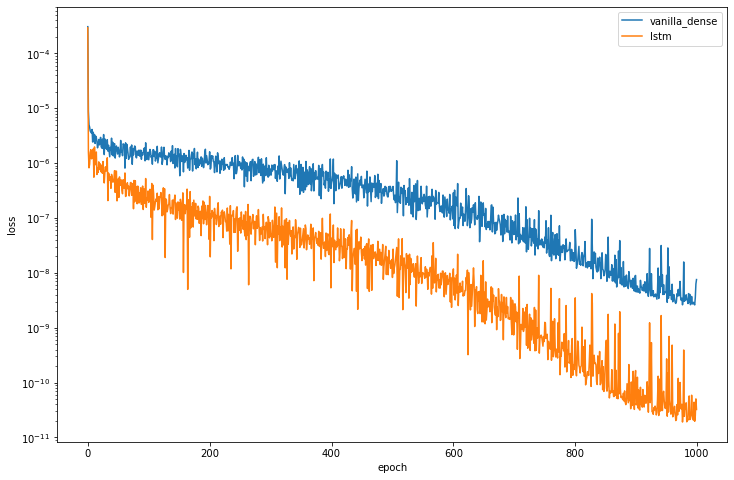

In [11]:
# Train with exact training data?
use_exact_training = True

plt.figure(figsize=(12, 8))
import pandas as pd
for loss in 'vanilla_dense', 'lstm':
    if use_exact_training:
        filename = 'loss_history_'+loss+'_exact_training_40x_6steps.csv'
    else:
        filename = 'loss_history_'+loss+'_40x_6steps.csv'        
    data = pd.read_csv(filename)
    X = data['Step'].to_numpy()
    Y = data['Value'].to_numpy()
    plt.plot(X,Y,label=loss)
ax = plt.gca()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.legend(loc='upper right')
plt.show()

## Plot trajectories and energy drift

Visualise the position $x(t)$ and the position error $x(t)-x_{\text{exact}}(t)$ for the following setups:

1. Verlet integrator with timestep $\Delta t_{\text{train}}$
2. Coarse Verlet integrator with timestep $\Delta t = 40\Delta t_{\text{train}}$
3. Vanilla dense network with timestep $\Delta t = 40\Delta t_{\text{train}}$
4. LSTM network with timestep $\Delta t = 40\Delta t_{\text{train}}$

For all four setups, also visualise the energy drift $E(t)-E(t=0)$.

Note that this will load the trained models from disk, so this will only work if you have these files (I didn't commit them to the repository since they are very large).

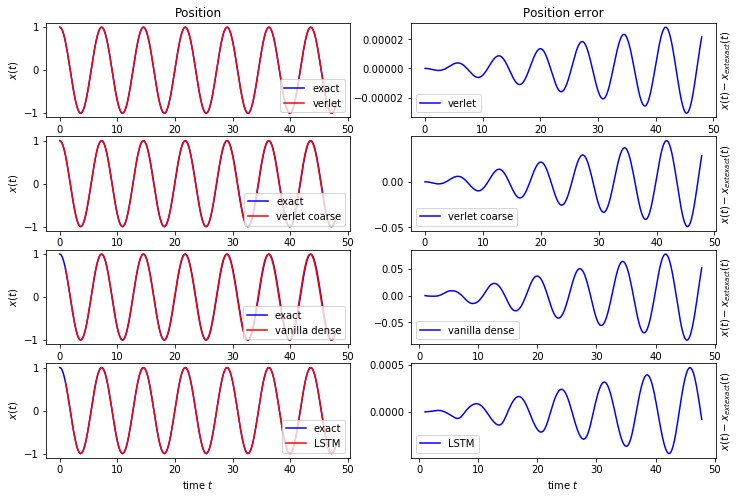

<Figure size 432x288 with 0 Axes>

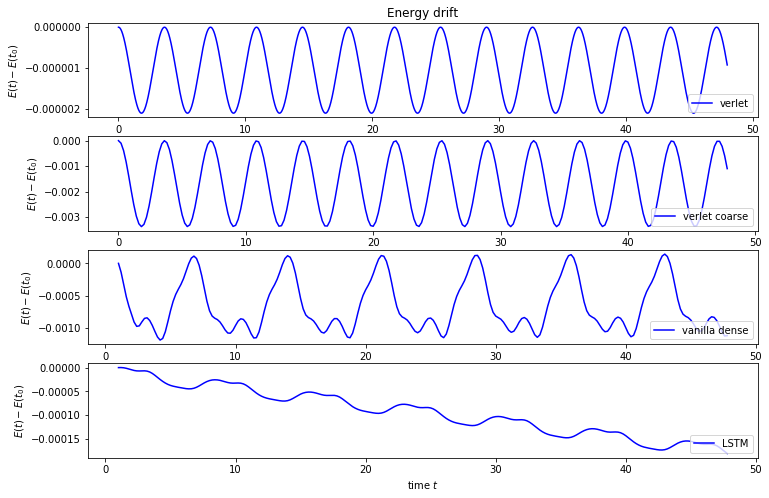

In [39]:
# Final time
T_final = 48

# Initial conditions
x0 = np.zeros(1)
v0 = np.zeros(1)
x0[0] = 1.0
v0[0] = 0.0
verlet_integrator = VerletIntegrator(harmonic_oscillator,dt_train)
verlet_integrator.set_state(x0,v0)
exact_integrator = ExactIntegrator(harmonic_oscillator,dt_train)
exact_integrator.set_state(x0,v0)

# ==== Verlet- and exact integrator ====
t0 = 0.0
t = {} # times
x = {} # positions
E = {} # energies
dx = {} # position errors
t['exact'] = []
t['verlet'] = []
x['exact'] = []
x['verlet'] = []
E['exact'] = []
E['verlet'] = []
dx['verlet'] = []
while t0<T_final:
    t['exact'].append(t0)
    t['verlet'].append(t0)
    E['exact'].append(exact_integrator.energy())
    x['exact'].append(exact_integrator.x[0])
    E['verlet'].append(verlet_integrator.energy())
    x['verlet'].append(verlet_integrator.x[0])
    dx['verlet'].append(verlet_integrator.x[0]-exact_integrator.x[0])
    verlet_integrator.integrate(1)
    exact_integrator.integrate(1)
    t0 += dt_train

# Verlet with large timestep

t['verlet coarse'] = []
x['verlet coarse'] = []
E['verlet coarse'] = []
dx['verlet coarse'] = []
coarse_verlet_integrator = VerletIntegrator(harmonic_oscillator,dt)
coarse_verlet_integrator.set_state(x0,v0)
exact_integrator.set_state(x0,v0)
t0 = 0.0
nsteps = int(dt/dt_train)
while t0<T_final:
    t['verlet coarse'].append(t0)
    E['verlet coarse'].append(coarse_verlet_integrator.energy())
    x['verlet coarse'].append(coarse_verlet_integrator.x[0])
    dx['verlet coarse'].append(coarse_verlet_integrator.x[0]-exact_integrator.x[0])
    coarse_verlet_integrator.integrate(1)
    exact_integrator.integrate(nsteps)
    t0 += dt

# ==== Neural network integrators ====

models = {'vanilla dense':keras.models.load_model('vanilla_dense_40x_6steps'),
          'LSTM':keras.models.load_model('lstm_exact_training_40x_6steps')}
for label,model in models.items():   
    nn_integrator.model = model
    # Initialise with exact integrator
    x_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
    v_initial = np.zeros((nn_integrator.nsteps,nn_integrator.dynamical_system.dim))
    exact_integrator.set_state(x0,v0)
    for k in range(nn_integrator.nsteps):    
        x_initial[k,:] = exact_integrator.x[:]
        v_initial[k,:] = exact_integrator.v[:]
        exact_integrator.integrate(int(dt/dt_train))
        nsteps += 1
    nn_integrator.set_state(x_initial,v_initial)
    t0 = (nn_integrator.nsteps-1)*nn_integrator.dt
    
    # Timestepping loop
    t[label] = []
    x[label] = []
    E[label] = []
    dx[label] = []
    nsteps = (nn_integrator.nsteps-1)*int(dt/dt_train)
    while t0<T_final:
        t[label].append(t0)
        x_nn = nn_integrator.x[0]
        exact_integrator.set_state(x0,v0)
        exact_integrator.integrate(nsteps)
        x_exact = exact_integrator.x[0]
        x[label].append(x_nn)
        dx[label].append(x_nn-x_exact)
        E[label].append(nn_integrator.energy())
        nn_integrator.integrate(1)
        t0 += dt
        nsteps += int(dt/dt_train)

# Plot position as a function of time
fig, axs = plt.subplots(4,2,figsize=(12, 8))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM')):
    ax = axs[j][0] 
    ax.plot(t['exact'],x['exact'],label='exact',color='blue')
    ax.plot(t[label],x[label],label=label,color='red')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)$')
    if j==0:
        ax.set_title('Position')
    ax = axs[j][1] 
    ax.plot(t[label],np.asarray(dx[label]),label=label,color='blue')
    ax.legend(loc='lower left')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)-x_{\text{exact}}(t)$')
    ax.yaxis.set_label_position("right")
    if j==0:
        ax.set_title('Position error')
plt.show()

plt.clf()
fig, axs = plt.subplots(4,1,figsize=(12, 8))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM')):
    ax = axs[j]
    ax.plot(t[label],np.asarray(E[label])-E[label][0],label=label,color='blue')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$E(t)-E(t_0)$')
    if j==0:
        ax.set_title('Energy drift')
plt.show()

In [ ]:
# Plot potential and kinetic energy (for debugging, can only be used with Hamiltonian network)
X = tf.expand_dims(tf.constant(np.arange(-2.0,2.0,0.01)),axis=1)

V_pot = nn_integrator.model.V_pot(X).numpy().flatten()
T_kin = nn_integrator.model.T_kin(X).numpy().flatten()
plt.plot(X,V_pot,linewidth=2,color='blue',label='V(q)')
plt.plot(X,T_kin,linewidth=2,color='red',label='T(p)')
ax = plt.gca()
ax.set_xlabel('q / p')
ax.set_ylabel('energy')
ax.legend(loc='lower right')
plt.show()

In [ ]:
data = data_generator.dataset.batch(4)
loss = 0
for x in data.take(4):
    print ('q_n         = ',x[0].numpy().flatten())
    print ('q_n [true ] = ',x[1].numpy().flatten())
    print ('q_n [pred ] = ',nn_integrator.model.predict(x[0]).flatten())
    print (nn_integrator.model.predict(x[0]).shape)
    print (x[1].shape)
    nn_integrator.model.evaluate(x[0],x[1])
    dx = x[1].numpy().flatten()-nn_integrator.model.predict(x[0]).flatten()
    loss += dx[0]**2 + dx[1]**2
print (' === loss = ',loss,' ===')